In [1]:
%matplotlib inline

In [2]:
### Faster SVM run
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Data Analysis Packages,
import os
import random
import pandas as pd
import numpy as np
import pathlib
import pickle
import itertools
import collections
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Plot Packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter
from matplotlib import gridspec
from pylab import *
import pylab as pl
from matplotlib.colors import LogNorm
from statannotations.Annotator import Annotator

# ML Packages
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold

In [4]:
# Font size adjustment
sns.set(font_scale = 1.5)
# Set background
sns.set_style("white")

In [82]:
### Function to process F2a and b
### Adjust the columnNames accordingly
def processExcelFormat01(name, percent=0.5):
    DF = pd.read_csv(name, header = None)
    # For 2b
    columnNames = ['Nutrient', 'Conjugation Inhibitor', 'N10', 'N11', 'N20', 'N21', 'noP', 'P', 'N1']
    # For 2a
#     columnNames = ['Nutrient', 'Conjugation Inhibitor', 'N0', 'N1']
    DF.columns = columnNames
    DF01 = DF[['Nutrient', 'Conjugation Inhibitor', 'N1']]
    # Rename last col as Density
    DF01.columns = [*DF01.columns[:-1], 'Density']
    
    # Reduce to 25*25
    A = list(set(list(DF01['Nutrient'])))
    A.sort()
    B = list(set(list(DF01['Conjugation Inhibitor'])))
    B.sort()   
#     print(len(DF01))
    # Reduce the original 25 * 25 variables
    # 50/2 == 25; 50/2 == 25
    DF01 = DF01[DF01['Nutrient'].isin(A[::2])]
    DF01 = DF01[DF01['Conjugation Inhibitor'].isin(B[::2])]
    
    DF01['BinaryClass'] = \
    DF01.Density.apply(lambda x: 1 if \
                        x >= DF01.Density.quantile(percent)
                        else -1)
    
    return DF01

In [81]:
# F2aDF = processExcelFormat01('1B1P_2304ML03.csv', 0.3)

In [7]:
### Function to import experimental data of 3 columns
### No preassigned column/drug names here
### Assign binary boundaried manually here
def processExcelFormat02(name, sheet, percent):
    DF = pd.read_excel(name, sheet, header = None)
    column_name = ['Environmental factor 1', 'Environmental factor 2', 'Density']
    DF.columns = column_name

    # Assign a very small positive value to 0 for log operation
    DF.loc[DF['Environmental factor 1'] == 0, 'Environmental factor 1'] = 0.2
    DF.loc[DF['Environmental factor 2'] == 0, 'Environmental factor 2'] = 0.2
    
    # Log transform data
    DF['Environmental factor 1'] = np.log10(DF['Environmental factor 1'])
    DF['Environmental factor 2'] = np.log10(DF['Environmental factor 2'])
    
    DF['BinaryClass'] = \
    DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(percent)  # 20th percentile\
                        else -1)    
    return DF

In [8]:
### Function to import Fig 1 synthetic data
def processExcelFormat03(name, sheet, percent = 0):
    DF = pd.read_excel(name, sheet)
#     print(DF)
    column_name = ['Environmental factor 1', 'Environmental factor 2', 'Density', 'BinaryClass']
    DF.columns = column_name
    
    # Retain the original name
    # Get input features
    inputName = list(DF.columns)[:-2]
    column_name = inputName + ['Density', 'BinaryClass']

    # Reduce to 10*10
    A = list(set(list(DF['Environmental factor 1'])))
    A.sort()
    B = list(set(list(DF['Environmental factor 2'])))
    B.sort()
    
    # Reduce the original 30 * 30 variables
    # 30/6 == 5; 30/6 == 5
    DF = DF[DF['Environmental factor 1'].isin(A[::6])]
    DF = DF[DF['Environmental factor 2'].isin(B[::6])]
    
    # Assign binary class, if know the percentage
    if percent != 0:
#         RSorted = sort(DF['Density'])
#         BoundaryVal = RSorted[int(percentage*len(RSorted)/10)]
#         DF['BinaryClass']=np.where(DF['Density']>BoundaryVal, 1, -1)
        
        DF['BinaryClass'] = \
        DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(percent)  # 20th percentile\
                        else -1)
        #### To make this consistent with Fig1File
        #DF['BinaryClass']=np.where(DF['Density']>percentage, 1, -1)
        
    return DF

In [9]:
def processExcelFormat04(name, sheet, percent = 0):
    DF = pd.read_excel(name, sheet)
#     print(DF)
    column_name = ['Environmental factor 1', 'Environmental factor 2', 'Density', 'BinaryClass']
    DF.columns = column_name

    # Retain the original name
    # Get input features
    inputName = list(DF.columns)[:-2]
    column_name = inputName + ['Density', 'BinaryClass']

    # Reduce to 10*10
    A = list(set(list(DF['Environmental factor 1'])))
    A.sort()
    B = list(set(list(DF['Environmental factor 2'])))
    B.sort()

    # Assign binary class, if know the percentage
    if percent != 0:
#         RSorted = sort(DF['Density'])
#         BoundaryVal = RSorted[int(percentage*len(RSorted)/10)]
#         DF['BinaryClass']=np.where(DF['Density']>BoundaryVal, 1, -1)
        #### To make this consistent with Fig1File
        #DF['BinaryClass']=np.where(DF['Density']>percentage, 1, -1)
        
        DF['BinaryClass'] = \
        DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(percent)  # 20th percentile\
                        else -1)

    return DF

In [ ]:
### Visualize inputs before or after normalization
### The only mandatory input is the dataframe
def heatmapGenerator(dataframe, values = 0, centered=1, labels=1, colorP="coolwarm"): # 'vlag', 'Spectral'
    ### dataframe: DF that stores all the data
    ### rows: rows of Heatmap; columns: columns of Heatmap; values: values to visualize
    ### digit: # length of labels
    #ax.set_xlim(0, 60)
    
    # Retrieve rows, columns and values columns for heatmap dataframe
    rows = dataframe.columns[1]
    columns = dataframe.columns[0]
    
    # Default is density plot
    if values == 0:
        values = dataframe.columns[2]
        
    # Get the boundary from the sheet
    ### Sort values from both class, get the ones closest to the boundary
    pos_values = dataframe[dataframe['BinaryClass'] > 0][values]
    pos_values_threshold = pos_values.sort_values(ascending=True)

    neg_values = dataframe[dataframe['BinaryClass'] < 0][values]
    neg_values_threshold = neg_values.sort_values(ascending=False)
    # Take avg as the boundary value
    boundary = (pos_values_threshold.iloc[0] + neg_values_threshold.iloc[0])/2

    heatmap_DF = dataframe.pivot(index=rows, columns=columns, values=values)

    fig = plt.figure(figsize=(6,4))
    
    colorPalette = sns.color_palette(colorP, as_cmap=True)
    # sns.diverging_palette(145, 300, s=60, as_cmap=True)
    # sns.color_palette("Spectral", as_cmap=True)
    
    # Colormap centered around the boundary value
    if centered == 1:
        # Dont add x & y labels or ticks
        ### For Fig 1
        if labels == 0:
            
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, center=boundary,\
                            yticklabels=False, xticklabels=False) #cmap=colorPalette, 
            g.set_ylabel('')
            g.set_xlabel('')
            g.set_title('')

        else: # Add x & y labels & values??
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, center = boundary) #cmap=colorPalette, 
            plt.title(values, fontsize = 15)

    # Colormap not centered
    else:
        if labels == 0:
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, \
                            yticklabels=False, xticklabels=False) #cmap=colorPalette,
            g.set_ylabel('')
            g.set_xlabel('')
            g.set_title('')
        else:
            g = sns.heatmap(heatmap_DF, cmap=colorPalette) #, cmap=colorPalette
            plt.title(values, fontsize = 15)
    g.invert_yaxis() # Small value at bottom, same in Matlab
    sns.diverging_palette(220, 20, as_cmap=True)     
    # Aesthestic for x,y ticklabels
    xticklabels = ['{:,.2f}'.format(float(x.get_text())) for x in g.get_xticklabels()]
    yticklabels = ['{:,.2f}'.format(float(y.get_text())) for y in g.get_yticklabels()]
    
    g.set_xticklabels(xticklabels, rotation=30, horizontalalignment='right')
    g.set_yticklabels(yticklabels, rotation=30, horizontalalignment='right')

In [11]:
### Normalize and Split for SVM data
### This fraction here is the number of datapoints
### Not percentage
def trainingTestSplit(full_df_Ori, n):
    sc_X = StandardScaler()
    sc_density = StandardScaler()
    TrainDF = full_df_Ori.sample(n = n) #frac = fraction
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()
    
    # Normalize input features
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)
    
    # Assign normalized training data back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set X and density using training scalers
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)
    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    # X & Y for all transformed data, operate on a copy
    # keep the original data intact
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    # Check if we have 2 classes for training
    # In training data too few, we may not have any
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    
    # If only 1 class, recursion until there are 2 classes
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
        TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y,\
        sc_X, sc_density = trainingTestSplit(full_df_Ori, n)
        
    ### Use test data in the last step
    # full_df_Ori: nonnormalized one; all others ar normalized
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y, sc_X, sc_density

In [12]:
def svc_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    ### Select best SVM parameters of any number of kernel(s)
    ### TrainDF_X: X training dataset
    ### TrainDF_Y: Y training dataset
    ### TestDF_X: X testing dataset
    ### TestDF_Y: Y testing dataset
    ### kernelList: the list of kernels to try
    
    #     print(TrainDF_X, TrainDF_Y)
    # 3 universal parameterx
    Cs = list(10. ** np.arange(-2, 5))
    gammas = list(10. ** np.arange(-4, 2))
    coef0s = list(10. ** np.arange(-4, 4))
#     "gamma": gamma_range.tolist()+['scale', 'auto']
    # Create grid parameters to tune: include universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas+['scale', 'auto'], \
                  'degree':[2,3,4,5], 'kernel': kernelList} ### 'poly', 'rbf', , 'coef0': coef0s
    
    # Grid search
    if len(TrainDF_X) >= 10:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, n_jobs = -2) # , n_jobs = -1
    elif len(TrainDF_X) < 6:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else: # If training instances too few, reduce cross validation fold
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 2, n_jobs = -2)

#     print(rand)
    grid.fit(TrainDF_X.values, TrainDF_Y)
    # print the best estimator & best parameters & best_score_ & performance check\n",
    print(grid.best_estimator_)

    # Return all parameters in best estimator
    return grid.best_estimator_, grid.best_estimator_.C, grid.best_estimator_.gamma, \
grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0

In [13]:
df_ori, df, dfTrain, dfTest, \
df_X, df_Y, dfTrain_X, dfTrain_Y, \
dfTest_X, dfTest_Y, sc_X, sc_density = trainingTestSplit(F2aDF, 10) #, sc_density

model, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
svc_rand_param_selection(dfTrain_X, dfTrain_Y, ['linear'])

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma=0.1, kernel='linear')


In [14]:
### Plot Input or Boundary or Support Vectors for different visualizing purpose
def decision_boundary_plot(trainedSVM, DF, boundary = 'None'):
    ### If boundary == 1: Scatterplot binary classes & circle support vectors
    ### If boundary == 2: Scatterplot binary classes & circle support vectors & add boundaries
    ### If boundary == 3: Scatterplot binary classes & add main boundaries
    
    ### If boundary == 4: Scatterplot quantitative/qualitative data without the boundary
    ### If boundary == 5: Scatterplot quantitative/qualitative data and Plot the boundary
    
    ### trainedSVM: trained SVM model
    ### DF: input training set or full dataset
    
    ### Quantitative data plot
    #### Estimated density with boundary???
    xName = DF.columns[0]
    yName = DF.columns[1]
    
    colorPalette = sns.color_palette("cool", 2, as_cmap=True)
    
    # Unify all figure size here
    fig = plt.figure(figsize=(6,5))  
    # Start ploting here
    if boundary == 5:
        hueCol = DF.columns[-1]
        
        s = sns.scatterplot(x = xName, y = yName, hue = hueCol, data=DF, s=100, \
                    palette = colorPalette, legend=False) # 'vlag'
            
#         sns.relplot(x = xName, y = yName, hue = hueCol, data = DF, s=100, \
#                        palette='vlag', legend=False, height = 7, aspect=1)

        # Hide Labels
        s.tick_params(axis='x',which='major',direction='out',length=5,\
               pad=10,labelsize=25)
        s.tick_params(axis='y',which='major',direction='out',length=5,\
               pad=10,labelsize=25)
        s.set_xticks([])
        s.set_yticks([])
#         fig.suptitle('Input data', fontsize=20)
        plt.xlabel('', fontsize=20)
        plt.ylabel('', fontsize=20)
        
        ax2 = plt.gca()
        xlim2 = ax2.get_xlim()
        ylim2 = ax2.get_ylim()
        xx2 = np.linspace(xlim2[0], xlim2[1], 30)
        yy2 = np.linspace(ylim2[0], ylim2[1], 30)
        YY2, XX2 = np.meshgrid(yy2, xx2)
        xy2 = np.vstack([XX2.ravel(), YY2.ravel()]).T
        Z2 = trainedSVM.decision_function(xy2).reshape(XX2.shape)
        ax2.contour(XX2, YY2, Z2, colors='grey', levels=[0], alpha=1, linestyles=['--'])
    
    #### Estimated Density ???
    elif boundary == 4:
        # Color scatter plot density
        hueCol = DF.columns[-1]
        s = sns.scatterplot(x = xName, y = yName, hue = hueCol, data=DF, s=100, \
                    palette = colorPalette, legend=False)
        
#         DF.plot(kind='scatter', x = xName, y = yName, c=hueCol, colormap='vlag')#, 

    ### Binary Data plot
    else:
        # Scatter plot of 2 input classes
        s = sns.scatterplot(x = xName, y = yName, hue="BinaryClass", data=DF, s=100, \
                    palette = colorPalette, legend=False) #palette=['#7AAACD', '#D7846C']
        
        # Hide Label
        s.tick_params(axis='x',which='major',direction='out',length=5,\
               pad=10,labelsize=25)
        s.tick_params(axis='y',which='major',direction='out',length=5,\
               pad=10,labelsize=25)
        s.set_xticks([])
        s.set_yticks([])
#         fig.suptitle('Input data', fontsize=20)
        plt.xlabel('', fontsize=20)
        plt.ylabel('', fontsize=20)
        
        
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    #     ax.invert_xaxis()
    #     ax.invert_yaxis()

        # Create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T

        # Use trained SVM on the grid for the decision function value
        Z = trainedSVM.decision_function(xy).reshape(XX.shape)

        # Emphasize support vectors
        if boundary == 1:
            # Circle support vectors   
            ax.scatter(trainedSVM.support_vectors_[:, 0], trainedSVM.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='grey')

        # Plot boundary and secondary boundaries; Emphasize support vectors
        elif boundary == 2:
            # Plot decision boundary and margins
            ax.contour(XX, YY, Z, colors='grey', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
            # Circle support vectors        
            ax.scatter(trainedSVM.support_vectors_[:, 0], trainedSVM.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='grey')

        # Plot Only the boundary
        elif boundary == 3:
            # Plot decision boundary and margins
            ax.contour(XX, YY, Z, colors='grey', levels=[0], alpha=1, linestyles=['--'])

    plt.show()

In [15]:
### For SVM quantitative prediction mainly
### To be used in autoProcess
##### fullDF_X or just TestDF_X? Can be used for both scenario, might need to change the name
def Quantitative_prediction(fullDF_X, trainedModel):
    ### fullDF_X: full X input
    ### trainedModel: trained SVM model
    quantitative_list = []
    # Process entry by entry
    for entry in range(len(fullDF_X)):
        currentEntry = array(fullDF_X.iloc[entry]) # current entry
        # Get the current entry's score
        sum2 = 0
        sum2 = float(trainedModel.decision_function(np.array([currentEntry])))
        quantitative_list.append(sum2) # -sum2 for other purpose ??
    return quantitative_list

In [16]:
### SVM autoprocess
### Call after spliting & normalization
### Train SVM 1 time
### Plot SVM density vs. quantitative value
### Stats on testing data
def autoProcess(full_df_Ori, fullDF_copy, TrainDF, fullDF_X, TrainDF_X, TrainDF_Y, \
                TestDF_X, TestDF_Y, kernelList, colName):
    # Select model using training data
    fModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
    svc_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList) 
    #     print('Finish model selection')
    # Plot all boundaries
#     decision_boundary_plot(fModel, TrainDF)
#     decision_boundary_plot(fModel, TrainDF, 1)
#     decision_boundary_plot(fModel, TrainDF, 2)
#     decision_boundary_plot(fModel, TrainDF, 3)
#     decision_boundary_plot(fModel, TrainDF, 4)
#     decision_boundary_plot(fModel, TrainDF, 5)
    # Quantitative prediction on all points
    q_list = Quantitative_prediction(fullDF_X, fModel)
    # Only store on the copy DF
    fullDF_copy[colName] = q_list
    # Locate training data
    trainingIndex = TrainDF.index
    # Locate training set for ploting SVM results
    NewTrainDF = fullDF_copy.loc[trainingIndex]
    NewTestDF = fullDF_copy[~fullDF_copy.isin(NewTrainDF)].dropna()
    # Plot the boundary on distance
    # decision_boundary_plot(fModel, NewTrainDF, 4)
    # decision_boundary_plot(fModel, NewTrainDF, 5)
    
    # Compare with the testing DF
    spearmanCorrelation = spearmanr(NewTestDF[colName], NewTestDF['Density'])
    #print('Spearman: ', spearmanCorrelation)
    pearsonCorrelation = pearsonr(NewTestDF[colName], NewTestDF['Density'])
    #print('Pearson: ', pearsonCorrelation)
#     r2Correlation = r2_score(fullDF_copy[colName], full_df_Ori['Density'])
    mse = mean_squared_error(NewTestDF[colName], NewTestDF['Density'], squared=True)
    #print('MSE: ', mse)
    correlation_matrix = np.corrcoef(NewTestDF[colName], NewTestDF['Density'])
    correlation_xy = correlation_matrix[0,1]
    r2Correlation = correlation_xy**2
    #print('r2: ', r2Correlation)\n",
    
    return fModel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse

In [18]:
df_ori, df, dfTrain, dfTest, \
df_X, df_Y, dfTrain_X, dfTrain_Y, \
dfTest_X, dfTest_Y, sc_X, sc_density = trainingTestSplit(F2aDF, 10)

autoProcess(df_ori, df, dfTrain, df_X, dfTrain_X, dfTrain_Y, dfTest_X, dfTest_Y,\
            ['poly', 'sigmoid', 'rbf'], 'SVM Quant Estimation') #, 'rbf', 'sigmoid'"

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=4, gamma=10.0, kernel='sigmoid')


(SVC(C=10000.0, degree=4, gamma=10.0, kernel='sigmoid'),
 SpearmanrResult(correlation=0.5179054200835885, pvalue=5.945456123216585e-171),
 (0.38981590388411136, 3.6672120569956635e-91),
 0.15195643892098662,
 229526434.41616946)

In [19]:
### Select best SVR parameters of any number of kernel(s)
### X_train: X training dataset
### Y_train: Y training dataset
### X_test: X testing dataset
### Y_test: Y testing dataset
def svr_rand_param_selection(X_train, Y_train, kernelList):
    # 3 universal parameters
    Cs = list(10. ** np.arange(-4, 4))
    gammas = list(10. ** np.arange(-4, 4))
    coef0s = list(10. ** np.arange(-4, 4))
    # Create grid parameters to tune: include 2 universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas + ['scale', 'auto'], \
                  'degree':[1,2,3,4,5,6], 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],  \
                  'epsilon':list(10. ** np.arange(-3, 1))} ### 'poly', 'rbf', 'coef0': coef0s,
    # rand Search
    if len(X_train) >= 10:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, n_jobs = -2) #
    elif len(X_train) == 2:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 2, n_jobs = -2)
        
    #print(X_train)
    grid.fit(X_train.values, Y_train)

    return grid.best_estimator_, grid.best_estimator_.C, grid.best_estimator_.gamma, \
grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0


In [20]:
def finalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    finalTestX = testX.copy()
    finalTestX['SVM Quant Estimation'] = finalTestX['SVM Quant Estimation'].apply(lambda x: x*weight)
    predictedDensity = bestModel.predict(finalTestX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))
    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))
    
    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]

    return Correlation, predictedDensityInversedBack


In [21]:
# Run SVR regression once, given training and testing sets
### For both SAR & SVR
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only
### 

def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    weightList = [0.01, 0.1, 1]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0
    

    for i in range(1):    
        if len(trainX) <= 10:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['SVM Quant Estimation'] = trainXCopy['SVM Quant Estimation'].apply(lambda x: x*w)
            testXCopy['SVM Quant Estimation'] = testXCopy['SVM Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
        svr_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            ### Predict with the best model of the current weight
            ### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            ### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
            print('R2: ', R2score)
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
            print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w
#                 print(MSEscoreTemp, bestMSEWeight)
            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
            print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w
#                 print(PearsonScoreTemp, bestPearsonWeight)
            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
            print('Spearman: ', SpearmanScore)
            #print(SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        r2WeightList.append(bestR2Weight)
        MSEWeightList.append(bestMSEWeight)
        PearsonWeightList.append(bestPearsonWeight)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now
        SVRmodel, SVREstC, SVREstGamma, SVREstDegree, SVREstKernel, SVREstCoef0 = \
            svr_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))

        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    # To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
    # Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
        m = metricList[i]
        # First, retrain on the full training set using the selected weight
        # Transform
        finalTrainXCopy['SVM Quant Estimation'] = \
        finalTrainXCopy['SVM Quant Estimation'].apply(lambda x: x*weight)

        finalModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
        svr_rand_param_selection(finalTrainXCopy, trainY, kernelList)

        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel, EstC, EstGamma, EstDegree, EstKernel, EstCoef0 = \
            svr_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('SVM: ', corrList)
    print('SVR: ', SVRcorrList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted


In [22]:
def SVROnlyfinalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    # Predict
    predictedDensity = bestModel.predict(testX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))

    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))
    
    # Get all prediction evaluation metric
    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]

    return Correlation, predictedDensityInversedBack


In [23]:
### A function to Normalize and Split for SVM & SVR
### full_df_Ori: dataframe for the full dataset
### n: number of points for training set
def ComparisonTrainingTestSplit(full_df_Ori, n):
    # Initiate scaler to normalize training and testing sets later
    sc_X = StandardScaler()
    sc_density = StandardScaler()

    # Create training and testing df
    TrainDF = full_df_Ori.sample(n = n)
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()

    # Normalize training inputs
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density output
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)

    # Assign back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set values
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)

    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    TrainDF_Density = TrainDF['Density']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    TestDF_Density = TestDF['Density']

    # X & Y for all transformed data
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = \
    densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    fullDF_Density = fullDF_copy['Density']

    # Check if we have 2 classes for training
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
        TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density, \
        = ComparisonTrainingTestSplit(full_df_Ori, n)

    ### Use test data in the last step
    # full_df_Ori: nonnormalized one; all others ar normalized
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density

In [24]:
# Run SVM + SVR & SVR once together
def ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                      percent = 0, plasmidNum = 1):
    ### One function here
    # Load the data
    if processExcelFormat == 1:
        df = processExcelFormat01(excelFile, percent)
    elif processExcelFormat == 2:
        df = processExcelFormat02(excelFile, sheet, percent)
    elif processExcelFormat == 3: 
        df = processExcelFormat03(excelFile, sheet, percent)
    elif processExcelFormat == 4:
        df = processExcelFormat04(excelFile, sheet, percent)

    # Split the data
    df_Ori, df, dfTrain, dfTest, df_X, df_Y, df_Density, \
    dfTrain_X, dfTrain_Y, dfTrain_Density, dfTest_X, dfTest_Y, dfTest_Density, sc_X, sc_density \
    = ComparisonTrainingTestSplit(df, n)

    trainingIndex = dfTrain.index

    ### Train SVM+SVR one time
    ## Run SVM first
    SVMmodel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse = \
                autoProcess(df_Ori, df, dfTrain, df_X, dfTrain_X, dfTrain_Y, dfTest_X, dfTest_Y, kernelList,\
                           'SVM Quant Estimation')

    #### Normalize distances
    #### Normalize the ones for training SVC
    sc_distance = StandardScaler()
    # Locate training set
    NewTrainDF = df.loc[trainingIndex]
    # sc_y = StandardScaler(),
    distanceScaler = sc_distance.fit(NewTrainDF[['SVM Quant Estimation']].values)
    scaled_newFeatures = distanceScaler.transform(NewTrainDF[['SVM Quant Estimation']].values)
    NewTrainDF[['SVM Quant Estimation']] = scaled_newFeatures

    # Scale all SVC prediction now
    df[['SVM Quant Estimation']] = distanceScaler.transform(df[['SVM Quant Estimation']].values)
    # Get the transformed testing data now
    NewTestDF = df.loc[~df.index.isin(trainingIndex)]

    inputName = list(df_Ori.columns)[:-2]
    newInputName = inputName + ['SVM Quant Estimation']
    #print(newInputName)
    # X & Y for all data
    Newfull_df_X = df[newInputName]
    Newfull_df_Y = df['Density']

    # X & Y for training set
    NewTrainDF_X = NewTrainDF[newInputName]
    NewTrainDF_Y = NewTrainDF['Density']
    # X & Y for testing set
    NewTestDF_X = NewTestDF[newInputName]
    NewTestDF_Y = NewTestDF['Density']

    bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, \
    SVRSpearmanPredicted = \
    regressionSVR(NewTrainDF_X, dfTrain_X, NewTrainDF_Y, \
                  NewTestDF_X, dfTest_X, NewTestDF_Y, \
                  kernelList, Newfull_df_X, sc_density)

    return SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
    bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
    SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
    NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex


In [25]:
def ComparisonMultipleRun(runNum, excelFile, processExcelFormat, sheet, nRange, indices, kernelList,\
                           percent = 0, plasmidNum = 1): # Percent or abs value
    # To record scalers
    scXRecorder = {}
    scDensityRecorder = {}
    # This is just for SVC+SVR
    scDistanceRecorder = {}
    
    # To store corr results for SVM+SVR
    complexSVRSpearmanLists = []
    complexSVRPearsonLists = []
    complexSVRR2Lists = []
    complexSVRMSELists = []
    # To store prediction raw data for SVM+SVR
    complexPredictedSVRSpearmanLists = []
    complexPredictedSVRPearsonLists = []
    complexPredictedSVRR2Lists = []
    complexPredictedSVRMSELists = []
    # To record models
    r2Recorder = {}
    mseRecorder = {}
    pearsonRecorder = {}
    spearmanRecorder = {}

    TrainXDFRecorder = {}
    TrainYDFRecorder = {}
    indexRecorder = {}
    SVMSVRFullXRecorder = {}
    SVMSVRFullYRecorder = {}
    SVRFullXRecorder = {}

    # To store results for SVR
    SVRSpearmanLists = []
    SVRPearsonLists = []
    SVRR2Lists = []
    SVRMSELists = []
    
    PredictedSVRSpearmanLists = []
    PredictedSVRPearsonLists = []
    PredictedSVRR2Lists = []
    PredictedSVRMSELists = []
    
    # To record models
    SVRr2Recorder = {}
    SVRmseRecorder = {}
    SVRpearsonRecorder = {}
    SVRspearmanRecorder = {}
        
    # Loop through all split percentage
    for n in nRange:
        # For both: input and density scaler
        #### To be used later in active learning part
        scXR = {}
        scDensityR = {}
        scDistanceR = {}

        # For SVM + SVR
        r2Recorder[n] = {}
        mseRecorder[n] = {}
        # Recorder dictionaries
        r2R = {}
        mseR = {}
        pearsonR = {}
        spearmanR = {}
        indexR = {}
        TrainXDF = {}
        TrainYDF = {}
        SVMSVRFullXDF = {}
        SVMSVRFullYDF = {}
        SVRFullXDF = {}

        print(n)
        # Corr Score lists
        spearmanList = []
        pearsonList = []
        r2List = []
        mseList = []
        # Raw prediction lists
        PredictedspearmanList = []
        PredictedpearsonList = []
        Predictedr2List = []
        PredictedmseList = []
        
        # For SVR
        SVRr2Recorder[n] = {}
        SVRmseRecorder[n] = {}
        SVRpearsonRecorder[n] = {}
        SVRspearmanRecorder[n] = {}
        # Recorder dictionaries
        SVRr2R = {}
        SVRmseR = {}
        SVRpearsonR = {}
        SVRspearmanR = {}
        # Score lists
        SVRspearmanList = []
        SVRpearsonList = []
        SVRr2List = []
        SVRmseList = []
        
        PredictedSVRspearmanList = []
        PredictedSVRpearsonList = []
        PredictedSVRr2List = []
        PredictedSVRmseList = []

        for it in range(runNum):
            # Run once
            SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
            bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
            bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
            bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
            SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
            SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
            SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
            NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex = \
            ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                                   percent, plasmidNum)

            # Record the set of model with its accuracy
            R2bothModel = (SVMmodel, bestR2Model, bestR2Weight)
            r2R[it] = R2bothModel
            MSEbothModel = (SVMmodel, bestMSEModel, bestMSEWeight)
            mseR[it] = MSEbothModel
            PearsonbothModel = (SVMmodel, bestPearsonModel, bestPearsonWeight)
            pearsonR[it] = PearsonbothModel
            SpearmanbothModel = (SVMmodel, bestSpearmanModel, bestSpearmanWeight)
            spearmanR[it] = SpearmanbothModel
            TrainXDF[it] = NewTrainDF_X
            TrainYDF[it] = NewTrainDF_Y
            SVMSVRFullXDF[it] = Newfull_df_X
            SVMSVRFullYDF[it] = Newfull_df_Y
#             SVRFullXDF[it] = df_X
            indexR[it] = trainingIndex

            # Append each correlation with its split to its corresponding list
            spearmanTuple = (n, SpearmanCorr)
            spearmanList.append(spearmanTuple)
            pearsonTuple = (n, PearsonCorr)
            pearsonList.append(pearsonTuple)
            r2Tuple = (n, R2Corr)
            r2List.append(r2Tuple)
            mseTuple = (n, MSECorr)
            mseList.append(mseTuple)
            
            PredictedspearmanTuple = (n, SpearmanPredicted)
            PredictedspearmanList.append(PredictedspearmanTuple)
            PredictedpearsonTuple = (n, PearsonPredicted)
            PredictedpearsonList.append(PredictedpearsonTuple)
            Predictedr2Tuple = (n, R2Predicted)
            Predictedr2List.append(Predictedr2Tuple)
            PredictedmseTuple = (n, MSEPredicted)
            PredictedmseList.append(PredictedmseTuple)
            
            # Results of SVR
            # Record the set of model with its accuracy\n",
            SVRr2R[it] = SVRbestR2Model
            SVRmseR[it] = SVRbestMSEModel
            SVRpearsonR[it] = SVRbestPearsonModel
            SVRspearmanR[it] = SVRbestSpearmanModel

            # Append each correlation with its split to its corresponding list
            SVRspearmanTuple = (n, SVRSpearmanCorr)
            SVRspearmanList.append(SVRspearmanTuple)
            SVRpearsonTuple = (n, SVRPearsonCorr)
            SVRpearsonList.append(SVRpearsonTuple)
            SVRr2Tuple = (n, SVRR2Corr)
            SVRr2List.append(SVRr2Tuple)
            SVRmseTuple = (n, SVRMSECorr)
            SVRmseList.append(SVRmseTuple)
            
            PredictedSVRspearmanTuple = (n, SVRSpearmanPredicted)
            PredictedSVRspearmanList.append(PredictedSVRspearmanTuple)
            PredictedSVRpearsonTuple = (n, SVRPearsonPredicted)
            PredictedSVRpearsonList.append(PredictedSVRpearsonTuple)
            PredictedSVRr2Tuple = (n, SVRR2Predicted)
            PredictedSVRr2List.append(PredictedSVRr2Tuple)
            PredictedSVRmseTuple = (n, SVRMSEPredicted)
            PredictedSVRmseList.append(PredictedSVRmseTuple)
            
            # Record the scaler for both density and input
            scXR[it] = sc_X
            scDensityR[it] = sc_density
            scDistanceR[it] = sc_distance

        r2Recorder[n] = r2R
        mseRecorder[n] = mseR
        pearsonRecorder[n] = pearsonR
        spearmanRecorder[n] = spearmanR
        SVRr2Recorder[n] = SVRr2R
        SVRmseRecorder[n] = SVRmseR
        SVRpearsonRecorder[n] = SVRpearsonR
        SVRspearmanRecorder[n] = SVRspearmanR
        TrainXDFRecorder[n] = TrainXDF
        TrainYDFRecorder[n] = TrainYDF
        SVMSVRFullXRecorder[n] = SVMSVRFullXDF
        SVMSVRFullYRecorder[n] = SVMSVRFullYDF
#         SVRFullXRecorder[n] = SVRFullXDF
        indexRecorder[n] = indexR
        # Record scalers
        scXRecorder[n] = scXR
        scDensityRecorder[n] = scDensityR
        # This is just for SVC+SVR
        scDistanceRecorder[n] = scDistanceR

        # For SVC+SVR
        complexSVRSpearmanLists.append(spearmanList)
        complexSVRPearsonLists.append(pearsonList)
        complexSVRR2Lists.append(r2List)
        complexSVRMSELists.append(mseList)
        # Raw predicted value
        complexPredictedSVRSpearmanLists.append(PredictedspearmanList)
        complexPredictedSVRPearsonLists.append(PredictedpearsonList)
        complexPredictedSVRR2Lists.append(Predictedr2List)
        complexPredictedSVRMSELists.append(PredictedmseList)
        
        # For SVR
        SVRSpearmanLists.append(SVRspearmanList)
        SVRPearsonLists.append(SVRpearsonList)
        SVRR2Lists.append(SVRr2List)
        SVRMSELists.append(SVRmseList)
        # Raw predicted value
        PredictedSVRSpearmanLists.append(PredictedSVRspearmanList)
        PredictedSVRPearsonLists.append(PredictedSVRpearsonList)
        PredictedSVRR2Lists.append(PredictedSVRr2List)
        PredictedSVRMSELists.append(PredictedSVRmseList)
        

    return complexSVRSpearmanLists, complexSVRPearsonLists, complexSVRR2Lists, complexSVRMSELists, \
complexPredictedSVRSpearmanLists, complexPredictedSVRPearsonLists, complexPredictedSVRR2Lists, \
complexPredictedSVRMSELists, \
r2Recorder, mseRecorder, pearsonRecorder, spearmanRecorder, \
SVRSpearmanLists, SVRPearsonLists, SVRR2Lists, SVRMSELists, \
PredictedSVRSpearmanLists, PredictedSVRPearsonLists, PredictedSVRR2Lists, PredictedSVRMSELists, \
SVRr2Recorder, SVRmseRecorder, SVRpearsonRecorder, SVRspearmanRecorder,\
indexRecorder, TrainXDFRecorder, TrainYDFRecorder, \
SVMSVRFullXRecorder, SVMSVRFullYRecorder, scXRecorder, scDensityRecorder, scDistanceRecorder


In [26]:
def ComparisonResultsPlot(ResultLists, position = 'lower right', xname = '# training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75):
    resultList1, resultList2 = ResultLists
    SVMSVRFinalList = []
    for r in resultList1:
        SVMSVRFinalList = SVMSVRFinalList + r

    SVMSVRDF = pd.DataFrame(SVMSVRFinalList)
    columnNames = [xname, 'Results']
    SVMSVRDF.columns = columnNames
    SVMSVRDF['Method'] = 'SVC+SVR'

    # SVR scores
    SVRFinalList = []
    for r in resultList2:
        SVRFinalList = SVRFinalList + r
        
    SVRDF = pd.DataFrame(SVRFinalList)
    SVRDF.columns = columnNames
    SVRDF['Method'] = 'SVR'

    FinalDF = pd.concat([SVMSVRDF, SVRDF])
    p = sns.color_palette("husl", 2)
    sns.boxplot(y='Results', x=xname, 
                data=FinalDF, hue='Method',
                palette=p, saturation=1.0, width=0.4)

    plt.legend(loc=position)

    if yname != "MSE":
        plt.ylim(ylimit)
        if yline != 0:
            plt.axhline(y = yline, color = 'grey', ls = '--', lw = 1.1)   
    else:
        plt.legend(loc='upper right')

    #sns.despine(offset=10, trim=True)
    if show == 1:
        plt.xlabel(xname)
        plt.ylabel(yname)
    else:
        plt.xlabel('')
        plt.ylabel('')

    return FinalDF

In [27]:
def statsPlot(toPlotDF, statsTest = "Mann-Whitney", ylabel = 'Results', show = 1, limit = 0):
    statesName = '# Training data'
    states_order = list(set(list(toPlotDF[statesName])))
    states_order.sort()
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=3)
    subcat_order = ['SVR', 'SVC+SVR']
    # Switching hue and x
    hue_plot_params = {
        'data':      toPlotDF,
        'x':         statesName,
        'y':         ylabel,
        "order":     states_order,
        "hue":       "Method",
        "hue_order": subcat_order,
        "palette":   subcat_palette
    }
    if len(states_order) == 4:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],
        )
    elif len(states_order) == 3:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],
        )
    elif len(states_order) == 5:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],

            [(states_order[4], subcat_order[0]), (states_order[4], subcat_order[1])],
        )
    elif len(states_order) == 1:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],
        )
    elif len(states_order) == 2:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],
        )
    with sns.plotting_context("notebook", font_scale = 1.4):
        sns.set(font_scale = 4)
        sns.set_style("white")
        # Create new plot
        figsize = (8, 5)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)
        # Add stats annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test = statsTest, verbose=False) 
        _, results = annotator.apply_and_annotate()

        if show == 1:
            ax.set_xlabel(statesName, fontsize=40)
            ax.set_ylabel(ylabel, fontsize=40)
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")

        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.ylim([-0.1, 1.1])
        plt.show()

In [28]:
def scatterComparisonPlot(DF):
    DFHeader = list(DF.columns)
    FixedName = ['# Training data', 'Method']
    resultsName = [i for i in DFHeader if i not in FixedName]
    resultsName = [i for i in resultsName if i != 'Unnamed: 0']
    print(resultsName)

    DF_SVC = DF[DF['Method'] == 'SVC+SVR']
    DF_SVR = DF[DF['Method'] == 'SVR']

    # Get all different numbers of training data
    trainingDataType = sorted(list(set(DF_SVC['# Training data'])))
    DF_SVC_1 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[0]]
    DF_SVR_1 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[0]]

    # Create new plot
    figsize = (5, 5)
    # Create new plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    s1 = plt.scatter(DF_SVR_1[resultsName], DF_SVC_1[resultsName], alpha = 0.7, color = 'cyan', \
                     label = str(trainingDataType[0])+' training data')
    ax.legend(handles=[s1], bbox_to_anchor = (1.7, 1.0), loc='upper right') #, s3

    # At most include 5 different types
    if len(trainingDataType) != 1:
        DF_SVC_2 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[1]]
        DF_SVR_2 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[1]]
        s2 = plt.scatter(DF_SVR_2[resultsName], DF_SVC_2[resultsName], alpha = 0.9, color = 'olive', \
                     label = str(trainingDataType[1])+' training data')
        if len(trainingDataType) == 2:           
            ax.legend(handles=[s1, s2], bbox_to_anchor = (1.7, 1.0), loc='upper right') #, s3
            
        else:
            DF_SVC_3 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[2]]
            DF_SVR_3 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[2]]
            s3 = plt.scatter(DF_SVR_3[resultsName], DF_SVC_3[resultsName], alpha = 0.9, color = 'brown', \
                         label = str(trainingDataType[2])+' training data')
            if len(trainingDataType) == 3:
                ax.legend(handles=[s1, s2, s3], bbox_to_anchor = (1.7, 1.0), loc='upper right')
                
            else:
                DF_SVC_4 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[3]]
                DF_SVR_4 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[3]]
                s4 = plt.scatter(DF_SVR_4[resultsName], DF_SVC_4[resultsName], alpha = 0.7, color = 'tomato', \
                             label = str(trainingDataType[3])+' training data')
                if len(trainingDataType) == 4:  
                    ax.legend(handles=[s1, s2, s3, s4], bbox_to_anchor = (1.7, 1.0), loc='upper right')
                else:
                    DF_SVC_5 = DF_SVC[DF_SVC['# Training data'] == trainingDataType[4]]
                    DF_SVR_5 = DF_SVR[DF_SVR['# Training data'] == trainingDataType[4]]
                    s5 = plt.scatter(DF_SVR_5[resultsName], DF_SVC_5[resultsName], alpha = 0.7, color = 'red', \
                                 label = str(trainingDataType[4])+' training data')
                    if len(trainingDataType) == 5:
                        ax.legend(handles=[s1, s2, s3, s4, s5], bbox_to_anchor = (1.7, 1.0), loc='upper right')

    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.tick_params(axis='x',which='major',direction='out',length=5,\
           pad=10,labelsize=25)
    plt.tick_params(axis='y',which='major',direction='out',length=5,\
           pad=10,labelsize=25)

    x = np.linspace(0, 1)
    ax.plot(x, x, 'grey', linewidth=2)

    plt.xlabel('SVR Prediction', fontsize=25)
    plt.ylabel('SVC+SVR Prediction', fontsize=25)


here 0.0


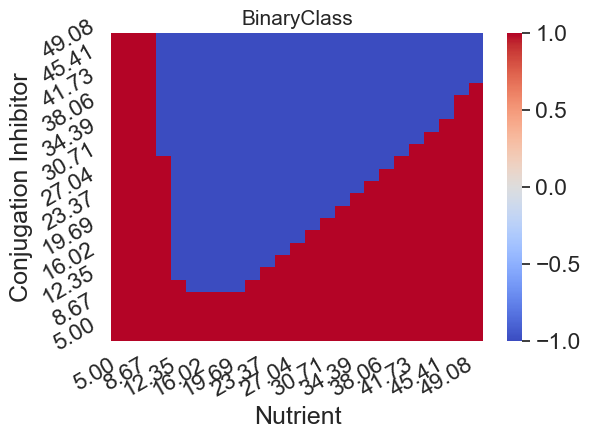

In [42]:
# F2a
F2aDF = processExcelFormat01('1B1P_2304ML03.csv', 0.5)
heatmapGenerator(F2aDF, 'BinaryClass')

here 0.22559705748868


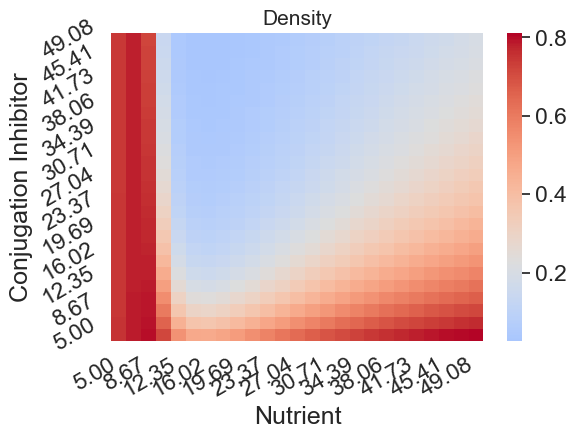

In [43]:
heatmapGenerator(F2aDF)

In [44]:
complexSVRSpearmanLists_1B1P, complexSVRPearsonLists_1B1P, complexSVRR2Lists_1B1P, complexSVRMSELists_1B1P, \
complexPredictedSVRSpearmanLists_1B1P, complexPredictedSVRPearsonLists_1B1P, complexPredictedSVRR2Lists_1B1P, \
complexPredictedSVRMSELists_1B1P, \
r2Recorder_1B1P, mseRecorder_1B1P, pearsonRecorder_1B1P, spearmanRecorder_1B1P, \
SVRSpearmanLists_1B1P, SVRPearsonLists_1B1P, SVRR2Lists_1B1P, SVRMSELists_1B1P, \
PredictedSVRSpearmanLists_1B1P, PredictedSVRPearsonLists_1B1P, PredictedSVRR2Lists_1B1P, PredictedSVRMSELists_1B1P, \
SVRr2Recorder_1B1P, SVRmseRecorder_1B1P, SVRpearsonRecorder_1B1P, SVRspearmanRecorder_1B1P,\
indexRecorder_1B1P, TrainXDFRecorder_1B1P, TrainYDFRecorder_1B1P, \
SVMSVRFullXDFRecorder_1B1P, SVMSVRFullYDFRecorder_1B1P, scXRecorder_1B1P, \
scDensityRecorder_1B1P, scDistanceRecorder_1B1P = \
ComparisonMultipleRun(40, '1B1P_2304ML03.csv',  1, 'ContinuousCompressed',\
                      [10, 20, 30, 40, 50], 0, ['poly', 'rbf'], 0.5) 

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma='auto')
R2:  0.998901160365392
MSE:  0.0076828515236906
Pearson:  0.9994504291686466
Spearman:  1.0
R2:  0.3695098300296962
MSE:  0.07924580207277422
Pearson:  0.6078732022631825
Spearman:  1.0
R2:  0.3664853628513196
MSE:  0.080402134278415
Pearson:  0.6053803456103606
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-11.79073612 -13.84924549 -13.10746993 -13.90224908  -0.25200469
 -14.21201019 -10.58601503          nan  -6.64762137 -13.97586724]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -7.12295068 -14.20945143          nan  -6.86842888 -14.21263261
 -14.21328282 -11.19727007 -13.84947476          nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-13.84699178 -13.36561901 -13.83947057 -14.2969476   -2.26248673
          nan -14.20971878 -13.8460803  -14.21254647 -13.84951335]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

SVM:  [0.418245043917049, 0.061271566281069605, 0.6097550046186869, 0.4144248497986482]
SVR:  [0.029947505854040202, 0.3557509707444514, 0.1730534768620388, 0.3386603267234078]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.6433526736846948
MSE:  0.044044846406229875
Pearson:  -0.8020926839740498
Spearman:  -1.0
R2:  0.5349343217337948
MSE:  0.03152582295260815
Pearson:  -0.7313920437999
Spearman:  -1.0
R2:  0.48673807288666754
MSE:  0.03032807025503921
Pearson:  -0.6976661614889084
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2942558142168224, 0.07440703153673914, 0.4118569229111867, 0.6309313154470858]
SVR:  [0.49727953567387445, 0.03207445943678558, 0.7051804986483066, 0.7280357800616799]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.00016048265792975526
MSE:  0.13310660556072143
Pearson:  -0.012668175003912485
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.64586624e+01             nan -1.34006496e+01 -1.70512687e+01
             nan -1.36261940e+05             nan             nan
             nan -1.09106190e+01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -16.67677816    -5.89507625            nan -1020.66910855
   -17.21292855   -17.21397107   -14.9446558    -17.11392701
   -16.21950614   -17.21403955]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -125.10008432  -17.11869689           nan  -17.21029815
  -17.11869361           nan  -58.63082015           nan           nan]
  category=UserWarning,
/Users/ychha/a

R2:  0.24605978470721118
MSE:  0.07063423405059654
Pearson:  0.4960441358460063
Spearman:  0.5
R2:  0.6169757703618656
MSE:  0.09306595366810261
Pearson:  -0.7854780521197682
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38725270330578887, 0.07877438063555123, 0.4247506264821572, 0.3478890300134442]
SVR:  [0.001993282470283798, 0.109473623429367, 0.04464619211404004, -0.12325982589746794]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=0.01)
R2:  0.016273601221416654
MSE:  0.21968160415667762
Pearson:  -0.1275680258584283
Spearman:  0.5
R2:  0.27453922603988923
MSE:  0.13117793714471368
Pearson:  0.5239649091684376
Spearman:  0.8660254037844387
R2:  0.8894915821462563
MSE:  0.023074556631817747
Pearson:  0.9431286137883085
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-12.02309597  -6.98139423  -6.90100781  -3.70936576  -7.01537093
          nan          nan  -6.90101517  -7.03400975  -4.4956991 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.49263472 -6.34534219 -7.67678168         nan -3.49263472 -7.67678168
 -2.94764791         nan -7.04329486         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.97900333e+00 -1.94742572e+00 -6.33004529e+00             nan
 -6.34418730e+00 -4.24969073e+00             nan -1.07009991e+06
 -6.32391922e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

SVM:  [0.5993271293271221, 0.03613114740852411, 0.7916480027413701, 0.8539550185256074]
SVR:  [0.0016163282405479652, 0.11098517650941138, -0.04020358492159578, -0.22135490234719604]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, gamma=1.0)
R2:  0.39180334915543374
MSE:  0.18605852150580368
Pearson:  -0.6259419694791474
Spearman:  -0.5
R2:  0.4235297958822653
MSE:  0.16521440472778687
Pearson:  -0.6507916685716446
Spearman:  -0.5
R2:  0.22690621915664796
MSE:  0.12810380638016297
Pearson:  0.4763467425695782
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-24.06107094  -0.93391405 -37.20646438          nan          nan
 -43.84492807 -42.96909502          nan          nan -41.68351286]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-21.40227911          nan -39.32904555  -2.90501735  -1.85848501
 -43.42292172  -2.00658249 -20.33001825 -26.55164122  -2.55499647]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-42.94437817 -43.89061251   0.13166027  -1.80119412 -42.81869283
  -2.49911644 -43.80056658          nan   0.63836921 -43.84936451]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

SVM:  [0.11047202592838645, 0.1629502739241549, 0.4930871556626396, 0.6773434557815269]
SVR:  [0.07546111668563976, 0.07669717226637067, 0.27470186873343205, 0.4630085771859031]


-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
   

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.9768910852231163
MSE:  0.19065421467649732
Pearson:  0.9883780072538626
Spearman:  0.5
R2:  0.6481346860044707
MSE:  0.017942612833687536
Pearson:  0.805068125070463
Spearman:  1.0
R2:  0.7036261503645979
MSE:  139477.16837910863
Pearson:  0.8388242666760413
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11175991309679377, 0.024887022667056922, 0.3299862602047169, 0.39913242791212133]
SVR:  [0.20079708117527575, 0.05859400776739233, 0.44810387319825273, 0.58815573478718]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.8646467014563793
MSE:  0.016010990407570445
Pearson:  0.9298638080151198
Spearman:  1.0
R2:  0.9990053747743757
MSE:  0.015945602838170207
Pearson:  0.9995025636657346
Spearman:  1.0
R2:  0.9987053864366306
MSE:  0.018338842724641705
Pearson:  0.9993524835795581
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.84023379e-01             nan             nan             nan
 -4.67383113e-02             nan -1.41640430e+00             nan
             nan -1.09991327e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.38610852e+00 -4.78109009e+02 -6.88539026e-03             nan
             nan -9.58975499e+00 -4.41927046e-01 -1.40792942e+00
 -1.32473738e+00 -1.41732594e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.14684764e+01             nan -1.21896702e+00 -1.03265191e+00
  1.44034427e-01 -6.21031865e+03 -5.71251131e-01 -1.54174667e-01
 -1.41529347e+00             nan]
  categ

SVM:  [0.2946394706831527, 0.046469009538408136, 0.7744442080762588, 0.3490939941126642]
SVR:  [0.19057069929241427, 0.060201401914235515, 0.4365440404958179, 0.5844036673583032]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=4, gamma='auto', kernel='poly')
R2:  0.9822354789695625
MSE:  0.17072189892184972
Pearson:  -0.9910779378886216
Spearman:  -0.5
R2:  0.9816057632771354
MSE:  0.16963931901377158
Pearson:  -0.9907601946369948
Spearman:  -0.5
R2:  0.00646526700027549
MSE:  0.13601670962180398
Pearson:  -0.0804068840353579
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -4.32581809 -449.24824436   -4.40405816           nan   -4.38175938
  -20.77661835           nan           nan   -4.41280342  -30.83446778]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/ana

SVM:  [0.057345444953620255, 0.052799245871304405, 0.531209559582308, 0.5881559411431502]
SVR:  [0.21041725966096458, 0.06784716732877354, 0.458712611185876, 0.5888072521742181]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4, gamma=0.001, kernel='poly')
R2:  0.11412649678002476
MSE:  0.038554768022373176
Pearson:  0.3378261339506238
Spearman:  0.5
R2:  0.1699679118706975
MSE:  0.038991444240918854
Pearson:  0.41227164815288664
Spearman:  0.5
R2:  0.17381618857363093
MSE:  0.0360068360118355


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-106.34484658           nan   -6.76334893  -59.57088628           nan
  -71.43126797   -0.14533863   -0.14804916           nan  -51.04276941]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-47.19506695          nan  -0.14795948          nan  -0.14547401
  -0.14722305  -0.14379785          nan  -0.14547401  -0.14547401]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.14804562  -0.14623211 -24.96295152  -0.14465493          nan
  -0.14609936          nan          nan  -1.64522165          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

Pearson:  0.41691268699049083
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -16.55054411  -2.97567719  -2.85461686 -10.48492287
 -10.48492287  -2.97677058 -46.35332076  -3.73700089  -2.86959803]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.33257026e+01 -1.66980652e+01 -3.05931209e+00 -2.85303436e+00
 -4.51918166e+01 -2.85461686e+00

SVM:  [0.2600234424969959, 0.09328857356183498, 0.6005780164643499, nan]
SVR:  [0.28847649161926714, 0.08760890781833904, 0.5371000759814386, 0.6038944014593496]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.21507304416328002
MSE:  0.054697904531023654
Pearson:  -0.46375968363289194
Spearman:  -0.5
R2:  0.21151418274496245
MSE:  0.11207087384303349
Pearson:  0.459906710915336
Spearman:  0.5
R2:  0.22512465995998976
MSE:  0.07042114172471488
Pearson:  0.47447303396503976
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21513528797776282, 0.06235647022780135, 0.2666109180990203, -0.04884858527505704]
SVR:  [0.02676000001086817, 0.06300606878431765, 0.16358484040664714, -0.17298604311395288]
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.9687954532047129
MSE:  0.0026480612965607032
Pearson:  0.9842740742317218
Spearman:  1.0
R2:  0.968928000032071
MSE:  0.0023369735055478445
Pearson:  0.9843414042048985
Spearman:  1.0
R2:  0.9689231948243208
MSE:  0.002334069377660174
Pearson:  0.9843389633781245
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.17149164          nan -10.71198531   0.19406689  -0.17149165
          nan   0.1236351   -0.17586298  -0.10840561  -0.04128851]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  0.13111485  -0.17149164          nan  -0.10761145          nan
  -0.17149164  -1.13032091          nan -37.78370277  -0.17149234]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -2.97008773e+05 -3.01037824e-02             nan
             nan -3.42060903e-01 -1.67194185e-01             nan
             nan  1.31126622e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

SVM:  [0.34517392127768276, 0.07686119751750231, 0.25122614520284337, 0.4448967652669885]
SVR:  [0.06743545334735081, 0.09130121385216176, 0.2596833713339205, 0.45334435962067654]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4)
R2:  0.7911136822297564
MSE:  0.0015598740680721256
Pearson:  0.8894457162917568
Spearman:  1.0
R2:  0.4401998772037929
MSE:  0.006531744901886645
Pearson:  -0.663475604075834
Spearman:  -0.5
R2:  0.9974608018364779
MSE:  0.014275166725156984
Pearson:  -0.9987295939524762
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2590351041528556, 0.059588564625065725, 0.5491990183323148, 0.6059340754581878]
SVR:  [0.004710889474419391, 0.06183062996927354, -0.0686359197098675, -0.2553802676230578]
SVC(C=10000.0, degree=2, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-53.7947312  -53.83352822 -53.83352822 -46.70649939  -6.75092406
  -9.75729129          nan -53.09363144 -52.73431799  -3.75491124]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.55143513 -54.76380414          nan -53.80864292          nan
 -23.79202614 -53.79588163          nan -53.83278157  -9.71723092]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan -53.56689503          nan          nan
 -58.21662372          nan -13.65129093 -14.79544955 -22.71343129]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

R2:  0.840095072311884
MSE:  0.45315205603886693
Pearson:  -0.9165670037219775
Spearman:  -1.0
R2:  0.6777232295099735
MSE:  0.435989597931077
Pearson:  0.8232394727598852
Spearman:  0.5
R2:  0.9724461465713234
MSE:  0.3116350706831978
Pearson:  0.9861268410155578
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.02111259474025581, 0.05560921270663563, 0.696811534461322, 0.536771911650755]
SVR:  [0.21692541433436963, 0.11415665973946171, 0.4657525247750885, 0.5101842346102298]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.9457188445638592
MSE:  0.0008173742334904609
Pearson:  0.9724807682231353
Spearman:  0.5
R2:  0.6986959774443451
MSE:  0.003049153436083186
Pearson:  0.8358803607241561
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.38358602         nan -0.38334085  0.89421161         nan         nan
 -0.37297733  0.92119453  0.90840931         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.54071679e+02 -3.77866584e-01 -3.83005885e-01 -3.77055835e-01
 -3.71542218e+06  8.20699630e-01 -4.44057961e-02  1.24856781e-01
             nan -3.26535214e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.948953    0.62573429         nan -0.36963179  0.94937455 -0.38199684
 -0.36963179 -0.36963179 -0.38341621 -6.79052872]
  category=UserWarning,


R2:  0.9536383261879314
MSE:  0.0008423197912536615
Pearson:  0.976544072834366
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  0.01317011   0.91337874  -0.04707498          nan  -0.38293054
  -0.38358488 -11.65421102   0.91012985          nan  -0.3834722 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib

SVM:  [0.15549766902434178, 0.07633041032491313, 0.3802897100293333, 0.5709664372332205]
SVR:  [0.09692831023048701, 0.08130146951969298, 0.31133311778621786, 0.49439568138225487]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=5, gamma=0.1, kernel='poly')
R2:  0.04452809901832769
MSE:  0.08296293975590496
Pearson:  0.21101682164777213
Spearman:  0.5
R2:  0.036292769030209095
MSE:  0.09700780071591185
Pearson:  0.1905066115131155
Spearman:  0.5
R2:  0.01435933431505718
MSE:  0.18408412578952763
Pearson:  0.11983043985172209
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-138.90378193  -70.58245999  -90.71077486           nan -153.94172072
 -153.42028818 -153.24297701  -61.98309672 -112.78956948           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-16605.71070638   -154.01412704   -153.58311973             nan
             nan   -111.86043048    -44.20968194             nan
    -30.04857334   -142.01974212]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-153.87364072 -153.93889156  -89.83946284 -153.5974012  -153.81006179
  -86.15767001 -153.85786405 -153.89477137           nan -132.63748311]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.1044507334102838, 0.09759167306317419, 0.333140188885972, 0.19495103688716148]
SVR:  [0.3768494940345256, 0.07035746862435396, 0.6138806838747455, 0.5113815635385509]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1146.46800165 -1218.80372065  -486.71610171 -1226.03505342
 -1226.87174351            nan            nan -1217.68505199
            nan -1226.96222634]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan -88237.86504929             nan
             nan             nan             nan             nan
  -1136.22636872             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-84858.48020773             nan  -1225.99654181  -1226.98303932
  -1221.19494311             nan  -1005.99433112             nan
             nan             nan]
  category=UserWa

R2:  0.9107887244597951
MSE:  0.2075122155007089
Pearson:  -0.9543525158241031
Spearman:  -0.5
R2:  0.9345780458547898
MSE:  0.10980465418633274
Pearson:  -0.9667357683745801
Spearman:  -0.5
R2:  0.7371668777251864
MSE:  0.11787529780893584
Pearson:  -0.8585842286725203
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11210824779774967, 0.06646604204496812, 0.5598679881486139, 0.46385288263813734]
SVR:  [0.17406300170038738, 0.07247887848602454, 0.41720858296586794, 0.5714790770522876]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=0.0001)
R2:  0.7357501714137658
MSE:  0.030407588139410305
Pearson:  0.8577588072493141
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

R2:  0.7374075411262407
MSE:  0.029732580122151676
Pearson:  0.8587243685410589
Spearman:  1.0
R2:  0.7364512605591688
MSE:  0.030626551241203084
Pearson:  0.858167384930917
Spearman:  1.0


.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estim

    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    s

SVM:  [0.7047044313962356, 0.02328092965741764, 0.4572908695229459, 0.5884613479791044]
SVR:  [0.1274939548830161, 0.06397665008512612, 0.3570629564698865, 0.533443441439787]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.003766429750489216
MSE:  0.09395527472266967
Pearson:  -0.06137124530665172
Spearman:  0.5
R2:  0.24526944695740727
MSE:  0.12227821769071766
Pearson:  -0.4952468545658895
Spearman:  -0.5
R2:  0.6941610537676592
MSE:  0.08511911211647401
Pearson:  0.8331632815767023
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.019547023662530232, 0.05829334611378845, 0.4696967955888226, 0.5506108136719086]
SVR:  [0.29083499641173083, 0.043727747139704315, 0.539291198158964, 0.649835689058697]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(gamma=0.01)
R2:  0.990477461246921
MSE:  0.08310367870607303
Pearson:  -0.9952273414888287
Spearman:  -1.0
R2:  0.11342950230813731
MSE:  0.083098542393488
Pearson:  -0.33679296653602686
Spearman:  0.0
R2:  0.6917805490604279
MSE:  0.09316832082139749
Pearson:  -0.8317334603467796
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.40038245   -1.40212333           nan   -1.42234626           nan
   -1.40259956  -16.83327474   -3.17851117 -321.29002967           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -10.10803794  -1.42257832  -1.42127632 -11.22757744
          nan  -1.40018604 -11.3328793           nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.40443321   -1.18622973   -1.44583591           nan   -1.85635681
  -54.65609311           nan   -2.54572468 -308.25297044   -1.42390737]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklea

SVM:  [0.1556517129987827, 0.06417722769755063, 0.315626400674557, 0.3738727031290788]
SVR:  [0.09782914116554303, 0.06510274496851845, 0.31277650353813824, 0.4590262164942392]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.8931116546969141
MSE:  0.030288342993109646
Pearson:  0.9450458479337998
Spearman:  0.5
R2:  0.9473949432919204
MSE:  0.030632025895742404
Pearson:  0.9733421511944917
Spearman:  0.8660254037844387
R2:  0.9638071796006239
MSE:  0.01005274555271385
Pearson:  0.9817368178899188
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-17.85406792 -13.75446404 -13.7483847           nan -17.14887616
 -20.3998064           nan          nan -54.15956089 -13.76235579]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan -51.80799898 -16.44560223          nan
 -53.52836314 -13.78998279 -13.75800262 -43.24918857 -13.75611566]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test sc

SVM:  [0.4449232767386077, 0.051942561860924844, 0.5933492725561476, 0.47799131035009323]
SVR:  [0.23462328601154425, 0.046676766265075165, 0.4843792790897896, 0.41089765878833967]
SVC(C=10.0, degree=2, gamma=10.0)
R2:  nan
MSE:  0.03318220288026933
Pearson:  nan
Spearman:  nan
R2:  nan
MSE:  0.03654169387757644
Pearson:  nan
Spearman:  nan
R2:  0.953589095809861
MSE:  0.03263020451522805
Pearson:  0.9765188660798423
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-32.98741378          nan          nan  -0.89365477          nan
  -0.90628591  -0.89358764  -2.16890044          nan  -1.02520697]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; 

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0787612449590636, 0.060798271378139035, 0.2806443389043569, 0.4371000692324281]
SVR:  [0.07677976492791272, 0.0957735040461457, -0.277091618292421, -0.22928036450718586]
SVC(C=0.1, degree=4, gamma='auto')
R2:  0.798162560065466
MSE:  0.1456523181590735
Pearson:  -0.8933994403767367
Spearman:  -0.5
R2:  0.26530534751065815
MSE:  0.16017570070563616
Pearson:  0.515078001384895
Spearman:  0.5
R2:  0.030166353155754597
MSE:  0.3474688532380176
Pearson:  -0.17368463707465492
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-25.35192473          nan  -2.93588135  -1.69208741  -2.7883735
          nan          nan  -2.7883735   -2.93663229  -2.92974295]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.92973265 -2.93739822 -2.93739854 -2.9045711          nan         nan
         nan -2.34112542 -2.87436593 -2.93106481]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.93739855  0.07454856 -2.92859995 -0.93271198 -2.93589942  0.37060472
 -2.93739855         nan -2.93686301 -2.93739855]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has featur

SVM:  [0.003864705615295671, 0.06127318511468632, 0.5328835227794435, 0.6665777100471628]
SVR:  [0.3702713920430222, 0.041710342776382484, 0.6084992950226175, 0.6778242651921846]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, gamma=1.0, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan -12.51639826  -1.01585578  -0.87140811]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.96227857 -1.02116796 -0.35359839 -0.80169604 -0.96545221 -0.69640947
         nan -1.02061571 -1.02061571 -1.02064156]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.20218806 -0.99533617         nan -0.99415236 -0.63183717 -0.40366595
 -0.1046939  -0.45187446         nan -1.34218748]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserW

R2:  0.9853778915954075
MSE:  0.006989111311305522
Pearson:  0.9926620228433279
Spearman:  1.0
R2:  0.9979691908004874
MSE:  0.011550457298946064
Pearson:  0.9989840793528632
Spearman:  1.0
R2:  0.9356189828749223
MSE:  0.012995391928020432
Pearson:  0.9672739957607267
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.07179771958198622, 0.09818740416727813, 0.29897096041792703, 0.46391308699245465]
SVR:  [0.3605843100719202, 0.04225460739624967, 0.600486727640104, 0.7526690081190758]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=2, gamma='auto', kernel='poly')
R2:  0.3471156208891331
MSE:  0.07756062203568928
Pearson:  0.5891651898144807
Spearman:  0.5
R2:  0.9228683420598641
MSE:  0.07430042879583933
Pearson:  0.9606603676949853
Spearman:  1.0
R2:  0.9491187589417526
MSE:  0.07962663914095468
Pearson:  0.9742272624710071
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.38322541 -1.23405949         nan -0.75378042 -0.8686798  -0.38329996
 -2.43403995         nan -1.23485674         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.15030133 -0.81508692         nan -1.56797028 -1.96260576 -0.74315241
 -4.05903523         nan  0.00693191         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.75776341         nan -0.75795584 -0.48526551 -2.20397719 -0.72905933
 -0.73222066 -0.76716237         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: On

SVM:  [0.2834292114847789, 0.04061974836199249, 0.3961895257234929, 0.6053896568197038]
SVR:  [0.2851004976865324, 0.05450318683489465, 0.5339480290126863, 0.5505049530591758]
SVC(C=10000.0, degree=4)
R2:  0.9935613132860726
MSE:  0.22135245333508471
Pearson:  0.9967754578068588
Spearman:  1.0
R2:  0.9829576084909998
MSE:  0.026856166703486062
Pearson:  0.9914421861566111
Spearman:  1.0
R2:  0.2145220534164156
MSE:  0.18410467744400236
Pearson:  0.4631652549753875
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -36.03237712 -14.2475787  -14.25040365          nan
 -14.131702   -14.24879229 -36.85583261 -63.92498261 -36.0268146 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-14.24757231  -6.86370271 -14.12599612          nan -46.3166969
 -14.12599599  -5.20348811 -19.90970402 -20.09594464 -14.12599599]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-14.24186758          nan          nan          nan -14.16675058
          nan -14.66530229 -10.20001042 -13.56287278          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_s

SVM:  [0.289130777516346, 0.04822815714096067, 0.534853560859213, 0.6302488446645117]
SVR:  [0.2874100007293085, 0.0612686474657522, 0.5361063334165233, 0.5863438261904934]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=5, gamma=10.0)
R2:  0.4465390481988549
MSE:  0.1726463199341104
Pearson:  -0.6682357729116686
Spearman:  -0.5
R2:  0.4104186571693933
MSE:  0.49784337733632933
Pearson:  -0.6406392566565002
Spearman:  -0.5
R2:  0.36774189368161936
MSE:  0.36727989175656184
Pearson:  -0.606417260375741
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.03759936 -1.04956699 -1.04956677 -1.04959915         nan         nan
         nan -1.10690877 -1.04824783 -1.04741284]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.32622867375633086, 0.06512140408856557, 0.3725178593388614, 0.015502647031208247]
SVR:  [0.20601818710023012, 0.056865366197705366, 0.4538922637589564, 0.5922335351150796]
SVC(C=0.1, degree=5, gamma=0.0001, kernel='poly')
R2:  0.7769357040993166
MSE:  0.31654054114194136
Pearson:  -0.8814395634978707
Spearman:  -0.5
R2:  0.7770252922020943
MSE:  0.3060242390679639
Pearson:  -0.8814903812306146
Spearman:  -0.5
R2:  0.7680047472167271
MSE:  0.3213590169372959
Pearson:  -0.8763588005016707
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.1476384   -0.14290237          nan  -0.21387123   0.17619379
 -31.29641232          nan  -0.1418901   -1.19029643  -0.15047534]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  0.1441934           nan  -0.15073724          nan -29.51598328
          nan  -0.14190338          nan  -0.15073724  -0.08257422]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.08264177  -0.12995018          nan  -0.15054639  -7.74528167
  -0.14977299   0.07266531  -0.59468795 -17.03823033          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

SVM:  [0.29193763277280443, 0.06283517253437987, 0.5173652168846294, 0.7158214154162356]
SVR:  [0.23715591281952464, 0.061742574809866266, 0.486986563284373, 0.6007005269299701]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=4, gamma=0.001)
R2:  nan
MSE:  0.06556780917520437
Pearson:  nan
Spearman:  nan
R2:  0.10225040294049167
MSE:  0.06556780917520709
Pearson:  -0.3197661691619232
Spearman:  -0.5
R2:  0.18458738071794747
MSE:  0.06562477166873104
Pearson:  -0.42963633542561036
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.34886411e+02             nan -2.78523730e+00 -3.21983783e+03
 -5.58352311e+00 -2.70243691e+00             nan             nan
 -2.71858583e+00 -4.50602935e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarnin

SVM:  [0.020338470645494027, 0.11336705287187847, 0.36042727071610225, 0.4156336314833177]
SVR:  [0.11935615535138039, 0.059449290080530195, 0.3454796019324158, 0.39332907896108027]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(degree=4, gamma='auto')
R2:  0.7567616478290753
MSE:  0.008696149862647327
Pearson:  0.8699204836242651
Spearman:  1.0
R2:  0.05852357141787614
MSE:  0.02569738523489762
Pearson:  -0.2419164554507943
Spearman:  0.0
R2:  0.7216271535094481
MSE:  0.00924819213003813
Pearson:  0.8494864057237456
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.61669366e+01 -2.29059827e-01 -3.99893832e+02             nan
 -1.95050795e+00             nan -1.99556019e+00 -1.92601911e+00
 -1.26537284e+00 -1.95034320e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.95031893e+00             nan -3.72140522e-01 -2.47503002e+03
 -7.95550631e+00 -1.94868147e+00 -2.32413577e+00             nan
 -1.95032471e+00 -1.94868148e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_sel

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.74743638e+00 -3.64885719e+04 -3.37193187e+04 -7.75829214e+00
 -2.16776157e+01             nan -1.39766789e+01             nan
             nan -1.55504222e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan  -3.03044004 -11.80781255
  -3.38042117          nan  -3.26802063 -12.94214815  -7.74435221]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted withou

SVM:  [0.10279648422583315, 0.07733385999918468, 0.5071021989659767, 0.7707564184445096]
SVR:  [nan, 0.06156211106665709, 0.25994265995950705, -0.30043913469700934]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.6764953640955051
MSE:  0.007557457020254468
Pearson:  0.8224933824022567
Spearman:  0.5
R2:  0.9175802330070686
MSE:  0.002319508248251932
Pearson:  0.9579040834066155
Spearman:  1.0
R2:  0.7565258632404113
MSE:  0.01666659243971018
Pearson:  0.8697849522959172
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.13048919 -0.30170303         nan         nan -1.26267017 -1.23462837
 -2.13049179         nan -2.04317179         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -2.12521376   -2.12407906   -2.09053846   -2.40871819           nan
           nan   -2.06831826 -309.30594137           nan   -4.42364775]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.13049799         nan -5.61188477 -3.73827755 -2.06940091         nan
 -1.13990932         nan -0.1476326          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X

SVM:  [0.140288580306041, 0.061903528733393304, 0.4423190156505645, 0.20566086015359078]
SVR:  [0.4889283145870371, 0.03561899136619289, 0.6992340914079043, 0.7968488411564603]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, gamma=0.1)
R2:  0.8166741060152198
MSE:  0.002991546734149113
Pearson:  0.9037002301732694
Spearman:  1.0
R2:  0.8887661527538733
MSE:  0.0018629520307753295
Pearson:  0.9427439486699842
Spearman:  1.0
R2:  0.9196972660856911
MSE:  0.0023132568171524465
Pearson:  0.9590084807162511
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -1.02571149e+05 -1.14232805e+04 -1.08452250e+01
 -6.59370689e+00 -9.88903720e+00 -7.06382621e+00 -6.58258219e+00
 -6.49535882e+00 -6.63419428e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", lin

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11376656309742246, 0.07470013747200992, 0.33441066221697785, 0.4709324400871236]
SVR:  [0.07674914058327194, 0.07674613009543402, 0.2770363524580699, 0.4619189660740468]
SVC(C=10.0, degree=4, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-9.01093030e+00 -3.58378383e+00 -9.19020443e-01 -6.99132856e-02
 -3.58373738e+00             nan -3.51885460e+00 -4.34530002e+05
 -3.57737302e+00 -9.68200044e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.6347513  -3.5173696  -0.63129551         nan -3.5173696  -3.58333801
 -0.81774614 -0.63129551 -3.5173696   0.11755189]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -3.58344233  -3.56222196  -3.58183475          nan          nan
  -5.99652129 -14.41869888  -3.58399701          nan  -1.60031061]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

R2:  0.9985403642544725
MSE:  0.023118263033127612
Pearson:  0.999269915615632
Spearman:  1.0
R2:  0.5353585057428655
MSE:  0.12604710419309498
Pearson:  0.7316819703551987
Spearman:  1.0
R2:  0.7146948092024104
MSE:  0.011290653432822302
Pearson:  0.8453962439012908
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46312988630243956, 0.04965381593426821, 0.6805364694874478, 0.7522838962896166]
SVR:  [0.46281988599977386, 0.03301840191828826, 0.6803086696491341, 0.7829854859528335]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=1.0)
R2:  0.9976767233035924
MSE:  0.003713046513318615
Pearson:  0.9988376861650706
Spearman:  1.0
R2:  0.9652372679149643
MSE:  0.003068934250603897
Pearson:  0.9824648939860214
Spearman:  1.0
R2:  0.9968540901934896
MSE:  0.0017819396162367317
Pearson:  0.9984258060534541
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.27788280e+00 -5.59481900e+00             nan  2.11579980e-01
 -4.55996278e-03 -1.13446335e+00 -1.26329990e+00 -1.26329990e+00
 -1.02775425e+00 -2.32969986e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan   0.25604462          nan  -0.26280626
 -19.5573608   -1.13538551          nan  -1.27764482          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _on

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.14073627156344096, 0.060527413242356054, 0.4145252809182349, 0.5532026446581146]
SVR:  [0.12919372648968303, 0.062232128508291504, 0.35943528832000193, 0.5306138883758651]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(degree=4, gamma=1.0, kernel='poly')
R2:  0.19713311392778574
MSE:  0.05925391182450889
Pearson:  -0.4439967499067822
Spearman:  -0.5
R2:  0.19679020701606734
MSE:  0.047233488613112634
Pearson:  -0.44361042257375716
Spearman:  -0.5
R2:  0.34774006714801003
MSE:  0.023802094023986604
Pearson:  0.589694893269401
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0009670113734129244, 0.06932236582753787, -0.013877625434778936, -0.006811397865660201]
SVR:  [0.04603632804874319, 0.06108704535208881, 0.21456077938137535, 0.06434885921260754]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=2, gamma=1.0)
R2:  0.00035166191675534245
MSE:  0.07767573093750028
Pearson:  0.01875265092607814
Spearman:  0.5
R2:  0.008967732784109492
MSE:  0.07779992940391708
Pearson:  0.09469811394166985
Spearman:  0.5
R2:  0.6716838305297785
MSE:  0.06650319917187879
Pearson:  0.8195631949580086
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42778518579061686, 0.04816820463154326, 0.5685675088883646, 0.5668445799056748]
SVR:  [0.29261141724361317, 0.05967324291018229, 0.5409356867905958, 0.5664463644721054]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4, gamma='auto')
R2:  0.9957152746763283
MSE:  0.045456514934413196
Pearson:  0.9978553375496513
Spearman:  0.5
R2:  0.9846192875643525
MSE:  0.17396227086462382
Pearson:  -0.9922798433730035
Spearman:  -0.5
R2:  0.9992779800561638
MSE:  0.08210452197896285
Pearson:  0.9996389248404464
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.38234923 -175.81135401   -3.0489968    -2.94427837   -2.91751777
   -2.93794949           nan   -2.77820051  -80.69132994   -3.0019652 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y

    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    s

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.464632815676482, 0.03701051623081498, 0.784982416765465, 0.842709340393459]
SVR:  [0.2923930806979968, 0.04908495115318665, 0.5407338353552484, 0.609194654554947]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=4, gamma='auto')
R2:  0.6392704518338536
MSE:  0.0065322257500304085
Pearson:  0.7995439023805092
Spearman:  1.0
R2:  0.5113868078922607
MSE:  0.015253822104649128
Pearson:  0.7151131434201586
Spearman:  1.0
R2:  0.5113488353520073
MSE:  0.016628483134768345
Pearson:  0.7150865929046687
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.39243005511296386, 0.028107544153317125, 0.5153785748630246, 0.6049630674402265]
SVR:  [0.3924295704468069, 0.04069038491719244, 0.6264419928826667, 0.6735810189651456]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.01, degree=2, gamma='auto', kernel='poly')
R2:  0.07196570369263605
MSE:  0.06752610584980752
Pearson:  0.26826424229225193
Spearman:  0.5
R2:  0.0154473083269635
MSE:  2.094999081133004
Pearson:  -0.12428720097807133
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan -36.34685013 -15.55821928
  -6.37787909 -24.84136485 -22.90563324          nan -15.73061111]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-12.88174164  -6.71656285 -15.72907262 -14.23482601 -15.73061111
          nan          nan  -5.89964971  -5.639823   -15.72907262]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -15.66161862           nan -600.13387733  -24.61484911  -15.68585125
  -65.84857403  -15.68581083   -5.44671462  -65.85569718           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

R2:  0.7152941704671394
MSE:  0.08864954450298912
Pearson:  0.8457506550202247
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.24795425725137488, 0.0727089525400689, 0.6577986057066079, 0.6307996603380731]
SVR:  [0.296453416010574, 0.06750747403551342, 0.544475358497126, 0.579247295962955]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0)
R2:  0.6719374719235578
MSE:  0.0486729327230693
Pearson:  0.819717922168082
Spearman:  1.0
R2:  0.3054244965060019
MSE:  0.044980148192072446
Pearson:  0.5526522383072395
Spearman:  0.5
R2:  0.24155491983811572
MSE:  0.04852204284087331
Pearson:  0.4914823698141326
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.14094706         nan -0.57358268  0.51395534         nan -0.22199666
 -0.16361456  0.2268645   0.2268645  -0.01287348]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.16551419  0.03314771 -0.49556966 -0.01087754         nan -0.15795846
 -1.35510981 -0.23089381 -0.15490493         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -16.45280131 -15.82219475 -16.34839369 -12.78906317
          nan -16.31068585          nan  -3.25683999 -16.28162863]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has featu

SVM:  [0.08537116233440592, 0.049246593742569574, 0.3858544555407631, 0.41234055132124575]
SVR:  [0.022420482529383355, 0.1294597869296425, 0.1497347071636478, -0.00535648509748772]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.9460817456691447
MSE:  0.022743384398229174
Pearson:  0.9726673355619304
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -109.75011159   -506.42479598             nan   -108.64608482
             nan -47932.00318196             nan   -108.46978671
             nan   -108.4708035 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -1.21687960e+02             nan             nan
 -1.25261674e+06 -3.05787540e+01             nan             nan
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-831.98058583 -108.46735019           nan -831.98058583           nan
 -108.48580171           nan           nan           nan           nan]
  category=UserWarning,
/Use

R2:  0.970630841829338
MSE:  0.05181923956868869
Pearson:  0.9852059895419528
Spearman:  0.5
R2:  nan
MSE:  0.022743941385154575
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.49644200e+00             nan -2.21628651e+08 -3.10725320e+01
 -3.06290010e+01 -1.56547989e+00 -2.98099655e+00             nan
 -5.17092598e+01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -31.06376555 -2676.07469663            nan   -30.63080295
     

SVM:  [0.21423963165914803, 0.05350351454202911, 0.510867164403022, 0.5858318570283296]
SVR:  [0.04416133306049695, 0.09894460623388837, 0.21014598035769555, 0.28295409221852447]
20
SVC(C=10000.0, degree=5, gamma=1.0)
R2:  0.372271282952083
MSE:  0.06384549637489975
Pearson:  0.610140379709525
Spearman:  0.39999999999999997
R2:  0.4201782221273725
MSE:  0.04795860927488539
Pearson:  0.6482115566135587
Spearman:  0.19999999999999998
R2:  0.6681875908712669
MSE:  0.044807939449171004
Pearson:  0.8174274223876193
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5874052786534216, 0.012347349582012225, 0.7966197411502747, 0.8413891298822839]
SVR:  [0.18289670575329836, 0.08038740775557962, 0.42766424418379717, 0.5888197007539405]
SVC(C=1000.0, degree=5, gamma=1.0)
R2:  0.8937134778873441
MSE:  0.0301376302439281
Pearson:  0.945364203832229
Spearman:  1.0
R2:  0.9796170337752478
MSE:  0.0016066927763120728
Pearson:  0.989756047607312
Spearman:  1.0
R2:  0.971297655688701
MSE:  0.0037448352055905296
Pearson:  0.9855443448616106
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1057101467983948, 0.04116340482610709, 0.6016274117688583, 0.5217780056151311]
SVR:  [0.0914824934642548, 0.0667848849186644, 0.30246073044984667, 0.5061337801450223]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.04540968404053626
MSE:  0.06723534983853406
Pearson:  -0.21309548104203496
Spearman:  -0.19999999999999998
R2:  0.9868564272212355
MSE:  0.049184236257251844
Pearson:  0.9934064763334469
Spearman:  1.0
R2:  0.9371278686348548
MSE:  0.00394250429799712
Pearson:  0.9680536496676492
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6060948770044263, 0.02368860207902747, 0.7404144793867252, 0.8331312782090973]
SVR:  [0.3004376487186772, 0.07410555780134576, 0.548121928697144, 0.6068845234914821]
SVC(C=0.1)
R2:  0.9793991192041651
MSE:  0.09562871006363452
Pearson:  0.9896459564936164
Spearman:  1.0
R2:  0.9823445901206244
MSE:  0.1300737651265791
Pearson:  0.9911329830656553
Spearman:  1.0
R2:  0.9999018706444527
MSE:  0.02178208237418131
Pearson:  0.999950934118496
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.63464961731746, 0.031312598947851385, 0.6964703926857647, 0.82668942993035]
SVR:  [0.2660097571772532, 0.07867448887972035, 0.5157613374199863, 0.516883759417483]
SVC(degree=4, gamma='auto')
R2:  0.9506663308481795
MSE:  0.009841145171842605
Pearson:  0.9750211950763837
Spearman:  1.0
R2:  0.9971248882594184
MSE:  0.014988835298227934
Pearson:  0.9985614093581918
Spearman:  1.0
R2:  0.9957124195467995
MSE:  0.013097050909715422
Pearson:  0.9978539069156365
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.31370863204037475, 0.06278387356730265, 0.4381088879495333, 0.5783903074232769]
SVR:  [0.017101560594287666, 0.14558219798328076, 0.13077293525147965, 0.24951725154454035]
SVC(C=10000.0, degree=5)
R2:  0.018331061108328096
MSE:  0.12427111924321387
Pearson:  0.13539224907035147
Spearman:  -0.39999999999999997
R2:  0.4329029753753183
MSE:  0.05727391399147806
Pearson:  0.6579536270705698
Spearman:  0.7999999999999999
R2:  0.43665305862578574
MSE:  0.05680163827571119
Pearson:  0.6607972901168602
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3286786903194623, 0.02638994130223789, 0.5562657652137931, 0.6865543026307447]
SVR:  [0.13042572261459717, 0.05929398104003988, 0.3611450160456285, 0.5351549363244572]
SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.6202536975929241
MSE:  0.034197470549462934
Pearson:  0.7875618690572344
Spearman:  0.7999999999999999
R2:  0.6101429273589902
MSE:  0.050793126487838174
Pearson:  0.7811164620970361
Spearman:  0.7999999999999999
R2:  0.7670392202054449
MSE:  0.03392983823739436
Pearson:  0.8758077529945969
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2784840499050707, 0.051150704564949245, 0.5316311251883716, 0.5824370817575436]
SVR:  [0.28204516119369305, 0.047781021449098106, 0.531079241915642, 0.6351658284431694]
SVC(C=0.01, degree=2, gamma=0.0001)
R2:  0.9089539802061297
MSE:  0.014464175076292973
Pearson:  0.9533907804285342
Spearman:  1.0
R2:  0.9042396779680696
MSE:  0.027947957027333086
Pearson:  0.9509151791658755
Spearman:  1.0
R2:  0.9813904951543189
MSE:  0.007272196770476926
Pearson:  0.9906515508261815
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.37473597145587173, 0.06674913723510849, 0.6119696382800099, 0.49073736392302686]
SVR:  [0.10768446465701953, 0.06831482327245952, 0.32815311160648686, 0.4902870479702997]
SVC(C=0.01, degree=4, gamma=1.0)
R2:  0.23358734873312922
MSE:  0.09473160821440157
Pearson:  -0.4833087509378753
Spearman:  -0.39999999999999997
R2:  0.9499288047158367
MSE:  0.010942078324656641
Pearson:  0.9746429113864403
Spearman:  0.7999999999999999
R2:  0.9619919511521864
MSE:  0.020974753641202878
Pearson:  0.9808118836719842
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3911726637516821, 0.051024175390177305, 0.5702261860925211, 0.8706623762918135]
SVR:  [0.24320238769116045, 0.05218352714348666, 0.4931555410731592, 0.34291863262184136]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.9610344564423591
MSE:  0.01468792396228228
Pearson:  -0.9803236488233668
Spearman:  -0.7999999999999999
R2:  0.9710934901025098
MSE:  0.0039304008971800765
Pearson:  0.9854407593064688
Spearman:  0.7999999999999999
R2:  0.029907437692362947
MSE:  0.004811603012116783
Pearson:  -0.17293766996338
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17851813990536639, 0.04129718024251329, 0.2929377707475747, 0.6707329853996838]
SVR:  [0.09778037704883738, 0.06340731686196616, 0.31269854020899635, 0.3959430380124105]
SVC(C=1000.0, gamma=1.0, kernel='poly')
R2:  0.9855599784068592
MSE:  0.002665621222524295
Pearson:  0.9927537350253884
Spearman:  0.39999999999999997
R2:  0.9588896025353245
MSE:  0.04295774744047136
Pearson:  0.9792290858299322
Spearman:  0.7999999999999999
R2:  0.9884268116826455
MSE:  0.05901583189698301
Pearson:  0.9941965659177492
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03281918923590417, 0.07086546254547564, 0.2639190992566374, 0.27833947753595345]
SVR:  [0.3036921103806543, 0.06972475241131036, 0.5510826710945051, 0.5899491755316411]
SVC(C=0.1, degree=5)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.04840054           nan   -1.03740126   -5.55992662 -111.06907724
   -1.1702695    -1.14192162           nan   -1.03757953   -1.03754278]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -510.73040105           nan   -1.05360226   -1.00163444
   -0.85820938           nan   -1.03737749   -0.97640512   -1.05360241]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.77299772e-01 -2.30044456e-02 -1.07048543e+00 -8.59312410e+03
             nan -1.40363988e-01 -9.76547925e-01             nan
 -1.40363988e-01             nan]
  category=UserWarning,


R2:  0.742885653811467
MSE:  0.0658879874273635
Pearson:  0.8619081469689603
Spearman:  0.39999999999999997
R2:  0.708523545390214
MSE:  0.05675030787418399
Pearson:  0.8417384067453583
Spearman:  0.9486832980505139
R2:  0.9645668542889902
MSE:  0.010848059223874617
Pearson:  0.9821236451124625
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.05390556   -0.97878087 -320.95577559   -1.12658358   -1.32193196
   -1.04618196   -0.95981886   -1.05330366   -0.97640721           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/ana

SVM:  [0.16683115886268796, 0.05662338808553515, 0.5673921505153245, 0.6009581271191538]
SVR:  [0.03399687324374771, 0.0671334571508752, -0.18438241034260205, 0.12332636635126487]
SVC(C=0.01, degree=5, gamma=1.0, kernel='poly')
R2:  0.40317618147407924
MSE:  0.06350283287397938
Pearson:  0.6349615590522619
Spearman:  0.7999999999999999
R2:  0.5997848012776269
MSE:  0.042700264665573945
Pearson:  0.7744577466057311
Spearman:  0.7999999999999999
R2:  0.9797809090210725
MSE:  0.014396856884334862
Pearson:  0.9898388298208314
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5390535076693215, 12.80572914762389, 0.5514876950128079, 0.6344607127780809]
SVR:  [0.2346387170498156, 0.04593818562228319, 0.48439520750087484, 0.6020354172683975]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.5320469617415247
MSE:  0.007776878982449233
Pearson:  0.7294154932146182
Spearman:  0.7999999999999999
R2:  0.5212655928858936
MSE:  0.008482618050043163
Pearson:  0.7219872525785298
Spearman:  0.7999999999999999
R2:  0.5232852780120781
MSE:  0.007421256625986593
Pearson:  0.7233845989596944
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.025203170167946338, 0.06263614138862054, 0.36617472871945095, 0.5921294345028264]
SVR:  [0.11851949232697925, 0.06414496840403139, 0.34426660065562453, 0.5212815742742245]
SVC(C=1000.0, gamma=0.01)
R2:  0.17039737933360022
MSE:  0.11605581901408467
Pearson:  -0.4127921745062521
Spearman:  -0.19999999999999998
R2:  0.12883822564243985
MSE:  0.10765410061382265
Pearson:  -0.35894042074199417
Spearman:  -0.19999999999999998
R2:  0.17349157614189764
MSE:  0.08551055045139655
Pearson:  0.4165232000043907
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7927496105408615, 0.024297526434156076, 0.6438910906993642, 0.8449798983510634]
SVR:  [0.7202907448211734, 0.017925764621145944, 0.8486994431606353, 0.8477732119991047]
SVC(C=10.0, degree=4, gamma='auto')
R2:  4.0065023950363605e-07
MSE:  0.06636195441478504
Pearson:  0.0006329693827537841
Spearman:  -0.19999999999999998
R2:  0.601683409743841
MSE:  0.03769493105510461
Pearson:  0.7756825444367309
Spearman:  0.7999999999999999
R2:  0.463475409991891
MSE:  0.05070966968811898
Pearson:  0.6807902834147173
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4319242864217019, 0.047955792666918455, 0.686369795539556, 0.3720421530413126]
SVR:  [0.1599677488130725, 0.05384256085533216, 0.3999596839846139, 0.2913346421939003]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=0.0001)
R2:  0.6022665783672714
MSE:  0.0513728419441449
Pearson:  0.7760583601555175
Spearman:  0.7999999999999999
R2:  0.7808063833763671
MSE:  0.009770062936952923
Pearson:  0.8836324933909837
Spearman:  1.0
R2:  0.9988843664982355
MSE:  0.05161548961887914
Pearson:  0.9994420275825082
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.24048738392089414, 0.04899348847546589, 0.48980170008964075, 0.7928423606960334]
SVR:  [0.5735431050724817, 0.02727961204386909, 0.7573262870602615, 0.8280418950986007]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.008544486680466397
MSE:  0.133746521206051
Pearson:  -0.09243639261928388
Spearman:  0.0
R2:  0.9756365721493528
MSE:  0.0012401797331584885
Pearson:  0.9877431711479219
Spearman:  1.0
R2:  0.023553321008065523
MSE:  0.0548600503155017
Pearson:  0.1534709125797638
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49244071714870163, 0.026434304701326003, 0.7922582807357328, 0.7441486291916368]
SVR:  [0.22020303344075773, 0.06340236908776, 0.46925796044474044, 0.41382480812801326]
SVC(C=1000.0, kernel='poly')
R2:  0.9066459445884548
MSE:  0.03974683110246842
Pearson:  0.9521795758093401
Spearman:  1.0
R2:  0.9441126974659966
MSE:  0.014644130110852983
Pearson:  0.9716546184040894
Spearman:  1.0
R2:  0.7127056793172174
MSE:  0.05118537342134401
Pearson:  0.8442189759281755
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.28573988060202804, 0.030549884409059033, 0.4482628394268957, 0.9049829004574147]
SVR:  [0.22763041454882793, 0.04761231138467756, 0.47710629271560423, 0.4336041912439287]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.940344364271124
MSE:  0.004319581700349152
Pearson:  0.9697135475340767
Spearman:  1.0
R2:  0.4109131890563648
MSE:  0.02472082116365883
Pearson:  0.6410251079765632
Spearman:  0.7999999999999999
R2:  0.3681754904306955
MSE:  0.02329572884478921
Pearson:  0.606774661988036
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16272753566308842, 0.0717638164274874, 0.24255256801298852, 0.5430211594308135]
SVR:  [0.11950576845209063, 0.06859390197825087, 0.34569606369192385, 0.503185313391799]
SVC(C=1000.0, gamma=1.0)
R2:  0.09615252639675564
MSE:  0.13487986043184202
Pearson:  0.31008470842135333
Spearman:  -0.39999999999999997
R2:  0.9355382717349641
MSE:  0.011739212550823556
Pearson:  0.9672322739316364
Spearman:  0.7999999999999999
R2:  0.955476158110647
MSE:  0.009645153175306712
Pearson:  0.9774846076080415
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6866705218634216, 0.01877735338847013, 0.9013079452683331, 0.5751255980504733]
SVR:  [0.07075936472949652, 0.07569948932682406, 0.2660063246043154, 0.26578977166134454]
SVC(degree=2, gamma='auto')
R2:  0.14560204008385486
MSE:  0.06383297964572841
Pearson:  0.38157835379362776
Spearman:  0.19999999999999998
R2:  0.03844537999729649
MSE:  0.059760120134178835
Pearson:  0.19607493464820153
Spearman:  -0.19999999999999998
R2:  0.31185101998789533
MSE:  0.05981354440402378
Pearson:  0.5584362273240299
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.44473378046013723, 0.055449671788558974, 0.5934844063626158, 0.1991064669380845]
SVR:  [0.2890574414073258, 0.059768259359502085, 0.5376406247739526, 0.5860344071734085]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.9448735172111206
MSE:  0.09537664842965056
Pearson:  0.9720460468574114
Spearman:  1.0
R2:  0.9995006915838323
MSE:  0.057970467227679304
Pearson:  0.999750314620522
Spearman:  1.0
R2:  0.8843086029061124
MSE:  0.0851534300291901
Pearson:  0.9403768409026845
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5277105609708004, 0.050882777894453106, 0.40681051578837074, 0.596842260987086]
SVR:  [0.6269189357188621, 0.029554879112249556, 0.7917821264204326, 0.8265927014134284]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.9724002160990313
MSE:  0.04957055030006855
Pearson:  0.9861035524218699
Spearman:  1.0
R2:  0.973205841395529
MSE:  0.028195517311881732
Pearson:  0.9865119570464054
Spearman:  1.0
R2:  0.5943936895947769
MSE:  0.07165063507239779
Pearson:  0.7709693181928687
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09059447291703104, 0.0754644721213691, 0.30669517744576924, 0.48105681730123645]
SVR:  [0.07623868910643758, 0.07561576080641436, 0.27611354386635534, 0.4577197214001954]
SVC(C=100.0, degree=4, gamma='auto', kernel='poly')
R2:  0.9881255233018785
MSE:  0.0040872868899050185
Pearson:  0.9940450308219838
Spearman:  1.0
R2:  0.9882582564732975
MSE:  0.0026943014455156926
Pearson:  0.9941117927443057
Spearman:  1.0
R2:  0.7566406279724909
MSE:  0.00919795457305502
Pearson:  -0.8698509228439613
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.003491998239043177, 0.08567298258433323, 0.05101018908071819, 0.6378927597756766]
SVR:  [0.05986172076032621, 0.08620819280915244, 0.24466655014596128, 0.438280703446624]
SVC(C=100.0, degree=2, gamma=0.001)
R2:  0.5981891345071623
MSE:  0.004918997453100176
Pearson:  0.7734268772852171
Spearman:  1.0
R2:  0.9528654561872468
MSE:  0.0009949733481193065
Pearson:  0.9761482757180115
Spearman:  0.7999999999999999
R2:  0.9549309820480038
MSE:  0.0010940364478004543
Pearson:  0.9772057009903308
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13012116009777738, 0.053877817394206245, 0.41973073240673037, 0.6997171842410008]
SVR:  [0.8276256080831624, 0.011663575609730045, 0.9097393077597357, 0.9333227844157083]
SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.9782988127144762
MSE:  0.00100688448323212
Pearson:  0.9890898911193442
Spearman:  1.0
R2:  0.0036351595735197566
MSE:  0.003773067815052789
Pearson:  0.060292284527290574
Spearman:  0.19999999999999998
R2:  0.9819630181365895
MSE:  0.0003542949554447396
Pearson:  0.9909404715403389
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2887294729627694, 0.06717607753114727, 0.4148245983895008, 0.6641734914009161]
SVR:  [0.08544729655108645, 0.22277584821334476, 0.292313695455903, 0.28360226751151935]
SVC(C=10000.0, degree=4, gamma=1.0, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -4.84478788  -3.71600657          nan  -2.02657147 -11.83024229
 -50.16831371  -5.31135368          nan  -2.90835488  -4.53907573]
  category=UserWarning,


R2:  0.04437507991394488
MSE:  0.007087973826729246
Pearson:  0.2106539340101316
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.00593305 -1.512572   -4.8404899          nan -3.89406222 -0.73846529
         nan -4.84479349 -1.26827257 -4.81429872]
  category=UserWarning,


R2:  0.13251176782443336
MSE:  0.005650056709140228
Pearson:  0.3640216584551439
Spearman:  0.39999999999999997
R2:  0.1568217895420569
MSE:  0.027164031602767775
Pearson:  0.3960073099603806
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.19553586  0.28447283         nan -1.62706555         nan -4.04132344
         nan -3.96209677 -5.42680989         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7

SVM:  [0.2794972900822507, 0.05362150633827064, 0.52867503258831, 0.47095971487576205]
SVR:  [0.6482500368775815, 0.025740035262726415, 0.8051397623255117, 0.8683613755716331]
SVC(C=10000.0, gamma=1.0, kernel='poly')
R2:  0.9690416590056133
MSE:  0.022815394408127763
Pearson:  0.984399136024414
Spearman:  1.0
R2:  0.5232030619517322
MSE:  0.06205263150656724
Pearson:  0.7233277693768796
Spearman:  0.7999999999999999
R2:  0.959083288656305
MSE:  0.008692294983484675
Pearson:  0.979327978083086
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.41571220567742545, 0.027545321815404228, 0.3835918735526596, 0.5577845322160151]
SVR:  [0.17730957549021692, 0.05450141357712525, 0.42108143569886425, 0.5715698902822252]
SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.8955794129227832
MSE:  0.07285468090147412
Pearson:  0.9463505761200675
Spearman:  1.0
R2:  0.9976609574913683
MSE:  0.002983337649705325
Pearson:  0.9988297940547068
Spearman:  0.7999999999999999
R2:  0.9792356772731036
MSE:  0.07562929036907329
Pearson:  0.9895633770876445
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09735380938600229, 0.027585341316247316, 0.4429979636859349, 0.5854253800826259]
SVR:  [0.15968383498002608, 0.06382987784639547, 0.3996045982968994, 0.15400946476345406]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.9912193322940395
MSE:  5.73850716242127e-05
Pearson:  0.995599986085797
Spearman:  1.0
R2:  0.8342077012562624
MSE:  0.0013696498884617227
Pearson:  0.9133497146527513
Spearman:  0.39999999999999997
R2:  0.9648202114413146
MSE:  0.0002347733641001326
Pearson:  0.9822526209897913
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.05746091326545379, 0.08282458481981154, 0.3463313392299416, 0.4817953679774961]
SVR:  [0.056959883421134255, 0.08356866129365086, 0.2386626980094173, 0.4278352699809415]
SVC(C=100.0, gamma=0.1)
R2:  0.6185101089689967
MSE:  0.20221447413689686
Pearson:  0.7864541365960234
Spearman:  1.0
R2:  0.6175701204786583
MSE:  0.2020190393249893
Pearson:  0.785856297600686
Spearman:  1.0
R2:  0.26215181563092915
MSE:  0.2086966516535929
Pearson:  0.5120076323951911
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5351282136058256, 0.042976207878647095, 0.46812782532988834, 0.4790745058852664]
SVR:  [0.29854475820017384, 0.08142232166138488, 0.5463924946411451, 0.5922767833676805]
SVC(C=100.0, degree=4, gamma=0.1, kernel='poly')
R2:  0.6590005267772615
MSE:  0.06784003288382076
Pearson:  0.8117884741589164
Spearman:  0.7999999999999999
R2:  0.9833013473463682
MSE:  0.09492414584722503
Pearson:  0.9916155239539005
Spearman:  0.7999999999999999
R2:  0.7579416627435027
MSE:  0.08822403458707156
Pearson:  0.87059845091954
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6132355580367301, 0.05907456658041144, 0.407554839602321, 0.36421771015150883]
SVR:  [0.1380680033436203, 0.09137360658836399, 0.37157503057070485, 0.5450748927993342]
SVC(C=1000.0, degree=4)
R2:  0.0043373772460097975
MSE:  0.09638548579843467
Pearson:  -0.06585876741945451
Spearman:  -0.19999999999999998
R2:  0.16657614980855315
MSE:  0.07309382717927303
Pearson:  0.40813741534996895
Spearman:  0.39999999999999997
R2:  0.6179080955699101
MSE:  0.058272526483144384
Pearson:  0.7860713043801499
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5560561011806063, 0.02059446508589417, 0.699915353528666, 0.7799265838685013]
SVR:  [0.29516279004024987, 0.04741124940132187, 0.5432888642704261, 0.5964609284528692]
SVC(C=10000.0, degree=4)
R2:  0.09483383974169234
MSE:  0.08217538492385146
Pearson:  0.3079510346494915
Spearman:  0.39999999999999997
R2:  0.1874238399923209
MSE:  0.0662171190434021
Pearson:  0.43292475095831706
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.45726183  0.08267092 -0.39900979 -2.70266259 -0.40605588         nan
         nan  0.67153206 -0.45998192         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.65878926         nan -0.30982898  0.66693337 -0.2263767   0.69594856
 -0.40650856         nan  0.67203794         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-32.79552509          nan  -0.40641407  -0.40502847  -0.89592146
 -35.37847706   0.31481263  -1.74340727  -3.6301859   -0.29986207]
  category=UserWarning,


R2:  0.5472935161901336
MSE:  0.0550880666325823
Pearson:  0.7397928873611408
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.61525965e-02 -4.06529513e-01 -2.37716457e+02             nan
 -1.65467947e-01             nan -8.99924997e-01 -4.28462792e-01
 -5.30241694e+00 -2.19759882e+08]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.4092626414132746, 0.0494670547239635, 0.402885738234792, 0.6966532475041605]
SVR:  [0.0512488834659853, 0.09421534891740321, 0.22638216242890072, 0.4220665112868903]
SVC(C=10000.0, degree=5, gamma='auto')
R2:  0.7348569764605952
MSE:  0.014756182899138583
Pearson:  0.8572379928938025
Spearman:  1.0
R2:  0.836758372518811
MSE:  0.013072346291851117
Pearson:  0.9147449767660989
Spearman:  1.0
R2:  0.8771173990629244
MSE:  0.00929767740700795
Pearson:  0.9365454602222602
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.550858469842965, 0.022684755964980582, 0.7962934680873585, 0.5978983629850041]
SVR:  [0.10315884328579689, 0.05727592781050388, 0.3211835040686194, 0.4174918214277779]
SVC(C=100.0, degree=2, gamma=1.0)
R2:  0.5499244626742851
MSE:  0.023109358692473048
Pearson:  0.7415689197062435
Spearman:  1.0
R2:  0.8769241414030154
MSE:  0.006280715371136693
Pearson:  0.9364422787353288
Spearman:  0.7999999999999999
R2:  0.8393067623928954
MSE:  0.01145675022257889
Pearson:  0.9161368688099475
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7492362566457903, 0.04670145435800125, 0.502356671183447, 0.59275343548804]
SVR:  [0.6208854261670831, 0.023445313186219514, 0.7879628329858472, 0.7062022216670794]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.5793591504414168
MSE:  0.15299807842545549
Pearson:  -0.7611564559546329
Spearman:  -0.7999999999999999
R2:  0.3695859420547617
MSE:  0.12975266722904913
Pearson:  0.6079358042217631
Spearman:  0.39999999999999997
R2:  0.9425308727015415
MSE:  0.017660712284785284
Pearson:  0.9708402920674137
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.534873179714939, 0.05249244491946856, 0.824933866004931, 0.8110538748034948]
SVR:  [0.06425184814334156, 0.07794148491403548, 0.25347948268714304, 0.44103684299796625]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=2, gamma=1.0)
R2:  0.18301115630110704
MSE:  0.0328413216970704
Pearson:  0.4277980321379552
Spearman:  0.19999999999999998
R2:  0.00105970586595841
MSE:  0.031433861330220365
Pearson:  0.03255312375116107
Spearman:  -0.19999999999999998
R2:  0.514653391504124
MSE:  0.014753226076813833
Pearson:  0.7173934704916989
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5303327482156083, 0.09134090513971933, 0.7183043959557749, 0.9025236659728586]
SVR:  [0.2828498218876879, 0.06017906110798006, 0.5318362735726927, 0.6087346663624822]
SVC(C=100.0, gamma=1.0, kernel='poly')
R2:  0.9227587353295883
MSE:  0.0020447484431486643
Pearson:  0.9606033184044223
Spearman:  1.0
R2:  0.9857286968617449
MSE:  0.0017657743166827374
Pearson:  0.9928387063676279
Spearman:  1.0
R2:  0.9565086640387627
MSE:  0.012268642999845902
Pearson:  0.9780126093454842
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.052561477682511876, 0.06564673257740683, 0.22917373094083862, 0.8251767259808461]
SVR:  [0.5684529666411721, 0.02976019323763608, 0.7539581995317589, 0.8210731067086239]
30
SVC(C=100.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.9599228777285133
MSE:  0.027199362490011484
Pearson:  0.9797565400284465
Spearman:  0.8285714285714287
R2:  0.9852352369808298
MSE:  0.01276007803844357
Pearson:  0.9925901656680012
Spearman:  0.7714285714285715
R2:  0.8914121577179104
MSE:  0.00619733687760905
Pearson:  0.9441462586474143
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2527082250548346, 0.0613740901910435, 0.897113264944128, 0.8879727282411849]
SVR:  [0.12511837371489284, 0.06445377820334358, 0.3537207566921862, 0.5285900001652076]
SVC(C=1000.0, gamma=0.01)
R2:  0.8442134272912579
MSE:  0.027799308144762513
Pearson:  0.9188108767811025
Spearman:  0.8857142857142858
R2:  0.6955949607262161
MSE:  0.09107968642835457
Pearson:  0.8340233574224503
Spearman:  0.6571428571428573
R2:  0.7278399390872795
MSE:  0.07353111082230751
Pearson:  0.853135358010251
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22984951000398027, 0.0673147383142199, 0.7454703808723909, 0.8020542689314898]
SVR:  [0.21197599730888095, 0.04995489193624185, 0.4604085113340989, 0.5845358440305145]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.7081063848399423
MSE:  0.11606601902437007
Pearson:  0.8414905732329638
Spearman:  0.6
R2:  0.7087297311225489
MSE:  0.11619555775845998
Pearson:  0.8418608739706037
Spearman:  0.6
R2:  0.9601609256074956
MSE:  0.059941794922912524
Pearson:  0.9798780156772042
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6224841912570197, 0.02918840237403841, 0.9031029424548676, 0.7226331899446785]
SVR:  [0.8607847637383026, 0.008767129948003799, 0.927784869319554, 0.8845815324299335]
SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.7811346598693617
MSE:  0.04640838290159461
Pearson:  0.88381822784403
Spearman:  0.6
R2:  0.9065911910229715
MSE:  0.010076832346407471
Pearson:  0.952150823673945
Spearman:  0.3714285714285715
R2:  0.9077346562728236
MSE:  0.010167209879607534
Pearson:  0.952751098804312
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7800170519557768, 0.017938258374411004, 0.9238194186217638, 0.815357511725455]
SVR:  [0.6204478697415379, 0.04352958433223577, 0.78768513362989, 0.8267524378065241]
SVC(gamma=1.0)
R2:  0.4193179980026643
MSE:  0.040006444873899406
Pearson:  0.6475476800998241
Spearman:  0.8857142857142858
R2:  0.865535632195573
MSE:  0.010961081553766919
Pearson:  0.9303416749751525
Spearman:  0.8857142857142858
R2:  0.9336809311491294
MSE:  0.03346455091139615
Pearson:  0.9662716652935288
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8761622967400385, 0.06773436511621006, 0.9130090077363758, 0.9487858108466084]
SVR:  [0.21493674003943533, 0.049969345420291, 0.4636127047864793, 0.5905973046123068]
SVC(degree=4, gamma=1.0)
R2:  0.6620251097323464
MSE:  0.0326943351631661
Pearson:  0.8136492547359376
Spearman:  0.7714285714285715
R2:  0.32703751832125383
MSE:  0.04332956853172643
Pearson:  0.5718719422399158
Spearman:  0.7714285714285715
R2:  0.6918536972692957
MSE:  0.02425254411295691
Pearson:  0.8317774325318616
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3608739711249876, 0.016512468041638962, 0.6175355327182128, 0.8258702301339492]
SVR:  [0.21742500355998412, 0.051940948651308876, 0.4662885410987322, 0.5933007817729492]
SVC(C=10000.0, degree=5, gamma='auto')
R2:  0.6592381705082585
MSE:  0.0008900753369126932
Pearson:  0.8119348314416979
Spearman:  0.8857142857142858
R2:  0.019776013699308877
MSE:  0.007737281706150629
Pearson:  0.14062721535787043
Spearman:  0.4285714285714286
R2:  0.04778908276043017
MSE:  0.007432511373573681
Pearson:  0.21860714251924648
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5385991249488716, 0.031890734369641696, 0.817282592935491, 0.9307908479641605]
SVR:  [0.44161418853035206, 0.03941369676243677, 0.6645405845622612, 0.8230911563323724]
SVC(C=0.1, degree=5, gamma=0.1)
R2:  0.9513312162088494
MSE:  0.005361083378257868
Pearson:  0.9753620949210862
Spearman:  1.0
R2:  0.9014937235894586
MSE:  0.02523950348580588
Pearson:  0.9494702331244823
Spearman:  0.8857142857142858
R2:  0.5161857739735586
MSE:  0.045772047370657355
Pearson:  0.7184606975844668
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.342265940340953, 0.037571466001476025, 0.538566447039137, 0.606297992046117]
SVR:  [0.48390842897105224, 0.03081576867930867, 0.69563527007409, 0.6465368819889153]
SVC(C=1000.0)
R2:  0.8782285549171902
MSE:  0.012832095595937081
Pearson:  0.9371384929225723
Spearman:  0.942857142857143
R2:  0.9075119562177858
MSE:  0.010080157793694138
Pearson:  0.9526342195290834
Spearman:  0.942857142857143
R2:  0.8784762770980252
MSE:  0.012706935295786247
Pearson:  0.9372706530656048
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4380764870547634, 0.062421078872605215, 0.7463009831401491, 0.5503748784443614]
SVR:  [0.1568287280271008, 0.06381436497202045, 0.39601607041520526, 0.5540370144396991]
SVC(degree=5, gamma=1.0)
R2:  0.9078995099673212
MSE:  0.013713245236567619
Pearson:  0.9528376094420922
Spearman:  0.7714285714285715
R2:  0.9186320711240483
MSE:  0.011196261702322905
Pearson:  0.958452957178415
Spearman:  0.8285714285714287
R2:  0.8626668452382091
MSE:  0.016611546619389825
Pearson:  0.9287986031633605
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7834308038514162, 0.03929838412089743, 0.831350535095374, 0.7015608114305314]
SVR:  [0.3761595038752555, 0.03840679421235416, 0.6133184359492674, 0.7019825461199327]
SVC(C=100.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.8305947386491186
MSE:  0.0076126048060510655
Pearson:  0.9113697047022788
Spearman:  0.8857142857142858
R2:  0.7715689216595707
MSE:  0.009557064024977397
Pearson:  0.8783899599036697
Spearman:  0.942857142857143
R2:  0.8251129739818369
MSE:  0.007724006787768546
Pearson:  0.9083572942305449
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19190616237713426, 0.07401755920036499, 0.9365346816554982, 0.9665564334336543]
SVR:  [0.5043111652766203, 0.03537610331261289, 0.7101486923712668, 0.8441525400072579]
SVC(C=10000.0, degree=4, gamma=10.0)
R2:  0.09517880397396913
MSE:  0.06557767114568268
Pearson:  0.3085106221412306
Spearman:  0.4285714285714286
R2:  0.6961665764113519
MSE:  0.024507659015771344
Pearson:  0.8343659727070323
Spearman:  0.8857142857142858
R2:  0.36842646363954673
MSE:  0.04522689393307274
Pearson:  0.6069814359925241
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16383429285722972, 0.0693033210458633, 0.3618627843149368, 0.5473432651482396]
SVR:  [0.1468015446949125, 0.06398438813007536, 0.38314689701850957, 0.5365679808632831]
SVC(C=1000.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.7947189477704146
MSE:  0.014884740709012438
Pearson:  0.8914701048102593
Spearman:  0.942857142857143
R2:  0.0026570639999501902
MSE:  0.0718349115808831
Pearson:  -0.05154671667478142
Spearman:  0.08571428571428573
R2:  4.4264497633898886e-05
MSE:  0.07110738487535666
Pearson:  -0.006653156967477869
Spearman:  0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3227400595858699, 0.06910834255931805, 0.5258757616395251, 0.6051787401965059]
SVR:  [0.1943234139035416, 0.061417987196495855, 0.44082129474827036, 0.5817596756009706]
SVC(C=100.0, degree=5, gamma=10.0)
R2:  0.6461745869059746
MSE:  0.05889593799280054
Pearson:  0.8038498534589498
Spearman:  0.942857142857143
R2:  0.646116997535318
MSE:  0.05891697972148143
Pearson:  0.8038140316860102
Spearman:  0.942857142857143
R2:  0.8454460018439042
MSE:  0.01603070670447324
Pearson:  0.9194813765617573
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7807763229069083, 0.04247397940545169, 0.844195764507733, 0.7701457642239327]
SVR:  [0.7336790425920772, 0.01857954100519768, 0.8565506655137668, 0.8674463887649835]
SVC(C=10.0, kernel='poly')
R2:  0.9450144501169143
MSE:  0.002488616480622704
Pearson:  0.9721185370709243
Spearman:  0.942857142857143
R2:  0.9913647313052601
MSE:  0.0020860402229399048
Pearson:  0.995673004206331
Spearman:  1.0
R2:  0.9824931700948002
MSE:  0.0009461392404203853
Pearson:  0.9912079348425338
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23946473262805837, 0.04464897826450185, 0.5191478219348499, 0.5818170994246795]
SVR:  [0.27068278308860366, 0.04622060955378268, 0.5202718357633864, 0.5938605501179526]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.9225497637403388
MSE:  0.0172294298348972
Pearson:  0.960494541234014
Spearman:  1.0
R2:  0.6687158958358862
MSE:  0.03406419042386931
Pearson:  0.817750509529579
Spearman:  0.7714285714285715
R2:  0.9962006026096141
MSE:  0.021195508902417667
Pearson:  0.9980984934412102
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17557224496181711, 0.07092278190237875, 0.44286562402488217, 0.5312993148087006]
SVR:  [0.19507986648925793, 0.07422333652289605, 0.4416784650503781, 0.5811582635901626]
SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.3410765566449211
MSE:  0.08210561962976247
Pearson:  0.5840175996020337
Spearman:  0.2571428571428572
R2:  0.8147663452728322
MSE:  0.02318095501481607
Pearson:  0.9026440856023111
Spearman:  0.7142857142857143
R2:  0.8825431179544809
MSE:  0.012020391779319043
Pearson:  0.9394376604940218
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5675016491414981, 0.04095212377813466, 0.7497364530764083, 0.8039857146844911]
SVR:  [0.5785026270374014, 0.030624044675731432, 0.7605936017594425, 0.6725044705700056]
SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.9956688971315105
MSE:  0.00037011990906765944
Pearson:  0.9978320986676619
Spearman:  1.0
R2:  0.7666190237000489
MSE:  0.02335861035414692
Pearson:  0.8755678292971076
Spearman:  0.8986451052612952
R2:  0.7535542926233917
MSE:  0.009160894245188437
Pearson:  0.8680750501099497
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2181575101194849, 0.07339866107381944, 0.4411150586468403, 0.7567484101633334]
SVR:  [0.6928433355279284, 0.02244494079005381, 0.8323721136174187, 0.7419921395444492]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.4217881764843564
MSE:  0.09473276524319903
Pearson:  0.6494522126256531
Spearman:  0.5428571428571429
R2:  0.534749430211087
MSE:  0.0710401816202684
Pearson:  0.731265635874603
Spearman:  0.5428571428571429
R2:  0.714980104910601
MSE:  0.05498830783419364
Pearson:  0.8455649619695709
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7103864607319043, 0.020943907710805537, 0.5044903912088478, 0.7931388784922146]
SVR:  [0.24906841034725713, 0.08859131113516762, 0.4990675408672228, 0.3928584816070012]
SVC(C=100.0, degree=2)
R2:  0.9599619063532724
MSE:  0.005825689831668479
Pearson:  0.9797764573377298
Spearman:  0.7714285714285715
R2:  0.5749349868972667
MSE:  0.03427986321737965
Pearson:  0.7582446748228878
Spearman:  0.8285714285714287
R2:  0.5398655020118581
MSE:  0.03757449251751348
Pearson:  0.7347554028463202
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2622082051323603, 0.07609669709450836, 0.6715966990999338, 0.8726278064612057]
SVR:  [0.13574641160886572, 0.06257748295308047, 0.36843779883294503, 0.5447149288838986]
SVC(C=10.0, gamma=0.1)
R2:  0.6345236531954802
MSE:  0.019263378223879326
Pearson:  0.7965699298840501
Spearman:  0.942857142857143
R2:  0.799790705525478
MSE:  0.017976306197628376
Pearson:  0.8943101841785532
Spearman:  0.8285714285714287
R2:  0.5826144333089407
MSE:  0.023109221318653422
Pearson:  0.7632918401954396
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19335068848530543, 0.03753956430943064, 0.6263068447941118, 0.574979220893157]
SVR:  [0.20492822852806258, 0.05082480147154745, 0.45268999163672996, 0.5853593176135617]
SVC(C=100.0, degree=5, gamma='auto', kernel='poly')
R2:  0.2785485611904371
MSE:  0.054213371573877726
Pearson:  0.5277769994897815
Spearman:  0.8285714285714287
R2:  0.1951604938958592
MSE:  0.06907864696417973
Pearson:  0.4417697294924803
Spearman:  0.8285714285714287
R2:  0.3499160812623178
MSE:  0.059368977603744426
Pearson:  0.5915370497799084
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6695521280741157, 0.03849504489686553, 0.5147542614190186, 0.8243880465311298]
SVR:  [0.2546102117810468, 0.04615003839226479, 0.5045891514698337, 0.6087832814638974]
SVC(C=0.01, degree=4, gamma=1.0)
R2:  0.32117920787138804
MSE:  0.1622003782509974
Pearson:  -0.5667267488582024
Spearman:  -0.3714285714285715
R2:  0.28738248849460174
MSE:  0.20311471884426635
Pearson:  -0.5360806734947658
Spearman:  -0.3714285714285715
R2:  0.32687539426191564
MSE:  0.14791466417499413
Pearson:  -0.5717301760987571
Spearman:  -0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8604382421185505, 0.00867961118680326, 0.41868876224880536, 0.7472355954787855]
SVR:  [0.41286478608955535, 0.06475394085459767, 0.6425455517623287, 0.7920658277547343]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.8942163353378726
MSE:  0.009814187746574544
Pearson:  0.9456301260735472
Spearman:  0.942857142857143
R2:  0.2746376962570674
MSE:  0.032660565012548444
Pearson:  0.5240588671676755
Spearman:  0.8857142857142858
R2:  0.970812290178559
MSE:  0.00551927524767859
Pearson:  0.9852980717420281
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5300971822144434, 0.037350610871213955, 0.7280777308876045, 0.8071474430732231]
SVR:  [0.13958514829399785, 0.06522637318512588, 0.37361095847685977, 0.5389609819929599]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.007649787010252867
MSE:  0.15776165933794806
Pearson:  0.0874630608328617
Spearman:  0.14285714285714288
R2:  0.5287591304539584
MSE:  0.09923135533459813
Pearson:  0.7271582568148136
Spearman:  0.7142857142857143
R2:  0.9965876848466831
MSE:  0.039710341745989496
Pearson:  0.9982923844479046
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5914258251813341, 0.031441836856826576, 0.7988078421391134, 0.6938326357592052]
SVR:  [0.4516598542940559, 0.04417693307552205, 0.6720564368370086, 0.5465073725239538]
SVC(C=100.0, gamma=1.0)
R2:  0.7607996040996104
MSE:  0.010568053348013376
Pearson:  0.8722382725491988
Spearman:  0.942857142857143
R2:  0.8720777871908303
MSE:  0.0060258040332605975
Pearson:  0.9338510519300335
Spearman:  0.8285714285714287
R2:  0.9949818052077034
MSE:  0.0003835009640790804
Pearson:  0.9974877468960222
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7627012066595942, 0.02708669594401639, 0.8733276628274147, 0.8930350256840587]
SVR:  [0.16309835772639086, 0.058159682388483354, 0.4038543768815571, 0.5659062567471569]
SVC(C=100.0, degree=4)
R2:  0.7831596824315993
MSE:  0.014268333720003976
Pearson:  0.884963096649572
Spearman:  0.942857142857143
R2:  0.7106939852680146
MSE:  0.01282122687078501
Pearson:  0.843026681231392
Spearman:  0.7142857142857143
R2:  0.49534498768307444
MSE:  0.03035657390867819
Pearson:  0.7038074933410945
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5843663287062697, 0.014185260181645658, 0.6056032908782332, 0.8345379233654009]
SVR:  [0.2593920673428925, 0.047628374376705376, 0.5093054754691848, 0.6073419320951893]
SVC(C=10000.0, gamma=0.1)
R2:  0.0028554614217080492
MSE:  0.06999611372208123
Pearson:  -0.05343651767946758
Spearman:  0.2571428571428572
R2:  0.11562907627661778
MSE:  0.04925439959491184
Pearson:  -0.34004275654190574
Spearman:  -0.028571428571428574
R2:  0.020587740648141496
MSE:  0.04194465305142566
Pearson:  0.1434842871123577
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7575619720371762, 0.028971974274795607, 0.6475003222640154, 0.7538281694618056]
SVR:  [0.017122229741554137, 0.06596696890673637, 0.13085193824148783, 0.22368858057764499]
SVC(C=10000.0, gamma='auto')
R2:  0.0075046004712465645
MSE:  0.11750274815665868
Pearson:  -0.08662909713974036
Spearman:  -0.08571428571428573
R2:  0.8765330745502611
MSE:  0.031432557460285525
Pearson:  0.936233450881916
Spearman:  0.942857142857143
R2:  0.5235238948644316
MSE:  0.06076411663864469
Pearson:  0.7235495109972999
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.37655102686855557, 0.010661841778952557, 0.6029707071452859, 0.9434676127925242]
SVR:  [0.1882052362740304, 0.052385608147591696, 0.4338262743011658, 0.5820694110469082]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.0747370002081763
MSE:  0.13967003450104867
Pearson:  0.2733806873357667
Spearman:  0.4285714285714286
R2:  0.7039211697609665
MSE:  0.10823072353726422
Pearson:  0.8390001011686273
Spearman:  0.8857142857142858
R2:  0.6249804691383716
MSE:  0.07320347413083679
Pearson:  0.7905570625441096
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.731697758043208, 0.021987486972042884, 0.5755244676572042, 0.8575733649164367]
SVR:  [0.24977901193942503, 0.05002041436267123, 0.4997789630821058, 0.6043822125148617]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.18207751031735211
MSE:  0.058497817646278455
Pearson:  0.42670541397708095
Spearman:  0.6
R2:  0.10089888716845576
MSE:  0.1335158315774542
Pearson:  -0.31764585180426286
Spearman:  -0.08571428571428573
R2:  0.83622935440022
MSE:  0.01674464684109538
Pearson:  0.9144557695155187
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5256994743060285, 0.032880217777618174, 0.810912867865633, 0.798538540899378]
SVR:  [0.30147269612149796, 0.047367933402861793, 0.5490652931314255, 0.61563842132338]
SVC(C=10.0, degree=2)
R2:  0.20592718339894003
MSE:  0.08076588674581509
Pearson:  0.45379200455598606
Spearman:  0.48571428571428577
R2:  0.7516670083432118
MSE:  0.06758822856041947
Pearson:  0.8669873172908655
Spearman:  0.8857142857142858
R2:  0.7696983879236808
MSE:  0.06768009548414383
Pearson:  0.8773245624759863
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.42931295077123055, 0.04723574172512878, 0.7686472308283547, 0.6393276855179738]
SVR:  [0.780294585857374, 0.03159508278494896, 0.8833428472894167, 0.9061125609487239]
SVC(C=10000.0, degree=5)
R2:  0.8083942036206236
MSE:  0.002336593711806443
Pearson:  0.8991074483178435
Spearman:  0.8285714285714287
R2:  0.6378271908908089
MSE:  0.01138933066436109
Pearson:  0.7986408397338625
Spearman:  0.7142857142857143
R2:  0.9705160867428249
MSE:  0.0005161202698157563
Pearson:  0.9851477486868785
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3987503284368429, 0.02395907476811783, 0.5203227825318542, 0.7706117061426974]
SVR:  [0.09636809816236988, 0.06873016634189931, 0.3104321152238759, 0.49895492058934626]
SVC(C=10.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.9781477771658496
MSE:  0.0029874473797906463
Pearson:  0.9890135374027241
Spearman:  0.942857142857143
R2:  0.9772058743626524
MSE:  0.004907352935748393
Pearson:  0.9885372397449943
Spearman:  1.0
R2:  0.995416602065803
MSE:  0.0033647118371483236
Pearson:  0.9977056690556602
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.117778546310831, 0.08018680351144204, 0.4496846255913188, 0.4923477058100036]
SVR:  [0.12437127322261157, 0.06813725509661223, 0.35266311576717474, 0.5298052432280621]
SVC(degree=2)
R2:  0.6914843094256036
MSE:  0.027803133370960464
Pearson:  0.8315553555991347
Spearman:  0.8285714285714287
R2:  0.0014546041513778605
MSE:  0.09701953188661809
Pearson:  0.038139273084025316
Spearman:  0.14285714285714288
R2:  0.803500134382789
MSE:  0.02878471361323863
Pearson:  0.8963816901202237
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7056720880895317, 0.015720944206743682, 0.8520880682214613, 0.8171367387711644]
SVR:  [0.6934565820086445, 0.018133068577923604, 0.8327404049334011, 0.7727828735724512]
SVC(C=1000.0, gamma=0.01)
R2:  0.268241324958017
MSE:  0.020377809805832817
Pearson:  0.5179201916878864
Spearman:  0.6
R2:  0.09001567107967465
MSE:  0.009748258705275232
Pearson:  0.3000261173292662
Spearman:  0.4285714285714286
R2:  0.8620699655559778
MSE:  0.002422603551905262
Pearson:  0.9284772294224442
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7211821049061913, 0.056734237236714856, 0.6928936409523689, 0.7268961682700333]
SVR:  [0.6550883003136693, 0.03326093208559357, 0.8093752530894858, 0.7708155948977111]
SVC(C=10.0)
R2:  0.49211108727180963
MSE:  0.012416972387711958
Pearson:  0.7015062988112147
Spearman:  0.6
R2:  0.7079005222994751
MSE:  0.007923089454300066
Pearson:  0.8413682441710496
Spearman:  0.6571428571428573
R2:  0.9524594659983501
MSE:  0.002137342808736712
Pearson:  0.9759402983781076
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48753487440259835, 0.05943965277202409, 0.7072366743445035, 0.7516566602235771]
SVR:  [0.6840684715253937, 0.02919726367093309, 0.8270843194773998, 0.908330840979874]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.6317518635293132
MSE:  0.006397826541710008
Pearson:  0.7948281974925859
Spearman:  0.6
R2:  0.5734783176576963
MSE:  0.022054261132705987
Pearson:  0.7572835120730519
Spearman:  0.48571428571428577
R2:  0.7526904555874996
MSE:  0.0017403416554082826
Pearson:  0.8675773484753386
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4632225524288823, 0.07638041339940912, 0.9077161424556717, 0.8119824948486616]
SVR:  [0.04313098649822044, 0.07783215835608741, 0.2076800098666705, 0.2689384351511067]
SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.8488496211846799
MSE:  0.0204521672089754
Pearson:  0.9213303539907276
Spearman:  0.7714285714285715
R2:  0.8143906181878154
MSE:  0.02779101804821493
Pearson:  0.902435935780383
Spearman:  0.7714285714285715
R2:  0.8007757693741478
MSE:  0.021335543646417095
Pearson:  0.8948607541814247
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21060344396600866, 0.06548607854722878, 0.788273712766805, 0.5362315843563378]
SVR:  [0.619613812456718, 0.02433060332312131, 0.7871555198667655, 0.7954282546860519]
SVC(C=1000.0, gamma='auto')
R2:  0.9847823064100913
MSE:  0.01359170480989196
Pearson:  0.9923619835574571
Spearman:  1.0
R2:  0.9601598564743973
MSE:  0.017371886168706052
Pearson:  0.9798774701330759
Spearman:  1.0
R2:  0.9520705544716861
MSE:  0.01785022973299572
Pearson:  0.9757410283839074
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7718870836554509, 0.059294185474457, 0.8649153928685347, 0.4655418889133852]
SVR:  [0.14657022036241973, 0.05931810929887837, 0.3828449037958059, 0.5477602714870777]
40
SVC(C=1000.0, degree=2)
R2:  0.60882221583953
MSE:  0.04569548018370586
Pearson:  0.7802706042390228
Spearman:  0.9285714285714287
R2:  0.6153341560541425
MSE:  0.036422578532886406
Pearson:  0.784432378254584
Spearman:  0.8333333333333335
R2:  0.4120737796920912
MSE:  1.1918301490292862
Pearson:  0.6419297311171146
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7284742972737964, 0.01907535380713475, 0.8535070575418792, 0.902569017623485]
SVR:  [0.7034771637682894, 0.019310725245047053, 0.8387354551754028, 0.8380969249710191]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.12708881813699338
MSE:  0.08662316667695848
Pearson:  0.35649518669540736
Spearman:  0.4285714285714286
R2:  0.5053659788635467
MSE:  0.0439700470842224
Pearson:  0.7108909753707291
Spearman:  0.7619047619047621
R2:  0.4601138837130326
MSE:  0.10345395824921225
Pearson:  0.678316949303961
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5211116714094756, 0.01991378334845506, 0.78004739373481, 0.8130793326548154]
SVR:  [0.2689027934306989, 0.04936127720270226, 0.5185583799638173, 0.5028086567382468]
SVC(C=10.0, gamma=0.1)
R2:  0.3076415605812695
MSE:  0.046782525362060116
Pearson:  0.5546544515112715
Spearman:  0.523809523809524
R2:  0.0685022091806948
MSE:  0.07805274246522288
Pearson:  0.2617292669547958
Spearman:  0.4047619047619048
R2:  0.06472702011603769
MSE:  0.07828273539179936
Pearson:  0.25441505481405324
Spearman:  0.4047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2946322159708816, 0.03570761360199195, 0.6631350612465957, 0.6491296748508399]
SVR:  [0.2245542823535158, 0.04932404475016685, 0.47387158846412814, 0.600799836004848]
SVC(degree=4)
R2:  0.4701950705968203
MSE:  0.01911895935346992
Pearson:  0.6857077151358443
Spearman:  0.8095238095238096
R2:  0.006448539472341347
MSE:  0.03963645487139788
Pearson:  -0.08030279865821208
Spearman:  0.3333333333333334
R2:  0.2104476674899273
MSE:  0.05559447056852869
Pearson:  0.4587457547377711
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6150266665579548, 0.018733420754947407, nan, 0.5981808286310601]
SVR:  [0.6215910147713154, 0.026640040953225762, 0.7884104354784474, 0.8644067583265302]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.47700868534629637
MSE:  0.030674552963977027
Pearson:  0.6906581537535746
Spearman:  0.7619047619047621
R2:  0.5280020942597979
MSE:  0.02845721524056031
Pearson:  0.7266375260470643
Spearman:  0.8095238095238096
R2:  0.5839652082736978
MSE:  0.025643683592775603
Pearson:  0.7641761631153499
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8971025397750197, 0.04531555233909907, 0.5557146542293792, 0.6898409918350075]
SVR:  [0.8734369559132362, 0.0105533411051035, 0.9345784910392693, 0.9583749015489631]
SVC(C=10000.0, gamma=1.0)
R2:  0.0232440893658088
MSE:  0.10418363289965953
Pearson:  0.15246012385476015
Spearman:  0.2380952380952381
R2:  0.028555824225676495
MSE:  0.10043605810644882
Pearson:  0.1689846863644054
Spearman:  0.261904761904762
R2:  0.10263393897943979
MSE:  0.07764054457950893
Pearson:  0.32036532112486804
Spearman:  0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4314118788491264, 0.03426325066827988, 0.6423309787542166, 0.809991476567754]
SVR:  [0.028271113021734396, 0.08574239438892536, 0.16814015886079806, 0.2874657260597224]
SVC(C=100.0, gamma=1.0)
R2:  0.2911486462034399
MSE:  0.0751333349440927
Pearson:  0.5395819179730174
Spearman:  0.7857142857142858
R2:  0.865284971099844
MSE:  0.01266988395420374
Pearson:  0.9302069506834723
Spearman:  0.8333333333333335
R2:  0.6246144520559618
MSE:  0.056849375649089845
Pearson:  0.7903255354953184
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7556656279009769, 0.030333288503889347, 0.6107952194635409, 0.9285634480220484]
SVR:  [0.7551716816809431, 0.014714065089214932, 0.8690061459396838, 0.8772125859086447]
SVC(C=10000.0, gamma='auto')
R2:  0.8775258841148882
MSE:  0.003737022665816
Pearson:  0.9367635155763104
Spearman:  0.9047619047619048
R2:  0.8800999750653486
MSE:  0.002330689200859582
Pearson:  0.9381364373401924
Spearman:  0.8333333333333335
R2:  0.9002693765767562
MSE:  0.002131850426976243
Pearson:  0.9488252613504535
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8412872933249272, 0.01772848888492273, 0.8804720774108038, 0.6005583387578807]
SVR:  [0.26329615056724753, 0.046343787571896645, 0.5131239134626717, 0.6002677508568388]
SVC(degree=4)
R2:  0.6745583767216284
MSE:  0.041183527761153735
Pearson:  0.8213150289149885
Spearman:  0.5000000000000001
R2:  0.9907588002959784
MSE:  0.0007370521428180999
Pearson:  0.9953686755649782
Spearman:  0.9761904761904763
R2:  0.6896683557062486
MSE:  0.038089932154573396
Pearson:  0.8304627358926158
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3311906319376826, 0.03047755718500689, 0.9309064124990183, 0.7659257514346579]
SVR:  [0.5306896881789595, 0.043141055918157055, 0.7284845147145959, 0.836521828258235]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.5217283843124549
MSE:  0.02487721869735235
Pearson:  0.722307679809965
Spearman:  0.5714285714285715
R2:  0.6929822867431117
MSE:  0.016322169773582963
Pearson:  0.8324555764382335
Spearman:  0.8571428571428572
R2:  0.3403890870556666
MSE:  0.03188672747654602
Pearson:  0.5834287334847903
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7863305843923842, 0.008071068032325572, 0.7367428962019764, 0.6919329489996656]
SVR:  [0.5305451887502899, 0.030214775215939696, 0.7283853298565875, 0.8137242244096234]
SVC(C=10.0, gamma=10.0)
R2:  0.03773327470471584
MSE:  0.08807171153929708
Pearson:  -0.19425054621471682
Spearman:  -0.04761904761904763
R2:  0.2634256770358748
MSE:  0.03941893864741457
Pearson:  0.5132501115790182
Spearman:  0.5952380952380953
R2:  0.17041525302409852
MSE:  0.0560201947566309
Pearson:  0.4128138236833868
Spearman:  0.7065994945288228


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13638024366933646, 0.055479076130400276, 0.5825434195166396, 0.7038854743212123]
SVR:  [0.13759567079959364, 0.06133841697332737, 0.3709389044028593, 0.5421118092093828]
SVC(degree=5)
R2:  0.9284373126931306
MSE:  0.00947883478707147
Pearson:  0.9635545198343116
Spearman:  0.8333333333333335
R2:  0.6073560063394832
MSE:  0.060717975264830706
Pearson:  0.7793304859554022
Spearman:  0.8095238095238096
R2:  0.6176757594004151
MSE:  0.056535532634949946
Pearson:  0.785923507346876
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7263332303558135, 0.051792004709553335, 0.4181412025649949, 0.8895492051389943]
SVR:  [0.09024324200218284, 0.07679801508708399, 0.30040512978673173, 0.4940186724304729]
SVC(C=10000.0, degree=4, gamma='auto')
R2:  0.6747894698596122
MSE:  0.08084587032748021
Pearson:  0.8214557017025399
Spearman:  0.880952380952381
R2:  0.8646865432389144
MSE:  0.009943520590376079
Pearson:  0.929885231218839
Spearman:  0.9285714285714287
R2:  0.8420557836386156
MSE:  0.011771398703324634
Pearson:  0.9176359755581815
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4489520716107146, 0.04007447049067928, 0.5605972229784729, 0.7596012088648492]
SVR:  [0.27767106533094815, 0.055802139080839905, 0.526945030654003, 0.5845571231797797]
SVC()
R2:  0.9971968716308981
MSE:  0.00015359846519806544
Pearson:  0.9985974522453471
Spearman:  1.0
R2:  0.46221992159226005
MSE:  0.028755990761778046
Pearson:  0.6798675765119708
Spearman:  0.6428571428571429
R2:  0.983889749894443
MSE:  0.0015999539008073609
Pearson:  0.9919121684375303
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5425836554501078, 0.047678892855878875, -0.0010887434984491076, 0.49714291194491306]
SVR:  [0.7516500660396808, 0.01501994581942566, 0.8669775464449354, 0.8871624642908948]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.4775872303214855
MSE:  0.047526956375019525
Pearson:  0.6910768628173609
Spearman:  0.4761904761904762
R2:  0.6454588181019324
MSE:  0.03326402878296088
Pearson:  0.8034045171032663
Spearman:  0.8333333333333335
R2:  0.649769638474156
MSE:  0.0341530106970677
Pearson:  0.8060828980161754
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5497393100741977, 0.025774982800193278, 0.804748266014369, 0.9277926228555057]
SVR:  [0.22412588518999285, 0.052232856718930534, 0.4734193544733811, 0.5933230716483792]
SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.7360986462739506
MSE:  0.027333136508616282
Pearson:  0.8579619142327651
Spearman:  0.3571428571428572
R2:  0.518582414015859
MSE:  0.04890602954964224
Pearson:  0.7201266652581747
Spearman:  0.09523809523809526
R2:  0.007133840315666195
MSE:  0.08869267146539554
Pearson:  -0.0844620643583035
Spearman:  -0.1666666666666667


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3777219519683913, 0.048975512802559906, 0.733385840003737, 0.4558944748738569]
SVR:  [0.4689539726643869, 0.03806854912616316, 0.684802141252776, 0.8311804773841336]
SVC(C=10000.0, gamma=1.0)
R2:  0.14697762335293416
MSE:  0.04997962013185504
Pearson:  0.3833766077278766
Spearman:  0.14285714285714288
R2:  0.36261717871861354
MSE:  0.02934864427929232
Pearson:  0.6021770327060088
Spearman:  0.6190476190476191
R2:  0.5969504978673085
MSE:  0.020571176437184115
Pearson:  0.77262571654541
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8879984201524347, 0.007876258308615226, 0.8277843864187315, 0.9597246847468925]
SVR:  [0.6757499033497197, 0.019804713778683244, 0.8220400862182574, 0.9033600424852939]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.9187486057926015
MSE:  0.008562524276358046
Pearson:  0.9585137483586772
Spearman:  0.9047619047619048
R2:  0.576725114753125
MSE:  0.051973925583943696
Pearson:  0.7594241994782129
Spearman:  0.6904761904761906
R2:  0.677524482063572
MSE:  0.04055650594836128
Pearson:  0.8231187533178745
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5226994621244389, 0.04219679322904074, 0.802557468215124, 0.9585729424782209]
SVR:  [0.2554686280533714, 0.04445402167902846, 0.5054390448445503, 0.607583337229417]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.7817875378111432
MSE:  0.01993335312627441
Pearson:  0.8841875015013179
Spearman:  0.8095238095238096
R2:  0.9945511102113789
MSE:  0.0003299198766480315
Pearson:  0.9972718336599
Spearman:  1.0
R2:  0.8966997082687055
MSE:  0.01000875634808333
Pearson:  0.9469422940542396
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4722157088041834, 0.015400319124503774, 0.8816982389338286, 0.9072779442104798]
SVR:  [0.15414549985864526, 0.05730445880989801, 0.3926136776255321, 0.5547487265800418]
SVC(C=10.0, gamma='auto')
R2:  0.6259520815466741
MSE:  0.021597390427093067
Pearson:  0.7911713351396613
Spearman:  0.8095238095238096
R2:  0.5545890673188832
MSE:  0.024154604696703524
Pearson:  0.7447073702595425
Spearman:  0.7619047619047621
R2:  0.749713714922125
MSE:  0.04946806416790246
Pearson:  0.8658601012416066
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8488563611004869, 0.01756998646760852, 0.7924671905889391, 0.7566244211318783]
SVR:  [0.8428525777598926, 0.011163168642739701, 0.9180700287885954, 0.9276275487879585]
SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.32417423053813726
MSE:  0.05642685424828216
Pearson:  0.5693630041881341
Spearman:  0.14285714285714288
R2:  0.744808939463797
MSE:  0.030334910902203725
Pearson:  0.8630231395876918
Spearman:  0.8095238095238096
R2:  0.9607646276329225
MSE:  0.005159805088582095
Pearson:  0.9801860168523737
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6040660574206361, 0.028404766427341563, 0.7352314832801785, 0.8133684220621433]
SVR:  [0.6911432505394408, 0.029806807834835736, 0.8313502574363232, 0.8638673005894476]
SVC(kernel='poly')
R2:  0.5131833019041511
MSE:  0.03408268607571083
Pearson:  0.7163681329485221
Spearman:  0.9285714285714287
R2:  0.3353742387674781
MSE:  0.04631425620485337
Pearson:  0.5791150479546168
Spearman:  0.6666666666666669
R2:  0.328264109391475
MSE:  0.0482172537839499
Pearson:  0.5729433736343192
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1549076701178473, 0.020688500435324497, 0.770264309702102, 0.6027780275267303]
SVR:  [0.17799933177631694, 0.059897833377965455, 0.42189967027282305, 0.5697811360020907]
SVC(C=10.0, gamma=0.1)
R2:  0.03381896194905083
MSE:  0.04334380455568168
Pearson:  -0.18389932558073957
Spearman:  0.3571428571428572
R2:  0.3912903444870321
MSE:  0.04325867249709372
Pearson:  0.6255320491286056
Spearman:  0.9047619047619048
R2:  0.7002435442270398
MSE:  0.017100332326777472
Pearson:  0.8368055593906147
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8702307358486795, 0.02887765550730629, 0.8783278881907417, 0.6293644828218675]
SVR:  [0.777985374379917, 0.01414140830022093, 0.8820347920461626, 0.8624110643980671]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.059083129835116995
MSE:  0.03399368172556827
Pearson:  0.24307021585360267
Spearman:  0.11904761904761905
R2:  0.05915412766958776
MSE:  0.03398306371732088
Pearson:  0.2432162158853471
Spearman:  0.11904761904761905
R2:  0.5455724236831595
MSE:  0.00881547458658449
Pearson:  0.7386287455028807
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6560932078463073, 0.022175126472716446, 0.8535075442487945, 0.9027353504257521]
SVR:  [0.17811608634009093, 0.05565689571912227, 0.4220380152783527, 0.5733901682029224]
SVC(C=0.1, degree=4, gamma=1.0, kernel='poly')
R2:  0.7092298984495881
MSE:  0.023819749737968576
Pearson:  0.8421578821394404
Spearman:  0.8333333333333335
R2:  0.702905151277539
MSE:  0.02406298612104254
Pearson:  0.8383943888633433
Spearman:  0.8333333333333335
R2:  0.7095663559754614
MSE:  0.02377387771777708
Pearson:  0.8423576176277274
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5033273650139465, 0.05904439095235726, 0.7295773171028684, 0.7546451506945219]
SVR:  [0.27619656474444243, 0.052209190403453, 0.5255440654640127, 0.5845613789019278]
SVC(C=1000.0, gamma=1.0)
R2:  0.24948643354084826
MSE:  0.0359654971084262
Pearson:  0.4994861695190851
Spearman:  0.6190476190476191
R2:  0.5910246533805495
MSE:  0.022721202124606023
Pearson:  0.7687812779851946
Spearman:  0.4047619047619048
R2:  0.2729197225984368
MSE:  0.016020326675785707
Pearson:  0.5224171920969263
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.15291706320299042, 0.05045418064425419, 0.5431123993294326, 0.4571237192374226]
SVR:  [0.7720886974341429, 0.014400825237457355, 0.8786857785546229, 0.918487875987058]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.018542498250478115
MSE:  0.09902409114347158
Pearson:  0.13617084214499856
Spearman:  0.1666666666666667
R2:  0.13689523198144066
MSE:  0.068429059913952
Pearson:  0.36999355667557304
Spearman:  0.4285714285714286
R2:  0.13359779129070343
MSE:  0.06995340132607342
Pearson:  0.36551031625756264
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7004503514918065, 0.03521456253636532, 0.8413121189321644, 0.88342911705154]
SVR:  [0.6396591516529565, 0.025025889110493554, 0.7997869414118719, 0.8720191063942527]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.8876381950582602
MSE:  0.004277621681430964
Pearson:  0.9421455275371529
Spearman:  0.9047619047619048
R2:  0.8541903818570808
MSE:  0.003403673294412737
Pearson:  0.9242242054053122
Spearman:  0.9047619047619048
R2:  0.5323643207978148
MSE:  0.00818095002893044
Pearson:  0.7296330041862246
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.07381074831313185, 0.07362197106700982, 0.32887854547029927, 0.9064369895381164]
SVR:  [0.7858528717598655, 0.013452531284454982, 0.8864834300537527, 0.9485899174150146]
SVC(C=10.0, degree=5)
R2:  0.00013176340449826154
MSE:  0.18167529298162668
Pearson:  0.011478824177513156
Spearman:  0.023809523809523815
R2:  0.02096036839629869
MSE:  0.16047053722250543
Pearson:  0.1447769608615221
Spearman:  0.14285714285714288
R2:  0.3385121877131445
MSE:  0.09741136631521116
Pearson:  0.5818180022250468
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.555893270538, 0.02038664040649963, 0.7723133520318304, 0.812512722211633]
SVR:  [0.6468718024901842, 0.021199893715497083, 0.8042834093092956, 0.8755854614941062]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.4596957800310749
MSE:  0.05143898070918043
Pearson:  0.6780086872828953
Spearman:  0.7619047619047621
R2:  0.7260474804797407
MSE:  0.022568850452491535
Pearson:  0.8520841979990832
Spearman:  0.8571428571428572
R2:  0.8015799984641119
MSE:  0.013569861694995876
Pearson:  0.8953100013202759
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5033107679274504, 0.01767240731000715, 0.7566428963888926, 0.8334453007836523]
SVR:  [0.2699368374147889, 0.04487614930827978, 0.519554460489744, 0.6002015773744233]
SVC(C=1000.0, degree=5)
R2:  0.7902727681763988
MSE:  0.006068196590420205
Pearson:  0.8889728725762105
Spearman:  0.880952380952381
R2:  0.7880388189889737
MSE:  0.0062957699181088785
Pearson:  0.8877155056598783
Spearman:  0.880952380952381
R2:  0.8845355788044031
MSE:  0.003743551683947256
Pearson:  0.9404975166391472
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8340756972243814, 0.012100071216314467, 0.7976984111168692, 0.8767504504472106]
SVR:  [0.348760090081645, 0.044297388671741815, 0.5905591334334309, 0.7218039826366537]
SVC(C=10000.0, degree=5, gamma='auto')
R2:  0.7325547286625519
MSE:  0.01893499780519072
Pearson:  0.8558941106600464
Spearman:  0.8333333333333335
R2:  0.1268448870424848
MSE:  0.07097371457325238
Pearson:  0.3561528984052843
Spearman:  0.30952380952380953
R2:  0.7245341176076048
MSE:  0.019467290932565585
Pearson:  0.8511956987717951
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13017136667348042, 0.015968176464979455, 0.6206900737942692, 0.9107154288509192]
SVR:  [0.22771696716446, 0.05819151317958085, 0.4771969898945929, 0.5809739849503279]
SVC(C=10.0, gamma=0.1)
R2:  0.9822158681921697
MSE:  0.00018494850680802252
Pearson:  0.9910680441786883
Spearman:  0.9761904761904763
R2:  0.98953765289886
MSE:  0.00011525447303268086
Pearson:  0.9947550718135898
Spearman:  0.9761904761904763
R2:  0.9467732028476925
MSE:  0.003921751093880141
Pearson:  0.9730227144561902
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1724972191143836, 0.03944472307087302, 0.7283610126126197, 0.5960159847321472]
SVR:  [0.8829165086848305, 0.0077346447813447005, 0.939636370456588, 0.9537458147070567]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.03639327446550277
MSE:  0.06327738507551278
Pearson:  0.19077021377956976
Spearman:  0.4285714285714286
R2:  0.05086072735634134
MSE:  0.06468734715983596
Pearson:  0.22552323019223836
Spearman:  0.4285714285714286
R2:  0.1976827561209194
MSE:  0.0502921243925536
Pearson:  0.444615290021519
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.526215434535512, 0.04104746273867686, 0.8325949137372368, 0.9693869122757804]
SVR:  [0.24487962307329875, 0.046445947362663616, 0.49485313283164994, 0.6248772134250652]
SVC(C=1000.0, gamma=0.01)
R2:  0.8836446741803439
MSE:  0.057096801403932196
Pearson:  0.9400237625615346
Spearman:  0.9047619047619048
R2:  0.9440984185724329
MSE:  0.008451846755135377
Pearson:  0.9716472706555774
Spearman:  0.9285714285714287
R2:  0.8069437178014959
MSE:  0.017636656161090763
Pearson:  0.8983004607599262
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5119086641291192, 0.034323790720391475, 0.7883288182468924, 0.8771451536915094]
SVR:  [0.6888245452980577, 0.01915867003586981, 0.8299545441155545, 0.899567594653854]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.7065770642371493
MSE:  0.021967897261448363
Pearson:  0.8405813846601348
Spearman:  0.9523809523809524
R2:  0.5231992737161073
MSE:  0.03833617927653625
Pearson:  0.7233251507559426
Spearman:  0.6190476190476191
R2:  0.6977929942249578
MSE:  0.020159475091159076
Pearson:  0.835340047061649
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21610215690224183, 0.024555415269399496, 0.5314194870100633, 0.8970457496124896]
SVR:  [0.5810801986866925, 0.029113338250634967, 0.7622861658764979, 0.6081206371355514]
SVC(C=100.0, degree=2, gamma=0.001)
R2:  0.650960330168413
MSE:  0.022096795263861133
Pearson:  0.8068211265010437
Spearman:  0.8571428571428572
R2:  0.7465855156615042
MSE:  0.034096387728172674
Pearson:  0.8640518014919615
Spearman:  0.9047619047619048
R2:  0.7207235105344402
MSE:  0.016787777134515472
Pearson:  0.8489543630457645
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.17730122464737416, 0.057538658618866166, 0.4284699455644828, 0.570139695578005]
SVR:  [0.47806377622935037, 0.04822425862042579, 0.6914215618776655, 0.8186022410273195]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.3717256686452616
MSE:  0.009149745585604717
Pearson:  0.6096930938146352
Spearman:  0.7142857142857144
R2:  0.47681091703891193
MSE:  0.006100165194470826
Pearson:  0.6905149651085863
Spearman:  0.6190476190476191
R2:  0.8422862633017049
MSE:  0.0029156546432394562
Pearson:  0.9177615503504739
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7852909768618922, 0.04295612058874097, 0.6083771031869535, 0.8110937086041112]
SVR:  [0.3248760864418957, 0.04875229750043343, 0.5699790228086433, 0.6970090065466195]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.4072581805388051
MSE:  0.05733285208174607
Pearson:  0.6381678310121914
Spearman:  0.7857142857142858
R2:  0.7345761302840422
MSE:  0.02758467062706886
Pearson:  0.8570741684848764
Spearman:  0.7857142857142858
R2:  0.8058285712871442
MSE:  0.020312871492851964
Pearson:  0.8976795482170374
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8580085875894596, 0.006136799388889579, 0.7562952616681198, 0.7539734658721055]
SVR:  [0.6862125916067677, 0.02324199058083793, 0.8283794973360743, 0.8160199767194017]
SVC(C=1000.0, gamma=0.1)
R2:  0.3877000016820144
MSE:  0.03882976409693812
Pearson:  0.6226556043930018
Spearman:  0.8095238095238096
R2:  0.7366503150848671
MSE:  0.016057815369614717
Pearson:  0.8582833536104889
Spearman:  0.9047619047619048
R2:  0.6761901998217136
MSE:  0.02456364304869938
Pearson:  0.8223078497872397
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7477220333100543, 0.022083641966723147, 0.821612141765817, 0.8681568287557347]
SVR:  [0.7568194345939941, 0.01619932346118076, 0.86995369681035, 0.8368688794024247]
50
SVC(C=100.0, degree=5, gamma=1.0)
R2:  0.28868765394225543
MSE:  0.01384152182279868
Pearson:  0.5372966163510202
Spearman:  0.41818181818181815
R2:  0.867991695959767
MSE:  0.002188324864121085
Pearson:  0.9316607193392703
Spearman:  0.8545454545454544
R2:  0.8679259291749357
MSE:  0.002189620781978808
Pearson:  0.9316254232119988
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5809669761777528, 0.01891034134988324, 0.8926971326252547, 0.8535107685704187]
SVR:  [0.2823271167364793, 0.05263395381826896, 0.5313446308531584, 0.6107190829672273]
SVC(C=10000.0, gamma=0.0001)
R2:  0.8531130706898022
MSE:  0.005034340669705055
Pearson:  0.9236412023560892
Spearman:  0.7696969696969697
R2:  0.9687736921416727
MSE:  0.0007364439792087809
Pearson:  0.9842630197978954
Spearman:  0.7333333333333332
R2:  0.9815060842975315
MSE:  0.000676946077504576
Pearson:  0.9907098890682032
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6454332634543781, 0.029152703341289006, 0.5401599299490448, 0.47892326920163614]
SVR:  [0.4833488947328927, 0.03357257890628448, 0.695232978743739, 0.5698923142958138]
SVC(degree=2)
R2:  0.7151937828492926
MSE:  0.024807235552899154
Pearson:  0.8456913047024266
Spearman:  0.6606060606060605
R2:  0.3855135109145593
MSE:  0.0707830650640087
Pearson:  0.6208973432980361
Spearman:  0.7212121212121211
R2:  0.8626408907656637
MSE:  0.013829202712278763
Pearson:  0.9287846309913098
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46557497955180954, 0.012959742558624785, 0.7526918367567363, 0.9080458768873403]
SVR:  [0.1615887117894029, 0.06144839092947629, 0.4019809843629461, 0.5616493713073777]
SVC(C=10000.0, degree=2, gamma=1.0)
R2:  0.6709747247169718
MSE:  0.03740523448871713
Pearson:  0.8191304686782026
Spearman:  0.8181818181818182
R2:  0.7615452730866561
MSE:  0.023944873728597695
Pearson:  0.8726656135580546
Spearman:  0.8424242424242423
R2:  0.6790910578040846
MSE:  0.033750036442437646
Pearson:  0.8240698136711992
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8653020060654623, 0.025210965136316352, 0.9320338657016205, 0.8598851815381509]
SVR:  [0.2999985695490235, 0.05985616795070975, 0.5477212516864973, 0.6206488284603343]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.0007616914608230008
MSE:  0.08392807991666064
Pearson:  -0.027598758320312167
Spearman:  0.23636363636363633
R2:  0.4873799268160618
MSE:  0.031068022090591917
Pearson:  0.6981260107001184
Spearman:  0.6363636363636362
R2:  0.4156136035131009
MSE:  0.045778335184624715
Pearson:  0.6446810091146636
Spearman:  0.406060606060606


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.832797716855877, 0.03165404843510773, 0.4179562195799458, 0.7838220850376206]
SVR:  [0.14583255718407062, 0.0708289034299968, 0.3818802916937067, 0.5466500656466192]
SVC(C=10.0, degree=5)
R2:  0.8519855553096529
MSE:  0.01643431178756873
Pearson:  0.9230306361706816
Spearman:  0.9515151515151514
R2:  0.8645107887446991
MSE:  0.025246462532417198
Pearson:  0.9297907230902547
Spearman:  0.8545454545454544
R2:  0.62386720723418
MSE:  0.040662025056012616
Pearson:  0.789852649064482
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.734822373268057, 0.043169457034819135, 0.7606684014464571, 0.7345938746654548]
SVR:  [0.6337492968425696, 0.030420398455692572, 0.7960837247693046, 0.7299187623087412]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.7100403630273385
MSE:  0.006018526306961157
Pearson:  0.8426389280275024
Spearman:  0.9151515151515152
R2:  0.6689584958685292
MSE:  0.00963471200781337
Pearson:  0.8178988298491012
Spearman:  0.7696969696969697
R2:  0.7290046359000948
MSE:  0.005772829551133099
Pearson:  0.853817683056573
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6294796978293835, 0.025852584023504373, 0.5604074524056588, 0.8015983058122508]
SVR:  [0.8569834369272676, 0.009804210518968001, 0.9257339990122799, 0.8776843786295007]
SVC(C=10000.0, gamma='auto')
R2:  0.023653886297285157
MSE:  0.039729666283510136
Pearson:  0.15379819991562046
Spearman:  0.18787878787878787
R2:  0.4247873708420476
MSE:  0.01945978551014014
Pearson:  0.6517571409981233
Spearman:  0.5151515151515151
R2:  0.14177502734850933
MSE:  0.029927271290135775
Pearson:  0.3765302475877726
Spearman:  0.5272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46447765771082367, 0.050721513399131286, 0.7772398369288551, 0.8016717164066052]
SVR:  [0.24899342387097512, 0.05312243372502448, 0.4989924086306073, 0.6167913952431451]
SVC(C=1000.0, gamma=10.0)
R2:  0.3979052062799348
MSE:  0.053300054239103875
Pearson:  0.6307972782756238
Spearman:  0.9030303030303028
R2:  0.08045675367453752
MSE:  0.07694555552162956
Pearson:  0.28364899730924054
Spearman:  0.5393939393939393
R2:  0.716142870633281
MSE:  0.019514758987279106
Pearson:  0.8462522500019014
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3928617312701915, 0.04193242945535057, 0.6310024598596834, 0.7560430237842751]
SVR:  [0.25939625371040137, 0.04600506952874248, 0.5093095853313601, 0.6074136494470536]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.7733610796124459
MSE:  0.06387449132995165
Pearson:  0.8794095062099603
Spearman:  0.9878787878787878
R2:  0.9325784413883219
MSE:  0.012965315158407468
Pearson:  0.9657010103486079
Spearman:  0.9757575757575757
R2:  0.7109858433041724
MSE:  0.02321793628287489
Pearson:  0.8431997647676217
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5781731980472676, 0.01836375182459218, 0.5014086057158506, 0.9298966696965109]
SVR:  [0.3337198617326555, 0.04609159992815314, 0.5776849156180692, 0.7074416755037116]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.664580967932107
MSE:  0.016921025918247116
Pearson:  0.8152183559832956
Spearman:  0.8909090909090909
R2:  0.6415507070802876
MSE:  0.018667010590714222
Pearson:  0.8009686055522323
Spearman:  0.9151515151515152
R2:  0.4370827551288625
MSE:  0.030002127705395808
Pearson:  0.6611223450533664
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.21859640586513804, 0.011561716050196118, 0.6339193349173968, 0.8121240468615867]
SVR:  [0.12070564077751518, 0.06669617612698131, 0.34742717334358747, 0.5245451446750493]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.6181398343051822
MSE:  0.026227521898119405
Pearson:  0.786218693688456
Spearman:  0.8181818181818182
R2:  0.14290292059223755
MSE:  0.06416487585481234
Pearson:  0.3780250264099423
Spearman:  -0.32121212121212117
R2:  0.7059726496660211
MSE:  0.026863829596454752
Pearson:  0.8402217859982095
Spearman:  0.709090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6949644316248219, 0.007051249386359776, 0.9659191053668894, 0.5282974170580216]
SVR:  [0.19124441268996992, 0.05463448597730079, 0.4373150039616406, 0.588326894914912]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.10386355423071687
MSE:  0.06790235440262744
Pearson:  0.32227869031432543
Spearman:  0.3696969696969697
R2:  0.8980614666282292
MSE:  0.006882439170700065
Pearson:  0.9476610504965524
Spearman:  0.9515151515151514
R2:  0.46116988021341476
MSE:  0.029767694224629083
Pearson:  0.6790948977966293
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.695980781911095, 0.008243781310302503, 0.3977738339217656, 0.9720886986820181]
SVR:  [0.121931742050467, 0.0631461126898561, 0.34918725929000766, 0.5271234156440944]
SVC(C=10.0, gamma=0.1)
R2:  0.12207375851077075
MSE:  0.08190460869696661
Pearson:  -0.34939055297871285
Spearman:  0.006060606060606061
R2:  0.21940650703996606
MSE:  0.048859016003523104
Pearson:  0.4684084830999179
Spearman:  0.6848484848484848
R2:  0.916156032850143
MSE:  0.0509999606484289
Pearson:  0.9571604007950512
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8093932307786902, 0.03491110343827673, 0.6955989678648241, 0.6944482527899813]
SVR:  [0.1925021060217485, 0.05561995764327983, 0.43875061939756693, 0.5827943998384084]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.9541792636686304
MSE:  0.00377790655120014
Pearson:  0.9768209987856683
Spearman:  0.9393939393939393
R2:  0.37547977128413584
MSE:  0.04431604407644703
Pearson:  0.612764042094619
Spearman:  0.5030303030303029
R2:  0.5667379072179097
MSE:  0.028065373060332705
Pearson:  0.7528199699914381
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6157579908072419, 0.0451558838444221, 0.9282998122200281, 0.7408467782659194]
SVR:  [0.2542460851677707, 0.04579384749631579, 0.504228207429702, 0.4785262965207292]
SVC(C=10000.0, gamma=1.0)
R2:  0.30713016756639994
MSE:  0.01497203971438269
Pearson:  0.5541932583191536
Spearman:  0.4787878787878787
R2:  0.7317448032876589
MSE:  0.014707782833930655
Pearson:  0.8554208340271234
Spearman:  0.9272727272727272
R2:  0.678332175097241
MSE:  0.01824746433173989
Pearson:  0.8236092368940753
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5745338176775235, 0.03392732687036092, 0.7182872797037598, 0.7372030121698733]
SVR:  [0.7001573527091184, 0.02217310383673993, 0.8367540574799255, 0.7605206281876483]
SVC(degree=4, gamma=10.0)
R2:  0.03829479633382793
MSE:  0.03249187858809338
Pearson:  0.19569056271018265
Spearman:  0.07878787878787878
R2:  0.24702581214315264
MSE:  0.03246363613111849
Pearson:  0.49701691333711445
Spearman:  0.5515151515151515
R2:  0.3925152057018326
MSE:  0.020406747552680897
Pearson:  0.6265103396607536
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3326787338393681, 0.0295952711012549, 0.8850501173697217, 0.7841274049386457]
SVR:  [0.01640946853241888, 0.3139288625141356, 0.12809944782245886, 0.4888201282633945]
SVC(C=100.0, gamma=1.0)
R2:  0.9315541836470566
MSE:  0.0019229099986397447
Pearson:  0.9651705464046532
Spearman:  0.9757575757575757
R2:  0.1699056991824475
MSE:  0.03301127150823337
Pearson:  0.41219619016003484
Spearman:  0.29696969696969694
R2:  0.9462689962573652
MSE:  0.0015538958954859259
Pearson:  0.9727635870330289
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8469145160847655, 0.006447669791444219, 0.7872312863948439, 0.7774686916123822]
SVR:  [0.41502081341490105, 0.03519456411283542, 0.6442210904766317, 0.5540110084330657]
SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.4328301929926102
MSE:  0.028358271202934538
Pearson:  0.6578983150857055
Spearman:  0.7939393939393938
R2:  0.555309713015919
MSE:  0.021610287692589446
Pearson:  0.7451910580622387
Spearman:  0.8181818181818182
R2:  0.5197919428407229
MSE:  0.023630775016387905
Pearson:  0.7209659789759313
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8628089823511599, 0.007134476600520594, 0.8132572440100745, 0.8384044715447155]
SVR:  [0.2726791174229535, 0.04391040881391615, 0.5221868606379844, 0.6081119022370348]
SVC(C=10000.0, gamma=0.001)
R2:  0.5540050847691678
MSE:  0.021109214582262895
Pearson:  0.7443151783815563
Spearman:  0.6363636363636362
R2:  0.9073944255528092
MSE:  0.018074349846396852
Pearson:  0.9525725303370917
Spearman:  0.9030303030303028
R2:  0.7939985866298835
MSE:  0.02349848290417817
Pearson:  0.8910659833199132
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.30988695970415303, 0.05263705755927116, 0.9045966391023632, 0.9554709513710046]
SVR:  [0.23936114373982914, 0.052559966906691305, 0.4892454841281919, 0.5937022799575822]
SVC(C=100.0, gamma=1.0)
R2:  0.7700813305884671
MSE:  0.00552161792357427
Pearson:  0.8775427799192852
Spearman:  0.6727272727272726
R2:  0.8240061132938062
MSE:  0.0045223978005088684
Pearson:  0.9077478247254609
Spearman:  0.6727272727272726
R2:  0.9908278539533945
MSE:  0.00025510139377623686
Pearson:  0.9954033624382602
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.34599461534304754, 0.045594103601396464, 0.5886249344463663, 0.9723743245972835]
SVR:  [0.15576372049526344, 0.06523270555403769, 0.394669127872023, 0.5576946043528759]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.0010009955159040074
MSE:  0.04366938244398562
Pearson:  0.03163851317467381
Spearman:  -0.05454545454545454
R2:  0.6496788162091343
MSE:  0.014023831743111285
Pearson:  0.8060265604861505
Spearman:  0.8181818181818182
R2:  0.7298023834156967
MSE:  0.010221601409986927
Pearson:  0.854284720345446
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6721617462808698, 0.03143491589805545, 0.9326320650913977, 0.9335638539615211]
SVR:  [0.6726116227019421, 0.02230200033137889, 0.8201290280815223, 0.8540324067060546]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.5934432280656405
MSE:  0.031455942386341716
Pearson:  0.7703526647358603
Spearman:  0.6969696969696969
R2:  0.7260662557856816
MSE:  0.02394589173029689
Pearson:  0.852095215211118
Spearman:  0.8181818181818182
R2:  0.27582885036902366
MSE:  0.05314815540358615
Pearson:  0.5251941073251143
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.549215222244813, 0.04995970522621565, 0.7034019560786287, 0.7789420794829066]
SVR:  [0.9117326539494099, 0.005560395161491705, 0.9548469269728046, 0.9604546659597032]
SVC(C=10000.0, degree=2, gamma=1.0, kernel='poly')
R2:  0.20860246407025684
MSE:  0.051648929263106214
Pearson:  0.4567301873866636
Spearman:  0.34545454545454546
R2:  0.6516378415984666
MSE:  0.025222498956919408
Pearson:  0.8072408820163077
Spearman:  0.5515151515151515
R2:  0.6723000559953554
MSE:  0.01996223856936732
Pearson:  0.8199390562690351
Spearman:  0.3696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8747007094724674, 0.020231906353860706, 0.9526016509490505, 0.6693569156188457]
SVR:  [0.26107942468933737, 0.045876490038413716, 0.5109593180374907, 0.6099517118618392]
SVC(C=1000.0, degree=2)
R2:  0.001255775262674474
MSE:  0.08499352578241033
Pearson:  0.035436919486243
Spearman:  0.41818181818181815
R2:  0.4543720264507036
MSE:  0.028985864038738828
Pearson:  0.6740712324752509
Spearman:  0.8545454545454544
R2:  0.7690801491939308
MSE:  0.017359005729830946
Pearson:  0.8769721484710506
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48154138765705184, 0.010252040586687277, 0.7316497673826682, 0.8111053880725143]
SVR:  [0.08499390536093394, 0.07610858824778209, 0.2915371423351303, 0.4631365828409838]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.25628753535876253
MSE:  0.034164430314405955
Pearson:  0.5062484917101112
Spearman:  0.6969696969696969
R2:  0.5688880695792319
MSE:  0.02129619554959867
Pearson:  0.7542466901347542
Spearman:  0.6363636363636362
R2:  0.49995737042919514
MSE:  0.024111246301679778
Pearson:  0.7070766368854193
Spearman:  0.5030303030303029


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7588644687121712, 0.046542138865028615, 0.7468954329540796, 0.8920617456950967]
SVR:  [0.4175059867315493, 0.03526845764537543, 0.6461470318213566, 0.6066602913699946]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.10586735139898323
MSE:  0.058758915438172445
Pearson:  0.32537263468058153
Spearman:  0.33333333333333326
R2:  0.11136538997399997
MSE:  0.06567196533507764
Pearson:  0.33371453365713616
Spearman:  0.35757575757575755
R2:  0.9938085543257111
MSE:  0.0009061388484600108
Pearson:  0.9968994705213317
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7055654347725641, 0.037368533033172904, 0.7904336189465908, 0.919356410644852]
SVR:  [0.3288127215198764, 0.042426345800134185, 0.5734219402149492, 0.5076846942382468]
SVC(C=10000.0, degree=4)
R2:  0.37461614524810155
MSE:  0.046773170691970935
Pearson:  0.6120589393580502
Spearman:  0.7333333333333332
R2:  0.010480358014055639
MSE:  0.06376629174643358
Pearson:  0.10237361971746259
Spearman:  0.07878787878787878
R2:  0.4581912372457077
MSE:  0.03447278870764659
Pearson:  0.6768982473353792
Spearman:  0.5636363636363636


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6358792381250934, 0.0218518825745974, 0.7947421668014776, 0.7260651795182549]
SVR:  [0.23784885935677552, 0.0658134708818746, 0.48769750804855994, 0.4863617615438588]
SVC(C=100.0, gamma='auto')
R2:  0.9959960295124077
MSE:  0.00039759373911772873
Pearson:  0.9979960067617546
Spearman:  0.9878787878787878
R2:  0.8185509840390491
MSE:  0.009400575831240373
Pearson:  0.9047380748255539
Spearman:  0.9393939393939393
R2:  0.9907805937628673
MSE:  0.0009558603683812844
Pearson:  0.9953796229393425
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.14619105418182582, 0.013846317982387776, 0.9002531393939543, 0.5648341160430238]
SVR:  [0.17162458197473274, 0.054839136022400606, 0.41427597320473764, 0.5646192496086452]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.02177442839900526
MSE:  0.04690306335699036
Pearson:  0.14756160882494218
Spearman:  0.38181818181818183
R2:  0.5031198907758139
MSE:  0.019816231988115975
Pearson:  0.7093094464165932
Spearman:  0.7212121212121211
R2:  0.07306383248211178
MSE:  0.03837587769023712
Pearson:  0.27030322321813277
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.26128140913536807, 0.06147134673420997, 0.49194572551555543, 0.784485494622027]
SVR:  [0.8572306175029647, 0.010178080499998932, 0.9258674945708836, 0.9219871357875071]
SVC(C=10000.0, degree=4, gamma='auto')
R2:  0.21274740544326132
MSE:  0.0266130015232644
Pearson:  0.46124549368341927
Spearman:  0.43030303030303024
R2:  0.25639465696096536
MSE:  0.02304577191747445
Pearson:  0.5063542800855594
Spearman:  0.5393939393939393
R2:  0.08995577936959617
MSE:  0.05090257897968274
Pearson:  -0.29992628989402753
Spearman:  0.0303030303030303


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.841592731705587, 0.02349805634984515, 0.8419505256745943, 0.6460411932535476]
SVR:  [0.23607782527613783, 0.05087094517144916, 0.48587840585494035, 0.4581634727061557]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.4163367268215199
MSE:  0.04178537292689927
Pearson:  0.6452416034490647
Spearman:  0.7212121212121211
R2:  0.9511301184385909
MSE:  0.004212496119970896
Pearson:  0.9752590006960158
Spearman:  0.9515151515151514
R2:  0.9148218893822809
MSE:  0.0057127143105684865
Pearson:  0.9564632190430954
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7517279052955479, 0.009226519437660223, 0.9387018307815431, 0.74217542796546]
SVR:  [0.2873961859481357, 0.046234205839363614, 0.5360934488949998, 0.6438516260162602]
SVC(C=10000.0, degree=5)
R2:  2.900610383389852e-07
MSE:  0.08826341873305563
Pearson:  -0.0005385731504066738
Spearman:  0.006060606060606061
R2:  0.228350598316181
MSE:  0.024640462226627077
Pearson:  0.47786043811575457
Spearman:  0.41818181818181815
R2:  0.6299647163895427
MSE:  0.007551717585360561
Pearson:  0.7937031664227769
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6519400991213591, 0.012723736496080714, 0.8417861285464268, 0.8762886305105287]
SVR:  [0.46807110938878027, 0.04642725217307469, 0.6841572256351459, 0.8224421173559562]
SVC(C=100.0, degree=2, gamma=10.0)
R2:  0.7382186725378426
MSE:  0.027682555665682885
Pearson:  0.8591965273078346
Spearman:  0.6484848484848483
R2:  0.43001853928077627
MSE:  0.027290986987107923
Pearson:  0.6557579883469024
Spearman:  0.8303030303030302
R2:  0.42848975926678
MSE:  0.027331662986808985
Pearson:  0.6545912917743254
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20058952672902916, 0.008109112839930575, 0.8960536628524429, 0.904995013381811]
SVR:  [0.20364940118485264, 0.052326974621384297, 0.45127530531245863, 0.581412790991264]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.9107656088707021
MSE:  0.010402464852438766
Pearson:  0.9543404051336725
Spearman:  0.9393939393939393
R2:  0.8912389776025398
MSE:  0.0072503468238264545
Pearson:  0.9440545416460533
Spearman:  0.9030303030303028
R2:  0.9130037648922134
MSE:  0.01026679368759752
Pearson:  0.9555123049402418
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8343561560832656, 0.05239533845154434, 0.7721934979645655, 0.8869164394283695]
SVR:  [0.6184294192163972, 0.02607546084099103, 0.7864028352036867, 0.8435985078018482]
SVC(C=10.0, degree=2, gamma=10.0)
R2:  0.6438780918174061
MSE:  0.02907264695081276
Pearson:  0.8024201466921219
Spearman:  0.8545454545454544
R2:  0.7232700684216612
MSE:  0.030961347464399963
Pearson:  0.8504528607875107
Spearman:  0.7575757575757575
R2:  0.23678188889374527
MSE:  0.06383364570412567
Pearson:  0.48660239302098107
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8645961895935717, 0.018589069745378127, 0.920598777218107, 0.8352681411907288]
SVR:  [0.5676162622337444, 0.026819602608005956, 0.7534031206689715, 0.6245958945614302]
SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.08858083497105403
MSE:  0.04666094160820404
Pearson:  0.29762532649466183
Spearman:  0.13939393939393938
R2:  0.738950190248354
MSE:  0.014605267969909071
Pearson:  0.8596221206136764
Spearman:  0.9393939393939393
R2:  0.09663410031886381
MSE:  0.058744787402632816
Pearson:  0.31086025850671856
Spearman:  0.5030303030303029


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7471028963589241, 0.05397483898974726, 0.654210436551597, 0.5747309119830329]
SVR:  [0.8292393850016582, 0.010635607786151921, 0.9106258205221606, 0.9392560470635762]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.94627320912908
MSE:  0.007387830324500336
Pearson:  0.972765752444585
Spearman:  0.9393939393939393
R2:  0.9421167678600137
MSE:  0.011310705422576815
Pearson:  0.9706269972857821
Spearman:  0.9393939393939393
R2:  0.7551044698116348
MSE:  0.01805615439844798
Pearson:  0.8689674733910553
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7977680732675404, 0.04909085169172126, 0.42609093719940566, 0.9017577513508056]
SVR:  [0.3231518200397923, 0.06065495161054989, 0.5684644404356283, 0.4372255466343483]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.849948956829039
MSE:  0.006192342163336943
Pearson:  0.9219267632675814
Spearman:  0.6969696969696969
R2:  0.5276796069537341
MSE:  0.026886065017620288
Pearson:  0.7264155883196163
Spearman:  0.6
R2:  0.9562393126069144
MSE:  0.0020715414109967
Pearson:  0.9778748961942497
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8915899923512348, 0.021851049924123976, 0.8191922974484253, 0.7780639297076201]
SVR:  [0.12555616768787545, 0.06436271679016904, 0.3543390575252403, 0.5376175958188154]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.6921583617014878
MSE:  0.005786813238614624
Pearson:  0.8319605529720071
Spearman:  0.9515151515151514
R2:  0.6999428635390442
MSE:  0.02180668672086058
Pearson:  0.8366258802708917
Spearman:  0.6969696969696969
R2:  0.7661649133325924
MSE:  0.004295067614091227
Pearson:  0.8753084675316428
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8103294321114518, 0.017981046839470594, 0.5790914214684596, 0.7561126470736758]
SVR:  [0.15235139412176663, 0.05881721237962422, 0.39032216708991385, 0.5507637100439328]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


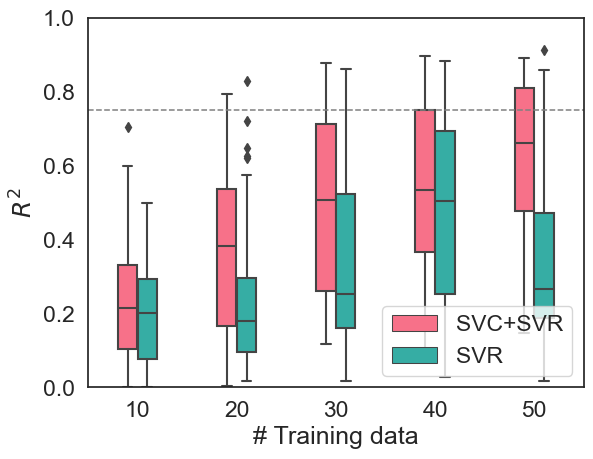

In [45]:
Plot1B1P = ComparisonResultsPlot([complexSVRR2Lists_1B1P, SVRR2Lists_1B1P], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

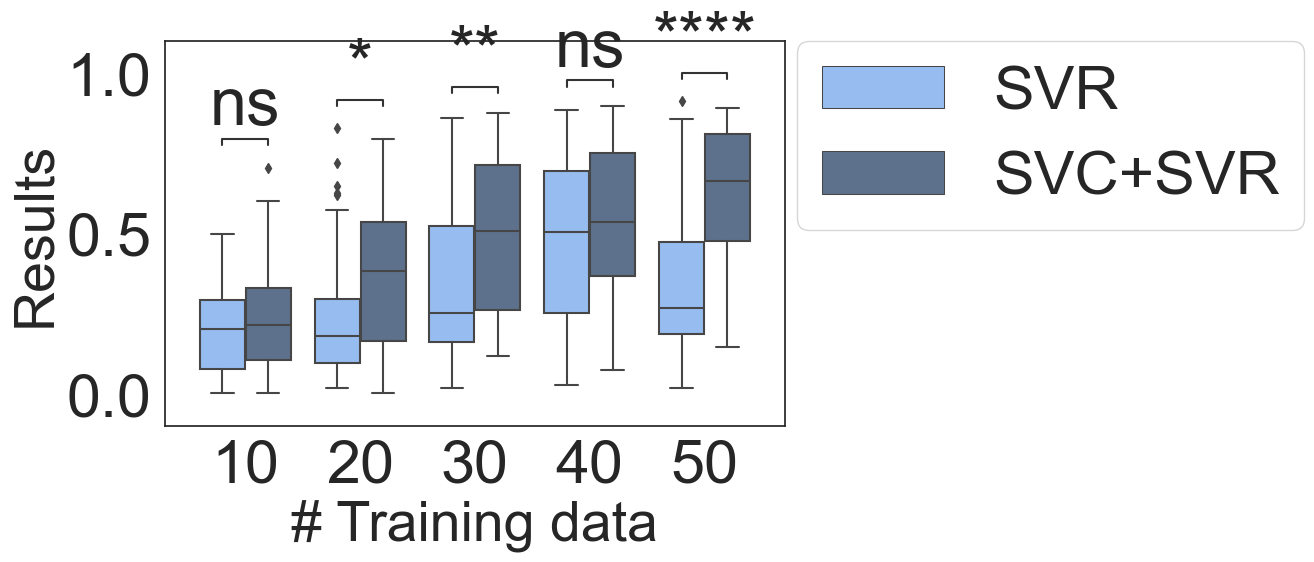

In [46]:
statsPlot(Plot1B1P, 'Mann-Whitney')

here 0.0


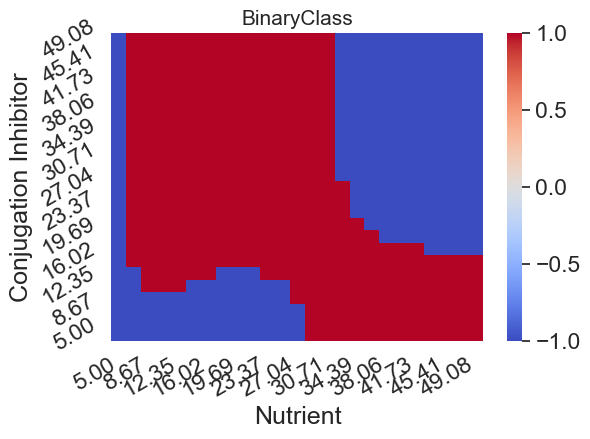

In [83]:
# F2b
F2bDF = processExcelFormat01('2B1P_2304ML06.csv', 0.4)
heatmapGenerator(F2bDF, 'BinaryClass')

here 0.559521703


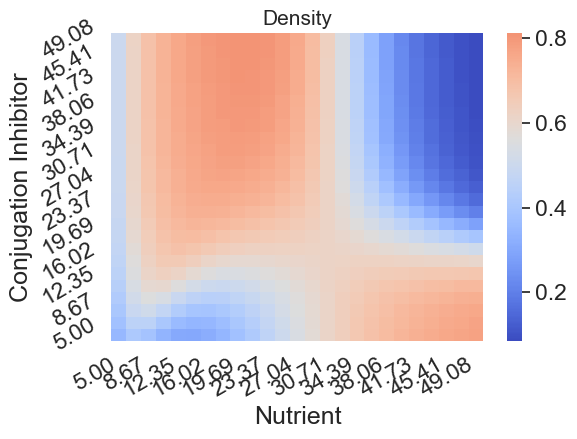

In [84]:
heatmapGenerator(F2bDF)

In [85]:
complexSVRSpearmanLists_2B1P, complexSVRPearsonLists_2B1P, complexSVRR2Lists_2B1P, complexSVRMSELists_2B1P, \
complexPredictedSVRSpearmanLists_2B1P, complexPredictedSVRPearsonLists_2B1P, complexPredictedSVRR2Lists_2B1P, \
complexPredictedSVRMSELists_2B1P, \
r2Recorder_2B1P, mseRecorder_2B1P, pearsonRecorder_2B1P, spearmanRecorder_2B1P, \
SVRSpearmanLists_2B1P, SVRPearsonLists_2B1P, SVRR2Lists_2B1P, SVRMSELists_2B1P, \
PredictedSVRSpearmanLists_2B1P, PredictedSVRPearsonLists_2B1P, PredictedSVRR2Lists_2B1P, \
PredictedSVRMSELists_2B1P, \
SVRr2Recorder_2B1P, SVRmseRecorder_2B1P, SVRpearsonRecorder_2B1P, SVRspearmanRecorder_2B1P,\
indexRecorder_2B1P, TrainXDFRecorder_2B1P, TrainYDFRecorder_2B1P, \
SVMSVRFullXDFRecorder_2B1P, SVMSVRFullYDFRecorder_2B1P, scXRecorder_2B1P, \
scDensityRecorder_2B1P, scDistanceRecorder_2B1P = \
ComparisonMultipleRun(30, '2B1P_2304ML06.csv',  1, 'ContinuousCompressed',\
                      [10, 20, 30, 40, 50], 0, ['poly', 'rbf'], 0.4)

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, gamma='auto')
R2:  0.9988810473871172
MSE:  0.00029602486184270304
Pearson:  0.9994403670990667
Spearman:  1.0
R2:  0.9871614665138969
MSE:  0.017381739829136756
Pearson:  0.9935599964339831
Spearman:  1.0
R2:  0.9687442052041175
MSE:  0.010628051843101524
Pearson:  0.9842480404878223
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -0.98245139 -457.06492834   -2.3806266            nan   -2.37989341
           nan           nan   -2.08874477   -1.35334619   -1.06348895]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.55928304         nan -2.34762064 -1.09404895 -1.09404895 -0.62289243
 -2.21183436 -1.07462698         nan -0.2097814 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan  0.65500352  0.6457937          nan
 -2.09712817         nan         nan -1.75460812]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:

SVM:  [0.3538019981274794, 0.052582895223141406, 0.5781275389078822, 0.3944116739699484]
SVR:  [0.06066752151542303, 0.006106981811180287, -0.24630777802461518, -0.031058338303757156]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, gamma=0.01)
R2:  0.9861692621371991
MSE:  0.09961733974821986
Pearson:  0.9930605531070094
Spearman:  0.8660254037844387
R2:  0.9861692621371991
MSE:  0.0584245034706257
Pearson:  0.9930605531070091
Spearman:  0.8660254037844387
R2:  0.9550171609098
MSE:  0.06196072129645735
Pearson:  0.9772497945304467
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.75840369e-01             nan             nan -1.25483661e+00
 -2.10567272e-01             nan -2.08803603e-01 -1.62238950e+06
 -2.10384915e-01 -2.46140148e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.24389118         nan -0.1054304          nan         nan
 -0.21056095  0.04258986 -0.20878073 -0.10137865]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.32817187286978977, 0.0663902356371291, 0.49914018999521886, 0.8833329894067163]
SVR:  [0.7785696503385968, 0.010075665458882652, 0.8823659390177052, 0.8649193302923344]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

SVC(C=0.1, degree=2, kernel='poly')
R2:  0.48643866395681534
MSE:  0.004226571855523164
Pearson:  -0.6974515495407658
Spearman:  -1.0
R2:  0.07652352900656986
MSE:  0.004833165910453571
Pearson:  0.276628865100101
Spearman:  -0.5
R2:  0.6966771239721489
MSE:  0.002826282491160022
Pearson:  0.8346718660480591
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -1.29020017 -1.29336494         nan         nan         nan
 -1.28883297         nan         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.29637452 -257.5289206    -1.2902071    -1.29016485           nan
   -1.29020714   -1.2902102  -648.51544145   -1.28999054   -1.48614073]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.25701706 -1.29003261 -1.28961286 -1.28949505         nan -5.79911301
 -1.29020604 -1.24175396 -0.90195535 -1.29219114]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:

SVM:  [0.11452897509216266, 0.06120808334886662, 0.45855636671378275, 0.5587887523614862]
SVR:  [0.06792034694235316, 0.07229423796243235, -0.2606153236905942, -0.37128577309716587]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.0487834071073379
MSE:  0.02758035875192519
Pearson:  0.22086966090284538
Spearman:  0.5
R2:  nan
MSE:  0.02758441533028948
Pearson:  nan
Spearman:  nan
R2:  0.8352743688915747
MSE:  0.027378428160617144
Pearson:  0.9139334597724142
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.92861615 -0.66259712         nan         nan         nan         nan
 -0.5035124          nan -0.53495332         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.50372022 -0.92970077 -1.32852742 -2.08927376 -0.50372022         nan
         nan -0.53689001         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913

SVM:  [0.27799614269055883, 0.03574263715059288, 0.28558567772922977, 0.32315164378006994]
SVR:  [0.24210059644935883, 0.04313983307403275, 0.49203719010798236, 0.3933341346823512]
SVC(C=0.1, degree=2, gamma=1.0, kernel='poly')
R2:  0.49238341662515606
MSE:  0.013059441140551948
Pearson:  -0.7017003752494051
Spearman:  -0.5
R2:  0.5299459251647661
MSE:  0.10799165074686407
Pearson:  -0.7279738492313899
Spearman:  -0.5
R2:  0.9960665328462037
MSE:  0.007640868644559856
Pearson:  0.9980313285895408
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-89.71826615          nan  -8.82134429 -88.17424804 -26.81285551
 -32.29052473 -60.28736009 -74.17931972 -66.83886946 -60.08231747]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -8.96750570e+01 -4.68503777e+01 -8.20629550e+00
 -1.77511204e+04 -9.02959649e+00

SVM:  [0.0551268436313541, 0.08076841257475409, 0.24026997446324128, 0.24205735453554597]
SVR:  [0.03485932131060855, 0.03993023650900987, 0.18670651116286371, 0.011379035677915476]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=2, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -0.7042378    -4.11722044  -21.76329373 -176.3793746            nan
   -0.84993267   -0.66284267   -0.62876352   -4.47259194   -0.7042378 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.66285    -0.66284266 -0.66693054 -0.66280565 -0.66292408
 -0.74083262         nan         nan -0.66423821]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -2.12266183e+03             nan -6.62842693e-01
 -6.58015026e-01 -2.17473105e+01 -2.23522503e+00 -9.02377546e-01
 -6.85305321e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

R2:  0.9979946966319355
MSE:  0.030471213333250213
Pearson:  -0.9989968451561475
Spearman:  -1.0
R2:  0.9970363519437707
MSE:  0.03038461970478837
Pearson:  -0.9985170764407443
Spearman:  -1.0
R2:  0.9939619576560105
MSE:  0.03018231388172281
Pearson:  0.996976407773028
Spearman:  1.0


s/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/pyth

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/User

SVM:  [0.3817133411539006, 0.007603619917060925, 0.9536233165731955, 0.7910003518369294]
SVR:  [0.19904391264761154, 0.05500903771791704, 0.44614337678330684, 0.5604561086010201]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma='auto', kernel='poly')
R2:  0.9967835514172422
MSE:  0.04061541805553801
Pearson:  -0.998390480432001
Spearman:  -1.0
R2:  0.99986756857678
MSE:  0.0049668906513063065
Pearson:  0.9999337820959847
Spearman:  1.0
R2:  0.9997265252587035
MSE:  0.005268515669362917
Pearson:  0.999863253279519
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -158.92485078   -103.44769545   -164.06953267             nan
 -11994.741722     -214.89608781   -215.44523047    -18.88030685
   -140.42169921   -214.89612715]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -209.74016982 -102.8377145            nan  -79.8082

SVM:  [0.7021459912817669, 0.029750330636384985, 0.40291880083766485, 0.8147150378817973]
SVR:  [0.21713003490193147, 0.03263958044887735, 0.4659721396198826, 0.4142826705351534]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.83141215 -2.27236137 -0.3592557          nan  0.64331414 -2.28930505
 -2.11766953 -2.2898093  -2.28888114         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.28858043         nan -2.2898093  -2.11742929 -4.80571532 -1.54664805
         nan -2.27233671 -7.40239275 -2.27233673]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-8.69797170e+00 -2.28977156e+00             nan -2.09371749e+00
 -2.23620446e+00 -6.43174477e+03             nan -2.26621037e+00
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.00016561723761470833
MSE:  0.279029938141404
Pearson:  -0.012869236092896377
Spearman:  -0.5
R2:  0.13454119901619147
MSE:  0.008485636493724762
Pearson:  0.3667985809898826
Spearman:  -0.5
R2:  0.001422274398439172
MSE:  0.011728142245492845
Pearson:  0.03771305342237845
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0731221241334729, 0.052364943281955116, 0.3428732070398737, 0.2878817972366873]
SVR:  [0.842083575089008, 0.007601759995110257, 0.9176511183935907, 0.9365812387342539]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

SVC(degree=4)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.11917565e+00 -3.21658631e+00 -8.92667366e-01 -1.09304663e+00
 -8.75598700e+02 -2.38757400e+00             nan -8.57116838e-01
 -3.32915967e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -52.20968998          nan   0.57596067  -0.38082615
  -0.88805007  -0.89487686  -1.09304663          nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.8965512  -1.1255591  -1.09365569 -1.09459289 -1.17486591  0.20117875
 -0.89382381         nan -0.89749046         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

R2:  0.19898635639308884
MSE:  0.12744852354460914
Pearson:  -0.4460788679068858
Spearman:  -0.5
R2:  0.004991202191898471
MSE:  0.11392984837449484
Pearson:  0.07064844083133376
Spearman:  0.5
R2:  0.8461777528516589
MSE:  0.8504304647311528
Pearson:  -0.9198792055762859
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-503.32981397           nan           nan           nan -101.87951575
 -420.11009302 -101.26669673           nan -101.63871874           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan  -98.88392716 -100.98501587           nan -103.23509143
 -103.16589918 -

SVM:  [0.07009423453757403, 0.05684463596082006, 0.37761279661665, 0.7589436225171508]
SVR:  [0.1657906688123989, 0.05368182539663509, 0.4071740031146376, 0.407857130759364]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2)
R2:  0.6913288823873018
MSE:  3.013898083002328
Pearson:  -0.8314618947295793
Spearman:  -1.0
R2:  0.9936627446905243
MSE:  0.012360374094664214
Pearson:  0.9968263362745412
Spearman:  1.0
R2:  0.17448293524266265
MSE:  0.01615239245728037
Pearson:  0.4177115454984009
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3180188141398264, 0.018577708095005807, 0.3953007717072866, -0.38644948044725597]
SVR:  [0.32014988510490655, 0.030184636059362915, 0.5658178904072464, 0.6791663012446362]
SVC(C=1000.0, degree=5, gamma=1.0)
R2:  0.9656800525051069
MSE:  0.003912409287327776
Pearson:  0.9826902118700007
Spearman:  1.0
R2:  0.2360156259406059
MSE:  0.015413278348239712
Pearson:  0.4858143945382906
Spearman:  0.5
R2:  0.6988549287817626
MSE:  0.006034240560554768
Pearson:  0.8359754355133663
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2569799233256707, 0.03940042724273517, 0.8953362169270996, 0.1995984312819143]
SVR:  [0.20982210449540212, 0.03956956784520752, 0.4580634284631357, 0.30547395323354654]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.54505814 -0.29285729         nan -0.29256123 -4.69713814         nan
         nan         nan -0.50294269 -0.15118728]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.97033880e-01 -3.49542147e-01 -4.53136442e-01 -3.59629174e+00
             nan  6.78218127e-02 -3.44212725e-01  6.78218128e-02
 -4.15217601e+03 -2.67507561e-03]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.90204088e+04  2.84029975e-01  5.08421568e-01 -3.33259083e-01
             nan             nan -5.60532276e+00 -3.44609726e-01
 -2.97491887e-01 -3.49541068e-01]
  category=UserWarning,
/Users/ychha/anaconda3/l

R2:  0.9276249167367442
MSE:  0.17049928999977534
Pearson:  0.9631328655677491
Spearman:  1.0
R2:  0.9206793689534911
MSE:  0.10163519076063626
Pearson:  0.9595203848556274
Spearman:  1.0
R2:  0.9891735985772154
MSE:  0.00397378559596215
Pearson:  0.9945720680660679
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7404278513594622, 0.004730591651109219, 0.8905851160090996, 0.3847052050198154]
SVR:  [0.47526299505043357, 0.024745290915578793, 0.6893932078650276, 0.8277092733277687]
SVC(C=0.01, gamma=0.0001, kernel='poly')
R2:  0.9183339255829663
MSE:  0.048823763443862155
Pearson:  0.9582974097757786
Spearman:  1.0
R2:  0.9942023660693856
MSE:  0.058694234004624694
Pearson:  0.9970969692408989
Spearman:  1.0
R2:  0.6898140897559605
MSE:  0.05869659927244677
Pearson:  0.8305504739363893
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.26215225384425617, 0.04091355964651632, 0.512008060331344, 0.5583000000293984]
SVR:  [0.054545063614693905, 0.039838063968519105, 0.23354884631420011, 0.6030869391697053]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(degree=4, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -3.76269169e-01 -4.53304015e-01 -1.14711253e-01
 -6.62082345e-02  1.28826544e-01  1.35656281e-01             nan
 -1.00588739e+04 -4.52521593e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.79439157 -0.37541157         nan -0.45334559         nan -0.44533819
 -0.4533058          nan -0.45331112 -2.89245762]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.24645284 -0.45241768  0.24525973         nan -0.4516246  -0.39780126
         nan -0.45297455 -4.10661415 -0.36552903]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.33481512773511635
MSE:  0.12710018519613533
Pearson:  -0.5786321177873867
Spearman:  -0.5
R2:  0.8343982720340053
MSE:  0.3099929243276429
Pearson:  -0.9134540338922399
Spearman:  -0.5
R2:  0.581918991647967
MSE:  0.09276654837703559
Pearson:  -0.7628361499352054
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7841593501158484, 0.008524604341561076, 0.8443570878500545, 0.470217210294274]
SVR:  [0.2360486314115621, 0.03770808187284928, 0.4858483625696006, 0.35308146211459157]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.98881484 -1.1576172          nan -0.77943118 -1.11197845  0.37157236
 -0.85347835 -3.76850554 -3.86912601 -0.97555962]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.88023792 -1.15745805 -0.98907109 -3.86862784 -7.88042377 -0.87861911
 -3.51751946 -0.77359459         nan -1.15468703]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -7.11970592e+00
 -1.15741738e+00 -1.16910986e+00 -2.20400083e+04             nan
 -1.07931856e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.9601956334372449
MSE:  0.011016700020507428
Pearson:  0.979895725798028
Spearman:  0.5
R2:  0.5864967100774602
MSE:  0.06974265757491614
Pearson:  0.7658307320011779
Spearman:  0.5
R2:  0.7984354972958226
MSE:  0.01613835602317749
Pearson:  0.8935521793917927
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8869056867093105, 0.008640269836831877, 0.48478374004261726, 0.35202724105163136]
SVR:  [0.395109506068154, 0.028491644278334415, 0.6285773668118777, 0.43019508822874925]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=0.01)
R2:  0.4804254414543721
MSE:  0.007484106434196271
Pearson:  -0.6931272909461668
Spearman:  -1.0
R2:  0.44820414495242805
MSE:  0.006929970463472873
Pearson:  -0.6694805037881448
Spearman:  -1.0
R2:  0.5621858165592357
MSE:  0.004672175122835397
Pearson:  0.7497905151168798
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -19.63770111 -19.87393445 -20.96648193  -0.42366765
          nan          nan -19.65151993  -0.56992227 -33.43803818]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-19.65710395          nan  -0.5572101  -19.48829595 -32.09630282
 -29.82156608 -19.02489612 -10.48492725 -18.97686666 -19.66069792]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan  -14.5884559   -18.63704224  -19.65708397           nan
  -17.69179144 -189.84630109   -3.0497265   -14.38269617  -19.64672185]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

SVM:  [0.6466725832500936, 0.06374036761463804, 0.8165150198968867, 0.7986986160736856]
SVR:  [0.8362061128834963, 0.007774444339137345, 0.9144430615863932, 0.8264290408884039]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.9638799698647599
MSE:  0.004540605173839513
Pearson:  0.9817738893781807
Spearman:  0.5
R2:  0.6270658269465221
MSE:  0.0876544313463316
Pearson:  0.7918748808659877
Spearman:  1.0
R2:  0.6317376928433256
MSE:  0.03001708363385065
Pearson:  0.7948192831350568
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6391219107156705, 0.04345491638404351, 0.2670821968018286, 0.2945281619151485]
SVR:  [0.0012722373526635586, 5.776406007763213, -0.03566843636415204, 0.19887082013085036]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.0001)
R2:  0.9554373504375888
MSE:  0.11057066964421818
Pearson:  -0.9774647566217357
Spearman:  -1.0
R2:  0.6343932179155496
MSE:  0.06721441593171533
Pearson:  0.7964880525880785
Spearman:  1.0
R2:  0.965312356069665
MSE:  0.28842939024665176
Pearson:  0.9825031074096742
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.28977411e-02  9.25067005e-02             nan -6.21984171e-02
 -5.34500015e-02             nan -1.31001941e-01             nan
 -8.36081536e+02 -6.28946784e-02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -6.28977411e-02  3.52402320e-01  9.79847472e-02
 -5.22359916e-02  5.09463812e-01 -1.37708554e+01 -2.45837109e+05
             nan  6.78377472e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.06283324 -0.11784389 -0.49519138         nan         nan
 -0.04746622 -0.06225306 -2.4635262   0.76086947]
  category=UserWarning,
/Users/ychha/anaconda3/l

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.96190732e+00 -1.04684041e+00             nan -1.53326592e+00
 -1.89999924e+00 -2.67561903e+00 -4.74478587e+03 -2.35382394e+00
 -2.56889788e+00 -1.98047506e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Tra

    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estim

SVM:  [0.7178967231654895, 0.05618316082495056, 0.6975049465062417, 0.6959214774262047]
SVR:  [0.02047784906684976, 0.06781599276072599, -0.1431008353115027, 0.020242901612568732]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

SVC(C=0.01, gamma=0.01)
R2:  0.6962953955541311
MSE:  0.03814872555025924
Pearson:  0.8344431649633971
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.64740732  -1.97832134  -1.76211799          nan  -1.76664014
 -18.43506754 -26.86170487  -3.41975202 -22.64665898  -3.32276563]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan  -1.77132212  -1.98950878  -1.77172113  -1.76667168
  -8.35997435 -51.21057659  -1.7669623   -1.77162002  -1.97842694]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-18.4321024   -1.72209335          nan -26.54849231  -1.77121181
  -2.49787869  -1.77121181  -1.97842794  -2.41107936  -1.98970745]
  category=UserWarning,


R2:  0.7215164362514394
MSE:  0.038641104106719316
Pearson:  0.8494212360492522
Spearman:  1.0
R2:  0.06452924684899262
MSE:  0.03865453381365406
Pearson:  0.254026075135984
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.51373371e+00 -1.09305831e+03 -1.85634134e+01 -5.30568736e+00
 -4.26201682e+06             nan             nan -2.05059248e+01
 -2.46877827e+00 -1.88664634e+01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.34805182  -4.53469854  -5.72273705 -19.65092725          nan


SVM:  [0.31465319599900354, 0.05313905282144501, 0.13877269673829637, 0.7441922659845915]
SVR:  [0.2337929086006801, 0.05973984913389465, -0.4835213631275046, -0.3481536815452761]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma=10.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -1.28702834 -1.28702813 -1.3340514  -1.28463327 -1.5279892
 -1.28702788         nan -1.28406174 -1.39809192]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -1.28702788 -1.29594321 -1.81889809 -0.28044333         nan
 -1.0776318          nan -1.86499033         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.28687019e+00             nan -4.59565415e+04  6.14487825e-01
 -1.28702788e+00 -1.27850402e+00  3.84376976e-01 -1.28621692e+00
 -1.81843945e-01 -3.09773107e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

R2:  0.9999830077667765
MSE:  0.04395512743029429
Pearson:  0.999991503847296
Spearman:  1.0
R2:  0.7898754871103486
MSE:  0.08259988054164613
Pearson:  0.8887493949985835
Spearman:  0.5
R2:  0.7094772390409388
MSE:  0.04418510456278654
Pearson:  0.8423047186386521
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.40566046290615676, 0.039055823043784806, 0.8815696702478645, 0.2039685864306505]
SVR:  [0.8414216199414346, 0.006702343528483017, 0.9172903683902032, 0.8657380991932515]
SVC(C=10000.0, gamma=1.0, kernel='poly')
R2:  0.974023681511528
MSE:  0.004144906030996078
Pearson:  -0.9869263809988705
Spearman:  -0.5
R2:  0.8465235194532803
MSE:  0.004144541060687981
Pearson:  -0.9200671276886703
Spearman:  -1.0
R2:  nan
MSE:  0.007336186353025988
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.6992323322809898, 0.10509993614916036, -0.47503021109968163, 0.7995921890138146]
SVR:  [0.7003985123935538, 0.012837605389229822, 0.8368981493548384, 0.7995767639050391]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.55907481e-01  1.31599310e-02 -1.52999275e+03 -1.34598951e+01
             nan -4.04249248e+00  4.43387264e-02 -3.55957373e-01
 -2.18573441e-01 -2.65740537e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-14.35481576  -0.13466236  -0.39584845          nan  -0.3564155
          nan          nan  -0.35595084  -1.77112395  -0.30685465]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.43245042         nan -0.35529626 -0.83180398 -0.34481277         nan
 -0.38227136 -0.35646597 -1.0910453  -0.35529626]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklea

R2:  0.9626834784253927
MSE:  0.009579524275471228
Pearson:  0.9811643483256984
Spearman:  0.5
R2:  0.9988088256375325
MSE:  0.037848048431204824
Pearson:  0.9994042353510076
Spearman:  0.8660254037844387
R2:  0.9847706625810563
MSE:  0.030389914772393195
Pearson:  0.9923561168154583
Spearman:  1.0


d.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/pytho

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6458494262416277, 0.041774599421997995, 0.22259581865346043, 0.3537806993197476]
SVR:  [0.011660064554890234, 0.045122277646951564, 0.10798177880962259, 0.17221040261081577]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma='auto')
R2:  0.02019958555356495
MSE:  0.020101804568653837
Pearson:  -0.14212524601056964
Spearman:  0.5
R2:  2.201660091293195e-05
MSE:  0.021790782086284845
Pearson:  0.004692185089372719
Spearman:  0.5
R2:  0.5486204995844766
MSE:  0.014944211765227755
Pearson:  0.740689205797193
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.12991830e-01 -2.98225365e-01  3.03919006e-01 -3.96541931e-01
  5.43442477e-02 -3.96506226e-01             nan             nan
 -3.59905028e-01 -1.66695822e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-9.17313173e+01 -5.04413910e+01 -1.00584832e+03 -3.96466968e-01
 -3.22103201e-01             nan -1.04559971e+03  3.58457283e-01
  4.82267655e-01 -3.03576654e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.79195570e-01 -1.84996652e+02 -3.95131311e-01 -2.89576797e-01
 -3.96260523e-01             nan  5.50936991e-02 -3.96144763e-01
  9.10211270e-01 -2.89576797e-01]
  categ

SVM:  [0.7390755005240938, 0.011752297509665315, 0.7330998298496378, 0.7254237261903904]
SVR:  [0.581825023850167, 0.03887817643326965, 0.7627745563730916, 0.813324559765332]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.90540635e-01 -4.91964500e-01             nan -2.96862969e-01
 -1.30466431e+06 -2.90615984e-01             nan             nan
 -2.32884726e-01 -2.23365767e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.92205457e-01 -2.90960645e-01             nan -2.90612750e-01
 -2.63533435e-01             nan             nan -4.90819534e-01
 -9.25346696e-01 -1.39104060e+06]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.24067197  -0.2537961   -0.29045074  -0.29043836          nan
          nan  -0.65128078          nan  -0.92970532 -74.47961593]
  category=UserWarning,


R2:  0.9499378737409798
MSE:  0.0013596846955564537
Pearson:  -0.9746475638614093
Spearman:  -1.0
R2:  0.8737933288519858
MSE:  0.001213462404189112
Pearson:  -0.9347691313110346
Spearman:  -1.0
R2:  0.871174343825809
MSE:  0.0015949956291007462
Pearson:  -0.9333672073872152
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.54616552e+00             nan -1.71093009e+02 -2.32884815e-01
             nan -1.29840562e+06 -2.97525981e-01             nan
 -2.31659266e-01 -6.37628814e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan   -7.46341127   -6.5118115    -6.49663131  -30.94360483
   -6.62259587   -9.45644381   -6.3633711  -341.22262389  -38.80972393]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fit

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _on

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan   -61.71410223 -5043.93444717            nan
   -13.30561571   -89.32685809    -6.62071325   -30.3100681
            nan   -78.16005464]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.07602726022171633, 0.06611686230727357, 0.06889342454598343, -0.35720306149717457]
SVR:  [0.000251914149685581, 0.06319133922173902, -0.01587180360531156, -0.004470254067951543]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -2.67641891          nan  -1.1293488   -1.12710206  -1.13303208
  -5.21028731  -1.17487208 -28.77783169  -1.12939275  -1.12934841]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.12934918e+00 -1.32733000e+01 -1.32733000e+01 -1.32733000e+01
             nan             nan -2.01125274e+03 -1.12934918e+00
 -3.69316359e+00 -1.13706519e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line

R2:  0.9943290949079938
MSE:  0.09505829865385174
Pearson:  0.9971605161196433
Spearman:  1.0
R2:  0.977011390667233
MSE:  0.09513713738378272
Pearson:  0.9884388654171955
Spearman:  0.5
R2:  nan
MSE:  0.09394318631038562
Pearson:  nan
Spearman:  nan


on3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backen

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2335378412995643, 0.04393504767398834, 0.6386761181203722, 0.4869277619972783]
SVR:  [0.22021695959858864, 0.044458097285392476, 0.43589426930558983, 0.5246152234989926]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.18323454977816903
MSE:  0.047905826599002006
Pearson:  0.4280590494057672
Spearman:  0.5
R2:  0.8913123709079946
MSE:  0.042564462787228495
Pearson:  0.9440934121727549
Spearman:  1.0
R2:  0.8255822927693698
MSE:  0.026259191748277216
Pearson:  0.9086155913087614
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.019059239155723443, 0.018724910089219553, 0.5054500480478075, 0.47252065881207067]
SVR:  [0.926459243833486, 0.004285588018974365, 0.9625275288704664, 0.9744999221006214]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=10.0, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.45866011          nan  -0.47437793  -8.77494336          nan
  -0.47437793  -3.47143248 -35.94928373  -3.47143248  -3.06550829]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -1.99235789 -11.00553598  -0.47623214  -0.1597145   -2.6434614
          nan  -0.48925257  -0.47608883  -0.45828799  -0.50821027]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.39826510e+00 -1.27606536e+00 -4.76048624e-01 -4.76270899e-01
 -1.39826510e+00 -1.31840733e+00 -4.76260345e-01 -2.04888050e+05
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pack

R2:  0.09166316780938373
MSE:  0.013102292629168712
Pearson:  0.302759257181979
Spearman:  0.5
R2:  0.8007200834963955
MSE:  0.0026516151370227867
Pearson:  0.894829639370755
Spearman:  1.0
R2:  0.42461748851620856
MSE:  0.012381361842747988
Pearson:  0.6516268015637543
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -2.78053222e+00             nan             nan
 -2.66305162e+00 -2.78053222e+00             nan -6.95622712e+04
 -1.31927677e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.425166206823254, 0.061254326254556374, 0.6994184895938952, 0.6017303979884421]
SVR:  [0.7206644737140523, 0.018259482318838564, 0.8489195920192041, 0.8998888257210337]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=5)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.47791267         nan -0.47794434 -0.40262824 -1.38862198
  0.25659864 -4.70024239 -0.44463418 -0.47794434]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict

R2:  0.9086580288415399
MSE:  0.0074534659170243335
Pearson:  0.9532355578982246
Spearman:  0.5
R2:  0.02826415330061113
MSE:  0.01479386202916827
Pearson:  -0.16811946139757622
Spearman:  0.5
R2:  0.9163960663392875
MSE:  0.022695170032329195
Pearson:  0.9572857809135614
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -7.42699924 -4.14063352 -7.41834737         nan         nan
 -7.79227194         nan         nan -6.99114022]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.99118039 -6.99118039 -7.00328076         nan         nan         nan
 -8.10098309         nan         n

SVM:  [0.8455191746732923, 0.04851782711275213, 0.78818567409406, 0.6934461343851985]
SVR:  [0.7673398298003977, 0.010111224354559923, 0.875979354665621, 0.8716402410650446]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.4491093  -15.44364525  -0.44904797 -23.61601651  -0.45651239
 -35.27399488          nan          nan  -0.46106412  -0.48407122]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -32.39289674          nan          nan          nan
 -29.76731991  -1.95145684  -1.75621312  -0.44903315          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-34.3072889           nan          nan -19.74848513  -0.46829805
 -10.17259217          nan          nan          nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

R2:  0.5382540832417244
MSE:  0.030789643419831994
Pearson:  -0.7336580151826355
Spearman:  -1.0
R2:  0.7983805894133912
MSE:  0.030789598759534634
Pearson:  -0.8935214543665928
Spearman:  -1.0
R2:  0.24653400628324082
MSE:  0.03081367831010867
Pearson:  -0.49652190916740097
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.11139531366335585, 0.041757753622460564, 0.2474092908435999, 0.5097716774367288]
SVR:  [0.3591920234268666, 0.04175770032465245, 0.599326307971598, 0.7203452025848149]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.6685498277508198
MSE:  0.2359377743330996
Pearson:  0.8176489636456588
Spearman:  0.5
R2:  0.685866816747529
MSE:  0.14739052804640673
Pearson:  0.8281707654508996
Spearman:  0.5
R2:  0.7841541500060559
MSE:  0.1462576140086782
Pearson:  0.8855247879116971
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6130563343870729, 0.01790350299736578, 0.7884063701167687, 0.5608903331513962]
SVR:  [0.2303994184843852, 0.03264042386870336, 0.4799993942541858, 0.3467004712138581]
20
SVC(C=0.01, degree=2, gamma='auto')
R2:  0.9636393027518272
MSE:  0.0011929753804567529
Pearson:  0.9816513142413792
Spearman:  0.7999999999999999
R2:  0.7345416008973599
MSE:  0.03733540394056806
Pearson:  0.8570540244916649
Spearman:  1.0
R2:  0.9045720414286486
MSE:  0.0005846085375243917
Pearson:  0.9510899228930186
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9144219650199791, 0.0333766210949975, 0.30321969489376366, 0.7663381509734357]
SVR:  [0.24126869190432124, 0.04741854663462829, 0.49119109509876224, 0.3617137150199065]
SVC(C=1000.0, degree=5, gamma=1.0)
R2:  0.2369001378433048
MSE:  0.09269898285079257
Pearson:  -0.4867238825487246
Spearman:  -0.39999999999999997
R2:  0.9393766873533884
MSE:  0.09247139789988976
Pearson:  0.9692144692241175
Spearman:  1.0
R2:  0.08369632110631449
MSE:  0.023510533546783695
Pearson:  -0.2893031647015194
Spearman:  -0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7393565942111003, 0.015752761514185292, 0.9383675995247773, 0.7550677885368307]
SVR:  [0.33051703061615495, 0.042610392241884815, 0.574906105913092, 0.630075144781185]
SVC(C=10.0, degree=5)
R2:  0.8273287164215912
MSE:  0.010749421922505263
Pearson:  0.90957611909152
Spearman:  0.7999999999999999
R2:  0.9570681082377317
MSE:  0.001870318514926693
Pearson:  0.9782985782662326
Spearman:  1.0
R2:  0.8175845624496781
MSE:  0.011247860707380215
Pearson:  0.9042038279335463
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7919180015930112, 0.013326383226149131, 0.8421039331968023, 0.9512693111574854]
SVR:  [0.9372187226087058, 0.0033350035736592998, 0.9681005746350453, 0.9626371607660466]
SVC(C=100.0, degree=2, gamma=10.0, kernel='poly')
R2:  0.8295090480886842
MSE:  0.0393227002854175
Pearson:  0.9107738731917401
Spearman:  1.0
R2:  0.9788094900711445
MSE:  0.0006708750470562168
Pearson:  0.9893480126179788
Spearman:  1.0
R2:  0.9963762896830358
MSE:  0.0344670790035915
Pearson:  0.9981865004512109
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5693839768565903, 0.041492994645410536, 0.8836002207696181, 0.6837515599844151]
SVR:  [0.1561643836916216, 0.07725988493724269, 0.3951763956660641, 0.35974104936080603]
SVC(C=10000.0, degree=5, gamma=10.0)
R2:  0.8813824440429023
MSE:  0.009320168705282765
Pearson:  0.9388197079540365
Spearman:  0.7999999999999999
R2:  0.7634659327439138
MSE:  0.027296744792820755
Pearson:  0.8737653762560713
Spearman:  0.19999999999999998
R2:  0.8462813232306008
MSE:  0.0143025395696217
Pearson:  0.9199354994947205
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4171238943485696, 0.03583019846196759, 0.4746261131122436, 0.544440061104244]
SVR:  [0.22524767111333008, 0.03644815853742212, 0.47460264549761, 0.39340251905985296]
SVC(degree=2, gamma=1.0, kernel='poly')
R2:  0.22050598368442154
MSE:  0.006987923783742803
Pearson:  0.4695806466246468
Spearman:  0.39999999999999997
R2:  0.8475742160279756
MSE:  0.0046134704933805705
Pearson:  0.9206379397070139
Spearman:  0.19999999999999998
R2:  0.690607783092823
MSE:  0.007239279236593092
Pearson:  0.8310281481952478
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36858669540955363, 0.046173387479105044, 0.3148104191125549, 0.6971359688647973]
SVR:  [0.7009277398504625, 0.016215456159466658, 0.8372142735587241, 0.7149609482320899]
SVC(C=100.0, degree=5, gamma='auto')
R2:  0.9683727042012189
MSE:  0.05777375205268895
Pearson:  0.9840592991284717
Spearman:  1.0
R2:  0.8767939597693486
MSE:  0.05769815441567374
Pearson:  -0.9363727675286957
Spearman:  -0.7999999999999999
R2:  0.0007905697373289439
MSE:  0.02144862418662908
Pearson:  0.028117071990677533
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.07669589222914752, 0.009241508733906764, 0.9358978935179227, 0.5953048465593097]
SVR:  [0.7334859526342966, 0.017886382858419567, 0.8564379444152956, 0.9188902936049174]
SVC(C=100.0, degree=2, kernel='poly')
R2:  0.7250252078327294
MSE:  0.0018653501523738032
Pearson:  0.851484120716722
Spearman:  0.7999999999999999
R2:  0.027493280934618388
MSE:  0.007532366917555304
Pearson:  0.16581097953579066
Spearman:  0.39999999999999997
R2:  0.05949642624203275
MSE:  0.01718299574220258
Pearson:  -0.24391889275337558
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.05158110072170828, 0.05608939123569042, 0.9636945258154812, -0.2145881234721907]
SVR:  [0.0357781480974581, 0.05010916562779631, -0.18915112502297762, -0.21485023878667217]
SVC(C=100.0)
R2:  0.9768987521346975
MSE:  0.028592450114530762
Pearson:  0.9883818857783144
Spearman:  1.0
R2:  0.7781440203120241
MSE:  0.024164008004341188
Pearson:  0.8821247192500751
Spearman:  1.0
R2:  0.8925379408768735
MSE:  0.012780282019280905
Pearson:  0.944742261612591
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2328456809766506, 0.043134952753031974, 0.4826553815908651, 0.4223164339311715]
SVR:  [0.008672111109982053, 0.04439644915092289, 0.09312417038547, 0.046056535217745505]
SVC(C=100.0, degree=4)
R2:  0.6322015324128631
MSE:  0.006242493353410606
Pearson:  0.7951110189230577
Spearman:  0.7999999999999999
R2:  0.9046303725273295
MSE:  0.003262208568640031
Pearson:  0.9511205877949073
Spearman:  1.0
R2:  0.9163380942504744
MSE:  0.0032389812011839906
Pearson:  0.9572555010291006
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4759551033987649, 0.010777455247634004, 0.8826299608857261, 0.8753179712914096]
SVR:  [0.5994579897428536, 0.020637331857397315, 0.7742467240762816, 0.7358079757403795]
SVC(degree=4, gamma=10.0, kernel='poly')
R2:  0.7893628020348656
MSE:  0.02993197923343567
Pearson:  -0.888460917561862
Spearman:  -0.19999999999999998
R2:  0.28611773637146715
MSE:  0.012115116705038648
Pearson:  -0.5348997442245296
Spearman:  -0.19999999999999998
R2:  0.9365875950854433
MSE:  0.013496587273331164
Pearson:  0.9677745579862301
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.16151197945865844, 0.06318573717735776, 0.3871347475884953, 0.31443747625816165]
SVR:  [0.09820365592056061, 0.04486092579138105, 0.3133746255212132, 0.12959686697146536]
SVC(C=1000.0, degree=2, gamma=0.1, kernel='poly')
R2:  0.9963210602957472
MSE:  0.0019848776768685086
Pearson:  0.9981588352039705
Spearman:  1.0
R2:  0.9916288652205799
MSE:  0.0014946573785374862
Pearson:  0.9958056362667264
Spearman:  1.0
R2:  0.6473717827319126
MSE:  0.006134814615827343
Pearson:  0.804594172693236
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9117305889104903, 0.005774264164194825, 0.7652931696772676, 0.9536064021814583]
SVR:  [0.8232656220599617, 0.01106497737578857, 0.9073398602838748, 0.9503221303466891]
SVC(C=10.0, gamma=10.0)
R2:  0.9692328030809269
MSE:  0.005506954042487606
Pearson:  0.9844962179109308
Spearman:  1.0
R2:  0.5816653497949928
MSE:  0.017851927571291115
Pearson:  0.7626698825802635
Spearman:  0.6000000000000001
R2:  0.11670629978999482
MSE:  0.05849367352107507
Pearson:  -0.34162303755747336
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3528806582294579, 0.02931933550876408, 0.5012212867307747, 0.4592189321280111]
SVR:  [0.23690901590027388, 0.0326452564409477, 0.4867330026824501, 0.33735568620076944]
SVC(C=100.0, degree=2, kernel='poly')
R2:  0.9651836908591132
MSE:  0.014396116895422969
Pearson:  -0.9824376269560895
Spearman:  -1.0
R2:  0.16563112196316104
MSE:  0.011670037712834628
Pearson:  0.40697803621714146
Spearman:  0.7999999999999999
R2:  0.021792695033684507
MSE:  0.013381474456924697
Pearson:  0.14762349079223297
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7113514206008728, 0.046265296096081314, 0.9832561611959694, 0.0035090777210549174]
SVR:  [0.7480708549670931, 0.013728943775398334, 0.8649108942354081, 0.8560402217223527]
SVC(C=100.0, degree=2, gamma=0.1, kernel='poly')
R2:  0.33474534080147217
MSE:  0.04524877541318056
Pearson:  0.5785718112745143
Spearman:  0.7999999999999999
R2:  0.013695120880282036
MSE:  0.06389367394488613
Pearson:  0.11702615468467734
Spearman:  -0.39999999999999997
R2:  0.24949432907209465
MSE:  0.024110268643290227
Pearson:  0.49949407311007665
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19088698589000686, 0.012822734278045467, 0.3994733719821153, 0.6973610011779342]
SVR:  [0.1596747527450901, 0.03862727853303466, 0.3995932341082494, 0.21971088740421305]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.0025449207356105018
MSE:  0.04439688540529351
Pearson:  -0.05044720741141678
Spearman:  -0.316227766016838
R2:  0.8492001464915023
MSE:  0.03934661567040699
Pearson:  0.9215205621642429
Spearman:  0.7999999999999999
R2:  0.8271377479486679
MSE:  0.03793832204359555
Pearson:  0.9094711364021774
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6861125744817934, 0.04946971071508533, 0.6313072974547136, 0.7396285624950212]
SVR:  [0.1305493400754627, 0.04952760625192875, 0.3613161220807378, 0.42816653128286947]
SVC(C=1000.0, degree=2, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -9.56601993 -29.88221646 -22.24310339 -23.35404984          nan
 -41.64817191          nan -22.09317666 -22.20760732 -23.34709285]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = se

R2:  0.00515595227087723
MSE:  0.033794406309412224
Pearson:  -0.07180495993228622
Spearman:  0.39999999999999997
R2:  0.02284833710179236
MSE:  0.014582223861793621
Pearson:  0.15115666409984166
Spearman:  -0.19999999999999998
R2:  0.6124722039569312
MSE:  0.009355004591783454
Pearson:  0.7826060336829325
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.33297312e+01 -1.48437307e+00 -2.22200914e+01             nan
 -1.78939191e+01 -2.22115469e+01 -4.92789425e+04 -3.31980449e+01
 -2.01352172e+01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.8341649168329526, 0.03952906681085191, 0.7856812545026753, 0.8284524358516526]
SVR:  [0.9452966192423731, 0.0022342932793263798, 0.9722636572670876, 0.9590483973141443]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.998954978047481
MSE:  0.007628748921632684
Pearson:  -0.9994773524435063
Spearman:  -0.7999999999999999
R2:  0.6823641380683233
MSE:  0.44045391549601065
Pearson:  -0.826053350618665
Spearman:  -0.39999999999999997
R2:  0.049479788968815615
MSE:  0.004268274125532651
Pearson:  -0.2224405290607258
Spearman:  -0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09354004691884014, 0.06374420616990757, 0.9029717642501112, 0.33675244706890917]
SVR:  [0.9563562014747836, 0.0021609067382357644, 0.9779346611480664, 0.9846601577677334]
SVC(C=10000.0, degree=4, gamma='auto', kernel='poly')
R2:  0.054235200606812126
MSE:  0.006797926470865955
Pearson:  -0.23288452204217464
Spearman:  0.39999999999999997
R2:  0.23182366866924847
MSE:  0.019164121002709186
Pearson:  0.48148070435817936
Spearman:  -0.39999999999999997
R2:  0.057463339026622345
MSE:  0.005537909402081792
Pearson:  0.239715120563185
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9233738607015411, 0.031458607476180775, 0.6537502121070001, 0.6316594874418207]
SVR:  [0.01791099677091694, 0.04673239342983995, 0.1338319721550756, 0.2805306900346868]
SVC(degree=2, gamma=10.0, kernel='poly')
R2:  0.6159142328993772
MSE:  0.013626529471913248
Pearson:  0.7848020342095052
Spearman:  0.39999999999999997
R2:  0.9532412739347225
MSE:  0.0012897260422058037
Pearson:  0.9763407570795773
Spearman:  1.0
R2:  0.8018673041259665
MSE:  0.0047216691978510085
Pearson:  0.8954704373266414
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.07782580364011434, 0.021555197347097783, 0.389701855663909, 0.7570467943844355]
SVR:  [0.2309996704905744, 0.037389243635341005, 0.4806242508348644, 0.34420601602604567]
SVC(C=1000.0, degree=2, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.79345811 -0.51668272 -3.09063455 -0.62254294 -0.69425135 -1.03415846
         nan -0.66956003 -0.89197861  0.34353254]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.93365380e-01 -6.49086502e+00             nan -8.16234315e+02
 -6.68535684e-01 -6.68510402e-01 -6.80121719e-01 -5.18913030e-01
 -6.70610393e-01 -6.18940829e-01]
  category=UserWarning,


R2:  0.8569360612972137
MSE:  0.043979689874213516
Pearson:  0.9257084105144631
Spearman:  1.0
R2:  0.05498708797506837
MSE:  0.10584792315769019
Pearson:  0.234493257845654
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.66185854         nan -0.51663593  0.4290792  -0.50615467 -0.51563914
 -0.64698266  0.5407136  -0.41492569 -0.51642671]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.05840654e-02             nan -6.67250504e-01 -8.80212866e+02
 -6.66209216e-01 -5.16682947e-01 -5.16477822e-01 -6.69770544e-01
             nan -1.73225869e+01]
  category=UserWarning,


R2:  0.9046545271289941
MSE:  0.008543169990814345
Pearson:  0.9511332856802952
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7925530294756593, 0.01907739834403211, 0.8902223159206741, 0.9559553607377593]
SVR:  [0.9435670248968406, 0.0034469913754865975, 0.9713737822778834, 0.9714034196917585]
SVC(C=10.0, gamma=10.0)
R2:  0.2900142309794824
MSE:  0.07289836535435605
Pearson:  0.5385296936840923
Spearman:  0.19999999999999998
R2:  0.05292295797757223
MSE:  0.07291692028978505
Pearson:  -0.23004990323312952
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.29653277         nan -2.3970362  -1.74428124         nan -1.91767902
         nan         nan         nan -1.91767901]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.06284411e+00 -1.74279106e+00 -1.74263116e+00             nan
 -1.74423096e+00 -1.74263116e+00             nan             nan
 -3.45338881e+03 -1.75871176e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.36470318e+00 -5.67997555e+01 -1.87531763e+00 -1.87475518e+00
 -1.73130329e+00 -1.74228859e+00             nan -1.74198525e+00
 -1.03813709e+06 -1.34789238e+00]
  category=UserWarning,


R2:  0.7200186964756166
MSE:  0.019970905566676998
Pearson:  0.8485391543562483
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.09987338e+00             nan -2.58061791e+00 -1.74428175e+00
 -1.77596686e+00 -2.28621852e+00 -2.73692653e+03 -1.87803263e+00
 -1.73209662e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.16444270178799653, 0.03488718448118367, 0.5107253341753935, 0.41688610384787794]
SVR:  [0.005912428778223641, 0.0427595175526768, -0.07689231937081639, -0.13932000665448843]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.0025014193797916412
MSE:  0.02057266183735877
Pearson:  0.05001419178384914
Spearman:  0.19999999999999998
R2:  0.920550674348571
MSE:  0.0021062111237132044
Pearson:  0.9594533205677965
Spearman:  1.0
R2:  0.9749323961139553
MSE:  0.00496787049100601
Pearson:  0.9873866497547732
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8735460119646311, 0.0357682189374558, 0.7358404426843855, 0.45435443604565157]
SVR:  [0.48642336918546564, 0.028436422847938073, 0.6974405846991308, 0.6137706184826791]
SVC(C=10000.0, gamma=0.1)
R2:  0.9732275816637441
MSE:  0.01702053482618594
Pearson:  0.9865229757404252
Spearman:  1.0
R2:  0.9588342396966743
MSE:  0.0012062000715668969
Pearson:  0.979200816838239
Spearman:  1.0
R2:  0.8696860948684898
MSE:  0.003873554753744535
Pearson:  0.9325696193145524
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.030986375561744717, 0.008922609557582973, 0.9315535330675451, 0.31721388273685885]
SVR:  [0.2339045231102398, 0.03181441682400458, 0.48363676774025355, 0.3361670905200092]
SVC(C=1000.0, degree=4)
R2:  0.11803827134099361
MSE:  0.03805928505643761
Pearson:  -0.3435669823207603
Spearman:  0.0
R2:  0.9613332028637976
MSE:  0.0034239708501280263
Pearson:  0.9804760083060665
Spearman:  1.0
R2:  nan
MSE:  0.03981270719009567
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.8288935069272179, 0.004674976358580728, 0.8918855685349463, 0.952932120424565]
SVR:  [0.9422110257171448, 0.0028668307644239472, 0.9706755512101585, 0.9777685354327125]
SVC(C=10000.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.9510786815836872
MSE:  0.008904729073809091
Pearson:  0.9752326294703676
Spearman:  0.7999999999999999
R2:  0.9841892636577269
MSE:  0.027720792008895337
Pearson:  0.9920631349151761
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  nan
MSE:  0.11155977944320045
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1760182530185913, 0.002581799282172643, 0.7577591205610472, 0.9692423366358309]
SVR:  [0.9486964682848386, 0.00213775602515542, 0.9740105072764043, 0.9701015676522498]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.01, degree=4, gamma=10.0, kernel='poly')
R2:  0.6360138601826256
MSE:  0.001977196928163335
Pearson:  0.7975047712601009
Spearman:  0.7999999999999999
R2:  0.47600428522386146
MSE:  0.00386457558954843
Pearson:  0.6899306379802694
Spearman:  0.7999999999999999
R2:  0.656548972044758
MSE:  0.0022084104258463257
Pearson:  0.8102770958411439
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8068925767303775, 0.03878914978255283, 0.8721761405386099, 0.6474039637557976]
SVR:  [0.06411113107695403, 0.060701524314324476, 0.2532017596245216, 0.363346015516663]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.9210237239335429
MSE:  0.00899109207576037
Pearson:  0.9596998092807685
Spearman:  1.0
R2:  0.17013763714181138
MSE:  0.06405027527431183
Pearson:  -0.4124774383427673
Spearman:  -0.39999999999999997
R2:  0.05503763036249226
MSE:  0.04084024718761862
Pearson:  -0.23460100247546314
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7608266551116406, 0.04105777300447702, 0.3606051378739409, 0.6475651779506668]
SVR:  [0.8999885676089914, 0.005017627759858807, 0.948677272632264, 0.9154727694322713]
SVC(C=10000.0, degree=5, gamma='auto')
R2:  0.5772764928189847
MSE:  0.005071096128135819
Pearson:  0.7597871365185018
Spearman:  0.39999999999999997
R2:  0.13637178568211342
MSE:  0.012208642491957324
Pearson:  0.369285507002527
Spearman:  0.19999999999999998
R2:  0.2801941894332924
MSE:  0.008067451769779573
Pearson:  0.5293337221765606
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5990636602535482, 0.0031065840997475647, 0.42926919291325316, 0.9203296247746388]
SVR:  [0.06235220849636287, 0.042941623228446565, 0.24970424204719244, 0.38701048411020933]
SVC(degree=2, gamma=10.0)
R2:  0.2980104968085306
MSE:  0.041393575755273776
Pearson:  0.5459033768063086
Spearman:  0.6000000000000001
R2:  0.12214629378027397
MSE:  0.016042458014114063
Pearson:  0.34949434012623715
Spearman:  -0.39999999999999997
R2:  0.2811466637457786
MSE:  0.015937956922584682
Pearson:  0.530232650584419
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.33419067311232076, 0.03650337461958889, 0.9735352821897767, 0.280524891742636]
SVR:  [0.9191978774080128, 0.004075812196518813, 0.9587480781769593, 0.9214028507004824]
30
SVC(C=10.0, degree=4, gamma=1.0, kernel='poly')
R2:  0.8136523407731296
MSE:  0.01028616378591926
Pearson:  0.9020267960394135
Spearman:  0.8285714285714287
R2:  0.6369635782587609
MSE:  0.004559815057650576
Pearson:  0.7980999801144972
Spearman:  0.6571428571428573
R2:  0.14204455912440683
MSE:  0.031300302569799605
Pearson:  0.37688799281007457
Spearman:  0.2571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5411965240451104, 0.003908791556300928, 0.9682757372145572, 0.9653144723417129]
SVR:  [0.9541168399326584, 0.0020870759370024456, 0.9767890457681525, 0.9653124214908663]
SVC(C=1000.0, gamma=10.0)
R2:  0.39521140299729934
MSE:  0.033928285981200054
Pearson:  0.6286584151964401
Spearman:  0.2571428571428572
R2:  0.6739087347464598
MSE:  0.020363591249382498
Pearson:  0.8209194447364855
Spearman:  0.5428571428571429
R2:  0.6879281605020818
MSE:  0.01658278849422169
Pearson:  0.8294143478998188
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8442635907273646, 0.018546230791574168, 0.9714411721869463, 0.6153048732203885]
SVR:  [0.12762181194465, 0.04359851336703206, 0.3572419515463574, 0.34499446750522733]
SVC(C=100.0)
R2:  0.08363722472551191
MSE:  0.016458936824210863
Pearson:  -0.289201010934457
Spearman:  -0.4285714285714286
R2:  0.8792389490017228
MSE:  0.003125357209323675
Pearson:  0.9376774226788887
Spearman:  0.7714285714285715
R2:  0.9112583325779173
MSE:  0.001168682154989488
Pearson:  0.9545985190528621
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8206191377430765, 0.0020013415827082296, 0.9854843869402048, 0.9098848732089949]
SVR:  [0.9331937272148676, 0.003796801649356587, 0.9660195273465584, 0.9737129913995292]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.8460753958864343
MSE:  0.009476868719570652
Pearson:  0.9198235678033231
Spearman:  0.8285714285714287
R2:  0.9385317689445004
MSE:  0.0016220079324614858
Pearson:  0.9687784932297475
Spearman:  1.0
R2:  0.4942407685900767
MSE:  0.010640325906000942
Pearson:  0.7030225946511796
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9568098054681482, 0.0008871615394922415, 0.8988022391968965, 0.9739451932898441]
SVR:  [0.3569920424867879, 0.033131868752006334, 0.5974881107493168, 0.7144687527237865]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.6484484690739203
MSE:  0.012967032812550336
Pearson:  0.8052629813135087
Spearman:  0.8285714285714287
R2:  0.750617247959708
MSE:  0.004388180018422064
Pearson:  0.8663816987677591
Spearman:  0.6
R2:  0.8426067145151079
MSE:  0.006478341379908097
Pearson:  0.9179361167941413
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6797932130268733, 0.01492758894266802, 0.8672883158743265, 0.8679796669532164]
SVR:  [0.3190409225506871, 0.029286999773780763, 0.5648370761119414, 0.480360653515016]
SVC(C=1000.0, gamma=10.0)
R2:  0.8902566710461267
MSE:  0.0608099991662343
Pearson:  0.9435341387814893
Spearman:  0.6
R2:  0.6640056205643187
MSE:  0.09090683906832735
Pearson:  0.8148654002743757
Spearman:  0.8451542547285166
R2:  0.3619625587408222
MSE:  0.04456463002784491
Pearson:  0.6016332427158776
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.13935023471256716, 0.02855555153283919, 0.6892964477234087, 0.983121953275921]
SVR:  [0.5937199927262204, 0.02193438220106487, 0.770532278834716, 0.7368366423242065]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.8915155049409672
MSE:  0.006606226528222333
Pearson:  0.9442009875767802
Spearman:  0.942857142857143
R2:  0.9214284892002268
MSE:  0.005374765878897069
Pearson:  0.9599106673020292
Spearman:  1.0
R2:  0.9896907554881663
MSE:  0.0006804432732769755
Pearson:  0.9948320237548478
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6040833711443018, 0.001807223984067289, 0.8559565897088299, 0.7041132662135428]
SVR:  [0.21431806400678644, 0.03295933709683547, 0.4629449902599514, 0.43290943385692704]
SVC(C=10.0, gamma='auto')
R2:  0.4137863205029673
MSE:  0.07390815528057007
Pearson:  -0.6432622486225719
Spearman:  -0.48571428571428577
R2:  0.49816955361370774
MSE:  0.07766309183284474
Pearson:  0.7058112733682482
Spearman:  0.7142857142857143
R2:  0.9649516262735955
MSE:  0.004209573873466097
Pearson:  0.982319513332396
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9679071553304498, 0.0023448086167045987, 0.968971365309875, 0.8816120713080842]
SVR:  [0.6446904133823868, 0.01679473774667962, 0.8029261568677327, 0.8679812050913513]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.9401704628649791
MSE:  0.0028801319012052
Pearson:  0.9696238770084922
Spearman:  1.0
R2:  0.7734270632373283
MSE:  0.00840898622797933
Pearson:  0.8794470212794677
Spearman:  0.7714285714285715
R2:  0.8099183510044764
MSE:  0.007224918755267189
Pearson:  0.899954638303774
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22370167754056003, 0.00755518568294702, 0.8826462156231998, 0.2742325972487836]
SVR:  [0.04346099048687974, 0.04385546060192859, 0.2084729970209086, 0.10358682419479893]
SVC(C=1000.0, degree=5, kernel='poly')
R2:  0.6148213375156931
MSE:  0.0017065897766882683
Pearson:  0.7841054377541921
Spearman:  0.7142857142857143
R2:  0.08797344206271764
MSE:  0.011029674482235872
Pearson:  0.2966031727118198
Spearman:  0.4285714285714286
R2:  0.32336816827894654
MSE:  0.003932298044842983
Pearson:  0.5686547003929069
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.39807056389035117, 0.011958106918116896, 0.9181691602779338, 0.279593350457938]
SVR:  [0.3992208441017336, 0.025133685727123302, 0.6318392549547185, 0.5966541507796937]
SVC(C=100.0)
R2:  0.861694273679421
MSE:  0.010013618687203006
Pearson:  0.9282748912253421
Spearman:  0.942857142857143
R2:  0.45356439015127703
MSE:  0.11165824807009363
Pearson:  0.6734718926215683
Spearman:  0.3714285714285715
R2:  0.8901935864144896
MSE:  0.009656421391475453
Pearson:  0.9435007082215094
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7889531899629239, 0.009346087151699569, 0.8474656063118147, 0.7345240231541061]
SVR:  [0.30544205631420873, 0.042088965424761225, 0.5526681249305128, 0.7679439479676354]
SVC(C=10.0, degree=5, gamma=10.0)
R2:  0.5792442473315422
MSE:  0.032739713294423066
Pearson:  0.7610809729138823
Spearman:  0.942857142857143
R2:  0.9967614531960721
MSE:  0.0010538089555414403
Pearson:  0.9983794134476491
Spearman:  0.942857142857143
R2:  0.9936607825387489
MSE:  0.0013100805433625192
Pearson:  0.9968253520746495
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.36793380423770555, 0.016836392363978055, 0.9840520632988392, 0.7540335393868756]
SVR:  [0.9647751555236806, 0.00186543113068319, 0.9822296857271631, 0.9826560683252354]
SVC(C=10.0, gamma=0.1)
R2:  0.7608827553929398
MSE:  0.039751324195928285
Pearson:  0.8722859367162464
Spearman:  0.7714285714285715
R2:  0.8993387419475676
MSE:  0.019118516365796756
Pearson:  0.9483347204165664
Spearman:  0.8285714285714287
R2:  0.9703138586085562
MSE:  0.003015830534404449
Pearson:  0.9850451048599533
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7730590213117219, 0.0010684819426290237, 0.9745540647427995, 0.7640236896060033]
SVR:  [0.5837197102562682, 0.040678271810743995, 0.7640155170258444, 0.7231953509490029]
SVC(C=10.0, degree=2)
R2:  0.8484956878860505
MSE:  0.010690283731305365
Pearson:  0.9211382566618601
Spearman:  0.2571428571428572
R2:  0.9817977654689145
MSE:  0.0011502527355216944
Pearson:  0.9908570862989854
Spearman:  0.942857142857143
R2:  0.9888595438166171
MSE:  0.0005293263581528656
Pearson:  0.9944141711664296
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9230235094126783, 0.010773349701196212, 0.9008942612163384, 0.43013913313952806]
SVR:  [0.40042597297122035, 0.028152523713594304, 0.6327922036270838, 0.6590263357732763]
SVC(C=10000.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.9319904844515136
MSE:  0.024370220812108035
Pearson:  0.9653965425935155
Spearman:  0.942857142857143
R2:  0.8257568356725908
MSE:  0.02133321843475657
Pearson:  0.9087116350485399
Spearman:  0.6
R2:  0.8416876066992296
MSE:  0.009907733027193565
Pearson:  0.9174353419719721
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9269812683243048, 0.21033280914567298, 0.9794047149447521, 0.97137502143424]
SVR:  [0.14149458936956283, 0.041298292701657406, 0.37615766557331154, 0.7628878846864192]
SVC(degree=4, gamma=10.0, kernel='poly')
R2:  0.9595999931758799
MSE:  0.003852814632606951
Pearson:  0.9795917482175314
Spearman:  0.942857142857143
R2:  0.48374752375690466
MSE:  0.10087101386838564
Pearson:  -0.6955196070254991
Spearman:  -0.48571428571428577
R2:  0.9836805187925489
MSE:  0.004178688056504699
Pearson:  0.9918066942668557
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8144962469917275, 0.0017697629808906274, 0.5022162442296434, 0.4333581144477316]
SVR:  [0.9579566328173882, 0.0022873043355299467, 0.9787525901970264, 0.9888512899566988]
SVC(C=100.0, degree=5)
R2:  0.03338521314699894
MSE:  0.06529222324562463
Pearson:  0.18271620931652158
Spearman:  0.2571428571428572
R2:  0.9363943015313883
MSE:  0.0031848827474933194
Pearson:  0.9676746878633273
Spearman:  1.0
R2:  0.9672497671746138
MSE:  0.004397134490895482
Pearson:  0.9834885699257588
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7149633530748956, 0.012188798148680114, 0.9556906757560648, 0.8108214284290085]
SVR:  [0.21068804509035466, 0.037691691076652524, 0.45900767432620854, 0.6235844998971728]
SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.9336791627553579
MSE:  0.007809385445014358
Pearson:  0.9662707502327478
Spearman:  1.0
R2:  0.40680484205550616
MSE:  0.04722352697864384
Pearson:  0.6378125446050007
Spearman:  0.6571428571428573
R2:  0.8158973327875605
MSE:  0.01492333422224657
Pearson:  0.9032703542060707
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6582663791939217, 0.0030614373545080715, 0.6209149529098813, 0.9361487527693609]
SVR:  [0.9389611685127381, 0.0025337215337706692, 0.9690000869518728, 0.9605347365710574]
SVC(degree=2)
R2:  0.9772188971113901
MSE:  0.0033865777676642347
Pearson:  0.9885438266012236
Spearman:  1.0
R2:  0.48598955669892735
MSE:  0.0492616062078268
Pearson:  0.6971295121417016
Spearman:  0.6
R2:  0.75300220199991
MSE:  0.016061244151002192
Pearson:  0.8677569947859307
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3713879470968405, 0.00973248406929808, 0.8334126876858716, 0.8313025352504232]
SVR:  [0.43118767852864726, 0.028585918947310607, 0.6566488243564038, 0.7817027644899736]
SVC(C=0.01, degree=2, gamma=10.0, kernel='poly')
R2:  0.9885964892343568
MSE:  0.0011716052251501102
Pearson:  0.994281896261999
Spearman:  1.0
R2:  0.9609864534523976
MSE:  0.002439755843085644
Pearson:  0.9802991652819039
Spearman:  1.0
R2:  0.921725065529254
MSE:  0.006156622877380597
Pearson:  0.9600651360867418
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7570477603147061, 0.01552419669900279, 0.9781042853828177, 0.44267330686596384]
SVR:  [0.24968757410502426, 0.030480022809783056, 0.4996874764340449, 0.384213518639101]
SVC(C=10000.0, degree=2, gamma=10.0)
R2:  0.4001318072868307
MSE:  0.058865581290691055
Pearson:  0.6325597262605569
Spearman:  0.48571428571428577
R2:  0.5126197573460254
MSE:  0.059562614023236836
Pearson:  0.7159746904367676
Spearman:  0.48571428571428577
R2:  0.826461569156743
MSE:  0.008185030787899323
Pearson:  0.9090993175427768
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4887778076997099, 0.0230142472919095, 0.06441188164160175, 0.2274207873102465]
SVR:  [0.7077733465355738, 0.03264191850337735, 0.8412926640210131, 0.8866011078012659]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.9917573150184469
MSE:  0.020100578637829384
Pearson:  0.99587012959444
Spearman:  1.0
R2:  0.9800425678059371
MSE:  0.0006170672916131237
Pearson:  0.9899709934164421
Spearman:  1.0
R2:  0.8008191248332798
MSE:  0.01025625765461414
Pearson:  0.8948849785493551
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.948609194302824, 0.012412376355251477, 0.4825733562208166, 0.8965733130754845]
SVR:  [0.1740300381123867, 0.04022812637909036, 0.4171690761698268, 0.4296897290879925]
SVC(C=100.0, gamma='auto')
R2:  0.9328982547006135
MSE:  0.011234461394584248
Pearson:  0.9658665822465407
Spearman:  0.942857142857143
R2:  0.9557854496324923
MSE:  0.0028983767683856475
Pearson:  0.9776428026802491
Spearman:  0.942857142857143
R2:  0.9540903074204171
MSE:  0.0029929501843761687
Pearson:  0.9767754641781383
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8957020468607191, 0.0021339442272467184, 0.374143585000492, 0.5639701965797507]
SVR:  [0.6753256680298269, 0.029266906128891084, 0.8217820076089688, 0.6351000274016462]
SVC(C=0.1, degree=4, gamma=1.0, kernel='poly')
R2:  0.9717915254393316
MSE:  0.0016122984217268382
Pearson:  0.9857948698584975
Spearman:  1.0
R2:  0.9416494530447885
MSE:  0.011511501584964607
Pearson:  0.970386239105228
Spearman:  0.8285714285714287
R2:  0.8978163746494198
MSE:  0.012161659601027039
Pearson:  0.9475317275159811
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5083715396303783, 0.023218572721720915, 0.7388322010616439, 0.9818990764904701]
SVR:  [0.0018356629312153542, 0.05257928037583339, -0.04284463713483118, 0.034966437854724274]
SVC(C=100.0, degree=5, gamma='auto')
R2:  0.9925371698666204
MSE:  0.0005661050912831969
Pearson:  0.9962615971052082
Spearman:  1.0
R2:  0.2863443158911395
MSE:  0.003331653060281031
Pearson:  0.53511149856001
Spearman:  0.5428571428571429
R2:  0.8450826264461774
MSE:  0.0009426974055166758
Pearson:  0.9192837573057502
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.41735241824710473, 0.015134118131651228, 0.9752684866913488, 0.7429930117257398]
SVR:  [0.8716041856878296, 0.021478140338719275, 0.9335974430598181, 0.8973969005946899]
SVC(C=10.0, degree=4)
R2:  0.6803213053768555
MSE:  0.013780381184939084
Pearson:  0.8248159221164779
Spearman:  0.6
R2:  0.9100797333002455
MSE:  0.0038712430558507202
Pearson:  0.9539809921063652
Spearman:  0.8285714285714287
R2:  0.7998042633219425
MSE:  0.009694687988180855
Pearson:  0.8943177641766614
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2796872739229101, 0.05056431237256144, 0.8202517184574585, 0.9144610620331113]
SVR:  [0.9548879937405655, 0.0018147099188435593, 0.9771837052164576, 0.946559840124783]
SVC(C=0.01, degree=4, gamma=10.0, kernel='poly')
R2:  0.5534186541279161
MSE:  0.010480865116567735
Pearson:  0.743921134346858
Spearman:  0.8285714285714287
R2:  0.7945845319021472
MSE:  0.00485871845675074
Pearson:  0.8913947116189032
Spearman:  0.8857142857142858
R2:  0.181673131758887
MSE:  0.014545314625320346
Pearson:  0.4262313125040052
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5309233182877658, 0.020780283348333844, 0.9791253480879192, 0.7522513500010541]
SVR:  [0.20201739741021524, 0.043313642217960954, 0.4494634550330151, 0.42520598233192003]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.37594411682207324
MSE:  0.034060183412229335
Pearson:  0.6131428192697631
Spearman:  0.7714285714285715
R2:  0.3468529936787446
MSE:  0.030018554559500383
Pearson:  0.5889422668468828
Spearman:  0.7714285714285715
R2:  0.8496048484856877
MSE:  0.006994498546882551
Pearson:  0.9217401198199457
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarn

SVM:  [0.94350402160171, 0.0017982088364682728, 0.9781110063313807, 0.976474006320039]
SVR:  [0.006094725015935173, 0.046436025448618225, 0.07806871983025708, -0.06342022761536578]
SVC(C=10.0, degree=2)
R2:  0.23667222765181228
MSE:  0.051822110039071466
Pearson:  0.48648969943032955
Spearman:  0.5428571428571429
R2:  0.8287128843667945
MSE:  0.01046012986408433
Pearson:  0.9103366873672589
Spearman:  0.7142857142857143
R2:  0.8303766397860415
MSE:  0.010199467339107919
Pearson:  0.9112500424066061
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8571035776185705, 0.0027728702257129043, 0.9831015849699059, 0.9130071796870062]
SVR:  [0.19378139382986645, 0.04260266711719447, 0.4402060810914205, 0.5539917747835538]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.05362184955723299
MSE:  0.05155944041469801
Pearson:  0.23156392110437465
Spearman:  0.7142857142857143
R2:  0.47809101468104676
MSE:  0.03196616651630032
Pearson:  0.6914412590242549
Spearman:  0.7714285714285715
R2:  0.7715203215902583
MSE:  0.03396120399568159
Pearson:  0.8783622951779402
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8522427610523577, 0.010408996075877567, 0.8725089490638727, 0.839441336835731]
SVR:  [0.07014678011360026, 0.03986132243748675, 0.2648523741890949, 0.3772533296418019]
40
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.32442044608451254
MSE:  0.009711771603422462
Pearson:  0.5695791833314421
Spearman:  0.5952380952380953
R2:  0.4885324721303181
MSE:  0.007840134004598194
Pearson:  0.6989509797763488
Spearman:  0.5952380952380953
R2:  0.6648421117553295
MSE:  0.004539745312927165
Pearson:  0.8153785082741201
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9295067780182701, 0.00849711657697363, 0.9652370054900186, 0.9680574486526144]
SVR:  [0.7367594272329425, 0.04085029102949723, 0.858346915432765, 0.7870938932185368]
SVC(C=1000.0, gamma=0.1)
R2:  0.8541753117811299
MSE:  0.014876073700799911
Pearson:  0.9242160525446037
Spearman:  0.8333333333333335
R2:  0.4011674305655364
MSE:  0.044147013140106196
Pearson:  0.6333777944998833
Spearman:  0.7325886315065459
R2:  0.9818313830219612
MSE:  0.0007978857188040349
Pearson:  0.9908740500295491
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9692120361594831, 0.0017201151729535392, 0.8232723859757712, 0.7653663337613033]
SVR:  [0.9746688426010087, 0.001128626493144306, 0.9872531805980719, 0.9833851212760933]
SVC(C=10.0, gamma=0.1)
R2:  0.7733763033004274
MSE:  0.002116887927324569
Pearson:  0.8794181617981442
Spearman:  0.6428571428571429
R2:  0.8560227289701746
MSE:  0.001262408591987022
Pearson:  0.9252149636544877
Spearman:  0.9285714285714287
R2:  0.8561927389358778
MSE:  0.001262353703332088
Pearson:  0.9253068350206204
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9452774814596793, 0.006188103980441921, 0.898790043836684, 0.8550334403857244]
SVR:  [0.2320424195193536, 0.04435004614330526, 0.4817078155057831, 0.6770731061137345]
SVC(C=10000.0, degree=2, gamma=1.0)
R2:  0.5012975930201535
MSE:  0.03509564464733207
Pearson:  0.7080237234868287
Spearman:  0.28571428571428575
R2:  0.8188958968274872
MSE:  0.019382853568640744
Pearson:  0.9049286694693048
Spearman:  0.6428571428571429
R2:  0.7543672943736385
MSE:  0.012659306948029922
Pearson:  0.8685432023645331
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.97213413424148, 0.0131207003489243, 0.7553421528677711, 0.8399886234357226]
SVR:  [0.9612678468691219, 0.0015862114547403035, 0.9804426790328551, 0.9686553476445479]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.9302316409627989
MSE:  0.004852893233140667
Pearson:  0.9644851688661671
Spearman:  0.9523809523809524
R2:  0.6745349614693867
MSE:  0.016970231298617
Pearson:  0.8213007740586802
Spearman:  0.880952380952381
R2:  0.9907857821600667
MSE:  0.0005916414226408383
Pearson:  0.9953822291763437
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9862138362344971, 0.014160960193720516, 0.8209523122083722, 0.6445284000522675]
SVR:  [0.9172943456095212, 0.003328728034813528, 0.9577548462991565, 0.9359144587860285]
SVC(C=1000.0, degree=4)
R2:  0.03169411863614338
MSE:  0.05368382156082163
Pearson:  0.17802842086628584
Spearman:  0.2142857142857143
R2:  0.934594658773523
MSE:  0.005495160683188347
Pearson:  0.9667443606111821
Spearman:  1.0
R2:  0.9250352760809663
MSE:  0.007347258143716983
Pearson:  0.9617875420699553
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8204938596402191, 0.0014578043826474515, 0.9869396012148676, 0.9770292901575338]
SVR:  [0.9520238121526756, 0.0021213620617908983, 0.97571707587429, 0.9762317918028799]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.9997275644650196
MSE:  2.2711786143732462e-05
Pearson:  0.9998637729536057
Spearman:  1.0
R2:  0.7331586204443901
MSE:  0.009881727041937061
Pearson:  0.8562468221514108
Spearman:  0.7380952380952381
R2:  0.7568036212231478
MSE:  0.004849314633368967
Pearson:  0.8699446081349935
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8943115068128199, 0.013876411192075807, 0.7919469293990182, 0.9479709795713349]
SVR:  [0.1262049190410626, 0.037542539989479276, 0.35525331672070654, 0.42539653140663014]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.9422614619272286
MSE:  0.0016611141800585683
Pearson:  0.970701530815332
Spearman:  0.9285714285714287
R2:  0.8814954259266734
MSE:  0.0036288889156183566
Pearson:  0.9388798783266545
Spearman:  0.9285714285714287
R2:  0.40839990644380053
MSE:  0.02356803535650536
Pearson:  0.639061739148731
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09253353704740798, 0.001875175750473076, 0.2603736670760911, 0.9847169225494533]
SVR:  [0.03191790842898398, 0.0491101512347041, 0.17865583793703466, 0.28768429974189946]
SVC(C=0.01, degree=2, gamma=1.0)
R2:  0.5260148825905355
MSE:  0.025628432542520764
Pearson:  0.7252688347023711
Spearman:  0.4523809523809524
R2:  0.5689998687807986
MSE:  0.01570075964739512
Pearson:  0.7543207996474702
Spearman:  0.6190476190476191
R2:  0.6953972843612412
MSE:  0.009875373661051987
Pearson:  0.8339048413105905
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7506785679547154, 0.011255320563621616, 0.9937056734399756, 0.8550034105716934]
SVR:  [0.5490745035949804, 0.019012006578707188, 0.7409956164478845, 0.7742321418510114]
SVC(gamma=1.0)
R2:  0.8869742248107235
MSE:  0.032348197147270934
Pearson:  0.941793090233053
Spearman:  0.6904761904761906
R2:  0.9856018576485164
MSE:  0.0007845678700161315
Pearson:  0.9927748272637239
Spearman:  0.9285714285714287
R2:  0.9535888333287122
MSE:  0.0076673945208779425
Pearson:  0.9765187316834799
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9842310918845394, 0.0012935179347812796, 0.9174295810965368, 0.8836189462352445]
SVR:  [0.24912894398078583, 0.031000673309697628, 0.499128183917504, 0.385890123248111]
SVC(C=100.0, degree=4)
R2:  0.4233306029101234
MSE:  0.007841444814871937
Pearson:  0.6506386116041095
Spearman:  0.5714285714285715
R2:  0.7593902672255325
MSE:  0.004745571052137505
Pearson:  0.8714300128097108
Spearman:  0.8571428571428572
R2:  0.027412136695829828
MSE:  0.014686287433927572
Pearson:  0.16556610974420405
Spearman:  0.11904761904761905


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5394323295825917, 0.015031478740884946, 0.9838215567039239, 0.9703323419298922]
SVR:  [0.965699782635175, 0.0018414113415142939, 0.982700250653868, 0.9798309339451984]
SVC(C=1000.0, degree=4)
R2:  0.8812008747206201
MSE:  0.0013400447846360875
Pearson:  0.9387230021260907
Spearman:  0.8333333333333335
R2:  0.7628049817543049
MSE:  0.0027484026146527736
Pearson:  0.8733870744144916
Spearman:  0.7380952380952381
R2:  0.7715448646659746
MSE:  0.002611595946007991
Pearson:  0.8783762659965119
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7430842677968875, 0.006918405100042519, 0.7660326576473455, 0.7875619027753302]
SVR:  [0.40156893923286735, 0.04087714970792608, 0.6336946735083602, 0.6189073942872625]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.031007521897985384
MSE:  0.048722023322605904
Pearson:  -0.17608952807587794
Spearman:  -0.3571428571428572
R2:  0.033726593603964364
MSE:  0.036561475629930416
Pearson:  -0.18364801551872095
Spearman:  -0.3571428571428572
R2:  0.279072466844779
MSE:  0.0229813267333513
Pearson:  0.528273098732823
Spearman:  0.523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.796493378115471, 0.0023227506069528957, 0.7475859464886138, 0.896191608195442]
SVR:  [0.24549159229572912, 0.041707841238455536, 0.49547108119014305, 0.36073275143825434]
SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.6735486719275525
MSE:  0.004093579636166136
Pearson:  0.8207001108368103
Spearman:  0.8095238095238096
R2:  0.3780461036773481
MSE:  0.012178170589441699
Pearson:  0.6148545386327959
Spearman:  0.4761904761904762
R2:  0.6037912205097643
MSE:  0.006968001988975328
Pearson:  0.777040037906519
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9149781422075491, 0.0418697823853774, 0.7408326771459083, 0.8787563940726782]
SVR:  [0.7448315853871301, 0.015572308014819116, 0.8630362596016057, 0.7755791078807583]
SVC(C=10000.0, degree=4, gamma=0.1, kernel='poly')
R2:  0.13919991676701282
MSE:  0.037551097202766094
Pearson:  0.3730950505796248
Spearman:  0.3571428571428572
R2:  0.43087655991211
MSE:  0.025803808281700626
Pearson:  0.6564118828236659
Spearman:  0.5714285714285715
R2:  0.21886370673313515
MSE:  0.032034881302322855
Pearson:  0.46782871516521424
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6627341332591776, 0.045383067235551605, 0.1684901544493106, 0.7087383761842596]
SVR:  [0.12144004789365853, 0.04096655049759534, 0.34848249295145195, 0.42603039424770234]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.3630792923223843
MSE:  0.029815988559678368
Pearson:  0.6025606129862655
Spearman:  0.2380952380952381
R2:  0.9902620687150337
MSE:  0.0004002682516063907
Pearson:  0.9951191228767706
Spearman:  0.8571428571428572
R2:  0.8927200757439644
MSE:  0.009155703676581346
Pearson:  0.9448386506403962
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9533301583788326, 0.08206869187466914, 0.41897254154208063, 0.9841875346901297]
SVR:  [0.9316240232514306, 0.0029210588069318146, 0.9652067256559242, 0.9520633059648443]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.5579614465389698
MSE:  0.03580546717484298
Pearson:  0.7469681696959849
Spearman:  0.5952380952380953
R2:  0.5618994035633419
MSE:  0.0337747910204532
Pearson:  0.7495994954396261
Spearman:  0.7142857142857144
R2:  0.5576057832139028
MSE:  0.03583935719257646
Pearson:  0.746730060472928
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6364156037940403, 0.016786548827331674, 0.7989084531843806, 0.8177880794225644]
SVR:  [0.008441017900935793, 0.04608082097271353, 0.09187501238604426, 0.22052079249937964]
SVC(C=10.0, degree=2, gamma=1.0)
R2:  0.9542572651487264
MSE:  0.002710145095596964
Pearson:  0.9768609241589749
Spearman:  1.0
R2:  0.828699518426586
MSE:  0.00940778229039482
Pearson:  0.9103293461306112
Spearman:  0.8571428571428572
R2:  0.9298976886298498
MSE:  0.004097363882903475
Pearson:  0.9643120286659551
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2241287014298536, 0.028042027313978635, 0.9885209940960611, 0.9764577646549689]
SVR:  [0.9779726565144853, 0.0008961026789756862, 0.9889250004497232, 0.9861913804243975]
SVC(C=1000.0, degree=2)
R2:  0.8871098962200566
MSE:  0.0035509789506137793
Pearson:  0.9418651157252067
Spearman:  0.8571428571428572
R2:  0.0016866462988274628
MSE:  0.018456131445432757
Pearson:  0.041068799578603044
Spearman:  -0.19047619047619052
R2:  0.8934636485861498
MSE:  0.0031558470867961695
Pearson:  0.9452320607058086
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarn

SVM:  [0.8632661936122579, 0.007228823825865429, 0.908473096395654, 0.9378604626629314]
SVR:  [0.24991323207899033, 0.043759036543926225, 0.49991322454901144, 0.777424641896088]
SVC(C=1000.0, degree=5)
R2:  0.9763611848583842
MSE:  0.00203778453234021
Pearson:  0.9881099052526414
Spearman:  0.9761904761904763
R2:  0.8952395261399211
MSE:  0.004359313492493008
Pearson:  0.9461709814509854
Spearman:  0.9047619047619048
R2:  0.9944552099326855
MSE:  0.00032887457604571996
Pearson:  0.9972237511876083
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8261034870232291, 0.00746848376091074, 0.9774393927033764, 0.8560129757567693]
SVR:  [0.964063925621711, 0.0016866429972853575, 0.9818675703075803, 0.9786489820432502]
SVC(C=10000.0, degree=5, gamma=0.0001)
R2:  0.7377007939010795
MSE:  0.03188405590533647
Pearson:  0.8588951006386513
Spearman:  0.8333333333333335
R2:  0.9214029275537193
MSE:  0.003940436374512791
Pearson:  0.9598973526131422
Spearman:  0.9761904761904763
R2:  0.9751552504032843
MSE:  0.0016524230235107056
Pearson:  0.9874994938749507
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23066734108079756, 0.02728532210139717, 0.5629034466900543, 0.3310891891470694]
SVR:  [0.9598225864732046, 0.0018354573313967826, 0.9797053569687189, 0.9711751547344609]
SVC(C=100.0, degree=4, gamma=0.1, kernel='poly')
R2:  0.9514846685014576
MSE:  0.0015564812764520513
Pearson:  0.9754407560182511
Spearman:  0.9285714285714287
R2:  0.8479668817966103
MSE:  0.006886336687125489
Pearson:  0.9208511724467803
Spearman:  0.9761904761904763
R2:  0.9098260565349436
MSE:  0.0026770921576290204
Pearson:  0.9538480259113312
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9249968953798331, 0.022407607895079354, 0.7188656932579889, 0.9760571873153108]
SVR:  [0.43492894838641205, 0.03928387498741424, 0.6594914316247118, 0.6627221516931182]
SVC(C=10.0, gamma=10.0)
R2:  0.9659262569948069
MSE:  0.0013726135940193489
Pearson:  0.9828154745397564
Spearman:  0.9761904761904763
R2:  0.8933618506846789
MSE:  0.00363766631691382
Pearson:  0.9451782110716895
Spearman:  0.8095238095238096
R2:  0.8925100562579181
MSE:  0.00352262475835467
Pearson:  0.9447275037056548
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9741913057400985, 0.024289125069451932, 0.9245755950203933, 0.6793649024001075]
SVR:  [0.23864179225560453, 0.03403877747676516, 0.4885097667965344, 0.3994046184775065]
SVC(C=10000.0, degree=2)
R2:  0.6473654710866619
MSE:  0.051790582308913174
Pearson:  0.8045902504297833
Spearman:  0.5476190476190477
R2:  0.9974153396228017
MSE:  0.00016849854545387683
Pearson:  0.9987068336718243
Spearman:  0.9761904761904763
R2:  0.9962726441444143
MSE:  0.0008690965759401673
Pearson:  0.9981345821803862
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9681572210820092, 0.008158171840546265, 0.9543830295161212, 0.9836790658030549]
SVR:  [0.7396863448393057, 0.01425092385328974, 0.8600501990228855, 0.7000848746839677]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.906944383964577
MSE:  0.004964386322652408
Pearson:  0.9523362767240241
Spearman:  0.7857142857142858
R2:  0.5381242110382275
MSE:  0.023915898828199993
Pearson:  0.7335694998009578
Spearman:  0.1666666666666667
R2:  0.42686083464456376
MSE:  0.04471208171691928
Pearson:  0.6533458767334221
Spearman:  0.1666666666666667


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23186633135085852, 0.031918096043136, 0.4609433172445813, 0.39395471671875437]
SVR:  [0.236520637185889, 0.04097651646852584, 0.4863338741912686, 0.3476213510179568]
SVC(C=10.0, degree=4, gamma=10.0)
R2:  0.783144630820608
MSE:  0.018621498088719515
Pearson:  0.8849545925190785
Spearman:  0.9761904761904763
R2:  0.646506629060994
MSE:  0.02984212451490703
Pearson:  0.8040563593809791
Spearman:  0.7142857142857144
R2:  0.6898759283087349
MSE:  0.02337010024467169
Pearson:  0.8305877005522868
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9504141802996345, 0.030646668579433715, 0.9689529672900714, 0.8399276047716837]
SVR:  [0.2707670157587865, 0.03013320784068162, 0.5203527801009487, 0.42799989450604253]
SVC(C=100.0)
R2:  0.9967386395828716
MSE:  0.00022686329247153516
Pearson:  0.99836798805995
Spearman:  1.0
R2:  0.9814128144629443
MSE:  0.0008382054073477529
Pearson:  0.9906628157263926
Spearman:  1.0
R2:  0.9592312435322287
MSE:  0.004401648764466054
Pearson:  0.9794035141514601
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6072956805949786, 0.0013737259915214324, 0.6900250898810694, 0.5245880041382404]
SVR:  [0.6072968539443522, 0.019135439120193675, 0.7792925342542122, 0.7908297579273316]
SVC(C=10000.0, degree=4, gamma=1.0)
R2:  0.047115933508250676
MSE:  0.06481209839224093
Pearson:  0.21706204990336442
Spearman:  0.3571428571428572
R2:  0.8124160753033989
MSE:  0.0172090302552303
Pearson:  0.9013412646181238
Spearman:  0.7142857142857144
R2:  0.7298096992988483
MSE:  0.022703269730019807
Pearson:  0.8542890022111067
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9888475182993912, 0.015359967349235322, 0.7706057769979328, 0.8485740933213933]
SVR:  [0.969603538277627, 0.0012421338965715757, 0.9846844866644481, 0.9850445532151083]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.6933605683596777
MSE:  0.02395123148719338
Pearson:  0.8326827537301815
Spearman:  0.5000000000000001
R2:  0.8713130290258472
MSE:  0.00694014518371408
Pearson:  0.933441497377231
Spearman:  0.9047619047619048
R2:  0.8626467403017449
MSE:  0.009546781897537361
Pearson:  0.928787780013144
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8607569660519332, 0.007418278225954406, 0.9809659502057058, 0.9918444179910355]
SVR:  [0.9024337464122096, 0.0040441612904688895, 0.9499651290506457, 0.9157021761725115]
SVC(C=100.0, degree=2, gamma='auto')
R2:  2.3028352276681224e-06
MSE:  0.03398344094720451
Pearson:  -0.0015175095478012213
Spearman:  -0.14285714285714288
R2:  0.7965835754010482
MSE:  0.010317602893415271
Pearson:  0.8925153082166423
Spearman:  0.8333333333333335
R2:  0.7262186597221706
MSE:  0.02102019444198117
Pearson:  0.8521846394544849
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48418262765959835, 0.02317958243475658, 0.8710686797713039, 0.8231947646226015]
SVR:  [0.9777322763744549, 0.0008971085548550708, 0.988803456898516, 0.9889881690924285]
50
SVC(degree=2, gamma=1.0)
R2:  0.6962513395799076
MSE:  0.0047176573841687715
Pearson:  0.8344167661186511
Spearman:  0.5878787878787878
R2:  0.9031531191617582
MSE:  0.0025334642439056552
Pearson:  0.9503436847592339
Spearman:  0.9636363636363635
R2:  0.7048815387543972
MSE:  0.004479666392691326
Pearson:  0.8395722355785695
Spearman:  0.5878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7144346473647228, 0.011897841648979172, 0.9723587494693153, 0.9903581528051306]
SVR:  [0.6059192904428614, 0.017942726143022683, 0.7784081772713216, 0.7455733979700047]
SVC(degree=2, gamma='auto')
R2:  0.8149652085917604
MSE:  0.005557687833838081
Pearson:  0.9027542348788846
Spearman:  0.8909090909090909
R2:  0.8346611701682112
MSE:  0.006595545928472786
Pearson:  0.9135979258777964
Spearman:  0.9393939393939393
R2:  0.9601414349807645
MSE:  0.0015832436326021916
Pearson:  0.9798680701914744
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6347048942421231, 0.001550063665068948, 0.8860624962057735, 0.8012508837044893]
SVR:  [0.5692774756229176, 0.018503692453845987, 0.7545047883366403, 0.7087837070140889]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.9599793783338814
MSE:  0.0023465693045583583
Pearson:  0.9797853736068329
Spearman:  0.8424242424242423
R2:  0.9480056736253775
MSE:  0.002678825272434649
Pearson:  0.9736558291436339
Spearman:  0.8666666666666665
R2:  0.8674658180889682
MSE:  0.006678298474435506
Pearson:  0.9313784505178162
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9777520051704245, 0.017781308834573985, 0.7828126569192435, 0.9805271928495682]
SVR:  [0.18500893796542922, 0.044346517094850026, 0.4301266534004018, 0.39615639044589207]
SVC(C=10.0, gamma=1.0)
R2:  0.8444664956303701
MSE:  0.004761009094213614
Pearson:  0.9189485816031112
Spearman:  0.9636363636363635
R2:  0.4955034034055694
MSE:  0.010682282459519164
Pearson:  0.7039200262853511
Spearman:  0.8181818181818182
R2:  0.9561773475795918
MSE:  0.0007916902050165746
Pearson:  0.9778432121662406
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7098423102635169, 0.011791608944922307, 0.8446004687004112, 0.7694111372014343]
SVR:  [0.24689193209617905, 0.032299906415814185, 0.49688221149099243, 0.4333466520224209]
SVC(degree=5)
R2:  0.5997752636762709
MSE:  0.03840666349373152
Pearson:  0.7744515889816941
Spearman:  0.8303030303030302
R2:  0.8494723428288025
MSE:  0.009254062517679471
Pearson:  0.9216682390257369
Spearman:  0.9272727272727272
R2:  0.9471188541001611
MSE:  0.004562986817161814
Pearson:  0.9732003155055805
Spearman:  0.9999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9734201522281998, 0.007709705582960223, 0.9092109290135191, 0.8538012548603748]
SVR:  [0.11406193329753997, 0.04448272871422399, 0.33773056316765276, 0.41284641215977386]
SVC(C=1000.0, gamma=0.01)
R2:  0.9045804727609609
MSE:  0.005841132040516348
Pearson:  0.9510943553407101
Spearman:  0.9272727272727272
R2:  0.9176461711646012
MSE:  0.00495231566170211
Pearson:  0.9579385007215242
Spearman:  0.9272727272727272
R2:  0.9956412005754949
MSE:  0.00028186785375714315
Pearson:  0.997818220206213
Spearman:  0.9999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6708668976446789, 0.01736805502473491, 0.7587884962316496, 0.5015084835630965]
SVR:  [0.9791633240602846, 0.0008724340177690991, 0.9895268182622867, 0.988999520274706]
SVC(C=10000.0, degree=4, gamma=1.0, kernel='poly')
R2:  0.9280097922196872
MSE:  0.0020590929486298684
Pearson:  0.9633326487873682
Spearman:  0.8787878787878788
R2:  0.02537962540261544
MSE:  0.04323782548023804
Pearson:  0.15930984088440822
Spearman:  0.1515151515151515
R2:  0.2828322867086023
MSE:  0.026083730749115436
Pearson:  0.5318197878121895
Spearman:  0.2121212121212121


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.0012836100301820458, 0.0008135792087920334, 0.7889710815249944, 0.6160057188304802]
SVR:  [0.6212580230027227, 0.03428112635263327, 0.7881992279891692, 0.8854631242741]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.7150318721379851
MSE:  0.028234167975941783
Pearson:  0.845595572444644
Spearman:  0.709090909090909
R2:  0.9644740285633318
MSE:  0.0024169195296129854
Pearson:  0.982076386317954
Spearman:  0.8545454545454544
R2:  0.7089036558236268
MSE:  0.020303696300222853
Pearson:  0.8419641654035084
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.963681174579169, 0.014991531159605817, 0.9296330466450236, 0.9782580922082514]
SVR:  [0.8616810984023662, 0.01995309212146718, 0.9282677945519635, 0.9014899888905722]
SVC(C=10000.0, degree=4, gamma=1.0, kernel='poly')
R2:  0.7320827572948387
MSE:  0.038196192831457226
Pearson:  0.8556183479185329
Spearman:  0.8303030303030302
R2:  0.1522658686677254
MSE:  0.13334287759161212
Pearson:  -0.39021259419414633
Spearman:  -0.29696969696969694
R2:  0.7525165655764392
MSE:  0.028258457380339115
Pearson:  0.867477126831849
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9767264604944971, 0.026342754719760605, 0.8180940556598358, 0.6805071832550624]
SVR:  [0.6712798583634487, 0.019470092052008642, 0.8193167021142975, 0.7760440337322628]
SVC(C=100.0, degree=2, gamma=1.0, kernel='poly')
R2:  0.4309626146033036
MSE:  0.02365348432340183
Pearson:  0.6564774288605082
Spearman:  0.4787878787878787
R2:  0.8789966942774966
MSE:  0.006691192501318441
Pearson:  0.9375482357071002
Spearman:  0.7939393939393938
R2:  0.8962694096028978
MSE:  0.007575634663509441
Pearson:  0.9467150625203434
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6740214743838241, 0.019944294907422333, 0.8369411233943141, 0.976443783770136]
SVR:  [0.9836660338815063, 0.0006606915488193972, 0.9917993919545964, 0.9876195525930415]
SVC(degree=4, gamma='auto')
R2:  0.9474494004984813
MSE:  0.004402821139806435
Pearson:  0.9733701251314846
Spearman:  0.8424242424242423
R2:  0.9876224689533902
MSE:  0.0006713842563353707
Pearson:  0.9937919646250868
Spearman:  0.9515151515151514
R2:  0.9871518351001378
MSE:  0.0017473489392938891
Pearson:  0.9935551495010926
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.25934192680539314, 0.005900444108728317, 0.9279433957890271, 0.8864679594000909]
SVR:  [0.9623243668220167, 0.0016385995716701473, 0.9809813284777733, 0.9765476190476192]
SVC(C=10.0)
R2:  0.9922442540066139
MSE:  0.0009448731967006002
Pearson:  0.9961145787541781
Spearman:  0.9393939393939393
R2:  0.992255180355946
MSE:  0.000942572430456354
Pearson:  0.9961200632232772
Spearman:  0.9393939393939393
R2:  0.9993654790206062
MSE:  7.706280732144356e-05
Pearson:  0.9996826891672206
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8887475690593478, 0.004556506917389334, 0.9427340924456629, 0.9352583573195982]
SVR:  [0.26866872894394733, 0.04327747731687559, 0.5183326431394684, 0.5968666363682271]
SVC(degree=2, gamma=10.0)
R2:  0.9929138097560652
MSE:  0.00010011290775200938
Pearson:  0.9964506057783624
Spearman:  0.9999999999999999
R2:  0.8969914743627442
MSE:  0.004933530589192939
Pearson:  0.9470963384802751
Spearman:  0.9272727272727272
R2:  0.837596084790051
MSE:  0.0028424430328745872
Pearson:  0.9152027561092956
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7095816496518796, 0.0024743448672284334, 0.9935279127364821, 0.9746241099833359]
SVR:  [0.7020265822615066, 0.013804594356712458, 0.8378702657700097, 0.737765742564258]
SVC(degree=5)
R2:  0.41902048702917155
MSE:  0.02449609562322951
Pearson:  0.6473179180504517
Spearman:  0.41818181818181815
R2:  0.909148668380361
MSE:  0.003155639543177409
Pearson:  0.95349287799142
Spearman:  0.8666666666666665
R2:  0.896979767640882
MSE:  0.0036478217586180203
Pearson:  0.9470901581374824
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8091871989589309, 0.000785353804621576, 0.9952168433390202, 0.8431319749532901]
SVR:  [0.03685975916249687, 0.043989483734263105, 0.1919889558346962, 0.30948341160430237]
SVC(C=10.0, gamma=10.0)
R2:  0.27353829576453764
MSE:  0.05374142232661041
Pearson:  0.5230088868886815
Spearman:  0.5515151515151515
R2:  0.12151897814040828
MSE:  0.10318185344366929
Pearson:  -0.3485957230667185
Spearman:  -0.32121212121212117
R2:  0.6970263246901611
MSE:  0.023985696565938772
Pearson:  0.8348810242724175
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.20253352237091468, 0.016085096382765448, 0.7890760214737647, 0.9821321264454882]
SVR:  [0.08848414573072678, 0.09238575673088055, -0.2974628476477805, -0.20432251426551534]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.12505144807072385
MSE:  0.025956041206080437
Pearson:  0.3536261416676145
Spearman:  0.1515151515151515
R2:  0.480528479049609
MSE:  0.023659037699689307
Pearson:  0.693201615007935
Spearman:  0.8181818181818182
R2:  0.9739396350423575
MSE:  0.0011600986319750528
Pearson:  0.9868838001722174
Spearman:  0.9393939393939393


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9773493126874275, 0.0007292351001036816, 0.9889574651965267, 0.9556324168055346]
SVR:  [0.20972293159714742, 0.03639667414297631, 0.45795516330438657, 0.3018259228399738]
SVC(C=1000.0, degree=5, gamma=10.0)
R2:  0.9851537066261415
MSE:  0.003148852360652417
Pearson:  0.9925490953228164
Spearman:  0.9757575757575757
R2:  0.997964634570261
MSE:  0.0002570778000970397
Pearson:  0.9989817989184094
Spearman:  0.9757575757575757
R2:  0.7225654277658378
MSE:  0.024204317702002855
Pearson:  0.8500384860498011
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5668091493423496, 0.018393893536607482, 0.7643714910674726, 0.738006804524567]
SVR:  [0.9555084383150487, 0.00191420187406615, 0.977501119342095, 0.9787361132151696]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.5068876041298781
MSE:  0.01728704533552313
Pearson:  0.7119603950571114
Spearman:  0.6969696969696969
R2:  0.18343340316309537
MSE:  0.022061102983519553
Pearson:  0.4282912597323174
Spearman:  0.7454545454545454
R2:  0.8489567554272943
MSE:  0.004942882115144493
Pearson:  0.9213884932140701
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8698345744020206, 0.006317059993359842, 0.9477119383934824, 0.9201919532394082]
SVR:  [0.21299303966057911, 0.03362738366436423, 0.4615116896250616, 0.31216116245013387]
SVC(C=100.0, degree=4)
R2:  0.6680239045621005
MSE:  0.02373732201649787
Pearson:  0.8173272934156186
Spearman:  0.8787878787878788
R2:  0.9765550463156898
MSE:  0.001065678919321965
Pearson:  0.9882079974963216
Spearman:  0.9757575757575757
R2:  0.9961861690577388
MSE:  0.00018435574352350002
Pearson:  0.9980912628901921
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9710155882414788, 0.002452474435647579, 0.9852339641296951, 0.9441094152401153]
SVR:  [0.028729025084976965, 0.09380322648329743, -0.16949638664283367, -0.11420143630841792]
SVC(C=10.0)
R2:  0.9212936890566169
MSE:  0.005794127765796172
Pearson:  0.9598404497918476
Spearman:  0.9636363636363635
R2:  0.9902927698303835
MSE:  0.0005830658604439162
Pearson:  0.9951345486065608
Spearman:  0.9636363636363635
R2:  0.9259217852863969
MSE:  0.003154334855894554
Pearson:  0.9622482971075588
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.865146400773998, 0.005690408455851798, 0.9198407484809654, 0.9315087991718428]
SVR:  [0.28877777898205353, 0.04156092251580681, 0.5373804787876593, 0.4253815709740948]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.8832268897819664
MSE:  0.010204175995567197
Pearson:  0.9398015161628365
Spearman:  0.6363636363636362
R2:  0.9875879566233281
MSE:  0.0008773428719404668
Pearson:  0.993774600512273
Spearman:  0.9151515151515152
R2:  0.8975337547514376
MSE:  0.008546058707374671
Pearson:  0.9473825809837532
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.974712653358964, 0.010966628461585564, 0.9833617860484474, 0.8589974372569813]
SVR:  [0.6177204559684647, 0.016641078578415573, 0.7859519425311348, 0.7436327197899308]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.8773882295634973
MSE:  0.006382411294880566
Pearson:  0.9366900392144124
Spearman:  0.9272727272727272
R2:  0.8822091699548293
MSE:  0.007378773014100881
Pearson:  0.9392599054334372
Spearman:  0.8545454545454544
R2:  0.8841495304477796
MSE:  0.00721973800418773
Pearson:  0.9402922579962996
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8906954007223702, 0.0046130237203506385, 0.9603737529601704, 0.42544633388880476]
SVR:  [0.9809668778713955, 0.0008962842309853453, 0.9904377203395454, 0.9859591981012978]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.9536834300117689
MSE:  0.0032233832706499823
Pearson:  0.976567166154878
Spearman:  0.9636363636363635
R2:  0.851860840335198
MSE:  0.012262076535565901
Pearson:  0.9229630763661125
Spearman:  0.8424242424242423
R2:  0.9547620280574316
MSE:  0.0030952788290258826
Pearson:  0.9771192496606704
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8849174359808154, 0.004863347624289529, 0.9855939597778698, 0.97948770388325]
SVR:  [0.802252186849011, 0.010515646155849738, 0.8956853168658122, 0.9158688077564007]
SVC(C=10000.0, degree=2)
R2:  0.9017682112854081
MSE:  0.006199602703315881
Pearson:  0.9496147699385304
Spearman:  0.9515151515151514
R2:  0.9967752827644499
MSE:  0.0002076536161075191
Pearson:  0.9983863394320107
Spearman:  0.9878787878787878
R2:  0.9427123000015895
MSE:  0.0034236112550465477
Pearson:  0.9709337258544428
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.827662176872185, 0.0005114259284548926, 0.9090540590586655, 0.9530795839014291]
SVR:  [0.9892130068535161, 0.000450836334833754, 0.9945918795433206, 0.9926042771297278]
SVC(C=0.01, degree=5)
R2:  0.8898971994356176
MSE:  0.003922183462133183
Pearson:  0.9433436274420993
Spearman:  0.8666666666666665
R2:  0.9390340169936389
MSE:  0.0021106956849815594
Pearson:  0.9690376757348699
Spearman:  0.9393939393939393
R2:  0.823950228364439
MSE:  0.005173905909050544
Pearson:  0.9077170420149879
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9634206906230036, 0.00512228158951419, 0.9843025534859385, 0.9232541155380498]
SVR:  [0.7333980179364293, 0.010715350398629453, 0.8563866054162862, 0.8265932560723123]
SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.47465509843360065
MSE:  0.011956962837095145
Pearson:  0.6889521742716259
Spearman:  0.709090909090909
R2:  0.9895812264683628
MSE:  0.00042723242575081426
Pearson:  0.9947769732298604
Spearman:  0.9878787878787878
R2:  0.7552363611712514
MSE:  0.007219367282016826
Pearson:  0.8690433597762837
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.717284748458669, 0.013041154783638976, 0.7956764891136135, 0.7044907337272132]
SVR:  [0.23121853001281886, 0.03567780064971493, 0.4808518794939026, 0.34465251477048936]
SVC(C=10.0, degree=2, gamma='auto')
R2:  0.21437755157123764
MSE:  0.011959636488924768
Pearson:  0.46300923486604195
Spearman:  0.6727272727272726
R2:  0.7585580040670339
MSE:  0.004577139153867248
Pearson:  0.8709523546480793
Spearman:  0.7454545454545454
R2:  0.750560007632654
MSE:  0.0041746650554485175
Pearson:  0.8663486640104284
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9484210503325441, 0.008633574548560136, 0.9106138201619036, 0.9839016184416504]
SVR:  [0.9634930422383281, 0.0023202713848391003, 0.9815768142322474, 0.9843663838812303]
SVC(C=100.0, degree=2, gamma=0.1, kernel='poly')
R2:  0.822176744847518
MSE:  0.016330797684602702
Pearson:  0.9067396235124603
Spearman:  0.8909090909090909
R2:  0.8180410482667567
MSE:  0.019531642415945058
Pearson:  0.9044562168876704
Spearman:  0.8909090909090909
R2:  0.9542010972226209
MSE:  0.0026063208490808066
Pearson:  0.9768321745431101
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9575525153216574, 0.0011338068656537136, 0.9870468329919085, 0.8495677422612735]
SVR:  [0.21409512870759942, 0.04319273990123273, 0.46270414814176813, 0.4450700651416452]
SVC(C=10000.0, gamma='auto')
R2:  0.021023156228064832
MSE:  0.05555686905086068
Pearson:  0.14499364202634832
Spearman:  -0.006060606060606061
R2:  0.9586322068196119
MSE:  0.002976439569911174
Pearson:  0.9790976492769312
Spearman:  0.9515151515151514
R2:  0.998080294275748
MSE:  0.00017932374602015532
Pearson:  0.9990396860364195
Spearman:  0.9999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8118152919962297, 0.010429544348886951, 0.9068947389143662, 0.9385915012876838]
SVR:  [0.2514253046339459, 0.03177179890221586, 0.5014232789110871, 0.3766677397364036]
SVC(C=10.0)
R2:  0.2887641468581427
MSE:  0.03275544755396503
Pearson:  0.537367794772019
Spearman:  0.5515151515151515
R2:  0.7313758992081852
MSE:  0.019021292156455077
Pearson:  0.8552051795962097
Spearman:  0.6848484848484848
R2:  0.8348546381400381
MSE:  0.0073458394625742305
Pearson:  0.9137038021919565
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.8111919091388794, 0.0008403377659577573, 0.9462983543401304, 0.9729472175932942]
SVR:  [0.2190480475287202, 0.041147620141729305, 0.468025691099025, 0.42636816391455845]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


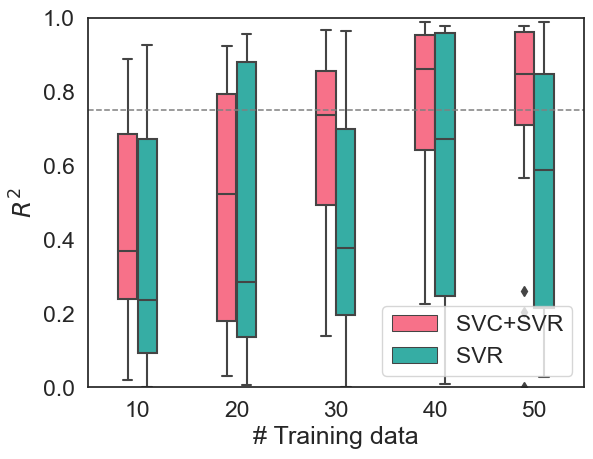

In [86]:
Plot2B1P = ComparisonResultsPlot([complexSVRR2Lists_2B1P, SVRR2Lists_2B1P], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

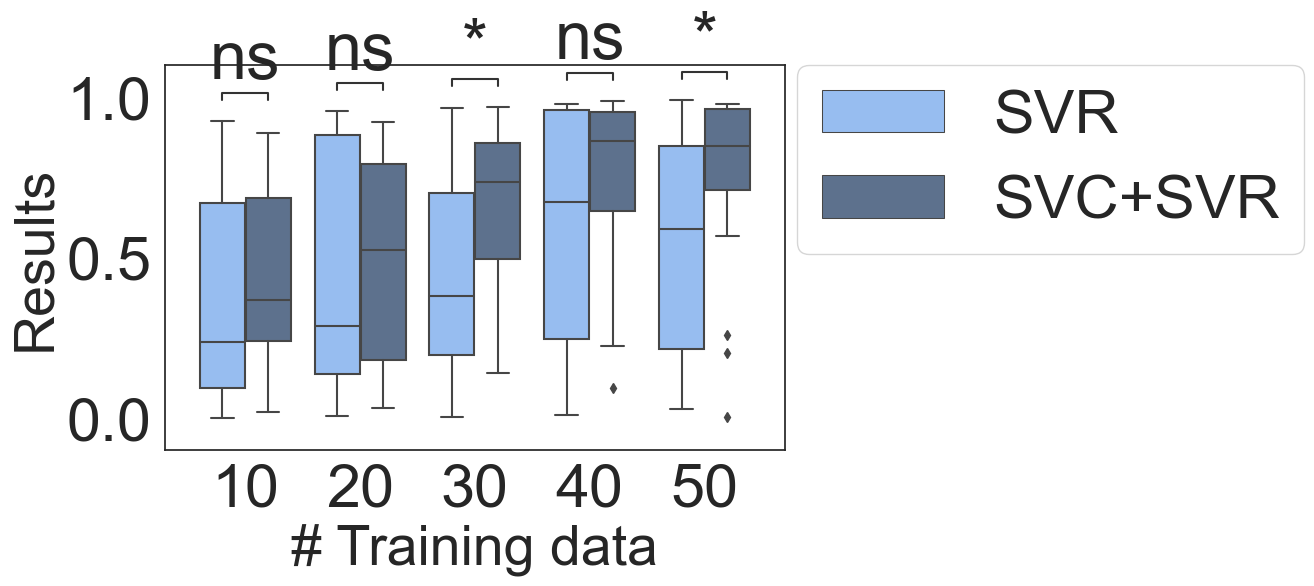

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

In [87]:
statsPlot(Plot2B1P, 'Mann-Whitney')

# Exp data from Fig3 on

here 0.0


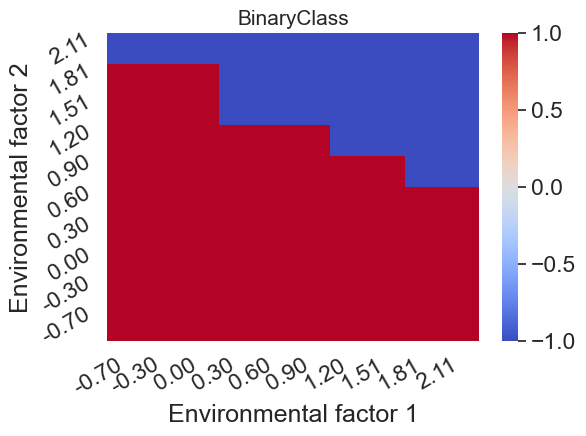

In [50]:
h = processExcelFormat02('HelenaExpTFBdensity.xlsx', 'Sheet1', 0.3)
heatmapGenerator(h, 'BinaryClass')

here 0.03606468253968255


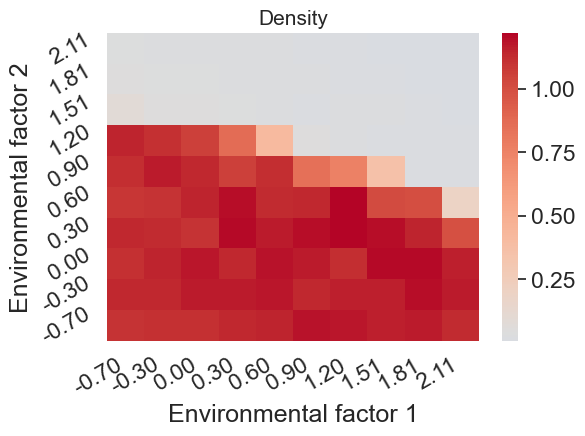

In [51]:
heatmapGenerator(h)

In [63]:
complexSVRSpearmanLists_TFB, complexSVRPearsonLists_TFB, complexSVRR2Lists_TFB, complexSVRMSELists_TFB, \
complexPredictedSVRSpearmanLists_TFB, complexPredictedSVRPearsonLists_TFB, complexPredictedSVRR2Lists_TFB, \
complexPredictedSVRMSELists_TFB, \
r2Recorder_TFB, mseRecorder_TFB, pearsonRecorder_TFB, spearmanRecorder_TFB, \
SVRSpearmanLists_TFB, SVRPearsonLists_TFB, SVRR2Lists_TFB, SVRMSELists_TFB, \
PredictedSVRSpearmanLists_TFB, PredictedSVRPearsonLists_TFB, PredictedSVRR2Lists_TFB, PredictedSVRMSELists_TFB, \
SVRr2Recorder_TFB, SVRmseRecorder_TFB, SVRpearsonRecorder_TFB, SVRspearmanRecorder_TFB,\
indexRecorder_TFB, TrainXDFRecorder_TFB, TrainYDFRecorder_TFB, \
SVMSVRFullXDFRecorder_TFB, SVMSVRFullYDFRecorder_TFB, scXRecorder_TFB, \
scDensityRecorder_TFB, scDistanceRecorder_TFB = \
ComparisonMultipleRun(30, 'HelenaExpTFBdensity.xlsx',  2, 'Sheet1', [10, 20, 30,40,50], 0, ['poly', 'rbf'], 0.3)

10
SVC(C=1000.0, degree=5, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9873198845510626
MSE:  0.20650062673121292
Pearson:  0.9936397156671338
Spearman:  0.5
R2:  0.9823377968247858
MSE:  0.11157359549627031
Pearson:  0.9911295560242291
Spearman:  0.5
R2:  0.9902793811193296
MSE:  0.021836127717081738
Pearson:  0.9951278214979871
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5928736307877222, 0.15054400679086763, 0.8784691217971845, 0.6486006540367967]
SVR:  [0.686772968040471, 0.1230790597530219, 0.8287176648536405, 0.790064617030909]
SVC(C=10.0, degree=2, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan -1118.9715574             nan -1118.15165921
  -376.78282314  -181.42735137 -1118.9715574             nan
            nan -1097.01624369]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -63662.44738973
  -1118.14997805             nan  -1118.14997805   -245.1182361
             nan  -1116.16150583]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan  -1119.03178232             nan   -878.38944791
             nan   -338.51813129   -622.88369017 -59760.5777259
  -1097.15102176             nan]
  category=UserWarn

R2:  0.9265829331017421
MSE:  0.1085865942159119
Pearson:  0.9625917790536871
Spearman:  1.0
R2:  0.5170806826840613
MSE:  0.2293950439444894
Pearson:  0.719083223753733
Spearman:  1.0
R2:  0.9889540042926999
MSE:  0.006645970720316064
Pearson:  0.9944616655722333
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6890550909152335, 0.29251808985978744, 0.8236068276242752, 0.8179363707453594]
SVR:  [0.7347744577904294, 0.08617420832425195, 0.8571898609937182, 0.8162736140264228]
SVC(C=10000.0, degree=4, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.8738229235600491
MSE:  0.2447366477822681
Pearson:  0.9347849611327993
Spearman:  1.0
R2:  0.9065009516279222
MSE:  0.2153431423658753
Pearson:  0.9521034353618949
Spearman:  1.0
R2:  0.9999743487881446
MSE:  6.0051276350616305e-05
Pearson:  0.9999871743118234
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6687983082600585, 0.08111812533763992, 0.8340546695246754, 0.6660822323743671]
SVR:  [0.3615441370026855, 0.1926577310384148, 0.6012854039494768, 0.564258962011771]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.8529389493562861
MSE:  0.12102453818615548
Pearson:  0.9235469394439495
Spearman:  1.0
R2:  0.8449389496498292
MSE:  0.16526570215974273
Pearson:  0.9192056079299282
Spearman:  1.0
R2:  0.6305513804489383
MSE:  97060.50663915894
Pearson:  0.7940726543893442
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.814986744700242, 0.6500141718255757, 0.8895803976540848, 0.7946577766802485]
SVR:  [0.7281565242224681, 0.07940372316888018, 0.8533208799873984, 0.7951681277523973]
SVC(C=10000.0, degree=4, gamma=0.1)
R2:  0.9633136375199501
MSE:  0.21307180007338644
Pearson:  0.981485423997703
Spearman:  0.5
R2:  0.9385834252760815
MSE:  0.32573825017913255
Pearson:  0.9688051534111913
Spearman:  0.5
R2:  0.9592478438163466
MSE:  0.26568853747374305
Pearson:  0.9794119888057051
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6860783361675113, 0.20216327363188072, 0.7430375594733541, 0.8212454212454212]
SVR:  [0.6862344472221984, 0.20238925585163592, 0.8283926890202479, 0.7949705724986623]
SVC(C=1000.0, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.5351009483299921
MSE:  0.3027402194735924
Pearson:  0.7315059455192365
Spearman:  0.5
R2:  0.9982436444441866
MSE:  0.3741865796304098
Pearson:  0.9991214362849926
Spearman:  1.0
R2:  0.9987969558396005
MSE:  0.36529435435524604
Pearson:  0.999398296896488
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6726599655662474, 1.31379913469667, 0.8271039753832976, 0.7596904967691483]
SVR:  [0.7206662277551521, 0.11606754643025828, 0.8489206251206012, 0.816405317528913]
SVC(degree=2, gamma=0.0001)
R2:  0.5068685141514824
MSE:  0.16778789998629365
Pearson:  0.711946988301434
Spearman:  0.5
R2:  0.4837991941178932
MSE:  0.18171624965962374
Pearson:  0.6955567511841814
Spearman:  0.5
R2:  0.5608400963635561
MSE:  0.15218689425643328
Pearson:  0.7488925799896513
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7289687032570954, 0.0982240297699307, 0.8538971743818546, 0.8144297649915628]
SVR:  [0.1765445721256721, 82.42984182002729, 0.4201720744238864, 0.6164958636868749]
SVC(C=1000.0, degree=4, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.69272117 -4.14296277 -1.76996819 -4.14314066         nan -4.25466962
 -2.41320425 -4.16064591         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correl

R2:  nan
MSE:  0.44490280871505056
Pearson:  nan
Spearman:  nan
R2:  0.6513045708371031
MSE:  166.60752570994876
Pearson:  -0.8070344297718055
Spearman:  -0.5
R2:  0.8010389085997293
MSE:  0.017666688728729462
Pearson:  -0.8950077701337176
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7985602101356333, 0.06851642745393932, 0.8777819435785219, 0.8061653702103141]
SVR:  [0.7293061603984582, 0.29072109495740195, 0.8539942390897366, 0.8011606371156932]
SVC(C=10000.0, degree=2, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.61500225e+01 -5.14342693e+04 -5.13999761e+00 -2.11875845e+00
 -5.16979300e+00 -5.15753698e+00 -3.33767125e+01             nan
 -2.45429659e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constan

R2:  nan
MSE:  0.26771588654007644
Pearson:  nan
Spearman:  nan
R2:  0.9886757726851922
MSE:  0.6179217112816705
Pearson:  0.9943217651671878
Spearman:  1.0
R2:  0.9885920405333062
MSE:  0.6197953934278724
Pearson:  0.9942796591167427
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.93350899         nan -5.17049619         nan  0.66811063         nan
         nan         nan -1.82807455         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -235.16825332           nan   -0.49969715   -5.15742847
   -0.93973281   -4.37912305   -1.55918207 -283.75253913   -2.11875845]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has featu

SVM:  [0.6910452788312756, 0.6419652578692084, 0.8369453924510444, 0.6317076182244721]
SVR:  [0.6532184431175, 0.11614266635030754, 0.8082193038510652, 0.7580442029880232]
SVC(C=100.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-824.58235242           nan -806.52930176           nan -142.72997587
 -809.473236   -114.8865619            nan           nan -112.88643926]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-809.38891427 -157.58154392           nan -809.34319629           nan
 -824.58235242  -76.64347647           nan -809.38865408 -809.9626206 ]
  category=UserWarning,


R2:  0.9781325098300478
MSE:  0.05626494282602515
Pearson:  0.9890058189060609
Spearman:  0.5
R2:  0.9785630753407785
MSE:  0.04632018548224232
Pearson:  0.9892234708804571
Spearman:  0.5
R2:  0.9929473056422534
MSE:  0.16757502580196257
Pearson:  0.9964674132365061
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3283.12715491  -804.82719367            nan            nan
   -44.45420534            nan  -571.42259723  -809.38846468
  -801.08274824            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -42.39417772           nan           nan -803.89966319 -558.31171498
 -809.38862155 -809.81608486           nan -783.61106073           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted withou

SVM:  [0.8011337152120077, 0.1653485625032155, 0.23906854155267035, 0.82175577231757]
SVR:  [0.40954977966655787, 0.9539912115784885, 0.6399607641618023, 0.7770588961600197]
SVC(degree=5, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4058.99177092  -951.85024205 -1235.18024187            nan
            nan            nan            nan            nan
 -1263.57157256            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-23224.09173296             nan  -1234.50561224   -904.78677042
  -4005.40780691             nan             nan             nan
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
            nan            nan -1230.04838807 -4005.00533818
            nan -1110.01441007]
  category=UserWarning,
/Us

R2:  0.9177187524830979
MSE:  0.06508239677367926
Pearson:  0.9579763840946697
Spearman:  1.0
R2:  0.8008607759481242
MSE:  0.07430990589905756
Pearson:  0.894908250016796
Spearman:  1.0
R2:  0.8514455759069705
MSE:  0.7797244412003348
Pearson:  0.9227380862991242
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6357151771646667, 0.16386544009603463, 0.7973174883098116, 0.7680536691772646]
SVR:  [0.6915313988527665, 0.1566784053100632, 0.8315836691835441, 0.7402148413384368]
SVC(C=10000.0, degree=2, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -6.38491095 -1.06449873         nan
 -0.17600366 -2.34415935 -0.07573901         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.06132            nan -0.18390998 -0.1751313  -0.21126125 -0.21098663
 -9.764432   -3.54390482         nan -0.12668968]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.46876306e-01 -2.02396690e-01 -5.45996671e-01             nan
             nan             nan -9.80345687e+03 -2.29440615e+00
 -9.06311632e+05             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.9565257474066721
MSE:  0.5915246422587784
Pearson:  0.978021343022059
Spearman:  1.0
R2:  0.9629084614368917
MSE:  0.5233470266593768
Pearson:  0.9812789926605437
Spearman:  1.0
R2:  0.9652551490195569
MSE:  0.8113999771473334
Pearson:  0.9824739940678108
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7292121536306935, 0.4170676798480569, 0.8298536832956698, 0.8163888545911018]
SVR:  [0.7279634702783919, 0.23143907118551543, 0.8532077532924742, 0.8192204798946372]
SVC(C=10000.0, degree=4, gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

R2:  0.9090063737995177
MSE:  0.05294745958139104
Pearson:  0.953418257534183
Spearman:  1.0
R2:  0.9090528043250392
MSE:  0.052999367967255344
Pearson:  0.9534426067283963
Spearman:  1.0
R2:  0.8198983524271798
MSE:  0.203486930320545
Pearson:  0.905482386591357
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7377216373200819, 0.2234809354018063, 0.4222701826179779, 0.8071366835411778]
SVR:  [0.852098302577673, 0.24485616941195615, 0.9230917086496191, 0.8093756430835082]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.8743592884681108
MSE:  0.0830804238028169
Pearson:  0.9350718092575088
Spearman:  0.5
R2:  0.87902918081723
MSE:  0.08295612170192523
Pearson:  0.9375655608101388
Spearman:  0.5
R2:  0.8675100655664075
MSE:  0.10897918450062101
Pearson:  0.9314022039733469
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.23371020686378602, 0.2347216772151808, 0.7146305747247566, 0.7414166357986582]
SVR:  [0.5512995365341791, 0.15025920368934811, 0.7424954791338321, 0.7237848294028069]
SVC(C=10000.0, gamma=0.1, kernel='poly')
R2:  0.796273141113739
MSE:  0.06605920365364273
Pearson:  0.8923413814867824
Spearman:  1.0
R2:  0.7579169178270344
MSE:  0.07561915131357842
Pearson:  0.8705842393628744
Spearman:  1.0
R2:  0.4536930687581872
MSE:  0.02992728678015133
Pearson:  0.6735674196085996
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4104291265847766, 0.26629554818842677, 0.8613985429356763, 0.8969749351771823]
SVR:  [0.7632275220992021, 0.06994831062636267, 0.8736289384511033, 0.8239947318599002]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.497551178450457
MSE:  0.22974758601021172
Pearson:  0.7053730774919446
Spearman:  0.5
R2:  0.6054967073198477
MSE:  0.21542007735242627
Pearson:  0.7781366893546711
Spearman:  0.5
R2:  0.49756061961389303
MSE:  0.22991663298034304
Pearson:  0.7053797697792962
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6255829373900816, 0.47056430650923275, 0.7950620936875992, 0.8317652385068115]
SVR:  [0.610544495824378, 0.18752335607178985, 0.7813734675712877, 0.769634111207145]
SVC(C=10.0, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -362.0461269  -362.04743751           nan           nan
           nan           nan   -0.39446569 -167.38151874           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.60245397e-01 -3.31955313e-01             nan -9.91017437e+02
             nan -1.33183633e+01 -9.96527556e+01 -1.38760178e+01
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan  -13.21224339           nan -118.37113598           nan
   -0.33333097   -0.33088555           nan           nan   -0.3291676 ]
  category=UserWarning,
/Users/ychha/anaconda3/li

R2:  0.4870310595988437
MSE:  0.4269580099807218
Pearson:  0.6978761061956796
Spearman:  1.0
R2:  0.48943729380133194
MSE:  0.4295461287197573
Pearson:  0.6995979515416921
Spearman:  1.0
R2:  0.28458726186141237
MSE:  0.4296900214567261
Pearson:  -0.5334672078595013
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.09420690849697422, 0.5113251890212618, 0.2848283074692717, 0.8372309338601474]
SVR:  [0.258466698750007, 0.511323837475303, 0.5083962025330311, 0.7578960365477219]
SVC(degree=5, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
            nan            nan -4605.65686205 -4582.99002046
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
 -4583.32779587            nan -5603.71194259            nan
 -4582.79048784 -6071.95387918]
  category=UserWarning,


R2:  0.14035775469219075
MSE:  0.00614059180295119
Pearson:  0.3746435034698864
Spearman:  0.5
R2:  0.5678529106334879
MSE:  0.00617782261336032
Pearson:  0.7535601572757732
Spearman:  1.0
R2:  0.9673914758194772
MSE:  0.0015829095384432329
Pearson:  0.9835606111569726
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

sult = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVM:  [0.5900339273083962, 0.12431796899519075, 0.8754395229934578, 0.8166193357204592]
SVR:  [0.41153607114024593, 0.9181819223660475, 0.6415107724272808, 0.6860188500637938]
SVC(C=1000.0, degree=4, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -3.74975013e+03
             nan -3.48825747e+06 -2.88826554e+02 -3.73296252e+03
 -3.50464813e+03 -3.75365771e+03]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.75345399e+03 -2.54360976e+05             nan -4.05221878e+02
             nan             nan             nan             nan
 -1.53613678e+01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3647.70098061            nan -3753.14727926 -3752.59685252
            nan -3654.46238203 -3753.64693366 -3748.32361462
            nan            nan]
  category=UserWa

R2:  0.9889888209571007
MSE:  0.02331904089850351
Pearson:  0.9944791707004732
Spearman:  1.0
R2:  0.9999291447884668
MSE:  0.00016293053265354956
Pearson:  0.9999645717666534
Spearman:  1.0
R2:  0.9997579785810925
MSE:  0.40095375668135785
Pearson:  0.9998789819678642
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6140273707060825, 0.7797400093980815, -0.353436684936665, -0.0508830446546091]
SVR:  [0.6779423453155107, 0.26405784150823275, 0.8233725434549723, 0.7901633946577766]
SVC(C=0.1, gamma='auto')
R2:  0.8257737703360819
MSE:  0.053003682370747505
Pearson:  0.9087209529531505
Spearman:  0.5
R2:  0.12117887742643065
MSE:  0.3346052200134338
Pearson:  -0.3481075658850734
Spearman:  0.5
R2:  0.9330215679734494
MSE:  0.02934836230849308
Pearson:  0.9659304156995212
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5054819616465571, 0.3744432295213557, 0.7793232443707238, 0.8051611310038277]
SVR:  [0.6924617396465113, 0.13085560240986593, 0.8321428601186891, 0.8201588673498784]
SVC(C=1000.0, degree=2, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.27108716         nan         nan -0.41310785 -0.1942942  -0.39127645
         nan -0.27611357 -0.41545308 -0.39101805]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-24.99825132  -1.06784063 -24.99825132  -0.40449455  -0.33482369
  -0.39087929  -0.37649518  -0.18422627          nan  -0.41243284]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estim

R2:  0.9748535547281234
MSE:  0.38052072297638356
Pearson:  0.9873467246758472
Spearman:  0.5
R2:  0.990176704593669
MSE:  0.471446286064335
Pearson:  0.9950762305440065
Spearman:  0.5
R2:  0.30759431088204303
MSE:  5.8817553621660075
Pearson:  0.5546118560597518
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6571866119385246, 0.14908308229141617, 0.8278506884839543, 0.7364119027040374]
SVR:  [0.6181217123423407, 0.1429723301481897, 0.7862071688444086, 0.7390788986294603]
SVC(gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.57559800e-01             nan -3.10944349e-01  1.32142818e-01
 -3.13833938e-01 -3.07443387e+03             nan             nan
 -1.26150989e+00 -3.56942967e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.56901316e-01  4.12427923e-01             nan -4.98773800e-01
 -2.74354449e+05 -3.13614636e-01 -4.51396896e-01 -5.19244628e+03
 -3.51026302e-01 -3.13834225e-01]
  category=UserWarning,


R2:  0.22024635261346354
MSE:  0.5584095498550053
Pearson:  0.4693041152743747
Spearman:  -0.5
R2:  0.9902262161208422
MSE:  0.1793910966622624
Pearson:  0.9951011084914149
Spearman:  1.0
R2:  0.9982625142554394
MSE:  0.4094381111241605
Pearson:  0.9991308794424479
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.15612707         nan -0.31382714  0.10138529 -0.35510812 -0.35637789
 -0.30676544 -0.35887033         nan -0.30681842]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan  1.55298425e-01 -2.77635220e+05 -3.33799572e-01
 -1.40904517e-01 -4.99422065e+01 -2.70900862e+05 -4.70452052e-02
  1.55985428e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature 

SVM:  [0.700328238877168, 0.05327893823114987, 0.8419559079280685, 0.7971107544141252]
SVR:  [0.8110881248704188, 0.05833781217921179, 0.9006043109326194, 0.7862616783965097]
SVC(C=10.0, degree=2)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.8229503313681236
MSE:  0.31165449466584944
Pearson:  0.9071660991065108
Spearman:  1.0
R2:  0.84454899085696
MSE:  0.3896860140299969
Pearson:  0.9189934661666316
Spearman:  1.0
R2:  0.900313609921953
MSE:  0.3374308985539846
Pearson:  0.9488485705959369
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2869093869457068, 0.48389433140771765, 0.33466605407026606, -0.11951707734297723]
SVR:  [0.2078416326452713, 0.3882204337962183, 0.45589651528090386, 0.4532427774726323]
SVC(C=0.01, gamma=10.0, kernel='poly')
R2:  0.7749399489662175
MSE:  0.3059027923512796
Pearson:  0.8803067357269383
Spearman:  1.0
R2:  0.6370027295199332
MSE:  0.11616602539200531
Pearson:  0.798124507529955
Spearman:  1.0
R2:  0.6241856599196273
MSE:  0.11902687966544734
Pearson:  0.7900542132788277
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.02765150741874829, 0.09343515964981393, 0.7969703324787445, 0.7130016051364366]
SVR:  [0.686124546197848, 0.08900385743335934, 0.8283263524709619, 0.7963534592748075]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.9683925070922377
MSE:  0.06026878515004693
Pearson:  0.9840693609152953
Spearman:  1.0
R2:  0.9588687318561837
MSE:  0.32684078255190563
Pearson:  0.9792184290832071
Spearman:  1.0
R2:  0.4886291126870848
MSE:  0.2770527780727051
Pearson:  0.6990201089289811
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [3.090418682040587e-33, 0.23984305942831669, 0.8401593881274356, 0.8069062024118203]
SVR:  [0.6734202327200185, 0.11849714861837016, 0.8206218573252962, 0.7737992344733917]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.9193236429285304
MSE:  0.2897795410891608
Pearson:  0.9588136643417898
Spearman:  1.0
R2:  0.9959433907710517
MSE:  0.0403563318603088
Pearson:  0.9979696341928708
Spearman:  0.5
R2:  0.8021102596071371
MSE:  0.2819976340724469
Pearson:  0.8956060850659386
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.831106958706391, 0.10264627778854987, 0.8561393630634235, 0.7984277894390254]
SVR:  [0.7345658276062703, 0.2627205711806245, 0.857068158086782, 0.7956126270733012]
SVC(C=100.0, gamma=0.01)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

R2:  0.8311352187477936
MSE:  0.39247943352570985
Pearson:  0.9116661772533812
Spearman:  1.0
R2:  0.6836455743448461
MSE:  0.12361147912927294
Pearson:  0.8268286245316174
Spearman:  1.0
R2:  0.6608347454928877
MSE:  0.09873355157731839
Pearson:  0.812917428459304
Spearman:  1.0


e 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = sel

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVM:  [0.7530178045927753, 0.1283366770040279, 0.8392399654208982, 0.8010289336132033]
SVR:  [0.7091946032523261, 0.13124377428255518, 0.8421369266647358, 0.8010289336132033]
SVC(C=100.0, degree=5, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

R2:  0.2502187275149599
MSE:  0.773591204096245
Pearson:  0.5002186796941512
Spearman:  0.5
R2:  0.763641235892519
MSE:  2.6799540616133384
Pearson:  -0.8738656852700644
Spearman:  -1.0
R2:  0.5422845589544824
MSE:  0.7249644171737194
Pearson:  0.736399727698539
Spearman:  1.0


dict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  Us

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5926659163492729, 0.07160529222137074, 0.771021409532739, 0.6839115940239535]
SVR:  [0.3548883767378961, 0.45521018716148187, 0.5957250848654061, 0.5073465859982714]
SVC(C=1000.0, degree=4)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.28951042 -0.63646042         nan -2.29153322 -0.62748086 -1.42763096
 -2.45989986         nan -2.46777027 -3.58428015]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.48305879 -2.45988938 -2.42212417 -2.19867584 -0.90249274 -2.45603704
 -2.45211407 -0.41886059 -2.45988938         nan]
  category=UserWarning,


R2:  0.31627643023259855
MSE:  0.3212680520926037
Pearson:  0.5623845928122486
Spearman:  0.5
R2:  0.9905604099230153
MSE:  0.021142865603448552
Pearson:  0.9952690138465157
Spearman:  1.0
R2:  0.995206532714362
MSE:  0.31902448974018077
Pearson:  0.9976003872865941
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.27544129 -0.81674468 -2.45884208 -3.99550966 -2.45972806         nan
 -2.46002448 -2.46031821         nan -2.43063449]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -2.29822916 -2.46031019 -2.42218159         nan -2.2858736
 -1.26996048 -0.81859983 -0.42175163 -2.46023739]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self._

SVM:  [0.7643335647454454, 0.05279366057904125, 0.894428751389746, -0.2801251183273655]
SVR:  [0.7347741335514123, 0.08020741741121355, 0.8571896718646418, 0.8178705189941143]
SVC(C=10.0, degree=2, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9966421315036011
MSE:  0.6615074451519497
Pearson:  0.9983196539704108
Spearman:  1.0
R2:  0.9977788918346981
MSE:  0.3054601226194255
Pearson:  0.9988888285663716
Spearman:  1.0
R2:  0.9972949919885062
MSE:  0.25585408520578506
Pearson:  0.9986465801215696
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7225693124647821, 0.4354933338609823, -0.5694266197402116, 0.7706712762892538]
SVR:  [0.7226854545165936, 0.09813287205343137, 0.850109083892528, 0.8277318187430546]
20
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.8762509164285146
MSE:  0.830494403280533
Pearson:  0.9360827508444511
Spearman:  0.7999999999999999
R2:  0.8707420341816655
MSE:  0.8018044056848671
Pearson:  0.933135592602525
Spearman:  1.0
R2:  0.8353950841071822
MSE:  0.815143898029136
Pearson:  0.9139994989644046
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6506546220906557, 0.0677553612882396, 0.8413806115131037, 0.8786685419596812]
SVR:  [0.709770525276058, 0.4154921415803165, 0.84247879811664, 0.8159165494608533]
SVC(C=1000.0, degree=4)
R2:  0.7482471737543605
MSE:  0.09747672513570124
Pearson:  0.8650128171040938
Spearman:  0.39999999999999997
R2:  0.8225119624543921
MSE:  0.05863287842152416
Pearson:  0.9069244524514665
Spearman:  0.39999999999999997
R2:  0.9999279641072482
MSE:  0.311143511867666
Pearson:  0.9999639814049546
Spearman:  0.7745966692414834


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.795231200728565, 0.05208303772375955, 0.8936892270869253, 0.695827473042663]
SVR:  [0.6686035637912139, 0.09401154555175613, 0.8176818230774205, 0.8248710736052509]
SVC(C=0.01, degree=2, gamma=1.0)
R2:  0.15194921276196435
MSE:  0.045001480550235326
Pearson:  -0.3898066350922781
Spearman:  -0.7999999999999999
R2:  0.7518420653902417
MSE:  0.0012201614209190793
Pearson:  -0.8670882685114829
Spearman:  -0.39999999999999997
R2:  0.29804309141188906
MSE:  0.04956161543057175
Pearson:  -0.5459332298110174
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7609965287570017, 0.06749092809867538, 0.8732106720613156, 0.8005391467416785]
SVR:  [0.7135318978016663, 0.08777332504189839, 0.8447081731590302, 0.8154242850445381]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.4328713937792084
MSE:  0.2020644548452917
Pearson:  0.6579296267680979
Spearman:  0.39999999999999997
R2:  0.5037334392096984
MSE:  0.5859589406203461
Pearson:  0.7097418116538565
Spearman:  0.39999999999999997
R2:  0.6642884267213118
MSE:  0.2643438215683326
Pearson:  0.8150389111700813
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7402804960624195, 0.0756457059865718, 0.8603955462823016, 0.826136896390061]
SVR:  [0.6671363763141782, 0.17693941384590905, 0.8167841675217375, 0.7869432723863105]
SVC(C=100.0)
R2:  0.9808802429690917
MSE:  0.08671716938258192
Pearson:  0.9903939837100645
Spearman:  1.0
R2:  0.7891702740733045
MSE:  0.12397950467123922
Pearson:  0.8883525618093892
Spearman:  1.0
R2:  0.35076666217090263
MSE:  0.2201955283224762
Pearson:  0.5922555716672513
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7282723960147114, 0.19349180551026585, 0.890927584852943, 0.8029535864978903]
SVR:  [0.8346601118687239, 0.050156022892458706, 0.9135973466843714, 0.8817862165963433]
SVC(C=100.0, degree=5, kernel='poly')
R2:  0.6226706961315547
MSE:  0.13554072343490342
Pearson:  0.7890948587663935
Spearman:  0.7999999999999999
R2:  0.6606232827984996
MSE:  0.13369733315240356
Pearson:  0.8127873539853457
Spearman:  0.7999999999999999
R2:  0.5720872738441521
MSE:  0.1509014740384154
Pearson:  0.7563645112273263
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7328156442401189, 0.17774101701681788, nan, 0.8350025492557194]
SVR:  [0.7381913251300031, 0.08490885223544664, 0.8591806126362507, 0.8244022503516176]
SVC(C=1000.0, gamma=10.0, kernel='poly')
R2:  0.7669038027620559
MSE:  0.07192192870793511
Pearson:  0.8757304395543506
Spearman:  1.0
R2:  0.758006502013223
MSE:  0.201796061684971
Pearson:  0.8706356884559827
Spearman:  0.7999999999999999
R2:  0.756871805346233
MSE:  0.21995431518092112
Pearson:  0.8699837960250945
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7320583917679045, 0.09696953785273357, 0.8909065663681666, 0.8235583684950774]
SVR:  [0.7329932714097336, 0.11578108201558979, 0.8561502621676488, 0.8154242850445381]
SVC(C=10000.0, gamma=0.1, kernel='poly')
R2:  0.6680902082684491
MSE:  0.5798223187022727
Pearson:  0.8173678537038566
Spearman:  0.7999999999999999
R2:  0.6688782890460085
MSE:  0.5798177254059658
Pearson:  0.8178497961398589
Spearman:  0.7999999999999999
R2:  0.6676868047358802
MSE:  0.5829419461708292
Pearson:  0.8171210465627969
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.7900337255861498, 0.0745687678409018, 0.8773813607766203, 0.8481950304735116]
SVR:  [0.7686631180095735, 0.4575095285954454, 0.875250702047621, 0.8412564463197376]
SVC(C=1000.0, gamma='auto')
R2:  0.85055575594347
MSE:  0.06776327247985912
Pearson:  0.9222557974572293
Spearman:  0.7999999999999999
R2:  0.9494074247650687
MSE:  0.014301070995331799
Pearson:  0.9743754023809658
Spearman:  0.7999999999999999
R2:  0.9494427882075511
MSE:  0.014289299757825825
Pearson:  0.9743935489357218
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7672872919534508, 0.09866677879429583, 0.8407656131896628, 0.8980075011720582]
SVR:  [0.7290161058036095, 0.10267399403770935, 0.8538243998642865, 0.8626582278481014]
SVC(degree=5)
R2:  0.7833603353729878
MSE:  0.15304249898882527
Pearson:  0.8850764573600338
Spearman:  1.0
R2:  0.8892301432323921
MSE:  0.041649819851099716
Pearson:  0.9429900016608828
Spearman:  1.0
R2:  0.934391828980988
MSE:  0.022611779072375507
Pearson:  0.9666394513886696
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5889117840115408, 0.0943901956732763, 0.8754526854719032, 0.7207923112986405]
SVR:  [0.7139375516714765, 0.10710923397373744, 0.8449482538424918, 0.7124941397093296]
SVC(C=1000.0, gamma='auto')
R2:  0.22166041240866957
MSE:  0.3106356885344067
Pearson:  0.470808254397339
Spearman:  0.39999999999999997
R2:  0.4428754782049938
MSE:  0.3037325669976465
Pearson:  0.6654889016392338
Spearman:  0.39999999999999997
R2:  0.8491871089669848
MSE:  0.2963150294476897
Pearson:  0.9215134882176087
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8485945633926993, 0.07486006437267528, nan, nan]
SVR:  [0.3061865881417408, 0.5333317586212819, 0.5533412944483191, 0.7955930614158463]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.9049305303367247
MSE:  0.27354592137812717
Pearson:  0.9512783663769111
Spearman:  1.0
R2:  0.8980393426927455
MSE:  0.27341652411717016
Pearson:  0.9476493775087627
Spearman:  1.0
R2:  0.9399915282690358
MSE:  0.4114111541697509
Pearson:  0.9695316025117673
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.802216051409474, 0.05030509603911894, 0.9249298840860838, 0.7804031879981248]
SVR:  [0.7313945834390435, 0.08397795705317108, 0.8552161033557795, 0.7784810126582278]
SVC(C=10000.0, gamma=1.0)
R2:  0.827308260120635
MSE:  0.17499369764155606
Pearson:  0.9095648740582691
Spearman:  1.0
R2:  0.7813986468144679
MSE:  0.27221047810152244
Pearson:  0.8839675598201938
Spearman:  1.0
R2:  0.8489785215232099
MSE:  0.1428235569469128
Pearson:  0.921400304711915
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8201899491553097, 0.0650873870240368, 0.9487119641497179, 0.7874355368026255]
SVR:  [0.7074302806731783, 0.08791972291667613, 0.8410887472039907, 0.7909282700421941]
SVC(C=10.0, degree=4, gamma=0.01)
R2:  0.9381709768306696
MSE:  0.12016752419323137
Pearson:  0.968592265522841
Spearman:  1.0
R2:  0.8717754674943563
MSE:  0.1284305068434064
Pearson:  0.9336891707063739
Spearman:  1.0
R2:  0.8979237435034653
MSE:  0.07056410850871637
Pearson:  0.9475883829508809
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5261926393953743, 0.052223849458339064, 0.8984203758034845, 0.7840365682137834]
SVR:  [0.7179160736690511, 0.08793242481997499, 0.8472992822309309, 0.793483356774496]
SVC(C=10000.0, degree=4, gamma=1.0)
R2:  0.5853277779085787
MSE:  0.0017407690147264547
Pearson:  -0.7650671721545624
Spearman:  -0.7999999999999999
R2:  0.5850477692767189
MSE:  0.001739470990268477
Pearson:  -0.7648841541545482
Spearman:  -0.7999999999999999
R2:  0.5741828714100907
MSE:  0.010374402881970089
Pearson:  -0.7577485542118115
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.043261388184696374, 0.5287586381753994, 0.8763855728791816, 0.827051101734646]
SVR:  [0.13385572969006515, 0.5276191141458372, 0.6403070355487281, 0.759985935302391]
SVC(C=10000.0, gamma=1.0)
R2:  0.9665741232611317
MSE:  0.028115765683035848
Pearson:  0.9831450163943934
Spearman:  0.7999999999999999
R2:  0.9646034962304418
MSE:  0.03329862680989373
Pearson:  0.982142299379495
Spearman:  1.0
R2:  0.9681373169409911
MSE:  0.0270679167101252
Pearson:  0.9839396917194625
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7111014421188034, 0.08862115867788871, 0.83324458419399, 0.7412330051570558]
SVR:  [0.7561109907239912, 0.24203214077828888, 0.8695464281589518, 0.8223159868729488]
SVC(C=10.0, gamma='auto')
R2:  0.9283622693800198
MSE:  0.22162779124154727
Pearson:  0.9635155781719462
Spearman:  1.0
R2:  0.8963057606061793
MSE:  0.02600493382891625
Pearson:  0.9467342608177755
Spearman:  1.0
R2:  0.551691692547447
MSE:  0.118198265438146
Pearson:  0.7427595119198724
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7323840929351946, 0.2507076427202925, 0.8622976198490693, 0.7814580403187998]
SVR:  [0.7350864917058787, 0.10209366566985209, 0.8573718514774549, 0.7815283638068449]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.9999957447831492
MSE:  0.27318181943888886
Pearson:  0.9999978723893111
Spearman:  0.7999999999999999
R2:  nan
MSE:  0.31528311288375366
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.986844434431904
MSE:  0.23058717557504643
Pearson:  0.9934004401206515
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6568644931801154, 0.1464127977438177, 0.8111882113609084, 0.7796999531176746]
SVR:  [0.6987483382795399, 0.18925449361757157, 0.8359116809086589, 0.8181138384833616]
SVC(degree=5, gamma='auto')
R2:  0.5692839796301203
MSE:  0.7947577271495393
Pearson:  0.7545090984409137
Spearman:  1.0
R2:  0.9405991513044848
MSE:  0.017414810150442314
Pearson:  0.9698449109545733
Spearman:  0.7999999999999999
R2:  0.5057978258937297
MSE:  0.1844197112959606
Pearson:  0.7111946469805083
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.47312875791900677, 0.07690565800317292, 0.8847716322999006, 0.8155649320206283]
SVR:  [0.7412200489840522, 0.30760490111294286, 0.8609413737206802, 0.8049226441631506]
SVC(C=10000.0, degree=4, gamma=1.0)
R2:  0.0979440496427481
MSE:  0.016350877500705376
Pearson:  0.31296014066131184
Spearman:  0.39999999999999997
R2:  0.8334528914299608
MSE:  0.13202323047087525
Pearson:  -0.9129364114931341
Spearman:  -0.7999999999999999
R2:  0.6434122628762744
MSE:  0.0038888315180245535
Pearson:  0.802129829189935
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6644105172771112, 0.09065250605754464, 0.8429962087784937, 0.8218237224566339]
SVR:  [0.7420982682276158, 0.10885903453520167, 0.861451257023644, 0.7952180028129395]
SVC(C=100.0, gamma=0.001)
R2:  0.9618972341320362
MSE:  0.05143990362134035
Pearson:  0.9807635974749659
Spearman:  0.7999999999999999
R2:  0.9294465492819598
MSE:  0.2974621637556233
Pearson:  0.9640780825648718
Spearman:  0.7999999999999999
R2:  0.9827842444380723
MSE:  0.09458628182114844
Pearson:  0.9913547520630908
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7497047886914322, 0.09083732039493102, 0.9422360271415902, 0.8549695264885139]
SVR:  [0.7519262161847956, 0.1080837596705381, 0.8671367920834607, 0.7859587435536802]
SVC(C=10000.0, gamma=0.1, kernel='poly')
R2:  0.8095753469344842
MSE:  0.9033734843837136
Pearson:  0.8997640507013404
Spearman:  0.39999999999999997
R2:  0.8061218306904806
MSE:  0.8941485792727802
Pearson:  0.8978428763934592
Spearman:  0.39999999999999997
R2:  0.1010135103567935
MSE:  0.9043916376202407
Pearson:  0.31782622666607213
Spearman:  -0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.75049491550454, 0.08159355066817407, 0.9182853900127329, 0.8208626347866855]
SVR:  [0.7821799275285987, 0.46041962086064714, 0.8844093664862434, 0.8252226910454759]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.9949109175313151
MSE:  0.0038922926402667896
Pearson:  0.9974522131567581
Spearman:  0.7999999999999999
R2:  0.8903275043213935
MSE:  0.05890056840016241
Pearson:  0.9435716741834685
Spearman:  1.0
R2:  0.9830911931413621
MSE:  0.013691374367519792
Pearson:  0.9915095527232008
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7930541975933033, 0.08907972782440429, 0.8335997146228411, 0.7894983591186123]
SVR:  [0.6943493749746985, 0.09006387221937681, 0.8332762896991, 0.8041256446319738]
SVC(C=10000.0, gamma=0.0001)
R2:  0.7952704352282615
MSE:  0.5213373087968448
Pearson:  0.8917793646571225
Spearman:  1.0
R2:  0.7980846190352981
MSE:  0.5223495236016985
Pearson:  0.8933558188288124
Spearman:  1.0
R2:  0.8914599332287301
MSE:  0.462631754198047
Pearson:  0.9441715592140707
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6981079768858197, 0.09764212124289562, 0.8353288432515946, 0.8026254102203471]
SVR:  [0.7897112056992359, 0.35780886637612896, 0.8886569673947509, 0.8176746366619785]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.8903944820882145
MSE:  0.15599727645793096
Pearson:  0.9436071651318754
Spearman:  1.0
R2:  0.9248025103473166
MSE:  0.14738254263259865
Pearson:  0.9616665276213561
Spearman:  1.0
R2:  0.9691640563549919
MSE:  0.017310332836599444
Pearson:  0.984461302619352
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.08304728928212496, 0.4923693801160763, 0.7124994401871085, 0.7859118612283169]
SVR:  [0.8488030565631275, 0.04841455774522452, 0.9213050833264338, 0.8300046882325364]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.48196151118058406
MSE:  0.23538390695326256
Pearson:  0.6942344785305496
Spearman:  0.7999999999999999
R2:  0.912577125671711
MSE:  0.028651517804505783
Pearson:  0.9552890272957764
Spearman:  1.0
R2:  0.9126756325109412
MSE:  0.02820995074762019
Pearson:  0.9553405845618314
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5695040957845262, 0.1553760812249524, 0.8630941893833305, 0.8202062822315986]
SVR:  [0.826565220499274, 0.05004785190446133, 0.9091563234665833, 0.8560478199718706]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.764518396316066
MSE:  0.45391710569925603
Pearson:  0.8743674263809613
Spearman:  1.0
R2:  0.6777241769276825
MSE:  0.185359073990733
Pearson:  0.8232400481801663
Spearman:  1.0
R2:  0.5180197025532209
MSE:  0.472383322253357
Pearson:  0.7197358560980694
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7395083908715488, 0.08543888950602574, 0.8732810620149334, 0.8073136427566807]
SVR:  [0.7911884518018364, 0.0701328024156389, 0.8894877468531177, 0.806516643225504]
SVC(C=1000.0)
R2:  0.751555151893862
MSE:  0.040863662789146764
Pearson:  0.8669228061908754
Spearman:  0.7999999999999999
R2:  0.15935669163318528
MSE:  0.29709708387913136
Pearson:  -0.3991950546201508
Spearman:  0.0
R2:  0.8598192905176126
MSE:  0.0627406982016782
Pearson:  0.9272644124076005
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5486476830034144, 0.08198282794315637, 0.6752616472859903, 0.8469995311767464]
SVR:  [0.7125102254391052, 0.08732263987040642, 0.8441032078123532, 0.8153305203938116]
SVC(C=10000.0, degree=4, gamma=0.0001, kernel='poly')
R2:  0.11693368964511743
MSE:  0.0027657062788421097
Pearson:  -0.3419556837444253
Spearman:  -0.6000000000000001
R2:  0.1590642370847635
MSE:  0.0019606672749426872
Pearson:  -0.39882858107809116
Spearman:  -0.6000000000000001
R2:  0.24060877917351536
MSE:  0.004258769102987507
Pearson:  -0.49051888768274293
Spearman:  -0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5123254367929728, 0.5798176706537405, 0.7313867633015171, 0.7048757618377872]
SVR:  [0.68702154899639, 0.5646964149274565, 0.8288676305637652, 0.835560243788092]
SVC(degree=5, gamma=1.0)
R2:  0.9536070669485623
MSE:  0.04285664499334736
Pearson:  0.9765280676706438
Spearman:  0.39999999999999997
R2:  0.9849697545595518
MSE:  0.009581226457445493
Pearson:  0.9924564245142209
Spearman:  0.7999999999999999
R2:  0.9858145871562416
MSE:  0.013251414106047264
Pearson:  0.9928819603337755
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5920147909037713, 0.050084537868390455, 0.7590329713198007, 0.8171823722456635]
SVR:  [0.7431116888163881, 0.08928363243252257, 0.862039261760384, 0.7971167369901547]
30
SVC(C=100.0, gamma='auto')
R2:  0.9064506961397821
MSE:  0.11788297332237839
Pearson:  0.9520770431744388
Spearman:  0.8285714285714287
R2:  0.9091298770094317
MSE:  0.14190369461054783
Pearson:  0.9534830239754832
Spearman:  0.942857142857143
R2:  0.7796915829689895
MSE:  0.08482927764077404
Pearson:  0.8830014626086358
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7575257608642902, 0.028547201435797306, 0.8270117801319901, 0.8219578339602834]
SVR:  [0.735381543350023, 0.10926928529666766, 0.8575439017041769, 0.754492170413787]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.796482604586271
MSE:  0.06941336647754771
Pearson:  0.8924587411114706
Spearman:  0.7714285714285715
R2:  0.7913547435976196
MSE:  0.08660991447808238
Pearson:  0.889581218100753
Spearman:  0.942857142857143
R2:  0.6522681569615094
MSE:  0.14907255254743573
Pearson:  0.80763120108222
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6849281892590225, 0.06325616845319283, 0.6672264089249547, 0.8020120724346077]
SVR:  [0.7743342801573048, 0.0789544501039295, 0.8799626583880165, 0.8048114775610183]
SVC(gamma='auto', kernel='poly')
R2:  0.3858415488564821
MSE:  0.049880864926755336
Pearson:  0.6211614515216495
Spearman:  0.2571428571428572
R2:  0.050057909633352125
MSE:  0.09171308204202798
Pearson:  0.22373625015484666
Spearman:  0.14285714285714288
R2:  0.04178266726027409
MSE:  0.0723659279462621
Pearson:  0.20440809000691276
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6849300427236158, 0.07053025188883494, 0.8101554529322528, 0.7601609657947686]
SVR:  [0.6275585117242016, 0.1121597290347161, 0.7921859072996703, 0.7601609657947686]
SVC(C=1000.0, gamma=0.001)
R2:  0.6215294146894086
MSE:  0.3129330828927405
Pearson:  0.7883713685119523
Spearman:  0.4285714285714286
R2:  0.5659679164801593
MSE:  0.32912363216719615
Pearson:  0.7523083918714182
Spearman:  0.4285714285714286
R2:  0.5407956532242555
MSE:  0.14683092775042392
Pearson:  0.735388097010181
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7744404813806113, 0.0758200334079157, 0.8710903283036422, 0.8377744729245036]
SVR:  [0.7781413351322002, 0.27753260885922704, 0.8821231972531958, 0.8262269267780598]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.8407517559753865
MSE:  0.08416267353216735
Pearson:  0.9169251637813125
Spearman:  0.8857142857142858
R2:  0.8457237565666809
MSE:  0.27971502999276016
Pearson:  0.9196324029560293
Spearman:  0.8857142857142858
R2:  0.9396063581313185
MSE:  0.028947295359968123
Pearson:  0.9693329449323993
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7302782314259366, 0.10485357326294495, 0.6090649552624107, 0.8212229901146006]
SVR:  [0.7067314713986689, 0.1091660295425174, 0.8406732250991871, 0.8195433470387542]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.9059321701581968
MSE:  0.045766889683994595
Pearson:  0.9518046911831215
Spearman:  0.942857142857143
R2:  0.8737934727257762
MSE:  0.04765603824550805
Pearson:  0.9347692082678891
Spearman:  0.942857142857143
R2:  0.6691509218870414
MSE:  0.1606074135542544
Pearson:  0.8180164557556537
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7231629309992789, 0.294763115085411, 0.8317491553352133, 0.8620943049601959]
SVR:  [0.8525195410441336, 0.04559063969580164, 0.923319847639015, 0.8488671157379056]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.8080433552316322
MSE:  0.07643510231065957
Pearson:  0.8989123178773513
Spearman:  0.942857142857143
R2:  0.8082883085958367
MSE:  0.07521841797841934
Pearson:  0.8990485574182503
Spearman:  0.942857142857143
R2:  0.8078993572969446
MSE:  0.07632323183003023
Pearson:  0.8988322186576005
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6855607589656301, 0.2411983066126315, 0.8279859654400127, 0.8081357711486309]
SVR:  [0.6474435639471258, 0.10734748329409875, 0.8046387785504288, 0.7969381506429885]
SVC(C=10000.0, kernel='poly')
R2:  0.3728717933311832
MSE:  0.1513902932477968
Pearson:  0.6106322897875471
Spearman:  0.6
R2:  0.06133035467161344
MSE:  0.24201883957965756
Pearson:  0.24764966115788142
Spearman:  -0.028571428571428574
R2:  0.05664305959788707
MSE:  0.2911849604459649
Pearson:  0.2379980243571091
Spearman:  0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7071218724339714, 0.09373085591110623, 0.8409053885152428, 0.8111101390954422]
SVR:  [0.7066527742667035, 0.0874865590400761, 0.8406264177782561, 0.8159391129385006]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.6203179418607742
MSE:  0.1445220448127891
Pearson:  0.7876026548081045
Spearman:  0.7714285714285715
R2:  0.842109541482369
MSE:  0.05130358404313572
Pearson:  0.9176652665772904
Spearman:  0.7714285714285715
R2:  0.8681766505239723
MSE:  0.04229148359552851
Pearson:  0.9317599747381152
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8510410558494587, 0.040663955810651596, 0.6743476224241918, 0.8437582013822063]
SVR:  [0.8342471073994028, 0.05208265674756897, 0.9133712867171828, 0.8517015134283964]
SVC(C=10.0, degree=4, gamma=0.01)
R2:  0.8026225632982783
MSE:  0.6186358276206336
Pearson:  0.8958920489089512
Spearman:  0.7714285714285715
R2:  nan
MSE:  0.6068452767574284
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.8893173163389974
MSE:  0.03761338979412984
Pearson:  0.9430362221775987
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6707616216950254, 0.11040238755239842, 0.8601482005821683, 0.877351062899134]
SVR:  [0.7086365234197524, 0.2165831517880973, 0.8418055140112546, 0.8190534511416323]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.5847016262876414
MSE:  0.12861890325038647
Pearson:  0.7646578491636906
Spearman:  0.8285714285714287
R2:  0.7272278958210434
MSE:  0.08042716390780429
Pearson:  0.8527765802489207
Spearman:  0.7714285714285715
R2:  0.6423220117297753
MSE:  0.1006946203286465
Pearson:  0.8014499433712473
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7600142541393545, 0.08087184312704661, 0.869363595359895, 0.8370046365147406]
SVR:  [0.7450195733200518, 0.08018263646867496, 0.8631451635269999, 0.8374245472837022]
SVC(degree=5, gamma='auto', kernel='poly')
R2:  0.9257381038549808
MSE:  0.08272532628316301
Pearson:  0.962152848488732
Spearman:  0.8285714285714287
R2:  0.2821852318252449
MSE:  0.20703729804680737
Pearson:  0.5312110991171446
Spearman:  0.3714285714285715
R2:  0.9228767826655263
MSE:  0.14162966202947047
Pearson:  0.9606647608117653
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7635713114182929, 0.5001673334348413, 0.9414099431487475, 0.3795118537310821]
SVR:  [0.8929254264564446, 0.032176185635546486, 0.9449473141167419, 0.8404689003586737]
SVC(C=1000.0, degree=5, gamma='auto')
R2:  0.46942492115717943
MSE:  0.4085819081802939
Pearson:  0.6851459123115159
Spearman:  0.7714285714285715
R2:  0.2807092805827822
MSE:  0.3837437664517271
Pearson:  0.529820045470896
Spearman:  0.6571428571428573
R2:  0.672334323363668
MSE:  0.40770611364096726
Pearson:  0.8199599522925912
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7872989641825126, 0.037774699132368444, 0.8815905281385793, 0.8127197970431282]
SVR:  [0.26116240870392177, 0.5260764246450298, 0.5110405157166327, 0.6259436635403054]
SVC(C=0.1, degree=5, gamma=1.0, kernel='poly')
R2:  0.9355348928725433
MSE:  0.01923237637525299
Pearson:  0.9672305272645934
Spearman:  0.7714285714285715
R2:  0.7816759347723135
MSE:  0.06758934800523117
Pearson:  0.8841243887442047
Spearman:  0.942857142857143
R2:  0.7670441507249076
MSE:  0.058318049908941134
Pearson:  0.8758105678312564
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7520538810299414, 0.17079903514021644, 0.9043488731690739, 0.8367946811302598]
SVR:  [0.7151401255432264, 0.10855747874482675, 0.8456595801758686, 0.8168139270405038]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.9460120668242417
MSE:  0.05099819058841907
Pearson:  0.9726315164666638
Spearman:  1.0
R2:  0.8560954261309975
MSE:  0.06075043873445118
Pearson:  0.9252542494530882
Spearman:  0.8285714285714287
R2:  0.945633730237396
MSE:  0.03295640477375834
Pearson:  0.9724370057938951
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6874604918541647, 0.03437907184847233, 0.8411574408020182, 0.87892572828274]
SVR:  [0.19737761037956839, 0.4425221149505617, 0.4442720004451871, 0.44977692240398914]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.699445793458781
MSE:  0.49329174033370093
Pearson:  0.836328759196275
Spearman:  0.6
R2:  0.7404683281056578
MSE:  0.14922335101340536
Pearson:  0.8605046938312757
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  nan
MSE:  0.6242515295473253
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8711924888616911, 0.08660796739140385, 0.8558357941365199, 0.8396990639489108]
SVR:  [0.6308326905242456, 0.40225116164251196, 0.7942497658320369, 0.7796518239874026]
SVC(C=10000.0, gamma=1.0, kernel='poly')
R2:  0.8597059539990682
MSE:  0.05253394676608684
Pearson:  0.9272032970169315
Spearman:  0.7714285714285715
R2:  0.6988715900833188
MSE:  0.10876327784788305
Pearson:  0.8359854006400582
Spearman:  0.7714285714285715
R2:  0.7094102710319858
MSE:  0.558066416303639
Pearson:  0.8422649648608127
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7309034250465003, 0.20468543225826538, 0.8055998387221331, 0.7577814714373196]
SVR:  [0.8016818774180583, 0.06481201261612332, 0.8953668954222387, 0.8476073834310209]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.6112591842368402
MSE:  0.10657204760743257
Pearson:  0.7818306621237368
Spearman:  0.6
R2:  0.6515630586346792
MSE:  0.09663198622628659
Pearson:  0.8071945605829358
Spearman:  0.6
R2:  0.7852246265884649
MSE:  0.07147642258102142
Pearson:  0.8861290123838993
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7152721142676834, 0.08936640008228715, 0.8894556743633792, 0.8064211355087043]
SVR:  [0.6975821329765004, 0.08858369157211818, 0.83521382470389, 0.7861954334703875]
SVC(C=100.0, kernel='poly')
R2:  0.8038497499009807
MSE:  0.06067551649293315
Pearson:  0.8965766837816946
Spearman:  0.6
R2:  0.9685198061446055
MSE:  0.015019554619515403
Pearson:  0.9841340387084507
Spearman:  0.4285714285714286
R2:  0.7748571950836061
MSE:  0.06968473838899197
Pearson:  0.880259731604034
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8965909545540033, 0.4294112013298727, 0.8607011657957153, 0.8271367334441432]
SVR:  [0.7362012906535808, 0.07697659693865168, 0.8580217308749124, 0.8133846557606509]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.8816159837016633
MSE:  0.19442849103769944
Pearson:  0.938944079113162
Spearman:  0.942857142857143
R2:  0.9534309618278745
MSE:  0.6133683925830439
Pearson:  0.9764378945062888
Spearman:  0.7714285714285715
R2:  0.973138526159501
MSE:  0.008043398980387478
Pearson:  0.9864778386560442
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8400171047851658, 0.04760324924336884, 0.8921165213608808, 0.8611495057300323]
SVR:  [0.7073555849073105, 0.2674322507934995, 0.8410443418199246, 0.8436182311258857]
SVC(degree=5, gamma=0.1)
R2:  0.5437423685645176
MSE:  0.08195718434047938
Pearson:  0.737388885571594
Spearman:  0.7714285714285715
R2:  0.879164981272303
MSE:  0.03320234652891058
Pearson:  0.9376379798580594
Spearman:  0.8285714285714287
R2:  0.8397311014030938
MSE:  0.03904929500839203
Pearson:  0.9163684310380263
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4726027464711488, 0.060229802566272896, 0.8568890709062105, 0.78686029218791]
SVR:  [0.7180400625553945, 0.08049666941486269, 0.8473724461860881, 0.768944099378882]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.7908901209263388
MSE:  0.09013915227390189
Pearson:  0.8893200329051062
Spearman:  0.6571428571428573
R2:  0.9366016045617966
MSE:  0.024928601235786333
Pearson:  0.9677817959446212
Spearman:  0.8285714285714287
R2:  0.7973856296062196
MSE:  0.24111760466065532
Pearson:  0.8929645175516325
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8639558761594476, 0.03895379089450274, 0.9294922679395714, 0.7995975855130786]
SVR:  [0.7164514478962335, 0.08198300462398017, 0.8464345502732232, 0.7885049426996762]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.9065657246835295
MSE:  0.03902219615283866
Pearson:  0.9521374505204223
Spearman:  0.8857142857142858
R2:  0.8251007285672023
MSE:  0.10765316857816559
Pearson:  0.9083505537881299
Spearman:  0.7142857142857143
R2:  0.9170257899561473
MSE:  0.03484244009963851
Pearson:  0.9576146354124648
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8635829669128502, 0.047660897740149644, 0.9434197749104604, 0.8184585775522701]
SVR:  [0.7532313683197109, 0.08027214542515895, 0.8678890299570049, 0.8221327967806841]
SVC(C=10000.0, gamma=0.001)
R2:  0.5373394530696141
MSE:  0.21178715837011053
Pearson:  0.7330344146556929
Spearman:  1.0
R2:  0.537649383949986
MSE:  0.21482424551642496
Pearson:  0.733245786861395
Spearman:  1.0
R2:  0.63737614306349
MSE:  0.11759381002454995
Pearson:  0.7983584051436359
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7347550796251948, 0.07065452021345403, 0.8452483242928136, 0.7291925465838509]
SVR:  [0.7287155098095277, 0.08380314613403471, 0.8536483525489451, 0.7294025019683318]
SVC(degree=4, gamma=1.0)
R2:  0.6496324782510845
MSE:  0.09601480563676888
Pearson:  0.805997815289275
Spearman:  1.0
R2:  0.8994643840394667
MSE:  0.032184346101111726
Pearson:  0.9484009616398893
Spearman:  1.0
R2:  0.8953998573107593
MSE:  0.03766968445865026
Pearson:  0.9462557039779255
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7428056839236504, 0.06936142013049258, 0.8650894909492508, 0.78686029218791]
SVR:  [0.7156112738619523, 0.09550502063828246, 0.8459381028550216, 0.7833960283439769]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.7429874600083843
MSE:  0.08724421799995008
Pearson:  0.8619672035572958
Spearman:  1.0
R2:  0.7626232055848954
MSE:  0.08583942200169471
Pearson:  0.8732830042917903
Spearman:  0.942857142857143
R2:  0.4111990350607949
MSE:  0.15791671155338918
Pearson:  0.6412480292841412
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7234789716761824, 0.09806187636774635, 0.859376955138307, 0.8109001837109613]
SVR:  [0.728567279976378, 0.10287870283483067, 0.8535615267667459, 0.8109001837109613]
SVC(C=1000.0, degree=2)
R2:  0.9480837509185022
MSE:  0.015115263647733884
Pearson:  0.9736959232319411
Spearman:  0.48571428571428577
R2:  0.9490007183878187
MSE:  0.011536402781729092
Pearson:  0.9741666789558234
Spearman:  0.14285714285714288
R2:  0.9579664640295236
MSE:  0.00855688006776739
Pearson:  0.9787576125014423
Spearman:  0.2571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8742012199981702, 0.07721275993631029, 0.8652710235666357, 0.8497769224039892]
SVR:  [0.7145183974845959, 0.26899592328407157, 0.845291900756535, 0.8690228326480622]
SVC(C=10000.0)
R2:  0.010819096122755681
MSE:  0.6199504750305643
Pearson:  0.10401488414047139
Spearman:  0.2
R2:  0.5644651187465412
MSE:  0.607825315682896
Pearson:  0.7513089369537282
Spearman:  0.6
R2:  0.6387719908557207
MSE:  0.5545944370982832
Pearson:  0.7992321257655505
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8055330108160722, 0.05565620533191987, 0.9079694306223025, 0.8814801854605896]
SVR:  [0.6327721823745772, 0.4942416885497452, 0.7954697872166974, 0.7591811740005249]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.6047256667356407
MSE:  0.1430506949993441
Pearson:  0.7776410912083034
Spearman:  0.942857142857143
R2:  0.6317091347775048
MSE:  0.11634915410514872
Pearson:  0.7948013178005588
Spearman:  0.942857142857143
R2:  0.8056173196622188
MSE:  0.07318936553848103
Pearson:  0.8975618751162615
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5946491402700861, 0.1122923675872928, 0.7794564051422876, 0.7450791706762312]
SVR:  [0.5678221016085113, 0.1204753825589759, 0.7535397146856373, 0.6672557081620155]
SVC(C=1000.0, gamma=0.01)
R2:  0.8999346597792612
MSE:  0.03190793258496933
Pearson:  0.9486488601053927
Spearman:  1.0
R2:  0.8260746659316945
MSE:  0.045035090365419445
Pearson:  0.9088864978267057
Spearman:  1.0
R2:  0.8241704710353115
MSE:  0.04792451830504498
Pearson:  0.9078383507185136
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8544699999450147, 0.21663554675012606, 0.7922160616773616, 0.7717784970693726]
SVR:  [0.7158267626291555, 0.08736536987222562, 0.8460654600142685, 0.7717784970693726]
40
SVC(C=100.0, gamma='auto')
R2:  0.930125734732711
MSE:  0.029168884820295886
Pearson:  0.9644302643181161
Spearman:  0.8095238095238096
R2:  0.7428990223276052
MSE:  0.09719993562406924
Pearson:  0.8619159021201577
Spearman:  0.6904761904761906
R2:  0.9547902098012154
MSE:  0.015602280094376794
Pearson:  0.9771336703855903
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.808615498551863, 0.02956789358050881, 0.8971675192133858, 0.8447346485134761]
SVR:  [0.700932958713199, 0.09768225454050271, 0.8372173903552166, 0.8085579327590999]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.7498460380274977
MSE:  0.06940834038459438
Pearson:  0.8659365092358089
Spearman:  0.523809523809524
R2:  0.9362864430642007
MSE:  0.02075432068684763
Pearson:  0.9676189555110011
Spearman:  0.9523809523809524
R2:  0.5658316569145587
MSE:  0.23078404997652516
Pearson:  0.7522178254432413
Spearman:  0.5000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.722741667012116, 0.08643566110385739, 0.852279370913896, 0.829619338705196]
SVR:  [0.7227143970559691, 0.08534009196195029, 0.8501261065606492, 0.7809947207557656]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.4907478458075241
MSE:  0.12664655410090375
Pearson:  0.7005339719153696
Spearman:  0.4761904761904762
R2:  0.8354894150440012
MSE:  0.05600515898595458
Pearson:  0.914051100893162
Spearman:  0.7142857142857144
R2:  0.8557506503588103
MSE:  0.0608235672857915
Pearson:  0.9250679166195368
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7109353011594682, 0.0818630455999887, 0.8349160749017597, 0.7701028063350931]
SVR:  [0.7174698451529012, 0.08147043070104859, 0.8470359172744099, 0.7693248124479023]
SVC(C=100.0, gamma='auto')
R2:  0.9382853943078838
MSE:  0.02142028640863167
Pearson:  0.9686513275208389
Spearman:  0.6428571428571429
R2:  0.8488326432513217
MSE:  0.11723179611338215
Pearson:  0.9213211401304768
Spearman:  0.5714285714285715
R2:  0.8158176241825087
MSE:  0.06048017460768783
Pearson:  0.9032262308981672
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6076904120317773, 0.282312757611245, 0.9037047836518534, 0.8796888024451238]
SVR:  [0.12524212292904913, 4.419246344187332, 0.35389563847135663, 0.29630452903584337]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.9684864011625991
MSE:  0.005035099208987975
Pearson:  0.9841170667977461
Spearman:  0.7142857142857144
R2:  0.9931706896957843
MSE:  0.0014545205669062545
Pearson:  0.9965794949203923
Spearman:  0.7857142857142858
R2:  0.8629640491040756
MSE:  0.165400218348765
Pearson:  0.9289585830940345
Spearman:  0.17186001564908274


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarn

SVM:  [0.7239530777356088, 0.07895289805137955, 0.8323971672602097, 0.9133092525701585]
SVR:  [0.6830030841969028, 0.5753391892452014, 0.826440006411175, 0.7874409558210616]
SVC(C=1000.0, degree=5, gamma=0.001)
R2:  0.9067199449496591
MSE:  0.12596651249624663
Pearson:  0.9522184334225312
Spearman:  0.6904761904761906
R2:  0.9250714401135508
MSE:  0.10011488890304232
Pearson:  0.9618063423130203
Spearman:  0.8095238095238096
R2:  0.5985803296352084
MSE:  0.22456094865898382
Pearson:  0.7736797332457457
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7224262312494902, 0.052252493377168, 0.8779033955511273, 0.875409836065574]
SVR:  [0.3378469663588619, 0.20095054833267892, 0.581246046316757, 0.7825507085301474]
SVC(C=100.0, gamma=0.01)
R2:  0.8441008907515286
MSE:  0.09630439652202158
Pearson:  0.9187496344225281
Spearman:  0.9761904761904763
R2:  0.8261074091832876
MSE:  0.16146905601659473
Pearson:  0.908904510486821
Spearman:  0.7619047619047621
R2:  0.8710025676927965
MSE:  0.09210380519222719
Pearson:  0.9332751832620414
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8462635036952716, 0.051327826379663974, 0.8801611502590239, 0.7771603223117535]
SVR:  [0.8486516630768106, 0.05053111660633157, 0.921222917146991, 0.8036676854681858]
SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.8292565994048224
MSE:  0.042194310771630515
Pearson:  0.9106352724361289
Spearman:  0.7380952380952381
R2:  0.8782631345584451
MSE:  0.04820671891545354
Pearson:  0.9371569423306031
Spearman:  0.7380952380952381
R2:  0.7675085614636618
MSE:  0.1193819591188103
Pearson:  0.8760756596685366
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7080575793794128, 0.0975406708140736, 0.8140385200343756, 0.7270908585718256]
SVR:  [0.6478181553539338, 0.11614068154111971, 0.8048715148108636, 0.7270908585718256]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.7093470856411159
MSE:  0.11377773952107864
Pearson:  0.842227454813197
Spearman:  0.7619047619047621
R2:  0.8633040704435462
MSE:  0.042691556564439
Pearson:  0.9291415771794663
Spearman:  0.7619047619047621
R2:  0.8610728929142836
MSE:  0.04325593054253719
Pearson:  0.9279401343374926
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9021125017610784, 0.12499746778886599, 0.7585247826675122, 0.8459016393442624]
SVR:  [0.7273331034300274, 0.08219524239844758, 0.8528382633477622, 0.8392331203111977]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.8481630556281926
MSE:  0.04808892630434239
Pearson:  0.9209576839508931
Spearman:  0.6904761904761906
R2:  0.905921657989718
MSE:  0.03138334205929827
Pearson:  0.9517991689372913
Spearman:  0.7857142857142858
R2:  0.7599724282426601
MSE:  0.05968744013835966
Pearson:  0.8717639750773485
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6611367052237354, 0.11046110045026537, 0.8686415351500332, 0.7522645179216451]
SVR:  [0.9163810136261571, 0.028604212224367334, 0.9572779186976772, 0.8356210058349542]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.7587853930753705
MSE:  0.5738165241155679
Pearson:  0.8710828853073456
Spearman:  0.9285714285714287
R2:  0.7634738804414157
MSE:  0.41231129641706965
Pearson:  0.8737699242028278
Spearman:  0.9285714285714287
R2:  0.5367417040822211
MSE:  0.41651083753970153
Pearson:  0.7326265788805514
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7562243149816189, 0.0637825638355562, 0.8224086922179683, 0.8087246457349266]
SVR:  [0.7034266762148327, 0.2775622550025055, 0.8387053572112393, 0.8002778549597113]
SVC(degree=2, gamma=10.0, kernel='poly')
R2:  0.8197080211594123
MSE:  0.11552511545735408
Pearson:  0.9053772811151226
Spearman:  0.9047619047619048
R2:  0.8373558421122889
MSE:  0.11341082622530556
Pearson:  0.9150714956287778
Spearman:  0.9523809523809524
R2:  0.861342580658663
MSE:  0.08469525674970863
Pearson:  0.9280854382322046
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7959633584381947, 0.022950344803258874, 0.85405069124258, 0.803167546540706]
SVR:  [0.7210761535129481, 0.07650568120691875, 0.8491620301879657, 0.8019449847179774]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.6896256260056993
MSE:  0.11361400661898455
Pearson:  0.830437009053486
Spearman:  0.4761904761904762
R2:  0.6890758448596003
MSE:  0.11943321818315922
Pearson:  0.8301059238793567
Spearman:  0.4761904761904762
R2:  0.7335123188630989
MSE:  0.039783838170513175
Pearson:  0.8564533372362435
Spearman:  0.11904761904761905


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6721858321366527, 0.11382733116724357, 0.8492010983219658, 0.8404556821339262]
SVR:  [0.8032451983125457, 0.06357457486606057, 0.8962394759842626, 0.8006112809113644]
SVC(C=100.0, degree=5, gamma='auto', kernel='poly')
R2:  0.7533050489828695
MSE:  0.11384763739949466
Pearson:  0.867931477124127
Spearman:  0.8571428571428572
R2:  0.8046281994658367
MSE:  0.11932223976244477
Pearson:  0.8970107019795451
Spearman:  0.7142857142857144
R2:  0.43265348068093085
MSE:  0.20403410453030008
Pearson:  0.657764000748696
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1515743526293011, 0.437851404252206, 0.896219357248818, 0.8540150041678245]
SVR:  [0.8459857197099003, 0.04783009269074725, 0.9197748201108251, 0.8684634620727982]
SVC(C=1000.0, degree=5, gamma='auto')
R2:  0.8450365619596303
MSE:  0.07476927413855669
Pearson:  0.9192587024116934
Spearman:  0.7380952380952381
R2:  0.9510391262832629
MSE:  0.01843935075088799
Pearson:  0.9752123493287307
Spearman:  0.7619047619047621
R2:  0.9885522593248177
MSE:  0.004650858935707075
Pearson:  0.9942596538755948
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9388744154219039, 0.05745199577118475, 0.9533452472326552, 0.8994720755765492]
SVR:  [0.6907156857713769, 0.09024766337559881, 0.8310930668531515, 0.842011669908308]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.7075706378355712
MSE:  0.07897206761628026
Pearson:  0.8411721808497779
Spearman:  0.8333333333333335
R2:  0.9474227421179611
MSE:  0.022426493394797388
Pearson:  0.9733564311792269
Spearman:  0.880952380952381
R2:  0.991995529509034
MSE:  0.009155398765932462
Pearson:  0.9959897235960992
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8203987367984844, 0.028556950658314897, 0.8508599431950091, 0.8693525979438734]
SVR:  [0.8537683986062895, 0.0452475855568477, 0.9239958866825594, 0.8402333981661575]
SVC(C=10000.0, gamma=0.01)
R2:  0.8059992357270355
MSE:  0.5799757631249804
Pearson:  0.8977746018500611
Spearman:  0.9047619047619048
R2:  0.8172372407707694
MSE:  0.5969933873118063
Pearson:  0.9040117481375831
Spearman:  0.9047619047619048
R2:  0.7999820035280867
MSE:  0.5872786608327808
Pearson:  0.8944171306096986
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8528355361855563, 0.09281022332700274, 0.8285540872894365, 0.8155043067518757]
SVR:  [0.3006347457708346, 0.40799811037909894, 0.5483016922925142, 0.7492636843567659]
SVC(C=100.0, degree=4, gamma=1.0)
R2:  0.5692896862331125
MSE:  0.08023656569513198
Pearson:  0.7545128800975585
Spearman:  0.9761904761904763
R2:  0.779070400177722
MSE:  0.053950960117734995
Pearson:  0.8826496474693242
Spearman:  0.880952380952381
R2:  0.8532177986283417
MSE:  0.038253886894989875
Pearson:  0.9236978935931065
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9377647091947565, 0.05731779002725159, 0.9003120522870875, 0.7643234231731039]
SVR:  [0.7415846193631336, 0.08248866049599837, 0.8611530754535651, 0.7643234231731039]
SVC(C=1000.0, degree=2)
R2:  0.8832793981266632
MSE:  0.056902908162858645
Pearson:  0.9398294516169745
Spearman:  0.523809523809524
R2:  0.9434457152501707
MSE:  0.02818454063646239
Pearson:  0.9713113379602701
Spearman:  0.6904761904761906
R2:  0.9537291893917932
MSE:  0.030307820415238173
Pearson:  0.9765905945644742
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8513274113380193, 0.4116903130377473, nan, 0.8635176437899417]
SVR:  [0.6728504980721289, 0.09922627180969652, 0.8202746479516043, 0.8490691858849683]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.7248994053123307
MSE:  0.11045691241895098
Pearson:  0.85141024501255
Spearman:  0.8333333333333335
R2:  0.6925732539443732
MSE:  0.12330968039383085
Pearson:  0.8322098617202109
Spearman:  0.8571428571428572
R2:  0.6733085696602067
MSE:  0.11916910416815045
Pearson:  0.8205538188688213
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8744426010461688, 0.029364649149937146, 0.8964076448017784, 0.812058905251459]
SVR:  [0.7097315273182521, 0.14388932544249677, 0.8424556530276542, 0.7018616282300641]
SVC(C=10.0, degree=2, gamma=0.01)
R2:  0.5850375353598709
MSE:  0.09329887342493787
Pearson:  0.7648774642776913
Spearman:  0.2142857142857143
R2:  0.5910498388871118
MSE:  0.1211038015263557
Pearson:  0.7687976579615156
Spearman:  0.261904761904762
R2:  0.8338902398394836
MSE:  0.04936747219036944
Pearson:  0.9131759084861382
Spearman:  0.28571428571428575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7354295118219892, 0.37886904084612666, 0.8827762882178989, 0.7723256460127815]
SVR:  [0.7765791445711031, 0.07037350972653587, 0.8812372805159248, 0.8162267296471243]
SVC(degree=5, gamma=10.0, kernel='poly')
R2:  0.8357989191247832
MSE:  0.05497477289541852
Pearson:  0.9142203887054713
Spearman:  0.9047619047619048
R2:  0.7386481921776741
MSE:  0.08708501998955798
Pearson:  0.8594464452062585
Spearman:  0.9047619047619048
R2:  0.8412334130902641
MSE:  0.0575015113533691
Pearson:  0.9171877741718235
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7360417872358971, 0.18969752763135855, 0.7696508339922229, 0.8311197554876356]
SVR:  [0.889017806295138, 0.04121365266847066, 0.9428774078824556, 0.8707974437343707]
SVC(C=10000.0, degree=2, gamma='auto')
R2:  0.9163574748629985
MSE:  0.029414745319250556
Pearson:  0.9572656239847948
Spearman:  0.8333333333333335
R2:  0.9882876692464361
MSE:  0.005935428349187944
Pearson:  0.9941265861279622
Spearman:  0.5714285714285715
R2:  0.9881996487358432
MSE:  0.006252145309322573
Pearson:  0.9940823148692685
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8597451132633691, 0.047075153193803995, 0.8861940707347835, 0.8592386774103918]
SVR:  [0.8752351041278429, 0.04009611920013512, 0.9355400066955144, 0.8275076410113922]
SVC(C=10.0, degree=5, gamma='auto', kernel='poly')
R2:  0.8070095686184213
MSE:  0.0681771512848635
Pearson:  0.8983371130140518
Spearman:  0.6428571428571429
R2:  0.9120687384288787
MSE:  0.0709811224800418
Pearson:  0.9550228994264376
Spearman:  0.7380952380952381
R2:  0.9087656977730988
MSE:  0.0705327450866409
Pearson:  0.9532920317369169
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7373315082953982, 0.11500340692363706, 0.8586925889796297, 0.8083912197832733]
SVR:  [0.7176072363294883, 0.07979318737871592, 0.8471170145437337, 0.7933314809669354]
SVC(C=1000.0, kernel='poly')
R2:  0.9833209758983356
MSE:  0.006270465063295483
Pearson:  0.9916254211638262
Spearman:  0.9761904761904763
R2:  0.9372212888266505
MSE:  0.016160439573012594
Pearson:  0.9681019000222293
Spearman:  0.9285714285714287
R2:  0.8966641452673724
MSE:  0.17390496651580564
Pearson:  0.946923516059968
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6738754451171441, 0.10127440595788832, 0.4019019086165871, 0.7686579605445959]
SVR:  [0.8549214785924576, 0.05403945488909358, 0.9246196399560515, 0.7477632675743264]
SVC(C=1000.0, degree=2)
R2:  0.7913384396663171
MSE:  0.07439478853668244
Pearson:  0.8895720542296264
Spearman:  0.8333333333333335
R2:  0.887704659404925
MSE:  0.0644378526775644
Pearson:  0.9421807997433005
Spearman:  0.9047619047619048
R2:  0.9899291855239173
MSE:  0.0030969772099582954
Pearson:  0.994951850857074
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8137866729803057, 0.05882837859242491, 0.9023292935675681, 0.8636287857738263]
SVR:  [0.8744959768454594, 0.03256139628964339, 0.9351448961767689, 0.8427896637954989]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.9018963271708409
MSE:  0.0536597585725569
Pearson:  0.9496822243102381
Spearman:  0.9761904761904763
R2:  0.9865450635061902
MSE:  0.005092795014750211
Pearson:  0.9932497488075143
Spearman:  0.6904761904761906
R2:  0.9925999321238655
MSE:  0.0036009349957314947
Pearson:  0.9962930954914151
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7655497641896066, 0.0857338951671141, 0.8751188977770423, 0.7518755209780495]
SVR:  [0.713844628983984, 0.09032599727915186, 0.8448932648470955, 0.7536537927202002]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.6525481274866538
MSE:  0.1138022616416744
Pearson:  0.8078045106872418
Spearman:  0.7857142857142858
R2:  0.789839553686233
MSE:  0.25784664936035895
Pearson:  0.8887291790451313
Spearman:  0.7857142857142858
R2:  0.7037722464459389
MSE:  0.11264399526052735
Pearson:  0.8389113459990507
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6929334080488265, 0.08905537722175258, 0.8509276304051381, 0.7636010002778552]
SVR:  [0.6914354038250925, 0.09873360768479486, 0.8315259489787991, 0.7636010002778552]
SVC(C=10000.0, degree=4)
R2:  0.6841681256962862
MSE:  0.06457539760717836
Pearson:  0.8271445615467021
Spearman:  -0.04761904761904763
R2:  0.6697603265764202
MSE:  0.10950408800217853
Pearson:  0.8183888602470222
Spearman:  -0.14285714285714288
R2:  0.9702801031258633
MSE:  0.016404077848385323
Pearson:  0.9850279707327418
Spearman:  0.261904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7990005171145189, 0.07235997395381004, 0.8928827085342426, 0.8582383995554321]
SVR:  [0.7395498471981152, 0.08823485922389789, 0.85997084089992, 0.8656849124756879]
SVC(C=1000.0, gamma=0.01)
R2:  0.5831026633035983
MSE:  0.13930770725964195
Pearson:  0.7636115919127988
Spearman:  0.6428571428571429
R2:  0.6167733408190677
MSE:  0.26165696449792497
Pearson:  0.7853491840061131
Spearman:  0.6428571428571429
R2:  0.761863693038913
MSE:  0.11308885232594557
Pearson:  0.8728480354786353
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7116996917124699, 0.09760764224265986, 0.8461983986521177, 0.6385450510122722]
SVR:  [0.7094446750510063, 0.09085077440922537, 0.8422853881262604, 0.8368435676576828]
50
SVC(C=1000.0, gamma=0.001)
R2:  0.7567796649656087
MSE:  0.06419490118750559
Pearson:  0.8699308391852817
Spearman:  0.8545454545454544
R2:  0.5996802303920776
MSE:  0.11807504175866872
Pearson:  0.77439023133823
Spearman:  0.8181818181818182
R2:  0.5998124612381682
MSE:  0.11983365402243758
Pearson:  0.7744756040303451
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7080622528496638, 0.07043592065768486, 0.9534792907385118, 0.7697959183673468]
SVR:  [0.7151745018486683, 0.09179395007347349, 0.8456799050755958, 0.7697959183673468]
SVC(C=1000.0, gamma='auto')
R2:  0.8025662569329064
MSE:  0.0716754306892041
Pearson:  0.8958606236088886
Spearman:  0.8666666666666665
R2:  0.89729465482855
MSE:  0.07326236713207243
Pearson:  0.9472563828386429
Spearman:  0.4545454545454545
R2:  0.8232855656992464
MSE:  0.07507443322458246
Pearson:  0.9073508503876802
Spearman:  0.4666666666666666


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7801189262719077, 0.06007848744242589, 0.8826087120313796, 0.8140696278511403]
SVR:  [0.6925157185176312, 0.0929809865652317, 0.8321752931429958, 0.8308763505402161]
SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.47190918576889807
MSE:  0.11299808344623571
Pearson:  0.6869564657013558
Spearman:  0.5030303030303029
R2:  0.7254786216229677
MSE:  0.056875148763935214
Pearson:  0.8517503282200527
Spearman:  0.8181818181818182
R2:  0.7747244534184564
MSE:  0.04312531177210924
Pearson:  0.8801843292279499
Spearman:  0.5030303030303029


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8368445725768765, 0.05358314751314753, 0.9177706044725299, 0.8431692677070828]
SVR:  [0.7384910140368577, 0.07286508955063566, 0.8593549988432356, 0.841920768307323]
SVC(C=10.0, degree=5, gamma='auto', kernel='poly')
R2:  0.9129075136142529
MSE:  0.04832187389477728
Pearson:  0.9554619372922465
Spearman:  0.8424242424242423
R2:  0.8607687895657203
MSE:  0.04418283159132688
Pearson:  0.9277762605098926
Spearman:  0.6848484848484848
R2:  0.8854628562628054
MSE:  0.03511037858294989
Pearson:  0.9409903592826044
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7976642323089396, 0.08462067792553744, 0.8586058830558345, 0.8742857142857142]
SVR:  [0.8400103190128014, 0.05857864503903301, 0.9165207684568862, 0.8414405762304922]
SVC(degree=4, gamma=1.0)
R2:  0.8510394966074762
MSE:  0.04771168487033574
Pearson:  0.9225180196654568
Spearman:  0.7212121212121211
R2:  0.8529982744647545
MSE:  0.0505058879959257
Pearson:  0.9235790569652143
Spearman:  0.8666666666666665
R2:  0.8706505805806597
MSE:  0.06366783902816028
Pearson:  0.933086587933113
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9231444299242494, 0.04945113828249412, 0.9199167940009141, 0.7459783913565426]
SVR:  [0.7360054491271809, 0.08399488401544711, 0.8579075994110211, 0.807250900360144]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.9667243714331566
MSE:  0.011870262682510836
Pearson:  0.9832214254343505
Spearman:  0.43030303030303024
R2:  0.984040081689144
MSE:  0.0045601292763555335
Pearson:  0.9919879443265145
Spearman:  0.7575757575757575
R2:  0.8770418460619794
MSE:  0.03772993252028327
Pearson:  0.9365051233506305
Spearman:  0.33333333333333326


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6584192100139596, 0.09063266157024319, 0.9075285553622552, 0.8412484993997599]
SVR:  [0.685177228611482, 0.09869494622918408, 0.8277543286576532, 0.7962064825930372]
SVC(C=1000.0, kernel='poly')
R2:  0.8169773686313024
MSE:  0.05818352606212317
Pearson:  0.903868003986922
Spearman:  0.9515151515151514
R2:  0.817138440347007
MSE:  0.05815963740139456
Pearson:  0.9039571009439592
Spearman:  0.9515151515151514
R2:  0.8191532527200185
MSE:  0.05466884299005846
Pearson:  0.9050708550826386
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7083956808086652, 0.08447980161485721, 0.8198343130524588, 0.674141656662665]
SVR:  [0.907112852650575, 0.027172718381991184, 0.9524247228262059, 0.7825690276110444]
SVC(C=10000.0, gamma=1.0)
R2:  0.8040561798657101
MSE:  0.0421445032763057
Pearson:  0.8966917975902927
Spearman:  0.38181818181818183
R2:  0.714891875749845
MSE:  0.05969841763058651
Pearson:  0.8455127886376677
Spearman:  0.7818181818181817
R2:  0.9453460609176664
MSE:  0.012392107218253
Pearson:  0.9722890829982958
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8481977961677586, 0.10262098041703624, 0.9593558084500167, 0.8232893157262905]
SVR:  [0.7312800970861366, 0.08648321364613648, 0.8551491665704507, 0.8194477791116447]
SVC(degree=2, gamma='auto')
R2:  0.6458311756226064
MSE:  0.09583040923418591
Pearson:  0.8036362209498816
Spearman:  0.9151515151515152
R2:  0.7967852611022722
MSE:  0.05608640105837916
Pearson:  0.8926282883161791
Spearman:  0.8909090909090909
R2:  0.9129133752731295
MSE:  0.0342212441684807
Pearson:  0.9554650047349353
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8382179396377916, 0.05713546114023605, 0.9099505687478501, 0.8160864345738296]
SVR:  [0.6858697793100875, 0.08520580767619945, 0.8281725540671383, 0.7481872749099638]
SVC(degree=5, gamma=1.0, kernel='poly')
R2:  0.647619412613251
MSE:  0.10245714661071179
Pearson:  0.8047480429384409
Spearman:  0.709090909090909
R2:  0.6849402531560436
MSE:  0.09698545994443152
Pearson:  0.8276111726868143
Spearman:  0.6969696969696969
R2:  0.5462966783605203
MSE:  0.16004175428763462
Pearson:  0.7391188526620871
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7405866502725199, 0.07610753835219093, 0.9469358981028809, 0.775078031212485]
SVR:  [0.7350393206706403, 0.09078006692674301, 0.8573443419482277, 0.7572148859543817]
SVC(degree=4, gamma='auto')
R2:  0.6807588561941412
MSE:  0.16220563342571664
Pearson:  0.8250811209778959
Spearman:  0.8424242424242423
R2:  0.6918018816399818
MSE:  0.10558039911301162
Pearson:  0.8317462844160964
Spearman:  0.9030303030303028
R2:  0.9196504313764337
MSE:  0.028458719265458392
Pearson:  0.9589840621076211
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8527714356077103, 0.04811943702202041, 0.9255343486537991, 0.893109243697479]
SVR:  [0.910708147060506, 0.032240985734879456, 0.9543102991482935, 0.8691956782713085]
SVC(C=10000.0, gamma=0.1)
R2:  0.9422528832633289
MSE:  0.024078161942856897
Pearson:  0.9706971120093685
Spearman:  0.9030303030303028
R2:  0.7357575347240904
MSE:  0.0856719665778404
Pearson:  0.8577630994185342
Spearman:  0.8181818181818182
R2:  0.7098932328092307
MSE:  0.0895998327680572
Pearson:  0.8425516202638453
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7462260474752593, 0.05704790515932597, 0.8695289251458993, 0.8357743097238894]
SVR:  [0.8496658781951077, 0.06358563091509635, 0.9217732249285115, 0.79937575030012]
SVC(C=100.0, gamma=0.01)
R2:  0.7380290410428595
MSE:  0.0802645078922738
Pearson:  0.859086166250429
Spearman:  0.8545454545454544
R2:  0.7168512015945459
MSE:  0.08966682913056205
Pearson:  0.8466706571002363
Spearman:  0.8545454545454544
R2:  0.9291967556120789
MSE:  0.03586981405920642
Pearson:  0.9639485233206592
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9046131672055796, 0.07577886583949865, 0.8714715929822261, 0.9099159663865545]
SVR:  [0.7257000192267968, 0.08633227983731816, 0.8518802845628002, 0.8021608643457383]
SVC(C=100.0, degree=5, gamma='auto')
R2:  0.5831683416016493
MSE:  0.11665052211287508
Pearson:  0.7636545957444694
Spearman:  0.7333333333333332
R2:  0.8100568791476226
MSE:  0.05311744332437733
Pearson:  0.9000315989717375
Spearman:  0.8303030303030302
R2:  0.8967687833994694
MSE:  0.03488398352486155
Pearson:  0.9469787660763407
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8324669498324739, 0.012426715331572257, 0.9124177340067292, 0.8057142857142856]
SVR:  [0.7661571276280339, 0.07160879118334805, 0.8753040201141734, 0.7890996398559423]
SVC(C=1000.0, degree=2, gamma=0.001)
R2:  0.6168444515736837
MSE:  0.048017330735578574
Pearson:  0.7853944560370183
Spearman:  0.6484848484848483
R2:  0.8301059100742505
MSE:  0.02532633778293264
Pearson:  0.9111014817649297
Spearman:  0.6242424242424242
R2:  0.5410469271454558
MSE:  0.163666603813409
Pearson:  0.7355589216000685
Spearman:  0.5757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7606531967713176, 0.09242398170360064, 0.8851901462962364, 0.8727490996398558]
SVR:  [0.7607989456486187, 0.08904451615568192, 0.8722378951000802, 0.8727490996398558]
SVC(C=1000.0, gamma=0.001)
R2:  0.5483144372622525
MSE:  0.13991637773547566
Pearson:  0.7404825705323876
Spearman:  0.7939393939393938
R2:  0.7348732600310326
MSE:  0.09147512582174237
Pearson:  0.8572474905364451
Spearman:  0.7575757575757575
R2:  0.7155340537220999
MSE:  0.2075353944410523
Pearson:  0.8458924599037987
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6988961082485478, 0.043276516563217765, 0.8798415280630459, 0.7891956782713084]
SVR:  [0.6977399489583498, 0.08555109341406919, 0.8353082957557345, 0.8311644657863144]
SVC(C=1000.0, gamma=1.0, kernel='poly')
R2:  0.7079390768604469
MSE:  0.1005936324393796
Pearson:  0.84139115568233
Spearman:  0.7818181818181817
R2:  0.8453502165205035
MSE:  0.04554483101023159
Pearson:  0.9194292884830801
Spearman:  0.7818181818181817
R2:  0.8581874469717333
MSE:  0.04843680282778134
Pearson:  0.9263840709833766
Spearman:  0.7454545454545454


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8326427533882992, 0.027641454433590402, 0.9675526698844047, 0.7853541416566626]
SVR:  [0.7935393904752535, 0.0692151160531267, 0.8908082793032702, 0.7628811524609843]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.32662175886995337
MSE:  0.1660479460747792
Pearson:  0.5715083191607567
Spearman:  0.32121212121212117
R2:  0.4524171241118611
MSE:  0.07467793813637595
Pearson:  0.6726195983703276
Spearman:  0.43030303030303024
R2:  0.6052961815752123
MSE:  0.07940967931854855
Pearson:  0.7780078287364542
Spearman:  0.24848484848484845


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8676398371303111, 0.07448914514931727, 0.8207059506097676, 0.7862184873949579]
SVR:  [0.6762721635176457, 0.09739639269329403, 0.8223576858749757, 0.7862184873949579]
SVC(C=10000.0, gamma=0.001)
R2:  0.774889913525809
MSE:  0.058727011978006484
Pearson:  0.8802783159466152
Spearman:  0.7696969696969697
R2:  0.7831901308255793
MSE:  0.05605271714693718
Pearson:  0.8849802996821904
Spearman:  0.7575757575757575
R2:  0.7795539510224861
MSE:  0.057425852177688294
Pearson:  0.8829235250136256
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8633350553533643, 0.09570636864733582, 0.8106606477110163, 0.8663145258103241]
SVR:  [0.8920057545543195, 0.03078996683786431, 0.9444605627310858, 0.8511404561824729]
SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.8912651365231198
MSE:  0.03541828830516002
Pearson:  0.9440683961043923
Spearman:  0.7818181818181817
R2:  0.7751190833724207
MSE:  0.07519160426542364
Pearson:  0.8804084752956552
Spearman:  0.6848484848484848
R2:  0.9281218324107581
MSE:  0.021941681304352166
Pearson:  0.9633907994218949
Spearman:  0.5151515151515151


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7737455815052158, 0.06525306309435336, 0.8591816953845999, 0.836734693877551]
SVR:  [0.6986291211777994, 0.08742280721260337, 0.8358403682389355, 0.836734693877551]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.8206756773458932
MSE:  0.06786183972761153
Pearson:  0.9059115173933342
Spearman:  0.8181818181818182
R2:  0.30112468705170636
MSE:  0.22049982503193571
Pearson:  0.5487482911606252
Spearman:  0.7818181818181817
R2:  0.8144277992312656
MSE:  0.07006588169169503
Pearson:  0.9024565359236232
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6897682418277717, 0.2236271207225756, 0.8299057594443702, 0.8637214885954382]
SVR:  [0.688737375370243, 0.09001341265412326, 0.8299020275732809, 0.7986074429771908]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.7624715783978437
MSE:  0.07370829749445892
Pearson:  0.873196185514941
Spearman:  0.9393939393939393
R2:  0.8860588538410022
MSE:  0.03307243880862202
Pearson:  0.9413069923468127
Spearman:  0.8424242424242423
R2:  0.7938351218502443
MSE:  0.06998287030914249
Pearson:  0.890974254313919
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6183020701548101, 0.1384659077614292, 0.7460596140402347, 0.8284753901560624]
SVR:  [0.7837843444519039, 0.26052973921945527, 0.8853159574140209, 0.8496038415366146]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.8723755809804726
MSE:  0.04674380857291534
Pearson:  0.9340104822647726
Spearman:  0.9030303030303028
R2:  0.690420341425107
MSE:  0.09435397932726514
Pearson:  0.8309153635750799
Spearman:  0.8787878787878788
R2:  0.71947427289011
MSE:  0.13898548083002193
Pearson:  0.848218293182899
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7843588303226224, 0.06458786058764786, 0.8669102665836133, 0.8795678271308524]
SVR:  [0.7265630403010307, 0.07709636881519452, 0.8523866729959066, 0.8307803121248498]
SVC(degree=5, gamma='auto')
R2:  0.9738240550930304
MSE:  0.015098475034975734
Pearson:  0.9868252404012732
Spearman:  0.7939393939393938
R2:  0.9820493334033339
MSE:  0.012932527482735939
Pearson:  0.9909840227790425
Spearman:  0.8060606060606059
R2:  0.9843272978272193
MSE:  0.012375971867261687
Pearson:  0.9921327017225163
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8413959995907385, 0.022603883489191692, 0.9168326452488621, 0.9159663865546218]
SVR:  [0.7331923886894663, 0.07821589997393659, 0.8562665406808015, 0.8449939975990396]
SVC(C=100.0, degree=2, gamma=1.0)
R2:  0.5195753272479081
MSE:  0.1914072314147802
Pearson:  0.7208157373753072
Spearman:  0.7454545454545454
R2:  0.7403036848293685
MSE:  0.18830771225772064
Pearson:  0.8604090218200693
Spearman:  0.7454545454545454
R2:  0.8050921997359786
MSE:  0.06500548186923412
Pearson:  0.8972693016792552
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7753903113191535, 0.07941523340107827, 0.8803827074793757, 0.8619927971188476]
SVR:  [0.8407737555552603, 0.05550299708314952, 0.9169371600907338, 0.8612244897959184]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.9457612958608174
MSE:  0.03972720837410772
Pearson:  0.9725025942694537
Spearman:  0.8181818181818182
R2:  0.9572318384993784
MSE:  0.2766764579641142
Pearson:  0.9783822558179283
Spearman:  0.8424242424242423
R2:  0.9580732082297402
MSE:  0.02418321827497346
Pearson:  0.9788121414396844
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7542615177027691, 0.03313375158904219, 0.947972388397615, 0.8204081632653061]
SVR:  [0.7470603274098199, 0.1649250014726106, 0.8643265166647496, 0.7974549819927971]
SVC(degree=2, gamma=0.1)
R2:  0.7681537784687624
MSE:  0.7166557720308587
Pearson:  0.8764438250502782
Spearman:  0.8109906863144085


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


R2:  0.9654673464207947
MSE:  0.3628606461121358
Pearson:  0.9825819794911743
Spearman:  0.9757575757575757
R2:  0.01822166526582306
MSE:  0.7101921778888414
Pearson:  0.13498764856764886
Spearman:  0.5393939393939393


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7392969130416542, 0.06549290517987559, 0.44326538601925103, 0.8379831932773109]
SVR:  [0.7918013272802203, 0.4071602312387352, 0.8898321905169647, 0.8628571428571428]
SVC(gamma=0.1)
R2:  0.8555783999639108
MSE:  0.06231695097237516
Pearson:  0.9249748104483231
Spearman:  0.8181818181818182
R2:  0.5011395859553844
MSE:  0.1736431238653613
Pearson:  0.7079121315215501
Spearman:  0.8909090909090909
R2:  0.9052969538078814
MSE:  0.031069168970299266
Pearson:  0.9514709421773645
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6082044848788892, 0.09682886136936197, 0.9277556286730941, 0.8513325330132053]
SVR:  [0.582897995738364, 0.12329164700881245, 0.7634775672790679, 0.7405042016806721]
SVC(C=100.0, degree=5, kernel='poly')
R2:  0.895842760689222
MSE:  0.09113429866927523
Pearson:  0.9464897044813652
Spearman:  0.8303030303030302
R2:  0.9016328114938091
MSE:  0.05741726853702474
Pearson:  0.9495434753047429
Spearman:  0.7939393939393938
R2:  0.7909220129045976
MSE:  0.08662232149688356
Pearson:  0.8893379632651457
Spearman:  0.6242424242424242


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6999281747375268, 0.04730704184059656, 0.8366171016286523, 0.8300120048019208]
SVR:  [0.7319060604627237, 0.07637666288160028, 0.8555150848832087, 0.8382713085234094]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.8613401653363204
MSE:  0.06713947543720027
Pearson:  0.9280841369920729
Spearman:  0.9636363636363635
R2:  0.8857309064019454
MSE:  0.05476484378489636
Pearson:  0.9411327783059865
Spearman:  0.9636363636363635
R2:  0.8959423407175918
MSE:  0.0531805272586763
Pearson:  0.9465423079385262
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.7238311577259265, 0.08502986549682845, 0.8498918954113326, 0.7126530612244898]
SVR:  [0.7152391396730043, 0.08979031505163468, 0.845718120695663, 0.7126530612244898]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


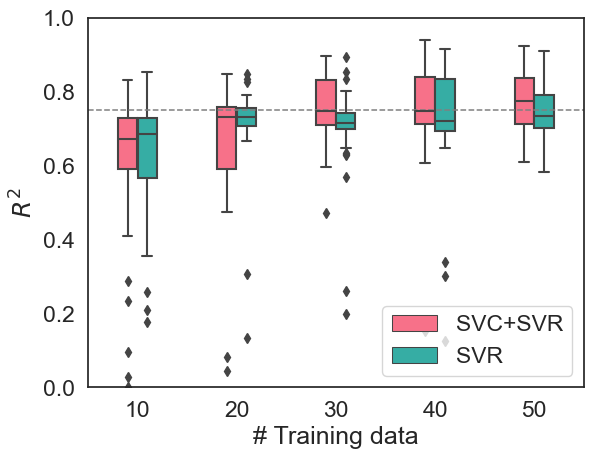

In [64]:
TFB = ComparisonResultsPlot([complexSVRR2Lists_TFB, SVRR2Lists_TFB], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

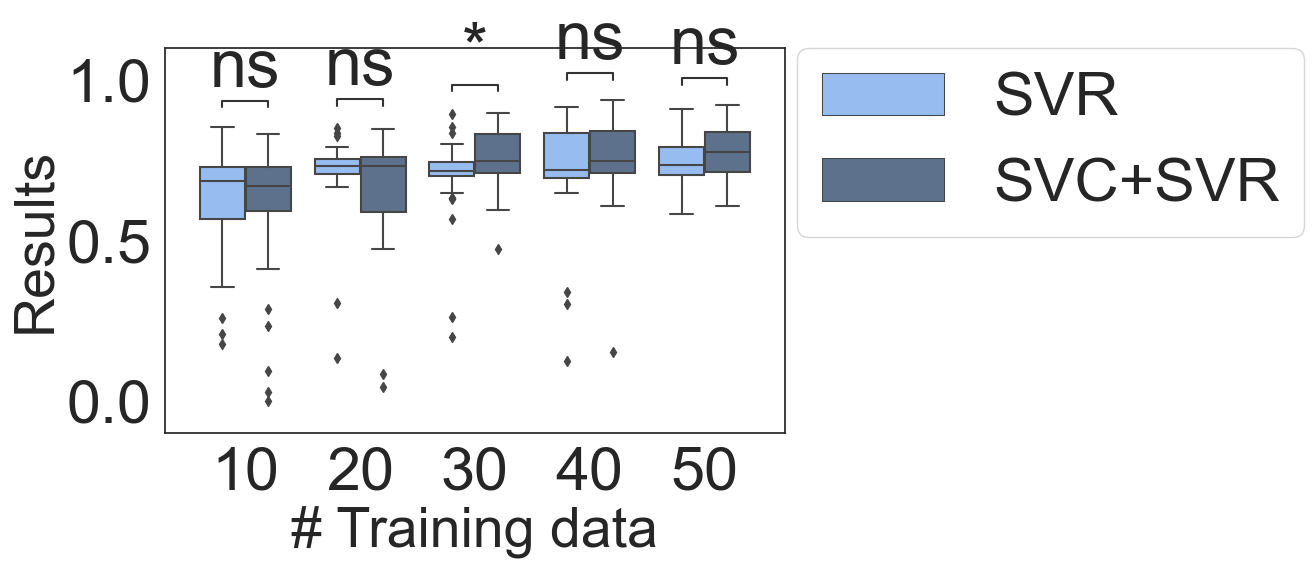

In [65]:
statsPlot(TFB)

here 0.0


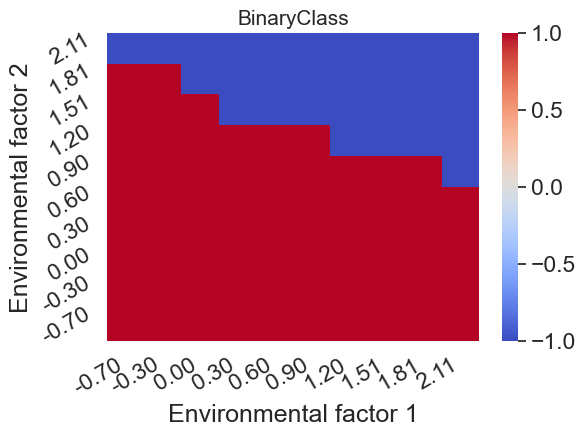

In [71]:
h = processExcelFormat02('HelenaTFTFBdensity.xlsx', 'Sheet1', 0.3)
heatmapGenerator(h, 'BinaryClass')

here 0.04081747967479674


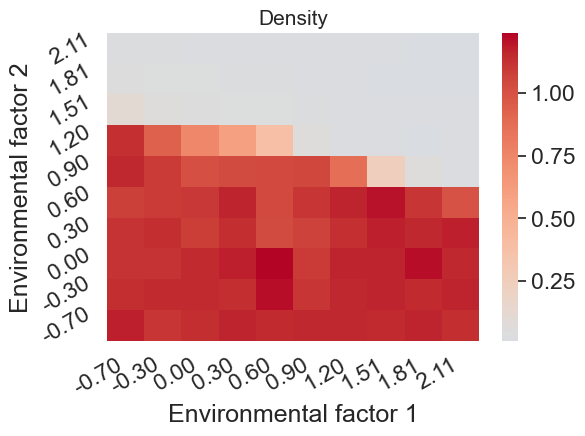

In [72]:
heatmapGenerator(h)

In [73]:
complexSVRSpearmanLists_TFTFB, complexSVRPearsonLists_TFTFB, complexSVRR2Lists_TFTFB, complexSVRMSELists_TFTFB, \
complexPredictedSVRSpearmanLists_TFTFB, complexPredictedSVRPearsonLists_TFTFB, complexPredictedSVRR2Lists_TFTFB, \
complexPredictedSVRMSELists_TFTFB, \
r2Recorder_TFTFB, mseRecorder_TFTFB, pearsonRecorder_TFTFB, spearmanRecorder_TFTFB, \
SVRSpearmanLists_TFTFB, SVRPearsonLists_TFTFB, SVRR2Lists_TFTFB, SVRMSELists_TFTFB, \
PredictedSVRSpearmanLists_TFTFB, PredictedSVRPearsonLists_TFTFB, \
PredictedSVRR2Lists_TFTFB, PredictedSVRMSELists_TFTFB, \
SVRr2Recorder_TFTFB, SVRmseRecorder_TFTFB, SVRpearsonRecorder_TFTFB, SVRspearmanRecorder_TFTFB,\
indexRecorder_TFTFB, TrainXDFRecorder_TFTFB, TrainYDFRecorder_TFTFB, \
SVMSVRFullXDFRecorder_TFTFB, SVMSVRFullYDFRecorder_TFTFB, scXRecorder_TFTFB, \
scDensityRecorder_TFTFB, scDistanceRecorder_TFTFB = \
ComparisonMultipleRun(30, 'HelenaTFTFBdensity.xlsx',  2, 'Sheet1', [10, 20, 30,40,50], 0, ['poly', 'rbf'], 0.3)

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.4921795641224669
MSE:  0.725522928750976
Pearson:  0.7015551041240216
Spearman:  1.0
R2:  0.8887750876623176
MSE:  0.08401998471164406
Pearson:  0.9427486874360087
Spearman:  1.0
R2:  0.8898446627869429
MSE:  0.07515952604822042
Pearson:  0.9433157810547552
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [              nan   -27677.4080833                nan               nan
   -27859.4147362                nan               nan               nan
 -1203598.06395019               nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-29849.22988924 -29931.45268121             nan -17376.83459012
             nan             nan             nan -17309.715905
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-25861.2764317              nan             nan             nan
             nan             nan             nan -24479.32727855
             nan       

SVM:  [0.6616076790241303, 0.11429525311584834, 0.7563656770724312, 0.7421574680001647]
SVR:  [0.5659899659313167, 0.2577424236279657, 0.752323046258266, 0.8016860658291819]
SVC(C=0.1, degree=5, gamma=0.1)
R2:  0.9878351970961979
MSE:  0.04909206517910964
Pearson:  0.9938989873705466
Spearman:  0.5
R2:  0.9988352220410879
MSE:  0.08141731520565189
Pearson:  0.9994174413332437
Spearman:  0.5
R2:  0.9943900856236737
MSE:  0.04228994778156633
Pearson:  0.997191097846182
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7023522795337331, 0.2893130928417901, 0.8546815782391742, 0.791628596122978]
SVR:  [0.7472989312202145, 0.07718047259430187, 0.8644645343912121, 0.8429435732806518]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=5)
R2:  0.8874273417576142
MSE:  0.037307061474538696
Pearson:  0.9420336202904938
Spearman:  1.0
R2:  0.9997778586729859
MSE:  0.01918166469774379
Pearson:  0.9998889231674613
Spearman:  1.0
R2:  0.9996264361469991
MSE:  0.0010730993231427132
Pearson:  0.9998132006264965
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7375561944859669, 0.11402340314495601, 0.7496734575930522, 0.7369551796518088]
SVR:  [0.6607035418467113, 0.0967499097111485, 0.8128367252079053, 0.7964357739638639]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=5, gamma=0.01)
R2:  nan
MSE:  0.2878146291373697
Pearson:  nan
Spearman:  nan
R2:  0.9991619754819207
MSE:  0.28773707042382585
Pearson:  0.9995808999185211
Spearman:  1.0
R2:  0.988141265326728
MSE:  0.0045811808824840925
Pearson:  0.9940529489552996
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.5061738  -0.3874929  -0.56897609 -0.15789867         nan -0.47601297
         nan -0.50587769 -0.39142271         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correl

SVM:  [0.7442268123168634, 0.07738671599195338, 0.8729105319587681, 0.8239288801086553]
SVR:  [0.7396528863001923, 0.09234039031536817, 0.8600307472993001, 0.8558834424002963]
SVC(C=100.0, gamma=0.01)
R2:  0.4634469927032029
MSE:  0.1851630895693851
Pearson:  0.6807694122852486
Spearman:  1.0
R2:  0.4592884449226305
MSE:  0.21488236968122953
Pearson:  0.6777082299357374
Spearman:  1.0
R2:  0.4520166983161267
MSE:  0.18560865116755307
Pearson:  0.6723218710678142
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8169703574848094, 0.11091428634275399, 0.8740992845571843, 0.8421533522657118]
SVR:  [0.7992941901117614, 0.06521337501217164, 0.894032544212883, 0.7510309914804295]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.8906512921254401
MSE:  0.08984839728013501
Pearson:  0.9437432342143919
Spearman:  0.5
R2:  0.8013638746457463
MSE:  0.04710740563987151
Pearson:  0.8951892954262504
Spearman:  0.5
R2:  0.8826376125280159
MSE:  0.09917899926418282
Pearson:  0.9394879523059443
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7762598028738974, 0.19366119917876226, 0.8541352137472074, 0.8274684117380746]
SVR:  [0.69555049296999, 0.1047630673678489, 0.8339966984167209, 0.8331975140963905]
SVC(C=10000.0, gamma=0.001)
R2:  0.9879328555099164
MSE:  0.1689046887159028
Pearson:  0.993948115099534
Spearman:  0.5
R2:  0.9985976953498618
MSE:  0.16367211195132816
Pearson:  0.99929860169514
Spearman:  0.5
R2:  0.9903453611439731
MSE:  0.27396200907135704
Pearson:  0.9951609724783086
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7008591539407818, 0.09949139343350578, 0.9084939157304588, 0.8200600897230109]
SVR:  [0.727533863215561, 0.07554031714457707, 0.8529559561991233, 0.8311725727456064]
SVC(C=10.0, degree=5, gamma=0.0001)
R2:  0.7680958129977064
MSE:  0.30581705496224526
Pearson:  0.876410755866053
Spearman:  0.5
R2:  0.9836095852039458
MSE:  0.3025264821972771
Pearson:  0.9917709338370158
Spearman:  0.5
R2:  0.6634542866367141
MSE:  0.3359016716552103
Pearson:  0.8145270324775687
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -58.17998891 -63.91019081          nan -63.97304744
 -37.28474201 -63.90674367  -6.97165589          nan -63.8890138 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-63.90635588 -63.64144285 -58.17151975          nan -49.08601878
 -57.85973161 -63.97304436 -56.01855934 -63.97338227 -35.8218416 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-58.18319069 -63.97338227 -57.47894438 -58.18318363 -24.44171391
 -63.90673847 -63.17056101          nan -11.39223058 -57.47894434]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

SVM:  [0.7223895440909999, 0.20025896739680707, 0.8452722529021383, 0.8255093221385357]
SVR:  [0.7506989563192422, 0.319263437765124, 0.8529358001944483, 0.8120426390089311]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=2, gamma=1.0)
R2:  0.9183498781168878
MSE:  0.36180764322105324
Pearson:  0.9583057331128141
Spearman:  1.0
R2:  0.9842264922097697
MSE:  0.08103975981610273
Pearson:  0.992081897934727
Spearman:  1.0
R2:  0.9953277947012054
MSE:  0.016592146815166808
Pearson:  0.9976611622696382
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan -2737.31426314 -2738.14499859
 -2608.67934689            nan -2672.64328173            nan
            nan -2737.8913608 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2499.34587304            nan -2490.2899797             nan
            nan            nan -2711.76592892            nan
 -2490.27598222 -2490.2899797 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan -3336.85725199
 -2583.29482763            nan            nan -2658.43026773
            nan            nan]
  category=UserWarning,
/Users/ychha/

SVM:  [0.14416538096660364, 0.11360656689319118, 0.813786634837549, 0.8559657570893525]
SVR:  [0.43925219808834104, 0.3928860320131013, 0.6627610414684474, 0.7724821994484915]
SVC(C=10000.0, gamma=0.001)
R2:  0.9990241791918179
MSE:  0.04798411779125286
Pearson:  0.9995119705095172
Spearman:  1.0
R2:  0.9981989605011503
MSE:  0.11232270845070835
Pearson:  0.9990990744171224
Spearman:  1.0
R2:  0.9862716408636333
MSE:  0.021235587879086668
Pearson:  0.9931120988406261
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan  -455.86289824 -3467.89948151            nan
  -528.47559403            nan            nan  -455.96043139
  -260.91836417            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -553.19513647            nan            nan  -454.36907393
            nan  -439.57459742            nan  -468.05764996
 -4552.89873505            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.56026323e+02 -4.25946918e+08 -4.31383655e+02 -2.42489493e+02
             nan             nan -4.56026782e+02 -2.87446944e+02
 -4.43802592e+02 -4.56026873e+02]
  category=UserWarning,
/Us

SVM:  [0.6700890981683122, 0.12547198404935261, 0.818503215368687, 0.8106268263571634]
SVR:  [0.669798221234825, 0.12558349169632355, 0.8184120119077093, 0.8106268263571634]
SVC(degree=2, gamma=0.001)
R2:  0.3676287887812702
MSE:  0.04317691036868366
Pearson:  0.6063239965408512
Spearman:  0.5
R2:  0.36771988804175304
MSE:  0.04296237939964487
Pearson:  0.6063991161287698
Spearman:  0.5
R2:  0.36778884125126043
MSE:  0.042811421704026076
Pearson:  0.6064559681058967
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan           nan
           nan  -28.10750698 -910.92063827 -254.97617938 -927.42728892]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -9.06041985e+02
 -2.92800328e+01 -9.28907479e+02 -4.66143953e+06             nan
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan  -31.12805165           nan
           nan -928.33066751           nan           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.7421081332057216, 0.10078914141799153, 0.05008795809609226, 0.8452648475120386]
SVR:  [0.7106463235694991, 0.5307796994199835, 0.8429984125545544, 0.8240111947977117]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.0001)
R2:  0.9932289545848394
MSE:  0.32244094305001475
Pearson:  0.9966087269258883
Spearman:  1.0
R2:  0.8456105599006638
MSE:  0.05080069388589505
Pearson:  0.9195708563784871
Spearman:  1.0
R2:  0.7846698740316824
MSE:  0.07761067519523811
Pearson:  0.8858159368806153
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-11.38836765          nan          nan  -0.263301    -5.16673207
  -0.26355969          nan  -0.12661516          nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
 -5.82971987e-01             nan -1.27909074e+02 -7.28531107e+00
 -5.24265537e-01 -3.72765312e-02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.36421728  0.58242576 -0.52916304 -0.58297199         nan         nan
 -0.57171809  0.58242576 -0.03036122 -0.53219316]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

SVM:  [0.7349655718461499, 0.08055381279295436, 0.8800059175313599, 0.7772235255381323]
SVR:  [0.7475221708974406, 0.09370023063765455, 0.8645936449555017, 0.8531505947236284]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.8680837503736878
MSE:  0.4997086733102283
Pearson:  0.9317101214292394
Spearman:  0.5
R2:  0.7924680866873218
MSE:  0.1062288701198557
Pearson:  0.8902067662556392
Spearman:  1.0
R2:  0.9989273183198984
MSE:  0.40072545975171847
Pearson:  0.9994635152520067
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-188.59149239           nan -145.55654003 -121.40317607 -188.75582343
           nan  -48.15412348 -172.0038383  -188.75520068 -153.78950807]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.72103087e+02 -1.88149701e+02             nan -1.77049268e+01
 -2.65510979e+04             nan -7.40992194e+01 -2.56014050e+02
 -2.00581955e+02 -1.82883812e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-190.36020686 -170.93182935 -172.1180535  -172.09758911           nan
 -188.7338058  -187.51375846           nan  -73.83223909 -170.8554104 ]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.6243880858456738, 0.25841929250508233, 0.8615480766939952, 0.8349755113800057]
SVR:  [0.09164346180207866, 0.28256519199394925, 0.3027267114115942, 0.5336708467573229]
SVC(C=10.0, degree=4, gamma='auto')
R2:  nan
MSE:  0.34697845806512984
Pearson:  nan
Spearman:  nan
R2:  0.9591617627712511
MSE:  0.01876879543707739
Pearson:  0.9793680425515483
Spearman:  1.0
R2:  0.972999073628577
MSE:  0.013890448963398727
Pearson:  0.9864071540842437
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.50186162 -0.48193504 -0.50720506 -0.49822381         nan -0.49547443
 -0.44863728 -0.11846459 -0.49623246 -1.59680643]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correl

SVM:  [0.82159023565456, 0.05184596063106062, 0.9117800751622718, 0.8464337160966373]
SVR:  [0.7449265012774491, 0.10692326023017448, 0.8630912473646393, 0.8373955632382598]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4, gamma=10.0)
R2:  0.7282493715514409
MSE:  0.07310378968452647
Pearson:  0.8533752817790314
Spearman:  1.0
R2:  0.6460232524958397
MSE:  0.07674677067233389
Pearson:  0.8037557169288688
Spearman:  1.0
R2:  0.35188443886648
MSE:  0.2587773355241391
Pearson:  0.593198481847754
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.738806269083924, 0.247276779822251, 0.8595785736341084, 0.8500884882907355]
SVR:  [0.7387051393495606, 0.07745887959285316, 0.8594795747134197, 0.8500884882907355]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.5138751697104711
MSE:  0.12127173571809174
Pearson:  0.7168508699237737
Spearman:  1.0
R2:  0.7757694733704869
MSE:  214.62034701403903
Pearson:  -0.8807777661649314
Spearman:  -1.0
R2:  0.43506357320161454
MSE:  0.7209030005453624
Pearson:  0.6595934908726847
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-42106.96926045             nan             nan             nan
             nan             nan             nan             nan
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan -294143.72347565
              nan              nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
 -79636.07763817 -80396.80012717             nan             nan
             nan             na

SVM:  [0.6738258138200326, 0.29966779641917246, 0.8202403924657626, 0.7887311190681976]
SVR:  [0.7447087173470324, 0.24985074312382996, 0.8629650730748215, 0.7340412396592171]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.1, degree=4, gamma=0.1, kernel='poly')
R2:  0.6667464907633672
MSE:  0.1024290525700131
Pearson:  0.8165454615410994
Spearman:  1.0
R2:  0.9346122108768363
MSE:  0.03285941757558224
Pearson:  0.966753438513066
Spearman:  1.0
R2:  0.9674079653357929
MSE:  0.24680252869518707
Pearson:  0.9835689936836121
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7347054568575104, 0.11185156954421838, 0.429814052600225, 0.8637362637362637]
SVR:  [0.6567031394969327, 0.2527260908708307, 0.8103722228068613, 0.8037123924764373]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.7781424176484977
MSE:  0.12337409247767643
Pearson:  0.8821238108386473
Spearman:  1.0
R2:  0.7274150140847848
MSE:  0.13721932532550535
Pearson:  0.8528862843807404
Spearman:  1.0
R2:  0.7227970836631852
MSE:  0.12314179920782953
Pearson:  0.8501747371353641
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5249956385157677, 0.1932742599942522, 0.6292296211533981, 0.6858871465613038]
SVR:  [0.4234415711304917, 0.20622129106219203, 0.6507238824036597, 0.5511873893896366]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=5, gamma='auto', kernel='poly')
R2:  0.9976041292316291
MSE:  0.0195427190762749
Pearson:  0.9988013462303851
Spearman:  1.0
R2:  0.9958436239514443
MSE:  0.023365712147488515
Pearson:  0.9979196480435911
Spearman:  1.0
R2:  0.9997653573418805
MSE:  0.12647556397319182
Pearson:  0.9998826717879858
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.575668934296169, 0.22948239322408195, 0.6897770466818799, 0.8342676050541219]
SVR:  [0.7400859724338078, 0.22427680269402017, 0.8602824957151041, 0.8172284644194755]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.1, degree=5, gamma=10.0)
R2:  0.7706413691399885
MSE:  0.1539542919653766
Pearson:  0.877861816654528
Spearman:  1.0
R2:  0.8478783368459614
MSE:  0.08816454823888087
Pearson:  0.920803093416807
Spearman:  1.0
R2:  0.33427928680122904
MSE:  203.3488870558441
Pearson:  -0.5781689085390436
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7348559752654326, 0.04593842030470329, 0.8552161359687951, 0.8218051611310038]
SVR:  [0.6213619433607662, 0.11780715126978882, 0.7882651478790411, 0.8141992838622051]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.005915608680079704
MSE:  0.892498031828179
Pearson:  -0.07691299422126092
Spearman:  -0.5
R2:  0.6863798637790979
MSE:  0.3034998524222982
Pearson:  0.8284804546753641
Spearman:  0.5
R2:  0.7511361737745768
MSE:  833091.1335855
Pearson:  -0.8666811257749742
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7482383528882909, 0.09985289286669005, 0.8500468515560746, 0.77075359097831]
SVR:  [0.7225244425746857, 0.09931155619539052, 0.8500143778635074, 0.8498250812857554]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.9961379022777213
MSE:  0.8897646836348047
Pearson:  0.9980670830549021
Spearman:  1.0
R2:  0.8241827742142569
MSE:  0.25384778979548017
Pearson:  0.9078451267778316
Spearman:  0.5
R2:  0.9983486946013344
MSE:  0.8896693072558186
Pearson:  0.9991740061677616
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan -787.02410586
           nan           nan           nan           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-787.06966474           nan -714.66962946           nan           nan
 -748.39389847 -772.32848742 -787.0725678            nan -250.92394285]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan           nan           nan
           nan           nan -787.07248755           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pack

SVM:  [0.6531282832402298, 17.885841363495643, 0.8801795428423027, 0.7785076346874098]
SVR:  [0.16764405681537473, 144.0351223814246, 0.40944359418041343, 0.7051981726139029]
SVC(C=100.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.6332716608242773
MSE:  0.3628528457288967
Pearson:  -0.7957836771537081
Spearman:  -1.0
R2:  0.8506520191699652
MSE:  0.30485677380195464
Pearson:  0.9223079849865582
Spearman:  1.0
R2:  0.8803470796579337
MSE:  0.23140797068275987
Pearson:  0.9382681278067234
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.19558344e+00 -8.06653555e+06 -6.54598030e+00 -7.27766199e+00
 -1.06910399e+01 -6.77938958e+00             nan -1.46270090e+01
 -1.15259956e+01 -6.58605582e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -7.18804102          nan  -6.46128718  -6.53957635          nan
  -6.97891523          nan          nan          nan -11.52098848]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-10.29204425  -6.71886481  -9.90836636  -7.20222974  -6.77938958
 -70.89384114          nan          nan  -7.20222974          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

SVM:  [0.2775873528829011, 0.33655508670084144, 0.5270557083641567, 0.8026752273943285]
SVR:  [0.5915470795870712, 0.403926507683578, 0.7691209785118793, 0.7523159863996205]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(degree=5)
R2:  0.567189590087202
MSE:  0.11698495469628789
Pearson:  0.7531199041900312
Spearman:  0.5
R2:  0.9976042387721777
MSE:  0.018251347835628928
Pearson:  0.9988014010663869
Spearman:  1.0
R2:  0.995631098998349
MSE:  0.05470489924489088
Pearson:  0.9978131583609975
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan -5.05264649e-01             nan
 -3.47745500e-02 -4.62978666e-01  9.05784974e-02 -2.53086929e+02
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -1.67309279e+02  4.91771626e-01             nan
 -5.07683383e-01             nan -3.96446094e-02  3.21787237e-01
 -2.44234158e+00 -3.81656038e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.12950526 -0.38457116 -0.50774911 -0.50774911 -0.38427553 -0.50758271
         nan         nan -0.36527915  0.31413058]
  category=UserWarning,
/Users/ychha/anaconda3/l

SVM:  [0.7735950771562634, 0.3047490514697566, 0.8811183460060013, 0.8190887763921472]
SVR:  [0.7219855640273813, 0.08375191963873715, 0.8496973367190115, 0.8257233403300818]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, gamma=0.01)
R2:  0.9556174086000618
MSE:  0.0531422334597931
Pearson:  0.9775568569653951
Spearman:  1.0
R2:  0.9459287529244222
MSE:  0.0905283338826857
Pearson:  0.9725886864057292
Spearman:  1.0
R2:  0.9467830217207042
MSE:  0.11561446662465541
Pearson:  0.9730277599949055
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature n

SVM:  [0.7207090852155095, 0.24926102172586162, 0.7691827959671187, 0.8479812322508951]
SVR:  [1.4242613148944187e-31, 0.32552847134222396, 0.29754607756695056, 0.8479812322508951]
SVC(degree=5, gamma=1.0, kernel='poly')
R2:  0.7243533712199681
MSE:  0.18648888247613402
Pearson:  0.8510895200976032
Spearman:  1.0
R2:  0.7183681969827432
MSE:  0.22205668140696924
Pearson:  0.8475660428442988
Spearman:  1.0
R2:  0.2345054468207759
MSE:  24.15005267318735
Pearson:  -0.48425762443226017
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-127.26533812 -127.49265357           nan           nan  -25.15143382
           nan -127.39346067 -125.26763234           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-125.79490665  -25.57787458 -127.26527986  -29.06249026           nan
           nan -149.45493411 -126.56608375           nan  -25.5501113 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan  -83.99222185 -119.52096026 -127.41406357 -127.49265361
 -127.25942961 -127.48683621           nan  -75.95044177 -127.18062792]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pack

SVM:  [0.698285206750354, 0.20585876796461508, 0.9121972386118828, 0.7936206115981396]
SVR:  [0.016685864914950877, 0.10601215956992692, -0.129173777969644, -0.18528213359674034]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.9909492173105009
MSE:  0.07027038320057917
Pearson:  0.9954643224699221
Spearman:  1.0
R2:  0.9942808380448788
MSE:  0.04787913196518213
Pearson:  0.9971363186871086
Spearman:  1.0
R2:  0.99964530908463
MSE:  0.2573514787277379
Pearson:  0.9998226388138197
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7791925083323883, 0.06462777163983167, 0.8827188161200534, 0.8267934312878131]
SVR:  [0.738143296531025, 0.08217095764069103, 0.8591526619472379, 0.8432399061612543]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.171404161663899
MSE:  1213.2198352996138
Pearson:  0.4140098569646608
Spearman:  0.5
R2:  0.9999963882166109
MSE:  0.04554479863434414
Pearson:  0.9999981941066749
Spearman:  1.0
R2:  0.9997072233623966
MSE:  0.03797640010804571
Pearson:  0.9998536009648596
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5843255488740797, 0.08062964897350589, 0.8260130176643694, 0.7502901592789234]
SVR:  [0.54802992078052, 0.12999042705451705, 0.7402904300208938, 0.7551631888710539]
SVC(C=10000.0, degree=2, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.52865112  0.67575283 -2.22597639 -2.34442288 -2.59448032         nan
 -1.01208425 -6.46317911 -2.33766311 -2.344414  ]
  category=UserWarning,


R2:  0.997683484284247
MSE:  0.009178912372555874
Pearson:  0.9988410705834273
Spearman:  1.0
R2:  0.9341418331816658
MSE:  4.171772718902593
Pearson:  -0.9665101309255201
Spearman:  -1.0
R2:  0.9797645706724328
MSE:  0.3678047694715189
Pearson:  0.9898305767516139
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -2.46558935 -2.47490065         nan -2.21821487         nan
         nan         nan -1.58839074 -2.45602279]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.81609033         nan         nan -2.56544053 -2.55370542         nan
         nan         nan -2.36239929         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan  -2.22594165  -4.82006483  -1.0042231  -24.20137541
  -2.56356174  -1.48443574   0.52664244 -10.92884663          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has featu

SVM:  [0.6340784787312393, 0.13509574503050223, 0.7930466858915017, 0.7987735111330617]
SVR:  [0.7194763351651672, 0.11075482616841623, 0.8482195088331599, 0.8587973823928879]
SVC(C=10.0, degree=2, gamma=10.0)
R2:  0.9991360907030465
MSE:  0.03824464119313557
Pearson:  0.9995679520187941
Spearman:  1.0
R2:  0.9994987915965753
MSE:  0.040204619340182456
Pearson:  0.9997493643891828
Spearman:  1.0
R2:  0.9978157113727655
MSE:  0.000721959630834102
Pearson:  0.9989072586445478
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan -4982.51595334 -4422.62891956            nan
 -4417.93261087            nan            nan            nan
 -1256.426791   -1923.93721398]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -4.96482444e+03
             nan -1.66102605e+03 -3.38158909e+03 -1.61549219e+09
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-338238.03136017   -4965.04527549              nan   -3459.20159894
   -4584.64236952   -4926.41453077   -4964.62092868   -4965.06889088
   -3459.20159894              nan]
  categ

SVM:  [0.732031224882688, 0.2172499545036984, 0.5921623690849589, 0.030135407663497548]
SVR:  [0.6450372587258089, 0.1861765460293735, 0.803142116144963, 0.6819360414866033]
20
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.7916231231080162
MSE:  0.28344040646884894
Pearson:  0.8897320512986009
Spearman:  0.6000000000000001
R2:  0.8746208979286471
MSE:  0.08077515357774502
Pearson:  0.9352116861591534
Spearman:  0.6000000000000001
R2:  0.9322045668848511
MSE:  0.02720367024672402
Pearson:  0.9655074142050135
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8448684188702607, 0.14177986662966216, 0.9303163080930202, 0.8772386310360994]
SVR:  [0.8277469237472469, 0.05008829640266761, 0.9098059813758355, 0.863103609939053]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.8413477467675842
MSE:  0.26887600186519617
Pearson:  0.9172501004456663
Spearman:  0.7999999999999999
R2:  0.9486265033782981
MSE:  0.2362823474344577
Pearson:  0.9739745907251888
Spearman:  0.7999999999999999
R2:  0.970084976595357
MSE:  0.3001518446288962
Pearson:  0.9849289195649387
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8420737491970732, 0.42270746471144144, 0.902725752603786, 0.8414908579465542]
SVR:  [0.6820609517616432, 0.4955384048402506, 0.825869815262456, 0.8102437880918895]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.8195651854149999
MSE:  0.09455489116815491
Pearson:  0.9052983957872676
Spearman:  1.0
R2:  0.6131576242648304
MSE:  0.21966681932711196
Pearson:  0.783043820143439
Spearman:  1.0
R2:  0.8211467690852096
MSE:  0.08756073448107561
Pearson:  0.9061714898876534
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5456084939198762, 0.09443269211226832, 0.8237466229759551, 0.8163150492264417]
SVR:  [0.44697036020959463, 0.22041951142711302, 0.6685584194441008, 0.8111814345991561]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.8209165752152963
MSE:  0.23396427019247734
Pearson:  0.9060444664669034
Spearman:  1.0
R2:  0.2815349795911959
MSE:  0.25618177799986397
Pearson:  0.5305986991985524
Spearman:  1.0
R2:  0.648774126915584
MSE:  0.2309316343054369
Pearson:  0.8054651618261239
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8020788198518627, 0.4510551539984293, 0.8792325279765527, 0.8387951242381623]
SVR:  [0.8024349357265063, 0.43221530009350617, 0.895787327286174, 0.8387951242381623]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.8894806100438306
MSE:  0.8365902213627143
Pearson:  0.9431227969060183
Spearman:  0.39999999999999997
R2:  0.896783553406102
MSE:  0.8197995891228758
Pearson:  0.9469865645330465
Spearman:  0.19999999999999998
R2:  0.9744793269754009
MSE:  0.01579549260719044
Pearson:  0.9871571946632416
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.24509546808221563, 0.05052677697773027, 0.9254925327165522, 0.891795593061416]
SVR:  [0.661944111473546, 0.39793819106152106, 0.8135994785356896, 0.7711204875761839]
SVC(C=10.0, gamma=1.0, kernel='poly')
R2:  0.9677687327579677
MSE:  0.04151802375745707
Pearson:  0.9837523736987718
Spearman:  0.39999999999999997
R2:  0.9315335652157698
MSE:  0.029359134778758924
Pearson:  0.9651598651082471
Spearman:  0.7999999999999999
R2:  0.9703158275681159
MSE:  0.03363476976214293
Pearson:  0.9850461042855383
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8372126421496734, 0.22762517073863037, 0.8842545850356347, 0.8516408813877169]
SVR:  [0.7559697419602366, 0.08962128991372285, 0.869465204571314, 0.8575714955461791]
SVC(gamma=0.1)
R2:  0.9389795577043357
MSE:  0.016211198377941126
Pearson:  0.9690095756515181
Spearman:  0.39999999999999997
R2:  0.9395282041070575
MSE:  0.016393001596805082
Pearson:  0.9692926307916804
Spearman:  0.39999999999999997
R2:  0.9515833297151697
MSE:  0.01270865040187284
Pearson:  0.9754913273398025
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7250162767520569, 0.10576160511741114, 0.7990567553632013, 0.8491795593061418]
SVR:  [0.7131921914977982, 0.09329048276747597, 0.844507070128959, 0.6840834505391468]
SVC(C=10000.0, degree=2, gamma='auto', kernel='poly')
R2:  0.23408661320796673
MSE:  0.44376128318504626
Pearson:  0.4838249820006886
Spearman:  0.19999999999999998
R2:  0.3615876923812841
MSE:  0.4271845435486409
Pearson:  0.6013216214150994
Spearman:  0.7999999999999999
R2:  0.42932097301720373
MSE:  0.4293299746853965
Pearson:  0.6552258946479479
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4054312445483726, 0.5108063579394704, 0.6367357817467312, 0.5959212376933896]
SVR:  [0.6527343819024851, 0.4266277892836336, 0.8079197867997076, 0.7985466479137365]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.457217916984769
MSE:  0.012718015555252524
Pearson:  0.6761789090061661
Spearman:  0.39999999999999997
R2:  0.37435768965113203
MSE:  0.15502063204459837
Pearson:  0.6118477667288913
Spearman:  0.7999999999999999
R2:  0.07767141896031231
MSE:  0.008365146329417449
Pearson:  0.27869592562560425
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7928363887925373, 0.03778212976195945, 0.8433712434593408, 0.8207923112986404]
SVR:  [0.8180016577818443, 0.31360604411440207, 0.9044344408423669, 0.8037037037037038]
SVC(C=10.0)
R2:  0.9995963103144087
MSE:  0.029784329426433484
Pearson:  0.9997981347824214
Spearman:  1.0
R2:  0.9995375977959532
MSE:  0.028472111164200023
Pearson:  0.999768772164821
Spearman:  1.0
R2:  0.994087037059394
MSE:  0.013497988376918827
Pearson:  0.9970391351694246
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6759332031101144, 0.06255136450350984, 0.8239690904680494, 0.8261134552273792]
SVR:  [0.17820575871878597, 7.296421956157047, 0.4221442392343947, 0.6120721987810597]
SVC(gamma=1.0)
R2:  0.8839817429396531
MSE:  0.039094692658981016
Pearson:  0.9402030328283637
Spearman:  0.7999999999999999
R2:  0.8772593470504693
MSE:  0.0453599716558574
Pearson:  0.9366212399099594
Spearman:  0.7999999999999999
R2:  0.4709152431485156
MSE:  0.37145477200743493
Pearson:  0.6862326450618009
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8849204687229338, 0.047913622293266386, 0.8560400527561589, 0.8568917018284107]
SVR:  [0.7013514679209161, 0.08323590078072352, 0.8374672936425138, 0.8159634317862167]
SVC(C=10000.0, degree=2)
R2:  0.9214365537208561
MSE:  0.23875402534729484
Pearson:  0.9599148679548914
Spearman:  1.0
R2:  0.9431579107742631
MSE:  0.10942232218644514
Pearson:  0.9711631741238251
Spearman:  1.0
R2:  0.7677576607446046
MSE:  0.07826948015618873
Pearson:  0.876217815811003
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8007526674927711, 0.03493653647315878, 0.660047583612759, 0.8338021565869668]
SVR:  [0.3956247532132242, 0.306646267826751, 0.6289870850925507, 0.5259728082512893]
SVC(C=10000.0, gamma=10.0, kernel='poly')
R2:  0.7421942368999682
MSE:  0.05605217231790746
Pearson:  0.8615069569655074
Spearman:  0.19999999999999998
R2:  0.7921436807944839
MSE:  0.040513252764306104
Pearson:  0.8900245394338765
Spearman:  0.39999999999999997
R2:  0.790059669228079
MSE:  0.03713506889969524
Pearson:  0.8888530076610413
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7209577204511717, 0.09914378934603088, 0.8426781713769322, 0.7537505860290672]
SVR:  [0.8253703340203082, 0.05986147460429057, 0.9084989455251489, 0.7521097046413503]
SVC(C=10000.0, degree=4)
R2:  0.9910573874199158
MSE:  0.0222470047980114
Pearson:  0.9955186524721251
Spearman:  1.0
R2:  0.9763723192135052
MSE:  0.026445550807695443
Pearson:  0.9881155394049346
Spearman:  1.0
R2:  0.9043546297747983
MSE:  0.06134158653739277
Pearson:  0.9509756199686707
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.27004460681546405, 0.5699405441032706, 0.761403053826737, 0.7285747773089546]
SVR:  [0.7625064197386796, 0.15969957146524622, 0.8732161357525862, 0.8251054852320676]
SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.9372792347761841
MSE:  0.07307963866006165
Pearson:  0.9681318271682756
Spearman:  0.7999999999999999
R2:  0.983265198774625
MSE:  0.008907161899722614
Pearson:  0.9915972966757345
Spearman:  0.7999999999999999
R2:  0.9347924043343453
MSE:  0.023083158394015778
Pearson:  0.9668466291684245
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7763853987701097, 0.12250071794348454, 0.8528978043823162, 0.8352086263478669]
SVR:  [0.7272004039321411, 0.12455991925657073, 0.8527604610511332, 0.8352086263478669]
SVC(C=10000.0, degree=4)
R2:  0.7407213314923744
MSE:  0.1371255752774884
Pearson:  0.8606516899956534
Spearman:  1.0
R2:  0.5209506111491659
MSE:  0.20401003024327097
Pearson:  0.7217690843678232
Spearman:  1.0
R2:  0.7744392690485458
MSE:  0.07522302604572303
Pearson:  0.8800223116765538
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8775182475116561, 0.03616102058989141, 0.9312752765848059, 0.8413502109704641]
SVR:  [0.7229540715265144, 0.10274067869537817, 0.8502670589447257, 0.8413502109704641]
SVC(degree=4)
R2:  0.40467485062017006
MSE:  0.21024343684472369
Pearson:  0.6361405902944488
Spearman:  0.7999999999999999
R2:  0.4491074606027451
MSE:  0.1833821226141014
Pearson:  0.6701548034616664
Spearman:  0.7999999999999999
R2:  0.7328483811959833
MSE:  0.08392077673955882
Pearson:  0.8560656407051875
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8313908310356307, 0.06990716450607788, 0.8892738855681355, 0.8754571026722927]
SVR:  [0.8096220059470356, 0.055683724569582684, 0.8997899787989619, 0.853961556493202]
SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.9979997275933901
MSE:  0.2970403445750174
Pearson:  0.9989993631596519
Spearman:  0.7999999999999999
R2:  0.6890797587204652
MSE:  0.2910292665324326
Pearson:  0.8301082813226632
Spearman:  0.7999999999999999
R2:  0.9624484876406142
MSE:  0.2968365158554744
Pearson:  0.981044590036872
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38488321353909305, 0.511530834470862, 0.6284464569963577, 0.6957337083919363]
SVR:  [0.39632203022790496, 0.488093897947102, 0.6295411267168372, 0.6150492264416315]
SVC(C=1000.0, degree=5, gamma=1.0)
R2:  0.8261711915637047
MSE:  0.03875080652251375
Pearson:  0.9089395973131024
Spearman:  1.0
R2:  0.7974373417349092
MSE:  0.06201668540280076
Pearson:  0.8929934723921049
Spearman:  1.0
R2:  0.8265247113794384
MSE:  0.06594729731466706
Pearson:  0.9091340447807674
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8390994740129635, 0.08760466053039799, 0.9117665336351648, 0.7949132676980779]
SVR:  [0.7119910167197743, 0.07895533538399113, 0.8437956012683251, 0.819760900140647]
SVC(gamma='auto')
R2:  0.8452155131936663
MSE:  0.14725956973970825
Pearson:  0.919356031792725
Spearman:  1.0
R2:  0.6323381890636747
MSE:  0.3639001549841618
Pearson:  0.7951969498581308
Spearman:  1.0
R2:  0.9281984815733098
MSE:  0.055323539280632134
Pearson:  0.9634305795298952
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7704923140418257, 0.06422253155361335, 0.8777769158743158, 0.8236286919831224]
SVR:  [0.7351438335256535, 0.10802906953473794, 0.8574052912862471, 0.8236286919831224]
SVC(C=100.0, degree=4)
R2:  0.6463676950916334
MSE:  0.15864260592592194
Pearson:  0.8039699590728706
Spearman:  0.7999999999999999
R2:  0.8747778721531702
MSE:  0.06297870652686624
Pearson:  0.9352956068287555
Spearman:  0.7999999999999999
R2:  0.9089756711209475
MSE:  0.05204326881477453
Pearson:  0.9534021560291057
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8190568145291117, 0.056291186219688275, 0.9051004788056953, 0.6959681200187531]
SVR:  [0.600126954749452, 0.12500999676990426, 0.7746786138454138, 0.7685419596812002]
SVC(C=10000.0, gamma=10.0, kernel='poly')
R2:  0.9074556948716076
MSE:  0.5519394959610311
Pearson:  0.9526046897174123
Spearman:  1.0
R2:  0.9512207094730207
MSE:  0.5573439155569944
Pearson:  0.9753054441932644
Spearman:  0.6000000000000001
R2:  0.7453205195713712
MSE:  0.5417648928488794
Pearson:  0.863319477118043
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3914140047251493, 0.4301787263351741, 0.8684346826411473, 0.8055321143928739]
SVR:  [0.7434353978411062, 0.4548397224867358, 0.862226999021201, 0.8602203469292077]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.6393376786193092
MSE:  0.2556943367939911
Pearson:  0.7995859419845432
Spearman:  0.19999999999999998
R2:  0.833219955549752
MSE:  0.16081405130654305
Pearson:  0.9128088274933321
Spearman:  0.39999999999999997
R2:  0.877435193481596
MSE:  0.04752487183712113
Pearson:  0.9367151079605774
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7707166975159185, 0.07951854917639864, 0.8944315552902211, 0.8570557899671825]
SVR:  [0.07683709254409544, 0.39205899873586275, -0.277195044227157, -0.18068448195030476]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.9918233816842359
MSE:  0.5239628206505984
Pearson:  0.9959032993640676
Spearman:  0.7999999999999999
R2:  0.9894811709799115
MSE:  0.4849237983315074
Pearson:  0.9947266815461984
Spearman:  1.0
R2:  0.9983657560438526
MSE:  0.4406354166960671
Pearson:  0.9991825439046923
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5313360187891865, 0.45711728606210905, 0.20515498514189343, 0.8457805907172996]
SVR:  [0.7434962588006674, 0.38672966542414483, 0.862262291185615, 0.8749179559306142]
SVC(C=1000.0, gamma=1.0)
R2:  0.9530431577527299
MSE:  0.03049012818409253
Pearson:  0.9762392932845563
Spearman:  1.0
R2:  0.966497031520939
MSE:  0.029978016113367076
Pearson:  0.9831058089142489
Spearman:  0.7999999999999999
R2:  0.8014437074981174
MSE:  0.07921224001570631
Pearson:  0.8952338842437307
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7161696637778461, 0.05749334244815575, 0.7912487249591807, 0.7665025785278949]
SVR:  [0.6233340325395356, 0.11058641435187573, 0.7895150616293116, 0.7520393811533052]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.020144137955039138
MSE:  0.13735299209559138
Pearson:  0.14193004599111186
Spearman:  0.0
R2:  0.020922712686467008
MSE:  0.3421503763300536
Pearson:  0.14464685508668002
Spearman:  0.6000000000000001
R2:  0.019366729307966374
MSE:  0.017619933743352093
Pearson:  0.13916439669673547
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7788737014128001, 0.04650509804777802, 0.908873562893488, 0.8347398030942336]
SVR:  [0.764303126463854, 0.07982270034315345, 0.8742443173757861, 0.8681200187529302]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.8896887330363914
MSE:  0.045044011053976214
Pearson:  0.9432331276181893
Spearman:  1.0
R2:  0.9874954864835971
MSE:  0.03151620500880804
Pearson:  0.9937280747184296
Spearman:  0.7999999999999999
R2:  0.9892870313927616
MSE:  0.027752922422090053
Pearson:  0.9946290923720065
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.711930150587567, 0.08312013905173102, 0.8275824887388057, 0.776910454758556]
SVR:  [0.7888450832893488, 0.06876954543079342, 0.8881695126997708, 0.7414205344585092]
SVC(degree=2, gamma='auto')
R2:  0.8905575317831415
MSE:  0.3036002578019231
Pearson:  0.9436935581973322
Spearman:  0.39999999999999997
R2:  0.9065272712179776
MSE:  0.2973664031940345
Pearson:  0.9521172570739267
Spearman:  1.0
R2:  0.9636757066313515
MSE:  0.23138150039210342
Pearson:  0.9816698562303681
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7207376559685988, 0.14715135065879723, 0.8913498697259623, 0.9145100796999532]
SVR:  [0.6992397072939606, 0.45059460174983557, 0.8362055412958951, 0.8019456165025786]
SVC(C=10.0, degree=2, gamma='auto')
R2:  0.21548469238264895
MSE:  0.8839470501600752
Pearson:  -0.46420328777664743
Spearman:  -0.39999999999999997
R2:  0.3265068091758622
MSE:  0.8273748809901729
Pearson:  0.5714077433635829
Spearman:  0.7999999999999999
R2:  0.9739531198652295
MSE:  0.013833421194895532
Pearson:  0.9868906321701658
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7657047531300193, 0.08822607459449727, 0.8789393300231216, 0.6518752930145335]
SVR:  [0.7888707527702917, 0.3209444495237147, 0.8881839633602332, 0.8540318799812472]
SVC(C=1000.0, gamma=1.0)
R2:  0.851899396914032
MSE:  0.035103371424992674
Pearson:  0.9229839635194278
Spearman:  0.7999999999999999
R2:  0.9122403335134438
MSE:  0.021761026413824203
Pearson:  0.9551127334055619
Spearman:  0.7999999999999999
R2:  0.9715838861183297
MSE:  0.2425799527897643
Pearson:  0.985689548548796
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8133197830541945, 0.052240819700026864, 0.9060569195581999, 0.8653539615564931]
SVR:  [0.7277585447890348, 0.07818197603810462, 0.853087653637676, 0.8335677449601501]
30
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.4152986909292611
MSE:  0.2050131799816469
Pearson:  0.6444367237590212
Spearman:  0.14285714285714288
R2:  0.14511968343416262
MSE:  0.26569328786398466
Pearson:  0.3809457749262521
Spearman:  0.3714285714285715
R2:  0.4086652961211076
MSE:  0.20140456229451445
Pearson:  0.6392693455196387
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7413153221902116, 0.08378367032384412, 0.8757610403874085, 0.8519464613769574]
SVR:  [0.7317419890851996, 0.07322054268248768, 0.8554191891027458, 0.8330154842096055]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.4318994012133836
MSE:  0.15270783753036285
Pearson:  0.6571905364606094
Spearman:  0.7142857142857143
R2:  0.6683670695491033
MSE:  0.06587669734916012
Pearson:  0.8175371976547019
Spearman:  0.942857142857143
R2:  0.4221939895406528
MSE:  0.17298728810682448
Pearson:  0.649764564700671
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8140277854839784, 0.06180819484930412, 0.8605027396909968, 0.7944886711573791]
SVR:  [0.7414629792195487, 0.24246788234977734, 0.8610824462381914, 0.7906744816726445]
SVC(C=1000.0, degree=2)
R2:  0.8414980201995529
MSE:  0.6924816719545298
Pearson:  0.9173320119779713
Spearman:  0.8285714285714287
R2:  0.8454786538531508
MSE:  0.7762005400513464
Pearson:  0.9194991320567686
Spearman:  0.7142857142857143
R2:  0.8836362046644752
MSE:  0.7356621978646455
Pearson:  0.9400192576029891
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7004991073541516, 0.03531404094199692, 0.9035503256308546, 0.7980229201294725]
SVR:  [0.31312601332071366, 0.42446559939346334, 0.5595766375758676, 0.8557606508616918]
SVC(C=10000.0, gamma=10.0, kernel='poly')
R2:  0.21103308897896242
MSE:  0.1835248389672979
Pearson:  0.45938337908435745
Spearman:  0.6377481392176932
R2:  0.866421684450138
MSE:  0.03541695491135538
Pearson:  0.9308177503948548
Spearman:  0.942857142857143
R2:  0.9267046933006914
MSE:  0.023856358832759633
Pearson:  0.9626550229966555
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6998386197766789, 4.120359665021544, 0.8230099306778, 0.790009622955122]
SVR:  [0.7427675807276621, 0.0794825607082005, 0.8618396490807687, 0.7921091767999301]
SVC(C=10.0, degree=2, gamma='auto')
R2:  0.046195372417141396
MSE:  0.5577818248595956
Pearson:  0.2149310876005176
Spearman:  0.028571428571428574
R2:  0.879214736740042
MSE:  0.4503042598945763
Pearson:  0.9376645118271469
Spearman:  0.942857142857143
R2:  0.12304568459677767
MSE:  0.5709172560676842
Pearson:  0.35077868321318734
Spearman:  0.028571428571428574


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7080538359538304, 0.11781337420798328, 0.8399431834021075, 0.7479485609308021]
SVR:  [0.589524637835026, 0.8537831141286937, 0.7678050780211252, 0.6251946461376957]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.6864856559314567
MSE:  0.0803676244281456
Pearson:  0.8285442993174574
Spearman:  1.0
R2:  0.6782689201213951
MSE:  0.08250060445722543
Pearson:  0.8235708349142742
Spearman:  1.0
R2:  0.673010876637077
MSE:  0.08383802622366238
Pearson:  0.8203724011917255
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8033257470251169, 0.032063599899207845, 0.8646493224638305, 0.8432683054850844]
SVR:  [0.704101299856407, 0.08564215460254032, 0.8391074423793455, 0.8345201644650511]
SVC(C=10.0, degree=2)
R2:  0.9353642311784642
MSE:  0.019796916642682762
Pearson:  0.9671423014109477
Spearman:  0.942857142857143
R2:  0.8211781370733284
MSE:  0.09383060792525742
Pearson:  0.9061887976979901
Spearman:  0.8857142857142858
R2:  0.8731495265055201
MSE:  0.03445680227190878
Pearson:  0.9344247034970341
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7615972086404141, 0.2911274144786957, 0.8901303437412025, 0.7799317645000438]
SVR:  [0.6384804254200094, 0.1070572146409666, 0.7990497014704457, 0.7775872627066748]
SVC(C=0.1, gamma=10.0, kernel='poly')
R2:  0.04077174211070318
MSE:  0.17674029026814475
Pearson:  0.20192013795236763
Spearman:  -0.028571428571428574
R2:  0.9623848259343235
MSE:  0.008875356604509345
Pearson:  0.9810121436222509
Spearman:  0.7714285714285715
R2:  0.8783796231401931
MSE:  0.037780477258191225
Pearson:  0.9372190902559512
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8711229623912343, 0.08543625517929848, 0.8536600732409274, 0.8266818301111014]
SVR:  [0.7177364307283989, 0.08534611454235898, 0.8471932664560071, 0.8301460939550345]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.6138676797186572
MSE:  0.20192703032005463
Pearson:  0.7834970834142634
Spearman:  0.7714285714285715
R2:  0.8591970858501763
MSE:  0.045013641990580416
Pearson:  0.9269288461635967
Spearman:  0.7714285714285715
R2:  0.9109363537375249
MSE:  0.025486747095898363
Pearson:  0.9544298579453206
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8015809483624061, 0.0896888492634813, 0.875706508529368, 0.8302160790831947]
SVR:  [0.748386763349982, 0.10217654796740727, 0.86509349977328, 0.8333304172863267]
SVC(C=100.0)
R2:  0.8351437469739634
MSE:  0.05909724337907573
Pearson:  0.9138619955846525
Spearman:  0.9276336570439175
R2:  0.8309943888710799
MSE:  0.04703439805546502
Pearson:  0.9115889363474525
Spearman:  1.0
R2:  0.9183106721774087
MSE:  0.03938735243270275
Pearson:  0.95828527703258
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8165524521346386, 0.04780415988682012, 0.913231743298087, 0.8213979529350013]
SVR:  [0.7098791978218428, 0.08027618873974982, 0.8425432913636209, 0.8046715073046978]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.7562515912071484
MSE:  0.06442228411748187
Pearson:  0.8696272714256084
Spearman:  0.8857142857142858
R2:  0.7647180627199249
MSE:  0.07985467599518116
Pearson:  0.8744815965587415
Spearman:  0.8857142857142858
R2:  0.9107591045321926
MSE:  0.062204957764009194
Pearson:  0.9543369973610963
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8125792866825763, 0.06863926934019275, 0.8931409998111539, 0.820803079345639]
SVR:  [0.6459252883369302, 0.10334094680601494, 0.8036947731178359, 0.7977779721809115]
SVC(C=1000.0, degree=5, gamma=0.0001)
R2:  0.6833511244638085
MSE:  0.21384063988661198
Pearson:  0.8266505455534452
Spearman:  0.942857142857143
R2:  0.7481417193220148
MSE:  0.08706313541580861
Pearson:  0.8649518595401797
Spearman:  0.7142857142857143
R2:  0.6832536488315935
MSE:  0.08614592399436333
Pearson:  0.826591585265416
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7289872805590825, 0.08790493693001596, 0.8528912310518559, 0.8529262531712012]
SVR:  [0.729012567584502, 0.07986141086590268, 0.8538223278788759, 0.8529262531712012]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.9140519580083147
MSE:  0.025160864314967613
Pearson:  0.956060645570308
Spearman:  1.0
R2:  0.9235064873865165
MSE:  0.02227853877163571
Pearson:  0.9609924491828831
Spearman:  0.942857142857143
R2:  0.9028636907498137
MSE:  0.038591539344931945
Pearson:  0.9501913969037045
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7399485269297899, 0.031958886684325394, 0.6665938807087597, 0.6418511066398389]
SVR:  [0.8582650092298317, 0.03847417786693764, 0.9264259329432823, 0.7374507917067623]
SVC(C=100.0, gamma=1.0, kernel='poly')
R2:  0.601061952594486
MSE:  0.13554524525853553
Pearson:  0.7752818536471018
Spearman:  0.8857142857142858
R2:  0.7339108503096489
MSE:  0.10083872812967797
Pearson:  0.8566859694833626
Spearman:  0.8857142857142858
R2:  0.637396782171869
MSE:  0.14676084371976986
Pearson:  0.798371331005735
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7233928267946274, 0.13734006136725233, 0.7113377046134979, 0.8114250721721634]
SVR:  [0.8151551218153531, 0.05647997311065863, 0.9028594142032045, 0.8412737293325169]
SVC(C=10000.0, degree=5, gamma=0.0001)
R2:  0.8325532647462516
MSE:  0.08345218591887893
Pearson:  0.912443567979002
Spearman:  1.0
R2:  0.8337154799793681
MSE:  0.06745062911812894
Pearson:  0.9130802155229124
Spearman:  0.8285714285714287
R2:  0.8570514645547267
MSE:  0.2586943847213771
Pearson:  0.92577074081801
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.74622215778476, 0.08499771731881532, 0.928591876102872, 0.8413787070247571]
SVR:  [0.4924231295762735, 0.22943769222209565, 0.7017286723344525, 0.8223077596010848]
SVC(C=10000.0, degree=5, gamma=0.001)
R2:  0.49992490299901743
MSE:  0.37964052110779284
Pearson:  0.7070536775938709
Spearman:  0.8285714285714287
R2:  0.4297235213682038
MSE:  0.38896506819721166
Pearson:  -0.655533005552126
Spearman:  -0.942857142857143
R2:  0.6336931959433261
MSE:  0.3885443837138327
Pearson:  0.79604848843731
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7753010334615199, 0.06463443952996029, 0.9248529556612846, 0.8401539672819526]
SVR:  [0.7239274348411582, 0.45723531103007337, 0.8508392532324529, 0.806561105765025]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.5192722922341998
MSE:  0.0892929996332353
Pearson:  0.7206055038883616
Spearman:  0.7714285714285715
R2:  0.738389316011733
MSE:  0.06702674725648582
Pearson:  0.8592958256687466
Spearman:  1.0
R2:  0.7746712692468029
MSE:  0.04751858018344309
Pearson:  0.8801541167584248
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8778961810437028, 0.04072083774777289, 0.8891598235368091, 0.8309509229288776]
SVR:  [0.7348865834404398, 0.0858860871806003, 0.8572552615414151, 0.8271367334441432]
SVC(C=100.0, degree=5, gamma=1.0)
R2:  0.5655915485448723
MSE:  0.08557911155532105
Pearson:  0.7520582082158749
Spearman:  0.6
R2:  0.8249866374721329
MSE:  0.03157435013169594
Pearson:  0.9082877503699657
Spearman:  0.3714285714285715
R2:  0.9077966945188215
MSE:  0.015899694512189397
Pearson:  0.9527836556736381
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7953080228748249, 0.06096691145875575, 0.8852657483230345, 0.8102353249934389]
SVR:  [0.7554808786428565, 0.11105058023646001, 0.8691840303657548, 0.850791706762313]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.7530677976356112
MSE:  0.07852261293021406
Pearson:  0.8677947900486678
Spearman:  0.7714285714285715
R2:  0.7206350799324769
MSE:  0.0964159243819288
Pearson:  0.8489022793775954
Spearman:  0.7714285714285715
R2:  0.7209298893750145
MSE:  0.09632638781447982
Pearson:  0.8490759031882923
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7193786119496323, 0.07219254119668465, 0.8587067153015658, 0.2574577902195784]
SVR:  [0.7242476543574852, 0.08274891557294722, 0.8510274110494234, 0.8547108739392879]
SVC(C=10.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.8472620358295925
MSE:  0.16167983452284
Pearson:  0.9204683785060692
Spearman:  0.7714285714285715
R2:  0.8467282244083262
MSE:  0.04210257950950778
Pearson:  0.92017836554025
Spearman:  0.8857142857142858
R2:  0.7692212781950308
MSE:  0.06308123517132692
Pearson:  0.8770526085674855
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7741373418199952, 5.8561435627243466, 0.3867528242346705, 0.46863791444318076]
SVR:  [0.7424882394824307, 0.07967598660963317, 0.8616775728092445, 0.8398040416411511]
SVC(C=1000.0, gamma=0.001)
R2:  0.07333399036762771
MSE:  0.5219327170576133
Pearson:  -0.27080249328177847
Spearman:  0.30425553170226594


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


R2:  0.8778962378272186
MSE:  0.36770803583808825
Pearson:  0.9369611719955202
Spearman:  0.8857142857142858
R2:  0.8867078729975708
MSE:  0.3617218756560722
Pearson:  0.9416516728586909
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7574145216221982, 0.06783628317318746, 0.8883242544178717, 0.8166389642201032]
SVR:  [0.7626490980259496, 0.40233414292250763, 0.873297828936927, 0.8266118449829412]
SVC(C=10.0, degree=2, gamma=10.0)
R2:  0.9220926056173931
MSE:  0.04364528581573707
Pearson:  0.9602565311506052
Spearman:  0.7714285714285715
R2:  0.932401244793744
MSE:  0.032477782495881215
Pearson:  0.965609260929981
Spearman:  0.7714285714285715
R2:  0.9707055385818509
MSE:  0.01970021061379799
Pearson:  0.985243898018075
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8552974072206908, 0.08511560347721657, 0.8791999030219392, 0.841903595485959]
SVR:  [0.7559810126318784, 0.06982421774297566, 0.869471685928805, 0.8401889598460327]
SVC(C=10.0, degree=2, gamma=0.01)
R2:  0.6781546283429337
MSE:  0.5460268801479097
Pearson:  0.8235014440442312
Spearman:  0.8857142857142858
R2:  0.9776572859388896
MSE:  0.045507183543697066
Pearson:  0.9887655363830645
Spearman:  1.0
R2:  0.9432082005600981
MSE:  0.3404282241074604
Pearson:  0.971189065300932
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8708728414730146, 0.07027660930578178, 0.8935726182401625, 0.8646137695739655]
SVR:  [0.7427451865609551, 0.29071704930041714, 0.8618266569101676, 0.8368996588225003]
SVC(C=10.0, kernel='poly')
R2:  0.8416307407736252
MSE:  0.13326131392493945
Pearson:  0.917404349659203
Spearman:  0.8285714285714287
R2:  0.9273814061721241
MSE:  0.09440909683052788
Pearson:  0.9630064413970056
Spearman:  0.8285714285714287
R2:  0.7679887405858916
MSE:  0.15445346827930467
Pearson:  0.8763496679898336
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8457375787543884, 0.23001631800046976, 0.8792859113308737, 0.8282914880587875]
SVR:  [0.6735622737224363, 0.09480985442622543, 0.8207083974972085, 0.8121599160178462]
SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.8628212854970422
MSE:  0.024191731313330533
Pearson:  0.928881739241892
Spearman:  0.48571428571428577
R2:  0.7876239645647872
MSE:  0.053065631799553585
Pearson:  0.8874818108360236
Spearman:  0.48571428571428577
R2:  0.771221943127312
MSE:  0.06704456942268393
Pearson:  0.8781924294409009
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7749720025969256, 0.08045909566890042, 0.8380421863776508, 0.8458927477910945]
SVR:  [0.7020243704903943, 0.08083134674664963, 0.8378689458921329, 0.8354299711311347]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.9406881729582326
MSE:  0.015573062764211573
Pearson:  0.9698908046570156
Spearman:  0.8285714285714287
R2:  0.7483171824455176
MSE:  0.07224159752442756
Pearson:  0.8650532830095019
Spearman:  0.8285714285714287
R2:  0.9807577358619345
MSE:  0.006395420664561014
Pearson:  0.9903321341155877
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8998370550867831, 0.03370630718915653, 0.9429355408410363, 0.8227976554982065]
SVR:  [0.77917582682473, 0.08256837695569884, 0.8827093671332205, 0.8412037442043566]
SVC(C=10000.0, degree=5, gamma=1.0)
R2:  0.7297783384780124
MSE:  0.07968956508461643
Pearson:  0.8542706470890897
Spearman:  0.8285714285714287
R2:  0.727164817168365
MSE:  0.08043814689652957
Pearson:  0.8527395951686336
Spearman:  0.8285714285714287
R2:  0.7094612229765251
MSE:  0.08619868307584372
Pearson:  0.8422952112985834
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8404066433328607, 0.06014786577543596, 0.9167369542747039, 0.8343452016446504]
SVR:  [0.739167539043266, 0.0848766560702395, 0.8597485324461249, 0.8352900008748142]
SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.8077487900991385
MSE:  0.07489566548318281
Pearson:  0.8987484576338023
Spearman:  0.7714285714285715
R2:  0.7799620648900132
MSE:  0.08176954660441108
Pearson:  0.8831546098447391
Spearman:  0.7714285714285715
R2:  0.9317361469866695
MSE:  0.030048947251203915
Pearson:  0.9652648066653364
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8574390956527099, 0.06859252053342006, 0.8685027498371253, 0.8609745429096316]
SVR:  [0.7164660520223798, 0.08061000510055849, 0.8464431770782843, 0.8609745429096316]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.8279863960027685
MSE:  0.05494584010536105
Pearson:  0.9099375780803698
Spearman:  0.8857142857142858
R2:  0.8418440385141295
MSE:  0.29112537078964423
Pearson:  0.9175205929646102
Spearman:  0.8857142857142858
R2:  0.9322791896753801
MSE:  0.028900835325868752
Pearson:  0.9655460577700994
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7752838253817433, 0.07434207846771625, 0.9105049438737636, 0.8316507742104803]
SVR:  [0.737957594917993, 0.07378059193602679, 0.8590445826137272, 0.8307409675443969]
SVC(C=10000.0, gamma='auto')
R2:  0.9207796523450686
MSE:  0.06504962699454321
Pearson:  0.9595726404733873
Spearman:  0.6571428571428573
R2:  0.7853593195257362
MSE:  0.15060955585997718
Pearson:  0.8862050098739774
Spearman:  0.6
R2:  0.9040170929131782
MSE:  0.1824588315454143
Pearson:  0.9507981346811626
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7932227513689004, 0.04997225097053708, 0.8979321362957173, 0.8604496544484297]
SVR:  [0.7553522385648804, 0.07083406167687031, 0.8691100267312999, 0.8907532149418248]
40
SVC(C=1000.0, degree=4)
R2:  0.8834709155735035
MSE:  0.03325221663937085
Pearson:  0.9399313355631378
Spearman:  0.880952380952381
R2:  0.8865728505992441
MSE:  0.03242735982588541
Pearson:  0.9415799756787757
Spearman:  0.880952380952381
R2:  0.9324879109854994
MSE:  0.029655776890005855
Pearson:  0.9656541363166726
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7956470704735801, 0.035484982365029054, 0.8923781377837154, 0.8527924423450961]
SVR:  [0.7546267538121113, 0.07329960581441546, 0.8686925542515662, 0.8496804667963324]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.003992979835461858
MSE:  0.23097586989135704
Pearson:  -0.06319002955737443
Spearman:  0.1666666666666667
R2:  0.7388589031528854
MSE:  0.0349822684666482
Pearson:  0.8595690217503681
Spearman:  0.4523809523809524
R2:  0.885408058352542
MSE:  0.022388723780399928
Pearson:  0.9409612416845562
Spearman:  0.09523809523809526


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.767688154564032, 0.049699939791379766, 0.9589586259781142, 0.8209502639622118]
SVR:  [0.7754550861739186, 0.07116728081214, 0.8805992767280235, 0.8522923034176162]
SVC(C=100.0, degree=4)
R2:  0.9667476264719549
MSE:  0.009830351440036626
Pearson:  0.9832332513050781
Spearman:  0.9761904761904763
R2:  0.9349989870106395
MSE:  0.04107126434093288
Pearson:  0.9669534564862156
Spearman:  0.7857142857142858
R2:  0.9345792232467006
MSE:  0.05546247787227088
Pearson:  0.9667363773266734
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.708458765018278, 0.0653765833206366, 0.899068874472853, 0.8241178105029177]
SVR:  [0.863670814597171, 0.043275758949195615, 0.9293389126670484, 0.7833287024173383]
SVC(C=10000.0, gamma=0.1)
R2:  0.8001686095410254
MSE:  0.08468625396100156
Pearson:  0.8945214416329131
Spearman:  0.7619047619047621
R2:  0.9065878837241229
MSE:  0.06544296196797425
Pearson:  0.9521490869208055
Spearman:  0.8333333333333335
R2:  0.912933955426401
MSE:  0.06504968750762011
Pearson:  0.9554757743796546
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.854134654808422, 0.03900201578484914, 0.9038951923830496, 0.8083356487913311]
SVR:  [0.7222223648825208, 0.08183479976776802, 0.8498366695327528, 0.8083356487913311]
SVC(degree=4, gamma=1.0)
R2:  0.5855657289899873
MSE:  0.2775609361656375
Pearson:  0.765222666280859
Spearman:  0.7380952380952381
R2:  0.6002322327381956
MSE:  0.17230620450143724
Pearson:  0.7747465603267921
Spearman:  0.7857142857142858
R2:  0.6105014346355205
MSE:  0.16654693632941814
Pearson:  0.7813459122792672
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7144624322578002, 0.044354095378802215, 0.7157514972793417, 0.8439010836343431]
SVR:  [0.6059793543626267, 0.1096943234016739, 0.7784467575644638, 0.7465407057515978]
SVC(C=100.0, gamma=1.0, kernel='poly')
R2:  0.6956045103731259
MSE:  0.0988830153396229
Pearson:  0.8340290824504418
Spearman:  0.880952380952381
R2:  0.9289173950031898
MSE:  0.08628312399889843
Pearson:  0.9638036081086176
Spearman:  0.7857142857142858
R2:  0.1766739159153954
MSE:  0.30754568977864516
Pearson:  0.4203259638844542
Spearman:  0.40915854419248576


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7414021245882654, 0.05297731425368166, 0.9257797094528404, 0.8534592942484025]
SVR:  [0.8752891465301823, 0.036344848753652896, 0.9355688892487727, 0.7492636843567659]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.6058140841702233
MSE:  0.12361331055848554
Pearson:  0.7783405965065829
Spearman:  0.8095238095238096
R2:  0.606135595725118
MSE:  0.11852547235914954
Pearson:  0.7785471056558608
Spearman:  0.8095238095238096
R2:  0.6069535443629662
MSE:  0.11906083998024719
Pearson:  0.7790722330843056
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7683380531451883, 0.0985588057146691, 0.9084558007267622, 0.8211725479299807]
SVR:  [0.8169866979829729, 0.05282610453765292, 0.9038731647653742, 0.7867741039177552]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.840010228587796
MSE:  0.022867808402902465
Pearson:  0.9165207191263031
Spearman:  0.523809523809524
R2:  0.8941591990376951
MSE:  0.020072125043627348
Pearson:  0.9455999148887941
Spearman:  0.6190476190476191
R2:  0.7010661032197039
MSE:  0.6336853178324999
Pearson:  0.8372969026693599
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7702881992402325, 0.05116143545986276, 0.8775806982550362, 0.8339538760766882]
SVR:  [0.7399186021799941, 0.07839012864629427, 0.8601852138812867, 0.8536815782161713]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.9395576376252303
MSE:  0.11657387793081207
Pearson:  0.9693078136614965
Spearman:  0.9761904761904763
R2:  0.9819581977868955
MSE:  0.007565530196010482
Pearson:  0.9909380393278356
Spearman:  0.9761904761904763
R2:  0.9508221321895001
MSE:  0.013666203778781553
Pearson:  0.9751010881900909
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7668823858482556, 0.06987136266742205, 0.9180331049628143, 0.8777438177271467]
SVR:  [0.8870535606737177, 0.03672686839852912, 0.941835208873462, 0.8077243678799668]
SVC(C=0.1, gamma=10.0, kernel='poly')
R2:  0.6556203683071062
MSE:  0.20089260082611238
Pearson:  0.8097038769248337
Spearman:  0.7380952380952381
R2:  0.7969086480306649
MSE:  0.0745217204695137
Pearson:  0.8926974000357929
Spearman:  0.9047619047619048
R2:  0.8036926877476069
MSE:  0.07176568785673149
Pearson:  0.896489089586486
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8081932285246913, 0.05184218838939517, 0.9187356501558741, 0.7895526535148654]
SVR:  [0.850096813160905, 0.04685102531423449, 0.9220069485426374, 0.8002778549597113]
SVC(C=1000.0, gamma='auto')
R2:  0.6592470346605662
MSE:  0.09767466913639693
Pearson:  0.811940290083308
Spearman:  0.880952380952381
R2:  0.9605021655713327
MSE:  0.009739965002793206
Pearson:  0.9800521239053221
Spearman:  0.7142857142857144
R2:  0.7253902482683997
MSE:  0.056154447609016035
Pearson:  0.8516984491405392
Spearman:  0.30952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8798185278007943, 0.06991213592047996, 0.9326817708240581, 0.8336204501250348]
SVR:  [0.7507317063806318, 0.07467400264037723, 0.866447751673828, 0.8336204501250348]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.7078406706044604
MSE:  0.08239095206446512
Pearson:  0.841332675345764
Spearman:  0.9285714285714287
R2:  0.72139546593061
MSE:  0.07709313216692379
Pearson:  0.8493500255669686
Spearman:  0.9285714285714287
R2:  0.7627207148855353
MSE:  0.05625094068715966
Pearson:  0.8733388316601611
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7312505750673283, 0.05999960784155991, 0.9566431904193451, 0.78488469019172]
SVR:  [0.7509799864353311, 0.13922226887714031, 0.866591014513381, 0.6691858849680469]
SVC(degree=5, gamma='auto')
R2:  0.6529058541917957
MSE:  0.11614107378509958
Pearson:  0.808025899456073
Spearman:  0.8333333333333335
R2:  0.8656980247376154
MSE:  0.05380616077873977
Pearson:  0.9304289466356985
Spearman:  0.8333333333333335
R2:  0.9206247948403428
MSE:  0.021203814611496136
Pearson:  0.9594919462092124
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8988803849418256, 0.029446618632716616, 0.9477008848517555, 0.8656849124756879]
SVR:  [0.7882226016394268, 0.061660422039980074, 0.887819014010979, 0.8761322589608226]
SVC(degree=4, gamma=0.1)
R2:  0.39856518880051806
MSE:  0.19565162905143424
Pearson:  0.631320195147057
Spearman:  0.5000000000000001
R2:  0.5882479925524113
MSE:  0.1028187536524919
Pearson:  0.7669732671693394
Spearman:  0.4761904761904762
R2:  0.44201541756931956
MSE:  0.0802018640403068
Pearson:  0.6648424005501753
Spearman:  0.4047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7621595436857184, 0.06515231576259058, 0.9078686728803096, 0.7859961100305641]
SVR:  [0.3693709706848899, 0.23034509118155239, 0.6077589741705919, 0.5239788830230621]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.8324082790612787
MSE:  0.05421938241969786
Pearson:  0.9123641153954265
Spearman:  0.9285714285714287
R2:  0.9418933742964032
MSE:  0.029485882923881754
Pearson:  0.9705119135262604
Spearman:  0.6666666666666669
R2:  0.8147519037684564
MSE:  0.05936513764929663
Pearson:  0.9026360860105567
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5270737038212279, 0.07899777559315635, 0.8950152712100272, 0.8492358988607949]
SVR:  [0.7312229921919873, 0.0755818786791999, 0.8551157770688058, 0.8490691858849683]
SVC()
R2:  0.7580013725464649
MSE:  0.07624063844694522
Pearson:  0.8706327426340366
Spearman:  0.7857142857142858
R2:  0.8461740936749607
MSE:  0.05346361624560512
Pearson:  0.9198772166300022
Spearman:  0.6904761904761906
R2:  0.8266787191848267
MSE:  0.06175952855777586
Pearson:  0.9092187411095453
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.786783069255955, 0.07102424665996704, 0.8870086014347442, 0.8846346207279802]
SVR:  [0.7225356476936239, 0.08286835239265591, 0.8500209689728979, 0.8769102528480134]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.8281881474416606
MSE:  0.10892929849116248
Pearson:  0.9100484313714631
Spearman:  0.7857142857142858
R2:  0.828402320683482
MSE:  0.17490880803434752
Pearson:  0.9101660951076358
Spearman:  0.7857142857142858
R2:  0.8245008618211708
MSE:  0.1575873222607638
Pearson:  0.9080202981327955
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7559984961792868, 0.06855611243132197, 0.8692638023936116, 0.7773826062795222]
SVR:  [0.7570448344062574, 0.13833735952941986, 0.8700832341829475, 0.8474020561267019]
SVC(C=1000.0, gamma=0.01)
R2:  0.8278999020066797
MSE:  0.2745936366347535
Pearson:  0.9098900494052453
Spearman:  0.9047619047619048
R2:  0.7619273943048601
MSE:  0.07271695883367549
Pearson:  0.8728845251835204
Spearman:  0.880952380952381
R2:  0.7385907737461482
MSE:  0.2928529283416536
Pearson:  0.8594130402467421
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7582885697171996, 0.040537466255695646, 0.8648965643395304, 0.8305084745762714]
SVR:  [0.7581456646521989, 0.2214399608699826, 0.8707156049205729, 0.8378438455126426]
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.794883831830018
MSE:  0.07103021411719648
Pearson:  0.8915625787514962
Spearman:  0.9047619047619048
R2:  0.7948268277386816
MSE:  0.06442998715926784
Pearson:  0.8915306095354671
Spearman:  0.9047619047619048
R2:  0.7944950652639567
MSE:  0.06276138956712067
Pearson:  0.8913445266920961
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.940849386907439, 0.015240510391617725, 0.870983416953941, 0.7606001667129759]
SVR:  [0.7701439249408503, 0.08006028790553602, 0.8775784437535206, 0.7634342873020284]
SVC(C=10000.0, kernel='poly')
R2:  0.7846078878181524
MSE:  0.651856130094017
Pearson:  0.8857809479877925
Spearman:  0.5952380952380953
R2:  0.646179771637294
MSE:  0.7543813933444219
Pearson:  0.8038530783901333
Spearman:  0.5952380952380953
R2:  0.6200471354714809
MSE:  0.6929607966915686
Pearson:  0.7874307178866472
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7861540436929618, 0.028906292765984797, 0.8859673033477653, 0.8427896637954989]
SVR:  [0.7569616554761052, 0.3932698438969736, 0.8700354334601005, 0.8371769936093361]
SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.7977497205590258
MSE:  0.06654958559689449
Pearson:  0.8931683607019597
Spearman:  0.7619047619047621
R2:  0.7402951568495701
MSE:  0.07863296433981509
Pearson:  0.8604040660350056
Spearman:  0.8095238095238096
R2:  0.922839935598509
MSE:  0.026015283896401044
Pearson:  0.9606455827195112
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7928812238926765, 0.053402465554007864, 0.9068165747945778, 0.8164490136148932]
SVR:  [0.8606476561857294, 0.041256942731805836, 0.9277109766439811, 0.8484023339816616]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.6104564237706788
MSE:  0.10322765635395094
Pearson:  0.7813171083309763
Spearman:  0.9523809523809524
R2:  0.7462232429596396
MSE:  0.08956802129005234
Pearson:  0.863842140069376
Spearman:  0.880952380952381
R2:  0.7750677476255058
MSE:  0.040432431535857016
Pearson:  0.8803793203077326
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5645270853204575, 0.05822189227827169, 0.8908067275507323, 0.8728535704362325]
SVR:  [0.7933382276868506, 0.06491070469833655, 0.890695361886908, 0.8755209780494584]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.7681323036241292
MSE:  0.05855413900958934
Pearson:  0.8764315738402679
Spearman:  0.9047619047619048
R2:  0.8864625136541981
MSE:  0.03186118794797653
Pearson:  0.9415213824731747
Spearman:  0.9047619047619048
R2:  0.8467897337528973
MSE:  0.037291782391745354
Pearson:  0.9202117874450952
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8223684569347955, 0.03056439286979208, 0.9045513524410779, 0.8834676298971937]
SVR:  [0.795155448599068, 0.06091180460062321, 0.8917148919913065, 0.8685190330647403]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.8720072235680808
MSE:  0.07925024543470238
Pearson:  0.9338132701820425
Spearman:  0.6428571428571429
R2:  0.8927123935607588
MSE:  0.03290893447834874
Pearson:  0.9448345852903348
Spearman:  0.8333333333333335
R2:  0.8645896224848043
MSE:  0.10321676393230846
Pearson:  0.9298331153948025
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8589500753178209, 0.08043144357172473, 0.9030626162296778, 0.8467907752153377]
SVR:  [0.7608379215247931, 0.15913388607238863, 0.8722602372714198, 0.8934148374548488]
SVC(C=10.0, gamma=0.1)
R2:  0.906383754525597
MSE:  0.034950772458639257
Pearson:  0.9520418869596008
Spearman:  0.8333333333333335
R2:  0.8458826511111125
MSE:  0.1622101620176575
Pearson:  0.9197187891475918
Spearman:  0.7619047619047621
R2:  0.9717135647915348
MSE:  0.011055690960362175
Pearson:  0.9857553270419259
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8610025303616444, 0.029923796867283418, 0.9205864984735825, 0.8988052236732428]
SVR:  [0.7994336871723408, 0.06169325136871326, 0.8941105564595138, 0.8659627674353988]
SVC(C=1000.0, degree=2, gamma=0.001)
R2:  0.907331240412707
MSE:  0.03479992944371041
Pearson:  0.9525393642326322
Spearman:  0.5476190476190477
R2:  0.909926801590676
MSE:  0.03581747293224465
Pearson:  0.9539008342541039
Spearman:  0.5476190476190477
R2:  0.9116148896072247
MSE:  0.03619842936171144
Pearson:  0.9547852583734336
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8003860765256132, 0.07813113887257313, 0.8838004755945221, 0.8741317032509033]
SVR:  [0.8313744731553068, 0.04773415054448165, 0.911797386021317, 0.7728813559322035]
SVC(C=100.0, gamma=1.0)
R2:  0.6771103026268467
MSE:  0.29055496107249223
Pearson:  0.8228671233114413
Spearman:  0.7380952380952381
R2:  0.6410244865089323
MSE:  0.10301675864778365
Pearson:  0.8006400480296576
Spearman:  0.6666666666666669
R2:  0.7266862498918352
MSE:  0.41747354083234467
Pearson:  0.8524589432294292
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.852946526259152, 0.05192260979699924, 0.9227809600426836, 0.8368435676576828]
SVR:  [0.7530538393519755, 0.3567862337378219, 0.8677867476240781, 0.8670186162823009]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.9218718112083832
MSE:  0.03526970225711
Pearson:  0.9601415579009082
Spearman:  0.9523809523809524
R2:  0.7445603342970956
MSE:  0.0970538371713853
Pearson:  0.8628790959903337
Spearman:  0.9285714285714287
R2:  0.7791705467513131
MSE:  0.09489136742044944
Pearson:  0.8827063762946956
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.871644134187012, 0.08562932947152088, 0.874046929078035, 0.8185051403167548]
SVR:  [0.8634405078847872, 0.0404397308256749, 0.9292149955122266, 0.825562656293415]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.7522478717692201
MSE:  0.0721892591072689
Pearson:  0.8673222421737034
Spearman:  0.8333333333333335
R2:  0.7841500581873282
MSE:  0.07471240836921422
Pearson:  0.8855224775167077
Spearman:  0.7857142857142858
R2:  0.8346384567189906
MSE:  0.18231886250244722
Pearson:  0.913585495024407
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.76303314631808, 0.07037053843605162, 0.740479480288549, 0.8238399555432065]
SVR:  [0.7425267340204001, 0.20132182927774506, 0.8616999094930907, 0.799166435120867]
SVC(C=100.0, degree=2, gamma=0.01)
R2:  0.1662420173304093
MSE:  0.06352552246486212
Pearson:  0.40772787166247215
Spearman:  0.3333333333333334
R2:  0.16558351977410118
MSE:  0.06429879713659797
Pearson:  0.40691954951083537
Spearman:  0.3333333333333334
R2:  0.1674734071246423
MSE:  0.058525849732776164
Pearson:  0.4092351489359661
Spearman:  0.3333333333333334


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7666830469694751, 0.06593982286074655, 0.8979837240283548, 0.8445679355376494]
SVR:  [0.761649175708839, 0.18990036228177273, 0.8727251432775606, 0.8475687691025287]
50
SVC(C=1000.0, gamma=0.01)
R2:  0.7648607626400058
MSE:  0.04807514807322079
Pearson:  0.8745631839038308
Spearman:  0.5878787878787878
R2:  0.5536024528197742
MSE:  0.12419594540057655
Pearson:  0.7440446578128052
Spearman:  0.6
R2:  0.6071989729568414
MSE:  0.09082096798156343
Pearson:  0.7792297305396153
Spearman:  0.6121212121212121


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8106277843362338, 0.053772631263592136, 0.8980530082792045, 0.8869627851140456]
SVR:  [0.8129294160686351, 0.055025806447134895, 0.9016259845793235, 0.8894597839135654]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.539078464622964
MSE:  0.13424007825732975
Pearson:  0.7342196296905742
Spearman:  0.6727272727272726
R2:  0.6462380243468089
MSE:  0.10522395291938276
Pearson:  0.8038893110042009
Spearman:  0.709090909090909
R2:  0.5514239539661331
MSE:  0.14150289075481642
Pearson:  0.7425792576998991
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8525555978128725, 0.0445879285334619, 0.9232128780177593, 0.8858103241296518]
SVR:  [0.9289162508497002, 0.0196255207817707, 0.9638030145469041, 0.8184873949579832]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.8248470935642738
MSE:  0.054061467879643464
Pearson:  0.9082109301061476
Spearman:  0.7818181818181817
R2:  0.8492755910254256
MSE:  0.045185189996574726
Pearson:  0.9215614960627562
Spearman:  0.7454545454545454
R2:  0.9618868405748451
MSE:  0.014557424617534453
Pearson:  0.9807582987540023
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.703431265086585, 0.02830801588573922, 0.8827321869640538, 0.8685234093637455]
SVR:  [0.7337942380224162, 0.07754091565833948, 0.85661790666692, 0.8674669867947179]
SVC(C=10000.0, degree=4, gamma=1.0)
R2:  0.7792298379046981
MSE:  0.06337380359694975
Pearson:  0.8827399605233117
Spearman:  0.9272727272727272
R2:  0.9019673973519349
MSE:  0.03269576525019488
Pearson:  0.9497196414479037
Spearman:  0.8545454545454544
R2:  0.8620252830287221
MSE:  0.036548745182617734
Pearson:  0.9284531668472686
Spearman:  0.4666666666666666


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7852748874902338, 0.07283397729908812, 0.8986173667233022, 0.8477791116446578]
SVR:  [0.8853372818511348, 0.03332995826232601, 0.9409236323162122, 0.8260744297719088]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.8849076012734819
MSE:  0.04837469094054655
Pearson:  0.9406952754603808
Spearman:  0.7575757575757575
R2:  0.7976970689046797
MSE:  0.07797739856395072
Pearson:  0.8931388855629789
Spearman:  0.7696969696969697
R2:  0.7378521885434983
MSE:  0.21764428520429271
Pearson:  0.858983229489085
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7201764855825993, 0.07470997868745317, 0.8486311713728624, 0.8163745498199279]
SVR:  [0.7234580543612967, 0.07340632123490559, 0.8505633746883868, 0.8168547418967587]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.8178044907713131
MSE:  0.07679930955730459
Pearson:  0.9043254341061702
Spearman:  0.8060606060606059
R2:  0.8231133243231745
MSE:  0.0841925378880564
Pearson:  0.9072559309936611
Spearman:  0.8060606060606059
R2:  0.8132295536113104
MSE:  0.07644154705331621
Pearson:  0.9017924115955461
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.33476644224652, 0.07917883093712091, 0.8442517015848409, 0.8743817527010804]
SVR:  [0.8879178603982394, 0.029518811061762705, 0.9422939352443268, 0.8351020408163264]
SVC(C=10.0, gamma=1.0, kernel='poly')
R2:  0.8361742037951875
MSE:  0.10429090062473734
Pearson:  0.9144256141399296
Spearman:  0.8303030303030302
R2:  0.6979246394245396
MSE:  0.09860997173255971
Pearson:  0.8354188407167629
Spearman:  0.7696969696969697
R2:  0.7071570814487912
MSE:  0.09927733565190774
Pearson:  0.8409263234367155
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6602479465064722, 0.06299703740406794, 0.7662771587035236, 0.8450900360144057]
SVR:  [0.6688582011546457, 0.09808950417521119, 0.8178375151303867, 0.8350060024009603]
SVC(C=1000.0, gamma=0.01)
R2:  0.7894488204658797
MSE:  0.09846158120432279
Pearson:  0.8885093249177973
Spearman:  0.7454545454545454
R2:  0.6410052643156164
MSE:  0.07952609155936878
Pearson:  0.8006280436729758
Spearman:  0.5393939393939393
R2:  0.6635566604593026
MSE:  0.16470442299786422
Pearson:  0.8145898725489426
Spearman:  0.5878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7397304694437695, 0.16625513794336633, 0.8514779940441459, 0.9071308523409364]
SVR:  [0.760285090945001, 0.07576386358162761, 0.8719432842478924, 0.9070348139255701]
SVC(C=1000.0, gamma=1.0, kernel='poly')
R2:  0.7126882171186462
MSE:  0.07662125937305683
Pearson:  0.8442086336437492
Spearman:  0.8909090909090909
R2:  0.7560075469209808
MSE:  0.06611882114310315
Pearson:  0.8694869446524089
Spearman:  0.7696969696969697
R2:  0.6615763817213095
MSE:  0.082662427454516
Pearson:  0.8133734577187217
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8473753160611309, 0.06856323408992374, 0.8991671804714447, 0.8755342136854741]
SVR:  [0.8880532046242242, 0.03194308040962624, 0.9423657488598707, 0.8532533013205281]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.7988893958178501
MSE:  0.05071782577307611
Pearson:  0.8938061287649856
Spearman:  0.8666666666666665
R2:  0.7991365279194265
MSE:  0.05178702099076865
Pearson:  0.8939443651141978
Spearman:  0.8666666666666665
R2:  0.7776785360215217
MSE:  0.05701759835886718
Pearson:  0.8818608371061284
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8274106159600721, 0.07928031155680251, 0.8474543114739661, 0.832893157262905]
SVR:  [0.7053824075584314, 0.13154898673139884, 0.839870470702734, 0.8009123649459783]
SVC(C=10.0, gamma=1.0, kernel='poly')
R2:  0.854104115270079
MSE:  0.07471494752693297
Pearson:  0.9241775344976089
Spearman:  0.6363636363636362
R2:  0.9480487872387726
MSE:  0.019275524990290484
Pearson:  0.9736779689603604
Spearman:  0.7454545454545454
R2:  0.939086466168426
MSE:  0.020408604185741662
Pearson:  0.9690647378624535
Spearman:  0.7454545454545454


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8011004524596651, 0.22432497918008312, 0.93128304973754, 0.8758223289315725]
SVR:  [0.7647822644183725, 0.0644134633818064, 0.8745183042214569, 0.8552701080432172]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.8404387123651901
MSE:  0.07395855917375685
Pearson:  0.9167544449661479
Spearman:  0.7333333333333332
R2:  0.879962247455437
MSE:  0.04196878785042129
Pearson:  0.9380630295750052
Spearman:  0.7575757575757575
R2:  0.8907803886683622
MSE:  0.039931349901472395
Pearson:  0.9438116277458983
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8270123742483696, 0.052033192410195335, 0.968777845508577, 0.9036734693877551]
SVR:  [0.9117674691599131, 0.027034931982670263, 0.9548651575798086, 0.9349819927971188]
SVC(gamma=1.0)
R2:  0.9602201659273385
MSE:  0.03164954598070775
Pearson:  0.979908243626585
Spearman:  0.8303030303030302
R2:  0.9751772123592025
MSE:  0.017476633413168793
Pearson:  0.9875106137957216
Spearman:  0.6363636363636362
R2:  0.9740803770360422
MSE:  0.007832760366079963
Pearson:  0.9869551038603742
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7710368655499406, 0.039460962508072316, 0.9381998677192508, 0.8979111644657863]
SVR:  [0.7840241211369504, 0.1229406868894234, 0.8854513657660428, 0.8427851140456182]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.8648413379382973
MSE:  0.03902365216710239
Pearson:  0.92996846072235
Spearman:  0.8181818181818182
R2:  0.8630313369425784
MSE:  0.0404530284021547
Pearson:  0.9289947992010383
Spearman:  0.8181818181818182
R2:  0.8650503550792
MSE:  0.03887189716854139
Pearson:  0.9300808325512356
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7808199378028929, 0.06701586723186949, 0.8134632560516352, 0.8824489795918368]
SVR:  [0.7590545416311645, 0.10380268550851281, 0.8712373623939487, 0.8941656662665066]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.8094217718522624
MSE:  0.07022325827436646
Pearson:  0.8996787047898057
Spearman:  0.7696969696969697
R2:  0.757617174624607
MSE:  0.0825120806954037
Pearson:  0.8704120717364889
Spearman:  0.7696969696969697
R2:  0.8158834155442917
MSE:  0.0804831231713585
Pearson:  0.9032626503649379
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7819036581317973, 0.07690337122898072, 0.8770700558875506, 0.8388475390156063]
SVR:  [0.7025290589751508, 0.07693604547936292, 0.8381700656639743, 0.8637214885954382]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.8282358857502568
MSE:  0.04472945178382119
Pearson:  0.9100746594374862
Spearman:  0.7818181818181817
R2:  0.7713530912832847
MSE:  0.09052189253235877
Pearson:  0.8782670956396377
Spearman:  0.7818181818181817
R2:  0.7710757858405761
MSE:  0.07859166801367667
Pearson:  0.8781092106569521
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7634728022596214, 0.0756128496265532, 0.8737693329651358, 0.8277070828331333]
SVR:  [0.7615872689211574, 0.07856857888341541, 0.8726896750398494, 0.8263625450180071]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.8072830861721567
MSE:  0.04696074108723595
Pearson:  0.898489335591779
Spearman:  0.6727272727272726
R2:  0.969205464018862
MSE:  0.012892403460366316
Pearson:  0.9844823330151037
Spearman:  0.6484848484848483
R2:  0.9161521407071977
MSE:  0.02008289003227503
Pearson:  0.957158367621157
Spearman:  0.7333333333333332


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.767448186654951, 0.06419396699035747, 0.8748008448039737, 0.7078511404561825]
SVR:  [0.7339868857568507, 0.08005006564217286, 0.8567303459997496, 0.757406962785114]
SVC(C=100.0, degree=5, gamma=0.001)
R2:  0.8852165690263945
MSE:  0.060459738124644655
Pearson:  0.940859484209196
Spearman:  0.9757575757575757
R2:  0.8749676857045442
MSE:  0.03642188037899924
Pearson:  0.9353970738165394
Spearman:  0.9757575757575757
R2:  0.8923233539480153
MSE:  0.0749574298619072
Pearson:  0.9446286857533047
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8150322218178621, 0.06466311711627547, 0.9559224188509612, 0.8998319327731091]
SVR:  [0.8338306776691219, 0.08731219512923447, 0.9131432952549794, 0.7482833133253302]
SVC(C=1000.0, degree=2, gamma=0.001)
R2:  0.6731456534978113
MSE:  0.09804632974336625
Pearson:  0.8204545407868806
Spearman:  0.9393939393939393
R2:  0.7952568292493253
MSE:  0.055006315040220966
Pearson:  0.8917717360677705
Spearman:  0.9272727272727272
R2:  0.8113863871286869
MSE:  0.09437537910627028
Pearson:  0.9007698857803178
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9169287395953739, 0.06317484588530563, 0.9029038967354223, 0.837406962785114]
SVR:  [0.7913254431567783, 0.061721480137522614, 0.8895647492772953, 0.8380792316926771]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.7795806465572984
MSE:  0.06574012757942825
Pearson:  0.8829386425778964
Spearman:  0.8303030303030302
R2:  0.8492928426886099
MSE:  0.0437874107169622
Pearson:  0.921570856032573
Spearman:  0.8060606060606059
R2:  0.883749913362742
MSE:  0.030557569681260183
Pearson:  0.9400797377684204
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8522726972156941, 0.044130305343411204, 0.6107996913679681, 0.8381752701080432]
SVR:  [0.7884201139893593, 0.06228913770956757, 0.8879302416233829, 0.8393277310924369]
SVC(C=10.0, gamma=0.01)
R2:  0.8338000922069994
MSE:  0.03465781503116248
Pearson:  0.9131265477506383
Spearman:  0.7939393939393938
R2:  0.8100884607628751
MSE:  0.10340128575142701
Pearson:  0.9000491435265494
Spearman:  0.8545454545454544
R2:  0.873595731767042
MSE:  0.03932706763010903
Pearson:  0.9346634323471963
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8707333180169825, 0.08186171989082236, 0.8977039599447467, 0.8012004801920769]
SVR:  [0.7326837492761603, 0.08208683815822254, 0.8559694791732709, 0.8526770708283313]
SVC(C=10.0, degree=5)
R2:  0.8056930173497573
MSE:  0.1494652316620511
Pearson:  0.8976040426322497
Spearman:  0.8545454545454544
R2:  0.8114991545024296
MSE:  0.0657346048831126
Pearson:  0.9008324786010042
Spearman:  0.9272727272727272
R2:  0.8846018113678867
MSE:  0.042924207191117045
Pearson:  0.9405327274305166
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8346208742433506, 0.019488976671369344, 0.9516021459974348, 0.8028331332533013]
SVR:  [0.8041229548897764, 0.05672389446551, 0.8967290309172422, 0.7968787515006002]
SVC(C=100.0)
R2:  0.7499374295192992
MSE:  0.10183126556021278
Pearson:  0.8659892779470767
Spearman:  0.7696969696969697
R2:  0.7596828112426688
MSE:  0.0861930738563387
Pearson:  0.871597849494059
Spearman:  0.8181818181818182
R2:  0.7446066319358038
MSE:  0.09064310436783174
Pearson:  0.8629059229926539
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8160727275706458, 0.053125036193060866, 0.8701257596724362, 0.8077310924369748]
SVR:  [0.756938090710169, 0.07160382693162846, 0.870021890937331, 0.8319327731092436]
SVC(C=1000.0, degree=2, gamma=0.0001)
R2:  0.7693010115599658
MSE:  0.15569022194054633
Pearson:  0.8770980626816853
Spearman:  0.9393939393939393
R2:  0.7610141680921602
MSE:  0.069176252525522
Pearson:  0.8723612600821752
Spearman:  0.9393939393939393
R2:  0.7693713426755264
MSE:  0.15565478760882198
Pearson:  0.8771381548396617
Spearman:  0.9393939393939393


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7611044086842752, 0.08428232757690443, 0.8621477857396924, 0.8137815126050421]
SVR:  [0.7392521438849398, 0.08188102649834784, 0.8597977342869305, 0.8612244897959184]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.8257129372787769
MSE:  0.08746410570776138
Pearson:  0.9086874805337515
Spearman:  0.6606060606060605
R2:  0.8039251672617002
MSE:  0.0956314823825783
Pearson:  0.8966187413063039
Spearman:  0.7454545454545454
R2:  0.624557504074598
MSE:  0.15311685072222853
Pearson:  0.790289506494043
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7562555786619026, 0.028320105096449, 0.8696587318425462, 0.8867707082833134]
SVR:  [0.7676804763441877, 0.06755095002333232, 0.8761737706323945, 0.8627611044417767]
SVC(C=1000.0, gamma=1.0)
R2:  0.9259431821903983
MSE:  0.015233393312636876
Pearson:  0.9622594152256442
Spearman:  0.4424242424242424
R2:  0.9554111021901968
MSE:  0.020429769579308726
Pearson:  0.9774513298319241
Spearman:  0.4787878787878787
R2:  0.9605756495896851
MSE:  0.009554867797269027
Pearson:  0.9800896130404022
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7458631443003011, 0.07402420058722135, 0.8648989108138561, 0.8268427370948378]
SVR:  [0.7168106300911536, 0.07613841564439805, 0.8466466973248957, 0.8779351740696278]
SVC(C=1000.0, degree=2, gamma=0.0001)
R2:  0.9529285683824561
MSE:  0.014265565431418905
Pearson:  0.9761806023387556
Spearman:  0.9030303030303028
R2:  0.8538490382988583
MSE:  0.04394990882054067
Pearson:  0.9240395220437588
Spearman:  0.8787878787878788
R2:  0.8538327039414435
MSE:  0.04396757002970314
Pearson:  0.9240306834415424
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7459577325008752, 0.07260750205266829, 0.9295255333180426, 0.8378871548619448]
SVR:  [0.8164235690069336, 0.05426456752970373, 0.9035616022203099, 0.82953181272509]
SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.9431164019819781
MSE:  0.03999486733024614
Pearson:  0.9711418032305983
Spearman:  0.9636363636363635
R2:  0.7973864629441704
MSE:  0.09243582905154743
Pearson:  0.8929649841646483
Spearman:  0.9515151515151514
R2:  0.9361971892604319
MSE:  0.021065611273882765
Pearson:  0.9675728340855959
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7608812538460226, 0.05585180576077464, 0.7547276361822888, 0.8320288115246098]
SVR:  [0.7655062846469541, 0.11233782328385519, 0.8749321600255383, 0.8198319327731092]
SVC(C=1000.0, gamma=0.01)
R2:  0.8580342137667015
MSE:  0.09160333126064302
Pearson:  0.9263013622826546
Spearman:  0.8545454545454544
R2:  0.8783114877542025
MSE:  0.04697500426396539
Pearson:  0.9371827397867518
Spearman:  0.8545454545454544
R2:  0.8981083134173193
MSE:  0.02922036793047601
Pearson:  0.9476857672336962
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7732164468192105, 0.036634614311562536, 0.8826641931464558, 0.8791836734693877]
SVR:  [0.7076655355943104, 0.11629249514121354, 0.84122858700493, 0.8782232893157261]
SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.7321192252142121
MSE:  0.10882235052558845
Pearson:  0.8556396585094758
Spearman:  0.8545454545454544
R2:  0.8258471268579111
MSE:  0.05492241121675222
Pearson:  0.908761314569404
Spearman:  0.8303030303030302
R2:  0.7399178744897094
MSE:  0.2192560443016481
Pearson:  0.8601847908965314
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.8832640795151442, 0.07759833638837364, 0.9005460305770516, 0.8126290516206482]
SVR:  [0.8341956147883828, 0.04499036827673814, 0.9133430980679619, 0.7915006002400959]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


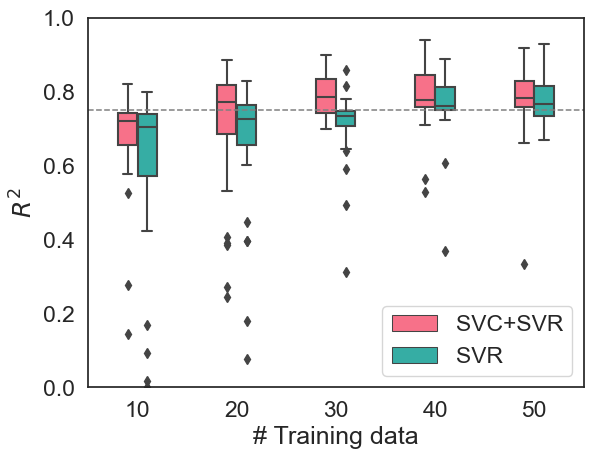

In [74]:
TFTFB = ComparisonResultsPlot([complexSVRR2Lists_TFTFB, SVRR2Lists_TFTFB], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

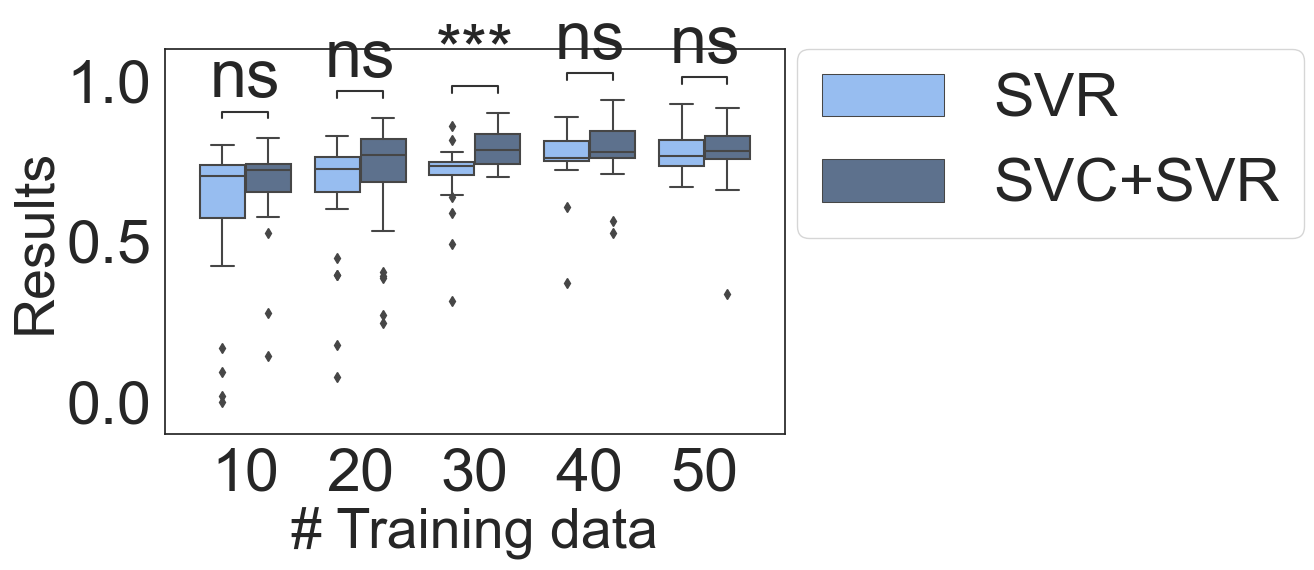

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

In [75]:
statsPlot(TFTFB)

here 0.0


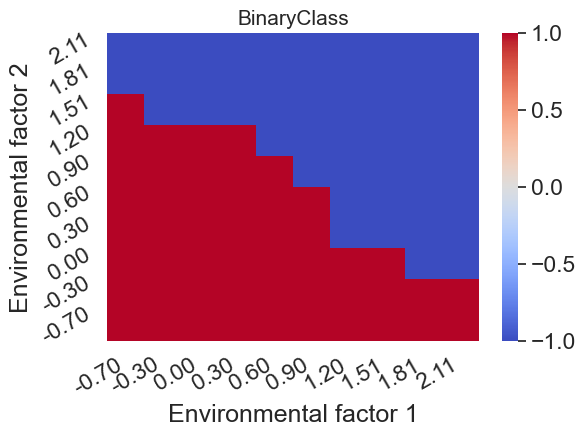

In [56]:
h = processExcelFormat02('HelenaExpDAHBCLA.xlsx', 'Sheet1', 0.5)
heatmapGenerator(h, 'BinaryClass')

here 0.03382976190476192


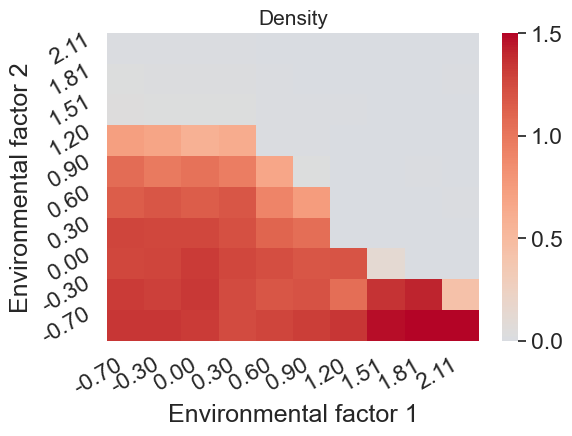

In [57]:
heatmapGenerator(h)

In [76]:
complexSVRSpearmanLists_DAHBCLA, complexSVRPearsonLists_DAHBCLA, complexSVRR2Lists_DAHBCLA, complexSVRMSELists_DAHBCLA, \
complexPredictedSVRSpearmanLists_DAHBCLA, complexPredictedSVRPearsonLists_DAHBCLA, complexPredictedSVRR2Lists_DAHBCLA, \
complexPredictedSVRMSELists_DAHBCLA, \
r2Recorder_DAHBCLA, mseRecorder_DAHBCLA, pearsonRecorder_DAHBCLA, spearmanRecorder_DAHBCLA, \
SVRSpearmanLists_DAHBCLA, SVRPearsonLists_DAHBCLA, SVRR2Lists_DAHBCLA, SVRMSELists_DAHBCLA, \
PredictedSVRSpearmanLists_DAHBCLA, PredictedSVRPearsonLists_DAHBCLA, PredictedSVRR2Lists_DAHBCLA, \
PredictedSVRMSELists_DAHBCLA, \
SVRr2Recorder_DAHBCLA, SVRmseRecorder_DAHBCLA, SVRpearsonRecorder_DAHBCLA, SVRspearmanRecorder_DAHBCLA,\
indexRecorder_DAHBCLA, TrainXDFRecorder_DAHBCLA, TrainYDFRecorder_DAHBCLA, \
SVMSVRFullXDFRecorder_DAHBCLA, SVMSVRFullYDFRecorder_DAHBCLA, scXRecorder_DAHBCLA, \
scDensityRecorder_DAHBCLA, scDistanceRecorder_DAHBCLA = \
ComparisonMultipleRun(30, 'HelenaExpDAHBCLA.xlsx',  2, 'Sheet1', [10,20,30,40,50], 0, ['poly', 'rbf'], 0.5)

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma='auto')
R2:  0.968319720219938
MSE:  0.08447944374633914
Pearson:  0.9840323776278592
Spearman:  1.0
R2:  0.9820001374315185
MSE:  0.04448202083364102
Pearson:  0.9909592006896745
Spearman:  1.0
R2:  0.9994288627079269
MSE:  6.819702692747408
Pearson:  0.9997143905675894
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7326176345737464, 0.14857252594328377, 0.8701480977670579, 0.7782442276824298]
SVR:  [0.7090202375049771, 0.15156585571768977, 0.8420333945307495, 0.7476231633535004]
SVC(C=1000.0, degree=2, gamma=0.01)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1824.6410474  -2171.1517892  -1371.69279948            nan
            nan            nan  -724.13845708            nan
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan -2158.78982829            nan -1823.81029986
            nan -1254.12601444            nan            nan
            nan -2170.86912655]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-454223.87727189    -938.02270493              nan              nan
   -1265.46141178              nan              nan              nan
              nan   -2170.89793534]
  category=UserWa

R2:  0.7852033832290884
MSE:  0.2873651707556208
Pearson:  0.8861170256964302
Spearman:  1.0
R2:  0.6744957754736667
MSE:  0.13543815167943973
Pearson:  0.8212769176554682
Spearman:  1.0
R2:  0.7290525233854076
MSE:  0.11877151900736575
Pearson:  0.8538457257522624
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.04910645074269353, 0.10032382037620143, 0.8501695476853934, 0.8381034695641437]
SVR:  [0.6065166878445166, 0.1397076334183197, 0.7787918129028559, 0.8105774375437296]
SVC(C=0.01, gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.52600084         nan -0.48753537 -0.28426971 -0.56854742  0.52121908
  0.52111245 -0.21239689 -0.56911275         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.56867506 -0.56975932         nan  0.52643905 -0.53484642 -0.45607118
         nan -0.47611843  0.52110956 -0.56918072]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.86499674e-01             nan  5.29441366e-01             nan
 -1.64255515e+04 -5.68904712e-01 -5.65815548e-01             nan
             nan -3.95676053e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.8510831943305672
MSE:  0.09498732656235698
Pearson:  0.9225417033015729
Spearman:  1.0
R2:  0.8511178211400037
MSE:  0.09491328594758792
Pearson:  0.9225604701806837
Spearman:  1.0
R2:  0.8530808636961047
MSE:  0.09270403342608306
Pearson:  0.9236237673945515
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7384191061654533, 0.1171351694058729, 0.828362941647856, 0.7783759311849199]
SVR:  [0.01055546676604126, 0.14786999982341112, 0.10273980127507189, 0.20617360167921964]
SVC(C=10.0, degree=4, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.99582464e-01 -9.69424498e+00             nan -1.28315745e+00
 -3.05927071e-01 -2.90154967e-01 -3.08701129e-01             nan
 -3.00003679e-01 -1.96347081e+04]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-13.90502069          nan          nan  -0.30883747 -13.90494373
  -0.30858686          nan  -0.41060898  -0.40646648  -1.06622162]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.30875392 -0.4067225  -0.4067225   0.59116473 -0.30884038 -0.21011532
 -0.23503195 -0.30512546 -0.4106292          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

R2:  0.19676814411988505
MSE:  0.1123277721070589
Pearson:  0.4435855544535744
Spearman:  0.5
R2:  0.10887878187847672
MSE:  0.11587127225679485
Pearson:  0.3299678497649076
Spearman:  0.5
R2:  0.9498808266813695
MSE:  0.012378071800017565
Pearson:  0.9746182979409781
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.28851418e+03 -5.15297256e+03 -1.20182323e+06 -5.15297256e+03
             nan             nan -1.54812918e+03 -1.05638305e+03
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan  -107.97328486 -1010.34301375 -1056.38532009
  -118.37382926  -143.19573122  -144.07676008            nan
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but 

SVM:  [0.2751567859603174, 0.5158375617271193, 0.3493859408535812, 0.5522410174095567]
SVR:  [0.002482976443334819, 0.4931908408160974, 0.8419943482806268, 0.5480429682676873]
SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.8834478923443535
MSE:  0.2512678200070526
Pearson:  0.93991908819023
Spearman:  0.5
R2:  0.5652315135476031
MSE:  0.20560313535815403
Pearson:  0.7518188036672155
Spearman:  0.5
R2:  0.8639694117134562
MSE:  0.13717520198384614
Pearson:  0.9294995490657626
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7559634323194901, 0.3057775206335288, 0.8083965961433055, 0.5751093459642495]
SVR:  [0.5751742906312785, 0.15765504014762094, 0.7584024595366751, 0.7957114047001687]
SVC(degree=5, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.24459657  -0.54036278          nan          nan  -0.5492097
  -2.7281619  -65.25871033  -0.4556543           nan  -0.54036274]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.54920078 -9.50172319 -0.10804816 -0.54441543 -0.54436018
 -0.46179846 -3.54814115         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are no

R2:  0.9999652392980584
MSE:  0.5629995051351793
Pearson:  -0.9999826194979884
Spearman:  -0.8660254037844387
R2:  0.9864479588513251
MSE:  0.41113605190644237
Pearson:  0.993200865309392
Spearman:  0.5
R2:  0.977248678324596
MSE:  0.03679309787145671
Pearson:  0.9885588896593851
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7594774913836283, 0.12917117434759312, 0.866568059053808, 0.8272543935465282]
SVR:  [0.3760655422822382, 0.41150947104978025, 0.6132418301797737, 0.6270979956373214]
SVC(C=100.0, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.56874922 -0.40569735 -0.41647322 -0.24488976 -5.84322519 -0.42088292
 -0.40571348 -0.39731172 -0.41831748         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.40569561         nan -2.67567606 -0.42097845 -6.08354491 -0.39642491
 -5.71592764 -0.23986374 -0.40571337         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.00844438 -1.23506412 -0.41997353         nan  0.18302133 -0.76243545
 -0.42099376         nan         nan -1.34855711]
  category=UserWarning,


R2:  0.9497088091499191
MSE:  0.8382733066115011
Pearson:  0.9745300452781942
Spearman:  1.0
R2:  0.9506015406340659
MSE:  0.8522271807961318
Pearson:  0.974987969481709
Spearman:  1.0
R2:  0.9993832995487909
MSE:  0.34276323262158065
Pearson:  0.9996916022198001
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.024515642808435968, 0.09533391441141104, 0.8758855850684173, 0.8445404782483433]
SVR:  [0.6200115417187045, 0.6029636570562241, 0.7874081163657793, 0.8248014158126517]
SVC(C=10000.0, degree=4, gamma=10.0, kernel='poly')
R2:  0.6603483210258392
MSE:  1.2875780253778386
Pearson:  0.8126181889582828
Spearman:  0.8660254037844387
R2:  0.001320715325546876
MSE:  0.06305178338684604
Pearson:  -0.03634164725967816
Spearman:  -0.5
R2:  0.4194948552962897
MSE:  0.3209236661864682
Pearson:  0.6476842249864433
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.34751588e+00 -7.10379245e+04 -1.02049390e+00             nan
             nan -1.01670586e+00 -9.19269432e-01 -1.41841138e+00
             nan -1.03168431e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.15207939e+06 -5.62771590e-01 -8.95292220e-01 -4.15180580e+06
 -8.64120967e-01 -6.53730455e-01  6.14856648e-01 -9.46604915e-01
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.09357169 -0.47580593 -1.01131321  0.29304691  0.37425809 -1.03386859
  0.08433461         nan -0.87109473 -0.86689526]
  category=UserWarning,
/Users/ychha/anaconda3/l

SVM:  [0.505685293058163, 1.2174244768640359, 0.7880956082105239, 0.8271720788574721]
SVR:  [0.7336421409160051, 0.09733476270075146, 0.8565291243828226, 0.8251636004444993]
SVC(C=100.0, gamma=0.01)
R2:  0.7962882920322609
MSE:  0.07638032608773938
Pearson:  0.892349870864708
Spearman:  1.0
R2:  0.26689580653794986
MSE:  0.25463808286475115
Pearson:  0.5166195955806843
Spearman:  0.5
R2:  nan
MSE:  0.3626344427845392
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.6878746121494573, 0.09704532062958944, 0.6812566307737199, 0.7868543441577149]
SVR:  [0.5701625773939962, 0.2817467425542067, 0.7550911053601388, 0.6383273137048048]
SVC(C=100.0, degree=4)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.85836763  -5.81163546  -0.92738722  -0.92737947          nan
          nan  -6.08846316 -54.81182887          nan  -4.32588347]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.8583443   -5.33361507          nan          nan -88.19815772
          nan          nan  -6.09580605  -5.7059223   -5.67066299]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.68438751         nan         nan  0.19462276  0.02060605 -6.04945599
 -6.08067188 -0.85125385 -1.42732677 -0.38620664]
  category=UserWarning,


R2:  0.9047477093663939
MSE:  0.1542963180411118
Pearson:  0.9511822692661979
Spearman:  1.0
R2:  0.9768867792595876
MSE:  0.2602552373134686
Pearson:  0.9883758289535348
Spearman:  1.0
R2:  0.7704389315310567
MSE:  0.15231735395432344
Pearson:  0.8777465075584503
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.36197457   -4.91105623   -6.14663091 -384.134073             nan
  -40.74139061   -5.55902766           nan  -21.42614312 -397.28712202]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/ana

SVM:  [0.5684392903200759, 0.13041355887616932, 0.5901852750867752, 0.6249907395974811]
SVR:  [0.6032119219057599, 0.17617171043393853, 0.7766671886372952, 0.8185454994443758]
SVC(C=1000.0, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-566.8244398            nan  -22.83254809  -15.85476386           nan
  -22.95376249  -22.95697404  -21.17974744  -21.17976644           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.00293913e+03 -2.91101294e+01 -5.72284472e-01 -9.49645012e+00
 -1.04045675e+00 -1.42962612e+01             nan -1.50804877e+01
 -1.27134588e+04 -2.28342496e+01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.03724955 -196.73705902  -21.18186776  -21.18287815   -1.03147425
  -22.58663728   -0.39085145           nan -177.50423545  -21.15918003]
  category=UserWarning,
/Users/ychha/anaconda3/li

R2:  0.5209004804281536
MSE:  0.01556015040803898
Pearson:  0.7217343558596565
Spearman:  0.5
R2:  0.5447554646945619
MSE:  0.016255647576046316
Pearson:  0.7380755142223334
Spearman:  0.5
R2:  0.5439258790474374
MSE:  0.018362420057285486
Pearson:  0.7375133077087067
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7046007095620281, 0.18387215928024403, 0.5874959604925507, 0.841774704696053]
SVR:  [0.7021703922835234, 0.1754806971900546, 0.837956080163825, 0.8434045355393668]
SVC(C=10000.0, degree=5, gamma='auto', kernel='poly')
R2:  0.43091344464457154
MSE:  0.4708414911225742
Pearson:  -0.6564399779451062
Spearman:  -1.0
R2:  0.15120237670347292
MSE:  0.21368824324028482
Pearson:  -0.3888474980033598
Spearman:  -0.5
R2:  0.9861645470598494
MSE:  0.2644855513854372
Pearson:  -0.9930581790911592
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.70890548e+02 -9.58827342e+00             nan -1.52014048e+02
 -1.55975278e+02 -1.03098217e+06 -1.56708108e+02 -1.65107466e+02
 -1.64951397e+01 -1.71290213e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -41.3916541  -169.54683021 -170.9372286            nan  -70.51400531
 -170.7577549            nan -153.39497892  -42.70162692  -79.02360765]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-170.42849732 -201.63695259           nan -170.44512321           nan
           nan  -11.28375026  -44.01070719  -47.60895655 -104.17616501]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.11758558296832111, 1.2749709382604482, 0.3726487165720617, 0.09440671687862699]
SVR:  [0.4054846220315227, 0.3468660046898237, 0.6367767442609087, 0.8126188418323249]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.9519156361610002
MSE:  0.022591970653876914
Pearson:  0.9756616402016633
Spearman:  1.0
R2:  0.9558329559346977
MSE:  0.022024357998715733
Pearson:  0.9776670987277304
Spearman:  1.0
R2:  0.11881278201167039
MSE:  0.2843795265661005
Pearson:  0.34469230048214083
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.730017201323201, 1.2834148899929156, 0.7484578286915774, 0.6170885294480799]
SVR:  [0.48246458916344637, 0.21429235900577145, 0.6945967097269077, 0.5720953204099272]
SVC(C=1000.0, gamma=0.0001)
R2:  0.7375626797356486
MSE:  0.14041215486616201
Pearson:  0.8588146946435237
Spearman:  0.5
R2:  0.7935442671876652
MSE:  0.11172930635073818
Pearson:  0.8908110165392349
Spearman:  0.5
R2:  0.9626717189910151
MSE:  0.09615683731878656
Pearson:  0.9811583557158422
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7295393244873227, 0.10417116729616348, 0.8606162356994107, 0.8458410503354322]
SVR:  [0.7295867208951651, 0.10141077022502477, 0.854158486988899, 0.8407210766761328]
SVC(gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.82444146 -1.90381593 -3.24715455         nan         nan -3.08343921
         nan -3.24678302 -0.70147904         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.10741987e+02 -9.71303630e-01 -6.43253036e+00             nan
 -3.24715454e+00 -3.23964527e+00 -3.24677569e+00 -3.24715075e+00
 -3.12962637e+00 -7.48650517e-02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -3.12236684 -3.24715231 -2.95159353         nan -5.02454583
 -3.22518115 -3.20310771 -3.24715193         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.9979065180108398
MSE:  0.00400129572562054
Pearson:  0.998952710597874
Spearman:  1.0
R2:  0.9270357131568427
MSE:  0.08626940225493344
Pearson:  0.962826938321131
Spearman:  0.5
R2:  0.9962718753173935
MSE:  0.272301485590616
Pearson:  0.9981341970483698
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7095451189384898, 0.17817555046588782, 0.8035059572821414, 0.7430958554554059]
SVR:  [0.6240335666805624, 0.16936256675726305, 0.7899579524763092, 0.8264641725315882]
SVC(C=1000.0, degree=2, gamma='auto')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -6.83212803e+02 -5.32429155e-01             nan
             nan -2.04724075e+00             nan -1.76794030e+02
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -5.58199825e+03
             nan -2.96104026e-01 -4.40140617e+01 -9.58873227e-01
             nan -5.39916121e-01]
  category=UserWarning,


R2:  0.0036730104213637516
MSE:  0.5422918636096424
Pearson:  -0.060605366275303996
Spearman:  -0.5
R2:  0.0027698645282001806
MSE:  0.5400256857218898
Pearson:  -0.052629502450623505
Spearman:  -0.5
R2:  0.014986745212899506
MSE:  0.5125001200149623
Pearson:  0.12242036273798365
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -694.36743101           nan           nan  -91.86556821
           nan   -2.20392099   -1.66251259           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.79646658e+02 -6.22247708e+03 -5.30723230e-01 -6.10521780e-01
 -1.35375262e+03             nan -4.40360174e+01 -4.79523287e-01
 -6.63737835e+02             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fit

SVM:  [0.5963787762775649, 0.6695349763147634, 0.7170292844846304, 0.7563649833312753]
SVR:  [0.5547790947728044, 0.6769005969565196, 0.7448349446506952, 0.7542906531670577]
SVC(C=10000.0, gamma='auto', kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.07257822e-01 -2.82798892e-01             nan -2.69416974e+02
 -3.99112160e-01 -4.11874039e-01 -3.57488202e-01 -4.12445253e-01
 -4.19230851e-01 -2.78091369e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.28279739  0.14678765  0.09135862 -0.41998122 -0.32711657 -0.41168777
 -0.4207359   0.08340674 -0.41320575         nan]
  category=UserWarning,


R2:  0.9988987955336742
MSE:  0.7078260326231621
Pearson:  0.9994492461019089
Spearman:  1.0
R2:  0.9972332414982515
MSE:  0.20111221203649524
Pearson:  0.9986156625540439
Spearman:  1.0
R2:  0.9561370514222207
MSE:  0.47561208223111384
Pearson:  0.9778226073384787
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  0.73199654  -0.4207359   -0.41232831  -7.43903999  -0.41188724
 -14.1119126   -1.33459282  -0.32399488          nan  -0.28352849]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib

SVM:  [0.6028891399286749, 0.12312122739788665, 0.7762492147806312, 0.6172696217640038]
SVR:  [0.7003403788952206, 0.6102978040782376, 0.8368634171089208, 0.8500720253529241]
SVC(C=0.1, gamma=0.01)
R2:  0.9989708050102111
MSE:  0.07549744697985894
Pearson:  0.9994852700316352
Spearman:  1.0
R2:  0.9927972141716388
MSE:  0.26316522588330177
Pearson:  0.996392098609598
Spearman:  0.5
R2:  0.9988543386664593
MSE:  0.007930799563981638
Pearson:  0.9994270051716931
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7347385613226999, 0.10105540224536927, 0.8569916023430978, 0.8421204263900893]
SVR:  [0.7277331249078379, 0.10714571120893357, 0.8530727547564965, 0.8485080462608552]
SVC(C=100.0, degree=4, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-14.45866808  -9.52018201          nan -47.71770513  -9.52018201
 -44.07206335 -15.31596853 -13.35001321 -14.45866808 -30.97221319]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan -15.73012225          nan
 -14.25066486          nan -49.12052656 -44.06899713 -13.946324  ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-47.71759843 -46.40641988 -47.71716914          nan -16.18066686
 -24.28981025 -44.02297412 -44.04634045  -8.70255791          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

R2:  0.45229949709543693
MSE:  0.21319770762147638
Pearson:  0.6725321532056567
Spearman:  0.5
R2:  0.9636445847546722
MSE:  0.01971557346925305
Pearson:  0.9816540046037974
Spearman:  0.5
R2:  0.9683600957741583
MSE:  0.048432970706803496
Pearson:  0.9840528927726182
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6043336028623931, 0.5939958853694101, 0.8328279409994361, 0.8311231839321725]
SVR:  [0.5780157175323184, 0.15276874068748583, 0.7602734491828046, 0.8166522615960817]
SVC(C=1000.0, degree=5)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -2.50366150e+04  1.88253355e-01 -1.14724451e+00
 -2.09512514e+00 -2.10189925e+00 -2.02227248e+00 -2.07865410e+00
 -1.69232469e+00  1.77947672e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -2.67439331 -1.1334725  -2.31183368 -2.29902242 -2.11113291
 -2.3105503          nan -2.3118324  -0.73782292]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.60981579 -2.31180622 -1.14405907 -2.28201917 -2.10102524         nan
 -4.39076913         nan -1.80481109 -2.09716529]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.2688951730454293
MSE:  0.304772774382513
Pearson:  0.5185510322479644
Spearman:  0.5
R2:  0.10917918258546816
MSE:  0.4827515080333548
Pearson:  0.33042273315476967
Spearman:  -0.5
R2:  0.9936536748366779
MSE:  0.10068205429856696
Pearson:  0.9968217868990816
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-155780.12145419  -18944.42209059 -162126.15172529 -162128.28176717
 -160087.95171625 -109277.71512819 -130338.84137847              nan
 -135044.74693691              nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-9.73261596e+04 -7.09700679e+04             nan -1.5181

SVM:  [0.7897256682097282, 0.0741887172702944, 0.8837603773955283, 0.7562168168909743]
SVR:  [0.7325272894527372, 0.1345200249558946, 0.8558780809512164, 0.7657159320080668]
SVC(C=100.0, degree=4, gamma=1.0, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.2321675229670891
MSE:  2.2178386805420502
Pearson:  -0.48183765208531504
Spearman:  0.5
R2:  0.5415993378938689
MSE:  0.4033958740657388
Pearson:  0.7359343298786032
Spearman:  0.5
R2:  0.9770194801383678
MSE:  0.455618766386757
Pearson:  0.9884429574529668
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2640478667708145, 0.24293048224308064, 0.8563066452226474, 0.7707042021648763]
SVR:  [0.595658301777822, 0.22071752779375922, 0.7717890267280445, 0.6190476190476191]
SVC(C=10000.0, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan -23.44296195  -3.88980754          nan
          nan          nan          nan          nan -23.44296195]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -2.13519623e+01             nan             nan
             nan -1.16355744e+03             nan -4.20768654e+05
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan   -23.44003154            nan            nan
 -2546.03042512    -9.01907834            nan   -27.4739846
   -26.29087726            nan]
  category=UserWarning,
/Users/ychha/anaconda3/li

R2:  0.14244497513051815
MSE:  0.05907715026425569
Pearson:  0.37741883250643204
Spearman:  0.5
R2:  0.28370586671205444
MSE:  0.058660970269467254
Pearson:  0.5326404666489907
Spearman:  1.0
R2:  0.32491017618308016
MSE:  0.05837151785262662
Pearson:  0.5700089264064909
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -3.49791692  -40.34648635  -93.69368583   -1.88538556   -3.1941443
  -16.33427841 -806.28894185  -17.49565511   -1.65917377           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.87468547e+01 -1.56462933e+01 -1.52236398e+03 -3.49742462e+00
 -5.36426415e+01 -2.437

SVM:  [0.4604102517563085, 272588.923626583, 0.6759642360593543, 0.7931596493394245]
SVR:  [0.44971334401639085, 0.7011241643479836, 0.6706066984577408, 0.7051817096760917]
SVC(C=10000.0, gamma=0.1)
R2:  0.8648769927865634
MSE:  0.3769592067346365
Pearson:  0.929987630448149
Spearman:  0.5
R2:  0.18461797642321826
MSE:  0.6256581756841395
Pearson:  -0.42967194046530216
Spearman:  -0.5
R2:  0.996741923707635
MSE:  0.2530926916608149
Pearson:  0.9983696328052224
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.34710493223779804, 0.9915918732496992, 0.9139386655951273, 0.9009918920031279]
SVR:  [0.07998016787239859, 0.3562709761640694, 0.28280765172179945, 0.3040234885684842]
SVC(gamma=0.01)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.0505752  -0.1801142  -0.17527349         nan -3.99043949         nan
 -0.17527349 -0.18021925         nan -0.18021862]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.63363493e-01 -8.84004001e-02 -1.79863872e-01 -1.80218961e-01
 -1.62292511e-01 -7.28652368e+03  1.87584747e-01             nan
             nan -1.80218930e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  0.19040758  -0.18015273          nan  -1.56014364          nan
  -0.18022065  -6.12969346 -11.86873946  -0.1166901           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

R2:  0.8302496829337295
MSE:  0.2957526356428264
Pearson:  0.9111803789227078
Spearman:  1.0
R2:  0.8086666303424034
MSE:  0.12145824738712041
Pearson:  0.8992589339797539
Spearman:  1.0
R2:  0.8508816278374238
MSE:  0.1005282365217754
Pearson:  0.9224324516393729
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [              nan               nan -6860650.09968495               nan
               nan -1924592.66780259               nan -2812208.21781879
               nan               nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.08931584e+09             nan             nan -1.94253958e+06
 -1.96293436e+06 -1.95027414e+06 -1.25213530e+05 -1.24929813e+05
 -1.25217827e+05 -5.16854506e+03]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarn

SVM:  [0.6893452428584097, 0.12034164534602342, 0.8582753099269516, 0.8194838868996173]
SVR:  [0.6501665809752079, 0.35247657390589493, 0.8600989979308998, 0.8194838868996173]
SVC(C=100.0, degree=5)
R2:  0.8990224576735386
MSE:  0.051889359499060296
Pearson:  0.9481679480311169
Spearman:  1.0
R2:  nan
MSE:  0.3520617594932947
Pearson:  nan
Spearman:  nan
R2:  0.9492487503198018
MSE:  0.07270225788750215
Pearson:  0.9742939753071462
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted wit

SVM:  [0.39945948092309186, 0.29813956166961625, 0.7221296565755181, 0.6761740132526649]
SVR:  [0.7430632489602588, 0.27160244548012186, 0.8620111652178637, 0.8143639132403178]
SVC(C=100.0, degree=2, gamma=0.01)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -449.5672955   -433.21928868            nan -1413.49443449
            nan            nan            nan            nan
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan  -510.37561986 -1046.99138039  -392.27335169
  -416.09155026  -613.44926912  -449.77829435            nan
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan    -407.06845656              nan    -449.81882854
  -23617.66174409    -449.31515474              nan    -553.1392047
              nan -326584.49105719]
  category=UserWar

R2:  0.34797188000396195
MSE:  0.2426224538215823
Pearson:  0.5898914137398186
Spearman:  1.0
R2:  0.5923159208359546
MSE:  0.1064670940576145
Pearson:  0.7696206343621216
Spearman:  1.0
R2:  0.5250133821354789
MSE:  0.3393481544656984
Pearson:  0.7245780718014304
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan  -11502.01739121   -5723.01405309 -744309.77460992
    -963.52504858 -156759.77545186   -5878.98012273  -25882.69431985
              nan    -763.70649544]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.64648226e+03 -7.44307574e+05 -1.60171664e+05        

SVM:  [0.6388480798442626, 0.6758390476995114, 0.855646141626788, 0.7636745277194715]
SVR:  [0.639576876169408, 0.6846051238472477, 0.7997355038820069, 0.8239453430464666]
SVC(degree=4)
R2:  0.9970112888598928
MSE:  16169.929271476145
Pearson:  -0.9985045262090166
Spearman:  -1.0
R2:  0.9929191709149995
MSE:  0.04933440358338248
Pearson:  0.9964532959025222
Spearman:  1.0
R2:  0.7081288408247602
MSE:  0.0036633591476326493
Pearson:  0.841503916107798
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.48407120589471403, 0.17825444760066889, 0.7279722984451009, 0.7087468979954784]
SVR:  [0.617932495447644, 0.18305298342166493, 0.7860868243697026, 0.7295797835123677]
SVC(C=10000.0, gamma='auto')
R2:  0.999451636518244
MSE:  0.008584427568393758
Pearson:  0.999725780660999
Spearman:  1.0
R2:  0.9996938641043946
MSE:  0.04311001408173517
Pearson:  0.9998469203355054
Spearman:  1.0
R2:  0.9999903516630511
MSE:  0.006580573327042535
Pearson:  0.9999951758198892
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6534501988961978, 0.1269681363829524, 0.8113137949530849, 0.8441947565543071]
SVR:  [0.7167801624466346, 0.11140473012592304, 0.8466287040058558, 0.8474708811787462]
SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.9986510376252841
MSE:  148.23463772787284
Pearson:  0.9993252911966573
Spearman:  0.8660254037844387
R2:  0.998724985541024
MSE:  0.13515741322548178
Pearson:  0.9993622894331284
Spearman:  1.0
R2:  0.996397085397542
MSE:  0.3886871614874048
Pearson:  0.9981969171448798
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -622.38500569 -791.23661256 -473.61690917 -620.52237829
 -791.2695889  -589.34341176           nan           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -763.49766807            nan            nan            nan
            nan  -177.9220016             nan  -791.18364884
 -3710.61028304  -386.76927656]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -791.23964028  -317.03661338 -1380.47053865  -593.33494362
            nan            nan            nan            nan
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/l

SVM:  [0.3618445545986546, 0.22447744988123206, 0.8757370960487485, 0.7865580112771124]
SVR:  [0.7651711499079655, 0.17270449831872325, 0.874740618645302, 0.7998271391529819]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.7490196010846609
MSE:  0.1860501151665698
Pearson:  0.8654591851061844
Spearman:  0.5
R2:  0.09280069958806803
MSE:  0.29802824395751315
Pearson:  0.30463207248756335
Spearman:  -0.5
R2:  0.9854403649429364
MSE:  0.03530000487753767
Pearson:  0.9926934899267431
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7894132068614271, 0.05837581178002662, 0.888505019404279, 0.835979750586492]
SVR:  [0.6371569832553273, 0.15174120706761388, 0.7982211368131817, 0.7083590566736634]
20
SVC(C=10000.0, gamma=0.1)
R2:  0.6805143265135953
MSE:  0.03695587551531437
Pearson:  0.8249329224328454
Spearman:  1.0
R2:  0.6335250969069798
MSE:  0.06417724004683245
Pearson:  0.79594289801906
Spearman:  0.39999999999999997
R2:  0.9895663437805914
MSE:  0.09120634968847954
Pearson:  0.9947694927874453
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6490471004604385, 0.08976947384717286, 0.8586736941864472, 0.809845288326301]
SVR:  [0.7552945968720689, 0.4900513604871076, 0.8690768647663276, 0.8206985466479139]
SVC(C=0.1, degree=2, gamma=1.0)
R2:  0.8833822402905189
MSE:  0.02071767452644693
Pearson:  0.9398841632299795
Spearman:  0.7999999999999999
R2:  0.8763845233837617
MSE:  0.025022395347334477
Pearson:  0.9361541130517785
Spearman:  0.7999999999999999
R2:  0.7390771494716851
MSE:  0.20177004485471156
Pearson:  0.8596959633915268
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5296588736066239, 0.10616455986819531, 0.9448955076040352, 0.6853258321612752]
SVR:  [0.7098413980776894, 0.10057903501428751, 0.8425208591350664, 0.8036099390529771]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.5835497757480227
MSE:  0.08670830694790362
Pearson:  -0.7639042975059263
Spearman:  -0.7999999999999999
R2:  0.5903393434905769
MSE:  0.06642730079602797
Pearson:  -0.7683354368311905
Spearman:  -0.7999999999999999
R2:  0.4061464094849775
MSE:  0.011376500211342082
Pearson:  0.6372961709323048
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.01941829022555238, 0.7257776807250045, 0.31695294861837126, 0.6068221821082772]
SVR:  [0.6211558446103761, 0.18287138656125176, 0.788134407706183, 0.7781059540553212]
SVC(C=10000.0, gamma='auto')
R2:  0.4779152316830977
MSE:  0.1606120526332707
Pearson:  0.6913141338661446
Spearman:  0.7999999999999999
R2:  0.6779259853486681
MSE:  0.1449845532014684
Pearson:  0.8233626086656282
Spearman:  0.7999999999999999
R2:  0.7384006291924571
MSE:  0.15140288895086573
Pearson:  0.8593024084642478
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8414955614704255, 0.059651576230058935, 0.9478542180985696, 0.6872011251758088]
SVR:  [0.3254989576078148, 0.2698297351813542, 0.5705251594871297, 0.5259962494139709]
SVC(degree=4, gamma=0.1)
R2:  0.20789260862241835
MSE:  0.12942117786290086
Pearson:  -0.4559524192527311
Spearman:  -0.39999999999999997
R2:  0.03312994351978413
MSE:  0.06489358694145989
Pearson:  -0.18201632761866204
Spearman:  -0.19999999999999998
R2:  0.032133076302160606
MSE:  0.08459177896828715
Pearson:  -0.17925701186330362
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7871421412684737, 0.21555427921508924, 0.8878766164956358, 0.8130098452883263]
SVR:  [0.8664282694675908, 0.05050932790127473, 0.9308212876098133, 0.8589310829817159]
SVC(C=0.01, degree=4, gamma=0.001)
R2:  0.1605302099600961
MSE:  1.0760202763360496
Pearson:  0.40066221429041204
Spearman:  0.39999999999999997
R2:  0.6797399214246157
MSE:  1.0553396085397233
Pearson:  0.8244634142426307
Spearman:  1.0
R2:  0.6899277561414647
MSE:  1.0375022822764304
Pearson:  0.8306188994607965
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7351323235223346, 0.0629781378941858, 0.8399898316234227, 0.7704875761837788]
SVR:  [0.7421883470616032, 0.46132503595240354, 0.8615035386239585, 0.8124706985466479]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.9700530835100207
MSE:  0.6535503567666803
Pearson:  0.9849127288800876
Spearman:  0.6000000000000001
R2:  nan
MSE:  0.6510268223391975
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.921865446626498
MSE:  0.6305306296199767
Pearson:  0.9601382434975175
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.12434806804746039, 0.13198646242887832, 0.8326738294738338, 0.6170182841068917]
SVR:  [0.6143609143584772, 0.6596333772333691, 0.7838117850341858, 0.81657290201594]
SVC(C=100.0, gamma=0.1)
R2:  0.19289477764334434
MSE:  0.7929304264625013
Pearson:  0.43919787982564806
Spearman:  0.19999999999999998
R2:  0.6265840682486961
MSE:  0.8557929862156456
Pearson:  -0.7915706337710463
Spearman:  -1.0
R2:  0.5871037483290855
MSE:  0.7684776842379576
Pearson:  0.76622695614882
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3838560576989602, 0.6929749095760268, 0.8555380990163866, 0.8242850445382092]
SVR:  [0.5116275161132409, 0.6555749357513208, 0.7152814244150628, 0.7496015002344116]
SVC(C=0.01, degree=5, gamma=0.01)
R2:  0.009885725076337731
MSE:  0.2546548819314403
Pearson:  -0.09942698364296149
Spearman:  -0.7999999999999999
R2:  0.009655177373752264
MSE:  0.25436057555515984
Pearson:  -0.09826076212686458
Spearman:  -0.7999999999999999
R2:  0.02192845705296182
MSE:  0.28682066059975475
Pearson:  -0.14808260212787258
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38581728266854587, 0.16445338587840386, 0.9211164766258066, 0.8401312705110173]
SVR:  [0.7377385829601942, 0.11148288986358898, 0.8589170990032707, 0.8401312705110173]
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.003951564275889979
MSE:  0.0035336779194381743
Pearson:  0.06286146892882777
Spearman:  0.6000000000000001
R2:  0.08918046986532302
MSE:  0.003410679282576797
Pearson:  0.29863099280771754
Spearman:  0.6000000000000001
R2:  0.07422461459901107
MSE:  0.0030741980546152617
Pearson:  0.2724419472089624
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7670330623523665, 0.11268720105136783, 0.8392409851706395, 0.8772151898734177]
SVR:  [0.6200512690622298, 0.7166289587893712, 0.7874333426152528, 0.8266057196436944]
SVC(C=10000.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.9443441598988843
MSE:  0.11832608842237308
Pearson:  0.9717737184647897
Spearman:  0.6000000000000001
R2:  0.7811520142293779
MSE:  0.09295353769449544
Pearson:  0.8838280456227772
Spearman:  0.7999999999999999
R2:  0.9590821664591682
MSE:  0.1068870057144784
Pearson:  0.9793274051404712
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6120774888182564, 0.1242917116024714, 0.8400279133481391, 0.7325363338021567]
SVR:  [0.7520350438544761, 0.11311267465145276, 0.8671995409676345, 0.812611345522738]
SVC(C=1000.0, degree=4, gamma=0.0001)
R2:  0.9038500734529583
MSE:  0.13787782993196107
Pearson:  0.950710299435616
Spearman:  1.0
R2:  0.9134289690875899
MSE:  0.0872713296008499
Pearson:  0.9557347796787505
Spearman:  1.0
R2:  0.9050920153696974
MSE:  0.11959160500058243
Pearson:  0.9513632404973913
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7355265154662829, 0.21338780317348105, 0.8605386464656659, 0.8790904828879513]
SVR:  [0.7045892390244833, 0.11266050994595778, 0.8393981409465254, 0.8746366619784343]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.4523402632391673
MSE:  0.27024361950735243
Pearson:  0.6725624604742426
Spearman:  0.39999999999999997
R2:  0.4454601648085211
MSE:  0.16037240570412023
Pearson:  0.6674280221930459
Spearman:  0.39999999999999997
R2:  0.6153287171261436
MSE:  0.10327908718641873
Pearson:  0.784428911454788
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7036761752952789, 0.10029638343328226, 0.8406214598031956, 0.7089779653070792]
SVR:  [0.7294375169298765, 0.10985092682296509, 0.8540711427801997, 0.7911626816690108]
SVC(C=10.0, degree=2, gamma=0.01)
R2:  0.47350165798475186
MSE:  0.42903707413729775
Pearson:  0.68811456748477
Spearman:  0.7999999999999999
R2:  0.47360724508196006
MSE:  0.42599042336124926
Pearson:  0.6881912852412185
Spearman:  0.7999999999999999
R2:  0.3832493291741242
MSE:  0.44409630236721664
Pearson:  0.6190713441713518
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6982132382779224, 0.11335375386701832, 0.8773919881282827, 0.7880684481950305]
SVR:  [0.7034022846175615, 0.11616813223165043, 0.8386908158657528, 0.7880684481950305]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.9978087916839307
MSE:  0.023439564090218416
Pearson:  0.9989037950092743
Spearman:  1.0
R2:  0.5430731609712904
MSE:  0.0785164546887269
Pearson:  0.7369349774378267
Spearman:  0.7999999999999999
R2:  0.9611439251840449
MSE:  0.0339513741898823
Pearson:  0.9803794801932793
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7447712933933192, 0.09660919037539425, 0.86550791466905, 0.8339428035630567]
SVR:  [0.7491025499878288, 0.09658196638126886, 0.8655071056830378, 0.8217065166432255]
SVC(C=10000.0, degree=5)
R2:  0.7383680643041547
MSE:  0.19358617834125927
Pearson:  0.8592834598106465
Spearman:  0.7999999999999999
R2:  0.9169193167137822
MSE:  0.06485139334528425
Pearson:  0.9575590408501098
Spearman:  0.7999999999999999
R2:  0.9166325133887896
MSE:  0.06510165085014491
Pearson:  0.9574092716225334
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5931685843999788, 0.08493413180563196, 0.8733126636896725, 0.6610642287857478]
SVR:  [0.5606608955646128, 0.16822726812190653, 0.7487729265702741, 0.6674636661978435]
SVC(C=1000.0, degree=5)
R2:  0.7163388532392505
MSE:  0.6844187006481477
Pearson:  0.8463680365179505
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


R2:  0.7320967221968336
MSE:  0.6824306034244323
Pearson:  0.8556265085870318
Spearman:  0.7999999999999999
R2:  0.8880576951423166
MSE:  0.6350863504894979
Pearson:  0.942368131433951
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8662099231019857, 0.05722689301482177, 0.8712021588058725, 0.7999531176746367]
SVR:  [0.7049736346855812, 0.6476954589770447, 0.8396270807242823, 0.8598218471636194]
SVC(C=10000.0, gamma=0.1, kernel='poly')
R2:  0.318574042849514
MSE:  0.39571573437323504
Pearson:  0.5644236377487339
Spearman:  0.39999999999999997
R2:  0.31748209784387493
MSE:  0.3972218760287213
Pearson:  0.5634554976605295
Spearman:  0.39999999999999997
R2:  0.3473614877586507
MSE:  0.3345820730720824
Pearson:  0.5893738098682795
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6548213387752001, 0.10955796066027088, 0.848295757245173, 0.7928270042194093]
SVR:  [0.7559587292929549, 0.10295088246172361, 0.8694588715361732, 0.7928270042194093]
SVC(degree=4, gamma='auto')
R2:  0.5638981931592932
MSE:  0.10879832959355246
Pearson:  0.750931550248951
Spearman:  0.7999999999999999
R2:  0.22772296098608927
MSE:  0.13585383079726734
Pearson:  0.4772032700915714
Spearman:  0.7999999999999999
R2:  0.025074026099257324
MSE:  0.17068837380842047
Pearson:  0.1583478010559582
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7498206340180236, 0.15384752820811046, 0.8896578958493904, 0.7180262541022034]
SVR:  [0.7474336069364204, 0.15402031097277785, 0.8645424263368573, 0.7940693858415377]
SVC(C=10000.0, degree=5, gamma=0.0001)
R2:  0.7436034749389783
MSE:  0.14022138290613542
Pearson:  0.8623244603622111
Spearman:  1.0
R2:  0.5419551767081939
MSE:  0.4136334688028259
Pearson:  0.7361760500778287
Spearman:  1.0
R2:  0.8772220745112012
MSE:  0.10476330788620013
Pearson:  0.9366013423603456
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8734437260536609, 0.05145369712418617, 0.863555223831767, 0.8385607126113456]
SVR:  [0.8583506299225442, 0.052167062949934985, 0.9264721420110504, 0.8796530707923114]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.9476123921731443
MSE:  0.8364596754051499
Pearson:  0.9734538469661231
Spearman:  0.7999999999999999
R2:  0.7001333390773001
MSE:  0.8335223087404815
Pearson:  -0.836739708079699
Spearman:  -0.39999999999999997
R2:  0.8613639739841606
MSE:  0.8133780930965753
Pearson:  0.9280969636757577
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6796576156481041, 0.6861171450948218, 0.7820456711042243, 0.7722691045475857]
SVR:  [0.6960100547140953, 0.679553763711421, 0.8342721706458247, 0.8455696202531645]
SVC(C=1000.0, degree=4, gamma=0.0001)
R2:  0.9849456283127249
MSE:  0.2552364096552107
Pearson:  0.992444269625617
Spearman:  1.0
R2:  0.6439787357931868
MSE:  0.11798809958783943
Pearson:  0.8024828570089123
Spearman:  0.39999999999999997
R2:  0.6420398157603882
MSE:  0.07190351936101902
Pearson:  0.8012738706337478
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7332530598566834, 0.10259745379425338, 0.9104420933134698, 0.8414674167838724]
SVR:  [0.7325771300046321, 0.10393542755367643, 0.8559071970749116, 0.8123300515705579]
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.9616836241426022
MSE:  0.09080360346178212
Pearson:  0.9806546915926126
Spearman:  1.0
R2:  0.9626209294357164
MSE:  0.08942641144235045
Pearson:  0.98113247292897
Spearman:  1.0
R2:  0.6732600838318439
MSE:  0.4298100550045868
Pearson:  0.8205242737615044
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8268338537766041, 0.05666108690436863, 0.9022204422767233, 0.743834974214721]
SVR:  [0.6842174194282268, 0.3106306890526537, 0.8271743585413099, 0.7341068917018284]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.45033841960925214
MSE:  0.313127126747521
Pearson:  0.6710725889270489
Spearman:  0.7999999999999999
R2:  0.48080370559184094
MSE:  0.272583830760024
Pearson:  0.6934001049840134
Spearman:  1.0
R2:  0.40094286250628075
MSE:  0.2330325635637449
Pearson:  0.6332004915556213
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7899934413859666, 0.24461217001991659, 0.6747666488107159, 0.60014064697609]
SVR:  [0.7720180928218427, 0.22702895035621964, 0.8786456013785323, 0.8306844819503048]
SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.6059465545451047
MSE:  0.15201228554274998
Pearson:  0.7784256898028898
Spearman:  0.7999999999999999
R2:  0.481942810843752
MSE:  0.24609162460129871
Pearson:  0.6942210100852264
Spearman:  0.39999999999999997
R2:  0.9520615085493492
MSE:  0.03240567008767528
Pearson:  0.9757363929614131
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.28744166241890196, 0.6752778464568854, 0.8553044344751557, 0.8548523206751056]
SVR:  [0.854381553455252, 0.058217726136473455, 0.9243276223586809, 0.8491795593061418]
SVC(degree=4)
R2:  nan
MSE:  0.387321179829671
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.9628876456754638
MSE:  0.010083036396601856
Pearson:  0.9812683861591915
Spearman:  0.39999999999999997
R2:  0.9704873639222822
MSE:  0.00886314323575813
Pearson:  0.9851331706537357
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7841595529572916, 0.09151559276972213, 0.884409787672753, 0.7970464135021098]
SVR:  [0.73996942660172, 0.09790174738426327, 0.8602147560939184, 0.74845288326301]
SVC(C=0.01, degree=5, gamma=0.0001, kernel='poly')
R2:  0.7473465516671935
MSE:  0.15950844530315308
Pearson:  0.8644920772726571
Spearman:  0.6000000000000001
R2:  0.914199049806867
MSE:  0.13238698033481228
Pearson:  0.9561375684528177
Spearman:  0.7999999999999999
R2:  0.9606261906424549
MSE:  0.17626167470687965
Pearson:  0.980115396594939
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6075992064073074, 0.12766534221769177, 0.9154040237314545, 0.8345522737927802]
SVR:  [0.5610538455741414, 0.1685997334160782, 0.7490352765885868, 0.7467579478229491]
SVC(C=10.0, degree=5)
R2:  0.6799023639610361
MSE:  0.2102390357741781
Pearson:  0.824561922454
Spearman:  0.39999999999999997
R2:  0.9159367404391973
MSE:  0.21078962619246622
Pearson:  0.9570458403019144
Spearman:  0.7999999999999999
R2:  0.9103544832941244
MSE:  0.21719269518930173
Pearson:  0.9541249830573164
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.846785033171643, 0.05500855966416231, 0.9202092333657838, 0.826699484294421]
SVR:  [0.5870296613566516, 0.15227679956138893, 0.7661786093050705, 0.7130567276136898]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.9693610816288246
MSE:  0.23041380722278998
Pearson:  0.9845613650904778
Spearman:  0.7999999999999999
R2:  0.945859829316238
MSE:  0.16071541849365573
Pearson:  0.9725532526891459
Spearman:  0.7999999999999999
R2:  0.9572899940504075
MSE:  0.2557052761782545
Pearson:  0.9784119756270397
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5199010131908353, 0.32536659014370495, -0.4492949473718021, 0.7447960618846695]
SVR:  [0.7784555431857386, 0.08128252007408265, 0.8823012768809411, 0.8446319737458978]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.17682180589173546
MSE:  0.001936956672745404
Pearson:  -0.42050185004555624
Spearman:  -0.19999999999999998
R2:  0.8434967035475832
MSE:  0.0038519948202579654
Pearson:  0.9184207660694432
Spearman:  0.7999999999999999
R2:  0.11934358502377773
MSE:  0.00018201078256091692
Pearson:  -0.3454614088777179
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3873147084338605, 0.690664330044753, 0.8392788339352839, 0.6284106891701828]
SVR:  [0.0658687208044783, 0.69213914309431, -0.25664902260573375, -0.1130098452883263]
30
SVC(degree=2, gamma=0.01)
R2:  0.8811232925193414
MSE:  0.04969445762364553
Pearson:  0.9386816779501672
Spearman:  0.942857142857143
R2:  0.7820167695901385
MSE:  0.10041391531500686
Pearson:  0.8843171204891027
Spearman:  0.942857142857143
R2:  0.8264226841851383
MSE:  0.073785198061577
Pearson:  0.9090779307546403
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.725060626532563, 0.12292960047829651, 0.5576098936275493, 0.7761175750153092]
SVR:  [0.7249675215800198, 0.12297112423251325, 0.8514502460978088, 0.7727232962995364]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.5030589505653615
MSE:  0.1900676357117571
Pearson:  0.709266487693703
Spearman:  0.942857142857143
R2:  0.6339930867346262
MSE:  0.10163322772311835
Pearson:  0.7962368282958446
Spearman:  0.942857142857143
R2:  0.8891075745087726
MSE:  0.04098725372007103
Pearson:  0.9429250100134011
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9074154112929216, 0.1124886303731301, 0.9540105791503082, 0.863459014959321]
SVR:  [0.8602896814808194, 0.06766966485546189, 0.9275180221865339, 0.8392091680517889]
SVC(C=100.0, degree=5, kernel='poly')
R2:  0.9163303763380711
MSE:  0.055621417938149766
Pearson:  0.9572514697497575
Spearman:  0.942857142857143
R2:  0.9118651845246347
MSE:  0.38471379335034744
Pearson:  0.9549163233103908
Spearman:  0.8857142857142858
R2:  0.8452749303729314
MSE:  0.26194756771994826
Pearson:  0.9193883457891616
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7224602248543172, 0.12581852824620862, 0.890195726705893, 0.8236374770361299]
SVR:  [0.7462583233242358, 0.10228582601589402, 0.863862444677528, 0.7329367509404251]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.8304198283619239
MSE:  0.049631684281670106
Pearson:  0.9112737395327067
Spearman:  0.8857142857142858
R2:  0.9668482329219276
MSE:  0.009931162514832993
Pearson:  0.983284411003209
Spearman:  0.942857142857143
R2:  0.9509734029998348
MSE:  0.02017307421890734
Pearson:  0.9751786518376181
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8222055806662236, 0.16202654757550153, 0.906545671542965, 0.7661446942524713]
SVR:  [0.622702228774406, 0.1605443523794025, 0.7891148387746909, 0.7181348963345289]
SVC(C=100.0, degree=2, gamma=10.0)
R2:  0.005949021061592375
MSE:  0.3761892479489297
Pearson:  0.07712989732647368
Spearman:  0.3142857142857143
R2:  0.6943510641369078
MSE:  0.37581512166306935
Pearson:  0.8332773032651903
Spearman:  0.4285714285714286
R2:  0.9066291179782896
MSE:  0.03875265836223767
Pearson:  0.952170739929709
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.03153996684749772, 1.150003722504046, 0.8063348683858825, 0.7388504942699677]
SVR:  [0.6672716824097962, 0.6795226387224799, 0.8168669918718692, 0.8414486921529174]
SVC(degree=4, gamma=10.0)
R2:  0.28945181698841793
MSE:  0.27796814666918274
Pearson:  0.5380072648100745
Spearman:  0.2571428571428572
R2:  0.9217978817563736
MSE:  0.038496478560304866
Pearson:  0.960103057883045
Spearman:  0.7714285714285715
R2:  0.9292996501583545
MSE:  0.05477697102932847
Pearson:  0.9640018932338019
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6976340591630156, 0.2124017544794665, 0.8905797749119336, 0.8544659259907268]
SVR:  [0.6092948972265387, 0.15169190335789237, 0.7805734412766926, 0.8110751465313619]
SVC(gamma=0.1)
R2:  0.8254814146625057
MSE:  0.06722542468273386
Pearson:  0.9085600776297105
Spearman:  0.8285714285714287
R2:  0.9101864372687548
MSE:  0.042484301020113156
Pearson:  0.9540369160932688
Spearman:  1.0
R2:  0.9412829276755178
MSE:  0.019477251801112167
Pearson:  0.9701973653208494
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6903490006169332, 0.10512051672930205, 0.8397498237576401, 0.8246872539585337]
SVR:  [0.713393939535822, 0.09729914759612887, 0.8446265088995386, 0.8287113988277491]
SVC()
R2:  0.9341232544561199
MSE:  0.08224903190901349
Pearson:  0.9665005196357217
Spearman:  0.942857142857143
R2:  0.9572265951025795
MSE:  0.2395450392611983
Pearson:  0.978379576188393
Spearman:  1.0
R2:  0.8838804243306735
MSE:  0.05551595950387354
Pearson:  0.9401491500451796
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7998442562199306, 0.08198222500186485, 0.8930636000525423, 0.8648937100866065]
SVR:  [0.2137087135065382, 0.31086486668266494, 0.46228639770875585, 0.47815589187297697]
SVC(kernel='poly')
R2:  0.9462628053807737
MSE:  0.04329460266628291
Pearson:  0.9727604049203349
Spearman:  1.0
R2:  0.37269111488549495
MSE:  0.2973674795256603
Pearson:  0.6104843281243957
Spearman:  0.6571428571428573
R2:  0.8970002719638898
MSE:  0.2074271162133394
Pearson:  0.9471009829811654
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7505235042390537, 0.1259278121378344, 0.8338355385210952, 0.818178637039629]
SVR:  [0.6530570739860709, 0.6163935528734393, 0.808119467644525, 0.8213736473228618]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.9089540598920796
MSE:  0.02826932656397202
Pearson:  0.9533908222193456
Spearman:  0.8285714285714287
R2:  0.8492629873739839
MSE:  0.18167370003128033
Pearson:  0.9215546578331555
Spearman:  0.7142857142857143
R2:  0.9156267903931563
MSE:  0.02728249276119643
Pearson:  0.9568838959838109
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7417715803008845, 0.08796693891170246, 0.8124029780990061, 0.7866503368034292]
SVR:  [0.742374512712501, 0.14842074626545207, 0.8616115787943548, 0.787385180649112]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly')
R2:  0.970235293192026
MSE:  0.012525953969327057
Pearson:  0.9850052249567135
Spearman:  0.7714285714285715
R2:  0.9313289967555292
MSE:  0.3620489129425355
Pearson:  0.9650538828249589
Spearman:  0.7714285714285715
R2:  0.8207175331060902
MSE:  0.07821953876965129
Pearson:  0.9059346185603518
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7540214978201145, 0.07399010898821623, 0.87030200645785, 0.8147843583238562]
SVR:  [0.5188510491914257, 0.21497137392640184, 0.720313160501338, 0.801738671637364]
SVC(C=1000.0, degree=5, gamma=0.001)
R2:  0.8740538334143054
MSE:  0.09942188863568256
Pearson:  0.9349084625856723
Spearman:  1.0
R2:  0.8752225509192879
MSE:  0.06800238238095552
Pearson:  0.935533297600512
Spearman:  1.0
R2:  0.8945280995703634
MSE:  0.06155079559324536
Pearson:  0.9457949564098783
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7658025323146257, 0.1026555595209256, 0.8751017837585697, 0.77370308809378]
SVR:  [0.7591872176736635, 0.09646989877363855, 0.8713135013723037, 0.7548071034905082]
SVC(C=100.0, degree=4, gamma='auto')
R2:  0.0445247042090866
MSE:  0.2865885138642661
Pearson:  0.21100877756407818
Spearman:  -0.2571428571428572
R2:  0.15822163252601087
MSE:  0.2846258360720127
Pearson:  0.3977708291541888
Spearman:  -0.14285714285714288
R2:  0.3912593377421343
MSE:  0.1261737219930963
Pearson:  0.6255072643400189
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7338657322001833, 0.13212379617296377, 0.8607714874621637, 0.8479923016359024]
SVR:  [0.7206625199331463, 0.13329397468307722, 0.8489184412728625, 0.825037179599335]
SVC(C=10000.0, kernel='poly')
R2:  0.2994911590879349
MSE:  0.37821450191060496
Pearson:  0.5472578542953358
Spearman:  0.08571428571428573
R2:  0.21572272807701479
MSE:  0.5255595321124064
Pearson:  0.4644596086604462
Spearman:  0.08571428571428573
R2:  0.3481212313273834
MSE:  0.29096878271324905
Pearson:  0.5900179923759812
Spearman:  0.2571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7201042386924459, 0.10259698047788156, 0.8933455332941997, 0.8379494357449043]
SVR:  [0.7067325286241127, 0.13810613975001848, 0.8406738538958575, 0.78948473449392]
SVC(gamma='auto')
R2:  0.8065408004197002
MSE:  0.1256459401279068
Pearson:  0.8980761662685963
Spearman:  0.8285714285714287
R2:  0.9064265118545132
MSE:  0.175009574717124
Pearson:  0.9520643422870713
Spearman:  0.8285714285714287
R2:  0.8852019679450628
MSE:  0.04480497431169967
Pearson:  0.9408517247393784
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7488289403190894, 0.051317179882788846, 0.9343872483882611, 0.8069110314058263]
SVR:  [0.6680924284815583, 0.17710932590529924, 0.8173692118507756, 0.7448342227276704]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.8078604259440846
MSE:  0.3987939600934212
Pearson:  0.8988105617670971
Spearman:  0.7142857142857143
R2:  0.9348389755839905
MSE:  0.3991615102451013
Pearson:  0.9668707129621781
Spearman:  0.7142857142857143
R2:  0.8762228913033276
MSE:  0.4000818278899629
Pearson:  0.9360677813616533
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7667840887346189, 0.2661514346596047, 0.46363922685688874, 0.8718922229026332]
SVR:  [0.04457269236760642, 0.7537624063389893, 0.2111224582265147, 0.644230600997288]
SVC(degree=4, gamma=0.1, kernel='poly')
R2:  0.6213262239815376
MSE:  0.07928473632839299
Pearson:  0.7882424905963503
Spearman:  0.7714285714285715
R2:  0.40843007099292106
MSE:  0.32520828622580494
Pearson:  0.639085339366286
Spearman:  0.7714285714285715
R2:  0.42022819679967327
MSE:  0.24109421267860343
Pearson:  0.6482501035863188
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8292250500573736, 0.1014903148857188, 0.8662528110295669, 0.7691540547633627]
SVR:  [0.7597126957714736, 0.12051567430709871, 0.8716149928560624, 0.7788120024494795]
SVC(degree=5, gamma=0.1)
R2:  0.9654643918261274
MSE:  0.06640837955664348
Pearson:  0.9825804760049568
Spearman:  1.0
R2:  0.9560477829706612
MSE:  0.08218618983441221
Pearson:  0.9777769597258168
Spearman:  1.0
R2:  0.9563887417617727
MSE:  0.04761166811711958
Pearson:  0.9779512982566017
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7348567225840105, 0.07736575534395297, 0.8841900359744218, 0.8396990639489108]
SVR:  [0.7640205158137083, 0.08745741776760185, 0.8740826710407364, 0.8307409675443969]
SVC(C=10000.0, degree=5, gamma='auto')
R2:  0.9165837703255801
MSE:  0.04024496915644299
Pearson:  0.957383815575331
Spearman:  0.942857142857143
R2:  0.9913236182224551
MSE:  0.0037834082264291756
Pearson:  0.9956523581162526
Spearman:  0.8857142857142858
R2:  0.9946288838640645
MSE:  0.001985140973878952
Pearson:  0.9973108261039103
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6379405219391784, 0.12530406614764675, 0.8081744516588728, 0.5438019420873065]
SVR:  [0.6053713696680845, 0.19729457340692402, 0.778056148146189, 0.696579476861167]
SVC(C=100.0, gamma='auto')
R2:  0.2672338861199896
MSE:  0.09633587446873892
Pearson:  -0.516946695627305
Spearman:  -0.5428571428571429
R2:  0.26060713830230703
MSE:  0.03990469282085185
Pearson:  -0.5104969522948272
Spearman:  -0.6
R2:  0.34975731140884475
MSE:  0.012064729613777136
Pearson:  -0.5914028334467503
Spearman:  -0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4791447645546673, 0.284080905520576, 0.37640921873136224, 0.7343014609395504]
SVR:  [0.4889948409632754, 0.2185218809655584, 0.6992816606799265, 0.74738867990552]
SVC(C=100.0, degree=5)
R2:  0.3270606344163224
MSE:  0.19532602384353248
Pearson:  0.5718921527843537
Spearman:  0.3142857142857143
R2:  0.764592145952667
MSE:  0.07325144615236433
Pearson:  0.8744095985021362
Spearman:  0.2571428571428572
R2:  0.9152077606165017
MSE:  0.018501239840552842
Pearson:  0.9566649155354774
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.872522915370004, 0.03345197477605901, 0.934089488347223, 0.847117487533899]
SVR:  [0.6271895549475107, 0.1504546210295788, 0.7919530004662592, 0.6993788819875776]
SVC(C=100.0, gamma=0.1)
R2:  0.20751138837775904
MSE:  0.08522134360251156
Pearson:  0.455534179154275
Spearman:  -0.2571428571428572
R2:  0.5350044695235573
MSE:  0.04787226911767009
Pearson:  0.7314399972134129
Spearman:  0.08571428571428573
R2:  0.5257781768668269
MSE:  0.04829740995629164
Pearson:  0.7251056315233162
Spearman:  0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8175043089342434, 0.06363857133094816, 0.8836670197455032, 0.8693377657247836]
SVR:  [0.7361215456015666, 0.11355652660869803, 0.8579752593178701, 0.8480622867640627]
SVC(C=100.0, gamma=0.1)
R2:  0.7803236610542607
MSE:  0.5168809749676467
Pearson:  0.8833593046174704
Spearman:  0.48571428571428577
R2:  0.7814537191908206
MSE:  0.5034050692689016
Pearson:  0.8839987099486177
Spearman:  0.48571428571428577
R2:  0.8301042939381629
MSE:  0.48788365629406644
Pearson:  0.9111005948511737
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8680004283479029, 0.14315117311537398, 0.85960506541698, 0.8465576065086169]
SVR:  [0.3582586582998407, 0.6988647970446744, 0.5985471228732464, 0.5935271870128234]
SVC(degree=5)
R2:  0.411146218199581
MSE:  0.5744368295467025
Pearson:  -0.6412068450972596
Spearman:  -0.7714285714285715
R2:  0.8991509406379516
MSE:  0.04106708221413625
Pearson:  0.9482356988839598
Spearman:  0.8857142857142858
R2:  0.6890871935934096
MSE:  0.10650187827172701
Pearson:  0.8301127595654759
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.851803440307451, 0.07596388553801647, 0.9167253885452724, 0.8164640013997027]
SVR:  [0.8481578013994925, 0.053059843698496506, 0.9209548313568329, 0.851036654710874]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.8974980041807817
MSE:  0.06168298390013274
Pearson:  0.9473637127211393
Spearman:  0.7142857142857143
R2:  0.8948775328856239
MSE:  0.07110767948456677
Pearson:  0.945979668325712
Spearman:  0.7142857142857143
R2:  0.8427286668318852
MSE:  0.04877443563321951
Pearson:  0.9180025418439127
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.31949438255787177, 0.11020331065866776, 0.800596809134878, 0.8075758901233487]
SVR:  [0.6308833460446208, 0.1330951898210547, 0.7942816541030147, 0.8093605108914357]
SVC(C=0.01, gamma=0.001)
R2:  0.9322986649231015
MSE:  0.03870158827548004
Pearson:  0.9655561428125767
Spearman:  0.8285714285714287
R2:  0.4367849779854571
MSE:  0.18514649154647186
Pearson:  0.660897100905623
Spearman:  0.8285714285714287
R2:  0.9227431673517478
MSE:  0.11026271250769722
Pearson:  0.9605952151409809
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6786318643023164, 0.25047565355360396, 0.832801953389231, 0.7802117050126848]
SVR:  [0.6782465739932587, 0.11615478452848582, 0.8235572681928438, 0.7719884524538535]
SVC(C=10000.0)
R2:  0.8571152581199759
MSE:  0.0714332417179138
Pearson:  0.9258051944766654
Spearman:  0.7714285714285715
R2:  0.841579908623581
MSE:  0.06431242816881333
Pearson:  0.9173766449085025
Spearman:  0.6
R2:  0.8600903357490559
MSE:  0.05408240766644942
Pearson:  0.9274105540423057
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.852152634197352, 0.31776477978970463, 0.9108568131871264, 0.9000962295512203]
SVR:  [0.19991366963706758, 0.3238386829322417, 0.4471170648019012, 0.47924485387936444]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.6826989037720961
MSE:  0.5967552118171074
Pearson:  0.8262559553625595
Spearman:  0.8857142857142858
R2:  0.5178174263336458
MSE:  0.6783295559094027
Pearson:  0.71959532122829
Spearman:  0.6571428571428573
R2:  0.8072129817325583
MSE:  0.4184571693125789
Pearson:  0.8984503223509681
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [9.045084390782114e-33, 0.7123796626603233, 0.8668969879682563, 0.773948036042341]
SVR:  [0.6317108537650293, 0.7049594956875935, 0.794802399194309, 0.8069460239699064]
SVC(degree=2, gamma='auto')
R2:  0.8537611913250445
MSE:  0.1543785394981626
Pearson:  0.9239919866130032
Spearman:  0.7714285714285715
R2:  0.8669685682218946
MSE:  0.07477095133917966
Pearson:  0.9311114692784611
Spearman:  0.7714285714285715
R2:  0.8629035453393766
MSE:  0.08398303791021645
Pearson:  0.9289260171506537
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8109263472383426, 0.06317282337053531, 0.9005144902989313, 0.8497769224039892]
SVR:  [0.7001576955900353, 0.10690256745771251, 0.8367542623674142, 0.8710873939287901]
SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.6909144730036306
MSE:  0.24915450670336778
Pearson:  0.8312126520954972
Spearman:  0.942857142857143
R2:  0.6659785420379087
MSE:  0.18950391678253153
Pearson:  0.816075083578655
Spearman:  0.942857142857143
R2:  0.8385229353574917
MSE:  0.07236581884808634
Pearson:  0.9157089796204311
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8105187056105699, 0.03401363661610381, 0.9163531488112671, 0.8157641501180998]
SVR:  [0.7804559182620935, 0.08659810558967353, 0.8834341618151822, 0.8107252208905608]
40
SVC(degree=2)
R2:  0.8144846473541013
MSE:  0.08777584506853818
Pearson:  0.9024880316957677
Spearman:  0.7142857142857144
R2:  0.9853147590410688
MSE:  0.007184169245630489
Pearson:  0.9926302227118962
Spearman:  0.9523809523809524
R2:  0.9530144794168747
MSE:  0.021485236931001336
Pearson:  0.9762246050048493
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2845039295541709, 0.1031037608571433, 0.8392013007232002, 0.7151430953042514]
SVR:  [0.5847872271009553, 0.1489688440611486, 0.7647138203935872, 0.6814670741872744]
SVC(C=1000.0, degree=5, gamma=1.0)
R2:  0.6612426171919648
MSE:  0.14955256044984827
Pearson:  0.813168258844358
Spearman:  0.6190476190476191
R2:  0.665231302639814
MSE:  0.15018091866574518
Pearson:  0.8156171299327976
Spearman:  0.6190476190476191
R2:  0.8016761494848281
MSE:  0.08361795686435489
Pearson:  0.8953636967650789
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8786917267779177, 0.04682799474230199, 0.9373836649075681, 0.8158933036954712]
SVR:  [0.7403232637863665, 0.13492294489282677, 0.8604203994480639, 0.7921644901361491]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.691040305198824
MSE:  0.11789428015393821
Pearson:  0.8312883405887659
Spearman:  0.9285714285714287
R2:  0.928978037804713
MSE:  0.052683922283726446
Pearson:  0.963835067739659
Spearman:  0.9047619047619048
R2:  0.7387677488481709
MSE:  0.09823922733423296
Pearson:  0.8595159968541424
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8490989226966406, 0.09722216539444338, 0.8738064829727986, 0.7882745207001945]
SVR:  [0.7536371244486758, 0.09539174879571129, 0.8681227588588349, 0.829341483745485]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.8336237275005457
MSE:  0.48601865794277144
Pearson:  0.9130299707570092
Spearman:  0.9285714285714287
R2:  0.7694257880501537
MSE:  0.6468904837119628
Pearson:  0.877169190093994
Spearman:  0.880952380952381
R2:  0.9376865935019179
MSE:  0.6075360196363063
Pearson:  0.9683421882278587
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7370334529414201, 0.09757933739981552, 0.8587184726149646, 0.8663517643789944]
SVR:  [0.5654194091767611, 0.7311036956007613, 0.7519437539981036, 0.7816615726590721]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.6430844768811504
MSE:  0.109328131717561
Pearson:  0.8019254808778372
Spearman:  0.7142857142857144
R2:  0.5983977387035314
MSE:  0.13115729455913744
Pearson:  0.7735617226204587
Spearman:  0.7857142857142858
R2:  0.7560403146248612
MSE:  0.07633832454478537
Pearson:  0.8695057875741031
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8721674567248042, 0.07503667441951833, 0.8797803179925996, 0.8344540150041679]
SVR:  [0.7450229572528235, 0.144192681818953, 0.8631471237586463, 0.826618505140317]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.5010030229412215
MSE:  0.1522905950623207
Pearson:  0.7078156701721302
Spearman:  0.7380952380952381
R2:  0.499679523912302
MSE:  0.15556345538472688
Pearson:  0.706880134048413
Spearman:  0.7380952380952381
R2:  0.835109093043152
MSE:  0.0615777383427435
Pearson:  0.9138430352326116
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7960312465041074, 0.12352926860529125, 0.8151452271523709, 0.8095026396221174]
SVR:  [0.710458576605037, 0.11237783211060949, 0.8428870485450806, 0.8306196165601558]
SVC(degree=5, gamma='auto')
R2:  0.8401071860807648
MSE:  0.07245268984594422
Pearson:  0.9165736119269223
Spearman:  0.7380952380952381
R2:  0.8400627503906617
MSE:  0.07247242516906638
Pearson:  0.9165493714965176
Spearman:  0.7380952380952381
R2:  0.8832956778319373
MSE:  0.04758287147845583
Pearson:  0.9398381125661681
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8368142260144383, 0.044494267461480365, 0.9379383723919753, 0.822839677688247]
SVR:  [0.7351314294703801, 0.09823993409673062, 0.857398057771523, 0.7782717421505976]
SVC(degree=4, gamma=1.0)
R2:  0.7674258352415175
MSE:  0.1205919981090528
Pearson:  0.8760284443107523
Spearman:  0.880952380952381
R2:  0.7666106093482987
MSE:  0.09405923380738636
Pearson:  0.8755630242011703
Spearman:  0.9761904761904763
R2:  0.6780988135277578
MSE:  0.13313571002707117
Pearson:  0.8234675546296635
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.774431291783492, 0.14661876764011003, 0.8923065551079122, 0.7096971380939151]
SVR:  [0.5640221620851101, 0.17876297172532843, 0.7510140891388857, 0.6186162823006391]
SVC(C=100.0, degree=5, gamma=1.0)
R2:  0.3673077296636387
MSE:  0.29844913210245966
Pearson:  0.6060591800011272
Spearman:  0.8571428571428572
R2:  0.6883777880925981
MSE:  0.1299082905194836
Pearson:  0.8296853548741225
Spearman:  0.7142857142857144
R2:  0.6995428564388024
MSE:  0.1235216670687359
Pearson:  0.8363867863846264
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9234094160859507, 0.05703618762688018, 0.9327298747281292, 0.7796054459572105]
SVR:  [0.862497290575387, 0.051402047380945774, 0.9287073223440134, 0.7470408446790776]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.09449469726976716
MSE:  0.8170008616246165
Pearson:  0.3073998979664228
Spearman:  0.3333333333333334
R2:  0.2089686542050408
MSE:  0.8243039775656273
Pearson:  0.4571308939516567
Spearman:  0.29940656547831473
R2:  0.061214979509857895
MSE:  0.8335788643648964
Pearson:  -0.24741661122458586
Spearman:  0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7965003617664661, 0.12700091139497652, 0.8715719206663424, 0.874909697138094]
SVR:  [0.8027720883340096, 0.6679136426528179, 0.8959754953870167, 0.8931925534870798]
SVC(degree=4, gamma=1.0)
R2:  0.8292422910183566
MSE:  0.04736637497356061
Pearson:  0.9106274161359063
Spearman:  0.880952380952381
R2:  0.7481126360596287
MSE:  0.08734861608927029
Pearson:  0.8649350473068071
Spearman:  0.9523809523809524
R2:  0.7485257031647056
MSE:  0.0883188416764052
Pearson:  0.8651737993979622
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46519123247541533, 0.047906594001636965, 0.8826949429282971, 0.8390664073353712]
SVR:  [0.7787546951181356, 0.10815665907849908, 0.8824707899517898, 0.8613503751041959]
SVC(gamma='auto')
R2:  0.8879165749779101
MSE:  0.06013891252470343
Pearson:  0.9422932531743559
Spearman:  0.9047619047619048
R2:  0.7705333655602893
MSE:  0.09687215502793772
Pearson:  0.8778002993621554
Spearman:  0.880952380952381
R2:  0.9105551188615463
MSE:  0.055795067420486975
Pearson:  0.9542301183999313
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.912213330845446, 0.02967279435617711, 0.9550770483091621, 0.8632953598221731]
SVR:  [0.8310346851298125, 0.06439418480153516, 0.911611038288706, 0.8632953598221731]
SVC(C=10000.0, kernel='poly')
R2:  0.373800218684425
MSE:  0.29949254695112193
Pearson:  0.6113920335467458
Spearman:  0.5952380952380953
R2:  0.42644726298290614
MSE:  0.3123536761305305
Pearson:  0.6530292971857437
Spearman:  0.5952380952380953
R2:  0.29026191139067037
MSE:  0.25891884313770347
Pearson:  0.5387596044532943
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7936551733550529, 0.16233091473218605, 0.8412877397187595, 0.7503195332036678]
SVR:  [0.8924273093515461, 0.04080829787838917, 0.9446837086303257, 0.8108919144206725]
SVC(C=1000.0, degree=2, gamma=1.0)
R2:  0.46352655752586325
MSE:  0.15202544195311274
Pearson:  0.6808278472021126
Spearman:  0.19047619047619052
R2:  0.5978307305036188
MSE:  0.17228179380348754
Pearson:  0.7731951438696564
Spearman:  0.30952380952380953
R2:  0.9897268410234944
MSE:  0.004116857779387863
Pearson:  0.994850160086178
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8784128486573116, 0.03402081489752178, 0.8866522461481089, 0.8585718255070856]
SVR:  [0.7518727122361647, 0.1107172614951302, 0.8671059406071235, 0.8316198944151154]
SVC(C=10.0, degree=5, gamma=10.0)
R2:  0.750054311596344
MSE:  0.09582713905833501
Pearson:  0.8660567600315491
Spearman:  0.8333333333333335
R2:  0.9233088967284797
MSE:  0.02601106323204551
Pearson:  0.9608896381627186
Spearman:  0.8333333333333335
R2:  0.9292015606795198
MSE:  0.02383267115977835
Pearson:  0.9639510157054245
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8559247062786599, 0.1903282901985252, 0.836545112313522, 0.8164490136148932]
SVR:  [0.7451185960982726, 0.11024847367194618, 0.8632025232228375, 0.8237843845512643]
SVC(degree=5, gamma=1.0)
R2:  0.7188234757330255
MSE:  0.8003546936655308
Pearson:  0.8478345804064763
Spearman:  0.5476190476190477
R2:  0.6869544605638068
MSE:  0.799712146062385
Pearson:  0.8288271596441604
Spearman:  0.4761904761904762
R2:  0.8704232950931979
MSE:  0.7992472581000575
Pearson:  0.9329647877027287
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.891714383163267, 0.043551107576505474, 0.9473746125238238, 0.8375104195609894]
SVR:  [0.2991966539628462, 0.7070403266622552, 0.5469887146576666, 0.6086690747429842]
SVC(C=100.0, degree=4)
R2:  0.8322709366485977
MSE:  0.04978653900178624
Pearson:  0.9122888449655613
Spearman:  0.9523809523809524
R2:  0.7842119066765926
MSE:  0.07284186093180109
Pearson:  0.8855573988605101
Spearman:  0.9523809523809524
R2:  0.858881764713209
MSE:  0.049109243752682295
Pearson:  0.9267587413740475
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7732770284141608, 0.10496626835374631, 0.8545767947873694, 0.7408168935815506]
SVR:  [0.6969475171108899, 0.13746862071381827, 0.8348338260461721, 0.7689913864962491]
SVC(degree=4)
R2:  0.9664666907752558
MSE:  0.011748092097655606
Pearson:  0.9830903777248844
Spearman:  0.4285714285714286
R2:  0.8443138207461046
MSE:  0.09605147690031482
Pearson:  0.9188655074308234
Spearman:  0.7619047619047621
R2:  0.9941212195666858
MSE:  0.002004095967995775
Pearson:  0.9970562770308833
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8128695068234802, 0.05372506569097678, 0.893923404343347, 0.8474576271186443]
SVR:  [0.6970457388310757, 0.11381276199823165, 0.8348926510822072, 0.8373992775771049]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.8069399317443648
MSE:  0.13388872971725113
Pearson:  0.8982983534129204
Spearman:  0.38095238095238104
R2:  0.860432129631537
MSE:  0.04603768896891158
Pearson:  0.9275948089718575
Spearman:  0.4285714285714286
R2:  0.8678485690053453
MSE:  0.043538850008229685
Pearson:  0.9315839033631622
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8421312236425276, 0.08239688705477213, 0.8825117771248951, 0.8085579327590999]
SVR:  [0.6728514106952717, 0.134225068416677, 0.8202752042426197, 0.7402056126701864]
SVC(C=1000.0, gamma=10.0, kernel='poly')
R2:  0.6222326686735316
MSE:  0.07642627332046789
Pearson:  0.7888172593659014
Spearman:  0.6190476190476191
R2:  0.8867310599457433
MSE:  0.022894398845852426
Pearson:  0.9416639846281387
Spearman:  0.7380952380952381
R2:  0.674357666680703
MSE:  0.06668182698638733
Pearson:  0.8211928316057702
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.778593154962288, 0.0442386373063106, 0.8113669839733542, 0.8322311753264797]
SVR:  [0.7414586673859259, 0.11933047121749207, 0.8610799425058779, 0.8156154487357601]
SVC(C=10000.0)
R2:  0.6123927888384136
MSE:  0.17844381305320406
Pearson:  0.7825552944287154
Spearman:  0.7380952380952381
R2:  0.8444821340405637
MSE:  0.05396888723105391
Pearson:  0.9189570904240107
Spearman:  0.9523809523809524
R2:  0.8786722744251683
MSE:  0.044187951958818486
Pearson:  0.9373752047206967
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7900353690993792, 0.03834506450237075, 0.8805419435204822, 0.8141706029452627]
SVR:  [0.7128973265396807, 0.10179258631779713, 0.8443324739341018, 0.8300639066407337]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.9070162380993743
MSE:  0.027699161061298577
Pearson:  0.9523740011672799
Spearman:  0.880952380952381
R2:  0.9117810789615923
MSE:  0.02368710607808881
Pearson:  0.9548722841100752
Spearman:  0.9047619047619048
R2:  0.9031822395409365
MSE:  0.0307903015331487
Pearson:  0.9503590056083736
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49766817484410636, 0.1001089415410119, 0.8884065947811637, 0.7336482356210059]
SVR:  [0.6647816721902942, 0.11702166642631315, 0.8153414451567481, 0.7093081411503197]
SVC(C=10.0, degree=4)
R2:  0.7975581395163829
MSE:  0.09676842587576803
Pearson:  0.8930611062611465
Spearman:  0.7380952380952381
R2:  0.7535321388110147
MSE:  0.3558238544022946
Pearson:  0.8680622897068013
Spearman:  0.8333333333333335
R2:  0.9009853653073037
MSE:  0.032925517360654175
Pearson:  0.9492024890966646
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8343369852678517, 0.0571075832205263, 0.9138526166447021, 0.8508474576271188]
SVR:  [0.7416506586706756, 0.08773219320992977, 0.8611914181357566, 0.8263962211725481]
SVC(C=100.0, degree=5, gamma='auto')
R2:  0.7534445538145762
MSE:  0.12830533573359215
Pearson:  0.8680118396741927
Spearman:  0.5714285714285715
R2:  0.9092670149498143
MSE:  0.05108315565883076
Pearson:  0.9535549354650809
Spearman:  0.6190476190476191
R2:  0.9431123186033864
MSE:  0.0680806760304031
Pearson:  0.97113970086872
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8241163939402764, 0.08573015537793557, 0.8876887184598047, 0.8265629341483747]
SVR:  [0.7247700812805316, 0.09991932864351291, 0.8513342946695679, 0.8146151708808004]
SVC(degree=4, gamma=10.0)
R2:  0.9553782122067938
MSE:  0.018336381754831352
Pearson:  0.9774345053285125
Spearman:  0.8333333333333335
R2:  0.8250040313376368
MSE:  0.07921464104017409
Pearson:  0.908297325404868
Spearman:  0.7619047619047621
R2:  0.928193148588842
MSE:  0.03179558590620797
Pearson:  0.9634278118202951
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7918608786681302, 0.12845450424123742, 0.8189998959877823, 0.7987218671853294]
SVR:  [0.6605501073123337, 0.12052529944430503, 0.8127423375906617, 0.7614337315921091]
SVC(C=10.0, degree=2)
R2:  0.594722385785363
MSE:  0.11222144047501316
Pearson:  0.7711824594642718
Spearman:  0.4047619047619048
R2:  0.7445345616668513
MSE:  0.08879135726437594
Pearson:  0.862864161769888
Spearman:  0.4047619047619048
R2:  0.7003715204170865
MSE:  0.08651198594738282
Pearson:  0.836882022997917
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8559423507517492, 0.0546436768947702, 0.9477463919289286, 0.8059460961378163]
SVR:  [0.7484107105645844, 0.20671243315645296, 0.8651073404870544, 0.8416226729647125]
SVC(C=1000.0, degree=2, gamma=10.0)
R2:  0.8882737505325429
MSE:  0.10025952994062447
Pearson:  0.9424827587455075
Spearman:  0.8571428571428572
R2:  0.8793512411179405
MSE:  0.043722159300890885
Pearson:  0.9377372985639102
Spearman:  0.7857142857142858
R2:  0.8707415005705332
MSE:  0.05605236508493628
Pearson:  0.9331353066787973
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8471751101213201, 0.08979086371838413, 0.8771117645128912, 0.8522367324256741]
SVR:  [0.7616757619653405, 0.09144718640568658, 0.8727403748912623, 0.854959711030842]
SVC(C=100.0, degree=5, gamma=0.001)
R2:  0.7327064882712425
MSE:  0.27558968103478493
Pearson:  0.8559827616671041
Spearman:  0.8095238095238096
R2:  0.7207767562744641
MSE:  0.2801119980617095
Pearson:  0.8489857220674938
Spearman:  0.8095238095238096
R2:  0.6364423030820646
MSE:  0.1602680331202564
Pearson:  0.7977733406689299
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7403711937973289, 0.11848240055258236, 0.8645961246636109, 0.8117254792998057]
SVR:  [0.7458179301279271, 0.09986846213458263, 0.8636075093049662, 0.7894970825229232]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.5124302883334936
MSE:  0.11914939951806493
Pearson:  0.7158423627681543
Spearman:  0.6190476190476191
R2:  0.5707009134651088
MSE:  0.08506800153233576
Pearson:  0.7554474921959227
Spearman:  0.4285714285714286
R2:  0.5359781168437172
MSE:  0.5065181982467414
Pearson:  0.7321052634995305
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6576057284136625, 0.33638012543433793, 0.8952422795371067, 0.8045012503473189]
SVR:  [0.7429426749111999, 0.08821641157689006, 0.8619412247428473, 0.8045012503473189]
SVC(C=10000.0)
R2:  0.6928766806949634
MSE:  0.14986240199028997
Pearson:  0.8323921435807544
Spearman:  0.5000000000000001
R2:  0.8105667389755539
MSE:  0.05963375626421711
Pearson:  0.9003147999314206
Spearman:  0.6428571428571429
R2:  0.8712089321313365
MSE:  0.03943068160627288
Pearson:  0.9333857359802198
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.921928493761784, 0.7072237223504795, 0.9546302079586648, 0.679244234509586]
SVR:  [0.7732954396464483, 0.13031374982706312, 0.8793721849401699, 0.7897749374826342]
50
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.9042904385577762
MSE:  0.050139868047781644
Pearson:  0.9509418691790662
Spearman:  0.8545454545454544
R2:  0.9592871733008788
MSE:  0.019323713410093583
Pearson:  0.9794320667105394
Spearman:  0.8787878787878788
R2:  0.9149452980428309
MSE:  0.06377006418870078
Pearson:  0.9565277298870278
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6973968811461715, 0.11624256199557849, 0.86580507955381, 0.7792076830732292]
SVR:  [0.8199187600789247, 0.06795299346791497, 0.9054936554603374, 0.8105162064825929]
SVC(C=10.0, gamma='auto')
R2:  0.7160713432314926
MSE:  0.1789032508932925
Pearson:  0.8462099876694275
Spearman:  0.6606060606060605
R2:  0.7769416745860036
MSE:  0.1075154800007374
Pearson:  0.8814429502730188
Spearman:  0.6606060606060605
R2:  0.7802552090061744
MSE:  0.09042893779579572
Pearson:  0.8833205584645784
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9167972179907987, 0.03249530024380317, 0.9556043001521963, 0.7976470588235295]
SVR:  [0.7651261188868798, 0.17036128326719063, 0.8747148786243892, 0.7527010804321728]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.8436764929684213
MSE:  0.08817121828888784
Pearson:  0.9185186405122221
Spearman:  0.9393939393939393
R2:  0.6692779429763095
MSE:  0.13747884784662262
Pearson:  0.818094091762255
Spearman:  0.8060606060606059
R2:  0.7967065146519886
MSE:  0.09019082857770164
Pearson:  0.8925841779081615
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7401597039938702, 0.05605298385677994, 0.8597650727407771, 0.8581512605042017]
SVR:  [0.7375833449959711, 0.11357135693270001, 0.8588267258277256, 0.8620888355342137]
SVC(C=0.1, degree=4, gamma=0.001)
R2:  0.7094860390193389
MSE:  0.15426064481534185
Pearson:  0.8423099423723661
Spearman:  0.6848484848484848
R2:  0.6883343632696298
MSE:  0.1597267199341265
Pearson:  0.8296591850088986
Spearman:  0.6848484848484848
R2:  0.747577186716699
MSE:  0.13596551218526048
Pearson:  0.8646254603680712
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7511881975753536, 0.03881992856206788, 0.8670477937131819, 0.8624729891956783]
SVR:  [0.7497175559020579, 0.08826792795900772, 0.8658623192529271, 0.8823529411764706]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.7859355939267109
MSE:  0.0705803698622989
Pearson:  0.8865300863065566
Spearman:  0.8303030303030302
R2:  0.65200793488421
MSE:  0.11844958008241009
Pearson:  0.807470082965437
Spearman:  0.7696969696969697
R2:  0.650141954487803
MSE:  0.11945808528188498
Pearson:  0.8063138064598689
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.949356201678417, 0.08076817076423443, 0.975025312464421, 0.9002160864345738]
SVR:  [0.7714011316325118, 0.08712339759255158, 0.8782944447236996, 0.9003121248499399]
SVC(C=100.0, degree=2)
R2:  0.9072017375116781
MSE:  0.03924009955766518
Pearson:  0.9524713840907125
Spearman:  0.9151515151515152
R2:  0.6503494718468643
MSE:  0.14129717795733984
Pearson:  0.8064424789449427
Spearman:  0.8181818181818182
R2:  0.4896552038951466
MSE:  0.3458270262043937
Pearson:  0.6997536737275099
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7053575901596262, 0.058992663174331265, 0.937331339014926, 0.8202160864345738]
SVR:  [0.7735669955009465, 0.0862935937407303, 0.8795265746416914, 0.7946698679471788]
SVC(C=10.0, kernel='poly')
R2:  0.7880812632024462
MSE:  0.05782465487576579
Pearson:  0.8877394117658883
Spearman:  0.8545454545454544
R2:  0.7594514987261405
MSE:  0.0677135276990957
Pearson:  0.8714651448716355
Spearman:  0.8424242424242423
R2:  0.7962976368023608
MSE:  0.06940519898155455
Pearson:  0.8923551068954334
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7108586745050502, 0.16285896259052865, 0.8387066201151545, 0.721968787515006]
SVR:  [0.6995628312759733, 0.10990011922273996, 0.8363987274476048, 0.7253301320528212]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.8949745783122993
MSE:  0.1652188056709622
Pearson:  0.9460309605463766
Spearman:  0.9636363636363635
R2:  0.8029011614613091
MSE:  0.08958970894385955
Pearson:  0.8960475218766634
Spearman:  0.9515151515151514
R2:  0.8947195547913641
MSE:  0.16656976832153245
Pearson:  0.945896164909957
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6702803971007117, 0.1266850934931984, 0.9292004904144544, 0.7460744297719087]
SVR:  [0.6926647704528918, 0.1186017689102017, 0.8322648439366471, 0.7616326530612244]
SVC(C=10000.0, degree=4)
R2:  0.9289225013718075
MSE:  0.04431817213012156
Pearson:  0.9638062571761026
Spearman:  0.6848484848484848
R2:  0.927116220069747
MSE:  0.04295743989647483
Pearson:  0.9628687449853937
Spearman:  0.6848484848484848
R2:  0.9296614157285471
MSE:  0.03951476169197626
Pearson:  0.9641895123514602
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8815409868698854, 0.042981524965454404, 0.9366838325439684, 0.8027370948379351]
SVR:  [0.7174649464522024, 0.09057159176635775, 0.8470330255971146, 0.8183913565426171]
SVC(C=10.0, degree=2, gamma=0.01)
R2:  0.8422522881074902
MSE:  0.3485841720500603
Pearson:  0.917743040348163
Spearman:  0.8060606060606059
R2:  0.9510365647778575
MSE:  0.025629489450176107
Pearson:  0.9752110360213617
Spearman:  0.7818181818181817
R2:  0.8317760208204995
MSE:  0.07246656120521573
Pearson:  0.9120175551054372
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7041520630087237, 0.11175212212190065, 0.8329404421524731, 0.8560384153661464]
SVR:  [0.9152761452940106, 0.03129107818068159, 0.9567006560539247, 0.844705882352941]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.6821823712106424
MSE:  0.13708785074964455
Pearson:  0.8259433220328394
Spearman:  0.9030303030303028
R2:  0.8799939483137326
MSE:  0.05288093400402877
Pearson:  0.9380799263995218
Spearman:  0.9151515151515152
R2:  0.8992148239513564
MSE:  0.039637275925761266
Pearson:  0.9482693836412499
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.727255156608505, 0.11922711695694449, 0.8205266092211352, 0.8251140456182472]
SVR:  [0.6529681727287224, 0.16829887722813974, 0.8080644607509491, 0.7568307322929172]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.9642554575494042
MSE:  0.014904409425476838
Pearson:  0.9819650999650671
Spearman:  0.7696969696969697
R2:  0.6374343986136998
MSE:  0.13876340248561098
Pearson:  0.7983948888950252
Spearman:  0.8303030303030302
R2:  0.6388547438701132
MSE:  0.1435553734342409
Pearson:  0.7992838944143144
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7882266791328527, 0.07873223016604806, 0.9351480463085662, 0.8001440576230492]
SVR:  [0.8175396644406456, 0.07482628137876204, 0.9041790002209993, 0.8261704681872749]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.9258834757535181
MSE:  0.02434890660038102
Pearson:  0.9622283906399345
Spearman:  0.8666666666666665
R2:  0.8263540187140244
MSE:  0.062353123694401394
Pearson:  0.9090401634218502
Spearman:  0.9636363636363635
R2:  0.8205239134704535
MSE:  0.06204008272712852
Pearson:  0.905827750441801
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7316987581304031, 0.07611594087159618, 0.8596891866004436, 0.827611044417767]
SVR:  [0.7412621392457199, 0.09504878591567908, 0.8609658176987747, 0.8163745498199279]
SVC(degree=4)
R2:  0.7145897446967384
MSE:  0.18989302475201636
Pearson:  0.8453341024096559
Spearman:  0.6242424242424242
R2:  0.9290311741900397
MSE:  0.05651592930031183
Pearson:  0.9638626324274844
Spearman:  0.709090909090909
R2:  0.9261221925345849
MSE:  0.051368990600899014
Pearson:  0.962352426367069
Spearman:  0.709090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7937708343019266, 0.0818469214973514, 0.8816017055719785, 0.8331812725090036]
SVR:  [0.753736643464357, 0.09892121612389032, 0.8681800754822451, 0.8541176470588233]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.7877488317422491
MSE:  0.13395957478588977
Pearson:  0.8875521571954234
Spearman:  0.5878787878787878
R2:  0.3154205918482526
MSE:  2.1199895659027357
Pearson:  0.5616231760248617
Spearman:  0.5151515151515151
R2:  0.7493394308950643
MSE:  0.35816342390048367
Pearson:  0.8656439400209905
Spearman:  0.6121212121212121


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8150390530759025, 0.056500198295648826, 0.8767499992908312, 0.8609363745498199]
SVR:  [0.7933665707195111, 0.08898867218740318, 0.8907112723658049, 0.8062905162064825]
SVC(C=10.0, degree=2, gamma='auto')
R2:  0.6719968028970899
MSE:  0.11296264941730254
Pearson:  0.8197541112413465
Spearman:  0.8181818181818182
R2:  0.773147860754413
MSE:  0.08630127787550365
Pearson:  0.8792882694284128
Spearman:  0.8666666666666665
R2:  0.9385388393595553
MSE:  0.024945776331401815
Pearson:  0.9687821423620253
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8713804477807093, 0.0482224724319647, 0.9763825388449704, 0.8123409363745497]
SVR:  [0.9198052732694165, 0.02785232179530685, 0.9590647909653532, 0.8429771908763505]
SVC(C=10.0, gamma=0.1)
R2:  0.5155581437877088
MSE:  0.13313301359868773
Pearson:  0.7180237766172572
Spearman:  0.49090909090909085
R2:  0.6182184368155307
MSE:  0.09661357830386484
Pearson:  0.7862686797879785
Spearman:  0.6848484848484848
R2:  0.6892379147977998
MSE:  0.07865081138420672
Pearson:  0.8302035381747055
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7906145006509597, 0.09313678320513734, 0.8607129138708813, 0.8278991596638655]
SVR:  [0.8355251660786642, 0.0605996759040028, 0.9140706570493682, 0.8317406962785113]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.6039253997732928
MSE:  0.1415468969866795
Pearson:  0.7771263731036882
Spearman:  0.4787878787878787
R2:  0.7326343196716808
MSE:  0.1054014482845306
Pearson:  0.8559406052242648
Spearman:  0.5515151515151515
R2:  0.5308128355730616
MSE:  0.1637593373628407
Pearson:  0.7285690328123078
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8791752163560507, 0.05618523082997345, 0.952148949591928, 0.8837935174069628]
SVR:  [0.7612857942408632, 0.09420706962450773, 0.8725169306327889, 0.8365426170468188]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.8201782474195018
MSE:  0.0731005543278466
Pearson:  0.9056369291385491
Spearman:  0.8545454545454544
R2:  0.7946117763745791
MSE:  0.0758910345183345
Pearson:  0.8914099934231046
Spearman:  0.9393939393939393
R2:  0.7597046872352634
MSE:  0.07572767030891567
Pearson:  0.8716103987649891
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8865051612922801, 0.10003375078087942, 0.9320174579862321, 0.7593277310924369]
SVR:  [0.6998594153110247, 0.112581090240105, 0.8365760068941879, 0.7607683073229292]
SVC(C=100.0, gamma=1.0)
R2:  0.7946511077744566
MSE:  0.09122524444115435
Pearson:  0.8914320544912309
Spearman:  0.9151515151515152
R2:  0.7435707558961446
MSE:  0.11861257645492203
Pearson:  0.8623054887313107
Spearman:  0.6848484848484848
R2:  0.9359341125017483
MSE:  0.04503364209900026
Pearson:  0.9674368777867365
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8495845420057908, 0.058701848038913367, 0.923947107747444, 0.8629531812725091]
SVR:  [0.7166024040195352, 0.09943241352405188, 0.8465237173402377, 0.8790876350540217]
SVC(C=10000.0, degree=4, gamma=10.0)
R2:  0.9022050833156311
MSE:  0.04559133544534229
Pearson:  0.9498447680098211
Spearman:  0.406060606060606
R2:  0.9035414187440447
MSE:  0.04581785474851045
Pearson:  0.9505479570984544
Spearman:  0.406060606060606
R2:  0.9453451618847679
MSE:  0.02971248052267101
Pearson:  0.9722886206702044
Spearman:  0.406060606060606


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7558893771788862, 0.1355543120775358, 0.8881617733227458, 0.018103241296518604]
SVR:  [0.7075546606811766, 0.1158581545094173, 0.8411626838377799, 0.836062424969988]
SVC(C=10.0, gamma=10.0)
R2:  0.7847137937513468
MSE:  0.09223806768544193
Pearson:  0.8858407270787152
Spearman:  0.3939393939393939
R2:  0.9111529624433795
MSE:  0.028175983246620812
Pearson:  0.9545433266454588
Spearman:  0.34545454545454546
R2:  0.9612474059324619
MSE:  0.01080266393454748
Pearson:  0.9804322546369342
Spearman:  0.35757575757575755


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8458460059068743, 0.05405610999810845, 0.9144350762552909, 0.8573829531812724]
SVR:  [0.8977585799356296, 0.04588898821778291, 0.9475012295166847, 0.8381752701080432]
SVC(C=10.0, gamma=1.0)
R2:  0.6464727645829194
MSE:  0.10196955726473
Pearson:  0.80403530058258
Spearman:  0.7939393939393938
R2:  0.8997757855579666
MSE:  0.042214965367078625
Pearson:  0.9485651193028166
Spearman:  0.9030303030303028
R2:  0.8303160224601084
MSE:  0.05139296851367725
Pearson:  0.9112167812656373
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7981127008462499, 0.231716616005792, 0.9605591624018506, 0.8517166866746697]
SVR:  [0.7910748937686977, 0.08027586757993728, 0.8894239111743615, 0.8463385354141655]
SVC(C=10.0, gamma=10.0, kernel='poly')
R2:  0.7425783655118148
MSE:  0.11520477834789034
Pearson:  0.8617298680629651
Spearman:  0.7696969696969697
R2:  0.7701056801793661
MSE:  0.11490859748759066
Pearson:  0.8775566535440126
Spearman:  0.7333333333333332
R2:  0.7502268705699299
MSE:  0.12169052685541873
Pearson:  0.8661563776651018
Spearman:  0.7333333333333332


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7511676219163674, 0.07926027117390513, 0.9627404798004306, 0.8702521008403361]
SVR:  [0.9388324027111652, 0.019506881896532487, 0.9689336420576827, 0.8843697478991596]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.5915712353776835
MSE:  0.1632826737321387
Pearson:  0.7691366818567968
Spearman:  0.6969696969696969
R2:  0.4180155217158383
MSE:  0.2655846339672298
Pearson:  0.646541198776875
Spearman:  0.4545454545454545
R2:  0.5972700771647631
MSE:  0.16465757320154348
Pearson:  0.7728325026580875
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.742693425900263, 0.08517243981097673, 0.877037674584135, 0.8497959183673469]
SVR:  [0.7634316223339177, 0.08503019866167573, 0.8737457423838573, 0.851812725090036]
SVC(C=1000.0, gamma=0.0001)
R2:  0.6408023653842508
MSE:  0.16755883107465916
Pearson:  0.8005013212882603
Spearman:  0.5393939393939393
R2:  0.9089613776860184
MSE:  0.03459469216551969
Pearson:  0.9533946599840057
Spearman:  0.5515151515151515
R2:  0.6578726343629832
MSE:  0.13064838340920248
Pearson:  0.8110934806561962
Spearman:  0.5636363636363636


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7505790153347441, 0.09931893492157945, 0.868162790421503, 0.8502761104441777]
SVR:  [0.7493039260511263, 0.10080113792953821, 0.8656234320136709, 0.8330852340936375]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.7806062640094159
MSE:  0.13876530230346887
Pearson:  0.8835192493711812
Spearman:  0.7939393939393938
R2:  0.8298941055231329
MSE:  0.10232954392478508
Pearson:  0.9109852389161596
Spearman:  0.8787878787878788
R2:  0.8041361518204463
MSE:  0.06513102738695284
Pearson:  0.8967363892585415
Spearman:  0.7333333333333332


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7531571989067682, 0.09665043033255832, 0.8585050456194168, 0.8066746698679472]
SVR:  [0.7370379964191459, 0.1023098874309183, 0.8585091708416084, 0.7333973589435773]
SVC(gamma=0.0001)
R2:  0.8497439061367932
MSE:  0.1401856105960309
Pearson:  0.9218155488690747
Spearman:  0.6606060606060605
R2:  0.8550717239875911
MSE:  0.054315450649114125
Pearson:  0.924700883522662
Spearman:  0.6484848484848483
R2:  0.848827898381242
MSE:  0.12467706023335627
Pearson:  0.9213185650909472
Spearman:  0.6606060606060605


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8697506020893202, 0.10369216983057104, 0.8791530527481887, 0.8133013205282112]
SVR:  [0.7714940563627406, 0.10401430288651194, 0.878347343801267, 0.8113805522208883]
SVC(C=100.0)
R2:  0.7880986399121142
MSE:  0.0857330967632136
Pearson:  0.8877491987673737
Spearman:  0.8424242424242423
R2:  0.7402269391643843
MSE:  0.1061480459237552
Pearson:  0.8603644223027727
Spearman:  0.8424242424242423
R2:  0.817702797862284
MSE:  0.07810806866036817
Pearson:  0.9042692065210909
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8106907194009884, 0.06946191166295061, 0.9003836512292905, 0.8171428571428572]
SVR:  [0.771495050129275, 0.08363723863626756, 0.8783479095035605, 0.8472989195678271]
SVC(degree=4)
R2:  0.6462627917855701
MSE:  0.15735331622491416
Pearson:  0.8039047156134675
Spearman:  0.709090909090909
R2:  0.7048021710983589
MSE:  0.13127259401558225
Pearson:  0.8395249675253015
Spearman:  0.6969696969696969
R2:  0.7678126630930114
MSE:  0.10842684810813467
Pearson:  0.8762492014792431
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8992837809733234, 0.03352265510241535, 0.9674991858237829, 0.844705882352941]
SVR:  [0.9289322247241996, 0.023134955316092234, 0.9638113014092539, 0.882064825930372]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


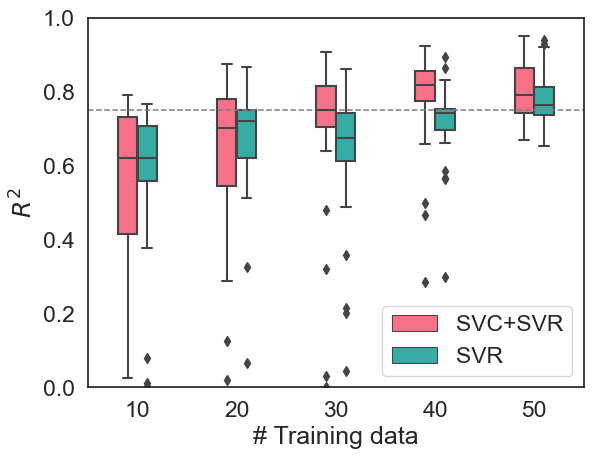

In [77]:
DAHBCLA = ComparisonResultsPlot([complexSVRR2Lists_DAHBCLA, SVRR2Lists_DAHBCLA], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

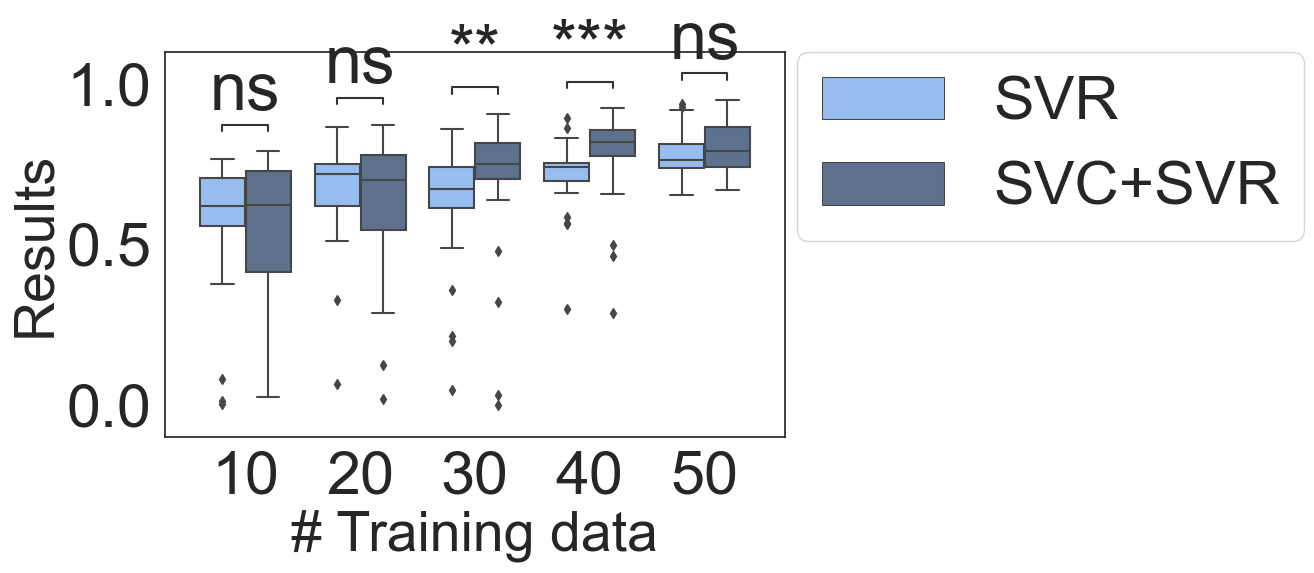

In [78]:
statsPlot(DAHBCLA)

here 0.0


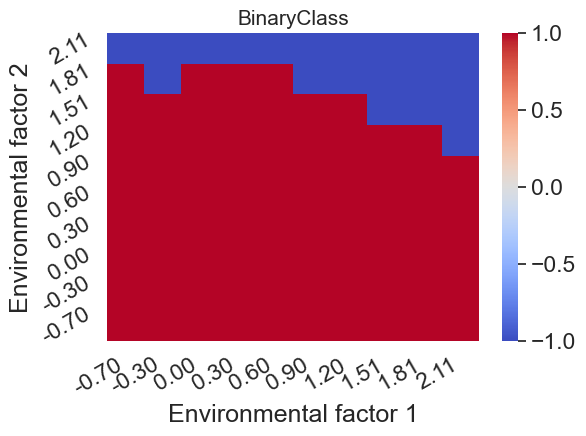

In [58]:
h = processExcelFormat02('HelenaExpDABCLA.xlsx', 'Sheet1', 0.2)
heatmapGenerator(h, 'BinaryClass')

here 0.028268253968253956


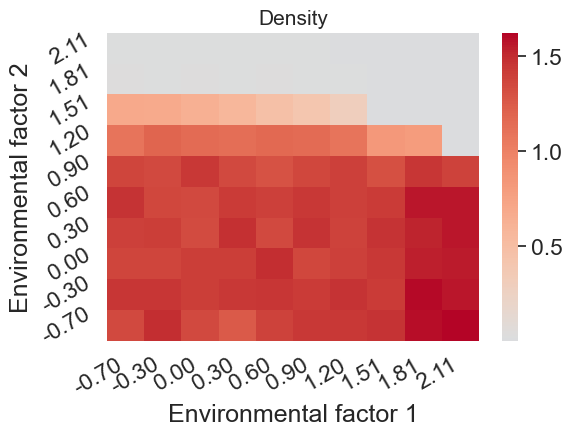

In [59]:
heatmapGenerator(h)

In [60]:
complexSVRSpearmanLists_DABCLA, complexSVRPearsonLists_DABCLA, complexSVRR2Lists_DABCLA, complexSVRMSELists_DABCLA, \
complexPredictedSVRSpearmanLists_DABCLA, complexPredictedSVRPearsonLists_DABCLA, complexPredictedSVRR2Lists_DABCLA, \
complexPredictedSVRMSELists_DABCLA, \
r2Recorder_DABCLA, mseRecorder_DABCLA, pearsonRecorder_DABCLA, spearmanRecorder_DABCLA, \
SVRSpearmanLists_DABCLA, SVRPearsonLists_DABCLA, SVRR2Lists_DABCLA, SVRMSELists_DABCLA, \
PredictedSVRSpearmanLists_DABCLA, PredictedSVRPearsonLists_DABCLA, PredictedSVRR2Lists_DABCLA, \
PredictedSVRMSELists_DABCLA, \
SVRr2Recorder_DABCLA, SVRmseRecorder_DABCLA, SVRpearsonRecorder_DABCLA, SVRspearmanRecorder_DABCLA,\
indexRecorder_DABCLA, TrainXDFRecorder_DABCLA, TrainYDFRecorder_DABCLA, \
SVMSVRFullXDFRecorder_DABCLA, SVMSVRFullYDFRecorder_DABCLA, scXRecorder_DABCLA, \
scDensityRecorder_DABCLA, scDistanceRecorder_DABCLA = \
ComparisonMultipleRun(30, 'HelenaExpDABCLA.xlsx',  2, 'Sheet1', [10,20,30,40,50], 0, ['poly', 'rbf'], 0.2)

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, gamma=0.01)
R2:  0.8312886048478361
MSE:  0.05151066577059912
Pearson:  0.9117502974213036
Spearman:  1.0
R2:  0.7092108916668832
MSE:  2.163350583323066
Pearson:  -0.8421465974917213
Spearman:  -0.5
R2:  0.8510950055164378
MSE:  0.2427498344812842
Pearson:  0.922548104716734
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-124.40115104           nan -124.50441477 -165.38052879 -165.47881045
 -418.06977717           nan           nan -166.00345589 -150.16943621]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-149.84402751 -282.89795443 -124.22084841           nan -159.70434122
 -425.96339111  -96.19956394 -109.29787179 -166.02825972 -166.01563594]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -109.58213765    -87.22121828 -27999.51100143   -166.01420554
             nan             nan   -164.05540554   -166.01464043
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.6858821076100643, 0.19944813149491294, 0.8855050669487534, 0.6775075112153763]
SVR:  [0.11596238376668329, 4.1041210801204775, -0.34053250030897686, -0.5066032613834985]
SVC(C=1000.0, gamma='auto', kernel='poly')
R2:  0.9641720517577634
MSE:  0.2711211225448516
Pearson:  0.9819226302299807
Spearman:  1.0
R2:  0.9930236771167368
MSE:  0.14090920429241646
Pearson:  0.9965057336095646
Spearman:  1.0
R2:  0.967396459881967
MSE:  0.10858236113286103
Pearson:  0.9835631448371616
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7349768673317209, 0.37209420883871963, 0.8573079186218455, 0.6234267605054121]
SVR:  [0.7065658879120288, 0.12698999872261607, 0.8405747366605948, 0.8009466189241469]
SVC(degree=4, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.17651607          nan  -0.57180416  -0.56658969  -0.16741321
 -73.35964608          nan  -0.57470836  -0.57235061  -0.58573199]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; 

R2:  nan
MSE:  0.01537953686146859
Pearson:  nan
Spearman:  nan
R2:  0.19133206804586905
MSE:  0.0024059410137968794
Pearson:  -0.4374152124079238
Spearman:  -0.5
R2:  0.1261706996538697
MSE:  0.007028649766624818
Pearson:  0.3552051515024377
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-180.99895547  -27.49324397           nan  -27.25940354           nan
           nan -262.35424781 -220.28017308 -288.19272741  -30.27183121]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-30.4970125           nan -28.0228339  -27.62177331 -62.49011107
 -27.17004029        

SVM:  [0.2701519372598038, 0.573903167692818, 0.8689147215995148, 0.3451829719894951]
SVR:  [0.25951752656570776, 0.4824070106507946, 0.509428627548264, 0.6323825986747335]
SVC(C=100.0, degree=2, gamma=0.0001)
R2:  0.6973857575198544
MSE:  0.2119410252722007
Pearson:  0.8350962564398514
Spearman:  0.5
R2:  0.6973963759274754
MSE:  0.21226307549255022
Pearson:  0.8351026140106826
Spearman:  0.5
R2:  0.29501088017748783
MSE:  0.6922491184643152
Pearson:  0.5431490404828935
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6899077642249493, 0.21680523359785472, 0.8296009074158461, 0.8588138453306992]
SVR:  [0.4918883251480121, 0.21278079666400124, 0.701347506695513, 0.8324566818948841]
SVC(C=0.01, degree=2, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.9346909329196516
MSE:  9.943794730140906
Pearson:  0.9667941522990567
Spearman:  1.0
R2:  0.9587752950525646
MSE:  0.04159909070733709
Pearson:  0.9791707180326447
Spearman:  1.0
R2:  0.9970994150551697
MSE:  0.169969095407694
Pearson:  0.9985486543254515
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.33430227         nan -0.36087937 -0.38570135  0.03577099  0.25996845
         nan -0.37128459 -1.24965319 -0.38595611]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7

SVM:  [0.4476101062077082, 0.24988943964769364, 0.7276792629337585, 0.7411038399802444]
SVR:  [0.5416658022198579, 0.17778694927769617, 0.7359794849177916, 0.7469152570276165]
SVC(C=100.0, degree=5, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

R2:  0.3286332892504836
MSE:  0.05869188347932472
Pearson:  -0.573265461414242
Spearman:  -0.5
R2:  0.4583682922450979
MSE:  0.20174387278964398
Pearson:  -0.6770290187614545
Spearman:  -0.5
R2:  0.35603634433938774
MSE:  0.22362413422185035
Pearson:  -0.5966878114553604
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.031385473817873995, 0.35841598799999014, 0.5307334401134306, 0.7939827962299874]
SVR:  [0.6442443690972435, 1.7177475498153905, 0.8026483470968112, 0.7244104210396345]
SVC(C=10000.0, degree=2, gamma=0.001, kernel='poly')
R2:  0.9992600993658067
MSE:  0.4124706152343178
Pearson:  0.9996299812259567
Spearman:  1.0
R2:  0.9953260697532056
MSE:  0.6757880432106346
Pearson:  0.997660297773348
Spearman:  1.0
R2:  0.8112221376335573
MSE:  0.33792755369006217
Pearson:  0.9006787094372539
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7084963725478844, 0.3603966883619331, 0.930242015557048, 0.823583158414619]
SVR:  [0.7239300910353064, 0.14548095899023344, 0.8508408141569763, 0.8032185043420998]
SVC(C=10000.0, degree=5, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -5.83451585          nan  -6.60661654  -8.60873913  -5.83406563
          nan  -6.59909113  -6.51999708  -0.80020174 -17.21941844]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.59719136 -6.59113059 -6.59807825 -6.51973718 -6.59113059 -6.59899264
 -4.67417523 -5.19353684 -4.94387687         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.49377906 -5.58786623 -5.59202791 -6.59909254 -5.14449197 -6.59889301
 -5.59202791         nan         nan -5.56730456]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserW

R2:  0.9882653967141171
MSE:  0.48681497103421717
Pearson:  0.9941153840043506
Spearman:  1.0
R2:  0.4706165846487097
MSE:  0.6145742663528504
Pearson:  0.6860150032242077
Spearman:  0.5
R2:  0.8789034484305712
MSE:  0.49560729869922787
Pearson:  0.9374985058284474
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.13180536e+02 -9.90588003e+02 -1.16899015e+00             nan
             nan             nan -1.22650822e+00 -8.59518174e-01
 -8.63006280e+03 -1.23310451e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.23268029   -1.22650822 -229.95683778   -1.69097647 -232.0658

SVM:  [0.4123064235478557, 0.5043158343274281, 0.8358452238301196, 0.8409844836811129]
SVR:  [0.6456794314831301, 0.34776093817745946, 0.8035418044402729, 0.8231880479071491]
SVC(C=10000.0, degree=2)
R2:  0.08097414688788106
MSE:  0.012441614605374499
Pearson:  0.2845595665021316
Spearman:  0.5
R2:  0.5212441722065453
MSE:  0.0025655532788192727
Pearson:  0.7219724178987349
Spearman:  1.0
R2:  0.7108312037245128
MSE:  0.0008993396628642155
Pearson:  0.8431080617124433
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.22100397092283297, 0.353230098448376, 0.3817032564315648, 0.7866238630283574]
SVR:  [0.3623280406221882, 0.27067806419687385, 0.6019369075095733, 0.5585298596534551]
SVC(C=10000.0, degree=5, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.14485253e+01             nan -1.72630885e+00 -1.53252671e+00
 -2.76256625e+02 -2.32309864e+00             nan -1.64943693e+00
 -1.69148749e+00 -5.19501010e+04]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-51.88561531  -1.67406171  -1.99444694  -1.6914617   -7.80584204
  -1.69340948  -1.69146178  -4.23354067          nan  -1.5270444 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.85012368e+04 -4.18606159e+01 -1.68889270e+00 -1.58292695e+02
             nan -1.51315074e+00             nan -1.64895693e+00
 -1.59484866e+00             nan]
  category=UserWarning,
/Users/ychha/a

R2:  0.737029098969375
MSE:  0.5935701340900409
Pearson:  0.8585039889070843
Spearman:  1.0
R2:  0.7228654768184349
MSE:  0.5904148019235925
Pearson:  0.850214959182932
Spearman:  1.0
R2:  0.7527319922614144
MSE:  0.6044100504556792
Pearson:  0.8676012864567542
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7314218004756116, 0.3806159167851748, 0.9315508782873845, 0.7513437872988434]
SVR:  [0.7315390700423933, 0.44170536714695074, 0.855300572922989, 0.8145779314318639]
SVC(degree=2, gamma=0.0001, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.9470587069989325
MSE:  0.008954755291606912
Pearson:  0.9731694133083574
Spearman:  1.0
R2:  0.9402751564089696
MSE:  0.00982798399908364
Pearson:  0.9696778621836066
Spearman:  1.0
R2:  0.9968440315472032
MSE:  0.019319432644266443
Pearson:  0.9984207687879909
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-8.01379036e-01             nan -5.72551853e-01 -8.38742563e-01
 -7.79461521e+00 -5.13143368e+04 -7.62230487e+00 -8.34435400e-01
  1.71866299e-03 -8.17411658e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-209.54257788   -0.67662403   -5.93868042   -4.87366017          

SVM:  [0.3405579784948119, 0.6071484583012601, 0.8524407522096922, nan]
SVR:  [0.5619421631853609, 0.5996517938220344, 0.7496280165424456, 0.7788533563814461]
SVC(C=0.1, degree=4, kernel='poly')
R2:  0.9989558939181482
MSE:  0.012350185646858752
Pearson:  0.9994778106181991
Spearman:  1.0
R2:  0.27802343136379554
MSE:  0.2131459196971812
Pearson:  0.5272792726476129
Spearman:  0.5
R2:  0.9999848379976597
MSE:  0.10532040628245903
Pearson:  0.9999924189700939
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.23373532e+05 -1.23373399e+05 -1.26801608e+05 -1.07002795e+05
             nan -1.26729872e+05 -6.00703643e+04 -2.28371594e+09
             nan -1.26757629e+05]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan              nan   -2992.08775657 -126801.184817

SVM:  [0.5035724612393792, 0.14016668898455192, 0.7459203399999869, 0.6113429641519529]
SVR:  [0.027805898378329863, 1.1907624328406692, 0.16675100712838234, 0.3208379635345927]
SVC(C=1000.0, degree=5, gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

R2:  0.9860734215415137
MSE:  0.19727546079729275
Pearson:  0.9930122967725594
Spearman:  1.0
R2:  0.9860516974803152
MSE:  0.19720073799547297
Pearson:  0.9930013582469639
Spearman:  1.0
R2:  0.9839863772969858
MSE:  0.16065784032513492
Pearson:  0.9919608748821627
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.635511193329517, 0.5116526743878765, 0.8071068334511897, 0.7676420957319834]
SVR:  [0.5710654422668215, 0.29379975601167774, 0.7556887204840506, 0.785817179075606]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.014020606517424568
MSE:  0.47096004708930944
Pearson:  -0.1184086420723782
Spearman:  -0.5
R2:  0.780110188132199
MSE:  0.36698808657569887
Pearson:  0.8832384661755845
Spearman:  1.0
R2:  0.9295310086260873
MSE:  0.023356501230776275
Pearson:  0.9641218847355802
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8621753551854259, 0.13261355539844902, 0.9145956769256278, 0.7434580400872536]
SVR:  [0.700580006236396, 0.32407130728352634, 0.837006574786839, 0.8140673545700563]
SVC(C=10000.0, degree=4, gamma=0.01)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.15189879008089086
MSE:  0.00951999326204591
Pearson:  -0.3897419531958175
Spearman:  -0.5
R2:  0.049372274927038856
MSE:  0.0022260079071155345
Pearson:  -0.22219872845504499
Spearman:  0.5
R2:  0.374601207517013
MSE:  0.03165045059418966
Pearson:  -0.6120467363829439
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-8.59702201e+00 -2.84514775e+01 -1.63746355e+05             nan
 -1.13811866e+01             nan -1.00047788e+05 -1.63740109e+05
 -6.70920374e+05 -1.12873186e+01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-8.62479785e+05 -1.06182428e+01 -3.70312519e+02             nan
 

SVM:  [0.05178672589503863, 0.5140835056451464, 0.39107461015687556, 0.4703708276741984]
SVR:  [0.15997050208126717, 0.5141321143770136, 0.3999631259019602, 0.4817796435773964]
SVC(C=0.01, degree=2, gamma=0.001, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.8959465824482283
MSE:  19.775911372210658
Pearson:  -0.9465445485809044
Spearman:  -0.5
R2:  0.89272457889673
MSE:  0.2967504718051111
Pearson:  -0.94484103366478
Spearman:  -0.5
R2:  0.6774833674364413
MSE:  0.022657705870709217
Pearson:  0.8230937780328809
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -83.81705762 -143.88541098 -131.26912981 -148.49135716   -9.61136658
           nan           nan  -27.19852256 -148.76796909           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-133.46175183 -127.6355729   -38.07148395 -165.58647962           nan
 -148.75270797 -

SVM:  [0.5017203977708458, 4.648407868999284, 0.357656376628375, 0.7748034736798781]
SVR:  [0.03521269636200273, 745.8919096621952, -0.1876504632608263, -0.09638226941597729]
SVC(C=100.0, gamma=0.1)
R2:  0.9434037541219479
MSE:  0.13460946386134867
Pearson:  0.9712897374738126
Spearman:  1.0
R2:  0.9993933610766407
MSE:  0.13196797967401436
Pearson:  0.999696634523014
Spearman:  0.5
R2:  0.9313253377431514
MSE:  0.03571999548534426
Pearson:  0.9650519870676147
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7542020310918883, 0.28460050655756725, 0.8072405833804204, 0.8081409227476641]
SVR:  [0.6870783757191958, 0.12794218716760658, 0.8289019095883395, 0.734222331975141]
SVC(C=10.0, degree=2)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 3.88666634e-01 -4.18060446e-01 -4.07756492e-01             nan
             nan -3.89967755e-01 -3.57941342e-01 -3.48978458e-01
 -4.17190916e-01 -1.74185660e+05]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.9612307   -0.05042569  -0.21959357          nan          nan
  -0.41808096  -0.31756626 -14.42511611  -0.4180355    0.15552939]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.36074734  -2.88493223   0.13535131  -0.31758286  -0.38828736
  -0.36095518          nan          nan -22.19566638  -0.41808293]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

R2:  0.191662723030043
MSE:  0.7347822891353549
Pearson:  -0.43779301391187486
Spearman:  -0.5
R2:  0.18457724916012785
MSE:  0.7270381669204907
Pearson:  -0.4296245444107306
Spearman:  -0.5
R2:  0.9999430245643955
MSE:  639.9204602403933
Pearson:  -0.9999715118764114
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.624781563508259, 0.1441330831294701, 0.8383486231967796, 0.7792649298267277]
SVR:  [0.63373034962696, 0.20584284453702534, 0.7960718244147067, 0.7240976252212207]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.526705870437863
MSE:  0.28234919430566313
Pearson:  0.7257450450660086
Spearman:  0.5
R2:  0.4679741816750367
MSE:  0.3707037946158402
Pearson:  0.6840863846584265
Spearman:  0.5
R2:  0.9753759767424511
MSE:  1.6653245500072538
Pearson:  0.9876112477804468
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-93.31959828 -70.29004129 -93.97486806          nan -38.04356341
          nan          nan -46.31735987 -94.01059093 -91.35002342]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-93.88654186 -94.27799465 -81.55997329 -91.94228493          nan
          nan -93.39514651          nan -70.40383804 -36.29068009]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-116.92789587  -93.96658879           nan   -9.15990306           nan
  -93.9888361   -93.29532145  -93.99860962           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

SVM:  [0.7717764788274065, 0.417181922289832, 0.7990547982876894, 0.7401983784006255]
SVR:  [0.31434939924690836, 0.34527664105744627, 0.5606687072121186, 0.5385707641761225]
SVC(C=10000.0, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -4.61817325e-01 -1.85074289e+04 -8.37092715e+00
 -5.23501845e+00  1.26142195e-01 -2.71321437e-02             nan
 -8.65942616e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan  -1.26163269  -0.45856145          nan  -0.02719799
          nan -10.63462218          nan  -0.01911873  -1.50669051]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.02618655  0.14369319 -0.14197001 -0.18108103         nan         nan
 -0.02713225 -0.02618655 -0.02713027 -0.27350353]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

R2:  0.9999605004367127
MSE:  0.1935591609341559
Pearson:  0.9999802500233254
Spearman:  1.0
R2:  0.31761604311435304
MSE:  0.6805918476962457
Pearson:  0.5635743456850686
Spearman:  1.0
R2:  0.9815514113040176
MSE:  0.11914489932133272
Pearson:  0.9907327648281435
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7137111206974435, 0.0712774753999163, 0.8411397831562188, 0.7976869572375189]
SVR:  [0.7118730532178813, 0.13981329943515525, 0.8437256978532067, 0.7976869572375189]
SVC(C=10.0, gamma=0.1)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.9420689126105398
MSE:  0.6258306178061075
Pearson:  0.9706023452529569
Spearman:  1.0
R2:  0.6158924397682889
MSE:  0.6562778339362271
Pearson:  0.7847881496100009
Spearman:  1.0
R2:  0.9982796808583398
MSE:  0.5764040281767955
Pearson:  0.9991394701733787
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -8.11063089  -4.08477704 -12.85830901  -3.01670075  -3.00063181
  -3.07672896 -30.49946863          nan          nan -20.31473608]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -3.79865723 -10.9519542           nan -14.29841427 -14.21142672
 -10.95137276  -4.11726936  -4.

SVM:  [0.7637280376108484, 0.5386183668651162, 0.8608325507775405, 0.7872165287895625]
SVR:  [0.8368441174464382, 0.14965480806972872, 0.9147918437800142, 0.8157303370786515]
SVC(degree=5, gamma=0.1, kernel='poly')
R2:  0.791612014386416
MSE:  0.49766128641559537
Pearson:  -0.8897258085423935
Spearman:  -0.5
R2:  0.7925884100216801
MSE:  0.4200406989426689
Pearson:  -0.8902743453687073
Spearman:  -0.5
R2:  0.792201792251715
MSE:  0.4996143077995348
Pearson:  -0.8900571848211298
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.14118428899178506, 0.5256897984282284, 0.5961465199395304, 0.8086183479441906]
SVR:  [0.6437265061650537, 0.22239384598999104, 0.8023256858440055, 0.7623574926945713]
SVC(C=100.0, gamma=1.0)
R2:  0.9253641147599364
MSE:  0.1343143291388764
Pearson:  0.9619584787088975
Spearman:  1.0
R2:  0.4367590742912776
MSE:  0.24654363536844717
Pearson:  0.660877503241923
Spearman:  0.5
R2:  0.9999976542275605
MSE:  0.020379984292600465
Pearson:  0.9999988271130927
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -49.95662109 -521.41093141           nan           nan -386.93383506
           nan           nan -520.79067027 -494.76594362 -186.8953492 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan -521.41026176           nan
  -57.10839301 -190.42803122           nan -461.06957922 -522.65122476]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -521.28138038  -85.82058237           nan  -40.94408375
           nan  -92.96170684  -41.00159524           nan           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pack

SVM:  [0.735282479109199, 2.225249442326301, 0.8116667884294295, 0.15273787093481628]
SVR:  [0.728816163741328, 0.13108577071180022, 0.8537073056623847, 0.8779602420051857]
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.9983758957737249
MSE:  0.05172877205605126
Pearson:  0.999187617904528
Spearman:  1.0
R2:  0.9963914869203011
MSE:  0.044384300961191815
Pearson:  0.998194112845944
Spearman:  1.0
R2:  0.9987692475347161
MSE:  0.050704983487580235
Pearson:  0.9993844343067966
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6450028215999241, 0.15891158710088296, 0.7623879784874833, 0.6665431946330822]
SVR:  [0.00013822020576651699, 7.80668504796735, -0.011756708968351525, 0.08824957813721858]
SVC(C=0.1, degree=4, gamma=0.0001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -1.85740298  -2.49001168          nan  -0.096746            nan
          nan -81.44857223  -2.17107009  -0.24565959  -0.19792179]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan            nan
    -3.43778391            nan    -3.31340333 -1767.80922621
    -3.4496924     -3.29719843]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.44993391 -0.17078876 -3.44831513 -0.17064457 -3.44990326 -3.44993553
 -2.03434555         nan -2.99505749         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

R2:  0.961498295240727
MSE:  0.3907885977757945
Pearson:  0.9805601946034355
Spearman:  1.0
R2:  0.9718288028999396
MSE:  0.445607784186191
Pearson:  0.985813776988301
Spearman:  0.5
R2:  0.9641893466933211
MSE:  0.4123268671189899
Pearson:  0.9819314368596829
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7058314576243981, 0.24452712047010192, 0.8736265978294235, 0.8839198254928592]
SVR:  [0.7072580140393379, 0.11518611951663672, 0.8409863340383945, 0.8145943943696753]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.9182569493545477
MSE:  0.06185972815364001
Pearson:  0.9582572459181032
Spearman:  1.0
R2:  0.6846193639771337
MSE:  0.24152432145516498
Pearson:  0.8274172852781925
Spearman:  1.0
R2:  0.6861643969032022
MSE:  1.7078345503137362
Pearson:  0.8283504070761374
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7463540395434941, 0.1400399886323635, 0.8545553109679053, 0.8024118203893483]
SVR:  [0.7034903192573105, 0.1261603635437078, 0.8387432975930774, 0.7935382969090834]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

SVC(C=0.1)
R2:  0.9625830072420837
MSE:  0.5662552917645701
Pearson:  -0.9811131470131689
Spearman:  -0.5
R2:  0.9998002867573871
MSE:  0.5890577771509348
Pearson:  0.9999001383925232
Spearman:  1.0
R2:  0.7784073157453184
MSE:  0.5890336340927409
Pearson:  0.8822739459744452
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4849616552071278, 0.49054970910089063, 0.8560419095198919, 0.7255792896242333]
SVR:  [0.7312793703016544, 0.5183635833843162, 0.8551487416243179, 0.8319627937605465]
SVC(C=10000.0, degree=2, gamma=10.0)
R2:  0.992791218872849
MSE:  0.06387701257705947
Pearson:  0.9963890901012761
Spearman:  0.5
R2:  0.9969439519159211
MSE:  0.0821156752495006
Pearson:  0.9984708067419502
Spearman:  0.5
R2:  0.9748132030087193
MSE:  0.06608344712306653
Pearson:  0.9873262900423139
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.570439942684541, 0.30222629385254607, 0.7226681471336391, 0.7668365337935671]
SVR:  [0.49323637832805906, 0.21629125054739196, 0.7023078942515589, 0.6126929250524755]
SVC(C=0.1, degree=5, gamma=0.001, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -9.9873005  -66.56925658 -16.55337564 -16.44667702 -66.56925658
  -4.86637362          nan -69.68261715 -66.56398287 -10.52186254]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-22.04701953 -19.02571228 -37.94119479          nan -71.61087636
          nan -67.25906874  -4.00587637          nan  -4.00587637]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -66.57053776  -6.31071821          nan          nan
 -69.44027259  -6.31547703 -25.09782872 -66.56195076 -32.46682665]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

R2:  0.5643878650462744
MSE:  0.1848870269271715
Pearson:  0.7512575224556985
Spearman:  1.0
R2:  0.7749061045816414
MSE:  0.13206032322787506
Pearson:  0.8802875124535401
Spearman:  1.0
R2:  0.8368329565905224
MSE:  0.09329534867180107
Pearson:  0.914785743543548
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7207818146928212, 0.2667371902582705, 0.5894301287944823, 0.8015722105609746]
SVR:  [0.7072964850615977, 0.14084912188825266, 0.841009206288253, 0.8189406099518458]
SVC(C=100.0, gamma=0.1)
R2:  0.9997604489501916
MSE:  0.1190595698254938
Pearson:  0.9998802173011481
Spearman:  1.0
R2:  0.9990890069662208
MSE:  0.09015500175285279
Pearson:  0.9995443996972924
Spearman:  1.0
R2:  0.3784495361170476
MSE:  0.4016920146886402
Pearson:  0.6151825226036964
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -3.91609384  -29.77466591   -3.70875916  -49.53215209 -255.32697984
   -5.75971447 -554.48335685  -49.52104475           nan  -15.31645343]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-49.45036299 -20.12850058 -21.19779408 -49.15803442 -40.69389807
 -49.26513783 -31.69430067 -45.02680741  -3.85671007          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -38.79866067   -38.47038006   -49.11954696   -49.55287858
   -49.67976911 -3429.76837843   -49.46765386   -24.49718114
            nan            nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

SVM:  [0.5824131777632464, 0.2032009566426681, 0.8335842079081516, 0.8053751491953738]
SVR:  [0.6998283386944649, 0.1426297220415819, 0.8365574329921792, 0.8030209490883647]
20
SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.022250388282574907
MSE:  0.024664154125625153
Pearson:  -0.14916564042223301
Spearman:  -0.19999999999999998
R2:  0.020220552096198687
MSE:  0.02463263655363084
Pearson:  -0.14219898767642025
Spearman:  -0.19999999999999998
R2:  0.0011967647784613335
MSE:  0.008555146000546077
Pearson:  -0.03459428823463978
Spearman:  0.10540925533894598


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6526897812890758, 0.15230760193746556, 0.830390776733301, 0.838748241912799]
SVR:  [0.5657739237054493, 0.4541222072280755, 0.7521794491379362, 0.7755508673230191]
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.9647876358215097
MSE:  0.01841736218715536
Pearson:  0.9822360387511291
Spearman:  0.7999999999999999
R2:  0.9579845659204933
MSE:  0.04051400009003435
Pearson:  0.9787668598397136
Spearman:  0.7999999999999999
R2:  0.9624248454293987
MSE:  0.018603055481284117
Pearson:  0.9810325404538827
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6900480466279767, 0.06795453279972095, 0.9149861208810042, 0.7022269104547586]
SVR:  [0.6900514644469521, 0.14205268150760558, 0.830693363670947, 0.7661744022503516]
SVC(degree=5, gamma=1.0, kernel='poly')
R2:  0.5575546972386792
MSE:  0.8804824854091082
Pearson:  0.746695853235224
Spearman:  0.39999999999999997
R2:  0.5208727630842377
MSE:  0.833176624350848
Pearson:  0.7217151537027873
Spearman:  0.39999999999999997
R2:  0.9223119659964896
MSE:  0.09345342843348618
Pearson:  0.9603707440340369
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.027379565577947938, 5.588525112381491, 0.7950708072712994, 0.8289263947491796]
SVR:  [0.6151616297608218, 0.4475294319752079, 0.7843224016696334, 0.7638068448195031]
SVC(gamma=0.001)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in fit
    }, X, y, sample_weight)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwarg

R2:  0.8591919475718839
MSE:  0.5048135233137143
Pearson:  0.9269260744913177
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.45312725e+00 -3.50594126e+00 -3.81233690e+00 -3.81954758e+00
 -1.37598527e+01 -1.45550718e+00 -1.68344592e+01 -3.79428556e+00
 -1.61218825e+06             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-34.34499479          nan  -1.39308374  -1.5515217           nan
  -1.45318315  -1.83347776 -13.79009279  -1.93118222          nan]
  category=UserWarning,


R2:  0.9198574000613349
MSE:  0.50473736303795
Pearson:  0.9590919664251883
Spearman:  0.7999999999999999
R2:  0.9318072285790782
MSE:  0.4970297552059019
Pearson:  0.9653016257000079
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -1.45424357e+00 -9.54212587e+06 -2.43043701e+01
 -3.21797317e+01 -3.41056994e+02             nan -1.39173881e+00
 -1.65587392e+00 -4.47877244e+01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.11398540796243717, 0.6305363900959481, 0.705382431586731, 0.8776136896390061]
SVR:  [0.4512840605078763, 0.6221143913495282, 0.6717767936657804, 0.7207454289732772]
SVC(gamma='auto')
R2:  0.8616679188757401
MSE:  0.5524625401294256
Pearson:  0.9282606955353327
Spearman:  1.0
R2:  0.7748952783335885
MSE:  0.8176053575952344
Pearson:  0.88028136316384
Spearman:  1.0
R2:  0.9352723829719247
MSE:  0.27758858731678054
Pearson:  0.967094815916167
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2942791396406676, 0.10917487888822967, 0.9022220447904947, 0.8552273792780122]
SVR:  [0.6680120603428233, 0.27654017459544467, 0.8173200476819488, 0.7885138302859822]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.880953801860303
MSE:  0.41757799254194616
Pearson:  0.9385913923855806
Spearman:  1.0
R2:  0.8836336508456736
MSE:  0.41693690603911715
Pearson:  0.9400178992155803
Spearman:  1.0
R2:  0.9687581442676483
MSE:  0.46381862075405844
Pearson:  0.9842551215348834
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.4555619801297931, 0.0818457868818335, 0.24873272230880145, 0.8458743553680264]
SVR:  [0.7647275709935449, 0.3267162126890089, 0.8744870330619807, 0.839170182841069]
SVC(C=100.0, gamma=0.1, kernel='poly')


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.494866307604154
MSE:  1.7151632573469509
Pearson:  -0.7034673465088157
Spearman:  -0.7999999999999999
R2:  0.24134195179873108
MSE:  0.14742515988659288
Pearson:  0.49126566315867326
Spearman:  0.6000000000000001
R2:  0.9486023296673627
MSE:  0.02983435173897803
Pearson:  0.9739621808198526
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7112933280761795, 0.14281247507218495, 0.6957172759385664, 0.666502578527895]
SVR:  [0.9233607457056867, 0.028459955514313545, 0.9609166174573559, 0.7300046882325363]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.8766347282643772
MSE:  0.4812484659523818
Pearson:  0.9362877379654062
Spearman:  0.6000000000000001
R2:  0.8987240012679382
MSE:  0.5334216833822363
Pearson:  0.9480105491332563
Spearman:  0.6000000000000001
R2:  0.9546202395561288
MSE:  0.645016151381161
Pearson:  0.9770466926181824
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7397716814231411, 0.48388925424758433, 0.8200970966194562, 0.7812705110173465]
SVR:  [0.7004907793609497, 0.20409123502741594, 0.8369532719100566, 0.772456633849039]
SVC(C=10000.0, degree=2, gamma=1.0)
R2:  0.7242119289865349
MSE:  0.4339024266929654
Pearson:  0.851006421236958
Spearman:  0.7999999999999999
R2:  0.9304653711204978
MSE:  0.08818503076556916
Pearson:  0.9646063296083528
Spearman:  0.7999999999999999
R2:  0.9320184493168026
MSE:  0.2874630280941335
Pearson:  0.965411026100698
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8547122081239505, 0.04704446763026623, 0.9269005854086672, 0.8038912330051572]
SVR:  [0.6656616666804522, 0.24737755421276608, 0.815880914521508, 0.8269573370839195]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.9060487078523712
MSE:  0.3241040693038804
Pearson:  -0.9518659085461414
Spearman:  -0.6000000000000001
R2:  0.8291659548890264
MSE:  0.08229898349189604
Pearson:  0.9105855011414505
Spearman:  0.7999999999999999
R2:  0.9237299109610333
MSE:  0.0847351441192894
Pearson:  0.961108688422404
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8573800374130106, 0.16759831301718905, 0.8812176185818146, 0.7794889826535396]
SVR:  [0.7089950213141991, 0.4857514381431357, 0.8420184210064522, 0.8302156586966714]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.5114281683573644
MSE:  0.0786907209081974
Pearson:  0.7151420616614326
Spearman:  0.7999999999999999
R2:  0.5076292585177483
MSE:  0.07958665848104722
Pearson:  0.7124810583571666
Spearman:  0.7999999999999999
R2:  0.05397771944330247
MSE:  0.2149406591620791
Pearson:  0.23233105570134718
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7140255794083997, 0.37908902046526183, 0.9549743417163946, 0.7647679324894515]
SVR:  [0.7074195296745862, 0.10765281779299374, 0.841082356059492, 0.8172058134083451]
SVC(C=10.0, gamma=0.1)
R2:  0.8368630283357453
MSE:  0.2222876658377477
Pearson:  0.9148021798923225
Spearman:  0.7999999999999999
R2:  nan
MSE:  0.22234835515432105
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.06544526924802774
MSE:  0.22234835375087392
Pearson:  0.2558227301238648
Spearman:  0.21081851067789195


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8933322382324044, 0.12280077589305531, 0.8584468615355338, 0.857149554617909]
SVR:  [0.1279697778159233, 0.5009274162339139, 0.3577286371202665, 0.3046882325363338]
SVC(gamma='auto', kernel='poly')
R2:  0.6386729091025671
MSE:  0.07276309617585522
Pearson:  0.7991701377695286
Spearman:  0.7999999999999999
R2:  0.616541134511667
MSE:  0.17900287919700686
Pearson:  0.7852013337429243
Spearman:  0.7999999999999999
R2:  0.6196087249240095
MSE:  0.17824795599775364
Pearson:  0.7871522882670221
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8366998714602469, 0.13731576874209644, 0.8444189664478279, 0.7928738865447726]
SVR:  [0.708252542587491, 0.10824750868437519, 0.8415774133063996, 0.7979371776840132]
SVC(C=0.01, degree=5, gamma=10.0, kernel='poly')
R2:  0.9571202628021487
MSE:  0.01829116110852275
Pearson:  0.9783252336529754
Spearman:  1.0
R2:  0.9176634559085866
MSE:  0.23208884051325546
Pearson:  0.9579475225233303
Spearman:  1.0
R2:  0.6898459380723748
MSE:  0.15659383213467548
Pearson:  0.830569646731913
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7513203691282475, 0.4297866284527556, 0.9304380098244247, 0.6543131739334271]
SVR:  [0.7216162350473504, 0.11444427905044918, 0.8494799791915935, 0.8172995780590718]
SVC(C=100.0, degree=2, gamma=1.0)
R2:  0.7607086250598137
MSE:  0.651967260331598
Pearson:  0.8721861183599597
Spearman:  0.7999999999999999
R2:  0.779943874600836
MSE:  0.13522620496729051
Pearson:  0.8831443113109183
Spearman:  0.7999999999999999
R2:  0.7745235500962125
MSE:  0.1413252088206499
Pearson:  0.8800701961185897
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7980031597711099, 0.07244508909893292, 0.8927595438411792, 0.8032348804500703]
SVR:  [0.6940405909769539, 0.3620665564132408, 0.8330909860135048, 0.7931786216596344]
SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.8639307134096477
MSE:  0.08538893739190216
Pearson:  0.9294787320910832
Spearman:  1.0
R2:  0.8343533567189889
MSE:  0.429616397333067
Pearson:  0.9134294481343314
Spearman:  0.19999999999999998
R2:  0.4325086251916326
MSE:  0.22116683787028726
Pearson:  0.6576538794773682
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8966444083103997, 0.09432460194276415, 0.920801311252597, 0.6755508673230193]
SVR:  [0.7149059584708836, 0.12021963401733449, 0.8455211165138834, 0.7960853258321614]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.9650401568644879
MSE:  0.017234044710746337
Pearson:  0.9823645743126572
Spearman:  1.0
R2:  0.8887691663807514
MSE:  0.0656353914507408
Pearson:  0.9427455469959812
Spearman:  0.7999999999999999
R2:  0.8901907185528576
MSE:  0.2958067854325891
Pearson:  0.9434991884219388
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8761777769930604, 0.04198091646685894, 0.9240731815863654, 0.8544303797468356]
SVR:  [0.8904816954981469, 0.04215750371311316, 0.9436533767746222, 0.8738396624472574]
SVC(C=1000.0)
R2:  0.506391584857935
MSE:  0.05490046724420891
Pearson:  0.7116119622785545
Spearman:  0.7999999999999999
R2:  0.5774340008451588
MSE:  0.07096954152054717
Pearson:  0.7598907821819914
Spearman:  0.39999999999999997
R2:  0.7832400161282174
MSE:  0.020546836274918334
Pearson:  0.8850084836475961
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8278953463067609, 0.07161458380222427, 0.906139698442939, 0.7846460384435069]
SVR:  [0.392576392895669, 0.2836642401274024, 0.626559169508889, 0.7610407876230663]
SVC(C=10000.0, gamma=0.01)
R2:  0.6907247165709035
MSE:  0.18575627538483785
Pearson:  0.8310984999209798
Spearman:  1.0
R2:  0.5927105522927804
MSE:  0.3591156003502569
Pearson:  0.7698769721798282
Spearman:  0.6000000000000001
R2:  0.10516970101129199
MSE:  4.233142777886263
Pearson:  -0.32429878354889335
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6257776853093558, 0.39917055451234335, 0.7780826394702207, 0.861978434130333]
SVR:  [0.921126767656292, 0.029781485714318746, 0.9597534931722272, 0.8133614627285515]
SVC(C=0.1, degree=5, gamma=1.0, kernel='poly')
R2:  0.9776597867023931
MSE:  0.06955780744353596
Pearson:  0.9887668009709834
Spearman:  1.0
R2:  0.9510951671005775
MSE:  0.15177044724304717
Pearson:  0.9752410815283459
Spearman:  1.0
R2:  0.9791522657720108
MSE:  0.055694295865814904
Pearson:  0.9895212305817449
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7210927059060113, 0.21094474827984042, 0.8298963833986108, 0.8166432255039849]
SVR:  [0.3049085453696675, 0.3953670972030694, 0.5521852455197147, 0.6266057196436945]
SVC(degree=2, gamma=0.001, kernel='poly')
R2:  0.8441627887915686
MSE:  0.4125478166017486
Pearson:  0.9187833198265892
Spearman:  1.0
R2:  0.7512360986796722
MSE:  0.46441176806356
Pearson:  0.8667387718797817
Spearman:  0.7999999999999999
R2:  0.9472334236909756
MSE:  0.4657707930814623
Pearson:  -0.973259176011701
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49354881817122, 0.5521010511391451, 0.8718984401242228, 0.7546647913736522]
SVR:  [0.648004638247414, 0.5308897064843947, 0.8049873528493559, 0.8217533989685889]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.5158097536440693
MSE:  1.1970501790891317
Pearson:  0.7181989652206895
Spearman:  0.6000000000000001
R2:  0.43873900628547957
MSE:  1.1762693820025878
Pearson:  0.6623737663022891
Spearman:  0.6000000000000001
R2:  0.2947823398040124
MSE:  1.0327348669536498
Pearson:  0.5429386151343558
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.49289208997478506, 0.4362560161190391, 0.7693514162834846, 0.7400843881856541]
SVR:  [0.605824645648981, 0.48329053268720673, 0.7783473810895629, 0.8009376465072668]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.5725405996098821
MSE:  0.8201998190368891
Pearson:  0.7566641260228227
Spearman:  0.7999999999999999
R2:  0.5663157409393808
MSE:  0.7265048187723755
Pearson:  0.7525395278252037
Spearman:  0.7999999999999999
R2:  0.4993482652795706
MSE:  0.851587910105609
Pearson:  0.7066457848735607
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.680308768583936, 0.15204308462563937, 0.867097735491501, 0.7584388185654009]
SVR:  [0.609992622279826, 0.45841509026681715, 0.7810202444750236, 0.6941631504922645]
SVC(C=10.0, degree=4)
R2:  0.8584157182169171
MSE:  0.12219906538823666
Pearson:  0.9265072683022605
Spearman:  0.7999999999999999
R2:  0.998918490260478
MSE:  0.25627028558651416
Pearson:  0.9994590988432079
Spearman:  1.0
R2:  0.8855722045799377
MSE:  0.0775562737303748
Pearson:  0.9410484602718063
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5988148331623823, 0.12746220900107974, 0.8799978221908623, 0.7352320675105487]
SVR:  [0.7243589399394552, 0.11293249586309766, 0.8510927916152593, 0.7399906235349274]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.9321352368160909
MSE:  0.03125201527397829
Pearson:  0.9654715101006817
Spearman:  0.7999999999999999
R2:  0.8640292962754768
MSE:  0.7820531810482743
Pearson:  0.9295317618432828
Spearman:  0.7999999999999999
R2:  0.9341034359215011
MSE:  0.7098810221982427
Pearson:  0.9664902668529578
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6674136451892833, 0.15517167808227536, 0.9037500175994478, 0.8323488045007033]
SVR:  [0.6439183354174866, 0.507161573488794, 0.8024452226896776, 0.7563056727613691]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.7933104346009191
MSE:  0.41111714638931474
Pearson:  0.8906797598468931
Spearman:  1.0
R2:  0.7988612967286864
MSE:  0.41115632849244327
Pearson:  0.8937904098437657
Spearman:  1.0
R2:  0.8673982376527914
MSE:  0.46122550911965604
Pearson:  0.9313421700174385
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.04655169298522811, 0.5987678221171515, 0.6520488870999965, 0.6387716830754806]
SVR:  [0.47769905036960164, 0.5205135990274371, 0.6911577608401729, 0.7050164088138773]
SVC(C=100.0, gamma=1.0)
R2:  0.7885859509095872
MSE:  0.12017194862700167
Pearson:  0.8880236206934966
Spearman:  1.0
R2:  0.767008461396249
MSE:  0.14537548107826948
Pearson:  0.8757901925668323
Spearman:  1.0
R2:  0.7064823962763149
MSE:  0.12772329543804212
Pearson:  0.8405250717713986
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5833082107813177, 0.09071385554333641, 0.8983360854587559, 0.6710032817627756]
SVR:  [0.010158035514777057, 0.4340936934892453, -0.10078708009847814, 0.10588373183309892]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.9588808873178047
MSE:  1.0766781913935974
Pearson:  0.9792246357796582
Spearman:  1.0
R2:  0.9336701723469396
MSE:  1.0151972913470682
Pearson:  0.9662660981049367
Spearman:  1.0
R2:  0.6691319715917027
MSE:  1.0737436357976946
Pearson:  0.8180048725965525
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46758248297269567, 0.4582218208743263, 0.7498374072326376, 0.7561884669479606]
SVR:  [0.6188504667733274, 0.45873154473492034, 0.786670494408763, 0.7938584153774028]
SVC(C=1000.0, gamma=0.01)
R2:  0.6008323245714656
MSE:  0.4945920337908894
Pearson:  0.7751337462473593
Spearman:  1.0
R2:  0.9787775321802613
MSE:  0.01332894419793656
Pearson:  0.9893318615006096
Spearman:  0.7999999999999999
R2:  0.9722573462335231
MSE:  0.16903907808518515
Pearson:  0.9860311081469607
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7708238422373342, 0.04917023660848398, 0.815724196160799, 0.7271917487107361]
SVR:  [0.7281738579145326, 0.1254303219796385, 0.8533310365353717, 0.8462962962962964]
SVC(C=100.0, degree=2, gamma='auto')
R2:  0.41250565789502047
MSE:  0.0018541609135681084
Pearson:  0.6422660335834524
Spearman:  0.7999999999999999
R2:  0.8673884018343117
MSE:  0.05563777544689753
Pearson:  0.9313368895487345
Spearman:  1.0
R2:  0.8970685476158697
MSE:  0.11089422823293822
Pearson:  0.9471370268424045
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.2689520371850731, 0.6066728141270261, 0.8969722547296728, 0.5854664791373653]
SVR:  [0.2782603469466617, 0.6055958006841243, 0.5275038833474703, 0.5577121425222692]
30
SVC(C=1000.0, degree=4)
R2:  0.7339053254933962
MSE:  0.4842839403471099
Pearson:  0.8566827449490251
Spearman:  0.8857142857142858
R2:  0.9743778841482589
MSE:  0.03990309183182073
Pearson:  0.9871058120324584
Spearman:  0.8285714285714287
R2:  0.97285858402485
MSE:  0.040789239395693296
Pearson:  0.9863359387271916
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6397767234686724, 0.10292102337729674, 0.7998604399947984, 0.8597847957309073]
SVR:  [0.7714590089586764, 0.35855936328336363, 0.8783273928090122, 0.794978567054501]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.6917021881697784
MSE:  0.12038791179485686
Pearson:  0.8316863520401054
Spearman:  0.8857142857142858
R2:  0.9429882547858942
MSE:  0.017553886943583952
Pearson:  0.9710758233968624
Spearman:  0.6
R2:  0.8265414511281058
MSE:  0.04294872728946125
Pearson:  0.9091432511590818
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.46166766297112577, 0.0877744804036279, 0.933095260904969, 0.7523576240048989]
SVR:  [0.5518633431174024, 0.3109330639757357, 0.7428750521570922, 0.7407400927302947]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.6727269337485631
MSE:  0.8062922388023863
Pearson:  0.8201993256206465
Spearman:  0.6
R2:  0.8943795567577232
MSE:  0.05852517475095132
Pearson:  0.9457164251284439
Spearman:  0.7714285714285715
R2:  0.7771022638517496
MSE:  0.9400753050499197
Pearson:  0.8815340400981402
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.694087672085944, 0.0281649002412112, 0.9541834982673276, 0.7570466275916368]
SVR:  [0.8307207604252398, 0.22757211844776223, 0.911438840748648, 0.8383343539497857]
SVC(degree=5)
R2:  0.8185518992507992
MSE:  0.30356346725726135
Pearson:  0.9047385806136486
Spearman:  0.6
R2:  0.8096833792167646
MSE:  0.08673098121475585
Pearson:  0.8998240823720849
Spearman:  0.6
R2:  0.9820569995867167
MSE:  0.015840834815291468
Pearson:  0.9909878907366713
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.87523837153681, 0.18284228980256673, 0.9340314465040049, 0.8268218003674219]
SVR:  [0.6940335132193295, 0.12728090521214344, 0.8330867381127429, 0.7418248622167789]
SVC(C=10000.0, kernel='poly')
R2:  0.9467784205415731
MSE:  0.07784510888185991
Pearson:  0.9730253956303366
Spearman:  0.942857142857143
R2:  0.7743358371764908
MSE:  0.12461269907158057
Pearson:  0.879963543095105
Spearman:  0.942857142857143
R2:  0.8115041152978234
MSE:  0.08874342583605244
Pearson:  0.9008352320473614
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7044216892189809, 0.2690768145182182, 0.8430586132254849, 0.8406788557431547]
SVR:  [0.7937586007122736, 0.08833518205336155, 0.8909313108833208, 0.8070510016621467]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.401265515861656
MSE:  0.2936726355694512
Pearson:  0.633455220091883
Spearman:  0.6
R2:  0.31181778009688194
MSE:  0.3244697278313215
Pearson:  0.5584064649490386
Spearman:  0.6
R2:  0.4343724923552754
MSE:  0.09438223234773106
Pearson:  0.6590694139127345
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8908996214030337, 0.1070515013258727, 0.9670029638478277, 0.8725920741842359]
SVR:  [0.6842385582633113, 0.15370053012253956, 0.8271871361809919, 0.8234275216516491]
SVC(C=10.0, degree=4)
R2:  0.9666954253492248
MSE:  0.03539658398278919
Pearson:  0.9832067053011919
Spearman:  0.7714285714285715
R2:  0.9225477227420031
MSE:  0.043386369482473354
Pearson:  0.9604934787607896
Spearman:  0.942857142857143
R2:  0.8866958902209826
MSE:  0.06899618411713875
Pearson:  0.9416453101996434
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7958962376668041, 0.052038831388299324, 0.8318753034059249, 0.826051963957659]
SVR:  [0.791237393652082, 0.3383772699586031, 0.88951525768369, 0.8701775872627068]
SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.9479553262703114
MSE:  0.015007085900738402
Pearson:  0.9736299739995227
Spearman:  -0.08571428571428573
R2:  0.4443715120521271
MSE:  0.1666095584877422
Pearson:  0.6666119651282348
Spearman:  0.6571428571428573
R2:  0.9589924411485024
MSE:  0.042688020945412665
Pearson:  0.9792815944091373
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7308809096200801, 0.08727761073536525, 0.7098312754246182, 0.8255620680605371]
SVR:  [0.7205942091413124, 0.5223789354425824, 0.8488782063060121, 0.8311258857492783]
SVC(degree=2, gamma=0.1)
R2:  0.8313663846018573
MSE:  0.17470372515326096
Pearson:  0.9117929505111657
Spearman:  0.8857142857142858
R2:  0.8370410559936012
MSE:  0.18442966408784023
Pearson:  0.9148994786278988
Spearman:  0.8857142857142858
R2:  0.934917581082741
MSE:  0.05622263515707109
Pearson:  0.9669113615439322
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9254210830700491, 0.06625211595076971, 0.9728733099286718, 0.7409500481147756]
SVR:  [0.7268628945585303, 0.14650074523259862, 0.852562545833753, 0.8035651385304515]
SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.5330123566138354
MSE:  1.0728182700452933
Pearson:  0.7300769525288655
Spearman:  0.48571428571428577
R2:  0.5326865743595668
MSE:  1.0728174068775054
Pearson:  0.7298538034151545
Spearman:  0.48571428571428577
R2:  0.9185978789576648
MSE:  1.0729548498100414
Pearson:  0.9584351198477988
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8366258543862298, 0.26132931012794575, 0.8338630277991184, 0.8072609570466275]
SVR:  [0.4825527494235399, 0.5088269094947077, 0.6946601683006883, 0.7530746008085807]
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.7553158593388319
MSE:  0.06638882844824469
Pearson:  0.8690890974686267
Spearman:  0.5428571428571429
R2:  0.28459828830001255
MSE:  0.30951537008585617
Pearson:  0.5334775424514256
Spearman:  0.942857142857143
R2:  0.233729325691801
MSE:  0.27234151759924824
Pearson:  0.48345560881202027
Spearman:  0.8986451052612952


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7669096076091041, 0.1082926653488473, 0.6560132945419694, 0.8171288601172251]
SVR:  [0.9099458622504984, 0.040026869497045245, 0.9539108251039501, 0.8825299623829935]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.8764780722337491
MSE:  0.05731498062832791
Pearson:  0.9362040761680911
Spearman:  0.6
R2:  0.8763215590624168
MSE:  0.057371643519182
Pearson:  0.9361204831977648
Spearman:  0.6571428571428573
R2:  0.8382539290547016
MSE:  0.07487593615907204
Pearson:  0.9155620836703
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6551431032269733, 0.04811701885457931, 0.8736955904148014, 0.8097104365322368]
SVR:  [0.6550467071135353, 0.1333192013769008, 0.8093495580486441, 0.8097104365322368]
SVC(C=0.1, gamma=1.0, kernel='poly')
R2:  0.5835489072168136
MSE:  0.13808170826696198
Pearson:  0.7639037290240267
Spearman:  0.8285714285714287
R2:  0.31808795648293503
MSE:  0.3271769420680521
Pearson:  0.5639928691773816
Spearman:  0.8285714285714287
R2:  0.3532890988566344
MSE:  0.23916917519108438
Pearson:  0.5943812739787775
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7936151803007361, 0.05581668522403089, 0.8140331857641525, 0.8251071647274955]
SVR:  [0.7157976781286831, 0.11435042354249464, 0.8460482717485351, 0.8042865890998163]
SVC(C=10000.0, degree=5, kernel='poly')
R2:  0.9563947602931936
MSE:  0.028032605118129952
Pearson:  0.9779543753637966
Spearman:  0.942857142857143
R2:  0.7854929555417863
MSE:  0.12355302813670042
Pearson:  0.8862804045796038
Spearman:  1.0
R2:  0.7468489057483457
MSE:  0.15979643268741792
Pearson:  0.8642042037321653
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6458334838095168, 0.13568406314437678, 0.8185036658514233, 0.6765987227714111]
SVR:  [0.5488181577265343, 0.23909880558696633, 0.740822622310182, 0.6411512553582364]
SVC(C=100.0, kernel='poly')
R2:  0.49105058208396907
MSE:  0.19098209587150072
Pearson:  0.7007500139735773
Spearman:  0.3714285714285715
R2:  0.8650570741650265
MSE:  0.09317036726934917
Pearson:  0.9300844446420048
Spearman:  0.48571428571428577
R2:  0.9092017947536293
MSE:  0.13986708486801913
Pearson:  0.9535207364046309
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.699829632144589, 0.12219006811244906, 0.5639597052371197, 0.8691977954684629]
SVR:  [0.7165470399840939, 0.10795806786205388, 0.8464910158909505, 0.8521914093255183]
SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.695434361111847
MSE:  0.6376282385247172
Pearson:  0.8339270718185414
Spearman:  0.8285714285714287
R2:  0.6413823458753523
MSE:  0.6494568469971057
Pearson:  0.800863500151775
Spearman:  0.7714285714285715
R2:  0.7546634418067586
MSE:  0.5228168874805598
Pearson:  0.8687136707838542
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9036402721251298, 0.11052963883381754, 0.8573085062676498, 0.8323156329280027]
SVR:  [0.7078273020480358, 0.5510965597503251, 0.8413247304388689, 0.824757239086694]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.6576454087256122
MSE:  0.17179375348332857
Pearson:  0.8109533949158931
Spearman:  0.7142857142857143
R2:  0.46737282263390123
MSE:  0.26686777132731243
Pearson:  0.6836467089322533
Spearman:  0.7714285714285715
R2:  0.7465623079872975
MSE:  0.13132691955320133
Pearson:  0.8640383718257525
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7404822606086592, 0.030600373456383563, 0.8408294243674203, 0.8066660834572653]
SVR:  [0.6800914349411308, 0.12850121273505172, 0.8246765638364719, 0.786580351675269]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.9608704547974773
MSE:  0.13177029303559354
Pearson:  0.9802399985704917
Spearman:  0.08571428571428573
R2:  0.9968493560778479
MSE:  0.0013617592505689325
Pearson:  0.9984234352607353
Spearman:  0.8285714285714287
R2:  0.9886005799552771
MSE:  0.29038052943156883
Pearson:  0.9942839533831754
Spearman:  0.2571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7259436179344902, 0.12207049684039539, 0.9277375431039863, 0.8725220890560756]
SVR:  [0.8030294892078426, 0.38514146610653605, 0.8961191266834126, 0.8394191234362697]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.9553261989496741
MSE:  0.019878450014474247
Pearson:  0.9774078979370251
Spearman:  0.8285714285714287
R2:  0.9830140212913744
MSE:  0.007773071518616864
Pearson:  0.9914706356173006
Spearman:  1.0
R2:  0.682370992655241
MSE:  0.1381417154690318
Pearson:  0.826057499605954
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.001456628037769864, 0.4810656404591542, 0.8602799856579028, 0.8081357711486309]
SVR:  [0.8880131367561913, 0.0656415677268567, 0.9423444894284634, 0.8429183798442831]
SVC(C=1000.0, degree=5, gamma=0.001)
R2:  0.7779238446702504
MSE:  0.11069374620749134
Pearson:  0.8819999119445822
Spearman:  0.8285714285714287
R2:  0.7713457466384284
MSE:  0.11462878308019249
Pearson:  0.8782629143021062
Spearman:  0.8285714285714287
R2:  0.7978478330739549
MSE:  0.1096588529306795
Pearson:  0.8932232828772181
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9230329935644791, 0.04876012688579237, 0.8243882080004354, 0.7862654185985477]
SVR:  [0.8651223553139336, 0.04855814579887247, 0.9301195381852452, 0.7887498906482372]
SVC(C=1000.0, degree=5, gamma=0.1)
R2:  0.39006821651952606
MSE:  0.2549949658783276
Pearson:  0.6245544143783838
Spearman:  0.2571428571428572
R2:  0.41881942288072815
MSE:  0.07744094473258313
Pearson:  0.6471625938515976
Spearman:  0.3714285714285715
R2:  0.24128766052172257
MSE:  0.13944041881866476
Pearson:  0.4912104035153597
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6111805793207326, 0.30745170654944304, 0.7868869304949793, 0.8644388067535649]
SVR:  [0.9304279621354512, 0.02796266393063933, 0.9645869386091912, 0.8394191234362697]
SVC(C=10000.0, degree=5)
R2:  0.867434925857845
MSE:  0.06747233435589393
Pearson:  0.9313618662248553
Spearman:  0.8285714285714287
R2:  0.8771335933315575
MSE:  0.08800795563672931
Pearson:  0.9365541059285135
Spearman:  0.8285714285714287
R2:  0.9525569192477077
MSE:  0.025027056323456396
Pearson:  0.9759902249754897
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9303210782756369, 0.220909955053793, 0.9137287230206238, 0.8440731344589275]
SVR:  [0.3397727053422035, 0.4141556280799901, 0.5829002533385993, 0.7374507917067623]
SVC(gamma='auto', kernel='poly')
R2:  0.7038165242941952
MSE:  0.06212609360343108
Pearson:  0.838937735648001
Spearman:  0.8857142857142858
R2:  0.6909426475947799
MSE:  0.09152965814422555
Pearson:  0.8312295998066836
Spearman:  0.8857142857142858
R2:  0.6704352996482852
MSE:  0.08880922204309548
Pearson:  0.8188011355929381
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8994035128176252, 0.3974811424491819, 0.9392331363859701, 0.8069110314058263]
SVR:  [0.7318542251527081, 0.12803872311337178, 0.8554847895507605, 0.7955384480797829]
SVC(C=100.0, degree=4)
R2:  0.8886097300615448
MSE:  0.043651288426712925
Pearson:  0.942660983631732
Spearman:  0.8857142857142858
R2:  0.8224630798703944
MSE:  0.09449523798575021
Pearson:  0.9068975024060846
Spearman:  0.942857142857143
R2:  0.8698560246635301
MSE:  0.052265261255629504
Pearson:  0.9326607232340868
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6624657898005176, 0.2766478855035104, 0.8470366042560491, 0.7137608258245122]
SVR:  [0.872382086141591, 0.047075756507128176, 0.9340139646394968, 0.7997025632053189]
SVC(C=100.0, degree=4, gamma=1.0)
R2:  0.7612870898623038
MSE:  0.40712431579432223
Pearson:  0.8725176730945361
Spearman:  0.7142857142857143
R2:  0.9625567503867715
MSE:  0.2711666717987495
Pearson:  0.9810997657663421
Spearman:  0.942857142857143
R2:  0.9291341082309041
MSE:  0.03216986029618674
Pearson:  0.9639160275827476
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8367451500694364, 0.06829208058582094, 0.8358444035840757, 0.7564167614381944]
SVR:  [0.8355794003530161, 0.06995730368119468, 0.9141003229148408, 0.8507217216341527]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.8608071475628155
MSE:  0.531487323221047
Pearson:  0.9277969322878877
Spearman:  0.5428571428571429
R2:  0.8673765696548331
MSE:  0.08961283009041848
Pearson:  0.9313305372717214
Spearman:  0.6571428571428573
R2:  0.5470336723622126
MSE:  0.8533784697728611
Pearson:  -0.7396172472043987
Spearman:  -0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8173531203353641, 0.11552063291877367, 0.9582955292553638, 0.8985565567316944]
SVR:  [0.7347463340570505, 0.12196120403449723, 0.8571734562251974, 0.8166039716560232]
SVC(C=10000.0)
R2:  0.629034027018327
MSE:  0.6115318280187424
Pearson:  0.7931166541047584
Spearman:  0.8285714285714287
R2:  0.7553057018530474
MSE:  0.5364614882891611
Pearson:  0.869083253694977
Spearman:  1.0
R2:  0.7762190877731577
MSE:  0.6090415634874273
Pearson:  0.8810329663373319
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8542440334177892, 0.06278706157420363, 0.9556450658829285, 0.8810252821275477]
SVR:  [0.6663353551999247, 0.23563044879309877, 0.8162936697046748, 0.7886099203919167]
SVC(C=1000.0, degree=5, gamma=0.0001)
R2:  0.8661530618637715
MSE:  0.6869592372960271
Pearson:  0.9306734453414749
Spearman:  0.8857142857142858
R2:  0.40120939566289404
MSE:  0.6863522509962162
Pearson:  0.6334109216479411
Spearman:  0.7714285714285715
R2:  0.9847788842259269
MSE:  0.0262368604917347
Pearson:  0.9923602592939355
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9048756311302193, 0.33361403892339975, 0.9584232742455243, 0.8183535998600299]
SVR:  [0.7528904816690113, 0.48963202412702855, 0.8676926193468574, 0.8335403726708075]
SVC(C=10000.0, gamma=0.01)
R2:  0.848209654699755
MSE:  0.41240515077452167
Pearson:  0.9209829828502558
Spearman:  0.8857142857142858
R2:  0.05987278164780453
MSE:  0.4620761903466313
Pearson:  0.24468915310614925
Spearman:  0.14285714285714288
R2:  0.9957138000118636
MSE:  0.009997917296799169
Pearson:  0.9978545986324178
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature n

SVM:  [0.7960243417740158, 0.07535578585944328, 0.9388592510524472, 0.7742629691190622]
SVR:  [5.107453279434942e-32, 0.4602134938850489, 0.8338455943956066, 0.8378094654885836]
SVC(C=1000.0, degree=2, gamma=1.0)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.6232574310649649
MSE:  0.042016667786732236
Pearson:  0.7894665484141586
Spearman:  0.942857142857143
R2:  0.7303542871403558
MSE:  0.021327380874306762
Pearson:  0.8546076802488709
Spearman:  0.5428571428571429
R2:  0.9016029021609486
MSE:  0.01632625103179085
Pearson:  0.9495277258516197
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8887722640778217, 0.06334792676339984, 0.7875443893963209, 0.7949435744904207]
SVR:  [0.9261396540034808, 0.031280801779072415, 0.9623614986082314, 0.8238124398565305]
40
SVC(C=100.0, degree=4)
R2:  0.8207407265090392
MSE:  0.07283355473760146
Pearson:  0.9059474192849377
Spearman:  0.5952380952380953
R2:  0.7650630686456127
MSE:  0.08985810018602843
Pearson:  0.8746788374286945
Spearman:  0.6190476190476191
R2:  0.9129153063767712
MSE:  0.0424844405094988
Pearson:  0.9554660152913712
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9388717349260011, 0.024472074457910508, 0.6286652020644186, 0.8601833842734095]
SVR:  [0.7282243284880311, 0.10540253163458263, 0.8533606087042165, 0.8311753264795778]
SVC(C=10000.0, degree=5, gamma=1.0)
R2:  0.8178627451182777
MSE:  0.0598993339383703
Pearson:  0.9043576422623285
Spearman:  1.0
R2:  0.8926415837121628
MSE:  0.08338503898694793
Pearson:  0.9447971124596872
Spearman:  0.9761904761904763
R2:  0.9189447295673179
MSE:  0.09306129523011855
Pearson:  0.9586160490870772
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8175772932397588, 0.13095075622442479, 0.9015578697173923, 0.7419283134203948]
SVR:  [0.9147435238336202, 0.030337237269210192, 0.9564222518498932, 0.7338149485968326]
SVC(C=10000.0, gamma=10.0, kernel='poly')
R2:  0.7572460629669212
MSE:  0.06509995575255499
Pearson:  0.8701988640344926
Spearman:  0.6190476190476191
R2:  0.9811149691208771
MSE:  0.01142070546474381
Pearson:  0.9905124780238144
Spearman:  0.8333333333333335
R2:  0.7609717549676339
MSE:  0.08999207883130525
Pearson:  0.8723369503624354
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7145426657512624, 0.15428703556451373, 0.8322878054195185, 0.7876076687968881]
SVR:  [0.7218576250807486, 0.1120097058353796, 0.8496220483725392, 0.8116143373159213]
SVC(C=1000.0, degree=5, gamma=10.0, kernel='poly')
R2:  0.9289207305059702
MSE:  0.14672032622783135
Pearson:  0.9638053384921512
Spearman:  0.3571428571428572
R2:  0.708966856844793
MSE:  0.7321919065516174
Pearson:  0.8420016964619447
Spearman:  0.6666666666666669
R2:  0.5162584750213305
MSE:  0.2349517931308215
Pearson:  0.718511290809915
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7893831790545901, 0.6008222453837814, 0.802125082141474, 0.8491247568769104]
SVR:  [0.7248711721804232, 0.19039170193255261, 0.8513936646348877, 0.8373437065851627]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.557943477145207
MSE:  0.6919344022727165
Pearson:  0.7469561413799388
Spearman:  0.5476190476190477
R2:  0.6373952978483568
MSE:  0.6940927854412015
Pearson:  0.7983704014104964
Spearman:  0.523809523809524
R2:  0.2881578058641013
MSE:  0.6940948526272077
Pearson:  0.5368033213981648
Spearman:  0.814385858101016


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.901586059940695, 0.05330909588770952, 0.8555677042058458, 0.8600722422895251]
SVR:  [0.6493175218341494, 0.4520567766695065, 0.8058024086797893, 0.8587941094748544]
SVC(C=0.1, degree=5, gamma=1.0, kernel='poly')
R2:  0.7957850746336396
MSE:  0.05383174850249865
Pearson:  0.8920678643655086
Spearman:  0.8095238095238096
R2:  0.6400798826737572
MSE:  0.10364788359501156
Pearson:  0.800049925113275
Spearman:  0.880952380952381
R2:  0.6815300637733867
MSE:  0.09556953288997641
Pearson:  0.8255483412698412
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6196251818269696, 0.08181795304250025, 0.9290553289165712, 0.8552931369824953]
SVR:  [0.7001450015880558, 0.1510141856121883, 0.8367466770702203, 0.8607946651847739]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.8520980328895293
MSE:  0.07369123489585176
Pearson:  0.9230915625708696
Spearman:  0.8571428571428572
R2:  0.9688821242652137
MSE:  0.017224247821371344
Pearson:  0.9843181011569452
Spearman:  0.9761904761904763
R2:  0.9178905683622545
MSE:  0.05740539253269918
Pearson:  0.9580660563668119
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7464758190759404, 0.2581648980998696, 0.8572531569137227, 0.7200333425951655]
SVR:  [0.6143196008766955, 0.14077680808387158, 0.7837854303804677, 0.7655459849958323]
SVC(C=10000.0, degree=4)
R2:  0.980668652440692
MSE:  0.037103136426257
Pearson:  0.9902871565564669
Spearman:  0.9523809523809524
R2:  0.9540606504219817
MSE:  0.0321094972646182
Pearson:  0.9767602829875824
Spearman:  0.9761904761904763
R2:  0.25033181300125257
MSE:  0.7022492800457432
Pearson:  0.5003317029743892
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8782169820573192, 0.023681249219082524, 0.9707695953229033, 0.8869130313976106]
SVR:  [0.5770987684124412, 0.500284181908607, 0.7596701708060158, 0.7341483745484858]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.9851881459982504
MSE:  0.04409126659234917
Pearson:  0.9925664441226343
Spearman:  0.6666666666666669
R2:  0.9844948391490365
MSE:  0.00648946549463914
Pearson:  0.9922171330656592
Spearman:  0.9285714285714287
R2:  0.86537590280594
MSE:  0.04290628087250239
Pearson:  0.9302558265369476
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9133450473840035, 0.052007904720591934, 0.9785941595685552, 0.7883856626840791]
SVR:  [0.766161624733055, 0.216180177530614, 0.8753065889921401, 0.7711586551819951]
SVC(C=10000.0)
R2:  0.9175918198444676
MSE:  0.3853014043978906
Pearson:  0.9579101314029765
Spearman:  0.9047619047619048
R2:  0.8848906992817215
MSE:  0.13508755055437327
Pearson:  0.940686291641226
Spearman:  0.9047619047619048
R2:  0.9234855562927274
MSE:  0.2876232117619961
Pearson:  0.9609815587682874
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9230081790761986, 0.03213950804072714, 0.9743239196144919, 0.7977215893303697]
SVR:  [0.7268508983796852, 0.18885511732618362, 0.8525555104388719, 0.7853292581272577]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.8353736685973584
MSE:  0.20947141906919153
Pearson:  0.9139877836149445
Spearman:  0.523809523809524
R2:  0.9733129937741893
MSE:  0.07694883007688455
Pearson:  0.9865662642591169
Spearman:  0.38095238095238104
R2:  0.9767882440729813
MSE:  0.03764615731874907
Pearson:  0.9883259806728655
Spearman:  0.4523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8789945882321445, 0.23848934584331055, 0.9289451232780308, 0.903751041956099]
SVR:  [0.6767860753802907, 0.2723954227141666, 0.8226700890273642, 0.8335093081411504]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.7769386968168674
MSE:  0.11297674817005555
Pearson:  0.8814412611268363
Spearman:  0.880952380952381
R2:  0.732676145970453
MSE:  0.12119343868887451
Pearson:  0.8559650378201513
Spearman:  0.880952380952381
R2:  0.9972508159784325
MSE:  0.01584668872068843
Pearson:  0.9986244619367346
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9160257699098285, 0.07141209199605263, 0.9229038901333766, 0.7314809669352599]
SVR:  [0.7193958168304089, 0.1260757156963419, 0.8481720443579883, 0.7597666018338428]
SVC(C=0.1, gamma=10.0, kernel='poly')
R2:  0.9125256080145356
MSE:  0.10192131235622356
Pearson:  0.9552620624805193
Spearman:  0.7619047619047621
R2:  0.41469327462112604
MSE:  0.26466976131176145
Pearson:  0.6439668272676209
Spearman:  0.7619047619047621
R2:  0.3477030478825091
MSE:  0.29842920938515083
Pearson:  0.5896635039431466
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9419275400792066, 0.14523890959847355, 0.9449817806810985, 0.7833287024173383]
SVR:  [0.7332757752199747, 0.11569793659586919, 0.8563152312203575, 0.8130722107450575]
SVC(C=10000.0, gamma=0.01)
R2:  0.7772599981910419
MSE:  0.1306928800736957
Pearson:  0.8816235013831255
Spearman:  0.7619047619047621
R2:  0.9488679713772294
MSE:  0.032331399336003756
Pearson:  0.9740985429499567
Spearman:  0.880952380952381
R2:  0.8613297784372395
MSE:  0.08125049088825301
Pearson:  0.9280785410929613
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6872365471127619, 0.03612104700881609, 0.9596423113355734, 0.8171158655181997]
SVR:  [0.884340832996302, 0.04144560997975396, 0.9403939775414887, 0.8676854681856072]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.601331782296394
MSE:  0.04239479294397782
Pearson:  0.7754558545116502
Spearman:  0.7380952380952381
R2:  0.6084275375674262
MSE:  0.04047664249363385
Pearson:  0.7800176520870705
Spearman:  0.8333333333333335
R2:  0.7682240448961395
MSE:  0.016100837554357487
Pearson:  0.8764839102323212
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7573601990501149, 0.04058760071250355, 0.8610993431813362, 0.8795776604612394]
SVR:  [0.7190640441508254, 0.1296784740211797, 0.8479764407994039, 0.7804390108363436]
SVC(C=0.1, degree=5, gamma=10.0, kernel='poly')
R2:  0.9405603857114945
MSE:  0.03400470426622873
Pearson:  0.9698249252888351
Spearman:  0.8571428571428572
R2:  0.8657279880352932
MSE:  0.18438477275995374
Pearson:  0.9304450483694848
Spearman:  0.9761904761904763
R2:  0.9143507920075334
MSE:  0.10479687192784226
Pearson:  0.956216916817274
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9064287228559907, 0.022931973898562035, 0.977518396553042, 0.8270630730758545]
SVR:  [0.7610959111960421, 0.2723461929123757, 0.8724081104598023, 0.825562656293415]
SVC(C=10000.0, degree=5, gamma=0.0001)
R2:  0.7657383255554004
MSE:  0.09438824553326983
Pearson:  0.8750647550641039
Spearman:  1.0
R2:  0.9614740828738956
MSE:  0.0544773094532629
Pearson:  0.9805478483347436
Spearman:  1.0
R2:  0.909789862736588
MSE:  0.04523828118454006
Pearson:  0.9538290532042877
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.943340236900786, 0.019429500805731793, 0.9680573912539803, 0.6362322867463186]
SVR:  [0.6121552134775796, 0.14113310238282287, 0.7824034850878281, 0.6523478744095583]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.7918179214227844
MSE:  0.6360970830814805
Pearson:  0.889841514778213
Spearman:  0.9523809523809524
R2:  0.08329807056857845
MSE:  0.6432253933415532
Pearson:  -0.2886140512320535
Spearman:  0.11904761904761905
R2:  0.8372656290184626
MSE:  0.6200672744611291
Pearson:  0.9150222013800882
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9411615752492875, 0.21579803473031733, 0.9349961483916295, 0.7843845512642402]
SVR:  [0.6686272217136795, 0.4158262750995577, 0.8176962894092643, 0.822839677688247]
SVC(kernel='poly')
R2:  0.9342213259764035
MSE:  0.17309833176289097
Pearson:  0.9665512536727698
Spearman:  0.9285714285714287
R2:  0.8312385978654917
MSE:  0.09753868448232672
Pearson:  0.9117228733916307
Spearman:  0.6666666666666669
R2:  0.7704029502095363
MSE:  0.2073918889753761
Pearson:  0.8777260108994926
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.651753947516826, 0.23737634064875437, 0.9625278177005877, 0.8251736593498196]
SVR:  [0.6819730777631404, 0.1183371786558344, 0.8258166126708404, 0.7915532092247848]
SVC(degree=5, kernel='poly')
R2:  0.5885621091806207
MSE:  0.18674756349698507
Pearson:  0.7671780166171478
Spearman:  0.9285714285714287
R2:  0.5593562943246797
MSE:  0.1533179971651506
Pearson:  0.7479012597426746
Spearman:  0.9047619047619048
R2:  0.4745664625377955
MSE:  0.11992313241209793
Pearson:  0.6888878446726983
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.71551994295375, 0.14903027956295034, 0.842747169607233, 0.7822728535704364]
SVR:  [0.7145758413632748, 0.10045499179437896, 0.8453258787966181, 0.8207835509863852]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.9224588327771468
MSE:  0.03162140663051942
Pearson:  0.9604472045756326
Spearman:  0.5952380952380953
R2:  0.875809337795605
MSE:  0.06517783630124355
Pearson:  0.9358468559521931
Spearman:  0.8095238095238096
R2:  0.9727554002977565
MSE:  0.019822190023263724
Pearson:  0.986283630756263
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.93983065164721, 0.059090335352176115, 0.9254907712733712, 0.784328980272298]
SVR:  [0.9299269561701853, 0.02740486926887087, 0.9643272038940854, 0.8261739372047793]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.777663651738428
MSE:  0.08682253976122609
Pearson:  0.8818523979320054
Spearman:  0.5952380952380953
R2:  0.7769285900293561
MSE:  0.07810917577361509
Pearson:  0.8814355280049451
Spearman:  0.5952380952380953
R2:  0.5986800888438248
MSE:  0.2126599524957395
Pearson:  0.7737442011697566
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7488847220992659, 0.128104061607068, 0.9679430503970677, 0.8203945540427898]
SVR:  [0.6923111156189256, 0.12481867039486781, 0.8320523514893312, 0.820727979994443]
SVC(C=1000.0, gamma=0.1, kernel='poly')
R2:  0.8623857204769321
MSE:  0.06008752888348578
Pearson:  0.9286472529851859
Spearman:  0.7619047619047621
R2:  0.722811564518973
MSE:  0.13772056157402057
Pearson:  0.8501832534924295
Spearman:  0.5952380952380953
R2:  0.6064129534742
MSE:  0.3261815956155434
Pearson:  0.7787252105038082
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6687511496328551, 0.04063082303356087, 0.8291771888990862, 0.7168657960544597]
SVR:  [0.6344112305613477, 0.1716010281979972, 0.7964993600508086, 0.6888024451236455]
SVC(C=100.0, gamma=0.1)
R2:  0.9758503208312809
MSE:  0.0333225014532169
Pearson:  0.9878513657586754
Spearman:  0.7142857142857144
R2:  0.9794753513021732
MSE:  0.020208481393918506
Pearson:  0.9896844705774528
Spearman:  0.6904761904761906
R2:  0.9913650020996628
MSE:  0.007318786129936885
Pearson:  0.9956731401919321
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9447767027720905, 0.018153990153687953, 0.9014881087440432, 0.7792164490136151]
SVR:  [0.6594010646702321, 0.4597419131283215, 0.8120351375834864, 0.8246179494303975]
SVC(C=0.1, gamma=1.0, kernel='poly')
R2:  0.7674998541280601
MSE:  0.39329831737380777
Pearson:  0.8760706901432442
Spearman:  0.9761904761904763
R2:  0.5772957637326328
MSE:  0.4275136909967766
Pearson:  0.7597998181972885
Spearman:  0.8622909085775464
R2:  0.8110743734997777
MSE:  0.46251447589728767
Pearson:  0.9005966763761555
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6964926669848, 0.03554130595602239, 0.9532451483122295, 0.8756876910252849]
SVR:  [0.6400011325858175, 0.5812544251310061, 0.8000007078658224, 0.8010558488469021]
SVC(C=100.0)
R2:  0.6706904434381136
MSE:  0.182623248527633
Pearson:  0.8189569240430863
Spearman:  0.523809523809524
R2:  0.8895156224468462
MSE:  0.062236210779230194
Pearson:  0.9431413586768668
Spearman:  0.5952380952380953
R2:  0.8891411624660636
MSE:  0.06116561257141538
Pearson:  0.9429428203587233
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7553685477385004, 0.06099309208201669, 0.8665981179484662, 0.8541261461517089]
SVR:  [0.7356852238364975, 0.10400053526093497, 0.857720947532761, 0.8652403445401502]
SVC(C=100.0, degree=5, gamma=0.01)
R2:  0.1234348115782845
MSE:  0.05346510872254171
Pearson:  0.351332907052961
Spearman:  0.09523809523809526
R2:  0.4368907058554551
MSE:  0.09128043227698174
Pearson:  0.6609770842135567
Spearman:  0.3571428571428572
R2:  0.26228620599302876
MSE:  0.027093323902894456
Pearson:  0.5121388542114618
Spearman:  0.38095238095238104


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9430515019501574, 0.012447621590593667, 0.8072477013117376, 0.7627118644067797]
SVR:  [0.6596561883264834, 0.12121059986128517, 0.8121922114416533, 0.7524312308974717]
SVC(C=100.0, gamma=0.01)
R2:  0.70122497748241
MSE:  0.1499255539332222
Pearson:  0.837391770608244
Spearman:  0.7380952380952381
R2:  0.3826982419663577
MSE:  0.3596694184733309
Pearson:  0.6186260922127016
Spearman:  0.8333333333333335
R2:  0.48402684899924314
MSE:  0.4188819467164263
Pearson:  0.6957203813309218
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7379220372496416, 0.1046205204828926, 0.8589004037653081, 0.805890525145874]
SVR:  [0.8712120283485649, 0.05120121929747856, 0.9333873945734243, 0.8205612670186164]
SVC(C=10.0, gamma=0.1)
R2:  0.9787224313200288
MSE:  0.01613225663073898
Pearson:  0.9893040135974529
Spearman:  0.5952380952380953
R2:  0.9436119448790163
MSE:  0.08035993574477686
Pearson:  0.9713969038858506
Spearman:  0.7619047619047621
R2:  0.9688723488786615
MSE:  0.01888881384992252
Pearson:  0.9843131355816919
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.888335057167622, 0.06467355530899678, 0.9571753642101282, 0.7566546262850793]
SVR:  [0.8603983490063272, 0.06858850348832721, 0.9275766000748011, 0.8394554042789665]
SVC(degree=5, gamma=1.0, kernel='poly')
R2:  0.4690018852691274
MSE:  0.15205364228870505
Pearson:  0.6848371231680767
Spearman:  0.7142857142857144
R2:  0.468753604485469
MSE:  0.15261856107787894
Pearson:  0.6846558292203968
Spearman:  0.7142857142857144
R2:  0.21727352749686143
MSE:  0.27700061356960737
Pearson:  0.466126085407008
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7003419720589009, 0.02923613791886335, 0.8612762833707159, 0.864906918588497]
SVR:  [0.939269706207864, 0.02457944102085786, 0.9691592780383749, 0.8484023339816616]
50
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.7249373249781061
MSE:  0.12711129701528903
Pearson:  0.8514325134607593
Spearman:  0.9393939393939393
R2:  0.7248449347939417
MSE:  0.1292816745309592
Pearson:  0.8513782560025489
Spearman:  0.9393939393939393
R2:  0.7283969238905534
MSE:  0.42140784141774434
Pearson:  0.8534617295992559
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6952502396314916, 0.266480710917309, 0.9217160905817396, 0.7950540216086435]
SVR:  [0.935402479914985, 0.0223810570034766, 0.9671620753084691, 0.7321488595438175]
SVC(C=10.0, degree=4)
R2:  0.8802967386837705
MSE:  0.6542443878241823
Pearson:  0.938241300883611
Spearman:  0.8303030303030302
R2:  0.8186658668448595
MSE:  0.6887049398185913
Pearson:  0.9048015621366156
Spearman:  0.7212121212121211
R2:  0.9639408561427361
MSE:  0.04119203206929421
Pearson:  0.9818048971882021
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9582293705346542, 0.046168822425433305, 0.9339633199697861, 0.8235774309723889]
SVR:  [0.6974843442380363, 0.2946119485831659, 0.8351552815123886, 0.8165666266506603]
SVC(C=1000.0, degree=5, gamma='auto', kernel='poly')
R2:  0.875917063990575
MSE:  0.01936656573117742
Pearson:  0.9359044096437279
Spearman:  0.6121212121212121
R2:  0.7606364270911867
MSE:  0.030391684510116056
Pearson:  0.8721447282940983
Spearman:  0.6484848484848483
R2:  0.5000676570398205
MSE:  0.16573104725394167
Pearson:  0.7071546203199272
Spearman:  0.8181818181818182


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8694950130102592, 0.24055941890357013, 0.9627832914315335, 0.821656662665066]
SVR:  [0.6726208971507317, 0.12680225299485348, 0.8201346823240268, 0.8107082833133253]
SVC(C=1000.0, gamma=1.0, kernel='poly')
R2:  0.43901117715519344
MSE:  0.1463059394309088
Pearson:  0.6625791855734628
Spearman:  0.7212121212121211
R2:  0.44797569309191887
MSE:  0.13105516674114998
Pearson:  0.6693098632859962
Spearman:  0.7212121212121211
R2:  0.7197700047171252
MSE:  0.10739182648448378
Pearson:  0.8483926005789568
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9504784630159017, 0.1363620407301282, 0.8596703413779203, 0.5746458583433373]
SVR:  [0.7841998841427306, 0.12976155567337014, 0.8855506107178353, 0.8456662665066026]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.9096193037370084
MSE:  0.0610957571330039
Pearson:  0.9537396414834656
Spearman:  0.9393939393939393
R2:  0.6839846909978637
MSE:  0.3958216066459988
Pearson:  0.8270336698090732
Spearman:  0.9272727272727272
R2:  0.7691219538932581
MSE:  0.36807786018604516
Pearson:  0.8769959828261803
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.709296340475822, 0.12257317116697092, 0.8349406697326373, 0.8548859543817527]
SVR:  [0.20070641568631775, 0.4873229397075962, 0.44800269607036713, 0.39851140456182466]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.8364385906865354
MSE:  0.07130461258846629
Pearson:  0.9145701671750153
Spearman:  0.9272727272727272
R2:  0.9694777694514888
MSE:  0.2117252777955177
Pearson:  0.9846206220933466
Spearman:  0.9393939393939393
R2:  0.806754190441526
MSE:  0.0848617475917392
Pearson:  0.898194962378172
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9343354554171722, 0.10486627777203139, 0.8114178769932567, 0.6812484993997598]
SVR:  [0.6508422586179544, 0.13281244707172013, 0.8067479523481637, 0.6938295318127251]
SVC(C=1000.0, gamma=0.001)
R2:  0.5019416445512226
MSE:  0.180035576394007
Pearson:  0.708478400906635
Spearman:  0.7818181818181817
R2:  0.6896781076197481
MSE:  0.1087718903515785
Pearson:  0.8304686072451795
Spearman:  0.9272727272727272
R2:  0.5053565049940623
MSE:  0.1781360365682452
Pearson:  0.7108843119622644
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6750818783103233, 0.01607852631189458, 0.8190726899692662, 0.8149339735894358]
SVR:  [0.6749493054143736, 0.12199812838635209, 0.8215529839361384, 0.8142617046818728]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.6818696881758292
MSE:  0.1774803793124639
Pearson:  0.8257540119041684
Spearman:  0.9030303030303028
R2:  0.7619884133608229
MSE:  0.11482702781708569
Pearson:  0.8729194770199725
Spearman:  0.8181818181818182
R2:  0.7464747252942963
MSE:  0.13750712780696386
Pearson:  0.8639876881612933
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6804944385465311, 0.43045841238737503, 0.9103593638528579, 0.7953421368547419]
SVR:  [0.9348682132221218, 0.027104569932908943, 0.966885832568728, 0.853829531812725]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.850394294527667
MSE:  0.11028123399299947
Pearson:  0.9221682571676748
Spearman:  0.9515151515151514
R2:  0.6448283837086529
MSE:  0.17049988033171834
Pearson:  0.803012069466364
Spearman:  0.7212121212121211
R2:  0.9294604921567086
MSE:  0.03455070126343201
Pearson:  0.9640853137335454
Spearman:  0.9393939393939393


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8891437187656712, 0.04934863890216817, 0.9295603201649922, 0.8449939975990396]
SVR:  [0.7276275634076507, 0.114126621089551, 0.8530108811777549, 0.8883073229291716]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.8571266665460977
MSE:  0.11850640373494092
Pearson:  0.9258113558096476
Spearman:  0.7939393939393938
R2:  0.8576114905746568
MSE:  0.10394578480461783
Pearson:  0.9260731561678358
Spearman:  0.7939393939393938
R2:  0.9822101254961305
MSE:  0.00771985689949971
Pearson:  0.9910651469485394
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.682519691295998, 0.042968645354556224, 0.9398056618318954, 0.8944537815126049]
SVR:  [0.8943784750715134, 0.038168662969215256, 0.9457158532410846, 0.8821608643457383]
SVC(C=10.0, gamma=0.01)
R2:  0.8075913692839055
MSE:  0.14862264471584766
Pearson:  0.89866087557204
Spearman:  0.9515151515151514
R2:  0.6520357968950445
MSE:  0.23717739489922085
Pearson:  0.8074873354394141
Spearman:  0.8303030303030302
R2:  0.9435618982758982
MSE:  0.056666138828122804
Pearson:  0.9713711434235106
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9252209169388876, 0.020191126828501837, 0.9772003786857568, 0.8076350540216085]
SVR:  [0.8855824722584178, 0.048329694774690235, 0.9410539157021865, 0.8956062424969988]
SVC(C=10.0, degree=2, gamma=1.0)
R2:  0.6527806880990004
MSE:  0.24365666531788283
Pearson:  0.8079484439609991
Spearman:  0.8303030303030302
R2:  0.6537754330084589
MSE:  0.23043074639249891
Pearson:  0.8085638088663498
Spearman:  0.7939393939393938
R2:  0.8064431263769342
MSE:  0.11281902143242557
Pearson:  0.8980217850235783
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9537804962761938, 0.07123436823448842, 0.9061711908868135, 0.8688115246098438]
SVR:  [0.6352595839944987, 0.5482783205706425, 0.7970317333673098, 0.850564225690276]
SVC(C=1000.0, kernel='poly')
R2:  0.9399479770704915
MSE:  0.025796940212126536
Pearson:  0.9695091423346616
Spearman:  0.5878787878787878
R2:  0.7036606966464269
MSE:  0.11480378375766173
Pearson:  0.8388448585086677
Spearman:  0.8060606060606059
R2:  0.7239091259207444
MSE:  0.10690885189266983
Pearson:  0.8508284938345355
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6565226180731343, 0.09580684057962278, 0.9543794782424316, 0.853157262905162]
SVR:  [0.889099694656099, 0.03802907059959808, 0.9429208315951553, 0.9401680672268907]
SVC(degree=2, gamma='auto')
R2:  0.7167337053921151
MSE:  0.17304493208403968
Pearson:  0.8466012670626681
Spearman:  0.2606060606060606
R2:  0.8896810353397191
MSE:  0.027388865266547567
Pearson:  0.9432290471246731
Spearman:  0.5878787878787878
R2:  0.9507290801991057
MSE:  0.011403533540431804
Pearson:  0.9750533730002198
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8172814689693338, 0.04822974593316816, 0.9018689508364385, 0.8946458583433373]
SVR:  [0.926919295456316, 0.02827880496099038, 0.9627664802309623, 0.8966626650660263]
SVC(C=10000.0, gamma=0.001)
R2:  0.8070226290231153
MSE:  0.07244442579862861
Pearson:  0.8983443821960015
Spearman:  0.9272727272727272
R2:  0.5706959635304588
MSE:  0.15556963289782116
Pearson:  0.7554442160281982
Spearman:  0.29696969696969694
R2:  0.6394901464370378
MSE:  0.24705933642135763
Pearson:  0.7996812780333409
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9636109572180585, 0.016900018171247862, 0.8124488402898038, 0.7270588235294118]
SVR:  [0.6514068216008092, 0.11676771487906085, 0.8070977769767483, 0.7238895558223288]
SVC(C=100.0, gamma='auto', kernel='poly')
R2:  0.9668476603613605
MSE:  0.013335786147071213
Pearson:  0.9832841198561892
Spearman:  0.9030303030303028
R2:  0.6418317402203918
MSE:  0.1535392751941874
Pearson:  0.801144019649646
Spearman:  0.8787878787878788
R2:  0.7944984100046517
MSE:  0.09318576441783641
Pearson:  0.8913464029234939
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9612553923131402, 0.13062839748313215, 0.9542174565234627, 0.7747899159663866]
SVR:  [0.973860854725087, 0.010507881163532717, 0.9868438856906836, 0.8560384153661464]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.641155232026548
MSE:  0.1447596929046117
Pearson:  0.8007216944897575
Spearman:  0.9272727272727272
R2:  0.7763726107557779
MSE:  0.07903212516289955
Pearson:  0.8811200887255821
Spearman:  0.8909090909090909
R2:  0.6837161680720791
MSE:  0.11952808901439922
Pearson:  0.8268713128849493
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7693170152268087, 0.12562332024500375, 0.8411739146967263, 0.8377911164465787]
SVR:  [0.882194396556426, 0.05149774501301804, 0.9392520410179719, 0.7761344537815126]
SVC(C=1000.0, gamma=0.1)
R2:  0.7203487109321746
MSE:  0.15032943768339546
Pearson:  0.8487335924376828
Spearman:  0.7333333333333332
R2:  0.7957216160845462
MSE:  0.10020222874135536
Pearson:  0.8920322954268787
Spearman:  0.7575757575757575
R2:  0.8124942142410557
MSE:  0.10667866739185772
Pearson:  0.9013846094986622
Spearman:  0.6848484848484848


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7491941712892171, 0.09453696182005977, 0.8774665913941968, 0.7422328931572628]
SVR:  [0.911049958898716, 0.04071190331654613, 0.9544893707625641, 0.8429771908763505]
SVC(C=10000.0, gamma=0.01)
R2:  0.8658230508894963
MSE:  0.09251167151131877
Pearson:  0.9304961315822311
Spearman:  0.8545454545454544
R2:  0.9321716045439659
MSE:  0.10332793794952407
Pearson:  0.9654903440967011
Spearman:  0.8424242424242423
R2:  0.979058843737392
MSE:  0.01973822748438101
Pearson:  0.9894740237810148
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7031605613759897, 0.3061620579009888, 0.9785354495640112, 0.7850660264105642]
SVR:  [0.9447060498706278, 0.01919321870522062, 0.9719599013697159, 0.8767827130852341]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.8356857069894311
MSE:  0.08281808840189588
Pearson:  0.9141584692980924
Spearman:  0.6969696969696969
R2:  0.9902177518313219
MSE:  0.00389152641082362
Pearson:  0.9950968555026805
Spearman:  0.7333333333333332
R2:  0.8355294834910381
MSE:  0.0828717942939455
Pearson:  0.9140730186867121
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8919897815448173, 0.3196802182728106, 0.8521855981051194, 0.7934213685474188]
SVR:  [0.7069731379829021, 0.11324826201617974, 0.8408169467743278, 0.7934213685474188]
SVC(C=10000.0, degree=4, gamma='auto')
R2:  0.5464698314457866
MSE:  0.12799727098440644
Pearson:  0.7392359781867942
Spearman:  0.8060606060606059
R2:  0.8057331545230252
MSE:  0.04367901521381572
Pearson:  0.8976264003041716
Spearman:  0.6727272727272726
R2:  0.8053551961875558
MSE:  0.04332621082311773
Pearson:  0.8974158435126693
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.851880116152009, 0.06618750385960107, 0.9149789385166263, 0.8605522208883553]
SVR:  [0.7435093296935793, 0.15039130794508293, 0.8622698705704493, 0.7792076830732292]
SVC(C=10000.0, degree=5, gamma=0.0001)
R2:  0.9125807414338785
MSE:  0.04554349450213206
Pearson:  0.9552909197903425
Spearman:  0.8545454545454544
R2:  0.9669512574121499
MSE:  0.01745664252908856
Pearson:  0.9833367975480984
Spearman:  0.8909090909090909
R2:  0.8111300739004118
MSE:  0.10101540669977713
Pearson:  0.9006276000103551
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9455754866875073, 0.11424086266989528, 0.8429034808439415, 0.689891956782713]
SVR:  [0.7104830624507722, 0.11425012094502415, 0.8429015734062744, 0.6941176470588235]
SVC(C=1000.0, degree=5, gamma=0.01)
R2:  0.5297065954843773
MSE:  0.17604998418810863
Pearson:  0.7278094499828766
Spearman:  0.9030303030303028
R2:  0.5340920630486016
MSE:  0.14604942974514273
Pearson:  0.7308160254459404
Spearman:  0.9151515151515152
R2:  0.4806870082569602
MSE:  0.211817008542054
Pearson:  0.6933159512494722
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.940334224890234, 0.10444875968071765, 0.8769261037878459, 0.8171428571428572]
SVR:  [0.7395130030708957, 0.11742166913981615, 0.859949418902586, 0.8522929171668666]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.8264252348665699
MSE:  0.07783085445999952
Pearson:  0.9090793336483731
Spearman:  0.8909090909090909
R2:  0.8239214025682559
MSE:  0.09024989242372536
Pearson:  0.907701163692245
Spearman:  0.6363636363636362
R2:  0.8229875084613578
MSE:  0.08997583250773503
Pearson:  0.9071865896613318
Spearman:  0.6242424242424242


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9154213611175038, 0.02406692790496324, 0.926565030840931, 0.8100360144057623]
SVR:  [0.7217784180216597, 0.11985185020695738, 0.8495754339796198, 0.80062424969988]
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.6366570817481298
MSE:  0.10612613298056153
Pearson:  0.7979079406473717
Spearman:  0.8424242424242423
R2:  0.6365126615804018
MSE:  0.10469126374639934
Pearson:  0.7978174362474175
Spearman:  0.8424242424242423
R2:  0.8435773011380383
MSE:  0.05226637602941242
Pearson:  0.9184646433793945
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9541991844024037, 0.3574176428206075, 0.8720724343424107, 0.8691956782713085]
SVR:  [0.8822103901580267, 0.045233691822531, 0.9392605549888844, 0.7824729891956782]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.84767443768159
MSE:  0.09700193571627586
Pearson:  0.9206923686452442
Spearman:  0.9272727272727272
R2:  0.8477120277511712
MSE:  0.07852002423553163
Pearson:  0.9207127824415016
Spearman:  0.9272727272727272
R2:  0.9641761670847836
MSE:  0.0608625360470507
Pearson:  0.9819247257732047
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6538780310970019, 0.11996264501291654, 0.900576669570002, 0.7773829531812725]
SVR:  [0.6478762527925633, 0.16369198333435148, 0.8049076051277957, 0.7813205282112845]
SVC(degree=4, gamma=1.0)
R2:  0.909097895682712
MSE:  0.039861234537820714
Pearson:  0.9534662530382039
Spearman:  0.9757575757575757
R2:  0.9089503010186555
MSE:  0.04043252909002348
Pearson:  0.9533888508990733
Spearman:  0.9757575757575757
R2:  0.9091370934693511
MSE:  0.03980510557438275
Pearson:  0.9534868082303769
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9376756925446713, 0.04519587456136616, 0.9399598934647949, 0.7225450180072028]
SVR:  [0.7179203973607751, 0.10487137176385533, 0.8473018336819382, 0.6971908763505402]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.751611666082763
MSE:  0.325308061349311
Pearson:  0.8669554002846761
Spearman:  0.8666666666666665
R2:  0.9421076391914901
MSE:  0.12514636866052148
Pearson:  0.9706222948147698
Spearman:  0.8303030303030302
R2:  0.7323431958721701
MSE:  0.33962807548649565
Pearson:  0.8557705275786085
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.83428499341391, 0.33400208907477485, 0.9342544221547855, 0.7908283313325329]
SVR:  [0.9289580032560184, 0.03217134455622226, 0.963824674542014, 0.8299159663865545]
SVC(C=10000.0, degree=5, gamma=1.0)
R2:  0.8443589182481918
MSE:  0.4330777273089625
Pearson:  0.9188900468762253
Spearman:  0.49090909090909085
R2:  0.9238344962128274
MSE:  0.03758445515431331
Pearson:  0.9611630955320889
Spearman:  0.49090909090909085
R2:  0.9814114428163068
MSE:  0.00802682145302288
Pearson:  0.9906621234388172
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8624269003815633, 0.052866249410005055, 0.9262887011339347, 0.8712124849939975]
SVR:  [0.6932696793071058, 0.11656589570668052, 0.8326281759027291, 0.8443217286914766]
SVC(C=100.0, gamma=10.0, kernel='poly')
R2:  0.7777062536689557
MSE:  0.10120258722430345
Pearson:  0.8818765523977583
Spearman:  0.7212121212121211
R2:  0.788672331151589
MSE:  0.10996840301278314
Pearson:  0.8880722555916208
Spearman:  0.7212121212121211
R2:  0.7952318376752542
MSE:  0.11107776833053376
Pearson:  0.8917577236420517
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7155178490241655, 0.14191729309280848, 0.9639202341176957, 0.7329171668667468]
SVR:  [0.9171956298869565, 0.02603319650840863, 0.9577033099488361, 0.8025450180072028]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


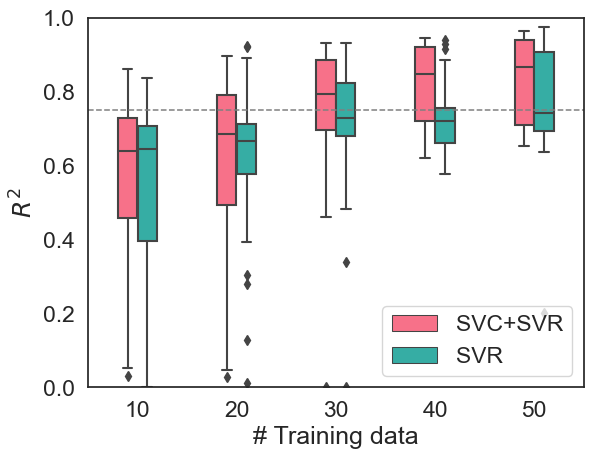

In [61]:
DABCLA = ComparisonResultsPlot([complexSVRR2Lists_DABCLA, SVRR2Lists_DABCLA], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

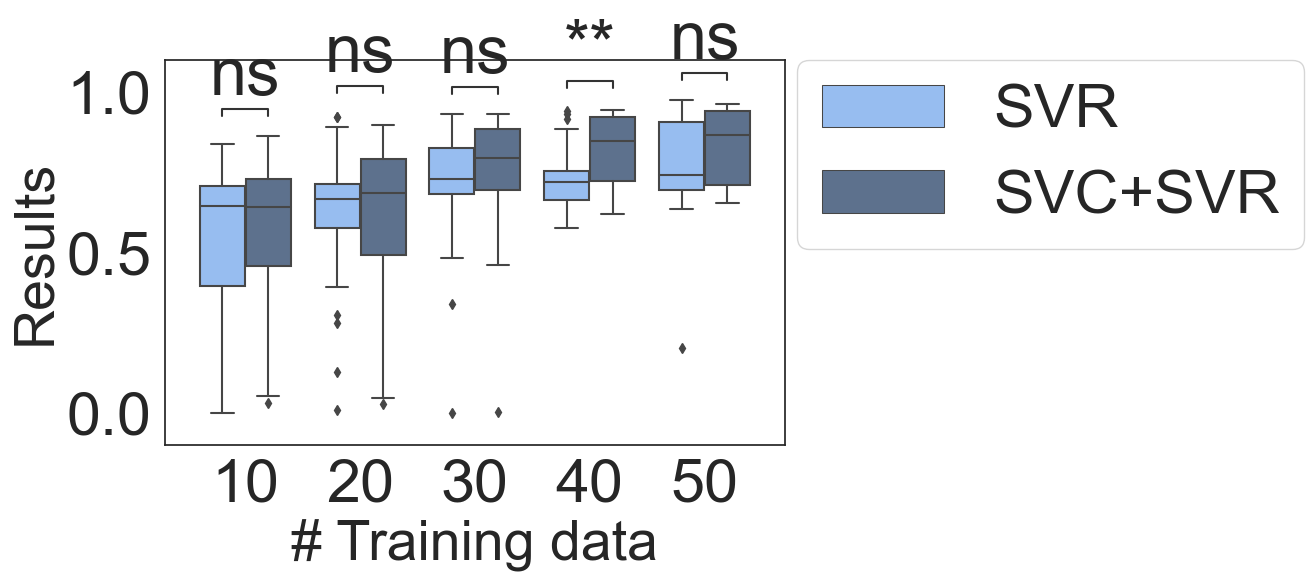

In [62]:
statsPlot(DABCLA)

here 0.0


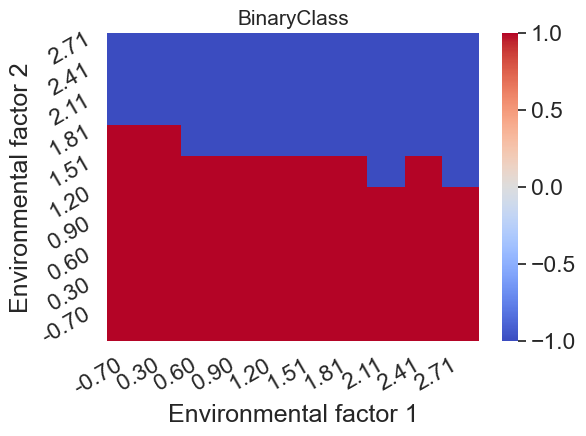

In [59]:
h = processExcelFormat02('HelenaExpDAHBSUL.xlsx', 'Sheet1', 0.4)
heatmapGenerator(h, 'BinaryClass')

here 0.7421177376171353


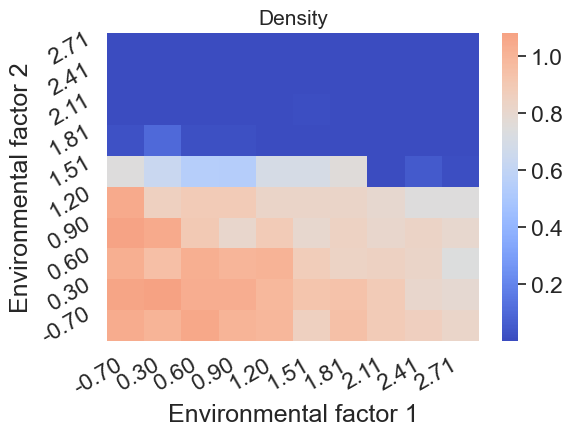

In [58]:
heatmapGenerator(h)

In [72]:
complexSVRSpearmanLists_DAHBSUL, complexSVRPearsonLists_DAHBSUL, complexSVRR2Lists_DAHBSUL, complexSVRMSELists_DAHBSUL, \
complexPredictedSVRSpearmanLists_DAHBSUL, complexPredictedSVRPearsonLists_DAHBSUL, complexPredictedSVRR2Lists_DAHBSUL, \
complexPredictedSVRMSELists_DAHBSUL, \
r2Recorder_DAHBSUL, mseRecorder_DAHBSUL, pearsonRecorder_DAHBSUL, spearmanRecorder_DAHBSUL, \
SVRSpearmanLists_DAHBSUL, SVRPearsonLists_DAHBSUL, SVRR2Lists_DAHBSUL, SVRMSELists_DAHBSUL, \
PredictedSVRSpearmanLists_DAHBSUL, PredictedSVRPearsonLists_DAHBSUL, PredictedSVRR2Lists_DAHBSUL, \
PredictedSVRMSELists_DAHBSUL, \
SVRr2Recorder_DAHBSUL, SVRmseRecorder_DAHBSUL, SVRpearsonRecorder_DAHBSUL, SVRspearmanRecorder_DAHBSUL,\
indexRecorder_DAHBSUL, TrainXDFRecorder_DAHBSUL, TrainYDFRecorder_DAHBSUL, \
SVMSVRFullXDFRecorder_DAHBSUL, SVMSVRFullYDFRecorder_DAHBSUL, scXRecorder_DAHBSUL, \
scDensityRecorder_DAHBSUL, scDistanceRecorder_DAHBSUL = \
ComparisonMultipleRun(30, 'HelenaExpDAHBSUL.xlsx',  2, 'Sheet1', [10,20,30,40,50], 0, ['poly', 'rbf'], 0.4)

10
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.8531829652342787
MSE:  0.057443810497749416
Pearson:  0.9236790379965754
Spearman:  1.0
R2:  0.9999995815455303
MSE:  0.013551304915230279
Pearson:  0.9999997907727433
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan -2.51970556e+00
 -1.94120045e+02 -1.40160080e-01  3.97594902e-01 -2.50779779e+00
             nan -2.00795478e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.36349734         nan         nan  0.94909129         nan -2.19442747
         nan  0.37702008 -2.3427655  -2.52036917]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.50916458e+00 -2.17164727e+00             nan  5.11212711e-01
 -2.50589749e+00 -2.16868633e+00 -1.08821404e+03             nan
  4.53154511e-01  6.60677421e-01]
  category=UserWarning,
/Users/ychha/anaconda3/l

R2:  0.9496360420307103
MSE:  0.057244423477163964
Pearson:  0.9744927100962375
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.734857231463739, 0.06186248137896089, 0.8474069873877206, 0.9150220810139689]
SVR:  [0.7349551198877681, 0.05918395870203464, 0.8572952349615431, 0.9120258140004561]
SVC(C=10000.0, gamma=0.001)
R2:  0.9629447920071158
MSE:  0.6934903517366608
Pearson:  0.9812975043314416
Spearman:  1.0
R2:  0.939068782320234
MSE:  0.3522652990552406
Pearson:  0.9690556136364072
Spearman:  1.0
R2:  0.93389239623794
MSE:  0.254661642306136
Pearson:  0.966381082305495
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6930360276276696, 0.13923744741926042, 0.8652395157618384, 0.9143882552995719]
SVR:  [0.7135427080708296, 0.0733017626590171, 0.8447145719536455, 0.8595829097611996]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.25575294167211443
MSE:  0.4999336672809174
Pearson:  0.5057202207467233
Spearman:  0.5
R2:  0.25632741765764516
MSE:  0.5389245234565655
Pearson:  0.5062878802199844
Spearman:  0.5
R2:  0.3570096341224358
MSE:  0.27154265996176813
Pearson:  0.5975028318949088
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan  -40123.13792303              nan -382004.08715947
              nan  -36748.57223215              nan              nan
              nan  -40157.97633419]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [             nan              nan              nan  -40151.37757525
              nan  -40122.83238486  -40158.00744347              nan
              nan -190250.60386515]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-pac

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/User

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.701369374406065, 0.2641640175578581, 0.903605431871425, 0.8557634924692492]
SVR:  [0.19633166655654752, 0.43583168384656346, 0.44309329328770886, 0.4213580725842584]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.1, degree=5, gamma=1.0, kernel='poly')
R2:  0.9686472111067094
MSE:  0.0744226110999468
Pearson:  0.9841987660562826
Spearman:  1.0
R2:  0.6750499583251485
MSE:  0.06758023048923216
Pearson:  0.8216142393636742
Spearman:  1.0
R2:  0.37633492515564476
MSE:  0.13073687242603918
Pearson:  0.6134614292322256
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -4.98194538e+01 -5.78450055e+00 -1.21462344e+02
 -1.80677546e+04             nan             nan             nan
 -8.41268655e+01 -1.21504608e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-119.70177008  -20.01838765           nan   -8.53734406 -121.3794386
           nan           nan           nan -121.07267132           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -22.94050982  -56.3008297            nan -120.78328414           nan
 -117.08812808 -204.605042             nan -121.49809421           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib

SVM:  [0.6371659272599293, 0.13919019656051276, 0.8374026139007953, 0.7886273557598824]
SVR:  [0.6808000750412838, 0.13499711061016206, 0.8251060992631696, 0.8224752952092347]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4)
R2:  0.8448160912219047
MSE:  0.6816981363027169
Pearson:  0.919138776911248
Spearman:  1.0
R2:  0.9999791679090776
MSE:  0.2809652883620902
Pearson:  0.9999895839002914
Spearman:  1.0
R2:  0.3338562670745335
MSE:  0.22437730256703095
Pearson:  0.577802965615904
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.97326899e+01 -8.60379402e-01             nan             nan
 -4.85513128e-01 -8.60379402e-01 -9.90408124e-01 -2.44977547e+01
 -7.92225687e-01 -9.67424665e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.19673139e-01  2.68137973e-01             nan -8.60319358e-01
             nan -8.00606321e+02 -2.68711583e-01 -5.99063511e-01
 -8.60381486e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-8.48573169e-01 -5.44499549e+01 -9.24504722e-03 -8.96162085e-01
  2.05055085e-02 -9.24504722e-03 -9.83382518e-01             nan
             nan -9.88229342e-01]
  categ

SVM:  [0.7985521013947509, 0.057231349370238216, 0.8576461307622671, 0.905514695298015]
SVR:  [0.5107074011026022, 0.12952969860112637, 0.7146379510651546, 0.722264980312247]
SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.923815701282275
MSE:  2095.4168616674133
Pearson:  0.9611533183016511
Spearman:  0.5
R2:  0.8683285099282047
MSE:  0.4335313267816912
Pearson:  0.9318414617992723
Spearman:  1.0
R2:  0.5305511766277025
MSE:  0.43356946448917233
Pearson:  0.7283894402225383
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*a

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support ve

SVM:  [0.7289620353888862, 0.4684473084521341, 0.8549295940412962, 0.4524699007821581]
SVR:  [0.5466488496445157, 0.20557820803479368, 0.7393570515282284, 0.8110877886158785]
SVC(C=10000.0, gamma=0.001)
R2:  0.9117759524334227
MSE:  0.11909592799385171
Pearson:  0.954869599701144
Spearman:  0.5
R2:  0.9286023892857618
MSE:  0.25085922757986695
Pearson:  0.9636401762513651
Spearman:  0.5
R2:  0.9807392491942515
MSE:  0.24732490518372585
Pearson:  0.9903228005020643
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.04924507e-01 -2.48039493e+05             nan -4.98089210e-01
 -8.80562754e-01 -3.06280027e-01             nan -7.03894399e-01
             nan             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-113.86467847   -0.69333791           nan   -0.70586053   -0.70501945
   -3.64936019   -3.69786464           nan           nan  -15.68167025]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.95259336e-01 -7.06081110e-01 -7.59977354e-01 -1.61492309e+01
 -7.62285937e+02 -1.61764099e+01             nan -1.56117083e+01
             nan -6.66275546e-01]
  category=UserWarning,
/Use

SVM:  [0.7053519390630565, 0.1578350951434793, 0.08143535233940775, 0.4345574949927532]
SVR:  [0.5821570259360896, 0.30607327474395574, 0.7629921532598414, 0.8222283501257033]
SVC(C=10.0, degree=4, gamma='auto')
R2:  0.02671921524889801
MSE:  15264.385267095393
Pearson:  -0.16346013351547833
Spearman:  0.5
R2:  0.9939533083173804
MSE:  0.11918334775816719
Pearson:  0.996972069978583
Spearman:  1.0
R2:  0.9602377138574782
MSE:  0.009522773190447921
Pearson:  0.9799171974495999
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.40642709 -0.29414449         nan -0.41243107  0.93047144         nan
  0.93542858 -0.28629843  0.94393768 -0.29187397]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan  0.5424172  -0.40651208         nan -0.2934067
 -0.31572489 -0.3976118  -0.08111448 -0.29420458]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.40636103         nan  0.88587688 -0.13766534  0.88587688
  0.95557134 -0.40093351 -0.39118381         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One

SVM:  [0.7451278324097549, 0.06763315307657644, 0.06616481417478542, 0.9080911556695246]
SVR:  [0.6699238150826315, 0.07081756485588554, 0.818488738519127, 0.818161987750222]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.19539214926720203
MSE:  0.5282889779369349
Pearson:  0.4420318419154915
Spearman:  0.5
R2:  0.8799896867458855
MSE:  0.04767227680810667
Pearson:  0.9380776549656673
Spearman:  1.0
R2:  0.9934715229592564
MSE:  0.2654704174068565
Pearson:  0.9967304163911406
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklear

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7187176780149236, 0.06954546853677654, 0.8771931768285921, 0.8566195687588245]
SVR:  [0.5939801673511347, 0.08092773082805528, 0.7707010881990081, 0.7742057628816567]
SVC(C=0.01, gamma=10.0, kernel='poly')
R2:  0.9998906903530368
MSE:  0.010755307932861358
Pearson:  0.9999453436828621
Spearman:  1.0
R2:  0.8786491562980148
MSE:  0.048573429633922395
Pearson:  0.9373628733302889
Spearman:  0.5
R2:  0.6585695920376938
MSE:  0.10255270254754667
Pearson:  0.8115230077069251
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.29293763e-01 -8.50770002e-02 -3.25683877e-01 -3.64564086e-01
 -1.14112414e+01 -1.08922157e-01 -2.42601556e+04 -3.64599171e-01
             nan -3.64544761e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.36460443 -0.36097244 -0.36431966 -0.04214912  0.32086751  0.24873329
 -0.30018623         nan -0.19280278 -0.32866532]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.312278    0.09730068 -0.36454716 -0.36459958 -1.16393618         nan
 -3.8813439          nan  0.14914437 -5.53914476]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

SVM:  [0.7847704731889197, 0.07266630068501749, 0.8590182795851811, 0.9050866571532274]
SVR:  [0.7268432316268458, 0.22190650425713118, 0.8525510140905626, 0.8447662047493236]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

SVC(C=1000.0, degree=5, gamma='auto', kernel='poly')
R2:  0.9996300984659184
MSE:  0.12857147124429033
Pearson:  0.9998150321264021
Spearman:  1.0
R2:  0.814438111387768
MSE:  0.22056298424085932
Pearson:  0.9024622492867875
Spearman:  1.0
R2:  0.96994360983948
MSE:  0.20729951335589158
Pearson:  0.984857151996918
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -2.75175716 -4.80838716 -0.202457   -0.19934077 -0.19811608
         nan -8.48366195 -0.1967667   0.59334452]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -2.19871172  -8.71845771 -11.15635011 -11.45781199 -11.2515766
  -3.797379    -0.18847618          nan  -0.19810849  -1.53527215]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan   0.04729794          nan -15.76572616 -21.34898182
   0.09028934 -19.0661762   -9.4179111   -0.20243146 -15.76572616]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:9

SVM:  [0.2108062235874234, 0.14647849605999272, 0.8720085427769324, 0.9016541204921429]
SVR:  [0.43685897893437015, 0.2599264032132174, 0.6609530837619038, 0.7106009408667867]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.6762527972359026
MSE:  0.06421957571818919
Pearson:  -0.8223459109376676
Spearman:  -0.5
R2:  0.6085380033447767
MSE:  0.012105851750318038
Pearson:  -0.7800884586665647
Spearman:  -0.5
R2:  0.9259334981275043
MSE:  0.00808284443967996
Pearson:  0.9622543832726898
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -6.93870286   -6.97204386 -284.88905716   -6.47230409   -4.056898
   -5.81923292           nan -749.72669817   -6.97021522   -6.96870071]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.49747373         nan -6.56955866  0.06696839 -2.12280704 -5.69503699
 -1.29132027 -2.39892487 -6.39336132 -1.14969791]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-7.18314010e+00 -6.44818997e+00 -6.97397261e+00 -4.46470780e+00
             nan -6.20618810e+00 -1.79510556e+01 -6.91447515e+00
 -4.93734368e+06 -4.36715851e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packa

SVM:  [0.6674399857049225, 1.413054057104786, 0.30523091374335204, 0.8115109335004463]
SVR:  [0.30812534917460094, 0.21115464822462668, 0.5550903972999359, 0.4961291358198822]
SVC(C=100.0, degree=4)
R2:  0.9024328648014036
MSE:  0.23293681110332143
Pearson:  0.9499646650278123
Spearman:  0.5
R2:  nan
MSE:  0.23293900781893004
Pearson:  nan
Spearman:  nan
R2:  nan
MSE:  0.23293900781893004
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.05492414 -5.2303088          nan -5.03695596 -6.27395351         nan
 -0.79510114 -0.79267119         nan -5.36275828]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -0.795093    -1.62860401          nan  -6.25333615          nan
 -81.56510397  -0.79265809          nan  -6.26595198  -0.80408822]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/sta

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict
    result = module.infer(policy, params, model, to_table(X))
ValueError: Input model support vectors are empty

  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-t

test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", lin

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVM:  [0.7515554535530493, 0.3042802602442463, 0.8237630960514211, 0.8562985401502338]
SVR:  [0.3285256019619368, 0.33241496763624234, 0.5731715292667082, 0.7885004089485329]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.7974703911567077
MSE:  0.05953110056111221
Pearson:  0.8930119770510965
Spearman:  1.0
R2:  0.8091921828158264
MSE:  0.05952144957431168
Pearson:  0.8995511007251487
Spearman:  1.0
R2:  0.8140343624175551
MSE:  0.0590863732931737
Pearson:  0.9022385285596908
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7090717447647559, 0.0698870376607491, 0.8453355361857146, 0.8840021401819154]
SVR:  [0.7142449779767661, 0.07007469554189441, 0.8451301544595168, 0.8971560274931061]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.7814004161661092
MSE:  0.520599147435765
Pearson:  0.8839685606208568
Spearman:  1.0
R2:  0.9766513656927007
MSE:  0.3095102330152166
Pearson:  0.9882567306589417
Spearman:  1.0
R2:  0.9785761334471925
MSE:  0.3826815838597817
Pearson:  0.9892300710386802
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -4.83912935          nan  -4.87700203          nan  -8.39349289
  -4.43735415  -1.67990561 -10.34993551          nan  -1.95708463]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.95708462 -1.0627993          nan         nan  0.34893025 -1.94153295
 -4.86997533 -1.95703373 -5.56085875 -1.08990998]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -1.95586083   -1.95708382 -157.27208269   -0.62812286   -1.87657881
   -4.62186259   -1.35132227           nan   -7.61738583           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_

SVM:  [0.7019977974380301, 0.259496474184985, 0.8378530882189494, 0.40606348004297865]
SVR:  [0.6670183007271931, 0.3459159394932653, 0.8167118835471872, 0.8561009840834087]
SVC(C=100.0, degree=4, gamma=0.0001)
R2:  0.7584281232132776
MSE:  0.153753526725905
Pearson:  0.8708777889079946
Spearman:  1.0
R2:  0.7577874221756764
MSE:  0.15352713264889065
Pearson:  0.870509863341982
Spearman:  1.0
R2:  0.881154506773517
MSE:  0.01859468371911718
Pearson:  0.9386983044479824
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7347462876740803, 0.3397893371470589, 0.8573445927091801, 0.9028851298514219]
SVR:  [0.10085504660790662, 0.29970947850832597, 0.3175768357546035, 0.8859612297814543]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.22090899840384448
MSE:  0.09236475559185109
Pearson:  0.47000957267256216
Spearman:  0.5
R2:  0.2503729384522514
MSE:  0.12949070871729815
Pearson:  0.5003727994728046
Spearman:  0.5
R2:  0.9093342455121518
MSE:  0.05327646020653808
Pearson:  0.9535901874034524
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.704895999259565, 0.45825433086782136, 0.8135750589499233, 0.7538245619875428]
SVR:  [0.11635076882707504, 92.40038667541207, 0.3411022849924563, 0.4766382662033399]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=2, gamma=10.0)
R2:  0.6899477089269752
MSE:  0.20003904056076058
Pearson:  0.8306309101682738
Spearman:  1.0
R2:  0.7424643743759203
MSE:  0.19406665577058194
Pearson:  0.8616637246489608
Spearman:  1.0
R2:  0.9518269184119409
MSE:  0.06424302886660573
Pearson:  0.9756161737137925
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.51107313         nan         nan -0.5021139          nan -0.45020163
 -1.46595265 -0.5021139          nan -2.37157017]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.01289479 -0.41616834         nan -1.48738114 -0.5103275  -2.45356753
 -0.51089388 -4.28647389         nan -4.86899565]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -1.52486667 -0.50697644 -0.51082228 -0.46765826 -0.51002865
 -0.51051554  0.0222187  -0.51205873         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: On

SVM:  [0.7906828301885753, 0.0689589421933919, 0.8920801205853923, 0.8890599212320482]
SVR:  [0.7589346199781228, 0.13001625727192953, 0.8711685370685304, 0.8875864822336452]
SVC(C=1000.0, degree=5, kernel='poly')
R2:  0.8870020719211442
MSE:  0.3033417291639107
Pearson:  0.9418078742085056
Spearman:  1.0
R2:  0.6129091828878369
MSE:  1.0230168584363681
Pearson:  0.782885165837134
Spearman:  1.0
R2:  0.2740031277599077
MSE:  2.096849082711541
Pearson:  -0.5234530807626483
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -13.04344262           nan   -5.55866987 -515.68347475   -5.46418192
           nan  -12.98348767  -12.99889091  -12.38598147  -13.0002625 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -12.9988884   -12.84004046           nan           nan   -4.04767831
           nan -721.67173826   -5.58432452  -10.3165011   -12.67426864]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan  -4.40501983  -8.55135202 -12.91900213  -3.45197031
          nan          nan -12.98095552 -12.9940485           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklea

SVM:  [0.8442109520262691, 0.3144203315436704, 0.8651465958073261, 0.9241590491046255]
SVR:  [0.7013365857787527, 0.07727648083737992, 0.8374584083873972, 0.8582000172934244]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svc.py", line 87, in 

SVC(C=10000.0, degree=2, gamma=0.0001, kernel='poly')
R2:  0.9358735527781977
MSE:  0.025585345624072203
Pearson:  -0.967405578223631
Spearman:  -1.0
R2:  0.8241863485744652
MSE:  0.023897808435725854
Pearson:  -0.9078470953714975
Spearman:  -0.5
R2:  0.7083107599908894
MSE:  0.019074524871947832
Pearson:  -0.8416120008595942
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -0.33431379   -0.33038309   -1.1860384    -0.33446302   -0.33359671
   -0.30032881   -0.26140241           nan   -0.33358343 -119.20356308]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan  3.84440000e-01             nan -1.02790551e+01
 -3.33981764e-01  1.16642436e-03 -5.94283292e+00 -6.61619696e+00
 -1.12268515e+00  5.80088205e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-3.07685001 -0.33449086 -0.40731044         nan -0.33448096 -1.01292244
 -0.33448096 -0.33206439         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pac

SVM:  [0.509847894020018, 0.17303965326098772, 0.7095958682507337, 0.319102436939102]
SVR:  [0.3566590986862833, 0.46078155235511026, 0.5972094261532415, 0.6470140497106217]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


SVC(C=1000.0, gamma=0.001)
R2:  0.6211386959108115
MSE:  0.1098036307007787
Pearson:  0.7881235283322097
Spearman:  0.5
R2:  0.9272123872524921
MSE:  0.11468284975984792
Pearson:  -0.96291868153676
Spearman:  -1.0
R2:  0.9828672214270867
MSE:  1.3391493881385328
Pearson:  -0.9913966014805006
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7310727720685496, 0.179143006825424, 0.830171850781394, 0.8282620416666506]
SVR:  [0.6123020951428821, 0.26384940885035935, 0.7824973451347182, 0.7463832834704672]
SVC(gamma='auto')
R2:  0.9994782159460025
MSE:  0.017871493958837862
Pearson:  0.9997390739317946
Spearman:  1.0
R2:  0.9996741824253694
MSE:  0.02073612249751595
Pearson:  0.9998370779408858
Spearman:  1.0
R2:  0.9993280946511239
MSE:  0.015361023059055942
Pearson:  0.9996639908744953
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.730297273133715, 0.05045660459306599, 0.763494437329431, 0.8924842263903486]
SVR:  [0.6919006951695993, 0.07929467667420946, 0.8318056835400915, 0.8989212615677302]
SVC(C=100.0, degree=4, gamma=10.0)
R2:  0.2494095203114345
MSE:  0.2298337623939577
Pearson:  0.49940917123280226
Spearman:  0.5
R2:  0.9999960556677155
MSE:  0.0559811124622012
Pearson:  0.9999980278319128
Spearman:  1.0
R2:  0.9999551862040392
MSE:  0.007259623054609533
Pearson:  0.9999775928509793
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.1331083  -1.06444363 -1.03817547         nan -0.46686542 -1.13280234
 -0.37154071 -1.13303951 -1.10818029 -0.39656252]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.6348352989706655, 0.11440827943720237, 0.8225635455477971, 0.7554790940472023]
SVR:  [0.07141098788268105, 0.20933218221037053, 0.2672283440855048, 0.3261400933418392]
SVC(degree=4, gamma=0.1)
R2:  0.9985487030084887
MSE:  0.4514529193323818
Pearson:  0.9992740880301504
Spearman:  1.0
R2:  0.9997330737337444
MSE:  0.11029994210201012
Pearson:  0.9998665279594793
Spearman:  1.0
R2:  0.9953408095131169
MSE:  0.07229314454932022
Pearson:  0.9976676849097184
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.00310001         nan         nan -0.32511787 -1.50388494
 -0.40159907 -0.32723994 -0.39378101 -0.39378118]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict

  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 139, in _onedal_predict
    return self._onedal_estimator.predict(X, queue=queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 366, in predict
    y = super()._predict(X, _backend.svm.regression, queue)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/onedal/svm/svm.py", line 281, in _predict


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.7370807470520495, 0.033692730143941814, 0.9119063969972809, 0.8947314266504831]
SVR:  [0.6896981846156944, 0.10317527114056155, 0.8304806949084931, 0.8466841448980831]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.62336906         nan -2.03833408         nan         nan -4.64257667
         nan         nan -1.01273067 -4.64082882]
  category=UserWarning,


SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.6180955811812459
MSE:  0.048332287012128085
Pearson:  0.78619055017295
Spearman:  1.0
R2:  0.6592728428306549
MSE:  0.0526228041207637
Pearson:  0.811956182826792
Spearman:  1.0
R2:  0.6788284584188985
MSE:  0.04735183844419927
Pearson:  0.8239104674774429
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.47318302 -4.42257708 -4.60380189 -4.4264184  -0.19343036 -0.19086692
 -4.44292191 -4.08489567         nan -4.64080795]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.44040707 -4.60236155         nan -4.64277087 -4.544579           nan
         nan -1.68346948 -0.5396237          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-9.20354305e-01 -1.02640842e-02             nan -1.99274216e-01
             nan -4.86800913e+02 -4.78446584e+01 -9.17817725e-01
 -7.96015667e+03 -4.44292189e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.p

SVM:  [0.8097861618481454, 0.05866221596495105, 0.8936053986935697, 0.9292258303494257]
SVR:  [0.7536742290392119, 0.10369574511588385, 0.8681441291854779, 0.9032308515454582]
SVC(C=100.0, gamma=0.01)
R2:  0.9999959794838206
MSE:  0.27309901855443336
Pearson:  0.9999979897398897
Spearman:  1.0
R2:  0.9891668396405067
MSE:  0.039642421664504685
Pearson:  0.9945686701482741
Spearman:  1.0
R2:  0.9848355748307588
MSE:  0.04257156911693566
Pearson:  0.9923888224031744
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7302753097694283, 0.060460806060188915, 0.8553855076466509, 0.9157097584063876]
SVR:  [0.8442994008518563, 0.034963400996365045, 0.9188576608223153, 0.8960200847841296]
SVC(C=1000.0, degree=2, gamma=0.01)
R2:  0.9925155351106576
MSE:  0.13232385077921266
Pearson:  0.9962507390765929
Spearman:  1.0
R2:  0.9580276647013286
MSE:  0.09916131914511499
Pearson:  0.9787888764699608
Spearman:  1.0
R2:  0.9914934723066621
MSE:  0.1346085978543601
Pearson:  0.9957376523495846
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7919433538408407, 0.24114349219304743, 0.40434805275788477, nan]
SVR:  [0.7204513902869683, 0.13223266035364534, 0.848794080025873, 0.907967683127759]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=100.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.8937070069872293
MSE:  0.09105920185581594
Pearson:  0.9453607813883698
Spearman:  1.0
R2:  0.9626335126074643
MSE:  0.05489088519691843
Pearson:  0.9811388854833267
Spearman:  1.0
R2:  0.781460406051292
MSE:  0.08196915317149957
Pearson:  0.8840024921069465
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.49944022e-01 -1.19057285e-01             nan -4.14624919e-01
 -5.48647054e-02 -3.35985859e-01 -4.38873438e-01  1.12841258e-01
  3.12682784e-01 -2.05765977e+02]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -5.49816446e-01             nan -5.58279877e-01
 -5.49946738e-01 -1.54750835e+02  8.61684736e-02 -2.05454947e-01
  7.85572880e-01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.64726999         nan         nan -0.46980315 -0.3269954  -0.4695504
 -0.54633738  0.2940239          nan -0.46117559]
  category=UserWarning,
/Users/ychha/anaconda3/li

SVM:  [0.02027374032358355, 0.4397359106037161, 0.852103803631254, 0.0867514507963946]
SVR:  [0.7456135478870036, 0.09352379014039018, 0.8634891706831088, 0.9164341276700826]
SVC(degree=2)
R2:  0.8727394771796104
MSE:  0.011182806851853709
Pearson:  0.9342052650138567
Spearman:  1.0
R2:  0.8468032446768315
MSE:  0.012319187016762845
Pearson:  0.9202191286192823
Spearman:  1.0
R2:  0.9926842996607212
MSE:  0.0038369977743336644
Pearson:  0.9963354353131886
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7449793437717677, 0.05135864941055218, 0.33647117560845624, 0.811713380252706]
SVR:  [0.7212506008908576, 0.14368153737869024, 0.849264741344451, 0.89931267234638]
SVC(C=10000.0, gamma='auto')
R2:  0.7953738998949116
MSE:  0.1008190664569595
Pearson:  0.8918373730086172
Spearman:  1.0
R2:  0.9997103788621193
MSE:  0.23360490332840592
Pearson:  0.9998551789444905
Spearman:  1.0
R2:  0.9998382354497756
MSE:  0.016241704780978833
Pearson:  0.9999191144536521
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.09597100e+01 -1.30387872e+01 -2.18592694e+01 -1.73813410e+03
 -3.57242855e+07             nan -2.18387602e+01 -2.20421783e+00
 -2.18111041e+01             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-21.8680088  -21.96201128 -21.84662102 -21.80407553 -21.86144358
          nan -21.85214379 -21.81110552 -21.85362425 -21.81110552]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -4.70155221  -10.16124182  -21.81110524           nan  -19.27722147
 -302.23448371           nan   -7.71549045  -21.73601537           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.

Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 159, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/skle

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVM:  [0.04398588114014097, 0.21843528587503747, 0.8782210139959278, 0.8960073095820613]
SVR:  [0.7176748985694904, 0.06949518121270772, 0.8471569503754844, 0.9004605525884085]
20
SVC(C=1000.0, degree=5, gamma=0.0001)
R2:  0.7802813711811845
MSE:  0.07718366491766897
Pearson:  0.8833353673329198
Spearman:  1.0
R2:  0.688377321521714
MSE:  0.09328243063819419
Pearson:  0.8296850737006869
Spearman:  1.0
R2:  0.8330416686880294
MSE:  0.061913098265380793
Pearson:  0.9127111638892279
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.842668720705391, 0.05891674255008648, 0.8567669896934917, 0.9068682606657292]
SVR:  [0.7562248207120696, 0.054656612069794684, 0.8696118793531222, 0.9098218471636195]
SVC(C=10000.0, degree=4, gamma=0.01)
R2:  0.9880478648937883
MSE:  0.8846486000469954
Pearson:  0.9940059682385154
Spearman:  0.7999999999999999
R2:  0.9609270881383339
MSE:  0.8966961003149737
Pearson:  0.9802688856320668
Spearman:  0.39999999999999997
R2:  0.9874831208664876
MSE:  0.8966874652871754
Pearson:  0.9937218528675357
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.702717924606539, 0.06548120292618839, 0.8520026617467027, 0.8972339428035631]
SVR:  [0.45197873503081504, 0.22521784740858908, 0.6722936375058264, 0.8434296966254572]
SVC(C=100.0, gamma=0.01)
R2:  0.946566211699964
MSE:  0.02352230259736891
Pearson:  0.9729163436287642
Spearman:  1.0
R2:  0.9459622256594893
MSE:  0.01906241630926771
Pearson:  0.9726058943166496
Spearman:  1.0
R2:  0.9452502719032028
MSE:  0.01959429364372526
Pearson:  0.9722398222163102
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7246435318446438, 0.06713124228256555, 0.853958439435581, 0.93398968588842]
SVR:  [0.7281006800235709, 0.07061402757744598, 0.8532881576721731, 0.9149789029535865]
SVC(C=10000.0, degree=2, gamma=10.0, kernel='poly')
R2:  0.9811407053556196
MSE:  0.34569468162684985
Pearson:  0.9905254693119303
Spearman:  0.6000000000000001
R2:  0.9889358410688566
MSE:  0.24328141077973878
Pearson:  0.9944525333412635
Spearman:  0.7999999999999999
R2:  0.8184399582441718
MSE:  0.12269353676151738
Pearson:  0.9046767147684149
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7155031230405599, 0.06264967942520558, 0.83082028860147, 0.9150663095932424]
SVR:  [0.7490443570290942, 0.30193064048051566, 0.8654734871901594, 0.9025486553639239]
SVC(C=1000.0, degree=2)


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.13168299  0.37305393 -1.12775313         nan         nan -0.06964991
         nan -1.15136082 -0.0980807   0.33756285]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -1.04427754         nan         nan
 -1.32374102  0.31526047         nan  0.31772243]
  category=UserWarning,


R2:  0.5428413841235056
MSE:  0.049657602972389546
Pearson:  0.7367777033295091
Spearman:  0.39999999999999997
R2:  0.8861633985794403
MSE:  0.2838997822467351
Pearson:  0.9413625224000797
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 4.24940341e-01  4.56928594e-01             nan -1.10564559e+03
 -9.98462283e-01             nan -8.74206709e+00 -1.31822537e+00
             nan             nan]
  category=UserWarning,


R2:  0.7368498723710015
MSE:  0.014766997233158188
Pearson:  0.8583995994704343
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan -3.36883775e+06 -9.47973455e-01  3.32188525e-01
             nan  4.01041742e-01 -1.32949128e+00 -2.89265481e+00
 -1.31906383e+00 -1.16161865e+00]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.005699614751552231, 0.03344218155013203, 0.9129016190362609, 0.8842944210032818]
SVR:  [0.7143322116966331, 0.06132972217894657, 0.8451817625201301, 0.8184950773558368]
SVC(C=0.1, gamma=1.0)
R2:  0.9293884562777913
MSE:  0.09693012764708689
Pearson:  0.9640479533082317
Spearman:  0.7999999999999999
R2:  0.9333482069165937
MSE:  0.03537172482935437
Pearson:  0.9660994808592916
Spearman:  0.7999999999999999
R2:  0.9333066669687791
MSE:  0.035363133286008694
Pearson:  0.9660779818258869
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7596914348001522, 0.04011419920549106, 0.8919794660828172, 0.9012007806107669]
SVR:  [0.7259079310213316, 0.07070245708274175, 0.8520023069342777, 0.9152772812937365]
SVC(C=10000.0, gamma='auto')
R2:  0.6175229568548424
MSE:  0.11005846004741779
Pearson:  0.7858262892362677
Spearman:  0.7999999999999999
R2:  0.864848192068603
MSE:  0.07349646397793877
Pearson:  0.9299721458563173
Spearman:  0.7999999999999999
R2:  0.9564625801691016
MSE:  0.0934356017005842
Pearson:  0.9779890491048974
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8452883141965577, 0.030353834477487955, 0.9166112121087493, 0.8959850913485509]
SVR:  [0.8587860913716594, 0.02904586130202629, 0.9267071227586738, 0.895106042596492]
SVC(C=1000.0, degree=5)
R2:  0.8696695374148302
MSE:  0.24341057541138605
Pearson:  0.9325607419438321
Spearman:  0.7999999999999999
R2:  0.8647208142757038
MSE:  0.2026440010194685
Pearson:  0.9299036585989452
Spearman:  0.7999999999999999
R2:  0.9678533886051167
MSE:  0.027398225200958647
Pearson:  0.9837953997682224
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8748871086458917, 0.07766553526821444, 0.9336362284971069, 0.8977197475526137]
SVR:  [0.8214728686798789, 0.03792613710373571, 0.906351404632816, 0.8925274995904526]
SVC(gamma=0.0001)
R2:  0.9772115060725043
MSE:  0.034337153584240276
Pearson:  0.9885400882475655
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -1325.3343085  -29338.60192542 -25001.33783683 -29824.16385967
 -29819.73347128             nan  -3064.63659275  -4727.3404566
  -1358.36331542 -12996.25823407]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.97754235e+04 -2.83844467e+04 -2.76801463e+04 -2.88482617e+04
             nan -2.97951411e+04 -2.89950846e+04 -2.97752388e+04
 -5.60786319e+06 -4.68995788e+03]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan  -3069.10168634 -28944.41183027 -18689.5589437
             nan             nan -29824.6418754   -8629.13740844
             nan -28777.20316551]
  categor

R2:  0.966813799643941
MSE:  0.0229420987958451
Pearson:  0.9832669015297631
Spearman:  1.0
R2:  0.9495358700300919
MSE:  0.019042213145168883
Pearson:  0.9744413117423194
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-16430.27018629 -29807.13924439             nan             nan
 -29824.60718871  -4898.47911959 -22765.5526634              nan
  -3066.61673589 -29775.80747168]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted with

SVM:  [0.5734560119952126, 0.03888850035026535, 0.8528616925991593, 0.8964070347495392]
SVR:  [0.7273611897566549, 0.08732447775928742, 0.8528547295739495, 0.8964070347495392]
SVC(degree=2, gamma=1.0)
R2:  0.7875690887197234
MSE:  0.06798270674576676
Pearson:  0.8874508936948134
Spearman:  1.0
R2:  0.9905325334605177
MSE:  0.00348126860210478
Pearson:  0.9952550092617055
Spearman:  1.0
R2:  0.9998956124498541
MSE:  0.009229295840774247
Pearson:  0.999947804862761
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7886313424618822, 0.12867666635849373, 0.9097199550324007, 0.8842996032711814]
SVR:  [0.8028903495168328, 0.040110576687705526, 0.8960414887251776, 0.8968524194505824]
SVC(C=10.0, degree=4)
R2:  0.392840283228283
MSE:  0.11103487822233028
Pearson:  0.6267697210525434
Spearman:  0.19999999999999998
R2:  0.789828918070116
MSE:  0.06618011610177403
Pearson:  0.8887231954158259
Spearman:  0.19999999999999998
R2:  0.9521871245651305
MSE:  0.08422945912652181
Pearson:  0.975800760690998
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8496379158432492, 0.031073653080637392, 0.9217587029572909, 0.9304500703234881]
SVR:  [0.7436820691957952, 0.05685864215259888, 0.8623700303209733, 0.9154711673699015]
SVC(gamma=10.0, kernel='poly')
R2:  0.9756595080274433
MSE:  0.14423536312388754
Pearson:  0.9877547813235039
Spearman:  0.19999999999999998
R2:  0.998148026125978
MSE:  0.23537673333623912
Pearson:  0.9990735839396306
Spearman:  0.7999999999999999
R2:  0.9986668474776002
MSE:  0.22700375033976958
Pearson:  0.9993332014286329
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6727839066788495, 0.08186672265151258, 0.7691265802784909, 0.9255211294177293]
SVR:  [0.6960667986680131, 0.06232850482226572, 0.8343061780114136, 0.9092880291297087]
SVC(C=100.0, degree=5, gamma='auto')
R2:  0.9058048714424707
MSE:  0.043243967364529526
Pearson:  0.9517378165453294
Spearman:  1.0
R2:  0.8487249860854316
MSE:  0.057521176519800966
Pearson:  0.9212627128487465
Spearman:  0.7999999999999999
R2:  0.9836048330502473
MSE:  0.035023401560264206
Pearson:  0.9917685380421419
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6427685955575914, 0.08535214985862365, 0.7973104200588081, 0.840576652601969]
SVR:  [0.7518986099606086, 0.06810776902017036, 0.8671208739043292, 0.9026957337083921]
SVC(C=100.0, degree=5)
R2:  0.8137656722602793
MSE:  0.1986583688423616
Pearson:  0.9020896143179343
Spearman:  0.7999999999999999
R2:  0.7482258583787026
MSE:  0.09636819245053571
Pearson:  0.8650004961725183
Spearman:  0.39999999999999997
R2:  0.7489053172808682
MSE:  0.09638424926229942
Pearson:  0.865393157634649
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8163710700885508, 0.041787045050007646, 0.6940639333257812, 0.762611345522738]
SVR:  [0.007977750970259354, 10.392207415089938, 0.08931825664588042, 0.11225972808251292]
SVC(degree=2)
R2:  0.9164856245171206
MSE:  0.034621436210794165
Pearson:  0.9573325569085804
Spearman:  1.0
R2:  0.9211280118944452
MSE:  0.03219538310114215
Pearson:  0.9597541413791582
Spearman:  1.0
R2:  0.9940564080093328
MSE:  0.00343654552588207
Pearson:  0.9970237750471812
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8142177875330459, 0.031939047747874184, 0.9565502251029462, 0.9215361084083957]
SVR:  [0.7348774292426676, 0.05897977724186274, 0.8572499222762678, 0.9191919784029053]
SVC(degree=4)
R2:  0.8732044083305024
MSE:  0.02466008522706945
Pearson:  0.9344540696741078
Spearman:  0.7999999999999999
R2:  0.9566326338171276
MSE:  0.013289545106092
Pearson:  0.9780759857072086
Spearman:  1.0
R2:  0.9655888370425456
MSE:  0.009576525354824632
Pearson:  0.982643799676437
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.755641857339261, 0.060222805753099816, 0.8628007890025482, 0.9013127051101736]
SVR:  [0.6859331918103638, 0.06457084115973004, 0.8282108377764471, 0.850632911392405]
SVC(C=10.0, degree=4, gamma=0.01)
R2:  0.8225300008369222
MSE:  0.027261874031801504
Pearson:  0.9069343972068332
Spearman:  1.0
R2:  0.8827100819616032
MSE:  0.07429308061526191
Pearson:  0.9395265200948842
Spearman:  1.0
R2:  0.8835627278772064
MSE:  0.06887194148097016
Pearson:  0.9399801741936935
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7495248394586144, 0.07606527699186728, 0.8184534971570149, 0.8587720275113916]
SVR:  [0.7190044675871963, 0.06298958810103936, 0.8479413114049795, 0.9007788372097786]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.20975117487162953
MSE:  0.00631744333290927
Pearson:  0.4579859985541366
Spearman:  0.6000000000000001
R2:  0.8407241323265533
MSE:  0.006461652313268205
Pearson:  0.9169101004605374
Spearman:  1.0
R2:  0.17406776452763248
MSE:  0.0067490543628716
Pearson:  0.4172142908957368
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7449980966998997, 0.3290258515140918, 0.4318327031683252, 0.9067212067736967]
SVR:  [0.6319080889579579, 0.35492952584598003, 0.7949264676421067, 0.8013267931477233]
SVC(C=0.01, gamma=0.1)
R2:  0.9139071749588481
MSE:  0.22796353187999088
Pearson:  0.955984924022784
Spearman:  1.0
R2:  0.911249295160882
MSE:  0.22145606556311234
Pearson:  0.9545937854191604
Spearman:  1.0
R2:  0.9108512971904569
MSE:  0.08346637425559827
Pearson:  0.9543852980795842
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.729983055651231, 0.029617792779851066, 0.8164206534883285, 0.86544772620722]
SVR:  [0.23274551953329156, 0.49704584150824943, 0.48243706276911547, 0.7707688701359589]
SVC(degree=4)
R2:  0.9531635643631707
MSE:  0.1292487158450379
Pearson:  0.9763009599315011
Spearman:  1.0
R2:  0.8587053711239826
MSE:  0.025198629231709534
Pearson:  0.9266635695461339
Spearman:  0.7999999999999999
R2:  0.8332620967273181
MSE:  0.05161220781304936
Pearson:  0.9128319104453555
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7455922617991704, 0.039657398132290834, 0.8517534025521392, 0.885349273323957]
SVR:  [0.7480032328575001, 0.05184337055806394, 0.8648718014003579, 0.9192217533989686]
SVC(C=10.0, gamma=1.0, kernel='poly')
R2:  0.8762958870862939
MSE:  0.11598539868907085
Pearson:  0.9361067711998958
Spearman:  1.0
R2:  0.9002313926525042
MSE:  0.08186795683190529
Pearson:  0.9488052448487542
Spearman:  1.0
R2:  0.8517801669948682
MSE:  0.15570364880673493
Pearson:  0.9229193718818933
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7551804599053151, 0.058332258828291586, 0.8185269770939989, 0.8994661244067041]
SVR:  [0.8728493771371707, 0.02643099052987094, 0.9342640831891009, 0.9333153616859847]
SVC(C=10.0, degree=4)
R2:  0.7380996152472308
MSE:  0.09016840172456411
Pearson:  0.8591272404290478
Spearman:  0.7999999999999999
R2:  0.894681900489146
MSE:  0.6938431747828543
Pearson:  -0.9458762606647583
Spearman:  -0.7999999999999999
R2:  0.4665785343071769
MSE:  0.10552215339437984
Pearson:  0.6830655417360598
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.3984086344241147, 0.09013638849864966, 0.011708547728241817, 0.11863572433192686]
SVR:  [0.7472976933144359, 0.09894904530051704, 0.8644638183952154, 0.9265822784810127]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.586379462186213
MSE:  0.057887363908481836
Pearson:  0.7657541786932757
Spearman:  0.39999999999999997
R2:  0.8432259724204627
MSE:  0.027894079256826656
Pearson:  0.9182733647560858
Spearman:  0.39999999999999997
R2:  0.8429588316615795
MSE:  0.02747059459379644
Pearson:  0.9181278950459896
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.845272657547187, 0.04585862187109875, 0.9195478042133012, 0.859985935302391]
SVR:  [0.6926818140055659, 0.0673840178488967, 0.8322750831339153, 0.8296999531176747]
SVC(C=1000.0, degree=4, gamma=0.1)
R2:  0.9426406675831066
MSE:  0.09277422539080964
Pearson:  0.9708968367355548
Spearman:  0.7999999999999999
R2:  0.9018768148078037
MSE:  0.1639275047088364
Pearson:  0.949671951153557
Spearman:  1.0
R2:  0.8793981033996727
MSE:  0.11281939926949226
Pearson:  0.9377622851232995
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8311403702587169, 0.10855042626667544, 0.9261971875922107, 0.8759962494139709]
SVR:  [0.7708868999798631, 0.10855056045838714, 0.878001651467617, 0.893483356774496]
SVC(degree=2)
R2:  0.7669452039209883
MSE:  0.10287711394690785
Pearson:  0.8757540773076584
Spearman:  0.7999999999999999
R2:  0.9702617779501108
MSE:  0.0562468585588625
Pearson:  0.9850186688332923
Spearman:  0.7999999999999999
R2:  0.9591606687444248
MSE:  0.0662222098910255
Pearson:  0.9793674840142617
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7714617386441304, 0.08056071305375385, 0.8474314726343876, 0.896741678387248]
SVR:  [0.7515519167431208, 0.06989881389758643, 0.866920940307201, 0.9057899671823723]
SVC(C=1000.0, degree=5, gamma=0.0001)
R2:  0.961298237767706
MSE:  0.03232575288381788
Pearson:  0.9804581774699549
Spearman:  0.7999999999999999
R2:  0.962515420521368
MSE:  0.04219010848856212
Pearson:  0.9810787025113569
Spearman:  0.7999999999999999
R2:  0.9620455086462504
MSE:  0.03297484801757228
Pearson:  0.9808391859251192
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7268280726105181, 0.0707377693227148, 0.4512710331734607, 0.9011890599607395]
SVR:  [0.7268931901951481, 0.07468828144325038, 0.8525803130468989, 0.9015992827117002]
SVC(C=1000.0, degree=4, gamma=1.0)
R2:  0.7883529055317131
MSE:  0.18445907585137425
Pearson:  0.8878923952437667
Spearman:  1.0
R2:  0.8046170044982983
MSE:  0.26822938302876476
Pearson:  0.8970044618051229
Spearman:  0.7999999999999999
R2:  0.946820888919785
MSE:  0.013246229480974476
Pearson:  0.9730472182375249
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7382711537824669, 0.070605636119787, 0.8592211035048203, 0.9337490257370005]
SVR:  [0.6846074237054399, 0.2915730570009224, 0.8274100698598246, 0.8467583612332534]
SVC(C=0.01, degree=4, gamma=0.1)
R2:  0.9604023494316674
MSE:  0.03511019141271954
Pearson:  0.9800011986888929
Spearman:  0.39999999999999997
R2:  0.937932246596648
MSE:  0.0498811194968455
Pearson:  0.9684690220118801
Spearman:  0.39999999999999997
R2:  0.9711071209247952
MSE:  0.03430230182454083
Pearson:  0.9854476753865702
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.823480528710364, 0.037297097847108274, 0.8953550155078933, 0.918917018284107]
SVR:  [0.7322522177177606, 0.05370710075040188, 0.8557173702325792, 0.9056493202062822]
SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.6766978976182709
MSE:  0.03511630007939022
Pearson:  0.8226164948615307
Spearman:  0.39999999999999997
R2:  0.9731896966084006
MSE:  0.28487409747063736
Pearson:  0.9865037742494456
Spearman:  1.0
R2:  0.7727274932309831
MSE:  0.025921281879905833
Pearson:  0.8790491984132531
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7453171097332718, 0.21411301224409168, 0.8626659914520995, 0.8938519330435547]
SVR:  [0.7431213655357147, 0.06310876350925515, 0.8620448744327143, 0.8956217511976999]
SVC(C=10.0, gamma=1.0)
R2:  0.7168004803675154
MSE:  0.1256580730111324
Pearson:  0.8466407032310198
Spearman:  0.7745966692414834
R2:  0.06152511440979059
MSE:  0.06031503279678779
Pearson:  0.24804256572167327
Spearman:  0.39999999999999997
R2:  0.09991740546038068
MSE:  0.003913354848407785
Pearson:  0.31609714560618973
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.716027557778551, 0.03947105415223784, 0.8468126122195975, 0.9107062277830303]
SVR:  [0.7112964728734238, 0.07983707840012833, 0.8433839415553416, 0.8847684292722796]
30
SVC(C=10000.0, degree=2, gamma=0.01)
R2:  0.8988535098051449
MSE:  0.03127061267582521
Pearson:  0.9480788521031072
Spearman:  1.0
R2:  0.7979887009680043
MSE:  0.053071266756316265
Pearson:  0.8933021330815258
Spearman:  1.0
R2:  0.7255589610032687
MSE:  0.05320021642214892
Pearson:  0.8517974882583705
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7565503308566619, 0.04685327099088089, 0.8707640112015081, 0.8443180824074884]
SVR:  [0.34736566060156265, 0.1366409265569255, 0.5893773499224095, 0.8588399965007436]
SVC(C=1000.0, gamma=0.1)
R2:  0.05733830186802069
MSE:  0.01019955230639384
Pearson:  0.23945417488116744
Spearman:  0.2
R2:  0.8901587024409131
MSE:  0.0164061390163478
Pearson:  0.9434822215817917
Spearman:  0.8857142857142858
R2:  0.8904737868203644
MSE:  0.01639563617346935
Pearson:  0.9436491863083253
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8849994310323531, 0.1246808003528901, 0.8520708896445501, 0.8884864709155564]
SVR:  [0.7118304348381848, 0.06017634041468749, 0.8437004414116329, 0.8858445092151519]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.8461116685626987
MSE:  0.0432417419524638
Pearson:  0.919843284784261
Spearman:  0.942857142857143
R2:  0.7724172064450661
MSE:  0.038778632772061554
Pearson:  0.8788726906924952
Spearman:  0.8857142857142858
R2:  0.654237409166049
MSE:  0.08855356330669019
Pearson:  0.8088494354118381
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7186590809917817, 0.034383780240444556, 0.9399024076525736, 0.9178024669757677]
SVR:  [0.7063777973991675, 0.06292611910222241, 0.8404628471260154, 0.9115387980054238]
SVC(C=1000.0, degree=2)
R2:  0.9055647908947048
MSE:  0.1060887066935997
Pearson:  0.9516116807262849
Spearman:  0.8285714285714287
R2:  0.8111875072024038
MSE:  0.041946346168451325
Pearson:  0.9006594846013692
Spearman:  0.8285714285714287
R2:  0.9062477154236703
MSE:  0.02162930081750078
Pearson:  0.9519704383139589
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8373602294908037, 0.030858434142987435, 0.9508138267351692, 0.9153434987971535]
SVR:  [0.7626505720756539, 0.21577417678709104, 0.8732986728924155, 0.9109868864567511]
SVC(degree=5, gamma='auto')
R2:  0.7675492190456656
MSE:  0.19187069918607058
Pearson:  0.876098863739513
Spearman:  0.7714285714285715
R2:  0.8880956339610003
MSE:  0.04042004139006319
Pearson:  0.9423882607296211
Spearman:  0.5428571428571429
R2:  0.8965258715247914
MSE:  0.03338241405959553
Pearson:  0.9468505011483025
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8813238047307594, 0.023658676845220612, 0.9524286979638633, 0.9101995468771603]
SVR:  [0.8488944976702565, 0.0306557568282321, 0.9213547078461458, 0.9196826147024538]
SVC(C=100.0, gamma=0.001)
R2:  0.9168786975805293
MSE:  0.016333647385009222
Pearson:  0.9575378308873908
Spearman:  0.7714285714285715
R2:  0.7271184198455652
MSE:  0.037029979891812746
Pearson:  0.8527123898745492
Spearman:  0.7714285714285715
R2:  0.6883442886031663
MSE:  0.09108996549644095
Pearson:  0.8296651665600806
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7640171535833518, 0.0905905096475664, 0.8337666218262006, 0.8958874629637099]
SVR:  [0.765551122129264, 0.08942724109007208, 0.8749577830554249, 0.8957474914828938]
SVC(C=10.0, degree=5, gamma=0.01)
R2:  0.8082052150436044
MSE:  0.04868678267462347
Pearson:  0.8990023442926078
Spearman:  0.8285714285714287
R2:  0.7771238796922506
MSE:  0.0654788616264669
Pearson:  0.8815463003678544
Spearman:  0.942857142857143
R2:  0.5570536226817921
MSE:  0.09314622502466162
Pearson:  0.746360249934167
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7516272573592486, 0.03651169397480074, 0.8599580990361226, 0.8853643600734844]
SVR:  [0.8553629327114707, 0.03677504038222174, 0.924858331157519, 0.910803954159741]
SVC(C=100.0, degree=2, gamma=0.1)
R2:  0.7414091420661825
MSE:  0.10317085743397934
Pearson:  0.8610511843474713
Spearman:  0.7714285714285715
R2:  0.7702662506168497
MSE:  0.023867401605493024
Pearson:  0.8776481359957702
Spearman:  0.7714285714285715
R2:  0.9547939113669606
MSE:  0.012202281052765836
Pearson:  0.9771355644776014
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8360772386289395, 0.0511834330471365, 0.9153980981698521, 0.886159445046988]
SVR:  [0.79234737223952, 0.3058232430489018, 0.8901389623196594, 0.876081498428226]
SVC(C=10000.0, gamma=0.0001)
R2:  0.96791081433213
MSE:  0.043887055359949724
Pearson:  0.9838245851431695
Spearman:  0.8285714285714287
R2:  0.9808968052920426
MSE:  0.015919474179118424
Pearson:  0.9904023451567765
Spearman:  0.8857142857142858
R2:  0.9753114994139984
MSE:  0.02952046883963837
Pearson:  0.9875786041698142
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7336386103469791, 0.10255049785541621, 0.8566446081838347, 0.8157291575540198]
SVR:  [0.7338769935771743, 0.09217091509976459, 0.8566662089619119, 0.8157291575540198]
SVC(C=10000.0, degree=5, gamma=0.01)
R2:  0.29013476781266867
MSE:  0.1340567157436795
Pearson:  0.5386415949522174
Spearman:  0.4285714285714286
R2:  0.5433925396121861
MSE:  0.11281540956629076
Pearson:  0.7371516394963701
Spearman:  0.6571428571428573
R2:  0.6951870167464768
MSE:  0.14683157434376387
Pearson:  0.8337787576728474
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8823775556531834, 0.05674189927750857, 0.9576364990887081, 0.9066302741163488]
SVR:  [0.7655593598380666, 0.06081429049104289, 0.874962490532061, 0.898004531611054]
SVC(C=1000.0, gamma=0.01)
R2:  0.7758245533366613
MSE:  0.14532717541924936
Pearson:  0.8808090334100017
Spearman:  0.8857142857142858
R2:  0.5309151390500536
MSE:  0.2408284003618236
Pearson:  0.7286392379292056
Spearman:  0.4285714285714286
R2:  0.92126896826238
MSE:  0.06517766542517826
Pearson:  0.9598275721515712
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7724896144283389, 0.06361268655603054, 0.8796299893845404, 0.9411332441375273]
SVR:  [0.6333238466377769, 0.13486424841813102, 0.7958164654226353, 0.7847501071956939]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.9575289074499866
MSE:  0.015533140278427705
Pearson:  0.9785340604444934
Spearman:  0.8285714285714287
R2:  0.8281515931915968
MSE:  0.10042275506800151
Pearson:  0.910028347465944
Spearman:  0.8285714285714287
R2:  0.9318035730240872
MSE:  0.010269065673589177
Pearson:  0.9652997322200431
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8201106959474241, 0.04055814291735657, 0.8635261313140778, 0.8923706795082043]
SVR:  [0.7442799163738709, 0.05116070288034359, 0.8627165909925868, 0.882135264973524]
SVC(C=10000.0, degree=2)
R2:  0.940876589995832
MSE:  0.02608608370219548
Pearson:  0.9699879329124833
Spearman:  0.7142857142857143
R2:  0.9774489341974789
MSE:  0.0056517572370501055
Pearson:  0.988660171240593
Spearman:  0.7142857142857143
R2:  0.9763315829107903
MSE:  0.007820365544325851
Pearson:  0.9880949260626686
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7425776851587466, 0.03364823580975329, 0.8647576011534821, 0.879090885265773]
SVR:  [0.742265120928846, 0.06586118035371692, 0.8615480955401427, 0.8883814923049445]
SVC(C=10000.0, gamma=0.001)
R2:  0.9363435278823129
MSE:  0.025978772602674973
Pearson:  0.9676484526326246
Spearman:  1.0
R2:  0.9381706207947035
MSE:  0.11572195047327823
Pearson:  0.9685920817323994
Spearman:  1.0
R2:  0.9378975196703084
MSE:  0.01745042235583986
Pearson:  0.9684510930709451
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8087329857179694, 0.06516929041041096, 0.8658760991015306, 0.9057554523612478]
SVR:  [0.758823513886293, 0.06936728542890999, 0.8711047663090203, 0.9074001172608374]
SVC(C=1000.0, degree=2, gamma='auto')
R2:  0.9044587902255944
MSE:  0.037408433567399806
Pearson:  0.9510303834397692
Spearman:  0.942857142857143
R2:  0.8875831190094567
MSE:  0.023358529422238632
Pearson:  0.9421162980277207
Spearman:  0.2571428571428572
R2:  0.6631743010374501
MSE:  0.04981310924402657
Pearson:  0.8143551442936
Spearman:  0.2


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6723159235273569, 0.043355349854736665, 0.889802148506734, 0.8936829121408556]
SVR:  [0.7887450770452367, 0.04044312235382035, 0.8881132118402681, 0.9034634193628837]
SVC(C=0.1, degree=4, gamma='auto')
R2:  0.7237824056336374
MSE:  0.10597400155927018
Pearson:  0.8507540218145532
Spearman:  0.7714285714285715
R2:  0.7167363386726088
MSE:  0.13176944320119424
Pearson:  0.8466028222682753
Spearman:  0.7714285714285715
R2:  0.9058699205841984
MSE:  0.022307373229556404
Pearson:  0.9517719898085875
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7590160631577035, 0.05477345154248846, 0.8718957928287712, 0.8655235762400489]
SVR:  [0.7311185114677495, 0.05256100797601206, 0.8550546833201658, 0.8992564080132971]
SVC(C=10000.0, gamma='auto')
R2:  0.8561081744950351
MSE:  0.3058854100583711
Pearson:  0.9252611385414581
Spearman:  0.8857142857142858
R2:  0.857856348306822
MSE:  0.39074643381875096
Pearson:  0.9262053488869638
Spearman:  0.8857142857142858
R2:  0.2781647058288084
MSE:  0.4400182568087005
Pearson:  0.5274132211357698
Spearman:  0.3142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6881563624840228, 0.06117164336980451, 0.7830795815753167, 0.8642714047343641]
SVR:  [0.81672955660379, 0.03540830070520371, 0.9037309093993577, 0.8411761103997007]
SVC(gamma='auto')
R2:  0.5856188527247325
MSE:  0.07315626931451434
Pearson:  0.7652573767855704
Spearman:  0.942857142857143
R2:  0.6086949723441647
MSE:  0.0778530663093339
Pearson:  0.7801890619229193
Spearman:  0.942857142857143
R2:  0.7390247498264324
MSE:  0.041288305374997385
Pearson:  0.8596654871672073
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8970308839135258, 0.03692155303080643, 0.9439845362503666, 0.8750492087572068]
SVR:  [0.7561273907863326, 0.06221292692035263, 0.8695558583474281, 0.9213272796020435]
SVC(C=10000.0, degree=2, gamma=1.0)
R2:  0.8768507864084933
MSE:  0.033587753422252474
Pearson:  0.9364031110630149
Spearman:  0.942857142857143
R2:  0.963465506585799
MSE:  0.014376506942057972
Pearson:  0.9815627878978498
Spearman:  1.0
R2:  0.9708556725332608
MSE:  0.010672954163452103
Pearson:  0.9853200863340098
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8620642809770359, 0.015160009590964764, 0.9280562019729152, 0.8721721634152743]
SVR:  [0.757164276798158, 0.058763547220021535, 0.8701518699618805, 0.9132884262094306]
SVC(C=100.0, degree=5)
R2:  0.8073077299921457
MSE:  0.07806658298647834
Pearson:  0.8985030495174436
Spearman:  0.942857142857143
R2:  0.9399939898477349
MSE:  0.1940036907905982
Pearson:  0.9695328719789416
Spearman:  0.942857142857143
R2:  0.8784849823869032
MSE:  0.08868503630574422
Pearson:  0.9372752970109175
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6899929410446857, 0.03771818700986142, 0.8245626316767298, 0.7822481169761055]
SVR:  [0.6029130975589067, 0.08695734444112223, 0.7764747887464898, 0.7880919263001793]
SVC(C=100.0, degree=4, gamma=0.01)
R2:  0.37546202120842903
MSE:  0.3278972364793517
Pearson:  -0.6127495583094524
Spearman:  -0.48571428571428577
R2:  0.6865796796244359
MSE:  0.10700845271681514
Pearson:  0.8286010376679698
Spearman:  0.7714285714285715
R2:  0.7573695193294818
MSE:  0.08807099736916112
Pearson:  0.8702697968615724
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7470116993724395, 0.060512046444505065, 0.8642983856125382, 0.9156584346289897]
SVR:  [0.7513435114132818, 0.1967458146927212, 0.8668007333945222, 0.894172812323712]
SVC(C=10000.0, gamma=0.1)
R2:  0.3441723301916118
MSE:  0.05618460395340349
Pearson:  0.5866620238191762
Spearman:  0.6
R2:  0.4988731401385483
MSE:  0.05106619241039997
Pearson:  0.7063095214837104
Spearman:  0.7714285714285715
R2:  0.0005447855712930285
MSE:  0.028460286584126276
Pearson:  -0.02334064204971717
Spearman:  0.028571428571428574


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.791569367781262, 0.042043706682637814, 0.8910539266438325, 0.8935954299653456]
SVR:  [0.3096172585067374, 0.16006357757723613, 0.5564326181189755, 0.797644979865881]
SVC(degree=4, gamma=0.1)
R2:  0.6528287210621553
MSE:  0.06514888141517679
Pearson:  0.8079781686791765
Spearman:  0.8857142857142858
R2:  0.8690701887129753
MSE:  0.0588564192206101
Pearson:  0.9322393408953384
Spearman:  0.942857142857143
R2:  0.8796062531775459
MSE:  0.06272368169836291
Pearson:  0.9378732607221225
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7656508719601678, 0.06856109922503889, 0.8957569283229966, 0.8320429712764476]
SVR:  [0.7355707668343752, 0.05477674340447275, 0.8576542233524972, 0.8986693961449307]
SVC(C=0.1, degree=5, gamma=1.0, kernel='poly')
R2:  0.6665973207247975
MSE:  0.10354082789629598
Pearson:  0.8164541142800358
Spearman:  0.8285714285714287
R2:  0.6501122407283596
MSE:  0.10339745452968042
Pearson:  0.8062953805698998
Spearman:  0.8285714285714287
R2:  0.6493054333990889
MSE:  0.10396308570846102
Pearson:  0.8057949077768417
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7304227934288332, 0.07977686195057626, 0.854527831168985, 0.8815403861800554]
SVR:  [0.8232821256296046, 0.036093638854604204, 0.9073489547189686, 0.8887314210069847]
SVC(C=1000.0, degree=5, gamma=0.001)
R2:  0.9433161221160499
MSE:  0.047697408575937406
Pearson:  0.9712446252700965
Spearman:  0.942857142857143
R2:  0.9099098959700062
MSE:  0.06672780240000317
Pearson:  0.9538919729036441
Spearman:  0.942857142857143
R2:  0.9081516377395655
MSE:  0.02766416479724991
Pearson:  0.9529699039002045
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7113710093883873, 0.0440311071311559, 0.9352041864356819, 0.908459452366372]
SVR:  [0.7227712951139676, 0.05792714120869293, 0.8501595703830948, 0.908459452366372]
SVC(C=10000.0, degree=5, gamma=0.001)
R2:  0.7810621177153975
MSE:  0.035884586139373904
Pearson:  0.8837771878224725
Spearman:  0.942857142857143
R2:  0.9051144750139599
MSE:  0.021375090065254718
Pearson:  0.9513750443510489
Spearman:  0.942857142857143
R2:  0.7864998350220084
MSE:  0.034339995816956036
Pearson:  0.8868482592991929
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7331860389699226, 0.10785391487068352, 0.8629638748229733, 0.9189922141544921]
SVR:  [0.7242209043372074, 0.05733409252755991, 0.8510116945948557, 0.9236462251771499]
SVC(C=100.0, degree=4, gamma=1.0)
R2:  0.9440180693896172
MSE:  0.009060843427200704
Pearson:  0.9716059228872665
Spearman:  0.8285714285714287
R2:  0.8015532871186163
MSE:  0.04355696822706704
Pearson:  0.8952950838235493
Spearman:  0.3714285714285715
R2:  0.9914207068431141
MSE:  0.0014381562849084936
Pearson:  0.9957011132077307
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8982772406440283, 0.038332502535804676, 0.948540241462966, 0.915527950310559]
SVR:  [0.7201983576024308, 0.07242283162438969, 0.8486450127128723, 0.9053451141632403]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.9095236002652571
MSE:  0.03617837689775198
Pearson:  0.9536894674186442
Spearman:  0.8285714285714287
R2:  0.7575362518129847
MSE:  0.18661144210901112
Pearson:  0.8703655851497029
Spearman:  0.942857142857143
R2:  0.9971467722733504
MSE:  0.006223756340137758
Pearson:  0.9985723670687818
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7788785716920286, 0.04744917914253143, 0.8825409745116818, nan]
SVR:  [0.737411913512287, 0.05830709934109976, 0.8587269143984524, 0.9196570728720145]
SVC(C=10.0, degree=5)
R2:  0.8693886687327423
MSE:  0.03232550844785332
Pearson:  0.9324101397629385
Spearman:  0.942857142857143
R2:  0.974044263821732
MSE:  0.012663373450851957
Pearson:  0.9869368084237872
Spearman:  0.8857142857142858
R2:  0.9718793477326715
MSE:  0.02309448666937527
Pearson:  0.9858394127507134
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8300968664149874, 0.033841279313787324, 0.9130013881532322, 0.8473274429183799]
SVR:  [0.7616573777217471, 0.04639248534458825, 0.8727298423462709, 0.9186772810777709]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.772620754878048
MSE:  0.03915689567703942
Pearson:  0.8789884839280023
Spearman:  0.8285714285714287
R2:  0.9776699197161038
MSE:  0.0031993072706575153
Pearson:  0.9887719250242208
Spearman:  1.0
R2:  0.9834882048229108
MSE:  0.0030480189189556074
Pearson:  0.9917097381910248
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.853420052860659, 0.0481805786488462, 0.9014282339419315, 0.8936654157057536]
SVR:  [0.7412652450476641, 0.06017657139148751, 0.8609676213700861, 0.8884689744804545]
40
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.8801597243401993
MSE:  0.016966542710293596
Pearson:  0.93816828146138
Spearman:  0.8333333333333335
R2:  0.6425471704739462
MSE:  0.05193852327471922
Pearson:  0.8015904006872501
Spearman:  0.7142857142857144
R2:  0.6567580113894977
MSE:  0.053240393899740175
Pearson:  0.8104060780803028
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7442257415605095, 0.06775838078549268, 0.9523459661800129, 0.8660581559345926]
SVR:  [0.7589583515372594, 0.06503468056359966, 0.87118215749478, 0.8826185416042329]
SVC(C=10000.0, gamma=0.01)
R2:  0.8200973420253023
MSE:  0.07797637294330369
Pearson:  0.9055922603607556
Spearman:  0.8333333333333335
R2:  0.8233387625886722
MSE:  0.0434407988890258
Pearson:  0.9073801643129921
Spearman:  0.7619047619047621
R2:  0.8264208774205424
MSE:  0.04438010209703258
Pearson:  0.9090769370193826
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.793626998139427, 0.06369214331017417, 0.9239104021634028, 0.9123494353399964]
SVR:  [0.7235559222967077, 0.06419182727868401, 0.8506209039852641, 0.9090151295004717]
SVC(C=100.0, gamma=0.01)
R2:  0.9228770068566448
MSE:  0.018671178940440496
Pearson:  0.960664877497166
Spearman:  0.9285714285714287
R2:  0.8414190017900046
MSE:  0.026762458152373773
Pearson:  0.9172889412775045
Spearman:  0.9285714285714287
R2:  0.8985126971679954
MSE:  0.017641682419350317
Pearson:  0.9478990965118576
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7405680063772189, 0.0325544795414983, 0.9413527915033184, 0.8741716334774365]
SVR:  [0.753336668868782, 0.05080524067427476, 0.8679496925909826, 0.8743383487694129]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.9341205466766327
MSE:  0.022281797374006134
Pearson:  0.9664991188183424
Spearman:  0.9761904761904763
R2:  0.7422049382453011
MSE:  0.06773338435959839
Pearson:  0.8615131677724379
Spearman:  0.9523809523809524
R2:  0.8681489278381517
MSE:  0.049100068991579544
Pearson:  0.9317450981025615
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8424894342503355, 0.049557788568918085, 0.8892431821010596, 0.8933036954709642]
SVR:  [0.8078522564349152, 0.04043015324432537, 0.8988060171332382, 0.9051958877465964]
SVC(C=10.0, degree=4, gamma=0.1)
R2:  0.7833977840935835
MSE:  0.05330536116335746
Pearson:  0.885097612748777
Spearman:  1.0
R2:  0.753235307188038
MSE:  0.06571561239208092
Pearson:  0.8678912991775167
Spearman:  0.9761904761904763
R2:  0.7342919162323154
MSE:  0.04874470372053978
Pearson:  0.8569083476266962
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9132239782931831, 0.03722431374316293, 0.8703465359939133, 0.8938038343984441]
SVR:  [0.7569856600187587, 0.056511740246901206, 0.8700492285030537, 0.888635732147819]
SVC(C=10000.0, gamma=10.0)
R2:  0.9578068547032375
MSE:  0.02761935429251628
Pearson:  0.9786760724076363
Spearman:  0.6904761904761906
R2:  0.9845563620465795
MSE:  0.006904767226789615
Pearson:  0.9922481353202833
Spearman:  0.6904761904761906
R2:  0.9883713303405512
MSE:  0.005392535077706122
Pearson:  0.9941686629242298
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.752745953318376, 0.06428157789059671, 0.9082271550969994, 0.8701305918310643]
SVR:  [0.8041544099199732, 0.04600446619765866, 0.8967465695055508, 0.9614893025840513]
SVC(C=10.0, gamma='auto')
R2:  0.5351328156614586
MSE:  0.10716651370933049
Pearson:  0.7315277271993583
Spearman:  0.8095238095238096
R2:  0.6474277463894876
MSE:  0.07055545465139393
Pearson:  0.8046289495099513
Spearman:  0.880952380952381
R2:  0.8350440604159329
MSE:  0.10017157486248518
Pearson:  0.9138074525937798
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8116892962519001, 0.045407614466772446, 0.9134218514378796, 0.8603620501254045]
SVR:  [0.7034557036484761, 0.07198892010117527, 0.8387226619380663, 0.8885647203513856]
SVC(C=1000.0, degree=4, gamma='auto')
R2:  0.9164513582741595
MSE:  0.08414915545480046
Pearson:  0.95731466001214
Spearman:  1.0
R2:  0.8331152366163789
MSE:  0.033985549032222395
Pearson:  0.9127514648667395
Spearman:  0.9523809523809524
R2:  0.8328501327453685
MSE:  0.03407289176834795
Pearson:  0.9126062309371813
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8752647360407348, 0.03170994786249904, 0.9355558433576989, 0.8946220426265226]
SVR:  [0.7478829689537579, 0.06326535170941243, 0.8648022715937778, 0.8892315815192907]
SVC(C=100.0, degree=4)
R2:  0.5782303988013372
MSE:  0.0463385430601581
Pearson:  0.7604146229533838
Spearman:  0.6190476190476191
R2:  0.5523068189220409
MSE:  0.058359411536060925
Pearson:  0.7431734783494637
Spearman:  0.3333333333333334
R2:  0.6236436709034913
MSE:  0.06659987970224672
Pearson:  0.7897111313027642
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7635523283219574, 0.022411097176045544, 0.8791832160352169, 0.8868018894137262]
SVR:  [0.7444659535452597, 0.06737029923434511, 0.862824404815522, 0.9118088357877191]
SVC(C=10000.0, gamma='auto', kernel='poly')
R2:  0.8083572056147509
MSE:  0.052338654591176356
Pearson:  0.8990868732301407
Spearman:  0.7857142857142858
R2:  0.889804271161942
MSE:  0.03565105226995583
Pearson:  0.9432943714249238
Spearman:  0.7857142857142858
R2:  0.9022571503287571
MSE:  0.030587131539666735
Pearson:  0.9498721757840669
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8380547006697122, 0.18458092786817984, 0.9323880839344121, 0.9267980939779377]
SVR:  [0.7302229707601342, 0.05659753830867343, 0.8545308483373405, 0.9261868045740247]
SVC(C=100.0, degree=5, gamma=0.1)
R2:  0.806229137774577
MSE:  0.045548647154725126
Pearson:  0.8979026326805023
Spearman:  0.9523809523809524
R2:  0.7605505111667131
MSE:  0.0558219791913783
Pearson:  0.872095471360053
Spearman:  0.9523809523809524
R2:  0.8631058024227514
MSE:  0.02783188008774879
Pearson:  0.9290348768602562
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7694627575896341, 0.04616032010247841, 0.8737991570998829, 0.8747429841622675]
SVR:  [0.7162022682314929, 0.06036458531031312, 0.8462873437736694, 0.8747429841622675]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.3251842753479465
MSE:  0.11460030254923201
Pearson:  0.5702493098180361
Spearman:  0.9285714285714287
R2:  0.7727421699877781
MSE:  0.04081684743595518
Pearson:  0.8790575464597173
Spearman:  0.9047619047619048
R2:  0.7893398334161236
MSE:  0.03769604565278848
Pearson:  0.8884479913963019
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8913995739618525, 0.01852219000361405, 0.910103301079456, 0.8860794665184775]
SVR:  [0.7475609146042383, 0.055533024499506124, 0.8646160503970759, 0.8903028619060852]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.700134518902311
MSE:  0.1399991977755459
Pearson:  0.8367404130925619
Spearman:  0.6428571428571429
R2:  0.859390972551125
MSE:  0.020896330832866346
Pearson:  0.9270334258003456
Spearman:  1.0
R2:  0.7022703967407972
MSE:  0.11105969842650705
Pearson:  0.8380157496973413
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7523320766201099, 0.05450243824365315, 0.9433319029745497, 0.9227135693245196]
SVR:  [0.7510004765235171, 0.054445921492981886, 0.866602836669438, 0.9025965907593861]
SVC()
R2:  0.5720845777055619
MSE:  0.10169155731200619
Pearson:  0.7563627289241331
Spearman:  0.9761904761904763
R2:  0.7347099953008073
MSE:  0.0432051842552867
Pearson:  0.8571522591120011
Spearman:  0.9523809523809524
R2:  0.7415200922256178
MSE:  0.04454808644757659
Pearson:  0.8611156090941667
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.19314470681262366, 0.031231036375652086, 0.931106953450014, 0.9095304251180886]
SVR:  [0.728029526550072, 0.05540338744088012, 0.8532464629578446, 0.9018060572381219]
SVC(C=1000.0, degree=4, gamma=0.001)
R2:  0.8218404699610528
MSE:  0.06835699125490735
Pearson:  0.9065541737596561
Spearman:  0.7619047619047621
R2:  0.953846487635487
MSE:  0.01618213937101231
Pearson:  0.9766506476911214
Spearman:  0.9285714285714287
R2:  0.808423170808457
MSE:  0.06784405942560325
Pearson:  0.8991235570312109
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7118693787539129, 0.061909817014051884, 0.8293190145377825, 0.8401778271742152]
SVR:  [0.6876997484154669, 0.06895502718833117, 0.8292766416675844, 0.8351208669074744]
SVC(C=10.0, degree=5, gamma='auto')
R2:  0.8479457506469078
MSE:  0.03566552584774334
Pearson:  0.9208396986701362
Spearman:  0.7142857142857144
R2:  0.8742275744832703
MSE:  0.03943141185878922
Pearson:  0.9350013767280081
Spearman:  0.8571428571428572
R2:  0.8538325211791084
MSE:  0.03473665312067954
Pearson:  0.9240305845474532
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7934923264746528, 0.20940701739613884, 0.8574871339651351, 0.9434287302028342]
SVR:  [0.736456604170387, 0.06295544625467289, 0.858170498310439, 0.9008613503751043]
SVC(C=100.0, degree=4, gamma=0.001)
R2:  0.5703044029098618
MSE:  0.12272048082521633
Pearson:  0.7551850123710493
Spearman:  0.6666666666666669
R2:  0.6333262071875567
MSE:  0.13167075039458095
Pearson:  0.7958179485206129
Spearman:  0.6468665190255973
R2:  0.5404010864961948
MSE:  0.1507793363023281
Pearson:  0.7351197769725657
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8787315385976999, 0.06968056268339466, 0.8895453950482051, 0.9062517365934984]
SVR:  [0.8886011962659119, 0.03017580152249141, 0.9426564571814653, 0.920422339538761]
SVC(C=1000.0, degree=5, kernel='poly')
R2:  0.4994228660992481
MSE:  0.21946166949166593
Pearson:  0.7066985680608444
Spearman:  0.8751723492699258
R2:  0.8009785836420742
MSE:  0.04967153579500384
Pearson:  0.8949740686981239
Spearman:  0.9047619047619048
R2:  0.8661968264821976
MSE:  0.04509833153589034
Pearson:  0.9306969573831203
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5815032976710067, 0.20177416449621755, 0.537282655646871, 0.7848955946241578]
SVR:  [0.7233868104452007, 0.05885110628072399, 0.850521493229419, 0.9266869504499536]
SVC(C=100.0, degree=5)
R2:  0.07193030920891652
MSE:  0.13420955044086785
Pearson:  0.26819826473882435
Spearman:  0.14285714285714288
R2:  0.4513672596642943
MSE:  0.049960786513891325
Pearson:  0.6718387155145902
Spearman:  0.19047619047619052
R2:  0.5390445755782384
MSE:  0.03739396396527024
Pearson:  0.73419655105308
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7480806673470694, 0.05342068493415448, 0.7966201304459444, 0.8654626285079191]
SVR:  [0.5973287406583266, 0.08109729682862526, 0.7728704552888062, 0.844956932481245]
SVC(C=1000.0, degree=5)
R2:  0.6315520657944041
MSE:  0.06738661242293317
Pearson:  0.7947025014396294
Spearman:  0.9285714285714287
R2:  0.7721290057444582
MSE:  0.058623853175199775
Pearson:  0.8787087149587501
Spearman:  0.9761904761904763
R2:  0.761608327246403
MSE:  0.061480995269863656
Pearson:  0.8727017401417295
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8749582316395352, 0.02552474969427374, 0.9364548436677661, 0.8690034594261731]
SVR:  [0.8276992340285321, 0.03525470001944919, 0.9097797722682849, 0.8344378222230984]
SVC(C=100.0, gamma=1.0, kernel='poly')
R2:  0.4206264746388547
MSE:  0.11356274259653519
Pearson:  0.6485572254156566
Spearman:  0.9285714285714287
R2:  0.5711066456710155
MSE:  0.07705622130634301
Pearson:  0.7557159821460808
Spearman:  0.8571428571428572
R2:  0.3589599404026118
MSE:  0.13899365614043258
Pearson:  0.5991326567652708
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.808466844013013, 0.07490224745293496, 0.9474207669873539, 0.9375937760489028]
SVR:  [0.8677551426280999, 0.030171741400558203, 0.9315337581795413, 0.8665740483467632]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.8029060274951177
MSE:  0.049632440448988395
Pearson:  0.896050237149189
Spearman:  0.9047619047619048
R2:  0.7898729089885245
MSE:  0.03868659929291292
Pearson:  0.8887479445762586
Spearman:  0.9285714285714287
R2:  0.6864398753946258
MSE:  0.1443454000993606
Pearson:  0.8285166717662511
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6234482010137289, 0.06068604929052777, 0.8632522522468655, 0.8957488191164213]
SVR:  [0.8891507341103106, 0.03003874453999852, 0.9429478957558106, 0.8980828007779941]
SVC(C=10000.0, degree=5, gamma=0.001)
R2:  0.8297140377554211
MSE:  0.10000676867878022
Pearson:  0.9108864022233625
Spearman:  0.9523809523809524
R2:  0.9481279118289002
MSE:  0.016891794818444515
Pearson:  0.9737185999193505
Spearman:  0.9761904761904763
R2:  0.8119089918102953
MSE:  0.0917128603026672
Pearson:  0.901059926869626
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7755777456916644, 0.05440681959038964, 0.9605304343663522, 0.9096542047863805]
SVR:  [0.7747655788797291, 0.05046155579988676, 0.880207690763793, 0.9105989247742459]
SVC(C=100.0, gamma=1.0)
R2:  0.8753451022299811
MSE:  0.3840683420403834
Pearson:  0.9355987934098575
Spearman:  0.8571428571428572
R2:  0.9309107278804519
MSE:  0.038642165917626634
Pearson:  0.9648371509640641
Spearman:  0.8333333333333335
R2:  0.6647434773031943
MSE:  0.18375397276397942
Pearson:  0.8153180221871676
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8253860834654656, 0.03491542718222654, 0.8889140552933479, 0.8493310549729762]
SVR:  [0.8120232376090483, 0.03705408330602669, 0.9011233198675129, 0.9084871977425468]
SVC(C=100.0, degree=4, gamma=0.1)
R2:  0.770488995445216
MSE:  0.15377395060218899
Pearson:  0.8777750255305832
Spearman:  0.9523809523809524
R2:  0.8147195872209193
MSE:  0.24027398161343097
Pearson:  0.9026181846278742
Spearman:  0.8095238095238096
R2:  0.7995859757035029
MSE:  0.04149779329323446
Pearson:  0.894195714429175
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8479560982845208, 0.0513890636665787, 0.9215988036087159, 0.883801055848847]
SVR:  [0.7564706275154162, 0.07918467187323576, 0.8697531991981499, 0.883801055848847]
SVC(C=10.0, degree=5, gamma=1.0)
R2:  0.9620674347960996
MSE:  0.010564221774935337
Pearson:  0.980850363101375
Spearman:  0.9285714285714287
R2:  0.870381063488546
MSE:  0.04566850786549447
Pearson:  0.9329421544171677
Spearman:  0.9047619047619048
R2:  0.963631892462919
MSE:  0.007123551742848184
Pearson:  0.9816475398343942
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8243758788049023, 0.039361672079378525, 0.9180856937860795, 0.8755887134592346]
SVR:  [0.7126638549009385, 0.07282298027130323, 0.8441942044938112, 0.8818683227903399]
SVC(C=10000.0, gamma=10.0)
R2:  0.7328563634886508
MSE:  0.05265288912191485
Pearson:  0.8560703028891087
Spearman:  0.8333333333333335
R2:  0.7319021774661842
MSE:  0.07271269157415326
Pearson:  0.8555128154891569
Spearman:  0.7857142857142858
R2:  0.7273220111818713
MSE:  0.053664678076014743
Pearson:  0.8528317601859531
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7668765722936538, 0.04414674798152634, 0.8291854240167911, 0.9036954709641569]
SVR:  [0.8008229663213612, 0.04609583396157279, 0.8948871249053492, 0.7547096415671021]
SVC(C=100.0, gamma=0.1, kernel='poly')
R2:  0.8625955033338979
MSE:  0.2928455475321522
Pearson:  0.9287601968936319
Spearman:  0.9523809523809524
R2:  0.9511063742753045
MSE:  0.017858046655099123
Pearson:  0.9752468273597737
Spearman:  0.9761904761904763
R2:  0.7185948108742638
MSE:  0.21034107725152573
Pearson:  0.847699717396593
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7724218544381576, 0.02500520973979101, 0.8541322196427459, 0.9060294526257294]
SVR:  [0.7412806060973547, 0.05615755066969726, 0.8609765421295488, 0.8871353153653795]
SVC(C=10000.0, degree=4, gamma=0.0001)
R2:  0.798082906116569
MSE:  0.02470788481400626
Pearson:  0.8933548601292597
Spearman:  0.880952380952381
R2:  0.7782919581805497
MSE:  0.030908568973193457
Pearson:  0.8822085684125663
Spearman:  0.880952380952381
R2:  0.6259359886839372
MSE:  0.05887350540769121
Pearson:  0.7911611647976264
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7125086356994045, 0.08210257670402815, 0.8020712982786493, 0.8085135943207924]
SVR:  [0.782226138388816, 0.041108788766139465, 0.8844354913665642, 0.853276650216414]
SVC(C=0.1, gamma=1.0, kernel='poly')
R2:  0.7382581309619249
MSE:  0.05206966497704005
Pearson:  0.8592194893983287
Spearman:  0.880952380952381
R2:  0.5068942537110036
MSE:  0.10094082100650299
Pearson:  0.7119650649512261
Spearman:  0.8095238095238096
R2:  0.72438238945783
MSE:  0.12615159872690127
Pearson:  0.85110656762701
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7794307812209814, 0.037524083928482645, 0.8219626073591517, 0.9073479765807092]
SVR:  [0.7601193862070655, 0.08038407690461422, 0.8718482587050718, 0.8893149391652788]
50
SVC(C=0.1, gamma=10.0, kernel='poly')
R2:  0.7877317476769335
MSE:  0.03545760001649281
Pearson:  0.8875425328833169
Spearman:  0.8181818181818182
R2:  0.9198774905964103
MSE:  0.014623367321231498
Pearson:  0.9591024400951186
Spearman:  0.9151515151515152
R2:  0.8091746732500212
MSE:  0.03239601341257039
Pearson:  0.8995413682816491
Spearman:  0.7454545454545454


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8511847782156584, 0.02998267728752508, 0.9663421574756741, 0.9314285714285714]
SVR:  [0.7489831795346563, 0.04797167988183184, 0.8654381431013175, 0.9190396158463385]
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.7990683461616935
MSE:  0.06498958811837474
Pearson:  0.8939062289534027
Spearman:  0.8909090909090909
R2:  0.8191733365597534
MSE:  0.05747415465675552
Pearson:  0.9050819501900106
Spearman:  0.8909090909090909
R2:  0.7721000793670362
MSE:  0.08266139796000258
Pearson:  0.8786922552105694
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6926538498101947, 0.07648369721037071, 0.8344729605892497, 0.914141656662665]
SVR:  [0.6961963487015798, 0.06025521894549975, 0.8343838137821108, 0.9179831932773109]
SVC(C=10000.0, degree=4, gamma=0.001)
R2:  0.8173196683533637
MSE:  0.047471574965983435
Pearson:  0.904057336872703
Spearman:  0.8424242424242423
R2:  0.8156050634948894
MSE:  0.04147762259629351
Pearson:  0.9031085557644162
Spearman:  0.8424242424242423
R2:  0.8158507700896855
MSE:  0.045447611879729025
Pearson:  0.9032445793303638
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6839356445899373, 0.02292478160916001, 0.8264175629365603, 0.9030012004801921]
SVR:  [0.8288393826208186, 0.030180916855208125, 0.9104061635450517, 0.9311404561824729]
SVC(C=1000.0, degree=5, gamma='auto')
R2:  0.8832006242920912
MSE:  0.11445081642065302
Pearson:  0.9397875421030497
Spearman:  0.709090909090909
R2:  0.9120724559034015
MSE:  0.026422467406250965
Pearson:  0.955024845699525
Spearman:  0.8181818181818182
R2:  0.9074109925660913
MSE:  0.02626380583944548
Pearson:  0.9525812262301265
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7282078543620738, 0.034011805226010335, 0.9069387340244333, 0.8729141158366205]
SVR:  [0.7304146575977555, 0.05200894202673146, 0.8546430000870275, 0.9086892845184493]
SVC(C=10.0, degree=2, gamma=0.1)
R2:  0.892485022758606
MSE:  0.02021807713107911
Pearson:  0.9447142545545748
Spearman:  0.9515151515151514
R2:  0.8456213282318832
MSE:  0.099608442791897
Pearson:  0.9195767114449359
Spearman:  0.9272727272727272
R2:  0.8563000726169956
MSE:  0.030753708090897995
Pearson:  0.925364832169991
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8061285770999551, 0.09606478886745101, 0.9248296919141477, 0.9140456182472988]
SVR:  [0.7471299542534368, 0.059890613770651004, 0.8643667938169747, 0.9070348139255701]
SVC(C=10000.0)
R2:  0.9439890223043733
MSE:  0.01258728562863734
Pearson:  0.9715909747956565
Spearman:  0.6242424242424242
R2:  0.7460775520689387
MSE:  0.05014496118056281
Pearson:  0.8637578086876776
Spearman:  0.406060606060606
R2:  0.9692197686291021
MSE:  0.007191841221706623
Pearson:  0.9844895980299144
Spearman:  0.9393939393939393


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8752238406131353, 0.03401944397903452, 0.95082810680212, 0.9126749744521295]
SVR:  [0.7452763798001069, 0.048646188763049804, 0.8632939127551559, 0.9008619657330291]
SVC(C=100.0, gamma=0.001)
R2:  0.7714673379816601
MSE:  0.041803109498193415
Pearson:  0.8783321342075902
Spearman:  0.8181818181818182
R2:  0.8320271910222831
MSE:  0.03695004075620028
Pearson:  0.912155245022624
Spearman:  0.9515151515151514
R2:  0.8043771756607861
MSE:  0.04113858919305349
Pearson:  0.8968707686510838
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7320961162863332, 0.02201239942676133, 0.8534255700833593, 0.8952220888355341]
SVR:  [0.8883419288328253, 0.025476088719900432, 0.9425189275727176, 0.9321968787515006]
SVC(C=10.0)
R2:  0.8225584375099819
MSE:  0.06486195438849043
Pearson:  0.9069500744307715
Spearman:  0.8666666666666665
R2:  0.9589233902408384
MSE:  0.009958307703903286
Pearson:  0.9792463378746116
Spearman:  0.8909090909090909
R2:  0.9589472895091418
MSE:  0.009951563030712112
Pearson:  0.9792585406873617
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7994145608391127, 0.03532294662765032, 0.9405898627664626, 0.9360384153661465]
SVR:  [0.6864376417135423, 0.06950697224731262, 0.8285153237650723, 0.929891956782713]
SVC(C=10000.0, degree=5, gamma=0.1)
R2:  0.7591078175770529
MSE:  0.06002267504472314
Pearson:  0.871267936731895
Spearman:  0.8060606060606059
R2:  0.8370301485586747
MSE:  0.07470315217962903
Pearson:  0.9148935176066532
Spearman:  0.8424242424242423
R2:  0.8765280031679945
MSE:  0.06887945275823235
Pearson:  0.9362307424817853
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8370583508881414, 0.0539891621752301, 0.9149479561371459, 0.8779351740696278]
SVR:  [0.7970179907961799, 0.048719693940634815, 0.8927586408409496, 0.8862905162064826]
SVC(C=1000.0, gamma=0.0001)
R2:  0.7414636867073132
MSE:  0.0643293972571517
Pearson:  0.8610828570511164
Spearman:  0.8303030303030302
R2:  0.9450186147992136
MSE:  0.016048687607052924
Pearson:  0.9721206791336217
Spearman:  0.9030303030303028
R2:  0.7454247094415912
MSE:  0.059729192596376345
Pearson:  0.8633798176014952
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7323923498823947, 0.07140791531797533, 0.878082534212561, 0.9409109465124185]
SVR:  [0.728649819030728, 0.06497437559908162, 0.8536098751951784, 0.9095536510100909]
SVC(C=10.0, degree=4, gamma=1.0)
R2:  0.7975931733374546
MSE:  0.07526371979930359
Pearson:  0.8930807205048455
Spearman:  0.9757575757575757
R2:  0.8824165669670466
MSE:  0.03836048639217253
Pearson:  0.9393703034304662
Spearman:  0.9757575757575757
R2:  0.8865028582934426
MSE:  0.037079072360172036
Pearson:  0.9415428074673199
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9653340845015673, 0.01424170203477809, 0.9391122404197421, 0.96098345726276]
SVR:  [0.9274717263372007, 0.01746310551258832, 0.9630533351467094, 0.9550769529032098]
SVC(C=10.0, gamma=1.0)
R2:  0.9016869826425079
MSE:  0.03354152089282368
Pearson:  0.9495719997148754
Spearman:  0.8666666666666665
R2:  0.9462331604971932
MSE:  0.01223724178429058
Pearson:  0.9727451672957279
Spearman:  0.8545454545454544
R2:  0.9456980572215385
MSE:  0.012529819725535962
Pearson:  0.972470080373447
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8290433241923791, 0.04780667437371549, 0.9362205717971388, 0.9237454981992796]
SVR:  [0.8925009437137364, 0.022604509472095975, 0.9447226808507019, 0.9254741896758704]
SVC(C=10.0, degree=5)
R2:  0.5608379588252694
MSE:  0.06925520282356437
Pearson:  0.7488911528555199
Spearman:  0.8666666666666665
R2:  0.8775082697949632
MSE:  0.01779888879354142
Pearson:  0.9367541138393596
Spearman:  0.9272727272727272
R2:  0.9125291548819036
MSE:  0.012109506480139665
Pearson:  0.9552639189678962
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9246516193275102, 0.022729804687418337, 0.7932838609029664, 0.9131812725090035]
SVR:  [0.7701076777762457, 0.06514658193047018, 0.8775577917016322, 0.8836014405762305]
SVC(C=1000.0, degree=4, gamma=0.01)
R2:  0.8841075668411899
MSE:  0.04015498802437261
Pearson:  0.9402699436019373
Spearman:  0.7575757575757575
R2:  0.9821812294272775
MSE:  0.0037754079369534234
Pearson:  0.9910505685520177
Spearman:  0.8303030303030302
R2:  0.8976126009792469
MSE:  0.0411347223684991
Pearson:  0.9474241927348311
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7513696696527717, 0.06473200627195895, 0.8460569458699192, 0.9021585154704913]
SVR:  [0.8638979709295957, 0.02967110860376954, 0.9294611185679561, 0.8948114002915386]
SVC(gamma=10.0, kernel='poly')
R2:  0.5433442035062233
MSE:  0.07359983117031796
Pearson:  0.7371188530394697
Spearman:  0.9151515151515152
R2:  0.7790574533572348
MSE:  0.047035713923907194
Pearson:  0.8826423133734496
Spearman:  0.9272727272727272
R2:  0.6302540862835402
MSE:  0.07357808070923769
Pearson:  0.79388543649795
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8689212121042079, 0.04309108059147844, 0.9400356606667299, 0.9071526329777533]
SVR:  [0.7479430479874032, 0.05341527765088598, 0.8648370066014772, 0.8916900768494997]
SVC(C=10000.0, degree=2, gamma=0.0001)
R2:  0.8279959461185795
MSE:  0.06830134381549177
Pearson:  0.9099428257415847
Spearman:  0.8424242424242423
R2:  0.8307175958097371
MSE:  0.06225746802338318
Pearson:  0.9114371046922201
Spearman:  0.8424242424242423
R2:  0.8329186005619533
MSE:  0.06002971243154977
Pearson:  0.9126437424109985
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7808569441146176, 0.061185588948872355, 0.8420677079396173, 0.9539015606242497]
SVR:  [0.7085665225635804, 0.060888502386607604, 0.8417639351763536, 0.9290276110444178]
SVC(C=10000.0, degree=2, gamma=0.1)
R2:  0.9078930317996091
MSE:  0.023382778153533835
Pearson:  0.9528342100279611
Spearman:  0.8424242424242423
R2:  0.90870758568775
MSE:  0.023224272731192923
Pearson:  0.9532615515627123
Spearman:  0.8424242424242423
R2:  0.9432675011770553
MSE:  0.017499895331094927
Pearson:  0.9712195947246203
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8848767551129203, 0.024020444272849096, 0.8732442623068508, 0.8908043217286915]
SVR:  [0.721049537526452, 0.05927996691242428, 0.8491463581305946, 0.9144297719087635]
SVC(degree=2, gamma=0.1)
R2:  0.5324780157236074
MSE:  0.09977393221522601
Pearson:  0.7297109124328672
Spearman:  0.6848484848484848
R2:  0.7179537716837753
MSE:  0.048247543134070585
Pearson:  0.8473215279241851
Spearman:  0.8545454545454544
R2:  0.8554571085924131
MSE:  0.02818742652938123
Pearson:  0.9249092434354915
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8622204578570373, 0.013616036803035827, 0.9285582684231706, 0.9151720332057606]
SVR:  [0.7470595114960518, 0.06343006128807566, 0.8643260446706734, 0.8610050663962266]
SVC(C=100.0, degree=5, gamma=1.0, kernel='poly')
R2:  0.6676571167620832
MSE:  0.05938454082702062
Pearson:  0.8171028801577455
Spearman:  0.9515151515151514
R2:  0.6978765066268036
MSE:  0.05473635402557908
Pearson:  0.8353900326355372
Spearman:  0.9515151515151514
R2:  0.680535957374742
MSE:  0.057042995320536305
Pearson:  0.8249460330074583
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8774960292386385, 0.03361133033828227, 0.8719403324348592, 0.9107803121248499]
SVR:  [0.7711525537450207, 0.04816843773735511, 0.878152921617311, 0.8875390156062424]
SVC(C=10.0, degree=2)
R2:  0.552028217846916
MSE:  0.1312125787982187
Pearson:  0.7429860145702043
Spearman:  0.8060606060606059
R2:  0.6439267634900384
MSE:  0.06806814466899583
Pearson:  0.8024504741664986
Spearman:  0.8545454545454544
R2:  0.6487165139812883
MSE:  0.06309470872983566
Pearson:  0.8054293972666307
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8433229358507707, 0.0339473991823709, 0.9138402401547919, 0.841344537815126]
SVR:  [0.82875610715088, 0.034948989123426685, 0.910360427056712, 0.8965666266506602]
SVC(degree=4, gamma=1.0)
R2:  0.7007537889671651
MSE:  0.03869214114656347
Pearson:  0.8371103803962567
Spearman:  0.8181818181818182
R2:  0.6770844586199437
MSE:  0.06118331883225068
Pearson:  0.8228514195284249
Spearman:  0.7939393939393938
R2:  0.4831184713732582
MSE:  0.011246214429204955
Pearson:  0.6950672423393712
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8407023146602308, 0.03953958152893694, 0.9159532473822837, 0.924872146056404]
SVR:  [0.7896306312901045, 0.04312293970912627, 0.888611631304759, 0.9289058563507312]
SVC(C=1000.0, gamma=0.001)
R2:  0.8354249348737619
MSE:  0.05151032015819194
Pearson:  0.9140158285685
Spearman:  0.8545454545454544
R2:  0.8354940008892567
MSE:  0.04136738652037418
Pearson:  0.9140536094175531
Spearman:  0.8545454545454544
R2:  0.9410751709703705
MSE:  0.012027113017751981
Pearson:  0.9700902901124052
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8692772384152982, 0.050599471811338184, 0.9529151823417936, 0.9166386554621849]
SVR:  [0.7295281075953629, 0.051045800045301216, 0.8541241757469246, 0.9179831932773109]
SVC(C=100.0, gamma=0.1)
R2:  0.7601405849971684
MSE:  0.05591510333065201
Pearson:  0.8718604160054338
Spearman:  0.8303030303030302
R2:  0.8761257339005198
MSE:  0.029367974303122345
Pearson:  0.9360158833591017
Spearman:  0.7939393939393938
R2:  0.8791448674064615
MSE:  0.027800714900895106
Pearson:  0.9376272539802057
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8516379803068874, 0.05972025382409468, 0.8350866571979652, 0.9077070828331332]
SVR:  [0.8068707812186635, 0.03667614923561189, 0.8982598628563245, 0.9296038415366147]
SVC(C=1000.0, degree=2, gamma=0.1)
R2:  0.506705413820284
MSE:  0.13946548826204425
Pearson:  0.7118324338074826
Spearman:  0.7454545454545454
R2:  0.136767312807382
MSE:  0.13476905932171365
Pearson:  0.36982064951457483
Spearman:  -0.05454545454545454
R2:  0.8282339821279936
MSE:  0.04563767233483289
Pearson:  0.9100736135763927
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8531466126554164, 0.05548742614615268, 0.9274704993359546, 0.8790607219994047]
SVR:  [0.8021611600038827, 0.04130670651329797, 0.8956345013474427, 0.8547624195121493]
SVC(C=10000.0, degree=2, gamma=0.001)
R2:  0.640689511391961
MSE:  0.07503283781564456
Pearson:  0.8004308286116679
Spearman:  0.9030303030303028
R2:  0.6491353839332834
MSE:  0.07425615693445924
Pearson:  0.80568938427491
Spearman:  0.9030303030303028
R2:  0.648625760882716
MSE:  0.07251262932821013
Pearson:  0.8053730569634894
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7711012950407427, 0.029814054687262805, 0.9121024147055645, 0.9200960384153661]
SVR:  [0.782650191531836, 0.06945460454417242, 0.8846751898475712, 0.9163505402160863]
SVC(C=100.0, degree=2, gamma=0.001)
R2:  0.8183667736054607
MSE:  0.04922440767336376
Pearson:  0.9046362659132458
Spearman:  0.9515151515151514
R2:  0.7321043891597196
MSE:  0.07104275509380722
Pearson:  0.8556309888963349
Spearman:  0.7575757575757575
R2:  0.7051276023756172
MSE:  0.08458393967726296
Pearson:  0.839718763858244
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7028175991766628, 0.07072571506240213, 0.9271981234581288, 0.9069125311745195]
SVR:  [0.7067978389325157, 0.07013536160068637, 0.8407126970211143, 0.9324113426779439]
SVC(C=10.0, degree=5, gamma=0.1)
R2:  0.6408462876973019
MSE:  0.07537083764500438
Pearson:  0.8005287550721099
Spearman:  0.9272727272727272
R2:  0.6432622800856541
MSE:  0.07907079531130694
Pearson:  0.8020363333949742
Spearman:  0.9272727272727272
R2:  0.6357491488299608
MSE:  0.08174923698225818
Pearson:  0.7973387917503835
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8425875214821855, 0.06021854459797409, 0.8088381440607554, 0.9051140456182473]
SVR:  [0.7036656062168544, 0.06817572642927107, 0.8388477848911886, 0.8825450180072029]
SVC(C=10000.0, gamma=1.0)
R2:  0.6720887725267511
MSE:  0.07785621103726478
Pearson:  0.8198102051857803
Spearman:  0.8909090909090909
R2:  0.7884653148471019
MSE:  0.04808527939721079
Pearson:  0.8879556941914964
Spearman:  0.8909090909090909
R2:  0.7887034776400512
MSE:  0.04778501931157483
Pearson:  0.888089791428801
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.876554532772544, 0.025681197500176247, 0.936231381127778, 0.7671068427370948]
SVR:  [0.7403261305340859, 0.05400323361214122, 0.8604220653458892, 0.8245378151260503]
SVC(C=10.0, degree=2, gamma=1.0)
R2:  0.7575370087145394
MSE:  0.044011350156756134
Pearson:  0.8703660199677716
Spearman:  0.8909090909090909
R2:  0.7899674285792162
MSE:  0.04073333933592097
Pearson:  0.888801118686974
Spearman:  0.9272727272727272
R2:  0.7990300154011865
MSE:  0.039531770931194074
Pearson:  0.8938847886619316
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9069581645232103, 0.01667628756108303, 0.963919075843034, 0.9276830732292918]
SVR:  [0.9179844078843497, 0.01741028723033228, 0.9581150285244198, 0.9251860744297719]
SVC(C=10000.0, degree=2, gamma=10.0)
R2:  0.9791736160031312
MSE:  0.006633306628856324
Pearson:  0.9895320186851616
Spearman:  0.9030303030303028
R2:  0.9659524964345355
MSE:  0.006997336381734605
Pearson:  0.9828288235672251
Spearman:  0.9030303030303028
R2:  0.9788258454305732
MSE:  0.005067514516739263
Pearson:  0.989356278309575
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7565494598388508, 0.054961837584350234, 0.8578889058504676, 0.8563265306122448]
SVR:  [0.7146238358672844, 0.05986679926474138, 0.845354266486711, 0.9175030012004801]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


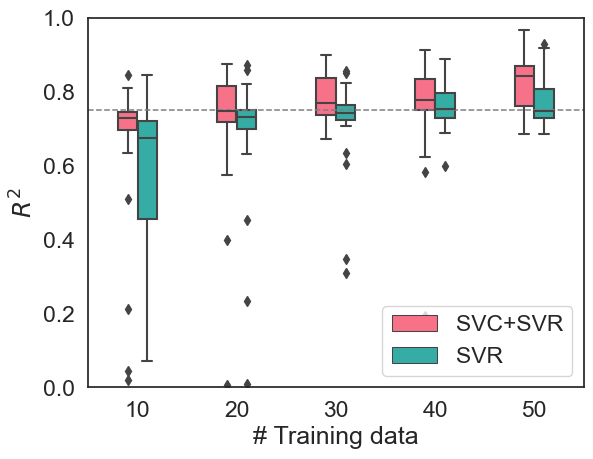

In [73]:
DAHBSUL = ComparisonResultsPlot([complexSVRR2Lists_DAHBSUL, SVRR2Lists_DAHBSUL], \
                      position = 'lower right', xname = '# Training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75)

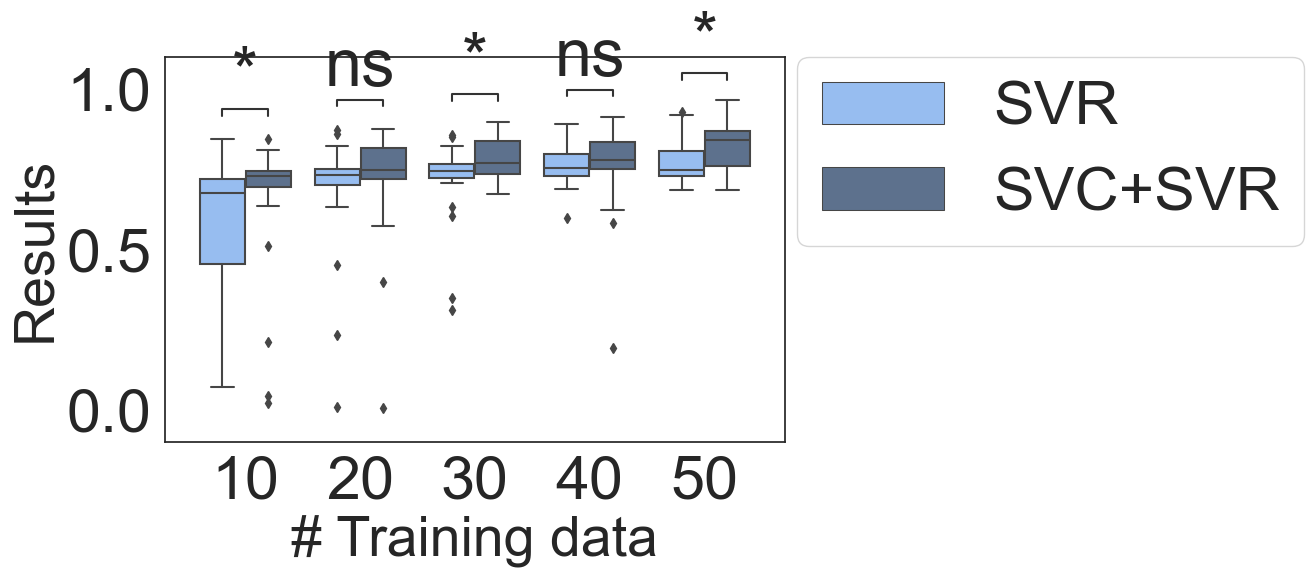

In [74]:
statsPlot(DAHBSUL)